# Loading Data

In [33]:
from openai import OpenAI
import litellm
import json
from typing import List, Dict, Tuple
import os
from datetime import datetime
import pandas as pd
import sys
from diffusers import StableDiffusionPipeline, StableDiffusionXLPipeline
import torch
from PIL import Image
import gc
import numpy as np
import re
from sklearn.metrics.pairwise import cosine_similarity
import glob
from diffusers.utils import logging

ModuleNotFoundError: No module named 'openai'

In [34]:
semart_train = pd.read_csv("Data/semart_train.csv", encoding='cp1252',sep='\t')
semart_test = pd.read_csv("Data/semart_test.csv", encoding='cp1252',sep='\t')
semart_val = pd.read_csv("Data/semart_val.csv", encoding='cp1252',sep='\t')

In [35]:
semart2_train = pd.read_json("Data/semart_topic_annotated_train.json", encoding='cp1252')
semart2_test = pd.read_json("Data/semart_topic_annotated_test.json", encoding='cp1252')
semart2_train = pd.json_normalize(semart2_train['annotations'])
semart2_test = pd.json_normalize(semart2_test['annotations'])
for col in ['content', 'form', 'context']:
    semart2_train[col] = semart2_train[col].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
for col in ['content', 'form', 'context']:
    semart2_test[col] = semart2_test[col].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

In [36]:
cols = ['content', 'form', 'context']
semart2_train_no_empty = semart2_train[(semart2_train[cols] != '').all(axis=1)]
semart_test_merged = pd.merge(semart_train, semart2_train_no_empty, left_on='IMAGE_FILE', right_on='img', how='inner')
source = semart_test_merged.drop(columns=['img', 'description'])

In [ ]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


# Prompt + Image

## Generate Prompt

In [8]:
# Add project root directory to system path
try:
    # For Python scripts
    project_root = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
except NameError:
    # For Jupyter Notebook
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

sys.path.append(project_root)

def load_api_key():
    """Load API key from environment variable or config file"""
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        try:
            with open("config.json", "r") as f:
                config = json.load(f)
                api_key = config.get("openai_api_key")
        except FileNotFoundError:
            raise ValueError("Please set OPENAI_API_KEY environment variable or configure API key in config.json")
    return api_key

def safe_json_loads(content):
    # Remove code block wrappers
    content = re.sub(r"^```json|^```|```$", "", content, flags=re.MULTILINE).strip()
    # Try to keep only content before the last complete comma
    if not content.endswith('}'):
        last_quote = content.rfind('",')
        if last_quote != -1:
            content = content[:last_quote+2] + '\n    "extreme_control_prompt": ""\n}'
    try:
        return json.loads(content)
    except Exception as e:
        print("Still cannot parse, content:", content)
        return {}

def generate_prompt_variants(artwork_info: Dict[str, str]) -> Dict[str, str]:
    """
    Generate 6 different types of artwork prompts for Stable Diffusion using GPT

    Args:
        artwork_info: Dictionary containing artwork information

    Returns:
        Dictionary containing 6 different types of prompts
    """
    # Initialize OpenAI client
    client = OpenAI(
        api_key=load_api_key(),
        base_url="https://ai-research-proxy.azurewebsites.net"
    )

    prompt = f"""
                You are a professional prompt generator for Stable Diffusion. Given one artwork record with these fields:
                AUTHOR, TITLE, TECHNIQUE, DATE, TYPE, SCHOOL, content, form, context

                Output Rules:
                - Strictly use the provided fields.
                - Each prompt must be ≤77 tokens.
                - Use rich, concrete, sensory details from the input.
                - Do NOT be brief — use as many details as possible from the input, summarize up to the token limit.
                - In ablation versions, omit the mentioned fields, but still describe as much of the remaining information as possible.
                - All descriptions must sound like full, fluent, visual scene prompts.
                - DO NOT hint the omitted fields in the prompt.
                - Return ONLY the JSON object, with no extra text or code block formatting.

                Then output six English Stable Diffusion prompts—each ≤77 tokens—strictly using only the provided fields:
                1. Full Prompt: all fields organically combined
                2. No-Style Prompt: omit TECHNIQUE, TYPE, SCHOOL
                3. No-Context Prompt: omit DATE, context
                4. No-Metadata Prompt: omit AUTHOR, TITLE
                5. Content-Only Prompt: only content
                6. Extreme-Control Prompt: only TECHNIQUE, TYPE, SCHOOL, DATE, context (no content)

                Artwork record:
                AUTHOR: {artwork_info.get('AUTHOR','')}
                TITLE: {artwork_info.get('TITLE','')}
                TECHNIQUE (omit the size): {artwork_info.get('TECHNIIQUE','')}
                DATE: {artwork_info.get('DATE','')}
                TYPE: {artwork_info.get('TYPE','')}
                SCHOOL: {artwork_info.get('SCHOOL','')}
                content: {artwork_info.get('content','')}
                form: {artwork_info.get('form','')}
                context: {artwork_info.get('context','')}

                Produce exactly six lines labeled “1. Full Prompt:” … “6. Extreme-Control Prompt:” with the corresponding ≤77-character English prompts.
                Return the result in the following JSON format:
                {{
                    "full_prompt": "prompt1",
                    "no_style_prompt": "prompt2",
                    "no_context_prompt": "prompt3",
                    "no_metadata_prompt": "prompt4",
                    "content_only_prompt": "prompt5",
                    "extreme_control_prompt": "prompt6"
                }}
                """

    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are a professional prompt generator for AI image generation. Your prompts are always visually descriptive, concise, and suitable for Stable Diffusion."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.7,
            max_tokens=800
        )
        content = response.choices[0].message.content.strip()
        try:
            descriptions = safe_json_loads(content)
            return descriptions
        except Exception as e:
            print(f"Error parsing JSON: {str(e)}")
            print("GPT original output:", content)
            return {}
    except Exception as e:
        print(f"Error generating descriptions: {str(e)}")
        return {}

def generate_and_save_prompts(df: pd.DataFrame, output_file: str = "generated_prompts.csv") -> pd.DataFrame:
    """Generate and save prompts only, not images; one row per image, six prompts per image"""
    results = []

    # Check if there are already existing prompts
    if os.path.exists(output_file):
        existing_prompts = pd.read_csv(output_file)
        processed_images = set(existing_prompts['IMAGE_FILE'])
        print(f"Found {len(processed_images)} existing prompts")
    else:
        processed_images = set()

    # Process each artwork
    for idx, row in df.iterrows():
        if row['IMAGE_FILE'] in processed_images:
            print(f"Skipping {row['IMAGE_FILE']} - already processed")
            continue

        print(f"\nGenerating prompts for artwork {idx+1}/{len(df)}: {row['IMAGE_FILE']}")

        # Generate prompts
        descriptions = generate_prompt_variants(row)
        if not descriptions:
            continue

        # Append one row, each prompt in a different column
        result_row = {'IMAGE_FILE': row['IMAGE_FILE'], 'GENERATED_AT': datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
        for desc_type, prompt in descriptions.items():
            result_row[f'PROMPT_{desc_type.upper()}'] = prompt
        results.append(result_row)

        # Save intermediate results every 10 artworks
        if (idx + 1) % 10 == 0:
            temp_df = pd.DataFrame(results)
            temp_df.to_csv(f"Temp/prompts_temp_{idx+1}.csv", index=False)
            print(f"Saved intermediate results to prompts_temp_{idx+1}.csv")

    # Save final result
    if results:
        result_df = pd.DataFrame(results)
        result_df.to_csv(output_file, index=False)
        print(f"\nSaved {len(result_df)} prompts to {output_file}")
        return result_df
    return pd.DataFrame()

def generate_images_batch(prompts: List[str], output_paths: List[str], pipe: StableDiffusionPipeline) -> bool:
    """Batch generate images (core optimization)"""
    try:
        # Ensure negative_prompt is a list
        negative_prompt = "blurry, low quality, low resolution, distorted, disfigured, ugly, bad anatomy, missing limbs, extra limbs, poorly drawn face, poorly drawn hands, text, watermark, signature"
        negative_prompts = [negative_prompt] * len(prompts)  # Create a list of correct length

        # Batch generation
        images = pipe(
            prompt=prompts,
            negative_prompt=negative_prompts,
            num_inference_steps=30,
            guidance_scale=7.5,
            width=512,
            height=512,
            batch_size=len(prompts)
        )

        # Save images
        for img, path in zip(images.images, output_paths):
            img.save(path)
            print(f"Image saved: {path}")

        # Clean up memory
        del images
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
            gc.collect()

        return True
    except Exception as e:
        print(f"Batch generation failed: {str(e)}")
        return False

def generate_images_from_prompts(prompts_file: str = "generated_prompts.csv", 
                               output_dir: str = "generated_images_v1-5",
                               log_file: str = "generated_images_log_v1-5.csv",
                               batch_size: int = 4) -> pd.DataFrame:
    """Generate images from pre-generated prompts"""
    # Set CUDA environment variables
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'

    # Suppress warnings
    logging.set_verbosity_error()

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Load prompts
    prompts_df = pd.read_csv(prompts_file, encoding='utf-8')

    # Check existing generated images
    existing_images = set()

    # 1. Check main log file
    if os.path.exists(log_file):
        existing_log = pd.read_csv(log_file, encoding='utf-8')
        for _, row in existing_log.iterrows():
            key = f"{row['IMAGE_FILE']} {row['PROMPT_TYPE']}"
            existing_images.add(key)
        print(f"Found {len(existing_log)} records in main log file")

    # 2. Check temp files
    temp_files = glob.glob("Temp/images_temp_*.csv")
    for temp_file in temp_files:
        try:
            temp_df = pd.read_csv(temp_file, encoding='utf-8')
            for _, row in temp_df.iterrows():
                key = f"{row['IMAGE_FILE']} {row['PROMPT_TYPE']}"
                existing_images.add(key)
            print(f"Loaded {len(temp_df)} records from {temp_file}")
        except Exception as e:
            print(f"Error reading {temp_file}: {e}")

    print(f"Found {len(existing_images)} existing images in total")

    # Load Stable Diffusion model
    print("Loading Stable Diffusion model...")
    model_id = "sd-legacy/stable-diffusion-v1-5"

    pipe = StableDiffusionPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        use_safetensors=True,
        variant="fp16",
        safety_checker=None  
    )
    
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        
        pipe = pipe.to("cuda")
        pipe.disable_attention_slicing()
        pipe.disable_vae_slicing()
        print("GPU is ready!")
        
        try:
            pipe.enable_xformers_memory_efficient_attention()
            print("xformers enabled.")
            pipe.enable_model_cpu_offload()  
            pipe.enable_vae_tiling()  
        except Exception as e:
            print("xformers not available:", e)
    
    # Result
    results = []
    
    # Each Prompt
    total_prompts = len(prompts_df)
    for idx, row in prompts_df.iterrows():
        print(f"\nProcessing prompt {idx+1}/{total_prompts}")
        
        # Get all prompts
        prompt_cols = [col for col in row.index if col.startswith('PROMPT_')]
        
        # Prepare batch
        batch_prompts = []
        batch_paths = []
        batch_types = []
        
        for prompt_col in prompt_cols:
            prompt_type = prompt_col.replace('PROMPT_', '').lower()
            prompt = row[prompt_col]
            
            # File name
            base_name = os.path.splitext(row['IMAGE_FILE'])[0]
            output_filename = f"{base_name} {prompt_type}.jpg"
            output_path = os.path.join(output_dir, output_filename)
            
            # Check Generation
            image_key = f"{row['IMAGE_FILE']} {prompt_type}"
            if image_key in existing_images:
                print(f"Skipping {output_filename} - already generated")
                continue
            
            # Check existence
            if os.path.exists(output_path):
                print(f"Skipping {output_filename} - file already exists")
                existing_images.add(image_key)
                continue
            
            # Add batch
            batch_prompts.append(prompt)
            batch_paths.append(output_path)
            batch_types.append(prompt_type)
            
            # Trigger
            if len(batch_prompts) >= batch_size:
                if generate_images_batch(batch_prompts, batch_paths, pipe):
                    # Record result
                    for prompt, path, prompt_type in zip(batch_prompts, batch_paths, batch_types):
                        results.append({
                            'IMAGE_FILE': row['IMAGE_FILE'],
                            'PROMPT_TYPE': prompt_type,
                            'PROMPT': prompt,
                            'OUTPUT_FILE': os.path.basename(path),
                            'GENERATED_AT': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                        })
                        existing_images.add(f"{row['IMAGE_FILE']} {prompt_type}")
                
                batch_prompts.clear()
                batch_paths.clear()
                batch_types.clear()
        
        # The rest batches
        if batch_prompts:
            if generate_images_batch(batch_prompts, batch_paths, pipe):
                # Record
                for prompt, path, prompt_type in zip(batch_prompts, batch_paths, batch_types):
                    results.append({
                        'IMAGE_FILE': row['IMAGE_FILE'],
                        'PROMPT_TYPE': prompt_type,
                        'PROMPT': prompt,
                        'OUTPUT_FILE': os.path.basename(path),
                        'GENERATED_AT': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                    })
                    existing_images.add(f"{row['IMAGE_FILE']} {prompt_type}")
        
        # Record per 10 results
        if (idx + 1) % 10 == 0:
            temp_df = pd.DataFrame(results)
            temp_path = os.path.join("Temp", f"images_temp_{idx+1}.csv")
            temp_df.to_csv(temp_path, index=False, encoding='utf-8')
            print(f"Saved intermediate results to {temp_path}")
    
    # Save result
    if results:
        result_df = pd.DataFrame(results)
        result_df.to_csv(log_file, index=False, encoding='utf-8')
        print(f"\nGenerated {len(result_df)} images")
        return result_df
    return pd.DataFrame()

## Clean Prompt

### Check Author

In [22]:
import pandas as pd
import re

STOPWORDS = {'de', 'the', 'von', 'van', 'da', 'di', 'la', 'le', 'du', 'del', 'dos', 'das', 'y', 'a', 'della', 'der', 'den', 'zu', 'und', 'of'}

def get_valid_name_parts(author: str):
    """Return all valid (non-stopword) parts of the author name."""
    if not author:
        return []
    parts = [p for p in re.split(r"[ ,.'-]", author) if p and p.lower() not in STOPWORDS]
    return list(set(parts))  # Remove duplicates

def clean_artist_names(prompt: str, author: str) -> str:
    if not author or not prompt:
        return prompt
    cleaned_prompt = str(prompt)
    # Full name and full name's
    author_variants = [author, f"{author}'s"]
    # Valid parts and part's
    valid_parts = get_valid_name_parts(author)
    for part in valid_parts:
        author_variants.extend([part, f"{part}'s"])
    # Sort by length (longest first)
    author_variants = sorted(set(author_variants), key=lambda x: -len(x))
    # Replace all variants
    for variant in author_variants:
        # Sentence start
        pattern_start = r'(^|\.\s+)' + re.escape(variant)
        if variant.lower().endswith("'s"):
            cleaned_prompt = re.sub(pattern_start, lambda m: m.group(1) + "The painter's", cleaned_prompt, flags=re.IGNORECASE)
            cleaned_prompt = re.sub(r'\b' + re.escape(variant) + r'\b', "the painter's", cleaned_prompt, flags=re.IGNORECASE)
        else:
            cleaned_prompt = re.sub(pattern_start, lambda m: m.group(1) + "The painter", cleaned_prompt, flags=re.IGNORECASE)
            cleaned_prompt = re.sub(r'\b' + re.escape(variant) + r'\b', "the painter", cleaned_prompt, flags=re.IGNORECASE)
    # Remove consecutive 'the painter' or 'the painter's'
    cleaned_prompt = re.sub(r"(the painter(?:'s)?)(\s+\1)+", r"\1", cleaned_prompt, flags=re.IGNORECASE)
    # Fix double 'The painter' at sentence start
    cleaned_prompt = re.sub(r"(^|\.\s+)the painter", lambda m: m.group(1) + "The painter", cleaned_prompt)
    cleaned_prompt = re.sub(r"(^|\.\s+)the painter's", lambda m: m.group(1) + "The painter's", cleaned_prompt)
    return cleaned_prompt

# Read data
source_df = pd.read_csv('source.csv')
gen_df = pd.read_csv('generated_prompts.csv')
merged = pd.merge(gen_df, source_df[['IMAGE_FILE', 'AUTHOR']], on='IMAGE_FILE', how='left')

# Only process these columns
target_prompt_cols = [
    'PROMPT_NO_STYLE_PROMPT',
    'PROMPT_NO_METADATA_PROMPT',
    'PROMPT_CONTENT_ONLY_PROMPT',
    'PROMPT_EXTREME_CONTROL_PROMPT'
]

cleaned_rows = []
for idx, row in merged.iterrows():
    cleaned_row = row.copy()
    for col in target_prompt_cols:
        cleaned_row[col] = clean_artist_names(row[col], row['AUTHOR'])
    cleaned_rows.append(cleaned_row)

cleaned_artist_df = pd.DataFrame(cleaned_rows)

# Drop the AUTHOR column before saving
if 'AUTHOR' in cleaned_artist_df.columns:
    cleaned_artist_df = cleaned_artist_df.drop(columns=['AUTHOR'])

cleaned_artist_df.to_csv('prompts_no_artist.csv', index=False)
print("Step 1 complete: prompts_no_artist.csv generated (without AUTHOR column).")

Step 1 complete: prompts_no_artist.csv generated (without AUTHOR column).


### Embedding

In [24]:
import pandas as pd
import numpy as np
import json
import re
from openai import OpenAI
from sklearn.metrics.pairwise import cosine_similarity
import time
import os
from tqdm import tqdm  

def get_embedding(text: str, client: OpenAI) -> np.ndarray:
    try:
        response = client.embeddings.create(
            model="text-embedding-ada-002",
            input=text
        )
        time.sleep(1)  # avoid rate limit
        return np.array(response.data[0].embedding)
    except Exception as e:
        print(f"Error getting embedding: {str(e)}")
        return None

def split_into_sentences(text: str):
    sentences = re.split(r'[.!?]+', str(text))
    return [s.strip() for s in sentences if s.strip()]

# Read file
df = pd.read_csv('prompts_no_artist.csv')
source_df = pd.read_csv('source.csv')
merged = pd.merge(df, source_df[['IMAGE_FILE', 'form']], on='IMAGE_FILE', how='left')

# 1.  Generate and save 
unique_forms = merged['form'].dropna().unique()
form_embeddings = {}
client = OpenAI(
    api_key=load_api_key(),
    base_url="https://ai-research-proxy.azurewebsites.net"
)
print("Generating form embeddings...")
for form in tqdm(unique_forms, desc="Form Embeddings"):
    if form not in form_embeddings:
        emb = get_embedding(form, client)
        if emb is not None:
            form_embeddings[form] = emb.tolist()
with open('form_embeddings.json', 'w', encoding='utf-8') as f:
    json.dump(form_embeddings, f)
print("All form embeddings saved.")

# 2. embedding
all_sentences = set()
for prompt in tqdm(merged['PROMPT_NO_STYLE_PROMPT'], desc="Collecting Sentences"):
    all_sentences.update(split_into_sentences(prompt))
sentence_embeddings = {}
print("Generating sentence embeddings...")
for sentence in tqdm(all_sentences, desc="Sentence Embeddings"):
    if sentence and sentence not in sentence_embeddings:
        emb = get_embedding(sentence, client)
        if emb is not None:
            sentence_embeddings[sentence] = emb.tolist()
with open('sentence_embeddings.json', 'w', encoding='utf-8') as f:
    json.dump(sentence_embeddings, f)
print("All sentence embeddings saved.")

Generating form embeddings...


Form Embeddings: 100%|██████████| 2678/2678 [50:23<00:00,  1.13s/it]


All form embeddings saved.


Generating sentence embeddings...


Sentence Embeddings: 100%|██████████| 6896/6896 [2:09:24<00:00,  1.13s/it]  


All sentence embeddings saved.


### Check Year

In [ ]:
import re
import numpy as np
from tqdm import tqdm

def clean_form_content_with_log(prompt: str, form: str, form_embeddings, sentence_embeddings, threshold=0.91, max_remove=1):
    if not form or not prompt:
        return prompt, [], []
    form_emb = np.array(form_embeddings.get(form))
    if form_emb is None:
        return prompt, [], []
    sentences = split_into_sentences(prompt)
    sim_list = []
    for sentence in sentences:
        sent_emb = sentence_embeddings.get(sentence)
        if sent_emb is None:
            sim_list.append((sentence, -1))
            continue
        similarity = cosine_similarity([np.array(sent_emb)], [form_emb])[0][0]
        sim_list.append((sentence, similarity))
    # If all sentences are above threshold, do not remove any
    if all(sim >= threshold for _, sim in sim_list if sim >= 0):
        return prompt, [], []
    # Otherwise, remove the most similar sentence(s) above threshold
    sim_list_sorted = sorted(sim_list, key=lambda x: x[1], reverse=True)
    removed = []
    removed_info = []
    modified_sentences = []
    removed_count = 0
    for sentence, sim in sim_list:
        if removed_count < max_remove and sim >= threshold and (sentence, sim) in sim_list_sorted[:max_remove]:
            removed.append(sentence)
            removed_info.append((sentence, sim))
            removed_count += 1
        else:
            modified_sentences.append(sentence)
    cleaned_prompt = ' '.join(modified_sentences)
    return cleaned_prompt, removed, removed_info

cleaned_rows = []
log_lines = []
print("Cleaning PROMPT_NO_STYLE_PROMPT with form embeddings and logging changes...")

for idx in tqdm(range(len(merged)), desc="Cleaning Prompts"):
    row = merged.iloc[idx]
    cleaned_row = row.copy()
    prompt = row['PROMPT_NO_STYLE_PROMPT']
    form = row['form']
    cleaned_prompt, removed, removed_info = clean_form_content_with_log(
        prompt, form, form_embeddings, sentence_embeddings, threshold=0.91, max_remove=1
    )
    cleaned_row['PROMPT_NO_STYLE_PROMPT'] = cleaned_prompt
    if removed:
        log_lines.append(f"IMAGE_FILE: {row['IMAGE_FILE']}")
        log_lines.append(f"Original prompt: {prompt}")
        log_lines.append(f"Cleaned prompt: {cleaned_prompt}")
        log_lines.append("Removed sentences (similarity > 0.91):")
        for sentence, sim in removed_info:
            log_lines.append(f"  - \"{sentence}\" (similarity: {sim:.3f})")
        log_lines.append("")
    cleaned_rows.append(cleaned_row)

final_df = pd.DataFrame(cleaned_rows)
if 'form' in final_df.columns:
    final_df = final_df.drop(columns=['form'])
final_df.to_csv('cleaned_prompts_no_year.csv', index=False)
with open('cleaned_prompts_log.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(log_lines))
print("Step 2a complete: cleaned_prompts_no_year.csv generated, detailed log saved as cleaned_prompts_log.txt.")

### Check Title

In [ ]:
def extract_years(date_str):
    """Extract all 4-digit years from a date string (e.g., 'c. 1888', '1880s')."""
    if not isinstance(date_str, str):
        return []
    years = re.findall(r'(?:c\.|ca\.|circa)?\s*(\d{4})', date_str, flags=re.IGNORECASE)
    years += re.findall(r'(\d{4})s', date_str)
    return list(set(years))

def prompt_contains_year(prompt, years):
    """Check whether any year from the list appears as a standalone 4-digit number in the prompt."""
    for year in years:
        if re.search(rf'(?<!\d){year}(?!\d)', str(prompt)):
            return True
    return False

def remove_title_from_prompt(prompt, title):
    """
    Remove the artwork title from the prompt text.
    Matching is case-insensitive and only removes complete word/phrase matches.
    """
    if not isinstance(title, str) or not title.strip():
        return prompt
    if not isinstance(prompt, str):
        prompt = str(prompt) if prompt is not None else ""

    # Compile regex pattern for the title as a whole word or phrase
    pattern = re.compile(rf'\b{re.escape(title)}\b', re.IGNORECASE)
    prompt = pattern.sub('', prompt)

    # Clean up extra whitespace and spacing before punctuation
    prompt = re.sub(r'\s+', ' ', prompt)
    prompt = re.sub(r'\s+([.,;:!?])', r'\1', prompt)
    return prompt.strip()

# Read cleaned prompts and source metadata
df = pd.read_csv('cleaned_prompts.csv')
source_df = pd.read_csv('source.csv')

# Merge title and date info into the main DataFrame
merged = pd.merge(df, source_df[['IMAGE_FILE', 'DATE', 'TITLE']], on='IMAGE_FILE', how='left')

updated_rows = []

# Process each row to enrich or clean prompts
for idx, row in merged.iterrows():
    # ---- 1. Add year to prompt if not already present ----
    prompt = row['PROMPT_NO_STYLE_PROMPT']
    date = row['DATE'] if 'DATE' in row else ''
    years = extract_years(date)
    has_year = prompt_contains_year(prompt, years)
    if years and not has_year:
        # Append the first extracted year to the prompt
        prompt = prompt.strip() + f". It was painted in {years[0]}."
    row['PROMPT_NO_STYLE_PROMPT'] = prompt

    # ---- 2. Remove title from metadata prompt ----
    prompt_meta = row['PROMPT_NO_METADATA_PROMPT']
    title = row['TITLE'] if 'TITLE' in row else ''
    if isinstance(title, str) and title.strip():
        prompt_meta_new = remove_title_from_prompt(prompt_meta, title)
        row['PROMPT_NO_METADATA_PROMPT'] = prompt_meta_new

    updated_rows.append(row)

# Create final DataFrame
final_df = pd.DataFrame(updated_rows)

# Drop temporary metadata columns
if 'DATE' in final_df.columns:
    final_df = final_df.drop(columns=['DATE'])
if 'TITLE' in final_df.columns:
    final_df = final_df.drop(columns=['TITLE'])

# Save final processed prompts
final_df.to_csv('cleaned_prompts_final.csv', index=False)
print("Step 2b complete: cleaned_prompts_final.csv generated with year and title info processed.")


Step 2b complete: cleaned_prompts_final.csv generated with year and title info processed.


## Run

In [ ]:
def main():
    # 1：generate prompts
    # print("Step 1: Generating prompts...")
    # prompts_df = generate_and_save_prompts(source)
    
    # 2：generate images
    # print("\nStep 2: Generating images...")
    # if not prompts_df.empty:
    #     images_df = generate_images_from_prompts()
    
    print("\nProcessing complete!")

if __name__ == "__main__":
    main()

In [9]:
images_df = generate_images_from_prompts(prompts_file="cleaned_prompts_final.csv",
                                         output_dir = "generated_images_final",
                                        log_file = "generated_images_final.csv")




Error reading Temp\images_temp_10.csv: No columns to parse from file
Loaded 52 records from Temp\images_temp_100.csv
Loaded 92 records from Temp\images_temp_110.csv
Loaded 132 records from Temp\images_temp_120.csv
Loaded 172 records from Temp\images_temp_130.csv
Loaded 212 records from Temp\images_temp_140.csv
Loaded 252 records from Temp\images_temp_150.csv
Loaded 292 records from Temp\images_temp_160.csv
Loaded 332 records from Temp\images_temp_170.csv
Loaded 372 records from Temp\images_temp_180.csv
Loaded 412 records from Temp\images_temp_190.csv
Error reading Temp\images_temp_20.csv: No columns to parse from file
Loaded 452 records from Temp\images_temp_200.csv
Loaded 492 records from Temp\images_temp_210.csv
Loaded 532 records from Temp\images_temp_220.csv
Loaded 572 records from Temp\images_temp_230.csv
Error reading Temp\images_temp_30.csv: No columns to parse from file
Error reading Temp\images_temp_40.csv: No columns to parse from file
Error reading Temp\images_temp_50.csv: N

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

GPU is ready!
xformers not available: Refer to https://github.com/facebookresearch/xformers for more information on how to install xformers

Processing prompt 1/2708
Skipping 19873-1darmst no_style_prompt.jpg - file already exists
Skipping 19873-1darmst no_metadata_prompt.jpg - file already exists
Skipping 19873-1darmst content_only_prompt.jpg - file already exists
Skipping 19873-1darmst extreme_control_prompt.jpg - file already exists

Processing prompt 2/2708
Skipping 18759-guard301 no_style_prompt.jpg - file already exists
Skipping 18759-guard301 no_metadata_prompt.jpg - file already exists
Skipping 18759-guard301 content_only_prompt.jpg - file already exists
Skipping 18759-guard301 extreme_control_prompt.jpg - file already exists

Processing prompt 3/2708
Skipping 08705-pieta no_style_prompt.jpg - file already exists
Skipping 08705-pieta no_metadata_prompt.jpg - file already exists
Skipping 08705-pieta content_only_prompt.jpg - file already exists
Skipping 08705-pieta extreme_contr

  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29477-nightlan no_style_prompt.jpg
Image saved: generated_images_final\29477-nightlan no_metadata_prompt.jpg
Image saved: generated_images_final\29477-nightlan content_only_prompt.jpg
Image saved: generated_images_final\29477-nightlan extreme_control_prompt.jpg


Token indices sequence length is longer than the specified maximum sequence length for this model (94 > 77). Running this sequence through the model will result in indexing errors


Saved intermediate results to Temp\images_temp_240.csv

Processing prompt 241/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31228-13nativ1 no_style_prompt.jpg
Image saved: generated_images_final\31228-13nativ1 no_metadata_prompt.jpg
Image saved: generated_images_final\31228-13nativ1 content_only_prompt.jpg
Image saved: generated_images_final\31228-13nativ1 extreme_control_prompt.jpg

Processing prompt 242/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04469-market_w no_style_prompt.jpg
Image saved: generated_images_final\04469-market_w no_metadata_prompt.jpg
Image saved: generated_images_final\04469-market_w content_only_prompt.jpg
Image saved: generated_images_final\04469-market_w extreme_control_prompt.jpg

Processing prompt 243/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03908-194madon no_style_prompt.jpg
Image saved: generated_images_final\03908-194madon no_metadata_prompt.jpg
Image saved: generated_images_final\03908-194madon content_only_prompt.jpg
Image saved: generated_images_final\03908-194madon extreme_control_prompt.jpg

Processing prompt 244/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32772-07colonn no_style_prompt.jpg
Image saved: generated_images_final\32772-07colonn no_metadata_prompt.jpg
Image saved: generated_images_final\32772-07colonn content_only_prompt.jpg
Image saved: generated_images_final\32772-07colonn extreme_control_prompt.jpg

Processing prompt 245/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15467-3gigli no_style_prompt.jpg
Image saved: generated_images_final\15467-3gigli no_metadata_prompt.jpg
Image saved: generated_images_final\15467-3gigli content_only_prompt.jpg
Image saved: generated_images_final\15467-3gigli extreme_control_prompt.jpg

Processing prompt 246/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23064-51maesta no_style_prompt.jpg
Image saved: generated_images_final\23064-51maesta no_metadata_prompt.jpg
Image saved: generated_images_final\23064-51maesta content_only_prompt.jpg
Image saved: generated_images_final\23064-51maesta extreme_control_prompt.jpg

Processing prompt 247/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32794-30selfpo no_style_prompt.jpg
Image saved: generated_images_final\32794-30selfpo no_metadata_prompt.jpg
Image saved: generated_images_final\32794-30selfpo content_only_prompt.jpg
Image saved: generated_images_final\32794-30selfpo extreme_control_prompt.jpg

Processing prompt 248/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32759-03citta no_style_prompt.jpg
Image saved: generated_images_final\32759-03citta no_metadata_prompt.jpg
Image saved: generated_images_final\32759-03citta content_only_prompt.jpg
Image saved: generated_images_final\32759-03citta extreme_control_prompt.jpg

Processing prompt 249/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33553-082portr no_style_prompt.jpg
Image saved: generated_images_final\33553-082portr no_metadata_prompt.jpg
Image saved: generated_images_final\33553-082portr content_only_prompt.jpg
Image saved: generated_images_final\33553-082portr extreme_control_prompt.jpg

Processing prompt 250/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39614-4david no_style_prompt.jpg
Image saved: generated_images_final\39614-4david no_metadata_prompt.jpg
Image saved: generated_images_final\39614-4david content_only_prompt.jpg
Image saved: generated_images_final\39614-4david extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_250.csv

Processing prompt 251/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09878-courb216 no_style_prompt.jpg
Image saved: generated_images_final\09878-courb216 no_metadata_prompt.jpg
Image saved: generated_images_final\09878-courb216 content_only_prompt.jpg
Image saved: generated_images_final\09878-courb216 extreme_control_prompt.jpg

Processing prompt 252/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24139-4funera3 no_style_prompt.jpg
Image saved: generated_images_final\24139-4funera3 no_metadata_prompt.jpg
Image saved: generated_images_final\24139-4funera3 content_only_prompt.jpg
Image saved: generated_images_final\24139-4funera3 extreme_control_prompt.jpg

Processing prompt 253/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09012-07rebecc no_style_prompt.jpg
Image saved: generated_images_final\09012-07rebecc no_metadata_prompt.jpg
Image saved: generated_images_final\09012-07rebecc content_only_prompt.jpg
Image saved: generated_images_final\09012-07rebecc extreme_control_prompt.jpg

Processing prompt 254/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22653-1virgin no_style_prompt.jpg
Image saved: generated_images_final\22653-1virgin no_metadata_prompt.jpg
Image saved: generated_images_final\22653-1virgin content_only_prompt.jpg
Image saved: generated_images_final\22653-1virgin extreme_control_prompt.jpg

Processing prompt 255/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17767-418goya no_style_prompt.jpg
Image saved: generated_images_final\17767-418goya no_metadata_prompt.jpg
Image saved: generated_images_final\17767-418goya content_only_prompt.jpg
Image saved: generated_images_final\17767-418goya extreme_control_prompt.jpg

Processing prompt 256/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40867-10edelhe no_style_prompt.jpg
Image saved: generated_images_final\40867-10edelhe no_metadata_prompt.jpg
Image saved: generated_images_final\40867-10edelhe content_only_prompt.jpg
Image saved: generated_images_final\40867-10edelhe extreme_control_prompt.jpg

Processing prompt 257/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32333-01ignazi no_style_prompt.jpg
Image saved: generated_images_final\32333-01ignazi no_metadata_prompt.jpg
Image saved: generated_images_final\32333-01ignazi content_only_prompt.jpg
Image saved: generated_images_final\32333-01ignazi extreme_control_prompt.jpg

Processing prompt 258/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18709-1ospeda1 no_style_prompt.jpg
Image saved: generated_images_final\18709-1ospeda1 no_metadata_prompt.jpg
Image saved: generated_images_final\18709-1ospeda1 content_only_prompt.jpg
Image saved: generated_images_final\18709-1ospeda1 extreme_control_prompt.jpg

Processing prompt 259/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26713-lu08ozi no_style_prompt.jpg
Image saved: generated_images_final\26713-lu08ozi no_metadata_prompt.jpg
Image saved: generated_images_final\26713-lu08ozi content_only_prompt.jpg
Image saved: generated_images_final\26713-lu08ozi extreme_control_prompt.jpg

Processing prompt 260/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23436-labia1 no_style_prompt.jpg
Image saved: generated_images_final\23436-labia1 no_metadata_prompt.jpg
Image saved: generated_images_final\23436-labia1 content_only_prompt.jpg
Image saved: generated_images_final\23436-labia1 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_260.csv

Processing prompt 261/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37519-8sebasti no_style_prompt.jpg
Image saved: generated_images_final\37519-8sebasti no_metadata_prompt.jpg
Image saved: generated_images_final\37519-8sebasti content_only_prompt.jpg
Image saved: generated_images_final\37519-8sebasti extreme_control_prompt.jpg

Processing prompt 262/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44039-0john no_style_prompt.jpg
Image saved: generated_images_final\44039-0john no_metadata_prompt.jpg
Image saved: generated_images_final\44039-0john content_only_prompt.jpg
Image saved: generated_images_final\44039-0john extreme_control_prompt.jpg

Processing prompt 263/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07535-32marino no_style_prompt.jpg
Image saved: generated_images_final\07535-32marino no_metadata_prompt.jpg
Image saved: generated_images_final\07535-32marino content_only_prompt.jpg
Image saved: generated_images_final\07535-32marino extreme_control_prompt.jpg

Processing prompt 264/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07515-24conta no_style_prompt.jpg
Image saved: generated_images_final\07515-24conta no_metadata_prompt.jpg
Image saved: generated_images_final\07515-24conta content_only_prompt.jpg
Image saved: generated_images_final\07515-24conta extreme_control_prompt.jpg

Processing prompt 265/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18887-allegory no_style_prompt.jpg
Image saved: generated_images_final\18887-allegory no_metadata_prompt.jpg
Image saved: generated_images_final\18887-allegory content_only_prompt.jpg
Image saved: generated_images_final\18887-allegory extreme_control_prompt.jpg

Processing prompt 266/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41461-j_paris no_style_prompt.jpg
Image saved: generated_images_final\41461-j_paris no_metadata_prompt.jpg
Image saved: generated_images_final\41461-j_paris content_only_prompt.jpg
Image saved: generated_images_final\41461-j_paris extreme_control_prompt.jpg

Processing prompt 267/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44525-federi02 no_style_prompt.jpg
Image saved: generated_images_final\44525-federi02 no_metadata_prompt.jpg
Image saved: generated_images_final\44525-federi02 content_only_prompt.jpg
Image saved: generated_images_final\44525-federi02 extreme_control_prompt.jpg

Processing prompt 268/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33038-10trans no_style_prompt.jpg
Image saved: generated_images_final\33038-10trans no_metadata_prompt.jpg
Image saved: generated_images_final\33038-10trans content_only_prompt.jpg
Image saved: generated_images_final\33038-10trans extreme_control_prompt.jpg

Processing prompt 269/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35389-03erect no_style_prompt.jpg
Image saved: generated_images_final\35389-03erect no_metadata_prompt.jpg
Image saved: generated_images_final\35389-03erect content_only_prompt.jpg
Image saved: generated_images_final\35389-03erect extreme_control_prompt.jpg

Processing prompt 270/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39293-2mark no_style_prompt.jpg
Image saved: generated_images_final\39293-2mark no_metadata_prompt.jpg
Image saved: generated_images_final\39293-2mark content_only_prompt.jpg
Image saved: generated_images_final\39293-2mark extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_270.csv

Processing prompt 271/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08458-betrayal no_style_prompt.jpg
Image saved: generated_images_final\08458-betrayal no_metadata_prompt.jpg
Image saved: generated_images_final\08458-betrayal content_only_prompt.jpg
Image saved: generated_images_final\08458-betrayal extreme_control_prompt.jpg

Processing prompt 272/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05546-03youngw no_style_prompt.jpg
Image saved: generated_images_final\05546-03youngw no_metadata_prompt.jpg
Image saved: generated_images_final\05546-03youngw content_only_prompt.jpg
Image saved: generated_images_final\05546-03youngw extreme_control_prompt.jpg

Processing prompt 273/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32076-slorenzo no_style_prompt.jpg
Image saved: generated_images_final\32076-slorenzo no_metadata_prompt.jpg
Image saved: generated_images_final\32076-slorenzo content_only_prompt.jpg
Image saved: generated_images_final\32076-slorenzo extreme_control_prompt.jpg

Processing prompt 274/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22576-1madonna no_style_prompt.jpg
Image saved: generated_images_final\22576-1madonna no_metadata_prompt.jpg
Image saved: generated_images_final\22576-1madonna content_only_prompt.jpg
Image saved: generated_images_final\22576-1madonna extreme_control_prompt.jpg

Processing prompt 275/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24615-portraix no_style_prompt.jpg
Image saved: generated_images_final\24615-portraix no_metadata_prompt.jpg
Image saved: generated_images_final\24615-portraix content_only_prompt.jpg
Image saved: generated_images_final\24615-portraix extreme_control_prompt.jpg

Processing prompt 276/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37882-thebaid no_style_prompt.jpg
Image saved: generated_images_final\37882-thebaid no_metadata_prompt.jpg
Image saved: generated_images_final\37882-thebaid content_only_prompt.jpg
Image saved: generated_images_final\37882-thebaid extreme_control_prompt.jpg

Processing prompt 277/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00670-baptist no_style_prompt.jpg
Image saved: generated_images_final\00670-baptist no_metadata_prompt.jpg
Image saved: generated_images_final\00670-baptist content_only_prompt.jpg
Image saved: generated_images_final\00670-baptist extreme_control_prompt.jpg

Processing prompt 278/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35719-view_haa no_style_prompt.jpg
Image saved: generated_images_final\35719-view_haa no_metadata_prompt.jpg
Image saved: generated_images_final\35719-view_haa content_only_prompt.jpg
Image saved: generated_images_final\35719-view_haa extreme_control_prompt.jpg

Processing prompt 279/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19243-stillif2 no_style_prompt.jpg
Image saved: generated_images_final\19243-stillif2 no_metadata_prompt.jpg
Image saved: generated_images_final\19243-stillif2 content_only_prompt.jpg
Image saved: generated_images_final\19243-stillif2 extreme_control_prompt.jpg

Processing prompt 280/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25052-double2 no_style_prompt.jpg
Image saved: generated_images_final\25052-double2 no_metadata_prompt.jpg
Image saved: generated_images_final\25052-double2 content_only_prompt.jpg
Image saved: generated_images_final\25052-double2 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_280.csv

Processing prompt 281/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23765-madchild no_style_prompt.jpg
Image saved: generated_images_final\23765-madchild no_metadata_prompt.jpg
Image saved: generated_images_final\23765-madchild content_only_prompt.jpg
Image saved: generated_images_final\23765-madchild extreme_control_prompt.jpg

Processing prompt 282/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33239-mecklenb no_style_prompt.jpg
Image saved: generated_images_final\33239-mecklenb no_metadata_prompt.jpg
Image saved: generated_images_final\33239-mecklenb content_only_prompt.jpg
Image saved: generated_images_final\33239-mecklenb extreme_control_prompt.jpg

Processing prompt 283/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40862-04calvar no_style_prompt.jpg
Image saved: generated_images_final\40862-04calvar no_metadata_prompt.jpg
Image saved: generated_images_final\40862-04calvar content_only_prompt.jpg
Image saved: generated_images_final\40862-04calvar extreme_control_prompt.jpg

Processing prompt 284/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17060-paris10 no_style_prompt.jpg
Image saved: generated_images_final\17060-paris10 no_metadata_prompt.jpg
Image saved: generated_images_final\17060-paris10 content_only_prompt.jpg
Image saved: generated_images_final\17060-paris10 extreme_control_prompt.jpg

Processing prompt 285/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03866-149alle no_style_prompt.jpg
Image saved: generated_images_final\03866-149alle no_metadata_prompt.jpg
Image saved: generated_images_final\03866-149alle content_only_prompt.jpg
Image saved: generated_images_final\03866-149alle extreme_control_prompt.jpg

Processing prompt 286/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15540-6innoce no_style_prompt.jpg
Image saved: generated_images_final\15540-6innoce no_metadata_prompt.jpg
Image saved: generated_images_final\15540-6innoce content_only_prompt.jpg
Image saved: generated_images_final\15540-6innoce extreme_control_prompt.jpg

Processing prompt 287/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19905-03seymou no_style_prompt.jpg
Image saved: generated_images_final\19905-03seymou no_metadata_prompt.jpg
Image saved: generated_images_final\19905-03seymou content_only_prompt.jpg
Image saved: generated_images_final\19905-03seymou extreme_control_prompt.jpg

Processing prompt 288/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03609-72rebel no_style_prompt.jpg
Image saved: generated_images_final\03609-72rebel no_metadata_prompt.jpg
Image saved: generated_images_final\03609-72rebel content_only_prompt.jpg
Image saved: generated_images_final\03609-72rebel extreme_control_prompt.jpg

Processing prompt 289/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17519-1adorat1 no_style_prompt.jpg
Image saved: generated_images_final\17519-1adorat1 no_metadata_prompt.jpg
Image saved: generated_images_final\17519-1adorat1 content_only_prompt.jpg
Image saved: generated_images_final\17519-1adorat1 extreme_control_prompt.jpg

Processing prompt 290/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42638-32ladyw no_style_prompt.jpg
Image saved: generated_images_final\42638-32ladyw no_metadata_prompt.jpg
Image saved: generated_images_final\42638-32ladyw content_only_prompt.jpg
Image saved: generated_images_final\42638-32ladyw extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_290.csv

Processing prompt 291/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11684-humility no_style_prompt.jpg
Image saved: generated_images_final\11684-humility no_metadata_prompt.jpg
Image saved: generated_images_final\11684-humility content_only_prompt.jpg
Image saved: generated_images_final\11684-humility extreme_control_prompt.jpg

Processing prompt 292/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23069-90madonn no_style_prompt.jpg
Image saved: generated_images_final\23069-90madonn no_metadata_prompt.jpg
Image saved: generated_images_final\23069-90madonn content_only_prompt.jpg
Image saved: generated_images_final\23069-90madonn extreme_control_prompt.jpg

Processing prompt 293/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05285-1lastjud no_style_prompt.jpg
Image saved: generated_images_final\05285-1lastjud no_metadata_prompt.jpg
Image saved: generated_images_final\05285-1lastjud content_only_prompt.jpg
Image saved: generated_images_final\05285-1lastjud extreme_control_prompt.jpg

Processing prompt 294/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14254-3annunc no_style_prompt.jpg
Image saved: generated_images_final\14254-3annunc no_metadata_prompt.jpg
Image saved: generated_images_final\14254-3annunc content_only_prompt.jpg
Image saved: generated_images_final\14254-3annunc extreme_control_prompt.jpg

Processing prompt 295/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10835-sluicega no_style_prompt.jpg
Image saved: generated_images_final\10835-sluicega no_metadata_prompt.jpg
Image saved: generated_images_final\10835-sluicega content_only_prompt.jpg
Image saved: generated_images_final\10835-sluicega extreme_control_prompt.jpg

Processing prompt 296/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10244-2lucret3 no_style_prompt.jpg
Image saved: generated_images_final\10244-2lucret3 no_metadata_prompt.jpg
Image saved: generated_images_final\10244-2lucret3 content_only_prompt.jpg
Image saved: generated_images_final\10244-2lucret3 extreme_control_prompt.jpg

Processing prompt 297/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41965-immacula no_style_prompt.jpg
Image saved: generated_images_final\41965-immacula no_metadata_prompt.jpg
Image saved: generated_images_final\41965-immacula content_only_prompt.jpg
Image saved: generated_images_final\41965-immacula extreme_control_prompt.jpg

Processing prompt 298/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20277-saints no_style_prompt.jpg
Image saved: generated_images_final\20277-saints no_metadata_prompt.jpg
Image saved: generated_images_final\20277-saints content_only_prompt.jpg
Image saved: generated_images_final\20277-saints extreme_control_prompt.jpg

Processing prompt 299/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06013-regents no_style_prompt.jpg
Image saved: generated_images_final\06013-regents no_metadata_prompt.jpg
Image saved: generated_images_final\06013-regents content_only_prompt.jpg
Image saved: generated_images_final\06013-regents extreme_control_prompt.jpg

Processing prompt 300/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07274-canal803 no_style_prompt.jpg
Image saved: generated_images_final\07274-canal803 no_metadata_prompt.jpg
Image saved: generated_images_final\07274-canal803 content_only_prompt.jpg
Image saved: generated_images_final\07274-canal803 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_300.csv

Processing prompt 301/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39628-1madonn no_style_prompt.jpg
Image saved: generated_images_final\39628-1madonn no_metadata_prompt.jpg
Image saved: generated_images_final\39628-1madonn content_only_prompt.jpg
Image saved: generated_images_final\39628-1madonn extreme_control_prompt.jpg

Processing prompt 302/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09594-sanpaol no_style_prompt.jpg
Image saved: generated_images_final\09594-sanpaol no_metadata_prompt.jpg
Image saved: generated_images_final\09594-sanpaol content_only_prompt.jpg
Image saved: generated_images_final\09594-sanpaol extreme_control_prompt.jpg

Processing prompt 303/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34976-4malles3 no_style_prompt.jpg
Image saved: generated_images_final\34976-4malles3 no_metadata_prompt.jpg
Image saved: generated_images_final\34976-4malles3 content_only_prompt.jpg
Image saved: generated_images_final\34976-4malles3 extreme_control_prompt.jpg

Processing prompt 304/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\27015-mystic_m no_style_prompt.jpg
Image saved: generated_images_final\27015-mystic_m no_metadata_prompt.jpg
Image saved: generated_images_final\27015-mystic_m content_only_prompt.jpg
Image saved: generated_images_final\27015-mystic_m extreme_control_prompt.jpg

Processing prompt 305/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10549-apollo3 no_style_prompt.jpg
Image saved: generated_images_final\10549-apollo3 no_metadata_prompt.jpg
Image saved: generated_images_final\10549-apollo3 content_only_prompt.jpg
Image saved: generated_images_final\10549-apollo3 extreme_control_prompt.jpg

Processing prompt 306/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38428-4laszlo no_style_prompt.jpg
Image saved: generated_images_final\38428-4laszlo no_metadata_prompt.jpg
Image saved: generated_images_final\38428-4laszlo content_only_prompt.jpg
Image saved: generated_images_final\38428-4laszlo extreme_control_prompt.jpg

Processing prompt 307/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08931-eccehomo no_style_prompt.jpg
Image saved: generated_images_final\08931-eccehomo no_metadata_prompt.jpg
Image saved: generated_images_final\08931-eccehomo content_only_prompt.jpg
Image saved: generated_images_final\08931-eccehomo extreme_control_prompt.jpg

Processing prompt 308/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29159-turbulen no_style_prompt.jpg
Image saved: generated_images_final\29159-turbulen no_metadata_prompt.jpg
Image saved: generated_images_final\29159-turbulen content_only_prompt.jpg
Image saved: generated_images_final\29159-turbulen extreme_control_prompt.jpg

Processing prompt 309/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36865-pentapt1 no_style_prompt.jpg
Image saved: generated_images_final\36865-pentapt1 no_metadata_prompt.jpg
Image saved: generated_images_final\36865-pentapt1 content_only_prompt.jpg
Image saved: generated_images_final\36865-pentapt1 extreme_control_prompt.jpg

Processing prompt 310/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18408-1908grec no_style_prompt.jpg
Image saved: generated_images_final\18408-1908grec no_metadata_prompt.jpg
Image saved: generated_images_final\18408-1908grec content_only_prompt.jpg
Image saved: generated_images_final\18408-1908grec extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_310.csv

Processing prompt 311/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18420-2101grec no_style_prompt.jpg
Image saved: generated_images_final\18420-2101grec no_metadata_prompt.jpg
Image saved: generated_images_final\18420-2101grec content_only_prompt.jpg
Image saved: generated_images_final\18420-2101grec extreme_control_prompt.jpg

Processing prompt 312/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16624-baptist no_style_prompt.jpg
Image saved: generated_images_final\16624-baptist no_metadata_prompt.jpg
Image saved: generated_images_final\16624-baptist content_only_prompt.jpg
Image saved: generated_images_final\16624-baptist extreme_control_prompt.jpg

Processing prompt 313/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22538-2assump1 no_style_prompt.jpg
Image saved: generated_images_final\22538-2assump1 no_metadata_prompt.jpg
Image saved: generated_images_final\22538-2assump1 content_only_prompt.jpg
Image saved: generated_images_final\22538-2assump1 extreme_control_prompt.jpg

Processing prompt 314/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34458-14rippl no_style_prompt.jpg
Image saved: generated_images_final\34458-14rippl no_metadata_prompt.jpg
Image saved: generated_images_final\34458-14rippl content_only_prompt.jpg
Image saved: generated_images_final\34458-14rippl extreme_control_prompt.jpg

Processing prompt 315/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41952-port_man no_style_prompt.jpg
Image saved: generated_images_final\41952-port_man no_metadata_prompt.jpg
Image saved: generated_images_final\41952-port_man content_only_prompt.jpg
Image saved: generated_images_final\41952-port_man extreme_control_prompt.jpg

Processing prompt 316/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06974-flowers no_style_prompt.jpg
Image saved: generated_images_final\06974-flowers no_metadata_prompt.jpg
Image saved: generated_images_final\06974-flowers content_only_prompt.jpg
Image saved: generated_images_final\06974-flowers extreme_control_prompt.jpg

Processing prompt 317/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15022-marque05 no_style_prompt.jpg
Image saved: generated_images_final\15022-marque05 no_metadata_prompt.jpg
Image saved: generated_images_final\15022-marque05 content_only_prompt.jpg
Image saved: generated_images_final\15022-marque05 extreme_control_prompt.jpg

Processing prompt 318/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12252-verso05 no_style_prompt.jpg
Image saved: generated_images_final\12252-verso05 no_metadata_prompt.jpg
Image saved: generated_images_final\12252-verso05 content_only_prompt.jpg
Image saved: generated_images_final\12252-verso05 extreme_control_prompt.jpg

Processing prompt 319/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32964-05sibyl no_style_prompt.jpg
Image saved: generated_images_final\32964-05sibyl no_metadata_prompt.jpg
Image saved: generated_images_final\32964-05sibyl content_only_prompt.jpg
Image saved: generated_images_final\32964-05sibyl extreme_control_prompt.jpg

Processing prompt 320/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20276-last_sup no_style_prompt.jpg
Image saved: generated_images_final\20276-last_sup no_metadata_prompt.jpg
Image saved: generated_images_final\20276-last_sup content_only_prompt.jpg
Image saved: generated_images_final\20276-last_sup extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_320.csv

Processing prompt 321/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12548-4young_m no_style_prompt.jpg
Image saved: generated_images_final\12548-4young_m no_metadata_prompt.jpg
Image saved: generated_images_final\12548-4young_m content_only_prompt.jpg
Image saved: generated_images_final\12548-4young_m extreme_control_prompt.jpg

Processing prompt 322/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19462-stil_fru no_style_prompt.jpg
Image saved: generated_images_final\19462-stil_fru no_metadata_prompt.jpg
Image saved: generated_images_final\19462-stil_fru content_only_prompt.jpg
Image saved: generated_images_final\19462-stil_fru extreme_control_prompt.jpg

Processing prompt 323/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24021-3chapel no_style_prompt.jpg
Image saved: generated_images_final\24021-3chapel no_metadata_prompt.jpg
Image saved: generated_images_final\24021-3chapel content_only_prompt.jpg
Image saved: generated_images_final\24021-3chapel extreme_control_prompt.jpg

Processing prompt 324/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32461-tributem no_style_prompt.jpg
Image saved: generated_images_final\32461-tributem no_metadata_prompt.jpg
Image saved: generated_images_final\32461-tributem content_only_prompt.jpg
Image saved: generated_images_final\32461-tributem extreme_control_prompt.jpg

Processing prompt 325/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26030-13john2 no_style_prompt.jpg
Image saved: generated_images_final\26030-13john2 no_metadata_prompt.jpg
Image saved: generated_images_final\26030-13john2 content_only_prompt.jpg
Image saved: generated_images_final\26030-13john2 extreme_control_prompt.jpg

Processing prompt 326/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26340-sickchil no_style_prompt.jpg
Image saved: generated_images_final\26340-sickchil no_metadata_prompt.jpg
Image saved: generated_images_final\26340-sickchil content_only_prompt.jpg
Image saved: generated_images_final\26340-sickchil extreme_control_prompt.jpg

Processing prompt 327/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26105-27column no_style_prompt.jpg
Image saved: generated_images_final\26105-27column no_metadata_prompt.jpg
Image saved: generated_images_final\26105-27column content_only_prompt.jpg
Image saved: generated_images_final\26105-27column extreme_control_prompt.jpg

Processing prompt 328/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19978-4lady no_style_prompt.jpg
Image saved: generated_images_final\19978-4lady no_metadata_prompt.jpg
Image saved: generated_images_final\19978-4lady content_only_prompt.jpg
Image saved: generated_images_final\19978-4lady extreme_control_prompt.jpg

Processing prompt 329/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42562-09milkm no_style_prompt.jpg
Image saved: generated_images_final\42562-09milkm no_metadata_prompt.jpg
Image saved: generated_images_final\42562-09milkm content_only_prompt.jpg
Image saved: generated_images_final\42562-09milkm extreme_control_prompt.jpg

Processing prompt 330/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22586-4jpieta1 no_style_prompt.jpg
Image saved: generated_images_final\22586-4jpieta1 no_metadata_prompt.jpg
Image saved: generated_images_final\22586-4jpieta1 content_only_prompt.jpg
Image saved: generated_images_final\22586-4jpieta1 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_330.csv

Processing prompt 331/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32231-06massa2 no_style_prompt.jpg
Image saved: generated_images_final\32231-06massa2 no_metadata_prompt.jpg
Image saved: generated_images_final\32231-06massa2 content_only_prompt.jpg
Image saved: generated_images_final\32231-06massa2 extreme_control_prompt.jpg

Processing prompt 332/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19850-2passio no_style_prompt.jpg
Image saved: generated_images_final\19850-2passio no_metadata_prompt.jpg
Image saved: generated_images_final\19850-2passio content_only_prompt.jpg
Image saved: generated_images_final\19850-2passio extreme_control_prompt.jpg

Processing prompt 333/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19408-stillif3 no_style_prompt.jpg
Image saved: generated_images_final\19408-stillif3 no_metadata_prompt.jpg
Image saved: generated_images_final\19408-stillif3 content_only_prompt.jpg
Image saved: generated_images_final\19408-stillif3 extreme_control_prompt.jpg

Processing prompt 334/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08473-judith no_style_prompt.jpg
Image saved: generated_images_final\08473-judith no_metadata_prompt.jpg
Image saved: generated_images_final\08473-judith content_only_prompt.jpg
Image saved: generated_images_final\08473-judith extreme_control_prompt.jpg

Processing prompt 335/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26656-01_7si1 no_style_prompt.jpg
Image saved: generated_images_final\26656-01_7si1 no_metadata_prompt.jpg
Image saved: generated_images_final\26656-01_7si1 content_only_prompt.jpg
Image saved: generated_images_final\26656-01_7si1 extreme_control_prompt.jpg

Processing prompt 336/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17819-803goya no_style_prompt.jpg
Image saved: generated_images_final\17819-803goya no_metadata_prompt.jpg
Image saved: generated_images_final\17819-803goya content_only_prompt.jpg
Image saved: generated_images_final\17819-803goya extreme_control_prompt.jpg

Processing prompt 337/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35782-aranjuez no_style_prompt.jpg
Image saved: generated_images_final\35782-aranjuez no_metadata_prompt.jpg
Image saved: generated_images_final\35782-aranjuez content_only_prompt.jpg
Image saved: generated_images_final\35782-aranjuez extreme_control_prompt.jpg

Processing prompt 338/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38440-08szinye no_style_prompt.jpg
Image saved: generated_images_final\38440-08szinye no_metadata_prompt.jpg
Image saved: generated_images_final\38440-08szinye content_only_prompt.jpg
Image saved: generated_images_final\38440-08szinye extreme_control_prompt.jpg

Processing prompt 339/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30862-key_ no_style_prompt.jpg
Image saved: generated_images_final\30862-key_ no_metadata_prompt.jpg
Image saved: generated_images_final\30862-key_ content_only_prompt.jpg
Image saved: generated_images_final\30862-key_ extreme_control_prompt.jpg

Processing prompt 340/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23241-interchu no_style_prompt.jpg
Image saved: generated_images_final\23241-interchu no_metadata_prompt.jpg
Image saved: generated_images_final\23241-interchu content_only_prompt.jpg
Image saved: generated_images_final\23241-interchu extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_340.csv

Processing prompt 341/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00523-1north no_style_prompt.jpg
Image saved: generated_images_final\00523-1north no_metadata_prompt.jpg
Image saved: generated_images_final\00523-1north content_only_prompt.jpg
Image saved: generated_images_final\00523-1north extreme_control_prompt.jpg

Processing prompt 342/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09097-virgin no_style_prompt.jpg
Image saved: generated_images_final\09097-virgin no_metadata_prompt.jpg
Image saved: generated_images_final\09097-virgin content_only_prompt.jpg
Image saved: generated_images_final\09097-virgin extreme_control_prompt.jpg

Processing prompt 343/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20456-couple no_style_prompt.jpg
Image saved: generated_images_final\20456-couple no_metadata_prompt.jpg
Image saved: generated_images_final\20456-couple content_only_prompt.jpg
Image saved: generated_images_final\20456-couple extreme_control_prompt.jpg

Processing prompt 344/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00588-08lasts1 no_style_prompt.jpg
Image saved: generated_images_final\00588-08lasts1 no_metadata_prompt.jpg
Image saved: generated_images_final\00588-08lasts1 content_only_prompt.jpg
Image saved: generated_images_final\00588-08lasts1 extreme_control_prompt.jpg

Processing prompt 345/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13631-08ferenc no_style_prompt.jpg
Image saved: generated_images_final\13631-08ferenc no_metadata_prompt.jpg
Image saved: generated_images_final\13631-08ferenc content_only_prompt.jpg
Image saved: generated_images_final\13631-08ferenc extreme_control_prompt.jpg

Processing prompt 346/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10777-offering no_style_prompt.jpg
Image saved: generated_images_final\10777-offering no_metadata_prompt.jpg
Image saved: generated_images_final\10777-offering content_only_prompt.jpg
Image saved: generated_images_final\10777-offering extreme_control_prompt.jpg

Processing prompt 347/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05586-030trini no_style_prompt.jpg
Image saved: generated_images_final\05586-030trini no_metadata_prompt.jpg
Image saved: generated_images_final\05586-030trini content_only_prompt.jpg
Image saved: generated_images_final\05586-030trini extreme_control_prompt.jpg

Processing prompt 348/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23353-14gentl no_style_prompt.jpg
Image saved: generated_images_final\23353-14gentl no_metadata_prompt.jpg
Image saved: generated_images_final\23353-14gentl content_only_prompt.jpg
Image saved: generated_images_final\23353-14gentl extreme_control_prompt.jpg

Processing prompt 349/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37209-maesta_s no_style_prompt.jpg
Image saved: generated_images_final\37209-maesta_s no_metadata_prompt.jpg
Image saved: generated_images_final\37209-maesta_s content_only_prompt.jpg
Image saved: generated_images_final\37209-maesta_s extreme_control_prompt.jpg

Processing prompt 350/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07423-calm no_style_prompt.jpg
Image saved: generated_images_final\07423-calm no_metadata_prompt.jpg
Image saved: generated_images_final\07423-calm content_only_prompt.jpg
Image saved: generated_images_final\07423-calm extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_350.csv

Processing prompt 351/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26127-35tondo no_style_prompt.jpg
Image saved: generated_images_final\26127-35tondo no_metadata_prompt.jpg
Image saved: generated_images_final\26127-35tondo content_only_prompt.jpg
Image saved: generated_images_final\26127-35tondo extreme_control_prompt.jpg

Processing prompt 352/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25214-trinity no_style_prompt.jpg
Image saved: generated_images_final\25214-trinity no_metadata_prompt.jpg
Image saved: generated_images_final\25214-trinity content_only_prompt.jpg
Image saved: generated_images_final\25214-trinity extreme_control_prompt.jpg

Processing prompt 353/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29868-virtue no_style_prompt.jpg
Image saved: generated_images_final\29868-virtue no_metadata_prompt.jpg
Image saved: generated_images_final\29868-virtue content_only_prompt.jpg
Image saved: generated_images_final\29868-virtue extreme_control_prompt.jpg

Processing prompt 354/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42623-27redhat no_style_prompt.jpg
Image saved: generated_images_final\42623-27redhat no_metadata_prompt.jpg
Image saved: generated_images_final\42623-27redhat content_only_prompt.jpg
Image saved: generated_images_final\42623-27redhat extreme_control_prompt.jpg

Processing prompt 355/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26172-1bay1 no_style_prompt.jpg
Image saved: generated_images_final\26172-1bay1 no_metadata_prompt.jpg
Image saved: generated_images_final\26172-1bay1 content_only_prompt.jpg
Image saved: generated_images_final\26172-1bay1 extreme_control_prompt.jpg

Processing prompt 356/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\02934-susanna no_style_prompt.jpg
Image saved: generated_images_final\02934-susanna no_metadata_prompt.jpg
Image saved: generated_images_final\02934-susanna content_only_prompt.jpg
Image saved: generated_images_final\02934-susanna extreme_control_prompt.jpg

Processing prompt 357/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12144-portwom1 no_style_prompt.jpg
Image saved: generated_images_final\12144-portwom1 no_metadata_prompt.jpg
Image saved: generated_images_final\12144-portwom1 content_only_prompt.jpg
Image saved: generated_images_final\12144-portwom1 extreme_control_prompt.jpg

Processing prompt 358/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42132-13duomo no_style_prompt.jpg
Image saved: generated_images_final\42132-13duomo no_metadata_prompt.jpg
Image saved: generated_images_final\42132-13duomo content_only_prompt.jpg
Image saved: generated_images_final\42132-13duomo extreme_control_prompt.jpg

Processing prompt 359/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34923-04gartem no_style_prompt.jpg
Image saved: generated_images_final\34923-04gartem no_metadata_prompt.jpg
Image saved: generated_images_final\34923-04gartem content_only_prompt.jpg
Image saved: generated_images_final\34923-04gartem extreme_control_prompt.jpg

Processing prompt 360/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\27082-pictura no_style_prompt.jpg
Image saved: generated_images_final\27082-pictura no_metadata_prompt.jpg
Image saved: generated_images_final\27082-pictura content_only_prompt.jpg
Image saved: generated_images_final\27082-pictura extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_360.csv

Processing prompt 361/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18590-1view1c no_style_prompt.jpg
Image saved: generated_images_final\18590-1view1c no_metadata_prompt.jpg
Image saved: generated_images_final\18590-1view1c content_only_prompt.jpg
Image saved: generated_images_final\18590-1view1c extreme_control_prompt.jpg

Processing prompt 362/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09031-07delos no_style_prompt.jpg
Image saved: generated_images_final\09031-07delos no_metadata_prompt.jpg
Image saved: generated_images_final\09031-07delos content_only_prompt.jpg
Image saved: generated_images_final\09031-07delos extreme_control_prompt.jpg

Processing prompt 363/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32829-athens no_style_prompt.jpg
Image saved: generated_images_final\32829-athens no_metadata_prompt.jpg
Image saved: generated_images_final\32829-athens content_only_prompt.jpg
Image saved: generated_images_final\32829-athens extreme_control_prompt.jpg

Processing prompt 364/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34240-coastal no_style_prompt.jpg
Image saved: generated_images_final\34240-coastal no_metadata_prompt.jpg
Image saved: generated_images_final\34240-coastal content_only_prompt.jpg
Image saved: generated_images_final\34240-coastal extreme_control_prompt.jpg

Processing prompt 365/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07522-25conta no_style_prompt.jpg
Image saved: generated_images_final\07522-25conta no_metadata_prompt.jpg
Image saved: generated_images_final\07522-25conta content_only_prompt.jpg
Image saved: generated_images_final\07522-25conta extreme_control_prompt.jpg

Processing prompt 366/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18488-selfporx no_style_prompt.jpg
Image saved: generated_images_final\18488-selfporx no_metadata_prompt.jpg
Image saved: generated_images_final\18488-selfporx content_only_prompt.jpg
Image saved: generated_images_final\18488-selfporx extreme_control_prompt.jpg

Processing prompt 367/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40034-brothe17 no_style_prompt.jpg
Image saved: generated_images_final\40034-brothe17 no_metadata_prompt.jpg
Image saved: generated_images_final\40034-brothe17 content_only_prompt.jpg
Image saved: generated_images_final\40034-brothe17 extreme_control_prompt.jpg

Processing prompt 368/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19679-townhal no_style_prompt.jpg
Image saved: generated_images_final\19679-townhal no_metadata_prompt.jpg
Image saved: generated_images_final\19679-townhal content_only_prompt.jpg
Image saved: generated_images_final\19679-townhal extreme_control_prompt.jpg

Processing prompt 369/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31277-mystical no_style_prompt.jpg
Image saved: generated_images_final\31277-mystical no_metadata_prompt.jpg
Image saved: generated_images_final\31277-mystical content_only_prompt.jpg
Image saved: generated_images_final\31277-mystical extreme_control_prompt.jpg

Processing prompt 370/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\28917-gentlema no_style_prompt.jpg
Image saved: generated_images_final\28917-gentlema no_metadata_prompt.jpg
Image saved: generated_images_final\28917-gentlema content_only_prompt.jpg
Image saved: generated_images_final\28917-gentlema extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_370.csv

Processing prompt 371/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12499-12krel1 no_style_prompt.jpg
Image saved: generated_images_final\12499-12krel1 no_metadata_prompt.jpg
Image saved: generated_images_final\12499-12krel1 content_only_prompt.jpg
Image saved: generated_images_final\12499-12krel1 extreme_control_prompt.jpg

Processing prompt 372/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31513-stgeorg0 no_style_prompt.jpg
Image saved: generated_images_final\31513-stgeorg0 no_metadata_prompt.jpg
Image saved: generated_images_final\31513-stgeorg0 content_only_prompt.jpg
Image saved: generated_images_final\31513-stgeorg0 extreme_control_prompt.jpg

Processing prompt 373/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23152-venus no_style_prompt.jpg
Image saved: generated_images_final\23152-venus no_metadata_prompt.jpg
Image saved: generated_images_final\23152-venus content_only_prompt.jpg
Image saved: generated_images_final\23152-venus extreme_control_prompt.jpg

Processing prompt 374/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09853-courb115 no_style_prompt.jpg
Image saved: generated_images_final\09853-courb115 no_metadata_prompt.jpg
Image saved: generated_images_final\09853-courb115 content_only_prompt.jpg
Image saved: generated_images_final\09853-courb115 extreme_control_prompt.jpg

Processing prompt 375/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19398-crab no_style_prompt.jpg
Image saved: generated_images_final\19398-crab no_metadata_prompt.jpg
Image saved: generated_images_final\19398-crab content_only_prompt.jpg
Image saved: generated_images_final\19398-crab extreme_control_prompt.jpg

Processing prompt 376/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31482-sanluca no_style_prompt.jpg
Image saved: generated_images_final\31482-sanluca no_metadata_prompt.jpg
Image saved: generated_images_final\31482-sanluca content_only_prompt.jpg
Image saved: generated_images_final\31482-sanluca extreme_control_prompt.jpg

Processing prompt 377/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13457-goldfinc no_style_prompt.jpg
Image saved: generated_images_final\13457-goldfinc no_metadata_prompt.jpg
Image saved: generated_images_final\13457-goldfinc content_only_prompt.jpg
Image saved: generated_images_final\13457-goldfinc extreme_control_prompt.jpg

Processing prompt 378/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23094-3deposi no_style_prompt.jpg
Image saved: generated_images_final\23094-3deposi no_metadata_prompt.jpg
Image saved: generated_images_final\23094-3deposi content_only_prompt.jpg
Image saved: generated_images_final\23094-3deposi extreme_control_prompt.jpg

Processing prompt 379/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05280-7fragmen no_style_prompt.jpg
Image saved: generated_images_final\05280-7fragmen no_metadata_prompt.jpg
Image saved: generated_images_final\05280-7fragmen content_only_prompt.jpg
Image saved: generated_images_final\05280-7fragmen extreme_control_prompt.jpg

Processing prompt 380/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41518-virgin_c no_style_prompt.jpg
Image saved: generated_images_final\41518-virgin_c no_metadata_prompt.jpg
Image saved: generated_images_final\41518-virgin_c content_only_prompt.jpg
Image saved: generated_images_final\41518-virgin_c extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_380.csv

Processing prompt 381/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25957-noahark2 no_style_prompt.jpg
Image saved: generated_images_final\25957-noahark2 no_metadata_prompt.jpg
Image saved: generated_images_final\25957-noahark2 content_only_prompt.jpg
Image saved: generated_images_final\25957-noahark2 extreme_control_prompt.jpg

Processing prompt 382/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\28362-1basket no_style_prompt.jpg
Image saved: generated_images_final\28362-1basket no_metadata_prompt.jpg
Image saved: generated_images_final\28362-1basket content_only_prompt.jpg
Image saved: generated_images_final\28362-1basket extreme_control_prompt.jpg

Processing prompt 383/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35605-07landsc no_style_prompt.jpg
Image saved: generated_images_final\35605-07landsc no_metadata_prompt.jpg
Image saved: generated_images_final\35605-07landsc content_only_prompt.jpg
Image saved: generated_images_final\35605-07landsc extreme_control_prompt.jpg

Processing prompt 384/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18292-1007grec no_style_prompt.jpg
Image saved: generated_images_final\18292-1007grec no_metadata_prompt.jpg
Image saved: generated_images_final\18292-1007grec content_only_prompt.jpg
Image saved: generated_images_final\18292-1007grec extreme_control_prompt.jpg

Processing prompt 385/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07592-54andrew no_style_prompt.jpg
Image saved: generated_images_final\07592-54andrew no_metadata_prompt.jpg
Image saved: generated_images_final\07592-54andrew content_only_prompt.jpg
Image saved: generated_images_final\07592-54andrew extreme_control_prompt.jpg

Processing prompt 386/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\02742-raimondi no_style_prompt.jpg
Image saved: generated_images_final\02742-raimondi no_metadata_prompt.jpg
Image saved: generated_images_final\02742-raimondi content_only_prompt.jpg
Image saved: generated_images_final\02742-raimondi extreme_control_prompt.jpg

Processing prompt 387/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25155-passion2 no_style_prompt.jpg
Image saved: generated_images_final\25155-passion2 no_metadata_prompt.jpg
Image saved: generated_images_final\25155-passion2 content_only_prompt.jpg
Image saved: generated_images_final\25155-passion2 extreme_control_prompt.jpg

Processing prompt 388/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24053-2sposi041 no_style_prompt.jpg
Image saved: generated_images_final\24053-2sposi041 no_metadata_prompt.jpg
Image saved: generated_images_final\24053-2sposi041 content_only_prompt.jpg
Image saved: generated_images_final\24053-2sposi041 extreme_control_prompt.jpg

Processing prompt 389/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32244-17golden no_style_prompt.jpg
Image saved: generated_images_final\32244-17golden no_metadata_prompt.jpg
Image saved: generated_images_final\32244-17golden content_only_prompt.jpg
Image saved: generated_images_final\32244-17golden extreme_control_prompt.jpg

Processing prompt 390/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13096-scholar no_style_prompt.jpg
Image saved: generated_images_final\13096-scholar no_metadata_prompt.jpg
Image saved: generated_images_final\13096-scholar content_only_prompt.jpg
Image saved: generated_images_final\13096-scholar extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_390.csv

Processing prompt 391/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40360-2hawkwoo no_style_prompt.jpg
Image saved: generated_images_final\40360-2hawkwoo no_metadata_prompt.jpg
Image saved: generated_images_final\40360-2hawkwoo content_only_prompt.jpg
Image saved: generated_images_final\40360-2hawkwoo extreme_control_prompt.jpg

Processing prompt 392/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17252-auvers12 no_style_prompt.jpg
Image saved: generated_images_final\17252-auvers12 no_metadata_prompt.jpg
Image saved: generated_images_final\17252-auvers12 content_only_prompt.jpg
Image saved: generated_images_final\17252-auvers12 extreme_control_prompt.jpg

Processing prompt 393/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12290-3ruccela no_style_prompt.jpg
Image saved: generated_images_final\12290-3ruccela no_metadata_prompt.jpg
Image saved: generated_images_final\12290-3ruccela content_only_prompt.jpg
Image saved: generated_images_final\12290-3ruccela extreme_control_prompt.jpg

Processing prompt 394/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18722-guard102 no_style_prompt.jpg
Image saved: generated_images_final\18722-guard102 no_metadata_prompt.jpg
Image saved: generated_images_final\18722-guard102 content_only_prompt.jpg
Image saved: generated_images_final\18722-guard102 extreme_control_prompt.jpg

Processing prompt 395/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23626-prayingm no_style_prompt.jpg
Image saved: generated_images_final\23626-prayingm no_metadata_prompt.jpg
Image saved: generated_images_final\23626-prayingm content_only_prompt.jpg
Image saved: generated_images_final\23626-prayingm extreme_control_prompt.jpg

Processing prompt 396/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14435-202fried no_style_prompt.jpg
Image saved: generated_images_final\14435-202fried no_metadata_prompt.jpg
Image saved: generated_images_final\14435-202fried content_only_prompt.jpg
Image saved: generated_images_final\14435-202fried extreme_control_prompt.jpg

Processing prompt 397/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04841-stillife no_style_prompt.jpg
Image saved: generated_images_final\04841-stillife no_metadata_prompt.jpg
Image saved: generated_images_final\04841-stillife content_only_prompt.jpg
Image saved: generated_images_final\04841-stillife extreme_control_prompt.jpg

Processing prompt 398/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19920-06wyatt no_style_prompt.jpg
Image saved: generated_images_final\19920-06wyatt no_metadata_prompt.jpg
Image saved: generated_images_final\19920-06wyatt content_only_prompt.jpg
Image saved: generated_images_final\19920-06wyatt extreme_control_prompt.jpg

Processing prompt 399/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26684-10_4pe41 no_style_prompt.jpg
Image saved: generated_images_final\26684-10_4pe41 no_metadata_prompt.jpg
Image saved: generated_images_final\26684-10_4pe41 content_only_prompt.jpg
Image saved: generated_images_final\26684-10_4pe41 extreme_control_prompt.jpg

Processing prompt 400/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23542-4zrinyi no_style_prompt.jpg
Image saved: generated_images_final\23542-4zrinyi no_metadata_prompt.jpg
Image saved: generated_images_final\23542-4zrinyi content_only_prompt.jpg
Image saved: generated_images_final\23542-4zrinyi extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_400.csv

Processing prompt 401/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38438-06szinye no_style_prompt.jpg
Image saved: generated_images_final\38438-06szinye no_metadata_prompt.jpg
Image saved: generated_images_final\38438-06szinye content_only_prompt.jpg
Image saved: generated_images_final\38438-06szinye extreme_control_prompt.jpg

Processing prompt 402/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13402-15arno no_style_prompt.jpg
Image saved: generated_images_final\13402-15arno no_metadata_prompt.jpg
Image saved: generated_images_final\13402-15arno content_only_prompt.jpg
Image saved: generated_images_final\13402-15arno extreme_control_prompt.jpg

Processing prompt 403/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23386-08virgin no_style_prompt.jpg
Image saved: generated_images_final\23386-08virgin no_metadata_prompt.jpg
Image saved: generated_images_final\23386-08virgin content_only_prompt.jpg
Image saved: generated_images_final\23386-08virgin extreme_control_prompt.jpg

Processing prompt 404/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19891-91gentle no_style_prompt.jpg
Image saved: generated_images_final\19891-91gentle no_metadata_prompt.jpg
Image saved: generated_images_final\19891-91gentle content_only_prompt.jpg
Image saved: generated_images_final\19891-91gentle extreme_control_prompt.jpg

Processing prompt 405/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33585-127portr no_style_prompt.jpg
Image saved: generated_images_final\33585-127portr no_metadata_prompt.jpg
Image saved: generated_images_final\33585-127portr content_only_prompt.jpg
Image saved: generated_images_final\33585-127portr extreme_control_prompt.jpg

Processing prompt 406/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16616-godfath1 no_style_prompt.jpg
Image saved: generated_images_final\16616-godfath1 no_metadata_prompt.jpg
Image saved: generated_images_final\16616-godfath1 content_only_prompt.jpg
Image saved: generated_images_final\16616-godfath1 extreme_control_prompt.jpg

Processing prompt 407/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18471-gougenot no_style_prompt.jpg
Image saved: generated_images_final\18471-gougenot no_metadata_prompt.jpg
Image saved: generated_images_final\18471-gougenot content_only_prompt.jpg
Image saved: generated_images_final\18471-gougenot extreme_control_prompt.jpg

Processing prompt 408/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12312-6perugia no_style_prompt.jpg
Image saved: generated_images_final\12312-6perugia no_metadata_prompt.jpg
Image saved: generated_images_final\12312-6perugia content_only_prompt.jpg
Image saved: generated_images_final\12312-6perugia extreme_control_prompt.jpg

Processing prompt 409/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34150-cockburn no_style_prompt.jpg
Image saved: generated_images_final\34150-cockburn no_metadata_prompt.jpg
Image saved: generated_images_final\34150-cockburn content_only_prompt.jpg
Image saved: generated_images_final\34150-cockburn extreme_control_prompt.jpg

Processing prompt 410/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14428-103fried no_style_prompt.jpg
Image saved: generated_images_final\14428-103fried no_metadata_prompt.jpg
Image saved: generated_images_final\14428-103fried content_only_prompt.jpg
Image saved: generated_images_final\14428-103fried extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_410.csv

Processing prompt 411/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16085-mary01 no_style_prompt.jpg
Image saved: generated_images_final\16085-mary01 no_metadata_prompt.jpg
Image saved: generated_images_final\16085-mary01 content_only_prompt.jpg
Image saved: generated_images_final\16085-mary01 extreme_control_prompt.jpg

Processing prompt 412/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19701-vase2 no_style_prompt.jpg
Image saved: generated_images_final\19701-vase2 no_metadata_prompt.jpg
Image saved: generated_images_final\19701-vase2 content_only_prompt.jpg
Image saved: generated_images_final\19701-vase2 extreme_control_prompt.jpg

Processing prompt 413/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07452-01bacch no_style_prompt.jpg
Image saved: generated_images_final\07452-01bacch no_metadata_prompt.jpg
Image saved: generated_images_final\07452-01bacch content_only_prompt.jpg
Image saved: generated_images_final\07452-01bacch extreme_control_prompt.jpg

Processing prompt 414/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31917-flowers1 no_style_prompt.jpg
Image saved: generated_images_final\31917-flowers1 no_metadata_prompt.jpg
Image saved: generated_images_final\31917-flowers1 content_only_prompt.jpg
Image saved: generated_images_final\31917-flowers1 extreme_control_prompt.jpg

Processing prompt 415/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42259-0504vela no_style_prompt.jpg
Image saved: generated_images_final\42259-0504vela no_metadata_prompt.jpg
Image saved: generated_images_final\42259-0504vela content_only_prompt.jpg
Image saved: generated_images_final\42259-0504vela extreme_control_prompt.jpg

Processing prompt 416/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11541-stilliff no_style_prompt.jpg
Image saved: generated_images_final\11541-stilliff no_metadata_prompt.jpg
Image saved: generated_images_final\11541-stilliff content_only_prompt.jpg
Image saved: generated_images_final\11541-stilliff extreme_control_prompt.jpg

Processing prompt 417/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25851-01mednya no_style_prompt.jpg
Image saved: generated_images_final\25851-01mednya no_metadata_prompt.jpg
Image saved: generated_images_final\25851-01mednya content_only_prompt.jpg
Image saved: generated_images_final\25851-01mednya extreme_control_prompt.jpg

Processing prompt 418/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\28920-port_gen no_style_prompt.jpg
Image saved: generated_images_final\28920-port_gen no_metadata_prompt.jpg
Image saved: generated_images_final\28920-port_gen content_only_prompt.jpg
Image saved: generated_images_final\28920-port_gen extreme_control_prompt.jpg

Processing prompt 419/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03327-christ4e no_style_prompt.jpg
Image saved: generated_images_final\03327-christ4e no_metadata_prompt.jpg
Image saved: generated_images_final\03327-christ4e content_only_prompt.jpg
Image saved: generated_images_final\03327-christ4e extreme_control_prompt.jpg

Processing prompt 420/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41142-triptych no_style_prompt.jpg
Image saved: generated_images_final\41142-triptych no_metadata_prompt.jpg
Image saved: generated_images_final\41142-triptych content_only_prompt.jpg
Image saved: generated_images_final\41142-triptych extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_420.csv

Processing prompt 421/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\28368-basket_p no_style_prompt.jpg
Image saved: generated_images_final\28368-basket_p no_metadata_prompt.jpg
Image saved: generated_images_final\28368-basket_p content_only_prompt.jpg
Image saved: generated_images_final\28368-basket_p extreme_control_prompt.jpg

Processing prompt 422/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18233-0503grec no_style_prompt.jpg
Image saved: generated_images_final\18233-0503grec no_metadata_prompt.jpg
Image saved: generated_images_final\18233-0503grec content_only_prompt.jpg
Image saved: generated_images_final\18233-0503grec extreme_control_prompt.jpg

Processing prompt 423/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35625-06garden no_style_prompt.jpg
Image saved: generated_images_final\35625-06garden no_metadata_prompt.jpg
Image saved: generated_images_final\35625-06garden content_only_prompt.jpg
Image saved: generated_images_final\35625-06garden extreme_control_prompt.jpg

Processing prompt 424/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07895-hairy no_style_prompt.jpg
Image saved: generated_images_final\07895-hairy no_metadata_prompt.jpg
Image saved: generated_images_final\07895-hairy content_only_prompt.jpg
Image saved: generated_images_final\07895-hairy extreme_control_prompt.jpg

Processing prompt 425/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19427-stillife no_style_prompt.jpg
Image saved: generated_images_final\19427-stillife no_metadata_prompt.jpg
Image saved: generated_images_final\19427-stillife content_only_prompt.jpg
Image saved: generated_images_final\19427-stillife extreme_control_prompt.jpg

Processing prompt 426/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44227-seasons4 no_style_prompt.jpg
Image saved: generated_images_final\44227-seasons4 no_metadata_prompt.jpg
Image saved: generated_images_final\44227-seasons4 content_only_prompt.jpg
Image saved: generated_images_final\44227-seasons4 extreme_control_prompt.jpg

Processing prompt 427/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35379-13religi no_style_prompt.jpg
Image saved: generated_images_final\35379-13religi no_metadata_prompt.jpg
Image saved: generated_images_final\35379-13religi content_only_prompt.jpg
Image saved: generated_images_final\35379-13religi extreme_control_prompt.jpg

Processing prompt 428/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14046-madon_ch no_style_prompt.jpg
Image saved: generated_images_final\14046-madon_ch no_metadata_prompt.jpg
Image saved: generated_images_final\14046-madon_ch content_only_prompt.jpg
Image saved: generated_images_final\14046-madon_ch extreme_control_prompt.jpg

Processing prompt 429/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07241-canal610 no_style_prompt.jpg
Image saved: generated_images_final\07241-canal610 no_metadata_prompt.jpg
Image saved: generated_images_final\07241-canal610 content_only_prompt.jpg
Image saved: generated_images_final\07241-canal610 extreme_control_prompt.jpg

Processing prompt 430/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12550-6martyr no_style_prompt.jpg
Image saved: generated_images_final\12550-6martyr no_metadata_prompt.jpg
Image saved: generated_images_final\12550-6martyr content_only_prompt.jpg
Image saved: generated_images_final\12550-6martyr extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_430.csv

Processing prompt 431/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12972-duquesno no_style_prompt.jpg
Image saved: generated_images_final\12972-duquesno no_metadata_prompt.jpg
Image saved: generated_images_final\12972-duquesno content_only_prompt.jpg
Image saved: generated_images_final\12972-duquesno extreme_control_prompt.jpg

Processing prompt 432/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00125-meatsell no_style_prompt.jpg
Image saved: generated_images_final\00125-meatsell no_metadata_prompt.jpg
Image saved: generated_images_final\00125-meatsell content_only_prompt.jpg
Image saved: generated_images_final\00125-meatsell extreme_control_prompt.jpg

Processing prompt 433/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18749-guard215 no_style_prompt.jpg
Image saved: generated_images_final\18749-guard215 no_metadata_prompt.jpg
Image saved: generated_images_final\18749-guard215 content_only_prompt.jpg
Image saved: generated_images_final\18749-guard215 extreme_control_prompt.jpg

Processing prompt 434/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40885-07virgin no_style_prompt.jpg
Image saved: generated_images_final\40885-07virgin no_metadata_prompt.jpg
Image saved: generated_images_final\40885-07virgin content_only_prompt.jpg
Image saved: generated_images_final\40885-07virgin extreme_control_prompt.jpg

Processing prompt 435/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17973-00chapel no_style_prompt.jpg
Image saved: generated_images_final\17973-00chapel no_metadata_prompt.jpg
Image saved: generated_images_final\17973-00chapel content_only_prompt.jpg
Image saved: generated_images_final\17973-00chapel extreme_control_prompt.jpg

Processing prompt 436/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42588-15lwrit no_style_prompt.jpg
Image saved: generated_images_final\42588-15lwrit no_metadata_prompt.jpg
Image saved: generated_images_final\42588-15lwrit content_only_prompt.jpg
Image saved: generated_images_final\42588-15lwrit extreme_control_prompt.jpg

Processing prompt 437/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09277-colonna5 no_style_prompt.jpg
Image saved: generated_images_final\09277-colonna5 no_metadata_prompt.jpg
Image saved: generated_images_final\09277-colonna5 content_only_prompt.jpg
Image saved: generated_images_final\09277-colonna5 extreme_control_prompt.jpg

Processing prompt 438/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07170-canal213 no_style_prompt.jpg
Image saved: generated_images_final\07170-canal213 no_metadata_prompt.jpg
Image saved: generated_images_final\07170-canal213 content_only_prompt.jpg
Image saved: generated_images_final\07170-canal213 extreme_control_prompt.jpg

Processing prompt 439/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22623-03coron no_style_prompt.jpg
Image saved: generated_images_final\22623-03coron no_metadata_prompt.jpg
Image saved: generated_images_final\22623-03coron content_only_prompt.jpg
Image saved: generated_images_final\22623-03coron extreme_control_prompt.jpg

Processing prompt 440/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25124-scene1 no_style_prompt.jpg
Image saved: generated_images_final\25124-scene1 no_metadata_prompt.jpg
Image saved: generated_images_final\25124-scene1 content_only_prompt.jpg
Image saved: generated_images_final\25124-scene1 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_440.csv

Processing prompt 441/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39296-4mark no_style_prompt.jpg
Image saved: generated_images_final\39296-4mark no_metadata_prompt.jpg
Image saved: generated_images_final\39296-4mark content_only_prompt.jpg
Image saved: generated_images_final\39296-4mark extreme_control_prompt.jpg

Processing prompt 442/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23979-sanluca2 no_style_prompt.jpg
Image saved: generated_images_final\23979-sanluca2 no_metadata_prompt.jpg
Image saved: generated_images_final\23979-sanluca2 content_only_prompt.jpg
Image saved: generated_images_final\23979-sanluca2 extreme_control_prompt.jpg

Processing prompt 443/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23988-3adorat1 no_style_prompt.jpg
Image saved: generated_images_final\23988-3adorat1 no_metadata_prompt.jpg
Image saved: generated_images_final\23988-3adorat1 content_only_prompt.jpg
Image saved: generated_images_final\23988-3adorat1 extreme_control_prompt.jpg

Processing prompt 444/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39135-03zianig no_style_prompt.jpg
Image saved: generated_images_final\39135-03zianig no_metadata_prompt.jpg
Image saved: generated_images_final\39135-03zianig content_only_prompt.jpg
Image saved: generated_images_final\39135-03zianig extreme_control_prompt.jpg

Processing prompt 445/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12532-04veneti no_style_prompt.jpg
Image saved: generated_images_final\12532-04veneti no_metadata_prompt.jpg
Image saved: generated_images_final\12532-04veneti content_only_prompt.jpg
Image saved: generated_images_final\12532-04veneti extreme_control_prompt.jpg

Processing prompt 446/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42305-0901vela no_style_prompt.jpg
Image saved: generated_images_final\42305-0901vela no_metadata_prompt.jpg
Image saved: generated_images_final\42305-0901vela content_only_prompt.jpg
Image saved: generated_images_final\42305-0901vela extreme_control_prompt.jpg

Processing prompt 447/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19684-view_her no_style_prompt.jpg
Image saved: generated_images_final\19684-view_her no_metadata_prompt.jpg
Image saved: generated_images_final\19684-view_her content_only_prompt.jpg
Image saved: generated_images_final\19684-view_her extreme_control_prompt.jpg

Processing prompt 448/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\28710-madonna no_style_prompt.jpg
Image saved: generated_images_final\28710-madonna no_metadata_prompt.jpg
Image saved: generated_images_final\28710-madonna content_only_prompt.jpg
Image saved: generated_images_final\28710-madonna extreme_control_prompt.jpg

Processing prompt 449/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05112-mugnone no_style_prompt.jpg
Image saved: generated_images_final\05112-mugnone no_metadata_prompt.jpg
Image saved: generated_images_final\05112-mugnone content_only_prompt.jpg
Image saved: generated_images_final\05112-mugnone extreme_control_prompt.jpg

Processing prompt 450/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29363-0view1 no_style_prompt.jpg
Image saved: generated_images_final\29363-0view1 no_metadata_prompt.jpg
Image saved: generated_images_final\29363-0view1 content_only_prompt.jpg
Image saved: generated_images_final\29363-0view1 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_450.csv

Processing prompt 451/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09321-atalanta no_style_prompt.jpg
Image saved: generated_images_final\09321-atalanta no_metadata_prompt.jpg
Image saved: generated_images_final\09321-atalanta content_only_prompt.jpg
Image saved: generated_images_final\09321-atalanta extreme_control_prompt.jpg

Processing prompt 452/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03939-triptic4 no_style_prompt.jpg
Image saved: generated_images_final\03939-triptic4 no_metadata_prompt.jpg
Image saved: generated_images_final\03939-triptic4 content_only_prompt.jpg
Image saved: generated_images_final\03939-triptic4 extreme_control_prompt.jpg

Processing prompt 453/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20638-fellahwo no_style_prompt.jpg
Image saved: generated_images_final\20638-fellahwo no_metadata_prompt.jpg
Image saved: generated_images_final\20638-fellahwo content_only_prompt.jpg
Image saved: generated_images_final\20638-fellahwo extreme_control_prompt.jpg

Processing prompt 454/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43945-1deposit no_style_prompt.jpg
Image saved: generated_images_final\43945-1deposit no_metadata_prompt.jpg
Image saved: generated_images_final\43945-1deposit content_only_prompt.jpg
Image saved: generated_images_final\43945-1deposit extreme_control_prompt.jpg

Processing prompt 455/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24926-annunci no_style_prompt.jpg
Image saved: generated_images_final\24926-annunci no_metadata_prompt.jpg
Image saved: generated_images_final\24926-annunci content_only_prompt.jpg
Image saved: generated_images_final\24926-annunci extreme_control_prompt.jpg

Processing prompt 456/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44096-6medici no_style_prompt.jpg
Image saved: generated_images_final\44096-6medici no_metadata_prompt.jpg
Image saved: generated_images_final\44096-6medici content_only_prompt.jpg
Image saved: generated_images_final\44096-6medici extreme_control_prompt.jpg

Processing prompt 457/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38607-peas_dan no_style_prompt.jpg
Image saved: generated_images_final\38607-peas_dan no_metadata_prompt.jpg
Image saved: generated_images_final\38607-peas_dan content_only_prompt.jpg
Image saved: generated_images_final\38607-peas_dan extreme_control_prompt.jpg

Processing prompt 458/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11317-505delac no_style_prompt.jpg
Image saved: generated_images_final\11317-505delac no_metadata_prompt.jpg
Image saved: generated_images_final\11317-505delac content_only_prompt.jpg
Image saved: generated_images_final\11317-505delac extreme_control_prompt.jpg

Processing prompt 459/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42600-21pearl no_style_prompt.jpg
Image saved: generated_images_final\42600-21pearl no_metadata_prompt.jpg
Image saved: generated_images_final\42600-21pearl content_only_prompt.jpg
Image saved: generated_images_final\42600-21pearl extreme_control_prompt.jpg

Processing prompt 460/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17930-beach_sc no_style_prompt.jpg
Image saved: generated_images_final\17930-beach_sc no_metadata_prompt.jpg
Image saved: generated_images_final\17930-beach_sc content_only_prompt.jpg
Image saved: generated_images_final\17930-beach_sc extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_460.csv

Processing prompt 461/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14335-betrotha no_style_prompt.jpg
Image saved: generated_images_final\14335-betrotha no_metadata_prompt.jpg
Image saved: generated_images_final\14335-betrotha content_only_prompt.jpg
Image saved: generated_images_final\14335-betrotha extreme_control_prompt.jpg

Processing prompt 462/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16998-nuenen13 no_style_prompt.jpg
Image saved: generated_images_final\16998-nuenen13 no_metadata_prompt.jpg
Image saved: generated_images_final\16998-nuenen13 content_only_prompt.jpg
Image saved: generated_images_final\16998-nuenen13 extreme_control_prompt.jpg

Processing prompt 463/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18335-1402grec no_style_prompt.jpg
Image saved: generated_images_final\18335-1402grec no_metadata_prompt.jpg
Image saved: generated_images_final\18335-1402grec content_only_prompt.jpg
Image saved: generated_images_final\18335-1402grec extreme_control_prompt.jpg

Processing prompt 464/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09607-mad_geor no_style_prompt.jpg
Image saved: generated_images_final\09607-mad_geor no_metadata_prompt.jpg
Image saved: generated_images_final\09607-mad_geor content_only_prompt.jpg
Image saved: generated_images_final\09607-mad_geor extreme_control_prompt.jpg

Processing prompt 465/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23095-3deposit no_style_prompt.jpg
Image saved: generated_images_final\23095-3deposit no_metadata_prompt.jpg
Image saved: generated_images_final\23095-3deposit content_only_prompt.jpg
Image saved: generated_images_final\23095-3deposit extreme_control_prompt.jpg

Processing prompt 466/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20178-henry8 no_style_prompt.jpg
Image saved: generated_images_final\20178-henry8 no_metadata_prompt.jpg
Image saved: generated_images_final\20178-henry8 content_only_prompt.jpg
Image saved: generated_images_final\20178-henry8 extreme_control_prompt.jpg

Processing prompt 467/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32315-13landsc no_style_prompt.jpg
Image saved: generated_images_final\32315-13landsc no_metadata_prompt.jpg
Image saved: generated_images_final\32315-13landsc content_only_prompt.jpg
Image saved: generated_images_final\32315-13landsc extreme_control_prompt.jpg

Processing prompt 468/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31766-jerome no_style_prompt.jpg
Image saved: generated_images_final\31766-jerome no_metadata_prompt.jpg
Image saved: generated_images_final\31766-jerome content_only_prompt.jpg
Image saved: generated_images_final\31766-jerome extreme_control_prompt.jpg

Processing prompt 469/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26157-39dipty no_style_prompt.jpg
Image saved: generated_images_final\26157-39dipty no_metadata_prompt.jpg
Image saved: generated_images_final\26157-39dipty content_only_prompt.jpg
Image saved: generated_images_final\26157-39dipty extreme_control_prompt.jpg

Processing prompt 470/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06982-01floor no_style_prompt.jpg
Image saved: generated_images_final\06982-01floor no_metadata_prompt.jpg
Image saved: generated_images_final\06982-01floor content_only_prompt.jpg
Image saved: generated_images_final\06982-01floor extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_470.csv

Processing prompt 471/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39771-15girlfa no_style_prompt.jpg
Image saved: generated_images_final\39771-15girlfa no_metadata_prompt.jpg
Image saved: generated_images_final\39771-15girlfa content_only_prompt.jpg
Image saved: generated_images_final\39771-15girlfa extreme_control_prompt.jpg

Processing prompt 472/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11492-ladygree no_style_prompt.jpg
Image saved: generated_images_final\11492-ladygree no_metadata_prompt.jpg
Image saved: generated_images_final\11492-ladygree content_only_prompt.jpg
Image saved: generated_images_final\11492-ladygree extreme_control_prompt.jpg

Processing prompt 473/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39258-1prese no_style_prompt.jpg
Image saved: generated_images_final\39258-1prese no_metadata_prompt.jpg
Image saved: generated_images_final\39258-1prese content_only_prompt.jpg
Image saved: generated_images_final\39258-1prese extreme_control_prompt.jpg

Processing prompt 474/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29372-3north no_style_prompt.jpg
Image saved: generated_images_final\29372-3north no_metadata_prompt.jpg
Image saved: generated_images_final\29372-3north content_only_prompt.jpg
Image saved: generated_images_final\29372-3north extreme_control_prompt.jpg

Processing prompt 475/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11661-farnese no_style_prompt.jpg
Image saved: generated_images_final\11661-farnese no_metadata_prompt.jpg
Image saved: generated_images_final\11661-farnese content_only_prompt.jpg
Image saved: generated_images_final\11661-farnese extreme_control_prompt.jpg

Processing prompt 476/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14463-309fried no_style_prompt.jpg
Image saved: generated_images_final\14463-309fried no_metadata_prompt.jpg
Image saved: generated_images_final\14463-309fried content_only_prompt.jpg
Image saved: generated_images_final\14463-309fried extreme_control_prompt.jpg

Processing prompt 477/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39662-01jerome no_style_prompt.jpg
Image saved: generated_images_final\39662-01jerome no_metadata_prompt.jpg
Image saved: generated_images_final\39662-01jerome content_only_prompt.jpg
Image saved: generated_images_final\39662-01jerome extreme_control_prompt.jpg

Processing prompt 478/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42005-solomoa no_style_prompt.jpg
Image saved: generated_images_final\42005-solomoa no_metadata_prompt.jpg
Image saved: generated_images_final\42005-solomoa content_only_prompt.jpg
Image saved: generated_images_final\42005-solomoa extreme_control_prompt.jpg

Processing prompt 479/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15462-2sistin no_style_prompt.jpg
Image saved: generated_images_final\15462-2sistin no_metadata_prompt.jpg
Image saved: generated_images_final\15462-2sistin content_only_prompt.jpg
Image saved: generated_images_final\15462-2sistin extreme_control_prompt.jpg

Processing prompt 480/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44778-casilda1 no_style_prompt.jpg
Image saved: generated_images_final\44778-casilda1 no_metadata_prompt.jpg
Image saved: generated_images_final\44778-casilda1 content_only_prompt.jpg
Image saved: generated_images_final\44778-casilda1 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_480.csv

Processing prompt 481/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30639-chickven no_style_prompt.jpg
Image saved: generated_images_final\30639-chickven no_metadata_prompt.jpg
Image saved: generated_images_final\30639-chickven content_only_prompt.jpg
Image saved: generated_images_final\30639-chickven extreme_control_prompt.jpg

Processing prompt 482/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23151-shepherd no_style_prompt.jpg
Image saved: generated_images_final\23151-shepherd no_metadata_prompt.jpg
Image saved: generated_images_final\23151-shepherd content_only_prompt.jpg
Image saved: generated_images_final\23151-shepherd extreme_control_prompt.jpg

Processing prompt 483/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25081-doctor no_style_prompt.jpg
Image saved: generated_images_final\25081-doctor no_metadata_prompt.jpg
Image saved: generated_images_final\25081-doctor content_only_prompt.jpg
Image saved: generated_images_final\25081-doctor extreme_control_prompt.jpg

Processing prompt 484/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35524-55mythol no_style_prompt.jpg
Image saved: generated_images_final\35524-55mythol no_metadata_prompt.jpg
Image saved: generated_images_final\35524-55mythol content_only_prompt.jpg
Image saved: generated_images_final\35524-55mythol extreme_control_prompt.jpg

Processing prompt 485/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00427-4cavalli no_style_prompt.jpg
Image saved: generated_images_final\00427-4cavalli no_metadata_prompt.jpg
Image saved: generated_images_final\00427-4cavalli content_only_prompt.jpg
Image saved: generated_images_final\00427-4cavalli extreme_control_prompt.jpg

Processing prompt 486/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18418-2006grec no_style_prompt.jpg
Image saved: generated_images_final\18418-2006grec no_metadata_prompt.jpg
Image saved: generated_images_final\18418-2006grec content_only_prompt.jpg
Image saved: generated_images_final\18418-2006grec extreme_control_prompt.jpg

Processing prompt 487/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42790-4organ2 no_style_prompt.jpg
Image saved: generated_images_final\42790-4organ2 no_metadata_prompt.jpg
Image saved: generated_images_final\42790-4organ2 content_only_prompt.jpg
Image saved: generated_images_final\42790-4organ2 extreme_control_prompt.jpg

Processing prompt 488/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21177-village no_style_prompt.jpg
Image saved: generated_images_final\21177-village no_metadata_prompt.jpg
Image saved: generated_images_final\21177-village content_only_prompt.jpg
Image saved: generated_images_final\21177-village extreme_control_prompt.jpg

Processing prompt 489/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26365-armyloui no_style_prompt.jpg
Image saved: generated_images_final\26365-armyloui no_metadata_prompt.jpg
Image saved: generated_images_final\26365-armyloui content_only_prompt.jpg
Image saved: generated_images_final\26365-armyloui extreme_control_prompt.jpg

Processing prompt 490/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03713-lamentat no_style_prompt.jpg
Image saved: generated_images_final\03713-lamentat no_metadata_prompt.jpg
Image saved: generated_images_final\03713-lamentat content_only_prompt.jpg
Image saved: generated_images_final\03713-lamentat extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_490.csv

Processing prompt 491/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05649-birth no_style_prompt.jpg
Image saved: generated_images_final\05649-birth no_metadata_prompt.jpg
Image saved: generated_images_final\05649-birth content_only_prompt.jpg
Image saved: generated_images_final\05649-birth extreme_control_prompt.jpg

Processing prompt 492/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05182-cornar08 no_style_prompt.jpg
Image saved: generated_images_final\05182-cornar08 no_metadata_prompt.jpg
Image saved: generated_images_final\05182-cornar08 content_only_prompt.jpg
Image saved: generated_images_final\05182-cornar08 extreme_control_prompt.jpg

Processing prompt 493/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34418-holmes no_style_prompt.jpg
Image saved: generated_images_final\34418-holmes no_metadata_prompt.jpg
Image saved: generated_images_final\34418-holmes content_only_prompt.jpg
Image saved: generated_images_final\34418-holmes extreme_control_prompt.jpg

Processing prompt 494/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33471-06mythol no_style_prompt.jpg
Image saved: generated_images_final\33471-06mythol no_metadata_prompt.jpg
Image saved: generated_images_final\33471-06mythol content_only_prompt.jpg
Image saved: generated_images_final\33471-06mythol extreme_control_prompt.jpg

Processing prompt 495/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30127-newton no_style_prompt.jpg
Image saved: generated_images_final\30127-newton no_metadata_prompt.jpg
Image saved: generated_images_final\30127-newton content_only_prompt.jpg
Image saved: generated_images_final\30127-newton extreme_control_prompt.jpg

Processing prompt 496/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42754-2castel2 no_style_prompt.jpg
Image saved: generated_images_final\42754-2castel2 no_metadata_prompt.jpg
Image saved: generated_images_final\42754-2castel2 content_only_prompt.jpg
Image saved: generated_images_final\42754-2castel2 extreme_control_prompt.jpg

Processing prompt 497/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20873-stilporc no_style_prompt.jpg
Image saved: generated_images_final\20873-stilporc no_metadata_prompt.jpg
Image saved: generated_images_final\20873-stilporc content_only_prompt.jpg
Image saved: generated_images_final\20873-stilporc extreme_control_prompt.jpg

Processing prompt 498/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19083-03xnoshr no_style_prompt.jpg
Image saved: generated_images_final\19083-03xnoshr no_metadata_prompt.jpg
Image saved: generated_images_final\19083-03xnoshr content_only_prompt.jpg
Image saved: generated_images_final\19083-03xnoshr extreme_control_prompt.jpg

Processing prompt 499/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12001-circe_me no_style_prompt.jpg
Image saved: generated_images_final\12001-circe_me no_metadata_prompt.jpg
Image saved: generated_images_final\12001-circe_me content_only_prompt.jpg
Image saved: generated_images_final\12001-circe_me extreme_control_prompt.jpg

Processing prompt 500/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26679-10_1pe3 no_style_prompt.jpg
Image saved: generated_images_final\26679-10_1pe3 no_metadata_prompt.jpg
Image saved: generated_images_final\26679-10_1pe3 content_only_prompt.jpg
Image saved: generated_images_final\26679-10_1pe3 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_500.csv

Processing prompt 501/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26591-07_3ce7 no_style_prompt.jpg
Image saved: generated_images_final\26591-07_3ce7 no_metadata_prompt.jpg
Image saved: generated_images_final\26591-07_3ce7 content_only_prompt.jpg
Image saved: generated_images_final\26591-07_3ce7 extreme_control_prompt.jpg

Processing prompt 502/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00416-3george4 no_style_prompt.jpg
Image saved: generated_images_final\00416-3george4 no_metadata_prompt.jpg
Image saved: generated_images_final\00416-3george4 content_only_prompt.jpg
Image saved: generated_images_final\00416-3george4 extreme_control_prompt.jpg

Processing prompt 503/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05100-selfport no_style_prompt.jpg
Image saved: generated_images_final\05100-selfport no_metadata_prompt.jpg
Image saved: generated_images_final\05100-selfport content_only_prompt.jpg
Image saved: generated_images_final\05100-selfport extreme_control_prompt.jpg

Processing prompt 504/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33416-39newtes no_style_prompt.jpg
Image saved: generated_images_final\33416-39newtes no_metadata_prompt.jpg
Image saved: generated_images_final\33416-39newtes content_only_prompt.jpg
Image saved: generated_images_final\33416-39newtes extreme_control_prompt.jpg

Processing prompt 505/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15913-madon_fr no_style_prompt.jpg
Image saved: generated_images_final\15913-madon_fr no_metadata_prompt.jpg
Image saved: generated_images_final\15913-madon_fr content_only_prompt.jpg
Image saved: generated_images_final\15913-madon_fr extreme_control_prompt.jpg

Processing prompt 506/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11694-4magnol no_style_prompt.jpg
Image saved: generated_images_final\11694-4magnol no_metadata_prompt.jpg
Image saved: generated_images_final\11694-4magnol content_only_prompt.jpg
Image saved: generated_images_final\11694-4magnol extreme_control_prompt.jpg

Processing prompt 507/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30661-relief no_style_prompt.jpg
Image saved: generated_images_final\30661-relief no_metadata_prompt.jpg
Image saved: generated_images_final\30661-relief content_only_prompt.jpg
Image saved: generated_images_final\30661-relief extreme_control_prompt.jpg

Processing prompt 508/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30334-mystic_m no_style_prompt.jpg
Image saved: generated_images_final\30334-mystic_m no_metadata_prompt.jpg
Image saved: generated_images_final\30334-mystic_m content_only_prompt.jpg
Image saved: generated_images_final\30334-mystic_m extreme_control_prompt.jpg

Processing prompt 509/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09035-10muses no_style_prompt.jpg
Image saved: generated_images_final\09035-10muses no_metadata_prompt.jpg
Image saved: generated_images_final\09035-10muses content_only_prompt.jpg
Image saved: generated_images_final\09035-10muses extreme_control_prompt.jpg

Processing prompt 510/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18426-2107grec no_style_prompt.jpg
Image saved: generated_images_final\18426-2107grec no_metadata_prompt.jpg
Image saved: generated_images_final\18426-2107grec content_only_prompt.jpg
Image saved: generated_images_final\18426-2107grec extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_510.csv

Processing prompt 511/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13275-porthunt no_style_prompt.jpg
Image saved: generated_images_final\13275-porthunt no_metadata_prompt.jpg
Image saved: generated_images_final\13275-porthunt content_only_prompt.jpg
Image saved: generated_images_final\13275-porthunt extreme_control_prompt.jpg

Processing prompt 512/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09344-gethsema no_style_prompt.jpg
Image saved: generated_images_final\09344-gethsema no_metadata_prompt.jpg
Image saved: generated_images_final\09344-gethsema content_only_prompt.jpg
Image saved: generated_images_final\09344-gethsema extreme_control_prompt.jpg

Processing prompt 513/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33235-cardoon no_style_prompt.jpg
Image saved: generated_images_final\33235-cardoon no_metadata_prompt.jpg
Image saved: generated_images_final\33235-cardoon content_only_prompt.jpg
Image saved: generated_images_final\33235-cardoon extreme_control_prompt.jpg

Processing prompt 514/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24889-triptyc1 no_style_prompt.jpg
Image saved: generated_images_final\24889-triptyc1 no_metadata_prompt.jpg
Image saved: generated_images_final\24889-triptyc1 content_only_prompt.jpg
Image saved: generated_images_final\24889-triptyc1 extreme_control_prompt.jpg

Processing prompt 515/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18902-01aurora no_style_prompt.jpg
Image saved: generated_images_final\18902-01aurora no_metadata_prompt.jpg
Image saved: generated_images_final\18902-01aurora content_only_prompt.jpg
Image saved: generated_images_final\18902-01aurora extreme_control_prompt.jpg

Processing prompt 516/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17676-winterla no_style_prompt.jpg
Image saved: generated_images_final\17676-winterla no_metadata_prompt.jpg
Image saved: generated_images_final\17676-winterla content_only_prompt.jpg
Image saved: generated_images_final\17676-winterla extreme_control_prompt.jpg

Processing prompt 517/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03408-02emmaus no_style_prompt.jpg
Image saved: generated_images_final\03408-02emmaus no_metadata_prompt.jpg
Image saved: generated_images_final\03408-02emmaus content_only_prompt.jpg
Image saved: generated_images_final\03408-02emmaus extreme_control_prompt.jpg

Processing prompt 518/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39150-14zianig no_style_prompt.jpg
Image saved: generated_images_final\39150-14zianig no_metadata_prompt.jpg
Image saved: generated_images_final\39150-14zianig content_only_prompt.jpg
Image saved: generated_images_final\39150-14zianig extreme_control_prompt.jpg

Processing prompt 519/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37115-moses no_style_prompt.jpg
Image saved: generated_images_final\37115-moses no_metadata_prompt.jpg
Image saved: generated_images_final\37115-moses content_only_prompt.jpg
Image saved: generated_images_final\37115-moses extreme_control_prompt.jpg

Processing prompt 520/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05209-11centre no_style_prompt.jpg
Image saved: generated_images_final\05209-11centre no_metadata_prompt.jpg
Image saved: generated_images_final\05209-11centre content_only_prompt.jpg
Image saved: generated_images_final\05209-11centre extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_520.csv

Processing prompt 521/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23441-lugano1 no_style_prompt.jpg
Image saved: generated_images_final\23441-lugano1 no_metadata_prompt.jpg
Image saved: generated_images_final\23441-lugano1 content_only_prompt.jpg
Image saved: generated_images_final\23441-lugano1 extreme_control_prompt.jpg

Processing prompt 522/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12568-2empero2 no_style_prompt.jpg
Image saved: generated_images_final\12568-2empero2 no_metadata_prompt.jpg
Image saved: generated_images_final\12568-2empero2 content_only_prompt.jpg
Image saved: generated_images_final\12568-2empero2 extreme_control_prompt.jpg

Processing prompt 523/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37396-portrait no_style_prompt.jpg
Image saved: generated_images_final\37396-portrait no_metadata_prompt.jpg
Image saved: generated_images_final\37396-portrait content_only_prompt.jpg
Image saved: generated_images_final\37396-portrait extreme_control_prompt.jpg

Processing prompt 524/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35153-sermon no_style_prompt.jpg
Image saved: generated_images_final\35153-sermon no_metadata_prompt.jpg
Image saved: generated_images_final\35153-sermon content_only_prompt.jpg
Image saved: generated_images_final\35153-sermon extreme_control_prompt.jpg

Processing prompt 525/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18544-youngboy no_style_prompt.jpg
Image saved: generated_images_final\18544-youngboy no_metadata_prompt.jpg
Image saved: generated_images_final\18544-youngboy content_only_prompt.jpg
Image saved: generated_images_final\18544-youngboy extreme_control_prompt.jpg

Processing prompt 526/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34283-adoratio no_style_prompt.jpg
Image saved: generated_images_final\34283-adoratio no_metadata_prompt.jpg
Image saved: generated_images_final\34283-adoratio content_only_prompt.jpg
Image saved: generated_images_final\34283-adoratio extreme_control_prompt.jpg

Processing prompt 527/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\27129-still_1 no_style_prompt.jpg
Image saved: generated_images_final\27129-still_1 no_metadata_prompt.jpg
Image saved: generated_images_final\27129-still_1 content_only_prompt.jpg
Image saved: generated_images_final\27129-still_1 extreme_control_prompt.jpg

Processing prompt 528/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36773-members no_style_prompt.jpg
Image saved: generated_images_final\36773-members no_metadata_prompt.jpg
Image saved: generated_images_final\36773-members content_only_prompt.jpg
Image saved: generated_images_final\36773-members extreme_control_prompt.jpg

Processing prompt 529/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\02507-6elem3 no_style_prompt.jpg
Image saved: generated_images_final\02507-6elem3 no_metadata_prompt.jpg
Image saved: generated_images_final\02507-6elem3 content_only_prompt.jpg
Image saved: generated_images_final\02507-6elem3 extreme_control_prompt.jpg

Processing prompt 530/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18064-09scene no_style_prompt.jpg
Image saved: generated_images_final\18064-09scene no_metadata_prompt.jpg
Image saved: generated_images_final\18064-09scene content_only_prompt.jpg
Image saved: generated_images_final\18064-09scene extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_530.csv

Processing prompt 531/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08581-4bather1 no_style_prompt.jpg
Image saved: generated_images_final\08581-4bather1 no_metadata_prompt.jpg
Image saved: generated_images_final\08581-4bather1 content_only_prompt.jpg
Image saved: generated_images_final\08581-4bather1 extreme_control_prompt.jpg

Processing prompt 532/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42826-02pieta no_style_prompt.jpg
Image saved: generated_images_final\42826-02pieta no_metadata_prompt.jpg
Image saved: generated_images_final\42826-02pieta content_only_prompt.jpg
Image saved: generated_images_final\42826-02pieta extreme_control_prompt.jpg

Processing prompt 533/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08015-charles no_style_prompt.jpg
Image saved: generated_images_final\08015-charles no_metadata_prompt.jpg
Image saved: generated_images_final\08015-charles content_only_prompt.jpg
Image saved: generated_images_final\08015-charles extreme_control_prompt.jpg

Processing prompt 534/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10516-madfranc no_style_prompt.jpg
Image saved: generated_images_final\10516-madfranc no_metadata_prompt.jpg
Image saved: generated_images_final\10516-madfranc content_only_prompt.jpg
Image saved: generated_images_final\10516-madfranc extreme_control_prompt.jpg

Processing prompt 535/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26146-37frag3 no_style_prompt.jpg
Image saved: generated_images_final\26146-37frag3 no_metadata_prompt.jpg
Image saved: generated_images_final\26146-37frag3 content_only_prompt.jpg
Image saved: generated_images_final\26146-37frag3 extreme_control_prompt.jpg

Processing prompt 536/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09852-courb114 no_style_prompt.jpg
Image saved: generated_images_final\09852-courb114 no_metadata_prompt.jpg
Image saved: generated_images_final\09852-courb114 content_only_prompt.jpg
Image saved: generated_images_final\09852-courb114 extreme_control_prompt.jpg

Processing prompt 537/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10298-06woman2 no_style_prompt.jpg
Image saved: generated_images_final\10298-06woman2 no_metadata_prompt.jpg
Image saved: generated_images_final\10298-06woman2 content_only_prompt.jpg
Image saved: generated_images_final\10298-06woman2 extreme_control_prompt.jpg

Processing prompt 538/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09033-08seapor no_style_prompt.jpg
Image saved: generated_images_final\09033-08seapor no_metadata_prompt.jpg
Image saved: generated_images_final\09033-08seapor content_only_prompt.jpg
Image saved: generated_images_final\09033-08seapor extreme_control_prompt.jpg

Processing prompt 539/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00654-lamentat no_style_prompt.jpg
Image saved: generated_images_final\00654-lamentat no_metadata_prompt.jpg
Image saved: generated_images_final\00654-lamentat content_only_prompt.jpg
Image saved: generated_images_final\00654-lamentat extreme_control_prompt.jpg

Processing prompt 540/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42559-08offic no_style_prompt.jpg
Image saved: generated_images_final\42559-08offic no_metadata_prompt.jpg
Image saved: generated_images_final\42559-08offic content_only_prompt.jpg
Image saved: generated_images_final\42559-08offic extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_540.csv

Processing prompt 541/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41127-adorati no_style_prompt.jpg
Image saved: generated_images_final\41127-adorati no_metadata_prompt.jpg
Image saved: generated_images_final\41127-adorati content_only_prompt.jpg
Image saved: generated_images_final\41127-adorati extreme_control_prompt.jpg

Processing prompt 542/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06985-04rainy no_style_prompt.jpg
Image saved: generated_images_final\06985-04rainy no_metadata_prompt.jpg
Image saved: generated_images_final\06985-04rainy content_only_prompt.jpg
Image saved: generated_images_final\06985-04rainy extreme_control_prompt.jpg

Processing prompt 543/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09791-02view no_style_prompt.jpg
Image saved: generated_images_final\09791-02view no_metadata_prompt.jpg
Image saved: generated_images_final\09791-02view content_only_prompt.jpg
Image saved: generated_images_final\09791-02view extreme_control_prompt.jpg

Processing prompt 544/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33001-02farnes no_style_prompt.jpg
Image saved: generated_images_final\33001-02farnes no_metadata_prompt.jpg
Image saved: generated_images_final\33001-02farnes content_only_prompt.jpg
Image saved: generated_images_final\33001-02farnes extreme_control_prompt.jpg

Processing prompt 545/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40024-brothe07 no_style_prompt.jpg
Image saved: generated_images_final\40024-brothe07 no_metadata_prompt.jpg
Image saved: generated_images_final\40024-brothe07 content_only_prompt.jpg
Image saved: generated_images_final\40024-brothe07 extreme_control_prompt.jpg

Processing prompt 546/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19993-1corn no_style_prompt.jpg
Image saved: generated_images_final\19993-1corn no_metadata_prompt.jpg
Image saved: generated_images_final\19993-1corn content_only_prompt.jpg
Image saved: generated_images_final\19993-1corn extreme_control_prompt.jpg

Processing prompt 547/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40864-08prince no_style_prompt.jpg
Image saved: generated_images_final\40864-08prince no_metadata_prompt.jpg
Image saved: generated_images_final\40864-08prince content_only_prompt.jpg
Image saved: generated_images_final\40864-08prince extreme_control_prompt.jpg

Processing prompt 548/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03165-stillife no_style_prompt.jpg
Image saved: generated_images_final\03165-stillife no_metadata_prompt.jpg
Image saved: generated_images_final\03165-stillife content_only_prompt.jpg
Image saved: generated_images_final\03165-stillife extreme_control_prompt.jpg

Processing prompt 549/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37532-0view no_style_prompt.jpg
Image saved: generated_images_final\37532-0view no_metadata_prompt.jpg
Image saved: generated_images_final\37532-0view content_only_prompt.jpg
Image saved: generated_images_final\37532-0view extreme_control_prompt.jpg

Processing prompt 550/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37759-sacking2 no_style_prompt.jpg
Image saved: generated_images_final\37759-sacking2 no_metadata_prompt.jpg
Image saved: generated_images_final\37759-sacking2 content_only_prompt.jpg
Image saved: generated_images_final\37759-sacking2 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_550.csv

Processing prompt 551/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25068-lastsupp no_style_prompt.jpg
Image saved: generated_images_final\25068-lastsupp no_metadata_prompt.jpg
Image saved: generated_images_final\25068-lastsupp content_only_prompt.jpg
Image saved: generated_images_final\25068-lastsupp extreme_control_prompt.jpg

Processing prompt 552/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38708-boy_pipe no_style_prompt.jpg
Image saved: generated_images_final\38708-boy_pipe no_metadata_prompt.jpg
Image saved: generated_images_final\38708-boy_pipe content_only_prompt.jpg
Image saved: generated_images_final\38708-boy_pipe extreme_control_prompt.jpg

Processing prompt 553/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14323-01view no_style_prompt.jpg
Image saved: generated_images_final\14323-01view no_metadata_prompt.jpg
Image saved: generated_images_final\14323-01view content_only_prompt.jpg
Image saved: generated_images_final\14323-01view extreme_control_prompt.jpg

Processing prompt 554/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21711-landpeas no_style_prompt.jpg
Image saved: generated_images_final\21711-landpeas no_metadata_prompt.jpg
Image saved: generated_images_final\21711-landpeas content_only_prompt.jpg
Image saved: generated_images_final\21711-landpeas extreme_control_prompt.jpg

Processing prompt 555/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07618-70david no_style_prompt.jpg
Image saved: generated_images_final\07618-70david no_metadata_prompt.jpg
Image saved: generated_images_final\07618-70david content_only_prompt.jpg
Image saved: generated_images_final\07618-70david extreme_control_prompt.jpg

Processing prompt 556/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04808-cremona6 no_style_prompt.jpg
Image saved: generated_images_final\04808-cremona6 no_metadata_prompt.jpg
Image saved: generated_images_final\04808-cremona6 content_only_prompt.jpg
Image saved: generated_images_final\04808-cremona6 extreme_control_prompt.jpg

Processing prompt 557/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33947-herculet no_style_prompt.jpg
Image saved: generated_images_final\33947-herculet no_metadata_prompt.jpg
Image saved: generated_images_final\33947-herculet content_only_prompt.jpg
Image saved: generated_images_final\33947-herculet extreme_control_prompt.jpg

Processing prompt 558/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37975-vanitas no_style_prompt.jpg
Image saved: generated_images_final\37975-vanitas no_metadata_prompt.jpg
Image saved: generated_images_final\37975-vanitas content_only_prompt.jpg
Image saved: generated_images_final\37975-vanitas extreme_control_prompt.jpg

Processing prompt 559/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\28466-largemou no_style_prompt.jpg
Image saved: generated_images_final\28466-largemou no_metadata_prompt.jpg
Image saved: generated_images_final\28466-largemou content_only_prompt.jpg
Image saved: generated_images_final\28466-largemou extreme_control_prompt.jpg

Processing prompt 560/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10271-03juris2 no_style_prompt.jpg
Image saved: generated_images_final\10271-03juris2 no_metadata_prompt.jpg
Image saved: generated_images_final\10271-03juris2 content_only_prompt.jpg
Image saved: generated_images_final\10271-03juris2 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_560.csv

Processing prompt 561/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12263-verso10 no_style_prompt.jpg
Image saved: generated_images_final\12263-verso10 no_metadata_prompt.jpg
Image saved: generated_images_final\12263-verso10 content_only_prompt.jpg
Image saved: generated_images_final\12263-verso10 extreme_control_prompt.jpg

Processing prompt 562/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10327-09elect8 no_style_prompt.jpg
Image saved: generated_images_final\10327-09elect8 no_metadata_prompt.jpg
Image saved: generated_images_final\10327-09elect8 content_only_prompt.jpg
Image saved: generated_images_final\10327-09elect8 extreme_control_prompt.jpg

Processing prompt 563/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41412-18chape2 no_style_prompt.jpg
Image saved: generated_images_final\41412-18chape2 no_metadata_prompt.jpg
Image saved: generated_images_final\41412-18chape2 content_only_prompt.jpg
Image saved: generated_images_final\41412-18chape2 extreme_control_prompt.jpg

Processing prompt 564/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12554-7heller no_style_prompt.jpg
Image saved: generated_images_final\12554-7heller no_metadata_prompt.jpg
Image saved: generated_images_final\12554-7heller content_only_prompt.jpg
Image saved: generated_images_final\12554-7heller extreme_control_prompt.jpg

Processing prompt 565/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43986-0crucifi no_style_prompt.jpg
Image saved: generated_images_final\43986-0crucifi no_metadata_prompt.jpg
Image saved: generated_images_final\43986-0crucifi content_only_prompt.jpg
Image saved: generated_images_final\43986-0crucifi extreme_control_prompt.jpg

Processing prompt 566/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39600-1mark no_style_prompt.jpg
Image saved: generated_images_final\39600-1mark no_metadata_prompt.jpg
Image saved: generated_images_final\39600-1mark content_only_prompt.jpg
Image saved: generated_images_final\39600-1mark extreme_control_prompt.jpg

Processing prompt 567/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\28363-1market no_style_prompt.jpg
Image saved: generated_images_final\28363-1market no_metadata_prompt.jpg
Image saved: generated_images_final\28363-1market content_only_prompt.jpg
Image saved: generated_images_final\28363-1market extreme_control_prompt.jpg

Processing prompt 568/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15215-joseph no_style_prompt.jpg
Image saved: generated_images_final\15215-joseph no_metadata_prompt.jpg
Image saved: generated_images_final\15215-joseph content_only_prompt.jpg
Image saved: generated_images_final\15215-joseph extreme_control_prompt.jpg

Processing prompt 569/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31213-06magdal no_style_prompt.jpg
Image saved: generated_images_final\31213-06magdal no_metadata_prompt.jpg
Image saved: generated_images_final\31213-06magdal content_only_prompt.jpg
Image saved: generated_images_final\31213-06magdal extreme_control_prompt.jpg

Processing prompt 570/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38837-1view no_style_prompt.jpg
Image saved: generated_images_final\38837-1view no_metadata_prompt.jpg
Image saved: generated_images_final\38837-1view content_only_prompt.jpg
Image saved: generated_images_final\38837-1view extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_570.csv

Processing prompt 571/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24092-1deadchr no_style_prompt.jpg
Image saved: generated_images_final\24092-1deadchr no_metadata_prompt.jpg
Image saved: generated_images_final\24092-1deadchr content_only_prompt.jpg
Image saved: generated_images_final\24092-1deadchr extreme_control_prompt.jpg

Processing prompt 572/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12500-12krel2 no_style_prompt.jpg
Image saved: generated_images_final\12500-12krel2 no_metadata_prompt.jpg
Image saved: generated_images_final\12500-12krel2 content_only_prompt.jpg
Image saved: generated_images_final\12500-12krel2 extreme_control_prompt.jpg

Processing prompt 573/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37375-moret5 no_style_prompt.jpg
Image saved: generated_images_final\37375-moret5 no_metadata_prompt.jpg
Image saved: generated_images_final\37375-moret5 content_only_prompt.jpg
Image saved: generated_images_final\37375-moret5 extreme_control_prompt.jpg

Processing prompt 574/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11647-2scene6 no_style_prompt.jpg
Image saved: generated_images_final\11647-2scene6 no_metadata_prompt.jpg
Image saved: generated_images_final\11647-2scene6 content_only_prompt.jpg
Image saved: generated_images_final\11647-2scene6 extreme_control_prompt.jpg

Processing prompt 575/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05447-20adorat no_style_prompt.jpg
Image saved: generated_images_final\05447-20adorat no_metadata_prompt.jpg
Image saved: generated_images_final\05447-20adorat content_only_prompt.jpg
Image saved: generated_images_final\05447-20adorat extreme_control_prompt.jpg

Processing prompt 576/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10973-114david no_style_prompt.jpg
Image saved: generated_images_final\10973-114david no_metadata_prompt.jpg
Image saved: generated_images_final\10973-114david content_only_prompt.jpg
Image saved: generated_images_final\10973-114david extreme_control_prompt.jpg

Processing prompt 577/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42986-3love1 no_style_prompt.jpg
Image saved: generated_images_final\42986-3love1 no_metadata_prompt.jpg
Image saved: generated_images_final\42986-3love1 content_only_prompt.jpg
Image saved: generated_images_final\42986-3love1 extreme_control_prompt.jpg

Processing prompt 578/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43735-swagflow no_style_prompt.jpg
Image saved: generated_images_final\43735-swagflow no_metadata_prompt.jpg
Image saved: generated_images_final\43735-swagflow content_only_prompt.jpg
Image saved: generated_images_final\43735-swagflow extreme_control_prompt.jpg

Processing prompt 579/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05257-13carryi no_style_prompt.jpg
Image saved: generated_images_final\05257-13carryi no_metadata_prompt.jpg
Image saved: generated_images_final\05257-13carryi content_only_prompt.jpg
Image saved: generated_images_final\05257-13carryi extreme_control_prompt.jpg

Processing prompt 580/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14168-024love no_style_prompt.jpg
Image saved: generated_images_final\14168-024love no_metadata_prompt.jpg
Image saved: generated_images_final\14168-024love content_only_prompt.jpg
Image saved: generated_images_final\14168-024love extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_580.csv

Processing prompt 581/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\28849-monk no_style_prompt.jpg
Image saved: generated_images_final\28849-monk no_metadata_prompt.jpg
Image saved: generated_images_final\28849-monk content_only_prompt.jpg
Image saved: generated_images_final\28849-monk extreme_control_prompt.jpg

Processing prompt 582/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13625-02ferenc no_style_prompt.jpg
Image saved: generated_images_final\13625-02ferenc no_metadata_prompt.jpg
Image saved: generated_images_final\13625-02ferenc content_only_prompt.jpg
Image saved: generated_images_final\13625-02ferenc extreme_control_prompt.jpg

Processing prompt 583/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31967-07halber no_style_prompt.jpg
Image saved: generated_images_final\31967-07halber no_metadata_prompt.jpg
Image saved: generated_images_final\31967-07halber content_only_prompt.jpg
Image saved: generated_images_final\31967-07halber extreme_control_prompt.jpg

Processing prompt 584/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13140-flight no_style_prompt.jpg
Image saved: generated_images_final\13140-flight no_metadata_prompt.jpg
Image saved: generated_images_final\13140-flight content_only_prompt.jpg
Image saved: generated_images_final\13140-flight extreme_control_prompt.jpg

Processing prompt 585/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32258-10jupite no_style_prompt.jpg
Image saved: generated_images_final\32258-10jupite no_metadata_prompt.jpg
Image saved: generated_images_final\32258-10jupite content_only_prompt.jpg
Image saved: generated_images_final\32258-10jupite extreme_control_prompt.jpg

Processing prompt 586/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42297-0801vela no_style_prompt.jpg
Image saved: generated_images_final\42297-0801vela no_metadata_prompt.jpg
Image saved: generated_images_final\42297-0801vela content_only_prompt.jpg
Image saved: generated_images_final\42297-0801vela extreme_control_prompt.jpg

Processing prompt 587/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23336-03young no_style_prompt.jpg
Image saved: generated_images_final\23336-03young no_metadata_prompt.jpg
Image saved: generated_images_final\23336-03young content_only_prompt.jpg
Image saved: generated_images_final\23336-03young extreme_control_prompt.jpg

Processing prompt 588/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32895-2bolsen no_style_prompt.jpg
Image saved: generated_images_final\32895-2bolsen no_metadata_prompt.jpg
Image saved: generated_images_final\32895-2bolsen content_only_prompt.jpg
Image saved: generated_images_final\32895-2bolsen extreme_control_prompt.jpg

Processing prompt 589/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41908-stillife no_style_prompt.jpg
Image saved: generated_images_final\41908-stillife no_metadata_prompt.jpg
Image saved: generated_images_final\41908-stillife content_only_prompt.jpg
Image saved: generated_images_final\41908-stillife extreme_control_prompt.jpg

Processing prompt 590/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16732-oratory no_style_prompt.jpg
Image saved: generated_images_final\16732-oratory no_metadata_prompt.jpg
Image saved: generated_images_final\16732-oratory content_only_prompt.jpg
Image saved: generated_images_final\16732-oratory extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_590.csv

Processing prompt 591/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\01110-sebastia no_style_prompt.jpg
Image saved: generated_images_final\01110-sebastia no_metadata_prompt.jpg
Image saved: generated_images_final\01110-sebastia content_only_prompt.jpg
Image saved: generated_images_final\01110-sebastia extreme_control_prompt.jpg

Processing prompt 592/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42235-0304vela no_style_prompt.jpg
Image saved: generated_images_final\42235-0304vela no_metadata_prompt.jpg
Image saved: generated_images_final\42235-0304vela content_only_prompt.jpg
Image saved: generated_images_final\42235-0304vela extreme_control_prompt.jpg

Processing prompt 593/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23315-19mysti no_style_prompt.jpg
Image saved: generated_images_final\23315-19mysti no_metadata_prompt.jpg
Image saved: generated_images_final\23315-19mysti content_only_prompt.jpg
Image saved: generated_images_final\23315-19mysti extreme_control_prompt.jpg

Processing prompt 594/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25964-01virgin no_style_prompt.jpg
Image saved: generated_images_final\25964-01virgin no_metadata_prompt.jpg
Image saved: generated_images_final\25964-01virgin content_only_prompt.jpg
Image saved: generated_images_final\25964-01virgin extreme_control_prompt.jpg

Processing prompt 595/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20068-06concer no_style_prompt.jpg
Image saved: generated_images_final\20068-06concer no_metadata_prompt.jpg
Image saved: generated_images_final\20068-06concer content_only_prompt.jpg
Image saved: generated_images_final\20068-06concer extreme_control_prompt.jpg

Processing prompt 596/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17133-arles55 no_style_prompt.jpg
Image saved: generated_images_final\17133-arles55 no_metadata_prompt.jpg
Image saved: generated_images_final\17133-arles55 content_only_prompt.jpg
Image saved: generated_images_final\17133-arles55 extreme_control_prompt.jpg

Processing prompt 597/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21850-calasanc no_style_prompt.jpg
Image saved: generated_images_final\21850-calasanc no_metadata_prompt.jpg
Image saved: generated_images_final\21850-calasanc content_only_prompt.jpg
Image saved: generated_images_final\21850-calasanc extreme_control_prompt.jpg

Processing prompt 598/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31207-03sigism no_style_prompt.jpg
Image saved: generated_images_final\31207-03sigism no_metadata_prompt.jpg
Image saved: generated_images_final\31207-03sigism content_only_prompt.jpg
Image saved: generated_images_final\31207-03sigism extreme_control_prompt.jpg

Processing prompt 599/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29667-apostle no_style_prompt.jpg
Image saved: generated_images_final\29667-apostle no_metadata_prompt.jpg
Image saved: generated_images_final\29667-apostle content_only_prompt.jpg
Image saved: generated_images_final\29667-apostle extreme_control_prompt.jpg

Processing prompt 600/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13699-crucifix no_style_prompt.jpg
Image saved: generated_images_final\13699-crucifix no_metadata_prompt.jpg
Image saved: generated_images_final\13699-crucifix content_only_prompt.jpg
Image saved: generated_images_final\13699-crucifix extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_600.csv

Processing prompt 601/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18232-0502grec no_style_prompt.jpg
Image saved: generated_images_final\18232-0502grec no_metadata_prompt.jpg
Image saved: generated_images_final\18232-0502grec content_only_prompt.jpg
Image saved: generated_images_final\18232-0502grec extreme_control_prompt.jpg

Processing prompt 602/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08432-dwarf no_style_prompt.jpg
Image saved: generated_images_final\08432-dwarf no_metadata_prompt.jpg
Image saved: generated_images_final\08432-dwarf content_only_prompt.jpg
Image saved: generated_images_final\08432-dwarf extreme_control_prompt.jpg

Processing prompt 603/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07531-29ceras no_style_prompt.jpg
Image saved: generated_images_final\07531-29ceras no_metadata_prompt.jpg
Image saved: generated_images_final\07531-29ceras content_only_prompt.jpg
Image saved: generated_images_final\07531-29ceras extreme_control_prompt.jpg

Processing prompt 604/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17109-3arles23 no_style_prompt.jpg
Image saved: generated_images_final\17109-3arles23 no_metadata_prompt.jpg
Image saved: generated_images_final\17109-3arles23 content_only_prompt.jpg
Image saved: generated_images_final\17109-3arles23 extreme_control_prompt.jpg

Processing prompt 605/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30049-saints no_style_prompt.jpg
Image saved: generated_images_final\30049-saints no_metadata_prompt.jpg
Image saved: generated_images_final\30049-saints content_only_prompt.jpg
Image saved: generated_images_final\30049-saints extreme_control_prompt.jpg

Processing prompt 606/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38435-03szinye no_style_prompt.jpg
Image saved: generated_images_final\38435-03szinye no_metadata_prompt.jpg
Image saved: generated_images_final\38435-03szinye content_only_prompt.jpg
Image saved: generated_images_final\38435-03szinye extreme_control_prompt.jpg

Processing prompt 607/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29285-217muril no_style_prompt.jpg
Image saved: generated_images_final\29285-217muril no_metadata_prompt.jpg
Image saved: generated_images_final\29285-217muril content_only_prompt.jpg
Image saved: generated_images_final\29285-217muril extreme_control_prompt.jpg

Processing prompt 608/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30408-pallas_a no_style_prompt.jpg
Image saved: generated_images_final\30408-pallas_a no_metadata_prompt.jpg
Image saved: generated_images_final\30408-pallas_a content_only_prompt.jpg
Image saved: generated_images_final\30408-pallas_a extreme_control_prompt.jpg

Processing prompt 609/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17995-10young no_style_prompt.jpg
Image saved: generated_images_final\17995-10young no_metadata_prompt.jpg
Image saved: generated_images_final\17995-10young content_only_prompt.jpg
Image saved: generated_images_final\17995-10young extreme_control_prompt.jpg

Processing prompt 610/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39679-04carryi no_style_prompt.jpg
Image saved: generated_images_final\39679-04carryi no_metadata_prompt.jpg
Image saved: generated_images_final\39679-04carryi content_only_prompt.jpg
Image saved: generated_images_final\39679-04carryi extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_610.csv

Processing prompt 611/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11961-allegr01 no_style_prompt.jpg
Image saved: generated_images_final\11961-allegr01 no_metadata_prompt.jpg
Image saved: generated_images_final\11961-allegr01 content_only_prompt.jpg
Image saved: generated_images_final\11961-allegr01 extreme_control_prompt.jpg

Processing prompt 612/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16586-1pitti no_style_prompt.jpg
Image saved: generated_images_final\16586-1pitti no_metadata_prompt.jpg
Image saved: generated_images_final\16586-1pitti content_only_prompt.jpg
Image saved: generated_images_final\16586-1pitti extreme_control_prompt.jpg

Processing prompt 613/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21233-ybathing no_style_prompt.jpg
Image saved: generated_images_final\21233-ybathing no_metadata_prompt.jpg
Image saved: generated_images_final\21233-ybathing content_only_prompt.jpg
Image saved: generated_images_final\21233-ybathing extreme_control_prompt.jpg

Processing prompt 614/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24630-virgin2 no_style_prompt.jpg
Image saved: generated_images_final\24630-virgin2 no_metadata_prompt.jpg
Image saved: generated_images_final\24630-virgin2 content_only_prompt.jpg
Image saved: generated_images_final\24630-virgin2 extreme_control_prompt.jpg

Processing prompt 615/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00896-50east no_style_prompt.jpg
Image saved: generated_images_final\00896-50east no_metadata_prompt.jpg
Image saved: generated_images_final\00896-50east content_only_prompt.jpg
Image saved: generated_images_final\00896-50east extreme_control_prompt.jpg

Processing prompt 616/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18196-0202grec no_style_prompt.jpg
Image saved: generated_images_final\18196-0202grec no_metadata_prompt.jpg
Image saved: generated_images_final\18196-0202grec content_only_prompt.jpg
Image saved: generated_images_final\18196-0202grec extreme_control_prompt.jpg

Processing prompt 617/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33626-13sp1640 no_style_prompt.jpg
Image saved: generated_images_final\33626-13sp1640 no_metadata_prompt.jpg
Image saved: generated_images_final\33626-13sp1640 content_only_prompt.jpg
Image saved: generated_images_final\33626-13sp1640 extreme_control_prompt.jpg

Processing prompt 618/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07555-38crowni no_style_prompt.jpg
Image saved: generated_images_final\07555-38crowni no_metadata_prompt.jpg
Image saved: generated_images_final\07555-38crowni content_only_prompt.jpg
Image saved: generated_images_final\07555-38crowni extreme_control_prompt.jpg

Processing prompt 619/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30600-1murano2 no_style_prompt.jpg
Image saved: generated_images_final\30600-1murano2 no_metadata_prompt.jpg
Image saved: generated_images_final\30600-1murano2 content_only_prompt.jpg
Image saved: generated_images_final\30600-1murano2 extreme_control_prompt.jpg

Processing prompt 620/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18223-0404grec no_style_prompt.jpg
Image saved: generated_images_final\18223-0404grec no_metadata_prompt.jpg
Image saved: generated_images_final\18223-0404grec content_only_prompt.jpg
Image saved: generated_images_final\18223-0404grec extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_620.csv

Processing prompt 621/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06555-fl_fair1 no_style_prompt.jpg
Image saved: generated_images_final\06555-fl_fair1 no_metadata_prompt.jpg
Image saved: generated_images_final\06555-fl_fair1 content_only_prompt.jpg
Image saved: generated_images_final\06555-fl_fair1 extreme_control_prompt.jpg

Processing prompt 622/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40449-uhde2 no_style_prompt.jpg
Image saved: generated_images_final\40449-uhde2 no_metadata_prompt.jpg
Image saved: generated_images_final\40449-uhde2 content_only_prompt.jpg
Image saved: generated_images_final\40449-uhde2 extreme_control_prompt.jpg

Processing prompt 623/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26053-14flore2 no_style_prompt.jpg
Image saved: generated_images_final\26053-14flore2 no_metadata_prompt.jpg
Image saved: generated_images_final\26053-14flore2 content_only_prompt.jpg
Image saved: generated_images_final\26053-14flore2 extreme_control_prompt.jpg

Processing prompt 624/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43180-selfport no_style_prompt.jpg
Image saved: generated_images_final\43180-selfport no_metadata_prompt.jpg
Image saved: generated_images_final\43180-selfport content_only_prompt.jpg
Image saved: generated_images_final\43180-selfport extreme_control_prompt.jpg

Processing prompt 625/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00938-60bosco no_style_prompt.jpg
Image saved: generated_images_final\00938-60bosco no_metadata_prompt.jpg
Image saved: generated_images_final\00938-60bosco content_only_prompt.jpg
Image saved: generated_images_final\00938-60bosco extreme_control_prompt.jpg

Processing prompt 626/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07199-canal401 no_style_prompt.jpg
Image saved: generated_images_final\07199-canal401 no_metadata_prompt.jpg
Image saved: generated_images_final\07199-canal401 content_only_prompt.jpg
Image saved: generated_images_final\07199-canal401 extreme_control_prompt.jpg

Processing prompt 627/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39491-08soranz no_style_prompt.jpg
Image saved: generated_images_final\39491-08soranz no_metadata_prompt.jpg
Image saved: generated_images_final\39491-08soranz content_only_prompt.jpg
Image saved: generated_images_final\39491-08soranz extreme_control_prompt.jpg

Processing prompt 628/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30413-steccatd no_style_prompt.jpg
Image saved: generated_images_final\30413-steccatd no_metadata_prompt.jpg
Image saved: generated_images_final\30413-steccatd content_only_prompt.jpg
Image saved: generated_images_final\30413-steccatd extreme_control_prompt.jpg

Processing prompt 629/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08052-young_g no_style_prompt.jpg
Image saved: generated_images_final\08052-young_g no_metadata_prompt.jpg
Image saved: generated_images_final\08052-young_g content_only_prompt.jpg
Image saved: generated_images_final\08052-young_g extreme_control_prompt.jpg

Processing prompt 630/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17132-arles54 no_style_prompt.jpg
Image saved: generated_images_final\17132-arles54 no_metadata_prompt.jpg
Image saved: generated_images_final\17132-arles54 content_only_prompt.jpg
Image saved: generated_images_final\17132-arles54 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_630.csv

Processing prompt 631/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32801-34ardin no_style_prompt.jpg
Image saved: generated_images_final\32801-34ardin no_metadata_prompt.jpg
Image saved: generated_images_final\32801-34ardin content_only_prompt.jpg
Image saved: generated_images_final\32801-34ardin extreme_control_prompt.jpg

Processing prompt 632/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11139-1870s_04 no_style_prompt.jpg
Image saved: generated_images_final\11139-1870s_04 no_metadata_prompt.jpg
Image saved: generated_images_final\11139-1870s_04 content_only_prompt.jpg
Image saved: generated_images_final\11139-1870s_04 extreme_control_prompt.jpg

Processing prompt 633/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16833-madchild no_style_prompt.jpg
Image saved: generated_images_final\16833-madchild no_metadata_prompt.jpg
Image saved: generated_images_final\16833-madchild content_only_prompt.jpg
Image saved: generated_images_final\16833-madchild extreme_control_prompt.jpg

Processing prompt 634/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38461-funeral no_style_prompt.jpg
Image saved: generated_images_final\38461-funeral no_metadata_prompt.jpg
Image saved: generated_images_final\38461-funeral content_only_prompt.jpg
Image saved: generated_images_final\38461-funeral extreme_control_prompt.jpg

Processing prompt 635/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41998-lastsupp no_style_prompt.jpg
Image saved: generated_images_final\41998-lastsupp no_metadata_prompt.jpg
Image saved: generated_images_final\41998-lastsupp content_only_prompt.jpg
Image saved: generated_images_final\41998-lastsupp extreme_control_prompt.jpg

Processing prompt 636/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42953-5anticol no_style_prompt.jpg
Image saved: generated_images_final\42953-5anticol no_metadata_prompt.jpg
Image saved: generated_images_final\42953-5anticol content_only_prompt.jpg
Image saved: generated_images_final\42953-5anticol extreme_control_prompt.jpg

Processing prompt 637/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36462-matthew no_style_prompt.jpg
Image saved: generated_images_final\36462-matthew no_metadata_prompt.jpg
Image saved: generated_images_final\36462-matthew content_only_prompt.jpg
Image saved: generated_images_final\36462-matthew extreme_control_prompt.jpg

Processing prompt 638/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34182-1_andrew no_style_prompt.jpg
Image saved: generated_images_final\34182-1_andrew no_metadata_prompt.jpg
Image saved: generated_images_final\34182-1_andrew content_only_prompt.jpg
Image saved: generated_images_final\34182-1_andrew extreme_control_prompt.jpg

Processing prompt 639/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35813-s_plums no_style_prompt.jpg
Image saved: generated_images_final\35813-s_plums no_metadata_prompt.jpg
Image saved: generated_images_final\35813-s_plums content_only_prompt.jpg
Image saved: generated_images_final\35813-s_plums extreme_control_prompt.jpg

Processing prompt 640/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26530-5peter no_style_prompt.jpg
Image saved: generated_images_final\26530-5peter no_metadata_prompt.jpg
Image saved: generated_images_final\26530-5peter content_only_prompt.jpg
Image saved: generated_images_final\26530-5peter extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_640.csv

Processing prompt 641/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11671-1east no_style_prompt.jpg
Image saved: generated_images_final\11671-1east no_metadata_prompt.jpg
Image saved: generated_images_final\11671-1east content_only_prompt.jpg
Image saved: generated_images_final\11671-1east extreme_control_prompt.jpg

Processing prompt 642/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24893-veronica no_style_prompt.jpg
Image saved: generated_images_final\24893-veronica no_metadata_prompt.jpg
Image saved: generated_images_final\24893-veronica content_only_prompt.jpg
Image saved: generated_images_final\24893-veronica extreme_control_prompt.jpg

Processing prompt 643/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29180-4resurr no_style_prompt.jpg
Image saved: generated_images_final\29180-4resurr no_metadata_prompt.jpg
Image saved: generated_images_final\29180-4resurr content_only_prompt.jpg
Image saved: generated_images_final\29180-4resurr extreme_control_prompt.jpg

Processing prompt 644/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32790-26terran no_style_prompt.jpg
Image saved: generated_images_final\32790-26terran no_metadata_prompt.jpg
Image saved: generated_images_final\32790-26terran content_only_prompt.jpg
Image saved: generated_images_final\32790-26terran extreme_control_prompt.jpg

Processing prompt 645/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43795-19dance no_style_prompt.jpg
Image saved: generated_images_final\43795-19dance no_metadata_prompt.jpg
Image saved: generated_images_final\43795-19dance content_only_prompt.jpg
Image saved: generated_images_final\43795-19dance extreme_control_prompt.jpg

Processing prompt 646/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35990-streetsh no_style_prompt.jpg
Image saved: generated_images_final\35990-streetsh no_metadata_prompt.jpg
Image saved: generated_images_final\35990-streetsh content_only_prompt.jpg
Image saved: generated_images_final\35990-streetsh extreme_control_prompt.jpg

Processing prompt 647/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00631-baptist no_style_prompt.jpg
Image saved: generated_images_final\00631-baptist no_metadata_prompt.jpg
Image saved: generated_images_final\00631-baptist content_only_prompt.jpg
Image saved: generated_images_final\00631-baptist extreme_control_prompt.jpg

Processing prompt 648/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37259-70mass no_style_prompt.jpg
Image saved: generated_images_final\37259-70mass no_metadata_prompt.jpg
Image saved: generated_images_final\37259-70mass content_only_prompt.jpg
Image saved: generated_images_final\37259-70mass extreme_control_prompt.jpg

Processing prompt 649/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08529-1lands03 no_style_prompt.jpg
Image saved: generated_images_final\08529-1lands03 no_metadata_prompt.jpg
Image saved: generated_images_final\08529-1lands03 content_only_prompt.jpg
Image saved: generated_images_final\08529-1lands03 extreme_control_prompt.jpg

Processing prompt 650/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00624-b_gamble no_style_prompt.jpg
Image saved: generated_images_final\00624-b_gamble no_metadata_prompt.jpg
Image saved: generated_images_final\00624-b_gamble content_only_prompt.jpg
Image saved: generated_images_final\00624-b_gamble extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_650.csv

Processing prompt 651/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24016-1chapel0 no_style_prompt.jpg
Image saved: generated_images_final\24016-1chapel0 no_metadata_prompt.jpg
Image saved: generated_images_final\24016-1chapel0 content_only_prompt.jpg
Image saved: generated_images_final\24016-1chapel0 extreme_control_prompt.jpg

Processing prompt 652/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13949-ceiling no_style_prompt.jpg
Image saved: generated_images_final\13949-ceiling no_metadata_prompt.jpg
Image saved: generated_images_final\13949-ceiling content_only_prompt.jpg
Image saved: generated_images_final\13949-ceiling extreme_control_prompt.jpg

Processing prompt 653/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15332-colonna6 no_style_prompt.jpg
Image saved: generated_images_final\15332-colonna6 no_metadata_prompt.jpg
Image saved: generated_images_final\15332-colonna6 content_only_prompt.jpg
Image saved: generated_images_final\15332-colonna6 extreme_control_prompt.jpg

Processing prompt 654/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11306-408delac no_style_prompt.jpg
Image saved: generated_images_final\11306-408delac no_metadata_prompt.jpg
Image saved: generated_images_final\11306-408delac content_only_prompt.jpg
Image saved: generated_images_final\11306-408delac extreme_control_prompt.jpg

Processing prompt 655/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10788-trinita no_style_prompt.jpg
Image saved: generated_images_final\10788-trinita no_metadata_prompt.jpg
Image saved: generated_images_final\10788-trinita content_only_prompt.jpg
Image saved: generated_images_final\10788-trinita extreme_control_prompt.jpg

Processing prompt 656/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21671-seguier no_style_prompt.jpg
Image saved: generated_images_final\21671-seguier no_metadata_prompt.jpg
Image saved: generated_images_final\21671-seguier content_only_prompt.jpg
Image saved: generated_images_final\21671-seguier extreme_control_prompt.jpg

Processing prompt 657/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14034-virginap no_style_prompt.jpg
Image saved: generated_images_final\14034-virginap no_metadata_prompt.jpg
Image saved: generated_images_final\14034-virginap content_only_prompt.jpg
Image saved: generated_images_final\14034-virginap extreme_control_prompt.jpg

Processing prompt 658/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38231-banquet no_style_prompt.jpg
Image saved: generated_images_final\38231-banquet no_metadata_prompt.jpg
Image saved: generated_images_final\38231-banquet content_only_prompt.jpg
Image saved: generated_images_final\38231-banquet extreme_control_prompt.jpg

Processing prompt 659/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25099-1nichola no_style_prompt.jpg
Image saved: generated_images_final\25099-1nichola no_metadata_prompt.jpg
Image saved: generated_images_final\25099-1nichola content_only_prompt.jpg
Image saved: generated_images_final\25099-1nichola extreme_control_prompt.jpg

Processing prompt 660/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00641-port_wom no_style_prompt.jpg
Image saved: generated_images_final\00641-port_wom no_metadata_prompt.jpg
Image saved: generated_images_final\00641-port_wom content_only_prompt.jpg
Image saved: generated_images_final\00641-port_wom extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_660.csv

Processing prompt 661/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18382-1709grec no_style_prompt.jpg
Image saved: generated_images_final\18382-1709grec no_metadata_prompt.jpg
Image saved: generated_images_final\18382-1709grec content_only_prompt.jpg
Image saved: generated_images_final\18382-1709grec extreme_control_prompt.jpg

Processing prompt 662/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33387-10newtes no_style_prompt.jpg
Image saved: generated_images_final\33387-10newtes no_metadata_prompt.jpg
Image saved: generated_images_final\33387-10newtes content_only_prompt.jpg
Image saved: generated_images_final\33387-10newtes extreme_control_prompt.jpg

Processing prompt 663/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00616-06julian no_style_prompt.jpg
Image saved: generated_images_final\00616-06julian no_metadata_prompt.jpg
Image saved: generated_images_final\00616-06julian content_only_prompt.jpg
Image saved: generated_images_final\00616-06julian extreme_control_prompt.jpg

Processing prompt 664/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00384-07cruci no_style_prompt.jpg
Image saved: generated_images_final\00384-07cruci no_metadata_prompt.jpg
Image saved: generated_images_final\00384-07cruci content_only_prompt.jpg
Image saved: generated_images_final\00384-07cruci extreme_control_prompt.jpg

Processing prompt 665/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24317-stpeters no_style_prompt.jpg
Image saved: generated_images_final\24317-stpeters no_metadata_prompt.jpg
Image saved: generated_images_final\24317-stpeters content_only_prompt.jpg
Image saved: generated_images_final\24317-stpeters extreme_control_prompt.jpg

Processing prompt 666/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17122-arles44 no_style_prompt.jpg
Image saved: generated_images_final\17122-arles44 no_metadata_prompt.jpg
Image saved: generated_images_final\17122-arles44 content_only_prompt.jpg
Image saved: generated_images_final\17122-arles44 extreme_control_prompt.jpg

Processing prompt 667/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21159-stillif6 no_style_prompt.jpg
Image saved: generated_images_final\21159-stillif6 no_metadata_prompt.jpg
Image saved: generated_images_final\21159-stillif6 content_only_prompt.jpg
Image saved: generated_images_final\21159-stillif6 extreme_control_prompt.jpg

Processing prompt 668/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24939-bielefe1 no_style_prompt.jpg
Image saved: generated_images_final\24939-bielefe1 no_metadata_prompt.jpg
Image saved: generated_images_final\24939-bielefe1 content_only_prompt.jpg
Image saved: generated_images_final\24939-bielefe1 extreme_control_prompt.jpg

Processing prompt 669/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35842-alkmaar1 no_style_prompt.jpg
Image saved: generated_images_final\35842-alkmaar1 no_metadata_prompt.jpg
Image saved: generated_images_final\35842-alkmaar1 content_only_prompt.jpg
Image saved: generated_images_final\35842-alkmaar1 extreme_control_prompt.jpg

Processing prompt 670/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21636-pius_vii no_style_prompt.jpg
Image saved: generated_images_final\21636-pius_vii no_metadata_prompt.jpg
Image saved: generated_images_final\21636-pius_vii content_only_prompt.jpg
Image saved: generated_images_final\21636-pius_vii extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_670.csv

Processing prompt 671/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35484-22mythol no_style_prompt.jpg
Image saved: generated_images_final\35484-22mythol no_metadata_prompt.jpg
Image saved: generated_images_final\35484-22mythol content_only_prompt.jpg
Image saved: generated_images_final\35484-22mythol extreme_control_prompt.jpg

Processing prompt 672/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19343-rainyday no_style_prompt.jpg
Image saved: generated_images_final\19343-rainyday no_metadata_prompt.jpg
Image saved: generated_images_final\19343-rainyday content_only_prompt.jpg
Image saved: generated_images_final\19343-rainyday extreme_control_prompt.jpg

Processing prompt 673/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11494-miracl8 no_style_prompt.jpg
Image saved: generated_images_final\11494-miracl8 no_metadata_prompt.jpg
Image saved: generated_images_final\11494-miracl8 content_only_prompt.jpg
Image saved: generated_images_final\11494-miracl8 extreme_control_prompt.jpg

Processing prompt 674/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39781-07mosti no_style_prompt.jpg
Image saved: generated_images_final\39781-07mosti no_metadata_prompt.jpg
Image saved: generated_images_final\39781-07mosti content_only_prompt.jpg
Image saved: generated_images_final\39781-07mosti extreme_control_prompt.jpg

Processing prompt 675/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26052-14flore no_style_prompt.jpg
Image saved: generated_images_final\26052-14flore no_metadata_prompt.jpg
Image saved: generated_images_final\26052-14flore content_only_prompt.jpg
Image saved: generated_images_final\26052-14flore extreme_control_prompt.jpg

Processing prompt 676/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05473-50bardi no_style_prompt.jpg
Image saved: generated_images_final\05473-50bardi no_metadata_prompt.jpg
Image saved: generated_images_final\05473-50bardi content_only_prompt.jpg
Image saved: generated_images_final\05473-50bardi extreme_control_prompt.jpg

Processing prompt 677/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18055-07scene no_style_prompt.jpg
Image saved: generated_images_final\18055-07scene no_metadata_prompt.jpg
Image saved: generated_images_final\18055-07scene content_only_prompt.jpg
Image saved: generated_images_final\18055-07scene extreme_control_prompt.jpg

Processing prompt 678/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23999-zeno03 no_style_prompt.jpg
Image saved: generated_images_final\23999-zeno03 no_metadata_prompt.jpg
Image saved: generated_images_final\23999-zeno03 content_only_prompt.jpg
Image saved: generated_images_final\23999-zeno03 extreme_control_prompt.jpg

Processing prompt 679/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31742-05figure no_style_prompt.jpg
Image saved: generated_images_final\31742-05figure no_metadata_prompt.jpg
Image saved: generated_images_final\31742-05figure content_only_prompt.jpg
Image saved: generated_images_final\31742-05figure extreme_control_prompt.jpg

Processing prompt 680/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34947-5oberze3 no_style_prompt.jpg
Image saved: generated_images_final\34947-5oberze3 no_metadata_prompt.jpg
Image saved: generated_images_final\34947-5oberze3 content_only_prompt.jpg
Image saved: generated_images_final\34947-5oberze3 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_680.csv

Processing prompt 681/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08127-legnano no_style_prompt.jpg
Image saved: generated_images_final\08127-legnano no_metadata_prompt.jpg
Image saved: generated_images_final\08127-legnano content_only_prompt.jpg
Image saved: generated_images_final\08127-legnano extreme_control_prompt.jpg

Processing prompt 682/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32513-crucifi1 no_style_prompt.jpg
Image saved: generated_images_final\32513-crucifi1 no_metadata_prompt.jpg
Image saved: generated_images_final\32513-crucifi1 content_only_prompt.jpg
Image saved: generated_images_final\32513-crucifi1 extreme_control_prompt.jpg

Processing prompt 683/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24319-bertin1 no_style_prompt.jpg
Image saved: generated_images_final\24319-bertin1 no_metadata_prompt.jpg
Image saved: generated_images_final\24319-bertin1 content_only_prompt.jpg
Image saved: generated_images_final\24319-bertin1 extreme_control_prompt.jpg

Processing prompt 684/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04936-ladylucy no_style_prompt.jpg
Image saved: generated_images_final\04936-ladylucy no_metadata_prompt.jpg
Image saved: generated_images_final\04936-ladylucy content_only_prompt.jpg
Image saved: generated_images_final\04936-ladylucy extreme_control_prompt.jpg

Processing prompt 685/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23285-01barto no_style_prompt.jpg
Image saved: generated_images_final\23285-01barto no_metadata_prompt.jpg
Image saved: generated_images_final\23285-01barto content_only_prompt.jpg
Image saved: generated_images_final\23285-01barto extreme_control_prompt.jpg

Processing prompt 686/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20291-granite no_style_prompt.jpg
Image saved: generated_images_final\20291-granite no_metadata_prompt.jpg
Image saved: generated_images_final\20291-granite content_only_prompt.jpg
Image saved: generated_images_final\20291-granite extreme_control_prompt.jpg

Processing prompt 687/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17809-713goya no_style_prompt.jpg
Image saved: generated_images_final\17809-713goya no_metadata_prompt.jpg
Image saved: generated_images_final\17809-713goya content_only_prompt.jpg
Image saved: generated_images_final\17809-713goya extreme_control_prompt.jpg

Processing prompt 688/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13045-jupiter no_style_prompt.jpg
Image saved: generated_images_final\13045-jupiter no_metadata_prompt.jpg
Image saved: generated_images_final\13045-jupiter content_only_prompt.jpg
Image saved: generated_images_final\13045-jupiter extreme_control_prompt.jpg

Processing prompt 689/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10559-levada6 no_style_prompt.jpg
Image saved: generated_images_final\10559-levada6 no_metadata_prompt.jpg
Image saved: generated_images_final\10559-levada6 content_only_prompt.jpg
Image saved: generated_images_final\10559-levada6 extreme_control_prompt.jpg

Processing prompt 690/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39359-23bapti no_style_prompt.jpg
Image saved: generated_images_final\39359-23bapti no_metadata_prompt.jpg
Image saved: generated_images_final\39359-23bapti content_only_prompt.jpg
Image saved: generated_images_final\39359-23bapti extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_690.csv

Processing prompt 691/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33384-07newtes no_style_prompt.jpg
Image saved: generated_images_final\33384-07newtes no_metadata_prompt.jpg
Image saved: generated_images_final\33384-07newtes content_only_prompt.jpg
Image saved: generated_images_final\33384-07newtes extreme_control_prompt.jpg

Processing prompt 692/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32232-07assump no_style_prompt.jpg
Image saved: generated_images_final\32232-07assump no_metadata_prompt.jpg
Image saved: generated_images_final\32232-07assump content_only_prompt.jpg
Image saved: generated_images_final\32232-07assump extreme_control_prompt.jpg

Processing prompt 693/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22676-01stluke no_style_prompt.jpg
Image saved: generated_images_final\22676-01stluke no_metadata_prompt.jpg
Image saved: generated_images_final\22676-01stluke content_only_prompt.jpg
Image saved: generated_images_final\22676-01stluke extreme_control_prompt.jpg

Processing prompt 694/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10823-stvaast1 no_style_prompt.jpg
Image saved: generated_images_final\10823-stvaast1 no_metadata_prompt.jpg
Image saved: generated_images_final\10823-stvaast1 content_only_prompt.jpg
Image saved: generated_images_final\10823-stvaast1 extreme_control_prompt.jpg

Processing prompt 695/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29197-07munkac no_style_prompt.jpg
Image saved: generated_images_final\29197-07munkac no_metadata_prompt.jpg
Image saved: generated_images_final\29197-07munkac content_only_prompt.jpg
Image saved: generated_images_final\29197-07munkac extreme_control_prompt.jpg

Processing prompt 696/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40265-organ_1 no_style_prompt.jpg
Image saved: generated_images_final\40265-organ_1 no_metadata_prompt.jpg
Image saved: generated_images_final\40265-organ_1 content_only_prompt.jpg
Image saved: generated_images_final\40265-organ_1 extreme_control_prompt.jpg

Processing prompt 697/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24774-1lady no_style_prompt.jpg
Image saved: generated_images_final\24774-1lady no_metadata_prompt.jpg
Image saved: generated_images_final\24774-1lady content_only_prompt.jpg
Image saved: generated_images_final\24774-1lady extreme_control_prompt.jpg

Processing prompt 698/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03379-agliard2 no_style_prompt.jpg
Image saved: generated_images_final\03379-agliard2 no_metadata_prompt.jpg
Image saved: generated_images_final\03379-agliard2 content_only_prompt.jpg
Image saved: generated_images_final\03379-agliard2 extreme_control_prompt.jpg

Processing prompt 699/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03383-mus_inst no_style_prompt.jpg
Image saved: generated_images_final\03383-mus_inst no_metadata_prompt.jpg
Image saved: generated_images_final\03383-mus_inst content_only_prompt.jpg
Image saved: generated_images_final\03383-mus_inst extreme_control_prompt.jpg

Processing prompt 700/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32994-3solomon no_style_prompt.jpg
Image saved: generated_images_final\32994-3solomon no_metadata_prompt.jpg
Image saved: generated_images_final\32994-3solomon content_only_prompt.jpg
Image saved: generated_images_final\32994-3solomon extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_700.csv

Processing prompt 701/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09191-vaccino no_style_prompt.jpg
Image saved: generated_images_final\09191-vaccino no_metadata_prompt.jpg
Image saved: generated_images_final\09191-vaccino content_only_prompt.jpg
Image saved: generated_images_final\09191-vaccino extreme_control_prompt.jpg

Processing prompt 702/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00633-harpies no_style_prompt.jpg
Image saved: generated_images_final\00633-harpies no_metadata_prompt.jpg
Image saved: generated_images_final\00633-harpies content_only_prompt.jpg
Image saved: generated_images_final\00633-harpies extreme_control_prompt.jpg

Processing prompt 703/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16729-allegory no_style_prompt.jpg
Image saved: generated_images_final\16729-allegory no_metadata_prompt.jpg
Image saved: generated_images_final\16729-allegory content_only_prompt.jpg
Image saved: generated_images_final\16729-allegory extreme_control_prompt.jpg

Processing prompt 704/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42937-1ceilin_ no_style_prompt.jpg
Image saved: generated_images_final\42937-1ceilin_ no_metadata_prompt.jpg
Image saved: generated_images_final\42937-1ceilin_ content_only_prompt.jpg
Image saved: generated_images_final\42937-1ceilin_ extreme_control_prompt.jpg

Processing prompt 705/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32957-01altovi no_style_prompt.jpg
Image saved: generated_images_final\32957-01altovi no_metadata_prompt.jpg
Image saved: generated_images_final\32957-01altovi content_only_prompt.jpg
Image saved: generated_images_final\32957-01altovi extreme_control_prompt.jpg

Processing prompt 706/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31462-burial no_style_prompt.jpg
Image saved: generated_images_final\31462-burial no_metadata_prompt.jpg
Image saved: generated_images_final\31462-burial content_only_prompt.jpg
Image saved: generated_images_final\31462-burial extreme_control_prompt.jpg

Processing prompt 707/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00463-portgent no_style_prompt.jpg
Image saved: generated_images_final\00463-portgent no_metadata_prompt.jpg
Image saved: generated_images_final\00463-portgent content_only_prompt.jpg
Image saved: generated_images_final\00463-portgent extreme_control_prompt.jpg

Processing prompt 708/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23998-zeno02 no_style_prompt.jpg
Image saved: generated_images_final\23998-zeno02 no_metadata_prompt.jpg
Image saved: generated_images_final\23998-zeno02 content_only_prompt.jpg
Image saved: generated_images_final\23998-zeno02 extreme_control_prompt.jpg

Processing prompt 709/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21140-view_lak no_style_prompt.jpg
Image saved: generated_images_final\21140-view_lak no_metadata_prompt.jpg
Image saved: generated_images_final\21140-view_lak content_only_prompt.jpg
Image saved: generated_images_final\21140-view_lak extreme_control_prompt.jpg

Processing prompt 710/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17839-blac635 no_style_prompt.jpg
Image saved: generated_images_final\17839-blac635 no_metadata_prompt.jpg
Image saved: generated_images_final\17839-blac635 content_only_prompt.jpg
Image saved: generated_images_final\17839-blac635 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_710.csv

Processing prompt 711/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20969-riverlax no_style_prompt.jpg
Image saved: generated_images_final\20969-riverlax no_metadata_prompt.jpg
Image saved: generated_images_final\20969-riverlax content_only_prompt.jpg
Image saved: generated_images_final\20969-riverlax extreme_control_prompt.jpg

Processing prompt 712/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38215-skerries no_style_prompt.jpg
Image saved: generated_images_final\38215-skerries no_metadata_prompt.jpg
Image saved: generated_images_final\38215-skerries content_only_prompt.jpg
Image saved: generated_images_final\38215-skerries extreme_control_prompt.jpg

Processing prompt 713/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43063-bride no_style_prompt.jpg
Image saved: generated_images_final\43063-bride no_metadata_prompt.jpg
Image saved: generated_images_final\43063-bride content_only_prompt.jpg
Image saved: generated_images_final\43063-bride extreme_control_prompt.jpg

Processing prompt 714/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37698-valencib no_style_prompt.jpg
Image saved: generated_images_final\37698-valencib no_metadata_prompt.jpg
Image saved: generated_images_final\37698-valencib content_only_prompt.jpg
Image saved: generated_images_final\37698-valencib extreme_control_prompt.jpg

Processing prompt 715/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10430-alexande no_style_prompt.jpg
Image saved: generated_images_final\10430-alexande no_metadata_prompt.jpg
Image saved: generated_images_final\10430-alexande content_only_prompt.jpg
Image saved: generated_images_final\10430-alexande extreme_control_prompt.jpg

Processing prompt 716/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08543-3figure3 no_style_prompt.jpg
Image saved: generated_images_final\08543-3figure3 no_metadata_prompt.jpg
Image saved: generated_images_final\08543-3figure3 content_only_prompt.jpg
Image saved: generated_images_final\08543-3figure3 extreme_control_prompt.jpg

Processing prompt 717/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42522-children no_style_prompt.jpg
Image saved: generated_images_final\42522-children no_metadata_prompt.jpg
Image saved: generated_images_final\42522-children content_only_prompt.jpg
Image saved: generated_images_final\42522-children extreme_control_prompt.jpg

Processing prompt 718/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09491-p_man no_style_prompt.jpg
Image saved: generated_images_final\09491-p_man no_metadata_prompt.jpg
Image saved: generated_images_final\09491-p_man content_only_prompt.jpg
Image saved: generated_images_final\09491-p_man extreme_control_prompt.jpg

Processing prompt 719/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09696-02madonn no_style_prompt.jpg
Image saved: generated_images_final\09696-02madonn no_metadata_prompt.jpg
Image saved: generated_images_final\09696-02madonn content_only_prompt.jpg
Image saved: generated_images_final\09696-02madonn extreme_control_prompt.jpg

Processing prompt 720/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07630-821isaac no_style_prompt.jpg
Image saved: generated_images_final\07630-821isaac no_metadata_prompt.jpg
Image saved: generated_images_final\07630-821isaac content_only_prompt.jpg
Image saved: generated_images_final\07630-821isaac extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_720.csv

Processing prompt 721/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30354-madonna no_style_prompt.jpg
Image saved: generated_images_final\30354-madonna no_metadata_prompt.jpg
Image saved: generated_images_final\30354-madonna content_only_prompt.jpg
Image saved: generated_images_final\30354-madonna extreme_control_prompt.jpg

Processing prompt 722/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12565-1pear no_style_prompt.jpg
Image saved: generated_images_final\12565-1pear no_metadata_prompt.jpg
Image saved: generated_images_final\12565-1pear content_only_prompt.jpg
Image saved: generated_images_final\12565-1pear extreme_control_prompt.jpg

Processing prompt 723/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05278-5parhell no_style_prompt.jpg
Image saved: generated_images_final\05278-5parhell no_metadata_prompt.jpg
Image saved: generated_images_final\05278-5parhell content_only_prompt.jpg
Image saved: generated_images_final\05278-5parhell extreme_control_prompt.jpg

Processing prompt 724/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16154-chris16 no_style_prompt.jpg
Image saved: generated_images_final\16154-chris16 no_metadata_prompt.jpg
Image saved: generated_images_final\16154-chris16 content_only_prompt.jpg
Image saved: generated_images_final\16154-chris16 extreme_control_prompt.jpg

Processing prompt 725/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35640-07euchar no_style_prompt.jpg
Image saved: generated_images_final\35640-07euchar no_metadata_prompt.jpg
Image saved: generated_images_final\35640-07euchar content_only_prompt.jpg
Image saved: generated_images_final\35640-07euchar extreme_control_prompt.jpg

Processing prompt 726/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07505-23conta0 no_style_prompt.jpg
Image saved: generated_images_final\07505-23conta0 no_metadata_prompt.jpg
Image saved: generated_images_final\07505-23conta0 content_only_prompt.jpg
Image saved: generated_images_final\07505-23conta0 extreme_control_prompt.jpg

Processing prompt 727/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38510-1embarka no_style_prompt.jpg
Image saved: generated_images_final\38510-1embarka no_metadata_prompt.jpg
Image saved: generated_images_final\38510-1embarka content_only_prompt.jpg
Image saved: generated_images_final\38510-1embarka extreme_control_prompt.jpg

Processing prompt 728/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21028-virgin1 no_style_prompt.jpg
Image saved: generated_images_final\21028-virgin1 no_metadata_prompt.jpg
Image saved: generated_images_final\21028-virgin1 content_only_prompt.jpg
Image saved: generated_images_final\21028-virgin1 extreme_control_prompt.jpg

Processing prompt 729/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35051-card_pla no_style_prompt.jpg
Image saved: generated_images_final\35051-card_pla no_metadata_prompt.jpg
Image saved: generated_images_final\35051-card_pla content_only_prompt.jpg
Image saved: generated_images_final\35051-card_pla extreme_control_prompt.jpg

Processing prompt 730/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23359-15lucy4 no_style_prompt.jpg
Image saved: generated_images_final\23359-15lucy4 no_metadata_prompt.jpg
Image saved: generated_images_final\23359-15lucy4 content_only_prompt.jpg
Image saved: generated_images_final\23359-15lucy4 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_730.csv

Processing prompt 731/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12595-5_4holy2 no_style_prompt.jpg
Image saved: generated_images_final\12595-5_4holy2 no_metadata_prompt.jpg
Image saved: generated_images_final\12595-5_4holy2 content_only_prompt.jpg
Image saved: generated_images_final\12595-5_4holy2 extreme_control_prompt.jpg

Processing prompt 732/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44780-egypt no_style_prompt.jpg
Image saved: generated_images_final\44780-egypt no_metadata_prompt.jpg
Image saved: generated_images_final\44780-egypt content_only_prompt.jpg
Image saved: generated_images_final\44780-egypt extreme_control_prompt.jpg

Processing prompt 733/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14653-03baronc no_style_prompt.jpg
Image saved: generated_images_final\14653-03baronc no_metadata_prompt.jpg
Image saved: generated_images_final\14653-03baronc content_only_prompt.jpg
Image saved: generated_images_final\14653-03baronc extreme_control_prompt.jpg

Processing prompt 734/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08670-03govern no_style_prompt.jpg
Image saved: generated_images_final\08670-03govern no_metadata_prompt.jpg
Image saved: generated_images_final\08670-03govern content_only_prompt.jpg
Image saved: generated_images_final\08670-03govern extreme_control_prompt.jpg

Processing prompt 735/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41105-07passio no_style_prompt.jpg
Image saved: generated_images_final\41105-07passio no_metadata_prompt.jpg
Image saved: generated_images_final\41105-07passio content_only_prompt.jpg
Image saved: generated_images_final\41105-07passio extreme_control_prompt.jpg

Processing prompt 736/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03975-bello203 no_style_prompt.jpg
Image saved: generated_images_final\03975-bello203 no_metadata_prompt.jpg
Image saved: generated_images_final\03975-bello203 content_only_prompt.jpg
Image saved: generated_images_final\03975-bello203 extreme_control_prompt.jpg

Processing prompt 737/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08776-annuncib no_style_prompt.jpg
Image saved: generated_images_final\08776-annuncib no_metadata_prompt.jpg
Image saved: generated_images_final\08776-annuncib content_only_prompt.jpg
Image saved: generated_images_final\08776-annuncib extreme_control_prompt.jpg

Processing prompt 738/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03822-106madon no_style_prompt.jpg
Image saved: generated_images_final\03822-106madon no_metadata_prompt.jpg
Image saved: generated_images_final\03822-106madon content_only_prompt.jpg
Image saved: generated_images_final\03822-106madon extreme_control_prompt.jpg

Processing prompt 739/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39314-15ceilin no_style_prompt.jpg
Image saved: generated_images_final\39314-15ceilin no_metadata_prompt.jpg
Image saved: generated_images_final\39314-15ceilin content_only_prompt.jpg
Image saved: generated_images_final\39314-15ceilin extreme_control_prompt.jpg

Processing prompt 740/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40910-05tript1 no_style_prompt.jpg
Image saved: generated_images_final\40910-05tript1 no_metadata_prompt.jpg
Image saved: generated_images_final\40910-05tript1 content_only_prompt.jpg
Image saved: generated_images_final\40910-05tript1 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_740.csv

Processing prompt 741/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31001-ensign no_style_prompt.jpg
Image saved: generated_images_final\31001-ensign no_metadata_prompt.jpg
Image saved: generated_images_final\31001-ensign content_only_prompt.jpg
Image saved: generated_images_final\31001-ensign extreme_control_prompt.jpg

Processing prompt 742/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40065-4late4 no_style_prompt.jpg
Image saved: generated_images_final\40065-4late4 no_metadata_prompt.jpg
Image saved: generated_images_final\40065-4late4 content_only_prompt.jpg
Image saved: generated_images_final\40065-4late4 extreme_control_prompt.jpg

Processing prompt 743/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18243-0604grec no_style_prompt.jpg
Image saved: generated_images_final\18243-0604grec no_metadata_prompt.jpg
Image saved: generated_images_final\18243-0604grec content_only_prompt.jpg
Image saved: generated_images_final\18243-0604grec extreme_control_prompt.jpg

Processing prompt 744/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14268-2nativi no_style_prompt.jpg
Image saved: generated_images_final\14268-2nativi no_metadata_prompt.jpg
Image saved: generated_images_final\14268-2nativi content_only_prompt.jpg
Image saved: generated_images_final\14268-2nativi extreme_control_prompt.jpg

Processing prompt 745/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43407-ambrose no_style_prompt.jpg
Image saved: generated_images_final\43407-ambrose no_metadata_prompt.jpg
Image saved: generated_images_final\43407-ambrose content_only_prompt.jpg
Image saved: generated_images_final\43407-ambrose extreme_control_prompt.jpg

Processing prompt 746/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18313-1201grec no_style_prompt.jpg
Image saved: generated_images_final\18313-1201grec no_metadata_prompt.jpg
Image saved: generated_images_final\18313-1201grec content_only_prompt.jpg
Image saved: generated_images_final\18313-1201grec extreme_control_prompt.jpg

Processing prompt 747/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15901-02laura no_style_prompt.jpg
Image saved: generated_images_final\15901-02laura no_metadata_prompt.jpg
Image saved: generated_images_final\15901-02laura content_only_prompt.jpg
Image saved: generated_images_final\15901-02laura extreme_control_prompt.jpg

Processing prompt 748/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14346-virgin_c no_style_prompt.jpg
Image saved: generated_images_final\14346-virgin_c no_metadata_prompt.jpg
Image saved: generated_images_final\14346-virgin_c content_only_prompt.jpg
Image saved: generated_images_final\14346-virgin_c extreme_control_prompt.jpg

Processing prompt 749/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12483-10seven no_style_prompt.jpg
Image saved: generated_images_final\12483-10seven no_metadata_prompt.jpg
Image saved: generated_images_final\12483-10seven content_only_prompt.jpg
Image saved: generated_images_final\12483-10seven extreme_control_prompt.jpg

Processing prompt 750/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29894-nativity no_style_prompt.jpg
Image saved: generated_images_final\29894-nativity no_metadata_prompt.jpg
Image saved: generated_images_final\29894-nativity content_only_prompt.jpg
Image saved: generated_images_final\29894-nativity extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_750.csv

Processing prompt 751/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33949-innocent no_style_prompt.jpg
Image saved: generated_images_final\33949-innocent no_metadata_prompt.jpg
Image saved: generated_images_final\33949-innocent content_only_prompt.jpg
Image saved: generated_images_final\33949-innocent extreme_control_prompt.jpg

Processing prompt 752/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16517-11navice no_style_prompt.jpg
Image saved: generated_images_final\16517-11navice no_metadata_prompt.jpg
Image saved: generated_images_final\16517-11navice content_only_prompt.jpg
Image saved: generated_images_final\16517-11navice extreme_control_prompt.jpg

Processing prompt 753/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38909-01martyr no_style_prompt.jpg
Image saved: generated_images_final\38909-01martyr no_metadata_prompt.jpg
Image saved: generated_images_final\38909-01martyr content_only_prompt.jpg
Image saved: generated_images_final\38909-01martyr extreme_control_prompt.jpg

Processing prompt 754/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39490-07cappel no_style_prompt.jpg
Image saved: generated_images_final\39490-07cappel no_metadata_prompt.jpg
Image saved: generated_images_final\39490-07cappel content_only_prompt.jpg
Image saved: generated_images_final\39490-07cappel extreme_control_prompt.jpg

Processing prompt 755/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30549-tronie no_style_prompt.jpg
Image saved: generated_images_final\30549-tronie no_metadata_prompt.jpg
Image saved: generated_images_final\30549-tronie content_only_prompt.jpg
Image saved: generated_images_final\30549-tronie extreme_control_prompt.jpg

Processing prompt 756/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35009-cremona1 no_style_prompt.jpg
Image saved: generated_images_final\35009-cremona1 no_metadata_prompt.jpg
Image saved: generated_images_final\35009-cremona1 content_only_prompt.jpg
Image saved: generated_images_final\35009-cremona1 extreme_control_prompt.jpg

Processing prompt 757/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07712-4birth1 no_style_prompt.jpg
Image saved: generated_images_final\07712-4birth1 no_metadata_prompt.jpg
Image saved: generated_images_final\07712-4birth1 content_only_prompt.jpg
Image saved: generated_images_final\07712-4birth1 extreme_control_prompt.jpg

Processing prompt 758/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00664-trinity no_style_prompt.jpg
Image saved: generated_images_final\00664-trinity no_metadata_prompt.jpg
Image saved: generated_images_final\00664-trinity content_only_prompt.jpg
Image saved: generated_images_final\00664-trinity extreme_control_prompt.jpg

Processing prompt 759/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31009-shepherd no_style_prompt.jpg
Image saved: generated_images_final\31009-shepherd no_metadata_prompt.jpg
Image saved: generated_images_final\31009-shepherd content_only_prompt.jpg
Image saved: generated_images_final\31009-shepherd extreme_control_prompt.jpg

Processing prompt 760/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26098-26nomus3 no_style_prompt.jpg
Image saved: generated_images_final\26098-26nomus3 no_metadata_prompt.jpg
Image saved: generated_images_final\26098-26nomus3 content_only_prompt.jpg
Image saved: generated_images_final\26098-26nomus3 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_760.csv

Processing prompt 761/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24982-madonna2 no_style_prompt.jpg
Image saved: generated_images_final\24982-madonna2 no_metadata_prompt.jpg
Image saved: generated_images_final\24982-madonna2 content_only_prompt.jpg
Image saved: generated_images_final\24982-madonna2 extreme_control_prompt.jpg

Processing prompt 762/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39460-4entombm no_style_prompt.jpg
Image saved: generated_images_final\39460-4entombm no_metadata_prompt.jpg
Image saved: generated_images_final\39460-4entombm content_only_prompt.jpg
Image saved: generated_images_final\39460-4entombm extreme_control_prompt.jpg

Processing prompt 763/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32628-lamentat no_style_prompt.jpg
Image saved: generated_images_final\32628-lamentat no_metadata_prompt.jpg
Image saved: generated_images_final\32628-lamentat content_only_prompt.jpg
Image saved: generated_images_final\32628-lamentat extreme_control_prompt.jpg

Processing prompt 764/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44224-seasons1 no_style_prompt.jpg
Image saved: generated_images_final\44224-seasons1 no_metadata_prompt.jpg
Image saved: generated_images_final\44224-seasons1 content_only_prompt.jpg
Image saved: generated_images_final\44224-seasons1 extreme_control_prompt.jpg

Processing prompt 765/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12440-stream no_style_prompt.jpg
Image saved: generated_images_final\12440-stream no_metadata_prompt.jpg
Image saved: generated_images_final\12440-stream content_only_prompt.jpg
Image saved: generated_images_final\12440-stream extreme_control_prompt.jpg

Processing prompt 766/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12256-verso07 no_style_prompt.jpg
Image saved: generated_images_final\12256-verso07 no_metadata_prompt.jpg
Image saved: generated_images_final\12256-verso07 content_only_prompt.jpg
Image saved: generated_images_final\12256-verso07 extreme_control_prompt.jpg

Processing prompt 767/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23254-02tiver no_style_prompt.jpg
Image saved: generated_images_final\23254-02tiver no_metadata_prompt.jpg
Image saved: generated_images_final\23254-02tiver content_only_prompt.jpg
Image saved: generated_images_final\23254-02tiver extreme_control_prompt.jpg

Processing prompt 768/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\28904-poggio1 no_style_prompt.jpg
Image saved: generated_images_final\28904-poggio1 no_metadata_prompt.jpg
Image saved: generated_images_final\28904-poggio1 content_only_prompt.jpg
Image saved: generated_images_final\28904-poggio1 extreme_control_prompt.jpg

Processing prompt 769/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33474-07mythol no_style_prompt.jpg
Image saved: generated_images_final\33474-07mythol no_metadata_prompt.jpg
Image saved: generated_images_final\33474-07mythol content_only_prompt.jpg
Image saved: generated_images_final\33474-07mythol extreme_control_prompt.jpg

Processing prompt 770/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00932-31corona no_style_prompt.jpg
Image saved: generated_images_final\00932-31corona no_metadata_prompt.jpg
Image saved: generated_images_final\00932-31corona content_only_prompt.jpg
Image saved: generated_images_final\00932-31corona extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_770.csv

Processing prompt 771/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26076-22sorrow no_style_prompt.jpg
Image saved: generated_images_final\26076-22sorrow no_metadata_prompt.jpg
Image saved: generated_images_final\26076-22sorrow content_only_prompt.jpg
Image saved: generated_images_final\26076-22sorrow extreme_control_prompt.jpg

Processing prompt 772/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07131-ascensio no_style_prompt.jpg
Image saved: generated_images_final\07131-ascensio no_metadata_prompt.jpg
Image saved: generated_images_final\07131-ascensio content_only_prompt.jpg
Image saved: generated_images_final\07131-ascensio extreme_control_prompt.jpg

Processing prompt 773/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31910-domitill no_style_prompt.jpg
Image saved: generated_images_final\31910-domitill no_metadata_prompt.jpg
Image saved: generated_images_final\31910-domitill content_only_prompt.jpg
Image saved: generated_images_final\31910-domitill extreme_control_prompt.jpg

Processing prompt 774/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33426-69newtes no_style_prompt.jpg
Image saved: generated_images_final\33426-69newtes no_metadata_prompt.jpg
Image saved: generated_images_final\33426-69newtes content_only_prompt.jpg
Image saved: generated_images_final\33426-69newtes extreme_control_prompt.jpg

Processing prompt 775/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23976-3apse2 no_style_prompt.jpg
Image saved: generated_images_final\23976-3apse2 no_metadata_prompt.jpg
Image saved: generated_images_final\23976-3apse2 content_only_prompt.jpg
Image saved: generated_images_final\23976-3apse2 extreme_control_prompt.jpg

Processing prompt 776/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36526-girleati no_style_prompt.jpg
Image saved: generated_images_final\36526-girleati no_metadata_prompt.jpg
Image saved: generated_images_final\36526-girleati content_only_prompt.jpg
Image saved: generated_images_final\36526-girleati extreme_control_prompt.jpg

Processing prompt 777/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16760-0view1 no_style_prompt.jpg
Image saved: generated_images_final\16760-0view1 no_metadata_prompt.jpg
Image saved: generated_images_final\16760-0view1 content_only_prompt.jpg
Image saved: generated_images_final\16760-0view1 extreme_control_prompt.jpg

Processing prompt 778/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23856-3manet15 no_style_prompt.jpg
Image saved: generated_images_final\23856-3manet15 no_metadata_prompt.jpg
Image saved: generated_images_final\23856-3manet15 content_only_prompt.jpg
Image saved: generated_images_final\23856-3manet15 extreme_control_prompt.jpg

Processing prompt 779/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07753-10ambass no_style_prompt.jpg
Image saved: generated_images_final\07753-10ambass no_metadata_prompt.jpg
Image saved: generated_images_final\07753-10ambass content_only_prompt.jpg
Image saved: generated_images_final\07753-10ambass extreme_control_prompt.jpg

Processing prompt 780/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38423-1selfpor no_style_prompt.jpg
Image saved: generated_images_final\38423-1selfpor no_metadata_prompt.jpg
Image saved: generated_images_final\38423-1selfpor content_only_prompt.jpg
Image saved: generated_images_final\38423-1selfpor extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_780.csv

Processing prompt 781/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06314-poppies no_style_prompt.jpg
Image saved: generated_images_final\06314-poppies no_metadata_prompt.jpg
Image saved: generated_images_final\06314-poppies content_only_prompt.jpg
Image saved: generated_images_final\06314-poppies extreme_control_prompt.jpg

Processing prompt 782/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23150-port_wom no_style_prompt.jpg
Image saved: generated_images_final\23150-port_wom no_metadata_prompt.jpg
Image saved: generated_images_final\23150-port_wom content_only_prompt.jpg
Image saved: generated_images_final\23150-port_wom extreme_control_prompt.jpg

Processing prompt 783/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23915-cainabel no_style_prompt.jpg
Image saved: generated_images_final\23915-cainabel no_metadata_prompt.jpg
Image saved: generated_images_final\23915-cainabel content_only_prompt.jpg
Image saved: generated_images_final\23915-cainabel extreme_control_prompt.jpg

Processing prompt 784/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35848-marine no_style_prompt.jpg
Image saved: generated_images_final\35848-marine no_metadata_prompt.jpg
Image saved: generated_images_final\35848-marine content_only_prompt.jpg
Image saved: generated_images_final\35848-marine extreme_control_prompt.jpg

Processing prompt 785/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18353-1504grec no_style_prompt.jpg
Image saved: generated_images_final\18353-1504grec no_metadata_prompt.jpg
Image saved: generated_images_final\18353-1504grec content_only_prompt.jpg
Image saved: generated_images_final\18353-1504grec extreme_control_prompt.jpg

Processing prompt 786/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34902-11austri no_style_prompt.jpg
Image saved: generated_images_final\34902-11austri no_metadata_prompt.jpg
Image saved: generated_images_final\34902-11austri content_only_prompt.jpg
Image saved: generated_images_final\34902-11austri extreme_control_prompt.jpg

Processing prompt 787/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13127-room no_style_prompt.jpg
Image saved: generated_images_final\13127-room no_metadata_prompt.jpg
Image saved: generated_images_final\13127-room content_only_prompt.jpg
Image saved: generated_images_final\13127-room extreme_control_prompt.jpg

Processing prompt 788/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32486-lastjudg no_style_prompt.jpg
Image saved: generated_images_final\32486-lastjudg no_metadata_prompt.jpg
Image saved: generated_images_final\32486-lastjudg content_only_prompt.jpg
Image saved: generated_images_final\32486-lastjudg extreme_control_prompt.jpg

Processing prompt 789/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30473-butcher no_style_prompt.jpg
Image saved: generated_images_final\30473-butcher no_metadata_prompt.jpg
Image saved: generated_images_final\30473-butcher content_only_prompt.jpg
Image saved: generated_images_final\30473-butcher extreme_control_prompt.jpg

Processing prompt 790/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03630-batavia no_style_prompt.jpg
Image saved: generated_images_final\03630-batavia no_metadata_prompt.jpg
Image saved: generated_images_final\03630-batavia content_only_prompt.jpg
Image saved: generated_images_final\03630-batavia extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_790.csv

Processing prompt 791/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41590-05adorat no_style_prompt.jpg
Image saved: generated_images_final\41590-05adorat no_metadata_prompt.jpg
Image saved: generated_images_final\41590-05adorat content_only_prompt.jpg
Image saved: generated_images_final\41590-05adorat extreme_control_prompt.jpg

Processing prompt 792/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17103-2maries3 no_style_prompt.jpg
Image saved: generated_images_final\17103-2maries3 no_metadata_prompt.jpg
Image saved: generated_images_final\17103-2maries3 content_only_prompt.jpg
Image saved: generated_images_final\17103-2maries3 extreme_control_prompt.jpg

Processing prompt 793/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04209-dominic no_style_prompt.jpg
Image saved: generated_images_final\04209-dominic no_metadata_prompt.jpg
Image saved: generated_images_final\04209-dominic content_only_prompt.jpg
Image saved: generated_images_final\04209-dominic extreme_control_prompt.jpg

Processing prompt 794/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20056-03oldwom no_style_prompt.jpg
Image saved: generated_images_final\20056-03oldwom no_metadata_prompt.jpg
Image saved: generated_images_final\20056-03oldwom content_only_prompt.jpg
Image saved: generated_images_final\20056-03oldwom extreme_control_prompt.jpg

Processing prompt 795/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26525-4paul1 no_style_prompt.jpg
Image saved: generated_images_final\26525-4paul1 no_metadata_prompt.jpg
Image saved: generated_images_final\26525-4paul1 content_only_prompt.jpg
Image saved: generated_images_final\26525-4paul1 extreme_control_prompt.jpg

Processing prompt 796/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12580-4fugger no_style_prompt.jpg
Image saved: generated_images_final\12580-4fugger no_metadata_prompt.jpg
Image saved: generated_images_final\12580-4fugger content_only_prompt.jpg
Image saved: generated_images_final\12580-4fugger extreme_control_prompt.jpg

Processing prompt 797/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32951-07folig no_style_prompt.jpg
Image saved: generated_images_final\32951-07folig no_metadata_prompt.jpg
Image saved: generated_images_final\32951-07folig content_only_prompt.jpg
Image saved: generated_images_final\32951-07folig extreme_control_prompt.jpg

Processing prompt 798/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22640-07madonn no_style_prompt.jpg
Image saved: generated_images_final\22640-07madonn no_metadata_prompt.jpg
Image saved: generated_images_final\22640-07madonn content_only_prompt.jpg
Image saved: generated_images_final\22640-07madonn extreme_control_prompt.jpg

Processing prompt 799/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11022-501david no_style_prompt.jpg
Image saved: generated_images_final\11022-501david no_metadata_prompt.jpg
Image saved: generated_images_final\11022-501david content_only_prompt.jpg
Image saved: generated_images_final\11022-501david extreme_control_prompt.jpg

Processing prompt 800/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07254-canal704 no_style_prompt.jpg
Image saved: generated_images_final\07254-canal704 no_metadata_prompt.jpg
Image saved: generated_images_final\07254-canal704 content_only_prompt.jpg
Image saved: generated_images_final\07254-canal704 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_800.csv

Processing prompt 801/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33648-07landsc no_style_prompt.jpg
Image saved: generated_images_final\33648-07landsc no_metadata_prompt.jpg
Image saved: generated_images_final\33648-07landsc content_only_prompt.jpg
Image saved: generated_images_final\33648-07landsc extreme_control_prompt.jpg

Processing prompt 802/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13060-sculls no_style_prompt.jpg
Image saved: generated_images_final\13060-sculls no_metadata_prompt.jpg
Image saved: generated_images_final\13060-sculls content_only_prompt.jpg
Image saved: generated_images_final\13060-sculls extreme_control_prompt.jpg

Processing prompt 803/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17111-3arles25 no_style_prompt.jpg
Image saved: generated_images_final\17111-3arles25 no_metadata_prompt.jpg
Image saved: generated_images_final\17111-3arles25 content_only_prompt.jpg
Image saved: generated_images_final\17111-3arles25 extreme_control_prompt.jpg

Processing prompt 804/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29200-10munkac no_style_prompt.jpg
Image saved: generated_images_final\29200-10munkac no_metadata_prompt.jpg
Image saved: generated_images_final\29200-10munkac content_only_prompt.jpg
Image saved: generated_images_final\29200-10munkac extreme_control_prompt.jpg

Processing prompt 805/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41092-01winged no_style_prompt.jpg
Image saved: generated_images_final\41092-01winged no_metadata_prompt.jpg
Image saved: generated_images_final\41092-01winged content_only_prompt.jpg
Image saved: generated_images_final\41092-01winged extreme_control_prompt.jpg

Processing prompt 806/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43617-allegory no_style_prompt.jpg
Image saved: generated_images_final\43617-allegory no_metadata_prompt.jpg
Image saved: generated_images_final\43617-allegory content_only_prompt.jpg
Image saved: generated_images_final\43617-allegory extreme_control_prompt.jpg

Processing prompt 807/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24236-rialto no_style_prompt.jpg
Image saved: generated_images_final\24236-rialto no_metadata_prompt.jpg
Image saved: generated_images_final\24236-rialto content_only_prompt.jpg
Image saved: generated_images_final\24236-rialto extreme_control_prompt.jpg

Processing prompt 808/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07793-05birth no_style_prompt.jpg
Image saved: generated_images_final\07793-05birth no_metadata_prompt.jpg
Image saved: generated_images_final\07793-05birth content_only_prompt.jpg
Image saved: generated_images_final\07793-05birth extreme_control_prompt.jpg

Processing prompt 809/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32800-33cardel no_style_prompt.jpg
Image saved: generated_images_final\32800-33cardel no_metadata_prompt.jpg
Image saved: generated_images_final\32800-33cardel content_only_prompt.jpg
Image saved: generated_images_final\32800-33cardel extreme_control_prompt.jpg

Processing prompt 810/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14083-charles no_style_prompt.jpg
Image saved: generated_images_final\14083-charles no_metadata_prompt.jpg
Image saved: generated_images_final\14083-charles content_only_prompt.jpg
Image saved: generated_images_final\14083-charles extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_810.csv

Processing prompt 811/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17810-714goya no_style_prompt.jpg
Image saved: generated_images_final\17810-714goya no_metadata_prompt.jpg
Image saved: generated_images_final\17810-714goya content_only_prompt.jpg
Image saved: generated_images_final\17810-714goya extreme_control_prompt.jpg

Processing prompt 812/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37521-mystic_m no_style_prompt.jpg
Image saved: generated_images_final\37521-mystic_m no_metadata_prompt.jpg
Image saved: generated_images_final\37521-mystic_m content_only_prompt.jpg
Image saved: generated_images_final\37521-mystic_m extreme_control_prompt.jpg

Processing prompt 813/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43633-palace1 no_style_prompt.jpg
Image saved: generated_images_final\43633-palace1 no_metadata_prompt.jpg
Image saved: generated_images_final\43633-palace1 content_only_prompt.jpg
Image saved: generated_images_final\43633-palace1 extreme_control_prompt.jpg

Processing prompt 814/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07179-canal223 no_style_prompt.jpg
Image saved: generated_images_final\07179-canal223 no_metadata_prompt.jpg
Image saved: generated_images_final\07179-canal223 content_only_prompt.jpg
Image saved: generated_images_final\07179-canal223 extreme_control_prompt.jpg

Processing prompt 815/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42704-night no_style_prompt.jpg
Image saved: generated_images_final\42704-night no_metadata_prompt.jpg
Image saved: generated_images_final\42704-night content_only_prompt.jpg
Image saved: generated_images_final\42704-night extreme_control_prompt.jpg

Processing prompt 816/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08668-01soap_b no_style_prompt.jpg
Image saved: generated_images_final\08668-01soap_b no_metadata_prompt.jpg
Image saved: generated_images_final\08668-01soap_b content_only_prompt.jpg
Image saved: generated_images_final\08668-01soap_b extreme_control_prompt.jpg

Processing prompt 817/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26549-1chapel1 no_style_prompt.jpg
Image saved: generated_images_final\26549-1chapel1 no_metadata_prompt.jpg
Image saved: generated_images_final\26549-1chapel1 content_only_prompt.jpg
Image saved: generated_images_final\26549-1chapel1 extreme_control_prompt.jpg

Processing prompt 818/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03894-182jerom no_style_prompt.jpg
Image saved: generated_images_final\03894-182jerom no_metadata_prompt.jpg
Image saved: generated_images_final\03894-182jerom content_only_prompt.jpg
Image saved: generated_images_final\03894-182jerom extreme_control_prompt.jpg

Processing prompt 819/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32521-virgin_c no_style_prompt.jpg
Image saved: generated_images_final\32521-virgin_c no_metadata_prompt.jpg
Image saved: generated_images_final\32521-virgin_c content_only_prompt.jpg
Image saved: generated_images_final\32521-virgin_c extreme_control_prompt.jpg

Processing prompt 820/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20017-birds_sp no_style_prompt.jpg
Image saved: generated_images_final\20017-birds_sp no_metadata_prompt.jpg
Image saved: generated_images_final\20017-birds_sp content_only_prompt.jpg
Image saved: generated_images_final\20017-birds_sp extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_820.csv

Processing prompt 821/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42597-19woman no_style_prompt.jpg
Image saved: generated_images_final\42597-19woman no_metadata_prompt.jpg
Image saved: generated_images_final\42597-19woman content_only_prompt.jpg
Image saved: generated_images_final\42597-19woman extreme_control_prompt.jpg

Processing prompt 822/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39660-08crucif no_style_prompt.jpg
Image saved: generated_images_final\39660-08crucif no_metadata_prompt.jpg
Image saved: generated_images_final\39660-08crucif content_only_prompt.jpg
Image saved: generated_images_final\39660-08crucif extreme_control_prompt.jpg

Processing prompt 823/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21485-madsaint no_style_prompt.jpg
Image saved: generated_images_final\21485-madsaint no_metadata_prompt.jpg
Image saved: generated_images_final\21485-madsaint content_only_prompt.jpg
Image saved: generated_images_final\21485-madsaint extreme_control_prompt.jpg

Processing prompt 824/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31974-12medici no_style_prompt.jpg
Image saved: generated_images_final\31974-12medici no_metadata_prompt.jpg
Image saved: generated_images_final\31974-12medici content_only_prompt.jpg
Image saved: generated_images_final\31974-12medici extreme_control_prompt.jpg

Processing prompt 825/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39816-14venier no_style_prompt.jpg
Image saved: generated_images_final\39816-14venier no_metadata_prompt.jpg
Image saved: generated_images_final\39816-14venier content_only_prompt.jpg
Image saved: generated_images_final\39816-14venier extreme_control_prompt.jpg

Processing prompt 826/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06399-30rebel no_style_prompt.jpg
Image saved: generated_images_final\06399-30rebel no_metadata_prompt.jpg
Image saved: generated_images_final\06399-30rebel content_only_prompt.jpg
Image saved: generated_images_final\06399-30rebel extreme_control_prompt.jpg

Processing prompt 827/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44507-portlady no_style_prompt.jpg
Image saved: generated_images_final\44507-portlady no_metadata_prompt.jpg
Image saved: generated_images_final\44507-portlady content_only_prompt.jpg
Image saved: generated_images_final\44507-portlady extreme_control_prompt.jpg

Processing prompt 828/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09433-strawber no_style_prompt.jpg
Image saved: generated_images_final\09433-strawber no_metadata_prompt.jpg
Image saved: generated_images_final\09433-strawber content_only_prompt.jpg
Image saved: generated_images_final\09433-strawber extreme_control_prompt.jpg

Processing prompt 829/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07567-45death0 no_style_prompt.jpg
Image saved: generated_images_final\07567-45death0 no_metadata_prompt.jpg
Image saved: generated_images_final\07567-45death0 content_only_prompt.jpg
Image saved: generated_images_final\07567-45death0 extreme_control_prompt.jpg

Processing prompt 830/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23310-15nativi no_style_prompt.jpg
Image saved: generated_images_final\23310-15nativi no_metadata_prompt.jpg
Image saved: generated_images_final\23310-15nativi content_only_prompt.jpg
Image saved: generated_images_final\23310-15nativi extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_830.csv

Processing prompt 831/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18526-2summer2 no_style_prompt.jpg
Image saved: generated_images_final\18526-2summer2 no_metadata_prompt.jpg
Image saved: generated_images_final\18526-2summer2 content_only_prompt.jpg
Image saved: generated_images_final\18526-2summer2 extreme_control_prompt.jpg

Processing prompt 832/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21231-hip-hip no_style_prompt.jpg
Image saved: generated_images_final\21231-hip-hip no_metadata_prompt.jpg
Image saved: generated_images_final\21231-hip-hip content_only_prompt.jpg
Image saved: generated_images_final\21231-hip-hip extreme_control_prompt.jpg

Processing prompt 833/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39689-10pieta no_style_prompt.jpg
Image saved: generated_images_final\39689-10pieta no_metadata_prompt.jpg
Image saved: generated_images_final\39689-10pieta content_only_prompt.jpg
Image saved: generated_images_final\39689-10pieta extreme_control_prompt.jpg

Processing prompt 834/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31395-paolina4 no_style_prompt.jpg
Image saved: generated_images_final\31395-paolina4 no_metadata_prompt.jpg
Image saved: generated_images_final\31395-paolina4 content_only_prompt.jpg
Image saved: generated_images_final\31395-paolina4 extreme_control_prompt.jpg

Processing prompt 835/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09273-colonna1 no_style_prompt.jpg
Image saved: generated_images_final\09273-colonna1 no_metadata_prompt.jpg
Image saved: generated_images_final\09273-colonna1 content_only_prompt.jpg
Image saved: generated_images_final\09273-colonna1 extreme_control_prompt.jpg

Processing prompt 836/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22936-03tailor no_style_prompt.jpg
Image saved: generated_images_final\22936-03tailor no_metadata_prompt.jpg
Image saved: generated_images_final\22936-03tailor content_only_prompt.jpg
Image saved: generated_images_final\22936-03tailor extreme_control_prompt.jpg

Processing prompt 837/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43955-1luke no_style_prompt.jpg
Image saved: generated_images_final\43955-1luke no_metadata_prompt.jpg
Image saved: generated_images_final\43955-1luke content_only_prompt.jpg
Image saved: generated_images_final\43955-1luke extreme_control_prompt.jpg

Processing prompt 838/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00858-crucifi no_style_prompt.jpg
Image saved: generated_images_final\00858-crucifi no_metadata_prompt.jpg
Image saved: generated_images_final\00858-crucifi content_only_prompt.jpg
Image saved: generated_images_final\00858-crucifi extreme_control_prompt.jpg

Processing prompt 839/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08459-christ_p no_style_prompt.jpg
Image saved: generated_images_final\08459-christ_p no_metadata_prompt.jpg
Image saved: generated_images_final\08459-christ_p content_only_prompt.jpg
Image saved: generated_images_final\08459-christ_p extreme_control_prompt.jpg

Processing prompt 840/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32950-06alba no_style_prompt.jpg
Image saved: generated_images_final\32950-06alba no_metadata_prompt.jpg
Image saved: generated_images_final\32950-06alba content_only_prompt.jpg
Image saved: generated_images_final\32950-06alba extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_840.csv

Processing prompt 841/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40938-06virgix no_style_prompt.jpg
Image saved: generated_images_final\40938-06virgix no_metadata_prompt.jpg
Image saved: generated_images_final\40938-06virgix content_only_prompt.jpg
Image saved: generated_images_final\40938-06virgix extreme_control_prompt.jpg

Processing prompt 842/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30234-05apol1 no_style_prompt.jpg
Image saved: generated_images_final\30234-05apol1 no_metadata_prompt.jpg
Image saved: generated_images_final\30234-05apol1 content_only_prompt.jpg
Image saved: generated_images_final\30234-05apol1 extreme_control_prompt.jpg

Processing prompt 843/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36039-harbour no_style_prompt.jpg
Image saved: generated_images_final\36039-harbour no_metadata_prompt.jpg
Image saved: generated_images_final\36039-harbour content_only_prompt.jpg
Image saved: generated_images_final\36039-harbour extreme_control_prompt.jpg

Processing prompt 844/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34973-3naturno no_style_prompt.jpg
Image saved: generated_images_final\34973-3naturno no_metadata_prompt.jpg
Image saved: generated_images_final\34973-3naturno content_only_prompt.jpg
Image saved: generated_images_final\34973-3naturno extreme_control_prompt.jpg

Processing prompt 845/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03174-stillife no_style_prompt.jpg
Image saved: generated_images_final\03174-stillife no_metadata_prompt.jpg
Image saved: generated_images_final\03174-stillife content_only_prompt.jpg
Image saved: generated_images_final\03174-stillife extreme_control_prompt.jpg

Processing prompt 846/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44081-05lady no_style_prompt.jpg
Image saved: generated_images_final\44081-05lady no_metadata_prompt.jpg
Image saved: generated_images_final\44081-05lady content_only_prompt.jpg
Image saved: generated_images_final\44081-05lady extreme_control_prompt.jpg

Processing prompt 847/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12999-selfport no_style_prompt.jpg
Image saved: generated_images_final\12999-selfport no_metadata_prompt.jpg
Image saved: generated_images_final\12999-selfport content_only_prompt.jpg
Image saved: generated_images_final\12999-selfport extreme_control_prompt.jpg

Processing prompt 848/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12494-09tuche no_style_prompt.jpg
Image saved: generated_images_final\12494-09tuche no_metadata_prompt.jpg
Image saved: generated_images_final\12494-09tuche content_only_prompt.jpg
Image saved: generated_images_final\12494-09tuche extreme_control_prompt.jpg

Processing prompt 849/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04101-1rest no_style_prompt.jpg
Image saved: generated_images_final\04101-1rest no_metadata_prompt.jpg
Image saved: generated_images_final\04101-1rest content_only_prompt.jpg
Image saved: generated_images_final\04101-1rest extreme_control_prompt.jpg

Processing prompt 850/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23275-04young no_style_prompt.jpg
Image saved: generated_images_final\23275-04young no_metadata_prompt.jpg
Image saved: generated_images_final\23275-04young content_only_prompt.jpg
Image saved: generated_images_final\23275-04young extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_850.csv

Processing prompt 851/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07104-altarpie no_style_prompt.jpg
Image saved: generated_images_final\07104-altarpie no_metadata_prompt.jpg
Image saved: generated_images_final\07104-altarpie content_only_prompt.jpg
Image saved: generated_images_final\07104-altarpie extreme_control_prompt.jpg

Processing prompt 852/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37327-2orsini no_style_prompt.jpg
Image saved: generated_images_final\37327-2orsini no_metadata_prompt.jpg
Image saved: generated_images_final\37327-2orsini content_only_prompt.jpg
Image saved: generated_images_final\37327-2orsini extreme_control_prompt.jpg

Processing prompt 853/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05088-ven_mars no_style_prompt.jpg
Image saved: generated_images_final\05088-ven_mars no_metadata_prompt.jpg
Image saved: generated_images_final\05088-ven_mars content_only_prompt.jpg
Image saved: generated_images_final\05088-ven_mars extreme_control_prompt.jpg

Processing prompt 854/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06039-entrance no_style_prompt.jpg
Image saved: generated_images_final\06039-entrance no_metadata_prompt.jpg
Image saved: generated_images_final\06039-entrance content_only_prompt.jpg
Image saved: generated_images_final\06039-entrance extreme_control_prompt.jpg

Processing prompt 855/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\01034-egypt no_style_prompt.jpg
Image saved: generated_images_final\01034-egypt no_metadata_prompt.jpg
Image saved: generated_images_final\01034-egypt content_only_prompt.jpg
Image saved: generated_images_final\01034-egypt extreme_control_prompt.jpg

Processing prompt 856/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00655-lastsu no_style_prompt.jpg
Image saved: generated_images_final\00655-lastsu no_metadata_prompt.jpg
Image saved: generated_images_final\00655-lastsu content_only_prompt.jpg
Image saved: generated_images_final\00655-lastsu extreme_control_prompt.jpg

Processing prompt 857/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35910-3magdale no_style_prompt.jpg
Image saved: generated_images_final\35910-3magdale no_metadata_prompt.jpg
Image saved: generated_images_final\35910-3magdale content_only_prompt.jpg
Image saved: generated_images_final\35910-3magdale extreme_control_prompt.jpg

Processing prompt 858/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39987-1misc10 no_style_prompt.jpg
Image saved: generated_images_final\39987-1misc10 no_metadata_prompt.jpg
Image saved: generated_images_final\39987-1misc10 content_only_prompt.jpg
Image saved: generated_images_final\39987-1misc10 extreme_control_prompt.jpg

Processing prompt 859/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24649-triptych no_style_prompt.jpg
Image saved: generated_images_final\24649-triptych no_metadata_prompt.jpg
Image saved: generated_images_final\24649-triptych content_only_prompt.jpg
Image saved: generated_images_final\24649-triptych extreme_control_prompt.jpg

Processing prompt 860/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\28570-1argen5 no_style_prompt.jpg
Image saved: generated_images_final\28570-1argen5 no_metadata_prompt.jpg
Image saved: generated_images_final\28570-1argen5 content_only_prompt.jpg
Image saved: generated_images_final\28570-1argen5 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_860.csv

Processing prompt 861/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10470-sacrame1 no_style_prompt.jpg
Image saved: generated_images_final\10470-sacrame1 no_metadata_prompt.jpg
Image saved: generated_images_final\10470-sacrame1 content_only_prompt.jpg
Image saved: generated_images_final\10470-sacrame1 extreme_control_prompt.jpg

Processing prompt 862/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17531-9christ no_style_prompt.jpg
Image saved: generated_images_final\17531-9christ no_metadata_prompt.jpg
Image saved: generated_images_final\17531-9christ content_only_prompt.jpg
Image saved: generated_images_final\17531-9christ extreme_control_prompt.jpg

Processing prompt 863/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09100-calvary no_style_prompt.jpg
Image saved: generated_images_final\09100-calvary no_metadata_prompt.jpg
Image saved: generated_images_final\09100-calvary content_only_prompt.jpg
Image saved: generated_images_final\09100-calvary extreme_control_prompt.jpg

Processing prompt 864/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18760-guard302 no_style_prompt.jpg
Image saved: generated_images_final\18760-guard302 no_metadata_prompt.jpg
Image saved: generated_images_final\18760-guard302 content_only_prompt.jpg
Image saved: generated_images_final\18760-guard302 extreme_control_prompt.jpg

Processing prompt 865/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24504-0view no_style_prompt.jpg
Image saved: generated_images_final\24504-0view no_metadata_prompt.jpg
Image saved: generated_images_final\24504-0view content_only_prompt.jpg
Image saved: generated_images_final\24504-0view extreme_control_prompt.jpg

Processing prompt 866/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40359-1hawkwoo no_style_prompt.jpg
Image saved: generated_images_final\40359-1hawkwoo no_metadata_prompt.jpg
Image saved: generated_images_final\40359-1hawkwoo content_only_prompt.jpg
Image saved: generated_images_final\40359-1hawkwoo extreme_control_prompt.jpg

Processing prompt 867/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36300-virgin_c no_style_prompt.jpg
Image saved: generated_images_final\36300-virgin_c no_metadata_prompt.jpg
Image saved: generated_images_final\36300-virgin_c content_only_prompt.jpg
Image saved: generated_images_final\36300-virgin_c extreme_control_prompt.jpg

Processing prompt 868/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24603-c_cross no_style_prompt.jpg
Image saved: generated_images_final\24603-c_cross no_metadata_prompt.jpg
Image saved: generated_images_final\24603-c_cross content_only_prompt.jpg
Image saved: generated_images_final\24603-c_cross extreme_control_prompt.jpg

Processing prompt 869/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00798-perugia2 no_style_prompt.jpg
Image saved: generated_images_final\00798-perugia2 no_metadata_prompt.jpg
Image saved: generated_images_final\00798-perugia2 content_only_prompt.jpg
Image saved: generated_images_final\00798-perugia2 extreme_control_prompt.jpg

Processing prompt 870/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03770-037prese no_style_prompt.jpg
Image saved: generated_images_final\03770-037prese no_metadata_prompt.jpg
Image saved: generated_images_final\03770-037prese content_only_prompt.jpg
Image saved: generated_images_final\03770-037prese extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_870.csv

Processing prompt 871/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39545-miss_ll no_style_prompt.jpg
Image saved: generated_images_final\39545-miss_ll no_metadata_prompt.jpg
Image saved: generated_images_final\39545-miss_ll content_only_prompt.jpg
Image saved: generated_images_final\39545-miss_ll extreme_control_prompt.jpg

Processing prompt 872/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17229-copies21 no_style_prompt.jpg
Image saved: generated_images_final\17229-copies21 no_metadata_prompt.jpg
Image saved: generated_images_final\17229-copies21 content_only_prompt.jpg
Image saved: generated_images_final\17229-copies21 extreme_control_prompt.jpg

Processing prompt 873/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26580-05_2ce5f no_style_prompt.jpg
Image saved: generated_images_final\26580-05_2ce5f no_metadata_prompt.jpg
Image saved: generated_images_final\26580-05_2ce5f content_only_prompt.jpg
Image saved: generated_images_final\26580-05_2ce5f extreme_control_prompt.jpg

Processing prompt 874/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19566-port_man no_style_prompt.jpg
Image saved: generated_images_final\19566-port_man no_metadata_prompt.jpg
Image saved: generated_images_final\19566-port_man content_only_prompt.jpg
Image saved: generated_images_final\19566-port_man extreme_control_prompt.jpg

Processing prompt 875/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21715-p_interi no_style_prompt.jpg
Image saved: generated_images_final\21715-p_interi no_metadata_prompt.jpg
Image saved: generated_images_final\21715-p_interi content_only_prompt.jpg
Image saved: generated_images_final\21715-p_interi extreme_control_prompt.jpg

Processing prompt 876/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42353-joy_ice no_style_prompt.jpg
Image saved: generated_images_final\42353-joy_ice no_metadata_prompt.jpg
Image saved: generated_images_final\42353-joy_ice content_only_prompt.jpg
Image saved: generated_images_final\42353-joy_ice extreme_control_prompt.jpg

Processing prompt 877/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35684-bentheij no_style_prompt.jpg
Image saved: generated_images_final\35684-bentheij no_metadata_prompt.jpg
Image saved: generated_images_final\35684-bentheij content_only_prompt.jpg
Image saved: generated_images_final\35684-bentheij extreme_control_prompt.jpg

Processing prompt 878/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22449-classica no_style_prompt.jpg
Image saved: generated_images_final\22449-classica no_metadata_prompt.jpg
Image saved: generated_images_final\22449-classica content_only_prompt.jpg
Image saved: generated_images_final\22449-classica extreme_control_prompt.jpg

Processing prompt 879/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17155-portra07 no_style_prompt.jpg
Image saved: generated_images_final\17155-portra07 no_metadata_prompt.jpg
Image saved: generated_images_final\17155-portra07 content_only_prompt.jpg
Image saved: generated_images_final\17155-portra07 extreme_control_prompt.jpg

Processing prompt 880/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18761-guard303 no_style_prompt.jpg
Image saved: generated_images_final\18761-guard303 no_metadata_prompt.jpg
Image saved: generated_images_final\18761-guard303 content_only_prompt.jpg
Image saved: generated_images_final\18761-guard303 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_880.csv

Processing prompt 881/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18406-1906grec no_style_prompt.jpg
Image saved: generated_images_final\18406-1906grec no_metadata_prompt.jpg
Image saved: generated_images_final\18406-1906grec content_only_prompt.jpg
Image saved: generated_images_final\18406-1906grec extreme_control_prompt.jpg

Processing prompt 882/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19093-09chilnu no_style_prompt.jpg
Image saved: generated_images_final\19093-09chilnu no_metadata_prompt.jpg
Image saved: generated_images_final\19093-09chilnu content_only_prompt.jpg
Image saved: generated_images_final\19093-09chilnu extreme_control_prompt.jpg

Processing prompt 883/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03776-057ferr no_style_prompt.jpg
Image saved: generated_images_final\03776-057ferr no_metadata_prompt.jpg
Image saved: generated_images_final\03776-057ferr content_only_prompt.jpg
Image saved: generated_images_final\03776-057ferr extreme_control_prompt.jpg

Processing prompt 884/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32239-12neptun no_style_prompt.jpg
Image saved: generated_images_final\32239-12neptun no_metadata_prompt.jpg
Image saved: generated_images_final\32239-12neptun content_only_prompt.jpg
Image saved: generated_images_final\32239-12neptun extreme_control_prompt.jpg

Processing prompt 885/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19413-stillif8 no_style_prompt.jpg
Image saved: generated_images_final\19413-stillif8 no_metadata_prompt.jpg
Image saved: generated_images_final\19413-stillif8 content_only_prompt.jpg
Image saved: generated_images_final\19413-stillif8 extreme_control_prompt.jpg

Processing prompt 886/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24454-tribute no_style_prompt.jpg
Image saved: generated_images_final\24454-tribute no_metadata_prompt.jpg
Image saved: generated_images_final\24454-tribute content_only_prompt.jpg
Image saved: generated_images_final\24454-tribute extreme_control_prompt.jpg

Processing prompt 887/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23364-03holyfa no_style_prompt.jpg
Image saved: generated_images_final\23364-03holyfa no_metadata_prompt.jpg
Image saved: generated_images_final\23364-03holyfa content_only_prompt.jpg
Image saved: generated_images_final\23364-03holyfa extreme_control_prompt.jpg

Processing prompt 888/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13526-corner no_style_prompt.jpg
Image saved: generated_images_final\13526-corner no_metadata_prompt.jpg
Image saved: generated_images_final\13526-corner content_only_prompt.jpg
Image saved: generated_images_final\13526-corner extreme_control_prompt.jpg

Processing prompt 889/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24015-1chapel no_style_prompt.jpg
Image saved: generated_images_final\24015-1chapel no_metadata_prompt.jpg
Image saved: generated_images_final\24015-1chapel content_only_prompt.jpg
Image saved: generated_images_final\24015-1chapel extreme_control_prompt.jpg

Processing prompt 890/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05779-deposit no_style_prompt.jpg
Image saved: generated_images_final\05779-deposit no_metadata_prompt.jpg
Image saved: generated_images_final\05779-deposit content_only_prompt.jpg
Image saved: generated_images_final\05779-deposit extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_890.csv

Processing prompt 891/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29199-09munkac no_style_prompt.jpg
Image saved: generated_images_final\29199-09munkac no_metadata_prompt.jpg
Image saved: generated_images_final\29199-09munkac content_only_prompt.jpg
Image saved: generated_images_final\29199-09munkac extreme_control_prompt.jpg

Processing prompt 892/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07468-091lute no_style_prompt.jpg
Image saved: generated_images_final\07468-091lute no_metadata_prompt.jpg
Image saved: generated_images_final\07468-091lute content_only_prompt.jpg
Image saved: generated_images_final\07468-091lute extreme_control_prompt.jpg

Processing prompt 893/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10996-305david no_style_prompt.jpg
Image saved: generated_images_final\10996-305david no_metadata_prompt.jpg
Image saved: generated_images_final\10996-305david content_only_prompt.jpg
Image saved: generated_images_final\10996-305david extreme_control_prompt.jpg

Processing prompt 894/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32748-port_man no_style_prompt.jpg
Image saved: generated_images_final\32748-port_man no_metadata_prompt.jpg
Image saved: generated_images_final\32748-port_man content_only_prompt.jpg
Image saved: generated_images_final\32748-port_man extreme_control_prompt.jpg

Processing prompt 895/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12478-07virgin no_style_prompt.jpg
Image saved: generated_images_final\12478-07virgin no_metadata_prompt.jpg
Image saved: generated_images_final\12478-07virgin content_only_prompt.jpg
Image saved: generated_images_final\12478-07virgin extreme_control_prompt.jpg

Processing prompt 896/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03922-214portr no_style_prompt.jpg
Image saved: generated_images_final\03922-214portr no_metadata_prompt.jpg
Image saved: generated_images_final\03922-214portr content_only_prompt.jpg
Image saved: generated_images_final\03922-214portr extreme_control_prompt.jpg

Processing prompt 897/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19104-14buffoo no_style_prompt.jpg
Image saved: generated_images_final\19104-14buffoo no_metadata_prompt.jpg
Image saved: generated_images_final\19104-14buffoo content_only_prompt.jpg
Image saved: generated_images_final\19104-14buffoo extreme_control_prompt.jpg

Processing prompt 898/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13698-christ no_style_prompt.jpg
Image saved: generated_images_final\13698-christ no_metadata_prompt.jpg
Image saved: generated_images_final\13698-christ content_only_prompt.jpg
Image saved: generated_images_final\13698-christ extreme_control_prompt.jpg

Processing prompt 899/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44347-shooting no_style_prompt.jpg
Image saved: generated_images_final\44347-shooting no_metadata_prompt.jpg
Image saved: generated_images_final\44347-shooting content_only_prompt.jpg
Image saved: generated_images_final\44347-shooting extreme_control_prompt.jpg

Processing prompt 900/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41388-10colom3 no_style_prompt.jpg
Image saved: generated_images_final\41388-10colom3 no_metadata_prompt.jpg
Image saved: generated_images_final\41388-10colom3 content_only_prompt.jpg
Image saved: generated_images_final\41388-10colom3 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_900.csv

Processing prompt 901/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38703-matthew no_style_prompt.jpg
Image saved: generated_images_final\38703-matthew no_metadata_prompt.jpg
Image saved: generated_images_final\38703-matthew content_only_prompt.jpg
Image saved: generated_images_final\38703-matthew extreme_control_prompt.jpg

Processing prompt 902/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19189-62vestru no_style_prompt.jpg
Image saved: generated_images_final\19189-62vestru no_metadata_prompt.jpg
Image saved: generated_images_final\19189-62vestru content_only_prompt.jpg
Image saved: generated_images_final\19189-62vestru extreme_control_prompt.jpg

Processing prompt 903/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39228-2emmaus no_style_prompt.jpg
Image saved: generated_images_final\39228-2emmaus no_metadata_prompt.jpg
Image saved: generated_images_final\39228-2emmaus content_only_prompt.jpg
Image saved: generated_images_final\39228-2emmaus extreme_control_prompt.jpg

Processing prompt 904/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09435-boylston no_style_prompt.jpg
Image saved: generated_images_final\09435-boylston no_metadata_prompt.jpg
Image saved: generated_images_final\09435-boylston content_only_prompt.jpg
Image saved: generated_images_final\09435-boylston extreme_control_prompt.jpg

Processing prompt 905/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18357-1508grec no_style_prompt.jpg
Image saved: generated_images_final\18357-1508grec no_metadata_prompt.jpg
Image saved: generated_images_final\18357-1508grec content_only_prompt.jpg
Image saved: generated_images_final\18357-1508grec extreme_control_prompt.jpg

Processing prompt 906/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11678-5west no_style_prompt.jpg
Image saved: generated_images_final\11678-5west no_metadata_prompt.jpg
Image saved: generated_images_final\11678-5west content_only_prompt.jpg
Image saved: generated_images_final\11678-5west extreme_control_prompt.jpg

Processing prompt 907/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37002-thewager no_style_prompt.jpg
Image saved: generated_images_final\37002-thewager no_metadata_prompt.jpg
Image saved: generated_images_final\37002-thewager content_only_prompt.jpg
Image saved: generated_images_final\37002-thewager extreme_control_prompt.jpg

Processing prompt 908/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44776-brother no_style_prompt.jpg
Image saved: generated_images_final\44776-brother no_metadata_prompt.jpg
Image saved: generated_images_final\44776-brother content_only_prompt.jpg
Image saved: generated_images_final\44776-brother extreme_control_prompt.jpg

Processing prompt 909/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39295-3mark no_style_prompt.jpg
Image saved: generated_images_final\39295-3mark no_metadata_prompt.jpg
Image saved: generated_images_final\39295-3mark content_only_prompt.jpg
Image saved: generated_images_final\39295-3mark extreme_control_prompt.jpg

Processing prompt 910/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24800-nativi_ no_style_prompt.jpg
Image saved: generated_images_final\24800-nativi_ no_metadata_prompt.jpg
Image saved: generated_images_final\24800-nativi_ content_only_prompt.jpg
Image saved: generated_images_final\24800-nativi_ extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_910.csv

Processing prompt 911/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14714-09fische no_style_prompt.jpg
Image saved: generated_images_final\14714-09fische no_metadata_prompt.jpg
Image saved: generated_images_final\14714-09fische content_only_prompt.jpg
Image saved: generated_images_final\14714-09fische extreme_control_prompt.jpg

Processing prompt 912/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13235-stillif1 no_style_prompt.jpg
Image saved: generated_images_final\13235-stillif1 no_metadata_prompt.jpg
Image saved: generated_images_final\13235-stillif1 content_only_prompt.jpg
Image saved: generated_images_final\13235-stillif1 extreme_control_prompt.jpg

Processing prompt 913/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21204-skatalin no_style_prompt.jpg
Image saved: generated_images_final\21204-skatalin no_metadata_prompt.jpg
Image saved: generated_images_final\21204-skatalin content_only_prompt.jpg
Image saved: generated_images_final\21204-skatalin extreme_control_prompt.jpg

Processing prompt 914/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07541-34thomas no_style_prompt.jpg
Image saved: generated_images_final\07541-34thomas no_metadata_prompt.jpg
Image saved: generated_images_final\07541-34thomas content_only_prompt.jpg
Image saved: generated_images_final\07541-34thomas extreme_control_prompt.jpg

Processing prompt 915/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33948-herculeu no_style_prompt.jpg
Image saved: generated_images_final\33948-herculeu no_metadata_prompt.jpg
Image saved: generated_images_final\33948-herculeu content_only_prompt.jpg
Image saved: generated_images_final\33948-herculeu extreme_control_prompt.jpg

Processing prompt 916/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35601-04landsc no_style_prompt.jpg
Image saved: generated_images_final\35601-04landsc no_metadata_prompt.jpg
Image saved: generated_images_final\35601-04landsc content_only_prompt.jpg
Image saved: generated_images_final\35601-04landsc extreme_control_prompt.jpg

Processing prompt 917/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07500-271y_ran no_style_prompt.jpg
Image saved: generated_images_final\07500-271y_ran no_metadata_prompt.jpg
Image saved: generated_images_final\07500-271y_ran content_only_prompt.jpg
Image saved: generated_images_final\07500-271y_ran extreme_control_prompt.jpg

Processing prompt 918/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30665-stilfrui no_style_prompt.jpg
Image saved: generated_images_final\30665-stilfrui no_metadata_prompt.jpg
Image saved: generated_images_final\30665-stilfrui content_only_prompt.jpg
Image saved: generated_images_final\30665-stilfrui extreme_control_prompt.jpg

Processing prompt 919/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17423-venus_ad no_style_prompt.jpg
Image saved: generated_images_final\17423-venus_ad no_metadata_prompt.jpg
Image saved: generated_images_final\17423-venus_ad content_only_prompt.jpg
Image saved: generated_images_final\17423-venus_ad extreme_control_prompt.jpg

Processing prompt 920/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20379-17ingres no_style_prompt.jpg
Image saved: generated_images_final\20379-17ingres no_metadata_prompt.jpg
Image saved: generated_images_final\20379-17ingres content_only_prompt.jpg
Image saved: generated_images_final\20379-17ingres extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_920.csv

Processing prompt 921/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09628-noli_me no_style_prompt.jpg
Image saved: generated_images_final\09628-noli_me no_metadata_prompt.jpg
Image saved: generated_images_final\09628-noli_me content_only_prompt.jpg
Image saved: generated_images_final\09628-noli_me extreme_control_prompt.jpg

Processing prompt 922/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13781-parable3 no_style_prompt.jpg
Image saved: generated_images_final\13781-parable3 no_metadata_prompt.jpg
Image saved: generated_images_final\13781-parable3 content_only_prompt.jpg
Image saved: generated_images_final\13781-parable3 extreme_control_prompt.jpg

Processing prompt 923/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19887-5born no_style_prompt.jpg
Image saved: generated_images_final\19887-5born no_metadata_prompt.jpg
Image saved: generated_images_final\19887-5born content_only_prompt.jpg
Image saved: generated_images_final\19887-5born extreme_control_prompt.jpg

Processing prompt 924/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32307-05landsc no_style_prompt.jpg
Image saved: generated_images_final\32307-05landsc no_metadata_prompt.jpg
Image saved: generated_images_final\32307-05landsc content_only_prompt.jpg
Image saved: generated_images_final\32307-05landsc extreme_control_prompt.jpg

Processing prompt 925/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24843-triptyc1 no_style_prompt.jpg
Image saved: generated_images_final\24843-triptyc1 no_metadata_prompt.jpg
Image saved: generated_images_final\24843-triptyc1 content_only_prompt.jpg
Image saved: generated_images_final\24843-triptyc1 extreme_control_prompt.jpg

Processing prompt 926/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39748-13blindf no_style_prompt.jpg
Image saved: generated_images_final\39748-13blindf no_metadata_prompt.jpg
Image saved: generated_images_final\39748-13blindf content_only_prompt.jpg
Image saved: generated_images_final\39748-13blindf extreme_control_prompt.jpg

Processing prompt 927/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39782-08rimina no_style_prompt.jpg
Image saved: generated_images_final\39782-08rimina no_metadata_prompt.jpg
Image saved: generated_images_final\39782-08rimina content_only_prompt.jpg
Image saved: generated_images_final\39782-08rimina extreme_control_prompt.jpg

Processing prompt 928/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42413-warships no_style_prompt.jpg
Image saved: generated_images_final\42413-warships no_metadata_prompt.jpg
Image saved: generated_images_final\42413-warships content_only_prompt.jpg
Image saved: generated_images_final\42413-warships extreme_control_prompt.jpg

Processing prompt 929/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12544-2adam no_style_prompt.jpg
Image saved: generated_images_final\12544-2adam no_metadata_prompt.jpg
Image saved: generated_images_final\12544-2adam content_only_prompt.jpg
Image saved: generated_images_final\12544-2adam extreme_control_prompt.jpg

Processing prompt 930/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33470-05mythol no_style_prompt.jpg
Image saved: generated_images_final\33470-05mythol no_metadata_prompt.jpg
Image saved: generated_images_final\33470-05mythol content_only_prompt.jpg
Image saved: generated_images_final\33470-05mythol extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_930.csv

Processing prompt 931/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09531-triptyc1 no_style_prompt.jpg
Image saved: generated_images_final\09531-triptyc1 no_metadata_prompt.jpg
Image saved: generated_images_final\09531-triptyc1 content_only_prompt.jpg
Image saved: generated_images_final\09531-triptyc1 extreme_control_prompt.jpg

Processing prompt 932/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13618-4fenyes no_style_prompt.jpg
Image saved: generated_images_final\13618-4fenyes no_metadata_prompt.jpg
Image saved: generated_images_final\13618-4fenyes content_only_prompt.jpg
Image saved: generated_images_final\13618-4fenyes extreme_control_prompt.jpg

Processing prompt 933/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30032-10paal no_style_prompt.jpg
Image saved: generated_images_final\30032-10paal no_metadata_prompt.jpg
Image saved: generated_images_final\30032-10paal content_only_prompt.jpg
Image saved: generated_images_final\30032-10paal extreme_control_prompt.jpg

Processing prompt 934/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22611-00portr1 no_style_prompt.jpg
Image saved: generated_images_final\22611-00portr1 no_metadata_prompt.jpg
Image saved: generated_images_final\22611-00portr1 content_only_prompt.jpg
Image saved: generated_images_final\22611-00portr1 extreme_control_prompt.jpg

Processing prompt 935/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29325-1nagybal no_style_prompt.jpg
Image saved: generated_images_final\29325-1nagybal no_metadata_prompt.jpg
Image saved: generated_images_final\29325-1nagybal content_only_prompt.jpg
Image saved: generated_images_final\29325-1nagybal extreme_control_prompt.jpg

Processing prompt 936/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24094-3christ no_style_prompt.jpg
Image saved: generated_images_final\24094-3christ no_metadata_prompt.jpg
Image saved: generated_images_final\24094-3christ content_only_prompt.jpg
Image saved: generated_images_final\24094-3christ extreme_control_prompt.jpg

Processing prompt 937/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17753-405goya no_style_prompt.jpg
Image saved: generated_images_final\17753-405goya no_metadata_prompt.jpg
Image saved: generated_images_final\17753-405goya content_only_prompt.jpg
Image saved: generated_images_final\17753-405goya extreme_control_prompt.jpg

Processing prompt 938/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12528-03rose no_style_prompt.jpg
Image saved: generated_images_final\12528-03rose no_metadata_prompt.jpg
Image saved: generated_images_final\12528-03rose content_only_prompt.jpg
Image saved: generated_images_final\12528-03rose extreme_control_prompt.jpg

Processing prompt 939/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23569-idle_ser no_style_prompt.jpg
Image saved: generated_images_final\23569-idle_ser no_metadata_prompt.jpg
Image saved: generated_images_final\23569-idle_ser content_only_prompt.jpg
Image saved: generated_images_final\23569-idle_ser extreme_control_prompt.jpg

Processing prompt 940/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18111-4descent no_style_prompt.jpg
Image saved: generated_images_final\18111-4descent no_metadata_prompt.jpg
Image saved: generated_images_final\18111-4descent content_only_prompt.jpg
Image saved: generated_images_final\18111-4descent extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_940.csv

Processing prompt 941/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11110-early01 no_style_prompt.jpg
Image saved: generated_images_final\11110-early01 no_metadata_prompt.jpg
Image saved: generated_images_final\11110-early01 content_only_prompt.jpg
Image saved: generated_images_final\11110-early01 extreme_control_prompt.jpg

Processing prompt 942/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15527-2birth no_style_prompt.jpg
Image saved: generated_images_final\15527-2birth no_metadata_prompt.jpg
Image saved: generated_images_final\15527-2birth content_only_prompt.jpg
Image saved: generated_images_final\15527-2birth extreme_control_prompt.jpg

Processing prompt 943/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06450-21novemb no_style_prompt.jpg
Image saved: generated_images_final\06450-21novemb no_metadata_prompt.jpg
Image saved: generated_images_final\06450-21novemb content_only_prompt.jpg
Image saved: generated_images_final\06450-21novemb extreme_control_prompt.jpg

Processing prompt 944/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17147-arles69 no_style_prompt.jpg
Image saved: generated_images_final\17147-arles69 no_metadata_prompt.jpg
Image saved: generated_images_final\17147-arles69 content_only_prompt.jpg
Image saved: generated_images_final\17147-arles69 extreme_control_prompt.jpg

Processing prompt 945/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24110-96samson no_style_prompt.jpg
Image saved: generated_images_final\24110-96samson no_metadata_prompt.jpg
Image saved: generated_images_final\24110-96samson content_only_prompt.jpg
Image saved: generated_images_final\24110-96samson extreme_control_prompt.jpg

Processing prompt 946/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11995-nativity no_style_prompt.jpg
Image saved: generated_images_final\11995-nativity no_metadata_prompt.jpg
Image saved: generated_images_final\11995-nativity content_only_prompt.jpg
Image saved: generated_images_final\11995-nativity extreme_control_prompt.jpg

Processing prompt 947/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22555-0view0 no_style_prompt.jpg
Image saved: generated_images_final\22555-0view0 no_metadata_prompt.jpg
Image saved: generated_images_final\22555-0view0 content_only_prompt.jpg
Image saved: generated_images_final\22555-0view0 extreme_control_prompt.jpg

Processing prompt 948/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21926-5benois no_style_prompt.jpg
Image saved: generated_images_final\21926-5benois no_metadata_prompt.jpg
Image saved: generated_images_final\21926-5benois content_only_prompt.jpg
Image saved: generated_images_final\21926-5benois extreme_control_prompt.jpg

Processing prompt 949/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34123-scholasti no_style_prompt.jpg
Image saved: generated_images_final\34123-scholasti no_metadata_prompt.jpg
Image saved: generated_images_final\34123-scholasti content_only_prompt.jpg
Image saved: generated_images_final\34123-scholasti extreme_control_prompt.jpg

Processing prompt 950/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10424-23bless no_style_prompt.jpg
Image saved: generated_images_final\10424-23bless no_metadata_prompt.jpg
Image saved: generated_images_final\10424-23bless content_only_prompt.jpg
Image saved: generated_images_final\10424-23bless extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_950.csv

Processing prompt 951/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03424-13jerome no_style_prompt.jpg
Image saved: generated_images_final\03424-13jerome no_metadata_prompt.jpg
Image saved: generated_images_final\03424-13jerome content_only_prompt.jpg
Image saved: generated_images_final\03424-13jerome extreme_control_prompt.jpg

Processing prompt 952/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24437-distrib no_style_prompt.jpg
Image saved: generated_images_final\24437-distrib no_metadata_prompt.jpg
Image saved: generated_images_final\24437-distrib content_only_prompt.jpg
Image saved: generated_images_final\24437-distrib extreme_control_prompt.jpg

Processing prompt 953/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04189-catherix no_style_prompt.jpg
Image saved: generated_images_final\04189-catherix no_metadata_prompt.jpg
Image saved: generated_images_final\04189-catherix content_only_prompt.jpg
Image saved: generated_images_final\04189-catherix extreme_control_prompt.jpg

Processing prompt 954/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42225-0211vela no_style_prompt.jpg
Image saved: generated_images_final\42225-0211vela no_metadata_prompt.jpg
Image saved: generated_images_final\42225-0211vela content_only_prompt.jpg
Image saved: generated_images_final\42225-0211vela extreme_control_prompt.jpg

Processing prompt 955/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32434-aeneas no_style_prompt.jpg
Image saved: generated_images_final\32434-aeneas no_metadata_prompt.jpg
Image saved: generated_images_final\32434-aeneas content_only_prompt.jpg
Image saved: generated_images_final\32434-aeneas extreme_control_prompt.jpg

Processing prompt 956/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38363-1vescov no_style_prompt.jpg
Image saved: generated_images_final\38363-1vescov no_metadata_prompt.jpg
Image saved: generated_images_final\38363-1vescov content_only_prompt.jpg
Image saved: generated_images_final\38363-1vescov extreme_control_prompt.jpg

Processing prompt 957/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37302-7altomon no_style_prompt.jpg
Image saved: generated_images_final\37302-7altomon no_metadata_prompt.jpg
Image saved: generated_images_final\37302-7altomon content_only_prompt.jpg
Image saved: generated_images_final\37302-7altomon extreme_control_prompt.jpg

Processing prompt 958/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03877-165portr no_style_prompt.jpg
Image saved: generated_images_final\03877-165portr no_metadata_prompt.jpg
Image saved: generated_images_final\03877-165portr content_only_prompt.jpg
Image saved: generated_images_final\03877-165portr extreme_control_prompt.jpg

Processing prompt 959/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41991-driving no_style_prompt.jpg
Image saved: generated_images_final\41991-driving no_metadata_prompt.jpg
Image saved: generated_images_final\41991-driving content_only_prompt.jpg
Image saved: generated_images_final\41991-driving extreme_control_prompt.jpg

Processing prompt 960/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39459-3lastsup no_style_prompt.jpg
Image saved: generated_images_final\39459-3lastsup no_metadata_prompt.jpg
Image saved: generated_images_final\39459-3lastsup content_only_prompt.jpg
Image saved: generated_images_final\39459-3lastsup extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_960.csv

Processing prompt 961/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38069-samson no_style_prompt.jpg
Image saved: generated_images_final\38069-samson no_metadata_prompt.jpg
Image saved: generated_images_final\38069-samson content_only_prompt.jpg
Image saved: generated_images_final\38069-samson extreme_control_prompt.jpg

Processing prompt 962/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24097-5grisai2 no_style_prompt.jpg
Image saved: generated_images_final\24097-5grisai2 no_metadata_prompt.jpg
Image saved: generated_images_final\24097-5grisai2 content_only_prompt.jpg
Image saved: generated_images_final\24097-5grisai2 extreme_control_prompt.jpg

Processing prompt 963/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25108-2portina no_style_prompt.jpg
Image saved: generated_images_final\25108-2portina no_metadata_prompt.jpg
Image saved: generated_images_final\25108-2portina content_only_prompt.jpg
Image saved: generated_images_final\25108-2portina extreme_control_prompt.jpg

Processing prompt 964/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31787-mansorro no_style_prompt.jpg
Image saved: generated_images_final\31787-mansorro no_metadata_prompt.jpg
Image saved: generated_images_final\31787-mansorro content_only_prompt.jpg
Image saved: generated_images_final\31787-mansorro extreme_control_prompt.jpg

Processing prompt 965/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42206-0105vela no_style_prompt.jpg
Image saved: generated_images_final\42206-0105vela no_metadata_prompt.jpg
Image saved: generated_images_final\42206-0105vela content_only_prompt.jpg
Image saved: generated_images_final\42206-0105vela extreme_control_prompt.jpg

Processing prompt 966/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25975-04passi no_style_prompt.jpg
Image saved: generated_images_final\25975-04passi no_metadata_prompt.jpg
Image saved: generated_images_final\25975-04passi content_only_prompt.jpg
Image saved: generated_images_final\25975-04passi extreme_control_prompt.jpg

Processing prompt 967/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14964-tahiti10 no_style_prompt.jpg
Image saved: generated_images_final\14964-tahiti10 no_metadata_prompt.jpg
Image saved: generated_images_final\14964-tahiti10 content_only_prompt.jpg
Image saved: generated_images_final\14964-tahiti10 extreme_control_prompt.jpg

Processing prompt 968/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32209-14massac no_style_prompt.jpg
Image saved: generated_images_final\32209-14massac no_metadata_prompt.jpg
Image saved: generated_images_final\32209-14massac content_only_prompt.jpg
Image saved: generated_images_final\32209-14massac extreme_control_prompt.jpg

Processing prompt 969/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40316-205turne no_style_prompt.jpg
Image saved: generated_images_final\40316-205turne no_metadata_prompt.jpg
Image saved: generated_images_final\40316-205turne content_only_prompt.jpg
Image saved: generated_images_final\40316-205turne extreme_control_prompt.jpg

Processing prompt 970/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18924-24morphe no_style_prompt.jpg
Image saved: generated_images_final\18924-24morphe no_metadata_prompt.jpg
Image saved: generated_images_final\18924-24morphe content_only_prompt.jpg
Image saved: generated_images_final\18924-24morphe extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_970.csv

Processing prompt 971/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34003-1renoi05 no_style_prompt.jpg
Image saved: generated_images_final\34003-1renoi05 no_metadata_prompt.jpg
Image saved: generated_images_final\34003-1renoi05 content_only_prompt.jpg
Image saved: generated_images_final\34003-1renoi05 extreme_control_prompt.jpg

Processing prompt 972/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35713-landscap no_style_prompt.jpg
Image saved: generated_images_final\35713-landscap no_metadata_prompt.jpg
Image saved: generated_images_final\35713-landscap content_only_prompt.jpg
Image saved: generated_images_final\35713-landscap extreme_control_prompt.jpg

Processing prompt 973/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43205-croesus no_style_prompt.jpg
Image saved: generated_images_final\43205-croesus no_metadata_prompt.jpg
Image saved: generated_images_final\43205-croesus content_only_prompt.jpg
Image saved: generated_images_final\43205-croesus extreme_control_prompt.jpg

Processing prompt 974/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17022-antwerp1 no_style_prompt.jpg
Image saved: generated_images_final\17022-antwerp1 no_metadata_prompt.jpg
Image saved: generated_images_final\17022-antwerp1 content_only_prompt.jpg
Image saved: generated_images_final\17022-antwerp1 extreme_control_prompt.jpg

Processing prompt 975/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13763-david_go no_style_prompt.jpg
Image saved: generated_images_final\13763-david_go no_metadata_prompt.jpg
Image saved: generated_images_final\13763-david_go content_only_prompt.jpg
Image saved: generated_images_final\13763-david_go extreme_control_prompt.jpg

Processing prompt 976/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44697-bullhunt no_style_prompt.jpg
Image saved: generated_images_final\44697-bullhunt no_metadata_prompt.jpg
Image saved: generated_images_final\44697-bullhunt content_only_prompt.jpg
Image saved: generated_images_final\44697-bullhunt extreme_control_prompt.jpg

Processing prompt 977/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17948-viewoude no_style_prompt.jpg
Image saved: generated_images_final\17948-viewoude no_metadata_prompt.jpg
Image saved: generated_images_final\17948-viewoude content_only_prompt.jpg
Image saved: generated_images_final\17948-viewoude extreme_control_prompt.jpg

Processing prompt 978/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25985-05nativi no_style_prompt.jpg
Image saved: generated_images_final\25985-05nativi no_metadata_prompt.jpg
Image saved: generated_images_final\25985-05nativi content_only_prompt.jpg
Image saved: generated_images_final\25985-05nativi extreme_control_prompt.jpg

Processing prompt 979/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43993-1bladel no_style_prompt.jpg
Image saved: generated_images_final\43993-1bladel no_metadata_prompt.jpg
Image saved: generated_images_final\43993-1bladel content_only_prompt.jpg
Image saved: generated_images_final\43993-1bladel extreme_control_prompt.jpg

Processing prompt 980/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10237-1venus10 no_style_prompt.jpg
Image saved: generated_images_final\10237-1venus10 no_metadata_prompt.jpg
Image saved: generated_images_final\10237-1venus10 content_only_prompt.jpg
Image saved: generated_images_final\10237-1venus10 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_980.csv

Processing prompt 981/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31918-flowers2 no_style_prompt.jpg
Image saved: generated_images_final\31918-flowers2 no_metadata_prompt.jpg
Image saved: generated_images_final\31918-flowers2 content_only_prompt.jpg
Image saved: generated_images_final\31918-flowers2 extreme_control_prompt.jpg

Processing prompt 982/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38700-flutepl no_style_prompt.jpg
Image saved: generated_images_final\38700-flutepl no_metadata_prompt.jpg
Image saved: generated_images_final\38700-flutepl content_only_prompt.jpg
Image saved: generated_images_final\38700-flutepl extreme_control_prompt.jpg

Processing prompt 983/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06493-09dance no_style_prompt.jpg
Image saved: generated_images_final\06493-09dance no_metadata_prompt.jpg
Image saved: generated_images_final\06493-09dance content_only_prompt.jpg
Image saved: generated_images_final\06493-09dance extreme_control_prompt.jpg

Processing prompt 984/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00634-harpies0 no_style_prompt.jpg
Image saved: generated_images_final\00634-harpies0 no_metadata_prompt.jpg
Image saved: generated_images_final\00634-harpies0 content_only_prompt.jpg
Image saved: generated_images_final\00634-harpies0 extreme_control_prompt.jpg

Processing prompt 985/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13139-egypt-e no_style_prompt.jpg
Image saved: generated_images_final\13139-egypt-e no_metadata_prompt.jpg
Image saved: generated_images_final\13139-egypt-e content_only_prompt.jpg
Image saved: generated_images_final\13139-egypt-e extreme_control_prompt.jpg

Processing prompt 986/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30314-preachin no_style_prompt.jpg
Image saved: generated_images_final\30314-preachin no_metadata_prompt.jpg
Image saved: generated_images_final\30314-preachin content_only_prompt.jpg
Image saved: generated_images_final\30314-preachin extreme_control_prompt.jpg

Processing prompt 987/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26765-0lastjud no_style_prompt.jpg
Image saved: generated_images_final\26765-0lastjud no_metadata_prompt.jpg
Image saved: generated_images_final\26765-0lastjud content_only_prompt.jpg
Image saved: generated_images_final\26765-0lastjud extreme_control_prompt.jpg

Processing prompt 988/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08608-echevins no_style_prompt.jpg
Image saved: generated_images_final\08608-echevins no_metadata_prompt.jpg
Image saved: generated_images_final\08608-echevins content_only_prompt.jpg
Image saved: generated_images_final\08608-echevins extreme_control_prompt.jpg

Processing prompt 989/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10398-04adamev no_style_prompt.jpg
Image saved: generated_images_final\10398-04adamev no_metadata_prompt.jpg
Image saved: generated_images_final\10398-04adamev content_only_prompt.jpg
Image saved: generated_images_final\10398-04adamev extreme_control_prompt.jpg

Processing prompt 990/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20869-stilhorn no_style_prompt.jpg
Image saved: generated_images_final\20869-stilhorn no_metadata_prompt.jpg
Image saved: generated_images_final\20869-stilhorn content_only_prompt.jpg
Image saved: generated_images_final\20869-stilhorn extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_990.csv

Processing prompt 991/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07056-holyfami no_style_prompt.jpg
Image saved: generated_images_final\07056-holyfami no_metadata_prompt.jpg
Image saved: generated_images_final\07056-holyfami content_only_prompt.jpg
Image saved: generated_images_final\07056-holyfami extreme_control_prompt.jpg

Processing prompt 992/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44066-7lamenta no_style_prompt.jpg
Image saved: generated_images_final\44066-7lamenta no_metadata_prompt.jpg
Image saved: generated_images_final\44066-7lamenta content_only_prompt.jpg
Image saved: generated_images_final\44066-7lamenta extreme_control_prompt.jpg

Processing prompt 993/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24404-stgeorge no_style_prompt.jpg
Image saved: generated_images_final\24404-stgeorge no_metadata_prompt.jpg
Image saved: generated_images_final\24404-stgeorge content_only_prompt.jpg
Image saved: generated_images_final\24404-stgeorge extreme_control_prompt.jpg

Processing prompt 994/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08959-roemer3 no_style_prompt.jpg
Image saved: generated_images_final\08959-roemer3 no_metadata_prompt.jpg
Image saved: generated_images_final\08959-roemer3 content_only_prompt.jpg
Image saved: generated_images_final\08959-roemer3 extreme_control_prompt.jpg

Processing prompt 995/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19979-5brando1 no_style_prompt.jpg
Image saved: generated_images_final\19979-5brando1 no_metadata_prompt.jpg
Image saved: generated_images_final\19979-5brando1 content_only_prompt.jpg
Image saved: generated_images_final\19979-5brando1 extreme_control_prompt.jpg

Processing prompt 996/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17014-nuenen34 no_style_prompt.jpg
Image saved: generated_images_final\17014-nuenen34 no_metadata_prompt.jpg
Image saved: generated_images_final\17014-nuenen34 content_only_prompt.jpg
Image saved: generated_images_final\17014-nuenen34 extreme_control_prompt.jpg

Processing prompt 997/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11702-5predel5 no_style_prompt.jpg
Image saved: generated_images_final\11702-5predel5 no_metadata_prompt.jpg
Image saved: generated_images_final\11702-5predel5 content_only_prompt.jpg
Image saved: generated_images_final\11702-5predel5 extreme_control_prompt.jpg

Processing prompt 998/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14672-madonna no_style_prompt.jpg
Image saved: generated_images_final\14672-madonna no_metadata_prompt.jpg
Image saved: generated_images_final\14672-madonna content_only_prompt.jpg
Image saved: generated_images_final\14672-madonna extreme_control_prompt.jpg

Processing prompt 999/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16175-00view1 no_style_prompt.jpg
Image saved: generated_images_final\16175-00view1 no_metadata_prompt.jpg
Image saved: generated_images_final\16175-00view1 content_only_prompt.jpg
Image saved: generated_images_final\16175-00view1 extreme_control_prompt.jpg

Processing prompt 1000/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26590-07_2ce7f no_style_prompt.jpg
Image saved: generated_images_final\26590-07_2ce7f no_metadata_prompt.jpg
Image saved: generated_images_final\26590-07_2ce7f content_only_prompt.jpg
Image saved: generated_images_final\26590-07_2ce7f extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1000.csv

Processing prompt 1001/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42203-0102vela no_style_prompt.jpg
Image saved: generated_images_final\42203-0102vela no_metadata_prompt.jpg
Image saved: generated_images_final\42203-0102vela content_only_prompt.jpg
Image saved: generated_images_final\42203-0102vela extreme_control_prompt.jpg

Processing prompt 1002/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15754-satan no_style_prompt.jpg
Image saved: generated_images_final\15754-satan no_metadata_prompt.jpg
Image saved: generated_images_final\15754-satan content_only_prompt.jpg
Image saved: generated_images_final\15754-satan extreme_control_prompt.jpg

Processing prompt 1003/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13732-0view no_style_prompt.jpg
Image saved: generated_images_final\13732-0view no_metadata_prompt.jpg
Image saved: generated_images_final\13732-0view content_only_prompt.jpg
Image saved: generated_images_final\13732-0view extreme_control_prompt.jpg

Processing prompt 1004/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12549-5young_w no_style_prompt.jpg
Image saved: generated_images_final\12549-5young_w no_metadata_prompt.jpg
Image saved: generated_images_final\12549-5young_w content_only_prompt.jpg
Image saved: generated_images_final\12549-5young_w extreme_control_prompt.jpg

Processing prompt 1005/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04751-preachin no_style_prompt.jpg
Image saved: generated_images_final\04751-preachin no_metadata_prompt.jpg
Image saved: generated_images_final\04751-preachin content_only_prompt.jpg
Image saved: generated_images_final\04751-preachin extreme_control_prompt.jpg

Processing prompt 1006/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17298-selfpo25 no_style_prompt.jpg
Image saved: generated_images_final\17298-selfpo25 no_metadata_prompt.jpg
Image saved: generated_images_final\17298-selfpo25 content_only_prompt.jpg
Image saved: generated_images_final\17298-selfpo25 extreme_control_prompt.jpg

Processing prompt 1007/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24804-1seilern no_style_prompt.jpg
Image saved: generated_images_final\24804-1seilern no_metadata_prompt.jpg
Image saved: generated_images_final\24804-1seilern content_only_prompt.jpg
Image saved: generated_images_final\24804-1seilern extreme_control_prompt.jpg

Processing prompt 1008/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26126-34prayer no_style_prompt.jpg
Image saved: generated_images_final\26126-34prayer no_metadata_prompt.jpg
Image saved: generated_images_final\26126-34prayer content_only_prompt.jpg
Image saved: generated_images_final\26126-34prayer extreme_control_prompt.jpg

Processing prompt 1009/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00114-christ_a no_style_prompt.jpg
Image saved: generated_images_final\00114-christ_a no_metadata_prompt.jpg
Image saved: generated_images_final\00114-christ_a content_only_prompt.jpg
Image saved: generated_images_final\00114-christ_a extreme_control_prompt.jpg

Processing prompt 1010/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33321-sleeping no_style_prompt.jpg
Image saved: generated_images_final\33321-sleeping no_metadata_prompt.jpg
Image saved: generated_images_final\33321-sleeping content_only_prompt.jpg
Image saved: generated_images_final\33321-sleeping extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1010.csv

Processing prompt 1011/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12575-1lucrezi no_style_prompt.jpg
Image saved: generated_images_final\12575-1lucrezi no_metadata_prompt.jpg
Image saved: generated_images_final\12575-1lucrezi content_only_prompt.jpg
Image saved: generated_images_final\12575-1lucrezi extreme_control_prompt.jpg

Processing prompt 1012/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09616-danae no_style_prompt.jpg
Image saved: generated_images_final\09616-danae no_metadata_prompt.jpg
Image saved: generated_images_final\09616-danae content_only_prompt.jpg
Image saved: generated_images_final\09616-danae extreme_control_prompt.jpg

Processing prompt 1013/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23749-stillife no_style_prompt.jpg
Image saved: generated_images_final\23749-stillife no_metadata_prompt.jpg
Image saved: generated_images_final\23749-stillife content_only_prompt.jpg
Image saved: generated_images_final\23749-stillife extreme_control_prompt.jpg

Processing prompt 1014/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10296-05luthe3 no_style_prompt.jpg
Image saved: generated_images_final\10296-05luthe3 no_metadata_prompt.jpg
Image saved: generated_images_final\10296-05luthe3 content_only_prompt.jpg
Image saved: generated_images_final\10296-05luthe3 extreme_control_prompt.jpg

Processing prompt 1015/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32781-22grand no_style_prompt.jpg
Image saved: generated_images_final\32781-22grand no_metadata_prompt.jpg
Image saved: generated_images_final\32781-22grand content_only_prompt.jpg
Image saved: generated_images_final\32781-22grand extreme_control_prompt.jpg

Processing prompt 1016/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32978-01castig no_style_prompt.jpg
Image saved: generated_images_final\32978-01castig no_metadata_prompt.jpg
Image saved: generated_images_final\32978-01castig content_only_prompt.jpg
Image saved: generated_images_final\32978-01castig extreme_control_prompt.jpg

Processing prompt 1017/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32356-gesu2 no_style_prompt.jpg
Image saved: generated_images_final\32356-gesu2 no_metadata_prompt.jpg
Image saved: generated_images_final\32356-gesu2 content_only_prompt.jpg
Image saved: generated_images_final\32356-gesu2 extreme_control_prompt.jpg

Processing prompt 1018/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16544-altar1 no_style_prompt.jpg
Image saved: generated_images_final\16544-altar1 no_metadata_prompt.jpg
Image saved: generated_images_final\16544-altar1 content_only_prompt.jpg
Image saved: generated_images_final\16544-altar1 extreme_control_prompt.jpg

Processing prompt 1019/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15144-adormag no_style_prompt.jpg
Image saved: generated_images_final\15144-adormag no_metadata_prompt.jpg
Image saved: generated_images_final\15144-adormag content_only_prompt.jpg
Image saved: generated_images_final\15144-adormag extreme_control_prompt.jpg

Processing prompt 1020/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32858-parnas no_style_prompt.jpg
Image saved: generated_images_final\32858-parnas no_metadata_prompt.jpg
Image saved: generated_images_final\32858-parnas content_only_prompt.jpg
Image saved: generated_images_final\32858-parnas extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1020.csv

Processing prompt 1021/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26567-04_3ce4 no_style_prompt.jpg
Image saved: generated_images_final\26567-04_3ce4 no_metadata_prompt.jpg
Image saved: generated_images_final\26567-04_3ce4 content_only_prompt.jpg
Image saved: generated_images_final\26567-04_3ce4 extreme_control_prompt.jpg

Processing prompt 1022/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17091-1arles03 no_style_prompt.jpg
Image saved: generated_images_final\17091-1arles03 no_metadata_prompt.jpg
Image saved: generated_images_final\17091-1arles03 content_only_prompt.jpg
Image saved: generated_images_final\17091-1arles03 extreme_control_prompt.jpg

Processing prompt 1023/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32503-virgin_c no_style_prompt.jpg
Image saved: generated_images_final\32503-virgin_c no_metadata_prompt.jpg
Image saved: generated_images_final\32503-virgin_c content_only_prompt.jpg
Image saved: generated_images_final\32503-virgin_c extreme_control_prompt.jpg

Processing prompt 1024/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\01049-henry8 no_style_prompt.jpg
Image saved: generated_images_final\01049-henry8 no_metadata_prompt.jpg
Image saved: generated_images_final\01049-henry8 content_only_prompt.jpg
Image saved: generated_images_final\01049-henry8 extreme_control_prompt.jpg

Processing prompt 1025/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16836-portwom1 no_style_prompt.jpg
Image saved: generated_images_final\16836-portwom1 no_metadata_prompt.jpg
Image saved: generated_images_final\16836-portwom1 content_only_prompt.jpg
Image saved: generated_images_final\16836-portwom1 extreme_control_prompt.jpg

Processing prompt 1026/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22982-soap_bub no_style_prompt.jpg
Image saved: generated_images_final\22982-soap_bub no_metadata_prompt.jpg
Image saved: generated_images_final\22982-soap_bub content_only_prompt.jpg
Image saved: generated_images_final\22982-soap_bub extreme_control_prompt.jpg

Processing prompt 1027/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42870-5versail no_style_prompt.jpg
Image saved: generated_images_final\42870-5versail no_metadata_prompt.jpg
Image saved: generated_images_final\42870-5versail content_only_prompt.jpg
Image saved: generated_images_final\42870-5versail extreme_control_prompt.jpg

Processing prompt 1028/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32769-061gonza no_style_prompt.jpg
Image saved: generated_images_final\32769-061gonza no_metadata_prompt.jpg
Image saved: generated_images_final\32769-061gonza content_only_prompt.jpg
Image saved: generated_images_final\32769-061gonza extreme_control_prompt.jpg

Processing prompt 1029/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33451-15oldtes no_style_prompt.jpg
Image saved: generated_images_final\33451-15oldtes no_metadata_prompt.jpg
Image saved: generated_images_final\33451-15oldtes content_only_prompt.jpg
Image saved: generated_images_final\33451-15oldtes extreme_control_prompt.jpg

Processing prompt 1030/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14433-107fried no_style_prompt.jpg
Image saved: generated_images_final\14433-107fried no_metadata_prompt.jpg
Image saved: generated_images_final\14433-107fried content_only_prompt.jpg
Image saved: generated_images_final\14433-107fried extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1030.csv

Processing prompt 1031/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00081-stillife no_style_prompt.jpg
Image saved: generated_images_final\00081-stillife no_metadata_prompt.jpg
Image saved: generated_images_final\00081-stillife content_only_prompt.jpg
Image saved: generated_images_final\00081-stillife extreme_control_prompt.jpg

Processing prompt 1032/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18216-0309grec no_style_prompt.jpg
Image saved: generated_images_final\18216-0309grec no_metadata_prompt.jpg
Image saved: generated_images_final\18216-0309grec content_only_prompt.jpg
Image saved: generated_images_final\18216-0309grec extreme_control_prompt.jpg

Processing prompt 1033/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18277-0816grec no_style_prompt.jpg
Image saved: generated_images_final\18277-0816grec no_metadata_prompt.jpg
Image saved: generated_images_final\18277-0816grec content_only_prompt.jpg
Image saved: generated_images_final\18277-0816grec extreme_control_prompt.jpg

Processing prompt 1034/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44095-5jerome no_style_prompt.jpg
Image saved: generated_images_final\44095-5jerome no_metadata_prompt.jpg
Image saved: generated_images_final\44095-5jerome content_only_prompt.jpg
Image saved: generated_images_final\44095-5jerome extreme_control_prompt.jpg

Processing prompt 1035/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09054-midas no_style_prompt.jpg
Image saved: generated_images_final\09054-midas no_metadata_prompt.jpg
Image saved: generated_images_final\09054-midas content_only_prompt.jpg
Image saved: generated_images_final\09054-midas extreme_control_prompt.jpg

Processing prompt 1036/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07598-58rosar no_style_prompt.jpg
Image saved: generated_images_final\07598-58rosar no_metadata_prompt.jpg
Image saved: generated_images_final\07598-58rosar content_only_prompt.jpg
Image saved: generated_images_final\07598-58rosar extreme_control_prompt.jpg

Processing prompt 1037/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00909-armadio5 no_style_prompt.jpg
Image saved: generated_images_final\00909-armadio5 no_metadata_prompt.jpg
Image saved: generated_images_final\00909-armadio5 content_only_prompt.jpg
Image saved: generated_images_final\00909-armadio5 extreme_control_prompt.jpg

Processing prompt 1038/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41293-09stanne no_style_prompt.jpg
Image saved: generated_images_final\41293-09stanne no_metadata_prompt.jpg
Image saved: generated_images_final\41293-09stanne content_only_prompt.jpg
Image saved: generated_images_final\41293-09stanne extreme_control_prompt.jpg

Processing prompt 1039/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30994-death_da no_style_prompt.jpg
Image saved: generated_images_final\30994-death_da no_metadata_prompt.jpg
Image saved: generated_images_final\30994-death_da content_only_prompt.jpg
Image saved: generated_images_final\30994-death_da extreme_control_prompt.jpg

Processing prompt 1040/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08696-13selfpo no_style_prompt.jpg
Image saved: generated_images_final\08696-13selfpo no_metadata_prompt.jpg
Image saved: generated_images_final\08696-13selfpo content_only_prompt.jpg
Image saved: generated_images_final\08696-13selfpo extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1040.csv

Processing prompt 1041/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33640-23sp1669 no_style_prompt.jpg
Image saved: generated_images_final\33640-23sp1669 no_metadata_prompt.jpg
Image saved: generated_images_final\33640-23sp1669 content_only_prompt.jpg
Image saved: generated_images_final\33640-23sp1669 extreme_control_prompt.jpg

Processing prompt 1042/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40790-duke_rud no_style_prompt.jpg
Image saved: generated_images_final\40790-duke_rud no_metadata_prompt.jpg
Image saved: generated_images_final\40790-duke_rud content_only_prompt.jpg
Image saved: generated_images_final\40790-duke_rud extreme_control_prompt.jpg

Processing prompt 1043/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09360-dedham no_style_prompt.jpg
Image saved: generated_images_final\09360-dedham no_metadata_prompt.jpg
Image saved: generated_images_final\09360-dedham content_only_prompt.jpg
Image saved: generated_images_final\09360-dedham extreme_control_prompt.jpg

Processing prompt 1044/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07272-canal801 no_style_prompt.jpg
Image saved: generated_images_final\07272-canal801 no_metadata_prompt.jpg
Image saved: generated_images_final\07272-canal801 content_only_prompt.jpg
Image saved: generated_images_final\07272-canal801 extreme_control_prompt.jpg

Processing prompt 1045/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32969-06cecil no_style_prompt.jpg
Image saved: generated_images_final\32969-06cecil no_metadata_prompt.jpg
Image saved: generated_images_final\32969-06cecil content_only_prompt.jpg
Image saved: generated_images_final\32969-06cecil extreme_control_prompt.jpg

Processing prompt 1046/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19871-8kratze no_style_prompt.jpg
Image saved: generated_images_final\19871-8kratze no_metadata_prompt.jpg
Image saved: generated_images_final\19871-8kratze content_only_prompt.jpg
Image saved: generated_images_final\19871-8kratze extreme_control_prompt.jpg

Processing prompt 1047/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39284-6cassia3 no_style_prompt.jpg
Image saved: generated_images_final\39284-6cassia3 no_metadata_prompt.jpg
Image saved: generated_images_final\39284-6cassia3 content_only_prompt.jpg
Image saved: generated_images_final\39284-6cassia3 extreme_control_prompt.jpg

Processing prompt 1048/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17557-15portra no_style_prompt.jpg
Image saved: generated_images_final\17557-15portra no_metadata_prompt.jpg
Image saved: generated_images_final\17557-15portra content_only_prompt.jpg
Image saved: generated_images_final\17557-15portra extreme_control_prompt.jpg

Processing prompt 1049/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41008-102portr no_style_prompt.jpg
Image saved: generated_images_final\41008-102portr no_metadata_prompt.jpg
Image saved: generated_images_final\41008-102portr content_only_prompt.jpg
Image saved: generated_images_final\41008-102portr extreme_control_prompt.jpg

Processing prompt 1050/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05374-flower_ no_style_prompt.jpg
Image saved: generated_images_final\05374-flower_ no_metadata_prompt.jpg
Image saved: generated_images_final\05374-flower_ content_only_prompt.jpg
Image saved: generated_images_final\05374-flower_ extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1050.csv

Processing prompt 1051/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08531-1lands05 no_style_prompt.jpg
Image saved: generated_images_final\08531-1lands05 no_metadata_prompt.jpg
Image saved: generated_images_final\08531-1lands05 content_only_prompt.jpg
Image saved: generated_images_final\08531-1lands05 extreme_control_prompt.jpg

Processing prompt 1052/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37276-3s_louis no_style_prompt.jpg
Image saved: generated_images_final\37276-3s_louis no_metadata_prompt.jpg
Image saved: generated_images_final\37276-3s_louis content_only_prompt.jpg
Image saved: generated_images_final\37276-3s_louis extreme_control_prompt.jpg

Processing prompt 1053/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05944-christ no_style_prompt.jpg
Image saved: generated_images_final\05944-christ no_metadata_prompt.jpg
Image saved: generated_images_final\05944-christ content_only_prompt.jpg
Image saved: generated_images_final\05944-christ extreme_control_prompt.jpg

Processing prompt 1054/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24917-lawrenc1 no_style_prompt.jpg
Image saved: generated_images_final\24917-lawrenc1 no_metadata_prompt.jpg
Image saved: generated_images_final\24917-lawrenc1 content_only_prompt.jpg
Image saved: generated_images_final\24917-lawrenc1 extreme_control_prompt.jpg

Processing prompt 1055/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34167-selfport no_style_prompt.jpg
Image saved: generated_images_final\34167-selfport no_metadata_prompt.jpg
Image saved: generated_images_final\34167-selfport content_only_prompt.jpg
Image saved: generated_images_final\34167-selfport extreme_control_prompt.jpg

Processing prompt 1056/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09800-portlady no_style_prompt.jpg
Image saved: generated_images_final\09800-portlady no_metadata_prompt.jpg
Image saved: generated_images_final\09800-portlady content_only_prompt.jpg
Image saved: generated_images_final\09800-portlady extreme_control_prompt.jpg

Processing prompt 1057/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40763-07icon no_style_prompt.jpg
Image saved: generated_images_final\40763-07icon no_metadata_prompt.jpg
Image saved: generated_images_final\40763-07icon content_only_prompt.jpg
Image saved: generated_images_final\40763-07icon extreme_control_prompt.jpg

Processing prompt 1058/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32306-04selfpo no_style_prompt.jpg
Image saved: generated_images_final\32306-04selfpo no_metadata_prompt.jpg
Image saved: generated_images_final\32306-04selfpo content_only_prompt.jpg
Image saved: generated_images_final\32306-04selfpo extreme_control_prompt.jpg

Processing prompt 1059/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12592-4kleberg no_style_prompt.jpg
Image saved: generated_images_final\12592-4kleberg no_metadata_prompt.jpg
Image saved: generated_images_final\12592-4kleberg content_only_prompt.jpg
Image saved: generated_images_final\12592-4kleberg extreme_control_prompt.jpg

Processing prompt 1060/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24435-medal2 no_style_prompt.jpg
Image saved: generated_images_final\24435-medal2 no_metadata_prompt.jpg
Image saved: generated_images_final\24435-medal2 content_only_prompt.jpg
Image saved: generated_images_final\24435-medal2 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1060.csv

Processing prompt 1061/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00757-1closed no_style_prompt.jpg
Image saved: generated_images_final\00757-1closed no_metadata_prompt.jpg
Image saved: generated_images_final\00757-1closed content_only_prompt.jpg
Image saved: generated_images_final\00757-1closed extreme_control_prompt.jpg

Processing prompt 1062/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23786-scipio no_style_prompt.jpg
Image saved: generated_images_final\23786-scipio no_metadata_prompt.jpg
Image saved: generated_images_final\23786-scipio content_only_prompt.jpg
Image saved: generated_images_final\23786-scipio extreme_control_prompt.jpg

Processing prompt 1063/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19867-6lady no_style_prompt.jpg
Image saved: generated_images_final\19867-6lady no_metadata_prompt.jpg
Image saved: generated_images_final\19867-6lady content_only_prompt.jpg
Image saved: generated_images_final\19867-6lady extreme_control_prompt.jpg

Processing prompt 1064/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23440-lugano no_style_prompt.jpg
Image saved: generated_images_final\23440-lugano no_metadata_prompt.jpg
Image saved: generated_images_final\23440-lugano content_only_prompt.jpg
Image saved: generated_images_final\23440-lugano extreme_control_prompt.jpg

Processing prompt 1065/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13297-port_man no_style_prompt.jpg
Image saved: generated_images_final\13297-port_man no_metadata_prompt.jpg
Image saved: generated_images_final\13297-port_man content_only_prompt.jpg
Image saved: generated_images_final\13297-port_man extreme_control_prompt.jpg

Processing prompt 1066/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15501-4obsequ no_style_prompt.jpg
Image saved: generated_images_final\15501-4obsequ no_metadata_prompt.jpg
Image saved: generated_images_final\15501-4obsequ content_only_prompt.jpg
Image saved: generated_images_final\15501-4obsequ extreme_control_prompt.jpg

Processing prompt 1067/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31054-1miser01 no_style_prompt.jpg
Image saved: generated_images_final\31054-1miser01 no_metadata_prompt.jpg
Image saved: generated_images_final\31054-1miser01 content_only_prompt.jpg
Image saved: generated_images_final\31054-1miser01 extreme_control_prompt.jpg

Processing prompt 1068/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17806-710goya no_style_prompt.jpg
Image saved: generated_images_final\17806-710goya no_metadata_prompt.jpg
Image saved: generated_images_final\17806-710goya content_only_prompt.jpg
Image saved: generated_images_final\17806-710goya extreme_control_prompt.jpg

Processing prompt 1069/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12030-old_read no_style_prompt.jpg
Image saved: generated_images_final\12030-old_read no_metadata_prompt.jpg
Image saved: generated_images_final\12030-old_read content_only_prompt.jpg
Image saved: generated_images_final\12030-old_read extreme_control_prompt.jpg

Processing prompt 1070/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07148-viewrome no_style_prompt.jpg
Image saved: generated_images_final\07148-viewrome no_metadata_prompt.jpg
Image saved: generated_images_final\07148-viewrome content_only_prompt.jpg
Image saved: generated_images_final\07148-viewrome extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1070.csv

Processing prompt 1071/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38653-theorbo no_style_prompt.jpg
Image saved: generated_images_final\38653-theorbo no_metadata_prompt.jpg
Image saved: generated_images_final\38653-theorbo content_only_prompt.jpg
Image saved: generated_images_final\38653-theorbo extreme_control_prompt.jpg

Processing prompt 1072/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42810-4enthron no_style_prompt.jpg
Image saved: generated_images_final\42810-4enthron no_metadata_prompt.jpg
Image saved: generated_images_final\42810-4enthron content_only_prompt.jpg
Image saved: generated_images_final\42810-4enthron extreme_control_prompt.jpg

Processing prompt 1073/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12261-verso09 no_style_prompt.jpg
Image saved: generated_images_final\12261-verso09 no_metadata_prompt.jpg
Image saved: generated_images_final\12261-verso09 content_only_prompt.jpg
Image saved: generated_images_final\12261-verso09 extreme_control_prompt.jpg

Processing prompt 1074/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39977-17early no_style_prompt.jpg
Image saved: generated_images_final\39977-17early no_metadata_prompt.jpg
Image saved: generated_images_final\39977-17early content_only_prompt.jpg
Image saved: generated_images_final\39977-17early extreme_control_prompt.jpg

Processing prompt 1075/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17078-paris28 no_style_prompt.jpg
Image saved: generated_images_final\17078-paris28 no_metadata_prompt.jpg
Image saved: generated_images_final\17078-paris28 content_only_prompt.jpg
Image saved: generated_images_final\17078-paris28 extreme_control_prompt.jpg

Processing prompt 1076/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\27071-brothel no_style_prompt.jpg
Image saved: generated_images_final\27071-brothel no_metadata_prompt.jpg
Image saved: generated_images_final\27071-brothel content_only_prompt.jpg
Image saved: generated_images_final\27071-brothel extreme_control_prompt.jpg

Processing prompt 1077/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03510-marriage no_style_prompt.jpg
Image saved: generated_images_final\03510-marriage no_metadata_prompt.jpg
Image saved: generated_images_final\03510-marriage content_only_prompt.jpg
Image saved: generated_images_final\03510-marriage extreme_control_prompt.jpg

Processing prompt 1078/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20918-lake_geo no_style_prompt.jpg
Image saved: generated_images_final\20918-lake_geo no_metadata_prompt.jpg
Image saved: generated_images_final\20918-lake_geo content_only_prompt.jpg
Image saved: generated_images_final\20918-lake_geo extreme_control_prompt.jpg

Processing prompt 1079/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14716-10hallet no_style_prompt.jpg
Image saved: generated_images_final\14716-10hallet no_metadata_prompt.jpg
Image saved: generated_images_final\14716-10hallet content_only_prompt.jpg
Image saved: generated_images_final\14716-10hallet extreme_control_prompt.jpg

Processing prompt 1080/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26058-16portra no_style_prompt.jpg
Image saved: generated_images_final\26058-16portra no_metadata_prompt.jpg
Image saved: generated_images_final\26058-16portra content_only_prompt.jpg
Image saved: generated_images_final\26058-16portra extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1080.csv

Processing prompt 1081/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37185-crucifix no_style_prompt.jpg
Image saved: generated_images_final\37185-crucifix no_metadata_prompt.jpg
Image saved: generated_images_final\37185-crucifix content_only_prompt.jpg
Image saved: generated_images_final\37185-crucifix extreme_control_prompt.jpg

Processing prompt 1082/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09693-vallicel no_style_prompt.jpg
Image saved: generated_images_final\09693-vallicel no_metadata_prompt.jpg
Image saved: generated_images_final\09693-vallicel content_only_prompt.jpg
Image saved: generated_images_final\09693-vallicel extreme_control_prompt.jpg

Processing prompt 1083/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17799-703goya no_style_prompt.jpg
Image saved: generated_images_final\17799-703goya no_metadata_prompt.jpg
Image saved: generated_images_final\17799-703goya content_only_prompt.jpg
Image saved: generated_images_final\17799-703goya extreme_control_prompt.jpg

Processing prompt 1084/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23326-4barbar no_style_prompt.jpg
Image saved: generated_images_final\23326-4barbar no_metadata_prompt.jpg
Image saved: generated_images_final\23326-4barbar content_only_prompt.jpg
Image saved: generated_images_final\23326-4barbar extreme_control_prompt.jpg

Processing prompt 1085/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22588-5madch no_style_prompt.jpg
Image saved: generated_images_final\22588-5madch no_metadata_prompt.jpg
Image saved: generated_images_final\22588-5madch content_only_prompt.jpg
Image saved: generated_images_final\22588-5madch extreme_control_prompt.jpg

Processing prompt 1086/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41110-11stscos no_style_prompt.jpg
Image saved: generated_images_final\41110-11stscos no_metadata_prompt.jpg
Image saved: generated_images_final\41110-11stscos content_only_prompt.jpg
Image saved: generated_images_final\41110-11stscos extreme_control_prompt.jpg

Processing prompt 1087/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13168-crucifix no_style_prompt.jpg
Image saved: generated_images_final\13168-crucifix no_metadata_prompt.jpg
Image saved: generated_images_final\13168-crucifix content_only_prompt.jpg
Image saved: generated_images_final\13168-crucifix extreme_control_prompt.jpg

Processing prompt 1088/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36718-birds1 no_style_prompt.jpg
Image saved: generated_images_final\36718-birds1 no_metadata_prompt.jpg
Image saved: generated_images_final\36718-birds1 content_only_prompt.jpg
Image saved: generated_images_final\36718-birds1 extreme_control_prompt.jpg

Processing prompt 1089/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17459-carlyle no_style_prompt.jpg
Image saved: generated_images_final\17459-carlyle no_metadata_prompt.jpg
Image saved: generated_images_final\17459-carlyle content_only_prompt.jpg
Image saved: generated_images_final\17459-carlyle extreme_control_prompt.jpg

Processing prompt 1090/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33601-06group no_style_prompt.jpg
Image saved: generated_images_final\33601-06group no_metadata_prompt.jpg
Image saved: generated_images_final\33601-06group content_only_prompt.jpg
Image saved: generated_images_final\33601-06group extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1090.csv

Processing prompt 1091/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21939-3virg_l no_style_prompt.jpg
Image saved: generated_images_final\21939-3virg_l no_metadata_prompt.jpg
Image saved: generated_images_final\21939-3virg_l content_only_prompt.jpg
Image saved: generated_images_final\21939-3virg_l extreme_control_prompt.jpg

Processing prompt 1092/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20319-wilmot no_style_prompt.jpg
Image saved: generated_images_final\20319-wilmot no_metadata_prompt.jpg
Image saved: generated_images_final\20319-wilmot content_only_prompt.jpg
Image saved: generated_images_final\20319-wilmot extreme_control_prompt.jpg

Processing prompt 1093/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34177-sfrancis no_style_prompt.jpg
Image saved: generated_images_final\34177-sfrancis no_metadata_prompt.jpg
Image saved: generated_images_final\34177-sfrancis content_only_prompt.jpg
Image saved: generated_images_final\34177-sfrancis extreme_control_prompt.jpg

Processing prompt 1094/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23387-09belo no_style_prompt.jpg
Image saved: generated_images_final\23387-09belo no_metadata_prompt.jpg
Image saved: generated_images_final\23387-09belo content_only_prompt.jpg
Image saved: generated_images_final\23387-09belo extreme_control_prompt.jpg

Processing prompt 1095/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42975-1honour no_style_prompt.jpg
Image saved: generated_images_final\42975-1honour no_metadata_prompt.jpg
Image saved: generated_images_final\42975-1honour content_only_prompt.jpg
Image saved: generated_images_final\42975-1honour extreme_control_prompt.jpg

Processing prompt 1096/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23925-coastal no_style_prompt.jpg
Image saved: generated_images_final\23925-coastal no_metadata_prompt.jpg
Image saved: generated_images_final\23925-coastal content_only_prompt.jpg
Image saved: generated_images_final\23925-coastal extreme_control_prompt.jpg

Processing prompt 1097/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41473-offering no_style_prompt.jpg
Image saved: generated_images_final\41473-offering no_metadata_prompt.jpg
Image saved: generated_images_final\41473-offering content_only_prompt.jpg
Image saved: generated_images_final\41473-offering extreme_control_prompt.jpg

Processing prompt 1098/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08296-theswing no_style_prompt.jpg
Image saved: generated_images_final\08296-theswing no_metadata_prompt.jpg
Image saved: generated_images_final\08296-theswing content_only_prompt.jpg
Image saved: generated_images_final\08296-theswing extreme_control_prompt.jpg

Processing prompt 1099/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04698-05devil no_style_prompt.jpg
Image saved: generated_images_final\04698-05devil no_metadata_prompt.jpg
Image saved: generated_images_final\04698-05devil content_only_prompt.jpg
Image saved: generated_images_final\04698-05devil extreme_control_prompt.jpg

Processing prompt 1100/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33568-097portr no_style_prompt.jpg
Image saved: generated_images_final\33568-097portr no_metadata_prompt.jpg
Image saved: generated_images_final\33568-097portr content_only_prompt.jpg
Image saved: generated_images_final\33568-097portr extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1100.csv

Processing prompt 1101/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37515-5lucreti no_style_prompt.jpg
Image saved: generated_images_final\37515-5lucreti no_metadata_prompt.jpg
Image saved: generated_images_final\37515-5lucreti content_only_prompt.jpg
Image saved: generated_images_final\37515-5lucreti extreme_control_prompt.jpg

Processing prompt 1102/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07960-farnes04 no_style_prompt.jpg
Image saved: generated_images_final\07960-farnes04 no_metadata_prompt.jpg
Image saved: generated_images_final\07960-farnes04 content_only_prompt.jpg
Image saved: generated_images_final\07960-farnes04 extreme_control_prompt.jpg

Processing prompt 1103/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12385-wmilking no_style_prompt.jpg
Image saved: generated_images_final\12385-wmilking no_metadata_prompt.jpg
Image saved: generated_images_final\12385-wmilking content_only_prompt.jpg
Image saved: generated_images_final\12385-wmilking extreme_control_prompt.jpg

Processing prompt 1104/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07252-canal702 no_style_prompt.jpg
Image saved: generated_images_final\07252-canal702 no_metadata_prompt.jpg
Image saved: generated_images_final\07252-canal702 content_only_prompt.jpg
Image saved: generated_images_final\07252-canal702 extreme_control_prompt.jpg

Processing prompt 1105/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13330-26barbar no_style_prompt.jpg
Image saved: generated_images_final\13330-26barbar no_metadata_prompt.jpg
Image saved: generated_images_final\13330-26barbar content_only_prompt.jpg
Image saved: generated_images_final\13330-26barbar extreme_control_prompt.jpg

Processing prompt 1106/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32227-02flora no_style_prompt.jpg
Image saved: generated_images_final\32227-02flora no_metadata_prompt.jpg
Image saved: generated_images_final\32227-02flora content_only_prompt.jpg
Image saved: generated_images_final\32227-02flora extreme_control_prompt.jpg

Processing prompt 1107/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42894-1view1 no_style_prompt.jpg
Image saved: generated_images_final\42894-1view1 no_metadata_prompt.jpg
Image saved: generated_images_final\42894-1view1 content_only_prompt.jpg
Image saved: generated_images_final\42894-1view1 extreme_control_prompt.jpg

Processing prompt 1108/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42441-wherethe no_style_prompt.jpg
Image saved: generated_images_final\42441-wherethe no_metadata_prompt.jpg
Image saved: generated_images_final\42441-wherethe content_only_prompt.jpg
Image saved: generated_images_final\42441-wherethe extreme_control_prompt.jpg

Processing prompt 1109/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\27124-seignela no_style_prompt.jpg
Image saved: generated_images_final\27124-seignela no_metadata_prompt.jpg
Image saved: generated_images_final\27124-seignela content_only_prompt.jpg
Image saved: generated_images_final\27124-seignela extreme_control_prompt.jpg

Processing prompt 1110/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04507-port_boy no_style_prompt.jpg
Image saved: generated_images_final\04507-port_boy no_metadata_prompt.jpg
Image saved: generated_images_final\04507-port_boy content_only_prompt.jpg
Image saved: generated_images_final\04507-port_boy extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1110.csv

Processing prompt 1111/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08545-3figure5 no_style_prompt.jpg
Image saved: generated_images_final\08545-3figure5 no_metadata_prompt.jpg
Image saved: generated_images_final\08545-3figure5 content_only_prompt.jpg
Image saved: generated_images_final\08545-3figure5 extreme_control_prompt.jpg

Processing prompt 1112/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18556-3arcole no_style_prompt.jpg
Image saved: generated_images_final\18556-3arcole no_metadata_prompt.jpg
Image saved: generated_images_final\18556-3arcole content_only_prompt.jpg
Image saved: generated_images_final\18556-3arcole extreme_control_prompt.jpg

Processing prompt 1113/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09016-10sheba no_style_prompt.jpg
Image saved: generated_images_final\09016-10sheba no_metadata_prompt.jpg
Image saved: generated_images_final\09016-10sheba content_only_prompt.jpg
Image saved: generated_images_final\09016-10sheba extreme_control_prompt.jpg

Processing prompt 1114/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18303-1102grec no_style_prompt.jpg
Image saved: generated_images_final\18303-1102grec no_metadata_prompt.jpg
Image saved: generated_images_final\18303-1102grec content_only_prompt.jpg
Image saved: generated_images_final\18303-1102grec extreme_control_prompt.jpg

Processing prompt 1115/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13711-1maddal1 no_style_prompt.jpg
Image saved: generated_images_final\13711-1maddal1 no_metadata_prompt.jpg
Image saved: generated_images_final\13711-1maddal1 content_only_prompt.jpg
Image saved: generated_images_final\13711-1maddal1 extreme_control_prompt.jpg

Processing prompt 1116/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26638-05_1pr4 no_style_prompt.jpg
Image saved: generated_images_final\26638-05_1pr4 no_metadata_prompt.jpg
Image saved: generated_images_final\26638-05_1pr4 content_only_prompt.jpg
Image saved: generated_images_final\26638-05_1pr4 extreme_control_prompt.jpg

Processing prompt 1117/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16633-nativit no_style_prompt.jpg
Image saved: generated_images_final\16633-nativit no_metadata_prompt.jpg
Image saved: generated_images_final\16633-nativit content_only_prompt.jpg
Image saved: generated_images_final\16633-nativit extreme_control_prompt.jpg

Processing prompt 1118/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03938-triptic3 no_style_prompt.jpg
Image saved: generated_images_final\03938-triptic3 no_metadata_prompt.jpg
Image saved: generated_images_final\03938-triptic3 content_only_prompt.jpg
Image saved: generated_images_final\03938-triptic3 extreme_control_prompt.jpg

Processing prompt 1119/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18367-1602grec no_style_prompt.jpg
Image saved: generated_images_final\18367-1602grec no_metadata_prompt.jpg
Image saved: generated_images_final\18367-1602grec content_only_prompt.jpg
Image saved: generated_images_final\18367-1602grec extreme_control_prompt.jpg

Processing prompt 1120/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39098-080rina2 no_style_prompt.jpg
Image saved: generated_images_final\39098-080rina2 no_metadata_prompt.jpg
Image saved: generated_images_final\39098-080rina2 content_only_prompt.jpg
Image saved: generated_images_final\39098-080rina2 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1120.csv

Processing prompt 1121/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25950-pomona no_style_prompt.jpg
Image saved: generated_images_final\25950-pomona no_metadata_prompt.jpg
Image saved: generated_images_final\25950-pomona content_only_prompt.jpg
Image saved: generated_images_final\25950-pomona extreme_control_prompt.jpg

Processing prompt 1122/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35591-09fourme no_style_prompt.jpg
Image saved: generated_images_final\35591-09fourme no_metadata_prompt.jpg
Image saved: generated_images_final\35591-09fourme content_only_prompt.jpg
Image saved: generated_images_final\35591-09fourme extreme_control_prompt.jpg

Processing prompt 1123/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26599-09_3ce9 no_style_prompt.jpg
Image saved: generated_images_final\26599-09_3ce9 no_metadata_prompt.jpg
Image saved: generated_images_final\26599-09_3ce9 content_only_prompt.jpg
Image saved: generated_images_final\26599-09_3ce9 extreme_control_prompt.jpg

Processing prompt 1124/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11536-cheeses no_style_prompt.jpg
Image saved: generated_images_final\11536-cheeses no_metadata_prompt.jpg
Image saved: generated_images_final\11536-cheeses content_only_prompt.jpg
Image saved: generated_images_final\11536-cheeses extreme_control_prompt.jpg

Processing prompt 1125/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40413-1main1 no_style_prompt.jpg
Image saved: generated_images_final\40413-1main1 no_metadata_prompt.jpg
Image saved: generated_images_final\40413-1main1 content_only_prompt.jpg
Image saved: generated_images_final\40413-1main1 extreme_control_prompt.jpg

Processing prompt 1126/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31960-03galuzz no_style_prompt.jpg
Image saved: generated_images_final\31960-03galuzz no_metadata_prompt.jpg
Image saved: generated_images_final\31960-03galuzz content_only_prompt.jpg
Image saved: generated_images_final\31960-03galuzz extreme_control_prompt.jpg

Processing prompt 1127/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07940-holyhous no_style_prompt.jpg
Image saved: generated_images_final\07940-holyhous no_metadata_prompt.jpg
Image saved: generated_images_final\07940-holyhous content_only_prompt.jpg
Image saved: generated_images_final\07940-holyhous extreme_control_prompt.jpg

Processing prompt 1128/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22498-4sjerome no_style_prompt.jpg
Image saved: generated_images_final\22498-4sjerome no_metadata_prompt.jpg
Image saved: generated_images_final\22498-4sjerome content_only_prompt.jpg
Image saved: generated_images_final\22498-4sjerome extreme_control_prompt.jpg

Processing prompt 1129/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38868-06udine no_style_prompt.jpg
Image saved: generated_images_final\38868-06udine no_metadata_prompt.jpg
Image saved: generated_images_final\38868-06udine content_only_prompt.jpg
Image saved: generated_images_final\38868-06udine extreme_control_prompt.jpg

Processing prompt 1130/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09053-mowers no_style_prompt.jpg
Image saved: generated_images_final\09053-mowers no_metadata_prompt.jpg
Image saved: generated_images_final\09053-mowers content_only_prompt.jpg
Image saved: generated_images_final\09053-mowers extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1130.csv

Processing prompt 1131/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34063-3renoi11 no_style_prompt.jpg
Image saved: generated_images_final\34063-3renoi11 no_metadata_prompt.jpg
Image saved: generated_images_final\34063-3renoi11 content_only_prompt.jpg
Image saved: generated_images_final\34063-3renoi11 extreme_control_prompt.jpg

Processing prompt 1132/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35937-2bavo3 no_style_prompt.jpg
Image saved: generated_images_final\35937-2bavo3 no_metadata_prompt.jpg
Image saved: generated_images_final\35937-2bavo3 content_only_prompt.jpg
Image saved: generated_images_final\35937-2bavo3 extreme_control_prompt.jpg

Processing prompt 1133/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21331-selfport no_style_prompt.jpg
Image saved: generated_images_final\21331-selfport no_metadata_prompt.jpg
Image saved: generated_images_final\21331-selfport content_only_prompt.jpg
Image saved: generated_images_final\21331-selfport extreme_control_prompt.jpg

Processing prompt 1134/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39819-16selfpo no_style_prompt.jpg
Image saved: generated_images_final\39819-16selfpo no_metadata_prompt.jpg
Image saved: generated_images_final\39819-16selfpo content_only_prompt.jpg
Image saved: generated_images_final\39819-16selfpo extreme_control_prompt.jpg

Processing prompt 1135/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21174-roadruin no_style_prompt.jpg
Image saved: generated_images_final\21174-roadruin no_metadata_prompt.jpg
Image saved: generated_images_final\21174-roadruin content_only_prompt.jpg
Image saved: generated_images_final\21174-roadruin extreme_control_prompt.jpg

Processing prompt 1136/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23609-stillif2 no_style_prompt.jpg
Image saved: generated_images_final\23609-stillif2 no_metadata_prompt.jpg
Image saved: generated_images_final\23609-stillif2 content_only_prompt.jpg
Image saved: generated_images_final\23609-stillif2 extreme_control_prompt.jpg

Processing prompt 1137/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08619-o_talon no_style_prompt.jpg
Image saved: generated_images_final\08619-o_talon no_metadata_prompt.jpg
Image saved: generated_images_final\08619-o_talon content_only_prompt.jpg
Image saved: generated_images_final\08619-o_talon extreme_control_prompt.jpg

Processing prompt 1138/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24242-view1 no_style_prompt.jpg
Image saved: generated_images_final\24242-view1 no_metadata_prompt.jpg
Image saved: generated_images_final\24242-view1 content_only_prompt.jpg
Image saved: generated_images_final\24242-view1 extreme_control_prompt.jpg

Processing prompt 1139/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11153-1870s_17 no_style_prompt.jpg
Image saved: generated_images_final\11153-1870s_17 no_metadata_prompt.jpg
Image saved: generated_images_final\11153-1870s_17 content_only_prompt.jpg
Image saved: generated_images_final\11153-1870s_17 extreme_control_prompt.jpg

Processing prompt 1140/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19811-portrait no_style_prompt.jpg
Image saved: generated_images_final\19811-portrait no_metadata_prompt.jpg
Image saved: generated_images_final\19811-portrait content_only_prompt.jpg
Image saved: generated_images_final\19811-portrait extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1140.csv

Processing prompt 1141/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39145-11zianig1 no_style_prompt.jpg
Image saved: generated_images_final\39145-11zianig1 no_metadata_prompt.jpg
Image saved: generated_images_final\39145-11zianig1 content_only_prompt.jpg
Image saved: generated_images_final\39145-11zianig1 extreme_control_prompt.jpg

Processing prompt 1142/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\27134-still_6 no_style_prompt.jpg
Image saved: generated_images_final\27134-still_6 no_metadata_prompt.jpg
Image saved: generated_images_final\27134-still_6 content_only_prompt.jpg
Image saved: generated_images_final\27134-still_6 extreme_control_prompt.jpg

Processing prompt 1143/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12052-physicia no_style_prompt.jpg
Image saved: generated_images_final\12052-physicia no_metadata_prompt.jpg
Image saved: generated_images_final\12052-physicia content_only_prompt.jpg
Image saved: generated_images_final\12052-physicia extreme_control_prompt.jpg

Processing prompt 1144/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34949-5oberze5 no_style_prompt.jpg
Image saved: generated_images_final\34949-5oberze5 no_metadata_prompt.jpg
Image saved: generated_images_final\34949-5oberze5 content_only_prompt.jpg
Image saved: generated_images_final\34949-5oberze5 extreme_control_prompt.jpg

Processing prompt 1145/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18388-1801grec no_style_prompt.jpg
Image saved: generated_images_final\18388-1801grec no_metadata_prompt.jpg
Image saved: generated_images_final\18388-1801grec content_only_prompt.jpg
Image saved: generated_images_final\18388-1801grec extreme_control_prompt.jpg

Processing prompt 1146/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16608-venus_ce no_style_prompt.jpg
Image saved: generated_images_final\16608-venus_ce no_metadata_prompt.jpg
Image saved: generated_images_final\16608-venus_ce content_only_prompt.jpg
Image saved: generated_images_final\16608-venus_ce extreme_control_prompt.jpg

Processing prompt 1147/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33493-00portra no_style_prompt.jpg
Image saved: generated_images_final\33493-00portra no_metadata_prompt.jpg
Image saved: generated_images_final\33493-00portra content_only_prompt.jpg
Image saved: generated_images_final\33493-00portra extreme_control_prompt.jpg

Processing prompt 1148/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14935-6pould05 no_style_prompt.jpg
Image saved: generated_images_final\14935-6pould05 no_metadata_prompt.jpg
Image saved: generated_images_final\14935-6pould05 content_only_prompt.jpg
Image saved: generated_images_final\14935-6pould05 extreme_control_prompt.jpg

Processing prompt 1149/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20742-satyr_pa no_style_prompt.jpg
Image saved: generated_images_final\20742-satyr_pa no_metadata_prompt.jpg
Image saved: generated_images_final\20742-satyr_pa content_only_prompt.jpg
Image saved: generated_images_final\20742-satyr_pa extreme_control_prompt.jpg

Processing prompt 1150/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42586-14girl no_style_prompt.jpg
Image saved: generated_images_final\42586-14girl no_metadata_prompt.jpg
Image saved: generated_images_final\42586-14girl content_only_prompt.jpg
Image saved: generated_images_final\42586-14girl extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1150.csv

Processing prompt 1151/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41331-043popol no_style_prompt.jpg
Image saved: generated_images_final\41331-043popol no_metadata_prompt.jpg
Image saved: generated_images_final\41331-043popol content_only_prompt.jpg
Image saved: generated_images_final\41331-043popol extreme_control_prompt.jpg

Processing prompt 1152/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21223-snowy no_style_prompt.jpg
Image saved: generated_images_final\21223-snowy no_metadata_prompt.jpg
Image saved: generated_images_final\21223-snowy content_only_prompt.jpg
Image saved: generated_images_final\21223-snowy extreme_control_prompt.jpg

Processing prompt 1153/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43440-manofwar no_style_prompt.jpg
Image saved: generated_images_final\43440-manofwar no_metadata_prompt.jpg
Image saved: generated_images_final\43440-manofwar content_only_prompt.jpg
Image saved: generated_images_final\43440-manofwar extreme_control_prompt.jpg

Processing prompt 1154/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24527-12clemen no_style_prompt.jpg
Image saved: generated_images_final\24527-12clemen no_metadata_prompt.jpg
Image saved: generated_images_final\24527-12clemen content_only_prompt.jpg
Image saved: generated_images_final\24527-12clemen extreme_control_prompt.jpg

Processing prompt 1155/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03337-prophet no_style_prompt.jpg
Image saved: generated_images_final\03337-prophet no_metadata_prompt.jpg
Image saved: generated_images_final\03337-prophet content_only_prompt.jpg
Image saved: generated_images_final\03337-prophet extreme_control_prompt.jpg

Processing prompt 1156/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30374-temptati no_style_prompt.jpg
Image saved: generated_images_final\30374-temptati no_metadata_prompt.jpg
Image saved: generated_images_final\30374-temptati content_only_prompt.jpg
Image saved: generated_images_final\30374-temptati extreme_control_prompt.jpg

Processing prompt 1157/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42333-frozenca no_style_prompt.jpg
Image saved: generated_images_final\42333-frozenca no_metadata_prompt.jpg
Image saved: generated_images_final\42333-frozenca content_only_prompt.jpg
Image saved: generated_images_final\42333-frozenca extreme_control_prompt.jpg

Processing prompt 1158/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07125-1fruit no_style_prompt.jpg
Image saved: generated_images_final\07125-1fruit no_metadata_prompt.jpg
Image saved: generated_images_final\07125-1fruit content_only_prompt.jpg
Image saved: generated_images_final\07125-1fruit extreme_control_prompt.jpg

Processing prompt 1159/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08975-vanitas1 no_style_prompt.jpg
Image saved: generated_images_final\08975-vanitas1 no_metadata_prompt.jpg
Image saved: generated_images_final\08975-vanitas1 content_only_prompt.jpg
Image saved: generated_images_final\08975-vanitas1 extreme_control_prompt.jpg

Processing prompt 1160/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07273-canal802 no_style_prompt.jpg
Image saved: generated_images_final\07273-canal802 no_metadata_prompt.jpg
Image saved: generated_images_final\07273-canal802 content_only_prompt.jpg
Image saved: generated_images_final\07273-canal802 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1160.csv

Processing prompt 1161/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30414-v_jerome no_style_prompt.jpg
Image saved: generated_images_final\30414-v_jerome no_metadata_prompt.jpg
Image saved: generated_images_final\30414-v_jerome content_only_prompt.jpg
Image saved: generated_images_final\30414-v_jerome extreme_control_prompt.jpg

Processing prompt 1162/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16707-atala no_style_prompt.jpg
Image saved: generated_images_final\16707-atala no_metadata_prompt.jpg
Image saved: generated_images_final\16707-atala content_only_prompt.jpg
Image saved: generated_images_final\16707-atala extreme_control_prompt.jpg

Processing prompt 1163/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15801-stillife no_style_prompt.jpg
Image saved: generated_images_final\15801-stillife no_metadata_prompt.jpg
Image saved: generated_images_final\15801-stillife content_only_prompt.jpg
Image saved: generated_images_final\15801-stillife extreme_control_prompt.jpg

Processing prompt 1164/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07455-03boy_fr no_style_prompt.jpg
Image saved: generated_images_final\07455-03boy_fr no_metadata_prompt.jpg
Image saved: generated_images_final\07455-03boy_fr content_only_prompt.jpg
Image saved: generated_images_final\07455-03boy_fr extreme_control_prompt.jpg

Processing prompt 1165/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32226-01bacchi no_style_prompt.jpg
Image saved: generated_images_final\32226-01bacchi no_metadata_prompt.jpg
Image saved: generated_images_final\32226-01bacchi content_only_prompt.jpg
Image saved: generated_images_final\32226-01bacchi extreme_control_prompt.jpg

Processing prompt 1166/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36653-townhall no_style_prompt.jpg
Image saved: generated_images_final\36653-townhall no_metadata_prompt.jpg
Image saved: generated_images_final\36653-townhall content_only_prompt.jpg
Image saved: generated_images_final\36653-townhall extreme_control_prompt.jpg

Processing prompt 1167/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12488-03hair_d no_style_prompt.jpg
Image saved: generated_images_final\12488-03hair_d no_metadata_prompt.jpg
Image saved: generated_images_final\12488-03hair_d content_only_prompt.jpg
Image saved: generated_images_final\12488-03hair_d extreme_control_prompt.jpg

Processing prompt 1168/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34291-liberati no_style_prompt.jpg
Image saved: generated_images_final\34291-liberati no_metadata_prompt.jpg
Image saved: generated_images_final\34291-liberati content_only_prompt.jpg
Image saved: generated_images_final\34291-liberati extreme_control_prompt.jpg

Processing prompt 1169/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10279-06henry no_style_prompt.jpg
Image saved: generated_images_final\10279-06henry no_metadata_prompt.jpg
Image saved: generated_images_final\10279-06henry content_only_prompt.jpg
Image saved: generated_images_final\10279-06henry extreme_control_prompt.jpg

Processing prompt 1170/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15171-coronat no_style_prompt.jpg
Image saved: generated_images_final\15171-coronat no_metadata_prompt.jpg
Image saved: generated_images_final\15171-coronat content_only_prompt.jpg
Image saved: generated_images_final\15171-coronat extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1170.csv

Processing prompt 1171/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15645-portgent no_style_prompt.jpg
Image saved: generated_images_final\15645-portgent no_metadata_prompt.jpg
Image saved: generated_images_final\15645-portgent content_only_prompt.jpg
Image saved: generated_images_final\15645-portgent extreme_control_prompt.jpg

Processing prompt 1172/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09265-architec no_style_prompt.jpg
Image saved: generated_images_final\09265-architec no_metadata_prompt.jpg
Image saved: generated_images_final\09265-architec content_only_prompt.jpg
Image saved: generated_images_final\09265-architec extreme_control_prompt.jpg

Processing prompt 1173/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37109-0view no_style_prompt.jpg
Image saved: generated_images_final\37109-0view no_metadata_prompt.jpg
Image saved: generated_images_final\37109-0view content_only_prompt.jpg
Image saved: generated_images_final\37109-0view extreme_control_prompt.jpg

Processing prompt 1174/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14513-lazarus no_style_prompt.jpg
Image saved: generated_images_final\14513-lazarus no_metadata_prompt.jpg
Image saved: generated_images_final\14513-lazarus content_only_prompt.jpg
Image saved: generated_images_final\14513-lazarus extreme_control_prompt.jpg

Processing prompt 1175/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17037-flower10 no_style_prompt.jpg
Image saved: generated_images_final\17037-flower10 no_metadata_prompt.jpg
Image saved: generated_images_final\17037-flower10 content_only_prompt.jpg
Image saved: generated_images_final\17037-flower10 extreme_control_prompt.jpg

Processing prompt 1176/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30836-maddalen no_style_prompt.jpg
Image saved: generated_images_final\30836-maddalen no_metadata_prompt.jpg
Image saved: generated_images_final\30836-maddalen content_only_prompt.jpg
Image saved: generated_images_final\30836-maddalen extreme_control_prompt.jpg

Processing prompt 1177/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07814-3funera no_style_prompt.jpg
Image saved: generated_images_final\07814-3funera no_metadata_prompt.jpg
Image saved: generated_images_final\07814-3funera content_only_prompt.jpg
Image saved: generated_images_final\07814-3funera extreme_control_prompt.jpg

Processing prompt 1178/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07968-farnes13 no_style_prompt.jpg
Image saved: generated_images_final\07968-farnes13 no_metadata_prompt.jpg
Image saved: generated_images_final\07968-farnes13 content_only_prompt.jpg
Image saved: generated_images_final\07968-farnes13 extreme_control_prompt.jpg

Processing prompt 1179/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29419-marie_a1 no_style_prompt.jpg
Image saved: generated_images_final\29419-marie_a1 no_metadata_prompt.jpg
Image saved: generated_images_final\29419-marie_a1 content_only_prompt.jpg
Image saved: generated_images_final\29419-marie_a1 extreme_control_prompt.jpg

Processing prompt 1180/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14986-2ponta01 no_style_prompt.jpg
Image saved: generated_images_final\14986-2ponta01 no_metadata_prompt.jpg
Image saved: generated_images_final\14986-2ponta01 content_only_prompt.jpg
Image saved: generated_images_final\14986-2ponta01 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1180.csv

Processing prompt 1181/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21255-ascensi no_style_prompt.jpg
Image saved: generated_images_final\21255-ascensi no_metadata_prompt.jpg
Image saved: generated_images_final\21255-ascensi content_only_prompt.jpg
Image saved: generated_images_final\21255-ascensi extreme_control_prompt.jpg

Processing prompt 1182/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10175-2judith2 no_style_prompt.jpg
Image saved: generated_images_final\10175-2judith2 no_metadata_prompt.jpg
Image saved: generated_images_final\10175-2judith2 content_only_prompt.jpg
Image saved: generated_images_final\10175-2judith2 extreme_control_prompt.jpg

Processing prompt 1183/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34970-2mustai5 no_style_prompt.jpg
Image saved: generated_images_final\34970-2mustai5 no_metadata_prompt.jpg
Image saved: generated_images_final\34970-2mustai5 content_only_prompt.jpg
Image saved: generated_images_final\34970-2mustai5 extreme_control_prompt.jpg

Processing prompt 1184/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03734-cornaro no_style_prompt.jpg
Image saved: generated_images_final\03734-cornaro no_metadata_prompt.jpg
Image saved: generated_images_final\03734-cornaro content_only_prompt.jpg
Image saved: generated_images_final\03734-cornaro extreme_control_prompt.jpg

Processing prompt 1185/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39469-07oldte1 no_style_prompt.jpg
Image saved: generated_images_final\39469-07oldte1 no_metadata_prompt.jpg
Image saved: generated_images_final\39469-07oldte1 content_only_prompt.jpg
Image saved: generated_images_final\39469-07oldte1 extreme_control_prompt.jpg

Processing prompt 1186/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00323-1poggio no_style_prompt.jpg
Image saved: generated_images_final\00323-1poggio no_metadata_prompt.jpg
Image saved: generated_images_final\00323-1poggio content_only_prompt.jpg
Image saved: generated_images_final\00323-1poggio extreme_control_prompt.jpg

Processing prompt 1187/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05783-finding no_style_prompt.jpg
Image saved: generated_images_final\05783-finding no_metadata_prompt.jpg
Image saved: generated_images_final\05783-finding content_only_prompt.jpg
Image saved: generated_images_final\05783-finding extreme_control_prompt.jpg

Processing prompt 1188/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20372-13ingres no_style_prompt.jpg
Image saved: generated_images_final\20372-13ingres no_metadata_prompt.jpg
Image saved: generated_images_final\20372-13ingres content_only_prompt.jpg
Image saved: generated_images_final\20372-13ingres extreme_control_prompt.jpg

Processing prompt 1189/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44743-portlady no_style_prompt.jpg
Image saved: generated_images_final\44743-portlady no_metadata_prompt.jpg
Image saved: generated_images_final\44743-portlady content_only_prompt.jpg
Image saved: generated_images_final\44743-portlady extreme_control_prompt.jpg

Processing prompt 1190/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00646-caiano no_style_prompt.jpg
Image saved: generated_images_final\00646-caiano no_metadata_prompt.jpg
Image saved: generated_images_final\00646-caiano content_only_prompt.jpg
Image saved: generated_images_final\00646-caiano extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1190.csv

Processing prompt 1191/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15343-poggio5 no_style_prompt.jpg
Image saved: generated_images_final\15343-poggio5 no_metadata_prompt.jpg
Image saved: generated_images_final\15343-poggio5 content_only_prompt.jpg
Image saved: generated_images_final\15343-poggio5 extreme_control_prompt.jpg

Processing prompt 1192/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05430-050adora no_style_prompt.jpg
Image saved: generated_images_final\05430-050adora no_metadata_prompt.jpg
Image saved: generated_images_final\05430-050adora content_only_prompt.jpg
Image saved: generated_images_final\05430-050adora extreme_control_prompt.jpg

Processing prompt 1193/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29999-stillifx no_style_prompt.jpg
Image saved: generated_images_final\29999-stillifx no_metadata_prompt.jpg
Image saved: generated_images_final\29999-stillifx content_only_prompt.jpg
Image saved: generated_images_final\29999-stillifx extreme_control_prompt.jpg

Processing prompt 1194/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03743-miracl2 no_style_prompt.jpg
Image saved: generated_images_final\03743-miracl2 no_metadata_prompt.jpg
Image saved: generated_images_final\03743-miracl2 content_only_prompt.jpg
Image saved: generated_images_final\03743-miracl2 extreme_control_prompt.jpg

Processing prompt 1195/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39757-07flora no_style_prompt.jpg
Image saved: generated_images_final\39757-07flora no_metadata_prompt.jpg
Image saved: generated_images_final\39757-07flora content_only_prompt.jpg
Image saved: generated_images_final\39757-07flora extreme_control_prompt.jpg

Processing prompt 1196/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26732-lu14ami no_style_prompt.jpg
Image saved: generated_images_final\26732-lu14ami no_metadata_prompt.jpg
Image saved: generated_images_final\26732-lu14ami content_only_prompt.jpg
Image saved: generated_images_final\26732-lu14ami extreme_control_prompt.jpg

Processing prompt 1197/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39611-37ambros no_style_prompt.jpg
Image saved: generated_images_final\39611-37ambros no_metadata_prompt.jpg
Image saved: generated_images_final\39611-37ambros content_only_prompt.jpg
Image saved: generated_images_final\39611-37ambros extreme_control_prompt.jpg

Processing prompt 1198/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34402-mother no_style_prompt.jpg
Image saved: generated_images_final\34402-mother no_metadata_prompt.jpg
Image saved: generated_images_final\34402-mother content_only_prompt.jpg
Image saved: generated_images_final\34402-mother extreme_control_prompt.jpg

Processing prompt 1199/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39016-2stair1 no_style_prompt.jpg
Image saved: generated_images_final\39016-2stair1 no_metadata_prompt.jpg
Image saved: generated_images_final\39016-2stair1 content_only_prompt.jpg
Image saved: generated_images_final\39016-2stair1 extreme_control_prompt.jpg

Processing prompt 1200/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37483-s_basket no_style_prompt.jpg
Image saved: generated_images_final\37483-s_basket no_metadata_prompt.jpg
Image saved: generated_images_final\37483-s_basket content_only_prompt.jpg
Image saved: generated_images_final\37483-s_basket extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1200.csv

Processing prompt 1201/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11187-1880s_07 no_style_prompt.jpg
Image saved: generated_images_final\11187-1880s_07 no_metadata_prompt.jpg
Image saved: generated_images_final\11187-1880s_07 content_only_prompt.jpg
Image saved: generated_images_final\11187-1880s_07 extreme_control_prompt.jpg

Processing prompt 1202/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17092-1arles04 no_style_prompt.jpg
Image saved: generated_images_final\17092-1arles04 no_metadata_prompt.jpg
Image saved: generated_images_final\17092-1arles04 content_only_prompt.jpg
Image saved: generated_images_final\17092-1arles04 extreme_control_prompt.jpg

Processing prompt 1203/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31071-3anton01 no_style_prompt.jpg
Image saved: generated_images_final\31071-3anton01 no_metadata_prompt.jpg
Image saved: generated_images_final\31071-3anton01 content_only_prompt.jpg
Image saved: generated_images_final\31071-3anton01 extreme_control_prompt.jpg

Processing prompt 1204/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15846-rebel_an no_style_prompt.jpg
Image saved: generated_images_final\15846-rebel_an no_metadata_prompt.jpg
Image saved: generated_images_final\15846-rebel_an content_only_prompt.jpg
Image saved: generated_images_final\15846-rebel_an extreme_control_prompt.jpg

Processing prompt 1205/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42425-al-arm no_style_prompt.jpg
Image saved: generated_images_final\42425-al-arm no_metadata_prompt.jpg
Image saved: generated_images_final\42425-al-arm content_only_prompt.jpg
Image saved: generated_images_final\42425-al-arm extreme_control_prompt.jpg

Processing prompt 1206/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04765-campagna no_style_prompt.jpg
Image saved: generated_images_final\04765-campagna no_metadata_prompt.jpg
Image saved: generated_images_final\04765-campagna content_only_prompt.jpg
Image saved: generated_images_final\04765-campagna extreme_control_prompt.jpg

Processing prompt 1207/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23766-pieta no_style_prompt.jpg
Image saved: generated_images_final\23766-pieta no_metadata_prompt.jpg
Image saved: generated_images_final\23766-pieta content_only_prompt.jpg
Image saved: generated_images_final\23766-pieta extreme_control_prompt.jpg

Processing prompt 1208/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12590-2muffel no_style_prompt.jpg
Image saved: generated_images_final\12590-2muffel no_metadata_prompt.jpg
Image saved: generated_images_final\12590-2muffel content_only_prompt.jpg
Image saved: generated_images_final\12590-2muffel extreme_control_prompt.jpg

Processing prompt 1209/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32809-37baldac no_style_prompt.jpg
Image saved: generated_images_final\32809-37baldac no_metadata_prompt.jpg
Image saved: generated_images_final\32809-37baldac content_only_prompt.jpg
Image saved: generated_images_final\32809-37baldac extreme_control_prompt.jpg

Processing prompt 1210/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10680-pancraz no_style_prompt.jpg
Image saved: generated_images_final\10680-pancraz no_metadata_prompt.jpg
Image saved: generated_images_final\10680-pancraz content_only_prompt.jpg
Image saved: generated_images_final\10680-pancraz extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1210.csv

Processing prompt 1211/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08186-coronati no_style_prompt.jpg
Image saved: generated_images_final\08186-coronati no_metadata_prompt.jpg
Image saved: generated_images_final\08186-coronati content_only_prompt.jpg
Image saved: generated_images_final\08186-coronati extreme_control_prompt.jpg

Processing prompt 1212/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29614-crucifix no_style_prompt.jpg
Image saved: generated_images_final\29614-crucifix no_metadata_prompt.jpg
Image saved: generated_images_final\29614-crucifix content_only_prompt.jpg
Image saved: generated_images_final\29614-crucifix extreme_control_prompt.jpg

Processing prompt 1213/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11698-5predel1 no_style_prompt.jpg
Image saved: generated_images_final\11698-5predel1 no_metadata_prompt.jpg
Image saved: generated_images_final\11698-5predel1 content_only_prompt.jpg
Image saved: generated_images_final\11698-5predel1 extreme_control_prompt.jpg

Processing prompt 1214/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07616-68nativi no_style_prompt.jpg
Image saved: generated_images_final\07616-68nativi no_metadata_prompt.jpg
Image saved: generated_images_final\07616-68nativi content_only_prompt.jpg
Image saved: generated_images_final\07616-68nativi extreme_control_prompt.jpg

Processing prompt 1215/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23367-06annun1 no_style_prompt.jpg
Image saved: generated_images_final\23367-06annun1 no_metadata_prompt.jpg
Image saved: generated_images_final\23367-06annun1 content_only_prompt.jpg
Image saved: generated_images_final\23367-06annun1 extreme_control_prompt.jpg

Processing prompt 1216/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08627-richelif no_style_prompt.jpg
Image saved: generated_images_final\08627-richelif no_metadata_prompt.jpg
Image saved: generated_images_final\08627-richelif content_only_prompt.jpg
Image saved: generated_images_final\08627-richelif extreme_control_prompt.jpg

Processing prompt 1217/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35208-ancilla no_style_prompt.jpg
Image saved: generated_images_final\35208-ancilla no_metadata_prompt.jpg
Image saved: generated_images_final\35208-ancilla content_only_prompt.jpg
Image saved: generated_images_final\35208-ancilla extreme_control_prompt.jpg

Processing prompt 1218/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13030-apostle1 no_style_prompt.jpg
Image saved: generated_images_final\13030-apostle1 no_metadata_prompt.jpg
Image saved: generated_images_final\13030-apostle1 content_only_prompt.jpg
Image saved: generated_images_final\13030-apostle1 extreme_control_prompt.jpg

Processing prompt 1219/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11640-02view no_style_prompt.jpg
Image saved: generated_images_final\11640-02view no_metadata_prompt.jpg
Image saved: generated_images_final\11640-02view content_only_prompt.jpg
Image saved: generated_images_final\11640-02view extreme_control_prompt.jpg

Processing prompt 1220/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\02751-aqueduct no_style_prompt.jpg
Image saved: generated_images_final\02751-aqueduct no_metadata_prompt.jpg
Image saved: generated_images_final\02751-aqueduct content_only_prompt.jpg
Image saved: generated_images_final\02751-aqueduct extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1220.csv

Processing prompt 1221/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07898-landscap no_style_prompt.jpg
Image saved: generated_images_final\07898-landscap no_metadata_prompt.jpg
Image saved: generated_images_final\07898-landscap content_only_prompt.jpg
Image saved: generated_images_final\07898-landscap extreme_control_prompt.jpg

Processing prompt 1222/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05508-temptat no_style_prompt.jpg
Image saved: generated_images_final\05508-temptat no_metadata_prompt.jpg
Image saved: generated_images_final\05508-temptat content_only_prompt.jpg
Image saved: generated_images_final\05508-temptat extreme_control_prompt.jpg

Processing prompt 1223/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18466-curse2 no_style_prompt.jpg
Image saved: generated_images_final\18466-curse2 no_metadata_prompt.jpg
Image saved: generated_images_final\18466-curse2 content_only_prompt.jpg
Image saved: generated_images_final\18466-curse2 extreme_control_prompt.jpg

Processing prompt 1224/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06785-1trium01 no_style_prompt.jpg
Image saved: generated_images_final\06785-1trium01 no_metadata_prompt.jpg
Image saved: generated_images_final\06785-1trium01 content_only_prompt.jpg
Image saved: generated_images_final\06785-1trium01 extreme_control_prompt.jpg

Processing prompt 1225/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31222-11seniga no_style_prompt.jpg
Image saved: generated_images_final\31222-11seniga no_metadata_prompt.jpg
Image saved: generated_images_final\31222-11seniga content_only_prompt.jpg
Image saved: generated_images_final\31222-11seniga extreme_control_prompt.jpg

Processing prompt 1226/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36860-crucifi no_style_prompt.jpg
Image saved: generated_images_final\36860-crucifi no_metadata_prompt.jpg
Image saved: generated_images_final\36860-crucifi content_only_prompt.jpg
Image saved: generated_images_final\36860-crucifi extreme_control_prompt.jpg

Processing prompt 1227/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13997-judith no_style_prompt.jpg
Image saved: generated_images_final\13997-judith no_metadata_prompt.jpg
Image saved: generated_images_final\13997-judith content_only_prompt.jpg
Image saved: generated_images_final\13997-judith extreme_control_prompt.jpg

Processing prompt 1228/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00105-stilmous no_style_prompt.jpg
Image saved: generated_images_final\00105-stilmous no_metadata_prompt.jpg
Image saved: generated_images_final\00105-stilmous content_only_prompt.jpg
Image saved: generated_images_final\00105-stilmous extreme_control_prompt.jpg

Processing prompt 1229/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18128-assumpti no_style_prompt.jpg
Image saved: generated_images_final\18128-assumpti no_metadata_prompt.jpg
Image saved: generated_images_final\18128-assumpti content_only_prompt.jpg
Image saved: generated_images_final\18128-assumpti extreme_control_prompt.jpg

Processing prompt 1230/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23377-01antoni no_style_prompt.jpg
Image saved: generated_images_final\23377-01antoni no_metadata_prompt.jpg
Image saved: generated_images_final\23377-01antoni content_only_prompt.jpg
Image saved: generated_images_final\23377-01antoni extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1230.csv

Processing prompt 1231/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17981-05scene no_style_prompt.jpg
Image saved: generated_images_final\17981-05scene no_metadata_prompt.jpg
Image saved: generated_images_final\17981-05scene content_only_prompt.jpg
Image saved: generated_images_final\17981-05scene extreme_control_prompt.jpg

Processing prompt 1232/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22573-5vault no_style_prompt.jpg
Image saved: generated_images_final\22573-5vault no_metadata_prompt.jpg
Image saved: generated_images_final\22573-5vault content_only_prompt.jpg
Image saved: generated_images_final\22573-5vault extreme_control_prompt.jpg

Processing prompt 1233/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07543-35emmau no_style_prompt.jpg
Image saved: generated_images_final\07543-35emmau no_metadata_prompt.jpg
Image saved: generated_images_final\07543-35emmau content_only_prompt.jpg
Image saved: generated_images_final\07543-35emmau extreme_control_prompt.jpg

Processing prompt 1234/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06373-07census no_style_prompt.jpg
Image saved: generated_images_final\06373-07census no_metadata_prompt.jpg
Image saved: generated_images_final\06373-07census content_only_prompt.jpg
Image saved: generated_images_final\06373-07census extreme_control_prompt.jpg

Processing prompt 1235/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32998-6logget2 no_style_prompt.jpg
Image saved: generated_images_final\32998-6logget2 no_metadata_prompt.jpg
Image saved: generated_images_final\32998-6logget2 content_only_prompt.jpg
Image saved: generated_images_final\32998-6logget2 extreme_control_prompt.jpg

Processing prompt 1236/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34421-v_cupid no_style_prompt.jpg
Image saved: generated_images_final\34421-v_cupid no_metadata_prompt.jpg
Image saved: generated_images_final\34421-v_cupid content_only_prompt.jpg
Image saved: generated_images_final\34421-v_cupid extreme_control_prompt.jpg

Processing prompt 1237/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14452-215fried no_style_prompt.jpg
Image saved: generated_images_final\14452-215fried no_metadata_prompt.jpg
Image saved: generated_images_final\14452-215fried content_only_prompt.jpg
Image saved: generated_images_final\14452-215fried extreme_control_prompt.jpg

Processing prompt 1238/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\28634-1vario09 no_style_prompt.jpg
Image saved: generated_images_final\28634-1vario09 no_metadata_prompt.jpg
Image saved: generated_images_final\28634-1vario09 content_only_prompt.jpg
Image saved: generated_images_final\28634-1vario09 extreme_control_prompt.jpg

Processing prompt 1239/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38859-the_ark no_style_prompt.jpg
Image saved: generated_images_final\38859-the_ark no_metadata_prompt.jpg
Image saved: generated_images_final\38859-the_ark content_only_prompt.jpg
Image saved: generated_images_final\38859-the_ark extreme_control_prompt.jpg

Processing prompt 1240/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44402-air_pump no_style_prompt.jpg
Image saved: generated_images_final\44402-air_pump no_metadata_prompt.jpg
Image saved: generated_images_final\44402-air_pump content_only_prompt.jpg
Image saved: generated_images_final\44402-air_pump extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1240.csv

Processing prompt 1241/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19162-46bnopor no_style_prompt.jpg
Image saved: generated_images_final\19162-46bnopor no_metadata_prompt.jpg
Image saved: generated_images_final\19162-46bnopor content_only_prompt.jpg
Image saved: generated_images_final\19162-46bnopor extreme_control_prompt.jpg

Processing prompt 1242/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26641-07_7pr5 no_style_prompt.jpg
Image saved: generated_images_final\26641-07_7pr5 no_metadata_prompt.jpg
Image saved: generated_images_final\26641-07_7pr5 content_only_prompt.jpg
Image saved: generated_images_final\26641-07_7pr5 extreme_control_prompt.jpg

Processing prompt 1243/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37960-serenade no_style_prompt.jpg
Image saved: generated_images_final\37960-serenade no_metadata_prompt.jpg
Image saved: generated_images_final\37960-serenade content_only_prompt.jpg
Image saved: generated_images_final\37960-serenade extreme_control_prompt.jpg

Processing prompt 1244/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04807-cremona5 no_style_prompt.jpg
Image saved: generated_images_final\04807-cremona5 no_metadata_prompt.jpg
Image saved: generated_images_final\04807-cremona5 content_only_prompt.jpg
Image saved: generated_images_final\04807-cremona5 extreme_control_prompt.jpg

Processing prompt 1245/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15868-psyche1 no_style_prompt.jpg
Image saved: generated_images_final\15868-psyche1 no_metadata_prompt.jpg
Image saved: generated_images_final\15868-psyche1 content_only_prompt.jpg
Image saved: generated_images_final\15868-psyche1 extreme_control_prompt.jpg

Processing prompt 1246/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12525-01veneti no_style_prompt.jpg
Image saved: generated_images_final\12525-01veneti no_metadata_prompt.jpg
Image saved: generated_images_final\12525-01veneti content_only_prompt.jpg
Image saved: generated_images_final\12525-01veneti extreme_control_prompt.jpg

Processing prompt 1247/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23725-amalie no_style_prompt.jpg
Image saved: generated_images_final\23725-amalie no_metadata_prompt.jpg
Image saved: generated_images_final\23725-amalie content_only_prompt.jpg
Image saved: generated_images_final\23725-amalie extreme_control_prompt.jpg

Processing prompt 1248/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08658-08h_card no_style_prompt.jpg
Image saved: generated_images_final\08658-08h_card no_metadata_prompt.jpg
Image saved: generated_images_final\08658-08h_card content_only_prompt.jpg
Image saved: generated_images_final\08658-08h_card extreme_control_prompt.jpg

Processing prompt 1249/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19903-02henry8 no_style_prompt.jpg
Image saved: generated_images_final\19903-02henry8 no_metadata_prompt.jpg
Image saved: generated_images_final\19903-02henry8 content_only_prompt.jpg
Image saved: generated_images_final\19903-02henry8 extreme_control_prompt.jpg

Processing prompt 1250/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40791-epitaph no_style_prompt.jpg
Image saved: generated_images_final\40791-epitaph no_metadata_prompt.jpg
Image saved: generated_images_final\40791-epitaph content_only_prompt.jpg
Image saved: generated_images_final\40791-epitaph extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1250.csv

Processing prompt 1251/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10648-04csont no_style_prompt.jpg
Image saved: generated_images_final\10648-04csont no_metadata_prompt.jpg
Image saved: generated_images_final\10648-04csont content_only_prompt.jpg
Image saved: generated_images_final\10648-04csont extreme_control_prompt.jpg

Processing prompt 1252/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30026-04paal no_style_prompt.jpg
Image saved: generated_images_final\30026-04paal no_metadata_prompt.jpg
Image saved: generated_images_final\30026-04paal content_only_prompt.jpg
Image saved: generated_images_final\30026-04paal extreme_control_prompt.jpg

Processing prompt 1253/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07808-1vision no_style_prompt.jpg
Image saved: generated_images_final\07808-1vision no_metadata_prompt.jpg
Image saved: generated_images_final\07808-1vision content_only_prompt.jpg
Image saved: generated_images_final\07808-1vision extreme_control_prompt.jpg

Processing prompt 1254/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32979-01youngm no_style_prompt.jpg
Image saved: generated_images_final\32979-01youngm no_metadata_prompt.jpg
Image saved: generated_images_final\32979-01youngm content_only_prompt.jpg
Image saved: generated_images_final\32979-01youngm extreme_control_prompt.jpg

Processing prompt 1255/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15922-virgin_c no_style_prompt.jpg
Image saved: generated_images_final\15922-virgin_c no_metadata_prompt.jpg
Image saved: generated_images_final\15922-virgin_c content_only_prompt.jpg
Image saved: generated_images_final\15922-virgin_c extreme_control_prompt.jpg

Processing prompt 1256/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17536-3hermaph no_style_prompt.jpg
Image saved: generated_images_final\17536-3hermaph no_metadata_prompt.jpg
Image saved: generated_images_final\17536-3hermaph content_only_prompt.jpg
Image saved: generated_images_final\17536-3hermaph extreme_control_prompt.jpg

Processing prompt 1257/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20377-16ingres no_style_prompt.jpg
Image saved: generated_images_final\20377-16ingres no_metadata_prompt.jpg
Image saved: generated_images_final\20377-16ingres content_only_prompt.jpg
Image saved: generated_images_final\20377-16ingres extreme_control_prompt.jpg

Processing prompt 1258/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14762-epiphany no_style_prompt.jpg
Image saved: generated_images_final\14762-epiphany no_metadata_prompt.jpg
Image saved: generated_images_final\14762-epiphany content_only_prompt.jpg
Image saved: generated_images_final\14762-epiphany extreme_control_prompt.jpg

Processing prompt 1259/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17120-arles42 no_style_prompt.jpg
Image saved: generated_images_final\17120-arles42 no_metadata_prompt.jpg
Image saved: generated_images_final\17120-arles42 content_only_prompt.jpg
Image saved: generated_images_final\17120-arles42 extreme_control_prompt.jpg

Processing prompt 1260/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32319-17winter no_style_prompt.jpg
Image saved: generated_images_final\32319-17winter no_metadata_prompt.jpg
Image saved: generated_images_final\32319-17winter content_only_prompt.jpg
Image saved: generated_images_final\32319-17winter extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1260.csv

Processing prompt 1261/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00784-cortona1 no_style_prompt.jpg
Image saved: generated_images_final\00784-cortona1 no_metadata_prompt.jpg
Image saved: generated_images_final\00784-cortona1 content_only_prompt.jpg
Image saved: generated_images_final\00784-cortona1 extreme_control_prompt.jpg

Processing prompt 1262/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05880-isle1 no_style_prompt.jpg
Image saved: generated_images_final\05880-isle1 no_metadata_prompt.jpg
Image saved: generated_images_final\05880-isle1 content_only_prompt.jpg
Image saved: generated_images_final\05880-isle1 extreme_control_prompt.jpg

Processing prompt 1263/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32965-05sibyl1 no_style_prompt.jpg
Image saved: generated_images_final\32965-05sibyl1 no_metadata_prompt.jpg
Image saved: generated_images_final\32965-05sibyl1 content_only_prompt.jpg
Image saved: generated_images_final\32965-05sibyl1 extreme_control_prompt.jpg

Processing prompt 1264/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43771-08cythe2 no_style_prompt.jpg
Image saved: generated_images_final\43771-08cythe2 no_metadata_prompt.jpg
Image saved: generated_images_final\43771-08cythe2 content_only_prompt.jpg
Image saved: generated_images_final\43771-08cythe2 extreme_control_prompt.jpg

Processing prompt 1265/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24509-medal1 no_style_prompt.jpg
Image saved: generated_images_final\24509-medal1 no_metadata_prompt.jpg
Image saved: generated_images_final\24509-medal1 content_only_prompt.jpg
Image saved: generated_images_final\24509-medal1 extreme_control_prompt.jpg

Processing prompt 1266/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44462-riverlan no_style_prompt.jpg
Image saved: generated_images_final\44462-riverlan no_metadata_prompt.jpg
Image saved: generated_images_final\44462-riverlan content_only_prompt.jpg
Image saved: generated_images_final\44462-riverlan extreme_control_prompt.jpg

Processing prompt 1267/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18198-0204grec no_style_prompt.jpg
Image saved: generated_images_final\18198-0204grec no_metadata_prompt.jpg
Image saved: generated_images_final\18198-0204grec content_only_prompt.jpg
Image saved: generated_images_final\18198-0204grec extreme_control_prompt.jpg

Processing prompt 1268/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19270-interior no_style_prompt.jpg
Image saved: generated_images_final\19270-interior no_metadata_prompt.jpg
Image saved: generated_images_final\19270-interior content_only_prompt.jpg
Image saved: generated_images_final\19270-interior extreme_control_prompt.jpg

Processing prompt 1269/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18538-2seasons no_style_prompt.jpg
Image saved: generated_images_final\18538-2seasons no_metadata_prompt.jpg
Image saved: generated_images_final\18538-2seasons content_only_prompt.jpg
Image saved: generated_images_final\18538-2seasons extreme_control_prompt.jpg

Processing prompt 1270/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24778-marriage no_style_prompt.jpg
Image saved: generated_images_final\24778-marriage no_metadata_prompt.jpg
Image saved: generated_images_final\24778-marriage content_only_prompt.jpg
Image saved: generated_images_final\24778-marriage extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1270.csv

Processing prompt 1271/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33427-70newtes no_style_prompt.jpg
Image saved: generated_images_final\33427-70newtes no_metadata_prompt.jpg
Image saved: generated_images_final\33427-70newtes content_only_prompt.jpg
Image saved: generated_images_final\33427-70newtes extreme_control_prompt.jpg

Processing prompt 1272/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22416-2portrai no_style_prompt.jpg
Image saved: generated_images_final\22416-2portrai no_metadata_prompt.jpg
Image saved: generated_images_final\22416-2portrai content_only_prompt.jpg
Image saved: generated_images_final\22416-2portrai extreme_control_prompt.jpg

Processing prompt 1273/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39311-13ceilin no_style_prompt.jpg
Image saved: generated_images_final\39311-13ceilin no_metadata_prompt.jpg
Image saved: generated_images_final\39311-13ceilin content_only_prompt.jpg
Image saved: generated_images_final\39311-13ceilin extreme_control_prompt.jpg

Processing prompt 1274/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36782-building no_style_prompt.jpg
Image saved: generated_images_final\36782-building no_metadata_prompt.jpg
Image saved: generated_images_final\36782-building content_only_prompt.jpg
Image saved: generated_images_final\36782-building extreme_control_prompt.jpg

Processing prompt 1275/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08881-0view5 no_style_prompt.jpg
Image saved: generated_images_final\08881-0view5 no_metadata_prompt.jpg
Image saved: generated_images_final\08881-0view5 content_only_prompt.jpg
Image saved: generated_images_final\08881-0view5 extreme_control_prompt.jpg

Processing prompt 1276/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25272-02youth no_style_prompt.jpg
Image saved: generated_images_final\25272-02youth no_metadata_prompt.jpg
Image saved: generated_images_final\25272-02youth content_only_prompt.jpg
Image saved: generated_images_final\25272-02youth extreme_control_prompt.jpg

Processing prompt 1277/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32891-1expuls no_style_prompt.jpg
Image saved: generated_images_final\32891-1expuls no_metadata_prompt.jpg
Image saved: generated_images_final\32891-1expuls content_only_prompt.jpg
Image saved: generated_images_final\32891-1expuls extreme_control_prompt.jpg

Processing prompt 1278/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05827-2erasm no_style_prompt.jpg
Image saved: generated_images_final\05827-2erasm no_metadata_prompt.jpg
Image saved: generated_images_final\05827-2erasm content_only_prompt.jpg
Image saved: generated_images_final\05827-2erasm extreme_control_prompt.jpg

Processing prompt 1279/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42775-3martyr no_style_prompt.jpg
Image saved: generated_images_final\42775-3martyr no_metadata_prompt.jpg
Image saved: generated_images_final\42775-3martyr content_only_prompt.jpg
Image saved: generated_images_final\42775-3martyr extreme_control_prompt.jpg

Processing prompt 1280/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14434-201fried no_style_prompt.jpg
Image saved: generated_images_final\14434-201fried no_metadata_prompt.jpg
Image saved: generated_images_final\14434-201fried content_only_prompt.jpg
Image saved: generated_images_final\14434-201fried extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1280.csv

Processing prompt 1281/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16174-00view no_style_prompt.jpg
Image saved: generated_images_final\16174-00view no_metadata_prompt.jpg
Image saved: generated_images_final\16174-00view content_only_prompt.jpg
Image saved: generated_images_final\16174-00view extreme_control_prompt.jpg

Processing prompt 1282/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00014-deerhunt no_style_prompt.jpg
Image saved: generated_images_final\00014-deerhunt no_metadata_prompt.jpg
Image saved: generated_images_final\00014-deerhunt content_only_prompt.jpg
Image saved: generated_images_final\00014-deerhunt extreme_control_prompt.jpg

Processing prompt 1283/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20099-25hooch no_style_prompt.jpg
Image saved: generated_images_final\20099-25hooch no_metadata_prompt.jpg
Image saved: generated_images_final\20099-25hooch content_only_prompt.jpg
Image saved: generated_images_final\20099-25hooch extreme_control_prompt.jpg

Processing prompt 1284/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29438-salmacis no_style_prompt.jpg
Image saved: generated_images_final\29438-salmacis no_metadata_prompt.jpg
Image saved: generated_images_final\29438-salmacis content_only_prompt.jpg
Image saved: generated_images_final\29438-salmacis extreme_control_prompt.jpg

Processing prompt 1285/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\02487-1seaso1 no_style_prompt.jpg
Image saved: generated_images_final\02487-1seaso1 no_metadata_prompt.jpg
Image saved: generated_images_final\02487-1seaso1 content_only_prompt.jpg
Image saved: generated_images_final\02487-1seaso1 extreme_control_prompt.jpg

Processing prompt 1286/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14676-quatref1 no_style_prompt.jpg
Image saved: generated_images_final\14676-quatref1 no_metadata_prompt.jpg
Image saved: generated_images_final\14676-quatref1 content_only_prompt.jpg
Image saved: generated_images_final\14676-quatref1 extreme_control_prompt.jpg

Processing prompt 1287/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33521-35portra no_style_prompt.jpg
Image saved: generated_images_final\33521-35portra no_metadata_prompt.jpg
Image saved: generated_images_final\33521-35portra content_only_prompt.jpg
Image saved: generated_images_final\33521-35portra extreme_control_prompt.jpg

Processing prompt 1288/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07262-canal712 no_style_prompt.jpg
Image saved: generated_images_final\07262-canal712 no_metadata_prompt.jpg
Image saved: generated_images_final\07262-canal712 content_only_prompt.jpg
Image saved: generated_images_final\07262-canal712 extreme_control_prompt.jpg

Processing prompt 1289/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11650-3doctor2 no_style_prompt.jpg
Image saved: generated_images_final\11650-3doctor2 no_metadata_prompt.jpg
Image saved: generated_images_final\11650-3doctor2 content_only_prompt.jpg
Image saved: generated_images_final\11650-3doctor2 extreme_control_prompt.jpg

Processing prompt 1290/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16937-monfor no_style_prompt.jpg
Image saved: generated_images_final\16937-monfor no_metadata_prompt.jpg
Image saved: generated_images_final\16937-monfor content_only_prompt.jpg
Image saved: generated_images_final\16937-monfor extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1290.csv

Processing prompt 1291/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05044-portman no_style_prompt.jpg
Image saved: generated_images_final\05044-portman no_metadata_prompt.jpg
Image saved: generated_images_final\05044-portman content_only_prompt.jpg
Image saved: generated_images_final\05044-portman extreme_control_prompt.jpg

Processing prompt 1292/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39824-2rovere2 no_style_prompt.jpg
Image saved: generated_images_final\39824-2rovere2 no_metadata_prompt.jpg
Image saved: generated_images_final\39824-2rovere2 content_only_prompt.jpg
Image saved: generated_images_final\39824-2rovere2 extreme_control_prompt.jpg

Processing prompt 1293/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39081-04venus no_style_prompt.jpg
Image saved: generated_images_final\39081-04venus no_metadata_prompt.jpg
Image saved: generated_images_final\39081-04venus content_only_prompt.jpg
Image saved: generated_images_final\39081-04venus extreme_control_prompt.jpg

Processing prompt 1294/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10204-1paris1 no_style_prompt.jpg
Image saved: generated_images_final\10204-1paris1 no_metadata_prompt.jpg
Image saved: generated_images_final\10204-1paris1 content_only_prompt.jpg
Image saved: generated_images_final\10204-1paris1 extreme_control_prompt.jpg

Processing prompt 1295/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16733-oratory1 no_style_prompt.jpg
Image saved: generated_images_final\16733-oratory1 no_metadata_prompt.jpg
Image saved: generated_images_final\16733-oratory1 content_only_prompt.jpg
Image saved: generated_images_final\16733-oratory1 extreme_control_prompt.jpg

Processing prompt 1296/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20419-8market no_style_prompt.jpg
Image saved: generated_images_final\20419-8market no_metadata_prompt.jpg
Image saved: generated_images_final\20419-8market content_only_prompt.jpg
Image saved: generated_images_final\20419-8market extreme_control_prompt.jpg

Processing prompt 1297/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07171-canal214 no_style_prompt.jpg
Image saved: generated_images_final\07171-canal214 no_metadata_prompt.jpg
Image saved: generated_images_final\07171-canal214 content_only_prompt.jpg
Image saved: generated_images_final\07171-canal214 extreme_control_prompt.jpg

Processing prompt 1298/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29694-social no_style_prompt.jpg
Image saved: generated_images_final\29694-social no_metadata_prompt.jpg
Image saved: generated_images_final\29694-social content_only_prompt.jpg
Image saved: generated_images_final\29694-social extreme_control_prompt.jpg

Processing prompt 1299/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03584-01ventur no_style_prompt.jpg
Image saved: generated_images_final\03584-01ventur no_metadata_prompt.jpg
Image saved: generated_images_final\03584-01ventur content_only_prompt.jpg
Image saved: generated_images_final\03584-01ventur extreme_control_prompt.jpg

Processing prompt 1300/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43977-0sevens no_style_prompt.jpg
Image saved: generated_images_final\43977-0sevens no_metadata_prompt.jpg
Image saved: generated_images_final\43977-0sevens content_only_prompt.jpg
Image saved: generated_images_final\43977-0sevens extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1300.csv

Processing prompt 1301/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00565-x_crucif no_style_prompt.jpg
Image saved: generated_images_final\00565-x_crucif no_metadata_prompt.jpg
Image saved: generated_images_final\00565-x_crucif content_only_prompt.jpg
Image saved: generated_images_final\00565-x_crucif extreme_control_prompt.jpg

Processing prompt 1302/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37133-6selfpor no_style_prompt.jpg
Image saved: generated_images_final\37133-6selfpor no_metadata_prompt.jpg
Image saved: generated_images_final\37133-6selfpor content_only_prompt.jpg
Image saved: generated_images_final\37133-6selfpor extreme_control_prompt.jpg

Processing prompt 1303/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42875-8levi no_style_prompt.jpg
Image saved: generated_images_final\42875-8levi no_metadata_prompt.jpg
Image saved: generated_images_final\42875-8levi content_only_prompt.jpg
Image saved: generated_images_final\42875-8levi extreme_control_prompt.jpg

Processing prompt 1304/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07633-87crowni no_style_prompt.jpg
Image saved: generated_images_final\07633-87crowni no_metadata_prompt.jpg
Image saved: generated_images_final\07633-87crowni content_only_prompt.jpg
Image saved: generated_images_final\07633-87crowni extreme_control_prompt.jpg

Processing prompt 1305/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\28708-mad_chil no_style_prompt.jpg
Image saved: generated_images_final\28708-mad_chil no_metadata_prompt.jpg
Image saved: generated_images_final\28708-mad_chil content_only_prompt.jpg
Image saved: generated_images_final\28708-mad_chil extreme_control_prompt.jpg

Processing prompt 1306/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00752-2prado no_style_prompt.jpg
Image saved: generated_images_final\00752-2prado no_metadata_prompt.jpg
Image saved: generated_images_final\00752-2prado content_only_prompt.jpg
Image saved: generated_images_final\00752-2prado extreme_control_prompt.jpg

Processing prompt 1307/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22353-old_man2 no_style_prompt.jpg
Image saved: generated_images_final\22353-old_man2 no_metadata_prompt.jpg
Image saved: generated_images_final\22353-old_man2 content_only_prompt.jpg
Image saved: generated_images_final\22353-old_man2 extreme_control_prompt.jpg

Processing prompt 1308/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19129-29nohad no_style_prompt.jpg
Image saved: generated_images_final\19129-29nohad no_metadata_prompt.jpg
Image saved: generated_images_final\19129-29nohad content_only_prompt.jpg
Image saved: generated_images_final\19129-29nohad extreme_control_prompt.jpg

Processing prompt 1309/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39285-7tesorie no_style_prompt.jpg
Image saved: generated_images_final\39285-7tesorie no_metadata_prompt.jpg
Image saved: generated_images_final\39285-7tesorie content_only_prompt.jpg
Image saved: generated_images_final\39285-7tesorie extreme_control_prompt.jpg

Processing prompt 1310/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19234-peasants no_style_prompt.jpg
Image saved: generated_images_final\19234-peasants no_metadata_prompt.jpg
Image saved: generated_images_final\19234-peasants content_only_prompt.jpg
Image saved: generated_images_final\19234-peasants extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1310.csv

Processing prompt 1311/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09139-diane1 no_style_prompt.jpg
Image saved: generated_images_final\09139-diane1 no_metadata_prompt.jpg
Image saved: generated_images_final\09139-diane1 content_only_prompt.jpg
Image saved: generated_images_final\09139-diane1 extreme_control_prompt.jpg

Processing prompt 1312/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42618-26lady no_style_prompt.jpg
Image saved: generated_images_final\42618-26lady no_metadata_prompt.jpg
Image saved: generated_images_final\42618-26lady content_only_prompt.jpg
Image saved: generated_images_final\42618-26lady extreme_control_prompt.jpg

Processing prompt 1313/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12485-10seven2 no_style_prompt.jpg
Image saved: generated_images_final\12485-10seven2 no_metadata_prompt.jpg
Image saved: generated_images_final\12485-10seven2 content_only_prompt.jpg
Image saved: generated_images_final\12485-10seven2 extreme_control_prompt.jpg

Processing prompt 1314/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05434-07rosega no_style_prompt.jpg
Image saved: generated_images_final\05434-07rosega no_metadata_prompt.jpg
Image saved: generated_images_final\05434-07rosega content_only_prompt.jpg
Image saved: generated_images_final\05434-07rosega extreme_control_prompt.jpg

Processing prompt 1315/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33400-02passio no_style_prompt.jpg
Image saved: generated_images_final\33400-02passio no_metadata_prompt.jpg
Image saved: generated_images_final\33400-02passio content_only_prompt.jpg
Image saved: generated_images_final\33400-02passio extreme_control_prompt.jpg

Processing prompt 1316/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19922-08steenw no_style_prompt.jpg
Image saved: generated_images_final\19922-08steenw no_metadata_prompt.jpg
Image saved: generated_images_final\19922-08steenw content_only_prompt.jpg
Image saved: generated_images_final\19922-08steenw extreme_control_prompt.jpg

Processing prompt 1317/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39024-6asia1 no_style_prompt.jpg
Image saved: generated_images_final\39024-6asia1 no_metadata_prompt.jpg
Image saved: generated_images_final\39024-6asia1 content_only_prompt.jpg
Image saved: generated_images_final\39024-6asia1 extreme_control_prompt.jpg

Processing prompt 1318/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26706-lu06jos no_style_prompt.jpg
Image saved: generated_images_final\26706-lu06jos no_metadata_prompt.jpg
Image saved: generated_images_final\26706-lu06jos content_only_prompt.jpg
Image saved: generated_images_final\26706-lu06jos extreme_control_prompt.jpg

Processing prompt 1319/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41353-09caske1 no_style_prompt.jpg
Image saved: generated_images_final\41353-09caske1 no_metadata_prompt.jpg
Image saved: generated_images_final\41353-09caske1 content_only_prompt.jpg
Image saved: generated_images_final\41353-09caske1 extreme_control_prompt.jpg

Processing prompt 1320/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38870-08udine no_style_prompt.jpg
Image saved: generated_images_final\38870-08udine no_metadata_prompt.jpg
Image saved: generated_images_final\38870-08udine content_only_prompt.jpg
Image saved: generated_images_final\38870-08udine extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1320.csv

Processing prompt 1321/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05314-01tripty no_style_prompt.jpg
Image saved: generated_images_final\05314-01tripty no_metadata_prompt.jpg
Image saved: generated_images_final\05314-01tripty content_only_prompt.jpg
Image saved: generated_images_final\05314-01tripty extreme_control_prompt.jpg

Processing prompt 1322/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09529-saul_wit no_style_prompt.jpg
Image saved: generated_images_final\09529-saul_wit no_metadata_prompt.jpg
Image saved: generated_images_final\09529-saul_wit content_only_prompt.jpg
Image saved: generated_images_final\09529-saul_wit extreme_control_prompt.jpg

Processing prompt 1323/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29501-religion no_style_prompt.jpg
Image saved: generated_images_final\29501-religion no_metadata_prompt.jpg
Image saved: generated_images_final\29501-religion content_only_prompt.jpg
Image saved: generated_images_final\29501-religion extreme_control_prompt.jpg

Processing prompt 1324/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32859-parnass no_style_prompt.jpg
Image saved: generated_images_final\32859-parnass no_metadata_prompt.jpg
Image saved: generated_images_final\32859-parnass content_only_prompt.jpg
Image saved: generated_images_final\32859-parnass extreme_control_prompt.jpg

Processing prompt 1325/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00838-03_annun no_style_prompt.jpg
Image saved: generated_images_final\00838-03_annun no_metadata_prompt.jpg
Image saved: generated_images_final\00838-03_annun content_only_prompt.jpg
Image saved: generated_images_final\00838-03_annun extreme_control_prompt.jpg

Processing prompt 1326/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19432-flowbowl no_style_prompt.jpg
Image saved: generated_images_final\19432-flowbowl no_metadata_prompt.jpg
Image saved: generated_images_final\19432-flowbowl content_only_prompt.jpg
Image saved: generated_images_final\19432-flowbowl extreme_control_prompt.jpg

Processing prompt 1327/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22468-turkish no_style_prompt.jpg
Image saved: generated_images_final\22468-turkish no_metadata_prompt.jpg
Image saved: generated_images_final\22468-turkish content_only_prompt.jpg
Image saved: generated_images_final\22468-turkish extreme_control_prompt.jpg

Processing prompt 1328/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21946-4lastsu no_style_prompt.jpg
Image saved: generated_images_final\21946-4lastsu no_metadata_prompt.jpg
Image saved: generated_images_final\21946-4lastsu content_only_prompt.jpg
Image saved: generated_images_final\21946-4lastsu extreme_control_prompt.jpg

Processing prompt 1329/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18221-0402grec no_style_prompt.jpg
Image saved: generated_images_final\18221-0402grec no_metadata_prompt.jpg
Image saved: generated_images_final\18221-0402grec content_only_prompt.jpg
Image saved: generated_images_final\18221-0402grec extreme_control_prompt.jpg

Processing prompt 1330/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07166-canal207 no_style_prompt.jpg
Image saved: generated_images_final\07166-canal207 no_metadata_prompt.jpg
Image saved: generated_images_final\07166-canal207 content_only_prompt.jpg
Image saved: generated_images_final\07166-canal207 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1330.csv

Processing prompt 1331/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23774-goldweig no_style_prompt.jpg
Image saved: generated_images_final\23774-goldweig no_metadata_prompt.jpg
Image saved: generated_images_final\23774-goldweig content_only_prompt.jpg
Image saved: generated_images_final\23774-goldweig extreme_control_prompt.jpg

Processing prompt 1332/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31262-venus_ma no_style_prompt.jpg
Image saved: generated_images_final\31262-venus_ma no_metadata_prompt.jpg
Image saved: generated_images_final\31262-venus_ma content_only_prompt.jpg
Image saved: generated_images_final\31262-venus_ma extreme_control_prompt.jpg

Processing prompt 1333/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37538-scene06 no_style_prompt.jpg
Image saved: generated_images_final\37538-scene06 no_metadata_prompt.jpg
Image saved: generated_images_final\37538-scene06 content_only_prompt.jpg
Image saved: generated_images_final\37538-scene06 extreme_control_prompt.jpg

Processing prompt 1334/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08887-crucifix no_style_prompt.jpg
Image saved: generated_images_final\08887-crucifix no_metadata_prompt.jpg
Image saved: generated_images_final\08887-crucifix content_only_prompt.jpg
Image saved: generated_images_final\08887-crucifix extreme_control_prompt.jpg

Processing prompt 1335/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17977-01scene no_style_prompt.jpg
Image saved: generated_images_final\17977-01scene no_metadata_prompt.jpg
Image saved: generated_images_final\17977-01scene content_only_prompt.jpg
Image saved: generated_images_final\17977-01scene extreme_control_prompt.jpg

Processing prompt 1336/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25044-2flowers no_style_prompt.jpg
Image saved: generated_images_final\25044-2flowers no_metadata_prompt.jpg
Image saved: generated_images_final\25044-2flowers content_only_prompt.jpg
Image saved: generated_images_final\25044-2flowers extreme_control_prompt.jpg

Processing prompt 1337/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04612-furtrade no_style_prompt.jpg
Image saved: generated_images_final\04612-furtrade no_metadata_prompt.jpg
Image saved: generated_images_final\04612-furtrade content_only_prompt.jpg
Image saved: generated_images_final\04612-furtrade extreme_control_prompt.jpg

Processing prompt 1338/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21149-schmadri no_style_prompt.jpg
Image saved: generated_images_final\21149-schmadri no_metadata_prompt.jpg
Image saved: generated_images_final\21149-schmadri content_only_prompt.jpg
Image saved: generated_images_final\21149-schmadri extreme_control_prompt.jpg

Processing prompt 1339/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18241-0602grec no_style_prompt.jpg
Image saved: generated_images_final\18241-0602grec no_metadata_prompt.jpg
Image saved: generated_images_final\18241-0602grec content_only_prompt.jpg
Image saved: generated_images_final\18241-0602grec extreme_control_prompt.jpg

Processing prompt 1340/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07279-canal808 no_style_prompt.jpg
Image saved: generated_images_final\07279-canal808 no_metadata_prompt.jpg
Image saved: generated_images_final\07279-canal808 content_only_prompt.jpg
Image saved: generated_images_final\07279-canal808 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1340.csv

Processing prompt 1341/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44289-rome no_style_prompt.jpg
Image saved: generated_images_final\44289-rome no_metadata_prompt.jpg
Image saved: generated_images_final\44289-rome content_only_prompt.jpg
Image saved: generated_images_final\44289-rome extreme_control_prompt.jpg

Processing prompt 1342/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38208-wintersc no_style_prompt.jpg
Image saved: generated_images_final\38208-wintersc no_metadata_prompt.jpg
Image saved: generated_images_final\38208-wintersc content_only_prompt.jpg
Image saved: generated_images_final\38208-wintersc extreme_control_prompt.jpg

Processing prompt 1343/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04254-david no_style_prompt.jpg
Image saved: generated_images_final\04254-david no_metadata_prompt.jpg
Image saved: generated_images_final\04254-david content_only_prompt.jpg
Image saved: generated_images_final\04254-david extreme_control_prompt.jpg

Processing prompt 1344/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41140-holy_fam no_style_prompt.jpg
Image saved: generated_images_final\41140-holy_fam no_metadata_prompt.jpg
Image saved: generated_images_final\41140-holy_fam content_only_prompt.jpg
Image saved: generated_images_final\41140-holy_fam extreme_control_prompt.jpg

Processing prompt 1345/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32279-07landsc no_style_prompt.jpg
Image saved: generated_images_final\32279-07landsc no_metadata_prompt.jpg
Image saved: generated_images_final\32279-07landsc content_only_prompt.jpg
Image saved: generated_images_final\32279-07landsc extreme_control_prompt.jpg

Processing prompt 1346/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23370-07loreto no_style_prompt.jpg
Image saved: generated_images_final\23370-07loreto no_metadata_prompt.jpg
Image saved: generated_images_final\23370-07loreto content_only_prompt.jpg
Image saved: generated_images_final\23370-07loreto extreme_control_prompt.jpg

Processing prompt 1347/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34162-parody no_style_prompt.jpg
Image saved: generated_images_final\34162-parody no_metadata_prompt.jpg
Image saved: generated_images_final\34162-parody content_only_prompt.jpg
Image saved: generated_images_final\34162-parody extreme_control_prompt.jpg

Processing prompt 1348/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14210-venus no_style_prompt.jpg
Image saved: generated_images_final\14210-venus no_metadata_prompt.jpg
Image saved: generated_images_final\14210-venus content_only_prompt.jpg
Image saved: generated_images_final\14210-venus extreme_control_prompt.jpg

Processing prompt 1349/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11621-landford no_style_prompt.jpg
Image saved: generated_images_final\11621-landford no_metadata_prompt.jpg
Image saved: generated_images_final\11621-landford content_only_prompt.jpg
Image saved: generated_images_final\11621-landford extreme_control_prompt.jpg

Processing prompt 1350/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44080-04philip no_style_prompt.jpg
Image saved: generated_images_final\44080-04philip no_metadata_prompt.jpg
Image saved: generated_images_final\44080-04philip content_only_prompt.jpg
Image saved: generated_images_final\44080-04philip extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1350.csv

Processing prompt 1351/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20368-10ingres no_style_prompt.jpg
Image saved: generated_images_final\20368-10ingres no_metadata_prompt.jpg
Image saved: generated_images_final\20368-10ingres content_only_prompt.jpg
Image saved: generated_images_final\20368-10ingres extreme_control_prompt.jpg

Processing prompt 1352/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32061-cremona no_style_prompt.jpg
Image saved: generated_images_final\32061-cremona no_metadata_prompt.jpg
Image saved: generated_images_final\32061-cremona content_only_prompt.jpg
Image saved: generated_images_final\32061-cremona extreme_control_prompt.jpg

Processing prompt 1353/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17159-portra11 no_style_prompt.jpg
Image saved: generated_images_final\17159-portra11 no_metadata_prompt.jpg
Image saved: generated_images_final\17159-portra11 content_only_prompt.jpg
Image saved: generated_images_final\17159-portra11 extreme_control_prompt.jpg

Processing prompt 1354/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14941-6pould11 no_style_prompt.jpg
Image saved: generated_images_final\14941-6pould11 no_metadata_prompt.jpg
Image saved: generated_images_final\14941-6pould11 content_only_prompt.jpg
Image saved: generated_images_final\14941-6pould11 extreme_control_prompt.jpg

Processing prompt 1355/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12990-philip no_style_prompt.jpg
Image saved: generated_images_final\12990-philip no_metadata_prompt.jpg
Image saved: generated_images_final\12990-philip content_only_prompt.jpg
Image saved: generated_images_final\12990-philip extreme_control_prompt.jpg

Processing prompt 1356/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22594-5madchi4 no_style_prompt.jpg
Image saved: generated_images_final\22594-5madchi4 no_metadata_prompt.jpg
Image saved: generated_images_final\22594-5madchi4 content_only_prompt.jpg
Image saved: generated_images_final\22594-5madchi4 extreme_control_prompt.jpg

Processing prompt 1357/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08005-presenta no_style_prompt.jpg
Image saved: generated_images_final\08005-presenta no_metadata_prompt.jpg
Image saved: generated_images_final\08005-presenta content_only_prompt.jpg
Image saved: generated_images_final\08005-presenta extreme_control_prompt.jpg

Processing prompt 1358/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42834-04stlucy no_style_prompt.jpg
Image saved: generated_images_final\42834-04stlucy no_metadata_prompt.jpg
Image saved: generated_images_final\42834-04stlucy content_only_prompt.jpg
Image saved: generated_images_final\42834-04stlucy extreme_control_prompt.jpg

Processing prompt 1359/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44089-1hubert2 no_style_prompt.jpg
Image saved: generated_images_final\44089-1hubert2 no_metadata_prompt.jpg
Image saved: generated_images_final\44089-1hubert2 content_only_prompt.jpg
Image saved: generated_images_final\44089-1hubert2 extreme_control_prompt.jpg

Processing prompt 1360/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11073-3warpers no_style_prompt.jpg
Image saved: generated_images_final\11073-3warpers no_metadata_prompt.jpg
Image saved: generated_images_final\11073-3warpers content_only_prompt.jpg
Image saved: generated_images_final\11073-3warpers extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1360.csv

Processing prompt 1361/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42293-0711vela no_style_prompt.jpg
Image saved: generated_images_final\42293-0711vela no_metadata_prompt.jpg
Image saved: generated_images_final\42293-0711vela content_only_prompt.jpg
Image saved: generated_images_final\42293-0711vela extreme_control_prompt.jpg

Processing prompt 1362/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07601-59jerome no_style_prompt.jpg
Image saved: generated_images_final\07601-59jerome no_metadata_prompt.jpg
Image saved: generated_images_final\07601-59jerome content_only_prompt.jpg
Image saved: generated_images_final\07601-59jerome extreme_control_prompt.jpg

Processing prompt 1363/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35131-guardian no_style_prompt.jpg
Image saved: generated_images_final\35131-guardian no_metadata_prompt.jpg
Image saved: generated_images_final\35131-guardian content_only_prompt.jpg
Image saved: generated_images_final\35131-guardian extreme_control_prompt.jpg

Processing prompt 1364/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15818-horses1 no_style_prompt.jpg
Image saved: generated_images_final\15818-horses1 no_metadata_prompt.jpg
Image saved: generated_images_final\15818-horses1 content_only_prompt.jpg
Image saved: generated_images_final\15818-horses1 extreme_control_prompt.jpg

Processing prompt 1365/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42296-0714vela no_style_prompt.jpg
Image saved: generated_images_final\42296-0714vela no_metadata_prompt.jpg
Image saved: generated_images_final\42296-0714vela content_only_prompt.jpg
Image saved: generated_images_final\42296-0714vela extreme_control_prompt.jpg

Processing prompt 1366/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42718-shipwrek no_style_prompt.jpg
Image saved: generated_images_final\42718-shipwrek no_metadata_prompt.jpg
Image saved: generated_images_final\42718-shipwrek content_only_prompt.jpg
Image saved: generated_images_final\42718-shipwrek extreme_control_prompt.jpg

Processing prompt 1367/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22481-07annun1 no_style_prompt.jpg
Image saved: generated_images_final\22481-07annun1 no_metadata_prompt.jpg
Image saved: generated_images_final\22481-07annun1 content_only_prompt.jpg
Image saved: generated_images_final\22481-07annun1 extreme_control_prompt.jpg

Processing prompt 1368/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11291-313delac no_style_prompt.jpg
Image saved: generated_images_final\11291-313delac no_metadata_prompt.jpg
Image saved: generated_images_final\11291-313delac content_only_prompt.jpg
Image saved: generated_images_final\11291-313delac extreme_control_prompt.jpg

Processing prompt 1369/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20427-portjane no_style_prompt.jpg
Image saved: generated_images_final\20427-portjane no_metadata_prompt.jpg
Image saved: generated_images_final\20427-portjane content_only_prompt.jpg
Image saved: generated_images_final\20427-portjane extreme_control_prompt.jpg

Processing prompt 1370/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08854-06crusad no_style_prompt.jpg
Image saved: generated_images_final\08854-06crusad no_metadata_prompt.jpg
Image saved: generated_images_final\08854-06crusad content_only_prompt.jpg
Image saved: generated_images_final\08854-06crusad extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1370.csv

Processing prompt 1371/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\28628-1vario03 no_style_prompt.jpg
Image saved: generated_images_final\28628-1vario03 no_metadata_prompt.jpg
Image saved: generated_images_final\28628-1vario03 content_only_prompt.jpg
Image saved: generated_images_final\28628-1vario03 extreme_control_prompt.jpg

Processing prompt 1372/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25223-karlste no_style_prompt.jpg
Image saved: generated_images_final\25223-karlste no_metadata_prompt.jpg
Image saved: generated_images_final\25223-karlste content_only_prompt.jpg
Image saved: generated_images_final\25223-karlste extreme_control_prompt.jpg

Processing prompt 1373/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34042-2renoi221 no_style_prompt.jpg
Image saved: generated_images_final\34042-2renoi221 no_metadata_prompt.jpg
Image saved: generated_images_final\34042-2renoi221 content_only_prompt.jpg
Image saved: generated_images_final\34042-2renoi221 extreme_control_prompt.jpg

Processing prompt 1374/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40344-3green no_style_prompt.jpg
Image saved: generated_images_final\40344-3green no_metadata_prompt.jpg
Image saved: generated_images_final\40344-3green content_only_prompt.jpg
Image saved: generated_images_final\40344-3green extreme_control_prompt.jpg

Processing prompt 1375/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39814-12selfpo no_style_prompt.jpg
Image saved: generated_images_final\39814-12selfpo no_metadata_prompt.jpg
Image saved: generated_images_final\39814-12selfpo content_only_prompt.jpg
Image saved: generated_images_final\39814-12selfpo extreme_control_prompt.jpg

Processing prompt 1376/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06733-chieric no_style_prompt.jpg
Image saved: generated_images_final\06733-chieric no_metadata_prompt.jpg
Image saved: generated_images_final\06733-chieric content_only_prompt.jpg
Image saved: generated_images_final\06733-chieric extreme_control_prompt.jpg

Processing prompt 1377/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24890-triptyc2 no_style_prompt.jpg
Image saved: generated_images_final\24890-triptyc2 no_metadata_prompt.jpg
Image saved: generated_images_final\24890-triptyc2 content_only_prompt.jpg
Image saved: generated_images_final\24890-triptyc2 extreme_control_prompt.jpg

Processing prompt 1378/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32191-portnieu no_style_prompt.jpg
Image saved: generated_images_final\32191-portnieu no_metadata_prompt.jpg
Image saved: generated_images_final\32191-portnieu content_only_prompt.jpg
Image saved: generated_images_final\32191-portnieu extreme_control_prompt.jpg

Processing prompt 1379/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12240-pre_v_9 no_style_prompt.jpg
Image saved: generated_images_final\12240-pre_v_9 no_metadata_prompt.jpg
Image saved: generated_images_final\12240-pre_v_9 content_only_prompt.jpg
Image saved: generated_images_final\12240-pre_v_9 extreme_control_prompt.jpg

Processing prompt 1380/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14244-2biccher no_style_prompt.jpg
Image saved: generated_images_final\14244-2biccher no_metadata_prompt.jpg
Image saved: generated_images_final\14244-2biccher content_only_prompt.jpg
Image saved: generated_images_final\14244-2biccher extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1380.csv

Processing prompt 1381/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25935-0view no_style_prompt.jpg
Image saved: generated_images_final\25935-0view no_metadata_prompt.jpg
Image saved: generated_images_final\25935-0view content_only_prompt.jpg
Image saved: generated_images_final\25935-0view extreme_control_prompt.jpg

Processing prompt 1382/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\02617-02arella no_style_prompt.jpg
Image saved: generated_images_final\02617-02arella no_metadata_prompt.jpg
Image saved: generated_images_final\02617-02arella content_only_prompt.jpg
Image saved: generated_images_final\02617-02arella extreme_control_prompt.jpg

Processing prompt 1383/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42086-04justic no_style_prompt.jpg
Image saved: generated_images_final\42086-04justic no_metadata_prompt.jpg
Image saved: generated_images_final\42086-04justic content_only_prompt.jpg
Image saved: generated_images_final\42086-04justic extreme_control_prompt.jpg

Processing prompt 1384/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03832-130portr no_style_prompt.jpg
Image saved: generated_images_final\03832-130portr no_metadata_prompt.jpg
Image saved: generated_images_final\03832-130portr content_only_prompt.jpg
Image saved: generated_images_final\03832-130portr extreme_control_prompt.jpg

Processing prompt 1385/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20375-15ingres no_style_prompt.jpg
Image saved: generated_images_final\20375-15ingres no_metadata_prompt.jpg
Image saved: generated_images_final\20375-15ingres content_only_prompt.jpg
Image saved: generated_images_final\20375-15ingres extreme_control_prompt.jpg

Processing prompt 1386/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20371-12ingres no_style_prompt.jpg
Image saved: generated_images_final\20371-12ingres no_metadata_prompt.jpg
Image saved: generated_images_final\20371-12ingres content_only_prompt.jpg
Image saved: generated_images_final\20371-12ingres extreme_control_prompt.jpg

Processing prompt 1387/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12229-pre_v_5 no_style_prompt.jpg
Image saved: generated_images_final\12229-pre_v_5 no_metadata_prompt.jpg
Image saved: generated_images_final\12229-pre_v_5 content_only_prompt.jpg
Image saved: generated_images_final\12229-pre_v_5 extreme_control_prompt.jpg

Processing prompt 1388/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09427-3medlars no_style_prompt.jpg
Image saved: generated_images_final\09427-3medlars no_metadata_prompt.jpg
Image saved: generated_images_final\09427-3medlars content_only_prompt.jpg
Image saved: generated_images_final\09427-3medlars extreme_control_prompt.jpg

Processing prompt 1389/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\27161-mildorf1 no_style_prompt.jpg
Image saved: generated_images_final\27161-mildorf1 no_metadata_prompt.jpg
Image saved: generated_images_final\27161-mildorf1 content_only_prompt.jpg
Image saved: generated_images_final\27161-mildorf1 extreme_control_prompt.jpg

Processing prompt 1390/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39283-6cassia2 no_style_prompt.jpg
Image saved: generated_images_final\39283-6cassia2 no_metadata_prompt.jpg
Image saved: generated_images_final\39283-6cassia2 content_only_prompt.jpg
Image saved: generated_images_final\39283-6cassia2 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1390.csv

Processing prompt 1391/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43386-virgin_c no_style_prompt.jpg
Image saved: generated_images_final\43386-virgin_c no_metadata_prompt.jpg
Image saved: generated_images_final\43386-virgin_c content_only_prompt.jpg
Image saved: generated_images_final\43386-virgin_c extreme_control_prompt.jpg

Processing prompt 1392/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06040-riverlan no_style_prompt.jpg
Image saved: generated_images_final\06040-riverlan no_metadata_prompt.jpg
Image saved: generated_images_final\06040-riverlan content_only_prompt.jpg
Image saved: generated_images_final\06040-riverlan extreme_control_prompt.jpg

Processing prompt 1393/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03760-027pieta no_style_prompt.jpg
Image saved: generated_images_final\03760-027pieta no_metadata_prompt.jpg
Image saved: generated_images_final\03760-027pieta content_only_prompt.jpg
Image saved: generated_images_final\03760-027pieta extreme_control_prompt.jpg

Processing prompt 1394/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35600-041lands no_style_prompt.jpg
Image saved: generated_images_final\35600-041lands no_metadata_prompt.jpg
Image saved: generated_images_final\35600-041lands content_only_prompt.jpg
Image saved: generated_images_final\35600-041lands extreme_control_prompt.jpg

Processing prompt 1395/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35368-05religj no_style_prompt.jpg
Image saved: generated_images_final\35368-05religj no_metadata_prompt.jpg
Image saved: generated_images_final\35368-05religj content_only_prompt.jpg
Image saved: generated_images_final\35368-05religj extreme_control_prompt.jpg

Processing prompt 1396/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36533-selfpor1 no_style_prompt.jpg
Image saved: generated_images_final\36533-selfpor1 no_metadata_prompt.jpg
Image saved: generated_images_final\36533-selfpor1 content_only_prompt.jpg
Image saved: generated_images_final\36533-selfpor1 extreme_control_prompt.jpg

Processing prompt 1397/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20706-eucharis no_style_prompt.jpg
Image saved: generated_images_final\20706-eucharis no_metadata_prompt.jpg
Image saved: generated_images_final\20706-eucharis content_only_prompt.jpg
Image saved: generated_images_final\20706-eucharis extreme_control_prompt.jpg

Processing prompt 1398/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21029-virgin2 no_style_prompt.jpg
Image saved: generated_images_final\21029-virgin2 no_metadata_prompt.jpg
Image saved: generated_images_final\21029-virgin2 content_only_prompt.jpg
Image saved: generated_images_final\21029-virgin2 extreme_control_prompt.jpg

Processing prompt 1399/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31511-sigismun no_style_prompt.jpg
Image saved: generated_images_final\31511-sigismun no_metadata_prompt.jpg
Image saved: generated_images_final\31511-sigismun content_only_prompt.jpg
Image saved: generated_images_final\31511-sigismun extreme_control_prompt.jpg

Processing prompt 1400/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23380-04febo1 no_style_prompt.jpg
Image saved: generated_images_final\23380-04febo1 no_metadata_prompt.jpg
Image saved: generated_images_final\23380-04febo1 content_only_prompt.jpg
Image saved: generated_images_final\23380-04febo1 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1400.csv

Processing prompt 1401/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30013-flora no_style_prompt.jpg
Image saved: generated_images_final\30013-flora no_metadata_prompt.jpg
Image saved: generated_images_final\30013-flora content_only_prompt.jpg
Image saved: generated_images_final\30013-flora extreme_control_prompt.jpg

Processing prompt 1402/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07239-canal608 no_style_prompt.jpg
Image saved: generated_images_final\07239-canal608 no_metadata_prompt.jpg
Image saved: generated_images_final\07239-canal608 content_only_prompt.jpg
Image saved: generated_images_final\07239-canal608 extreme_control_prompt.jpg

Processing prompt 1403/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23181-19monaco no_style_prompt.jpg
Image saved: generated_images_final\23181-19monaco no_metadata_prompt.jpg
Image saved: generated_images_final\23181-19monaco content_only_prompt.jpg
Image saved: generated_images_final\23181-19monaco extreme_control_prompt.jpg

Processing prompt 1404/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39445-5parad2 no_style_prompt.jpg
Image saved: generated_images_final\39445-5parad2 no_metadata_prompt.jpg
Image saved: generated_images_final\39445-5parad2 content_only_prompt.jpg
Image saved: generated_images_final\39445-5parad2 extreme_control_prompt.jpg

Processing prompt 1405/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34216-landscap no_style_prompt.jpg
Image saved: generated_images_final\34216-landscap no_metadata_prompt.jpg
Image saved: generated_images_final\34216-landscap content_only_prompt.jpg
Image saved: generated_images_final\34216-landscap extreme_control_prompt.jpg

Processing prompt 1406/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05458-1madonna no_style_prompt.jpg
Image saved: generated_images_final\05458-1madonna no_metadata_prompt.jpg
Image saved: generated_images_final\05458-1madonna content_only_prompt.jpg
Image saved: generated_images_final\05458-1madonna extreme_control_prompt.jpg

Processing prompt 1407/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04219-turning no_style_prompt.jpg
Image saved: generated_images_final\04219-turning no_metadata_prompt.jpg
Image saved: generated_images_final\04219-turning content_only_prompt.jpg
Image saved: generated_images_final\04219-turning extreme_control_prompt.jpg

Processing prompt 1408/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05531-40venusm no_style_prompt.jpg
Image saved: generated_images_final\05531-40venusm no_metadata_prompt.jpg
Image saved: generated_images_final\05531-40venusm content_only_prompt.jpg
Image saved: generated_images_final\05531-40venusm extreme_control_prompt.jpg

Processing prompt 1409/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29327-3nagybal no_style_prompt.jpg
Image saved: generated_images_final\29327-3nagybal no_metadata_prompt.jpg
Image saved: generated_images_final\29327-3nagybal content_only_prompt.jpg
Image saved: generated_images_final\29327-3nagybal extreme_control_prompt.jpg

Processing prompt 1410/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\28505-early14 no_style_prompt.jpg
Image saved: generated_images_final\28505-early14 no_metadata_prompt.jpg
Image saved: generated_images_final\28505-early14 content_only_prompt.jpg
Image saved: generated_images_final\28505-early14 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1410.csv

Processing prompt 1411/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00186-4winter no_style_prompt.jpg
Image saved: generated_images_final\00186-4winter no_metadata_prompt.jpg
Image saved: generated_images_final\00186-4winter content_only_prompt.jpg
Image saved: generated_images_final\00186-4winter extreme_control_prompt.jpg

Processing prompt 1412/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18205-0210grec no_style_prompt.jpg
Image saved: generated_images_final\18205-0210grec no_metadata_prompt.jpg
Image saved: generated_images_final\18205-0210grec content_only_prompt.jpg
Image saved: generated_images_final\18205-0210grec extreme_control_prompt.jpg

Processing prompt 1413/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05012-michael no_style_prompt.jpg
Image saved: generated_images_final\05012-michael no_metadata_prompt.jpg
Image saved: generated_images_final\05012-michael content_only_prompt.jpg
Image saved: generated_images_final\05012-michael extreme_control_prompt.jpg

Processing prompt 1414/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09186-landscap no_style_prompt.jpg
Image saved: generated_images_final\09186-landscap no_metadata_prompt.jpg
Image saved: generated_images_final\09186-landscap content_only_prompt.jpg
Image saved: generated_images_final\09186-landscap extreme_control_prompt.jpg

Processing prompt 1415/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10529-virgin_c no_style_prompt.jpg
Image saved: generated_images_final\10529-virgin_c no_metadata_prompt.jpg
Image saved: generated_images_final\10529-virgin_c content_only_prompt.jpg
Image saved: generated_images_final\10529-virgin_c extreme_control_prompt.jpg

Processing prompt 1416/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14443-209fried no_style_prompt.jpg
Image saved: generated_images_final\14443-209fried no_metadata_prompt.jpg
Image saved: generated_images_final\14443-209fried content_only_prompt.jpg
Image saved: generated_images_final\14443-209fried extreme_control_prompt.jpg

Processing prompt 1417/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09643-grotesq2 no_style_prompt.jpg
Image saved: generated_images_final\09643-grotesq2 no_metadata_prompt.jpg
Image saved: generated_images_final\09643-grotesq2 content_only_prompt.jpg
Image saved: generated_images_final\09643-grotesq2 extreme_control_prompt.jpg

Processing prompt 1418/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16492-10polypt no_style_prompt.jpg
Image saved: generated_images_final\16492-10polypt no_metadata_prompt.jpg
Image saved: generated_images_final\16492-10polypt content_only_prompt.jpg
Image saved: generated_images_final\16492-10polypt extreme_control_prompt.jpg

Processing prompt 1419/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17243-auvers03 no_style_prompt.jpg
Image saved: generated_images_final\17243-auvers03 no_metadata_prompt.jpg
Image saved: generated_images_final\17243-auvers03 content_only_prompt.jpg
Image saved: generated_images_final\17243-auvers03 extreme_control_prompt.jpg

Processing prompt 1420/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07614-66annunc no_style_prompt.jpg
Image saved: generated_images_final\07614-66annunc no_metadata_prompt.jpg
Image saved: generated_images_final\07614-66annunc content_only_prompt.jpg
Image saved: generated_images_final\07614-66annunc extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1420.csv

Processing prompt 1421/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03033-02egypt no_style_prompt.jpg
Image saved: generated_images_final\03033-02egypt no_metadata_prompt.jpg
Image saved: generated_images_final\03033-02egypt content_only_prompt.jpg
Image saved: generated_images_final\03033-02egypt extreme_control_prompt.jpg

Processing prompt 1422/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10462-hecuba no_style_prompt.jpg
Image saved: generated_images_final\10462-hecuba no_metadata_prompt.jpg
Image saved: generated_images_final\10462-hecuba content_only_prompt.jpg
Image saved: generated_images_final\10462-hecuba extreme_control_prompt.jpg

Processing prompt 1423/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21330-rousseau no_style_prompt.jpg
Image saved: generated_images_final\21330-rousseau no_metadata_prompt.jpg
Image saved: generated_images_final\21330-rousseau content_only_prompt.jpg
Image saved: generated_images_final\21330-rousseau extreme_control_prompt.jpg

Processing prompt 1424/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37510-1deposit no_style_prompt.jpg
Image saved: generated_images_final\37510-1deposit no_metadata_prompt.jpg
Image saved: generated_images_final\37510-1deposit content_only_prompt.jpg
Image saved: generated_images_final\37510-1deposit extreme_control_prompt.jpg

Processing prompt 1425/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26013-07noseba no_style_prompt.jpg
Image saved: generated_images_final\26013-07noseba no_metadata_prompt.jpg
Image saved: generated_images_final\26013-07noseba content_only_prompt.jpg
Image saved: generated_images_final\26013-07noseba extreme_control_prompt.jpg

Processing prompt 1426/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36763-baptism no_style_prompt.jpg
Image saved: generated_images_final\36763-baptism no_metadata_prompt.jpg
Image saved: generated_images_final\36763-baptism content_only_prompt.jpg
Image saved: generated_images_final\36763-baptism extreme_control_prompt.jpg

Processing prompt 1427/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08775-annuncia no_style_prompt.jpg
Image saved: generated_images_final\08775-annuncia no_metadata_prompt.jpg
Image saved: generated_images_final\08775-annuncia content_only_prompt.jpg
Image saved: generated_images_final\08775-annuncia extreme_control_prompt.jpg

Processing prompt 1428/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21717-smokers no_style_prompt.jpg
Image saved: generated_images_final\21717-smokers no_metadata_prompt.jpg
Image saved: generated_images_final\21717-smokers content_only_prompt.jpg
Image saved: generated_images_final\21717-smokers extreme_control_prompt.jpg

Processing prompt 1429/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33476-09mythol no_style_prompt.jpg
Image saved: generated_images_final\33476-09mythol no_metadata_prompt.jpg
Image saved: generated_images_final\33476-09mythol content_only_prompt.jpg
Image saved: generated_images_final\33476-09mythol extreme_control_prompt.jpg

Processing prompt 1430/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23366-05adorat no_style_prompt.jpg
Image saved: generated_images_final\23366-05adorat no_metadata_prompt.jpg
Image saved: generated_images_final\23366-05adorat content_only_prompt.jpg
Image saved: generated_images_final\23366-05adorat extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1430.csv

Processing prompt 1431/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07198-canal314 no_style_prompt.jpg
Image saved: generated_images_final\07198-canal314 no_metadata_prompt.jpg
Image saved: generated_images_final\07198-canal314 content_only_prompt.jpg
Image saved: generated_images_final\07198-canal314 extreme_control_prompt.jpg

Processing prompt 1432/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21757-caligula no_style_prompt.jpg
Image saved: generated_images_final\21757-caligula no_metadata_prompt.jpg
Image saved: generated_images_final\21757-caligula content_only_prompt.jpg
Image saved: generated_images_final\21757-caligula extreme_control_prompt.jpg

Processing prompt 1433/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20588-scaldis no_style_prompt.jpg
Image saved: generated_images_final\20588-scaldis no_metadata_prompt.jpg
Image saved: generated_images_final\20588-scaldis content_only_prompt.jpg
Image saved: generated_images_final\20588-scaldis extreme_control_prompt.jpg

Processing prompt 1434/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37643-1paolo02 no_style_prompt.jpg
Image saved: generated_images_final\37643-1paolo02 no_metadata_prompt.jpg
Image saved: generated_images_final\37643-1paolo02 content_only_prompt.jpg
Image saved: generated_images_final\37643-1paolo02 extreme_control_prompt.jpg

Processing prompt 1435/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26316-1meszoly no_style_prompt.jpg
Image saved: generated_images_final\26316-1meszoly no_metadata_prompt.jpg
Image saved: generated_images_final\26316-1meszoly content_only_prompt.jpg
Image saved: generated_images_final\26316-1meszoly extreme_control_prompt.jpg

Processing prompt 1436/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03637-triptych no_style_prompt.jpg
Image saved: generated_images_final\03637-triptych no_metadata_prompt.jpg
Image saved: generated_images_final\03637-triptych content_only_prompt.jpg
Image saved: generated_images_final\03637-triptych extreme_control_prompt.jpg

Processing prompt 1437/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31963-05visita no_style_prompt.jpg
Image saved: generated_images_final\31963-05visita no_metadata_prompt.jpg
Image saved: generated_images_final\31963-05visita content_only_prompt.jpg
Image saved: generated_images_final\31963-05visita extreme_control_prompt.jpg

Processing prompt 1438/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23521-descent1 no_style_prompt.jpg
Image saved: generated_images_final\23521-descent1 no_metadata_prompt.jpg
Image saved: generated_images_final\23521-descent1 content_only_prompt.jpg
Image saved: generated_images_final\23521-descent1 extreme_control_prompt.jpg

Processing prompt 1439/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06783-tavern1 no_style_prompt.jpg
Image saved: generated_images_final\06783-tavern1 no_metadata_prompt.jpg
Image saved: generated_images_final\06783-tavern1 content_only_prompt.jpg
Image saved: generated_images_final\06783-tavern1 extreme_control_prompt.jpg

Processing prompt 1440/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05114-studio no_style_prompt.jpg
Image saved: generated_images_final\05114-studio no_metadata_prompt.jpg
Image saved: generated_images_final\05114-studio content_only_prompt.jpg
Image saved: generated_images_final\05114-studio extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1440.csv

Processing prompt 1441/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11704-8saints no_style_prompt.jpg
Image saved: generated_images_final\11704-8saints no_metadata_prompt.jpg
Image saved: generated_images_final\11704-8saints content_only_prompt.jpg
Image saved: generated_images_final\11704-8saints extreme_control_prompt.jpg

Processing prompt 1442/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\28417-tavern no_style_prompt.jpg
Image saved: generated_images_final\28417-tavern no_metadata_prompt.jpg
Image saved: generated_images_final\28417-tavern content_only_prompt.jpg
Image saved: generated_images_final\28417-tavern extreme_control_prompt.jpg

Processing prompt 1443/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41387-10colom2 no_style_prompt.jpg
Image saved: generated_images_final\41387-10colom2 no_metadata_prompt.jpg
Image saved: generated_images_final\41387-10colom2 content_only_prompt.jpg
Image saved: generated_images_final\41387-10colom2 extreme_control_prompt.jpg

Processing prompt 1444/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25226-stgregor no_style_prompt.jpg
Image saved: generated_images_final\25226-stgregor no_metadata_prompt.jpg
Image saved: generated_images_final\25226-stgregor content_only_prompt.jpg
Image saved: generated_images_final\25226-stgregor extreme_control_prompt.jpg

Processing prompt 1445/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37827-adoratio no_style_prompt.jpg
Image saved: generated_images_final\37827-adoratio no_metadata_prompt.jpg
Image saved: generated_images_final\37827-adoratio content_only_prompt.jpg
Image saved: generated_images_final\37827-adoratio extreme_control_prompt.jpg

Processing prompt 1446/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32943-04cardin no_style_prompt.jpg
Image saved: generated_images_final\32943-04cardin no_metadata_prompt.jpg
Image saved: generated_images_final\32943-04cardin content_only_prompt.jpg
Image saved: generated_images_final\32943-04cardin extreme_control_prompt.jpg

Processing prompt 1447/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17523-2adamev no_style_prompt.jpg
Image saved: generated_images_final\17523-2adamev no_metadata_prompt.jpg
Image saved: generated_images_final\17523-2adamev content_only_prompt.jpg
Image saved: generated_images_final\17523-2adamev extreme_control_prompt.jpg

Processing prompt 1448/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\27131-still_3 no_style_prompt.jpg
Image saved: generated_images_final\27131-still_3 no_metadata_prompt.jpg
Image saved: generated_images_final\27131-still_3 content_only_prompt.jpg
Image saved: generated_images_final\27131-still_3 extreme_control_prompt.jpg

Processing prompt 1449/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18211-0304grec no_style_prompt.jpg
Image saved: generated_images_final\18211-0304grec no_metadata_prompt.jpg
Image saved: generated_images_final\18211-0304grec content_only_prompt.jpg
Image saved: generated_images_final\18211-0304grec extreme_control_prompt.jpg

Processing prompt 1450/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21319-08newbo no_style_prompt.jpg
Image saved: generated_images_final\21319-08newbo no_metadata_prompt.jpg
Image saved: generated_images_final\21319-08newbo content_only_prompt.jpg
Image saved: generated_images_final\21319-08newbo extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1450.csv

Processing prompt 1451/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25854-04mednya no_style_prompt.jpg
Image saved: generated_images_final\25854-04mednya no_metadata_prompt.jpg
Image saved: generated_images_final\25854-04mednya content_only_prompt.jpg
Image saved: generated_images_final\25854-04mednya extreme_control_prompt.jpg

Processing prompt 1452/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18278-0901grec no_style_prompt.jpg
Image saved: generated_images_final\18278-0901grec no_metadata_prompt.jpg
Image saved: generated_images_final\18278-0901grec content_only_prompt.jpg
Image saved: generated_images_final\18278-0901grec extreme_control_prompt.jpg

Processing prompt 1453/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19227-85regen no_style_prompt.jpg
Image saved: generated_images_final\19227-85regen no_metadata_prompt.jpg
Image saved: generated_images_final\19227-85regen content_only_prompt.jpg
Image saved: generated_images_final\19227-85regen extreme_control_prompt.jpg

Processing prompt 1454/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36667-panel1 no_style_prompt.jpg
Image saved: generated_images_final\36667-panel1 no_metadata_prompt.jpg
Image saved: generated_images_final\36667-panel1 content_only_prompt.jpg
Image saved: generated_images_final\36667-panel1 extreme_control_prompt.jpg

Processing prompt 1455/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18783-guard406 no_style_prompt.jpg
Image saved: generated_images_final\18783-guard406 no_metadata_prompt.jpg
Image saved: generated_images_final\18783-guard406 content_only_prompt.jpg
Image saved: generated_images_final\18783-guard406 extreme_control_prompt.jpg

Processing prompt 1456/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39483-01selfpo no_style_prompt.jpg
Image saved: generated_images_final\39483-01selfpo no_metadata_prompt.jpg
Image saved: generated_images_final\39483-01selfpo content_only_prompt.jpg
Image saved: generated_images_final\39483-01selfpo extreme_control_prompt.jpg

Processing prompt 1457/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33564-093portr no_style_prompt.jpg
Image saved: generated_images_final\33564-093portr no_metadata_prompt.jpg
Image saved: generated_images_final\33564-093portr content_only_prompt.jpg
Image saved: generated_images_final\33564-093portr extreme_control_prompt.jpg

Processing prompt 1458/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37069-60parhel no_style_prompt.jpg
Image saved: generated_images_final\37069-60parhel no_metadata_prompt.jpg
Image saved: generated_images_final\37069-60parhel content_only_prompt.jpg
Image saved: generated_images_final\37069-60parhel extreme_control_prompt.jpg

Processing prompt 1459/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34272-satyr_pe no_style_prompt.jpg
Image saved: generated_images_final\34272-satyr_pe no_metadata_prompt.jpg
Image saved: generated_images_final\34272-satyr_pe content_only_prompt.jpg
Image saved: generated_images_final\34272-satyr_pe extreme_control_prompt.jpg

Processing prompt 1460/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08428-boybask no_style_prompt.jpg
Image saved: generated_images_final\08428-boybask no_metadata_prompt.jpg
Image saved: generated_images_final\08428-boybask content_only_prompt.jpg
Image saved: generated_images_final\08428-boybask extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1460.csv

Processing prompt 1461/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41995-fourages no_style_prompt.jpg
Image saved: generated_images_final\41995-fourages no_metadata_prompt.jpg
Image saved: generated_images_final\41995-fourages content_only_prompt.jpg
Image saved: generated_images_final\41995-fourages extreme_control_prompt.jpg

Processing prompt 1462/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41897-berlinst no_style_prompt.jpg
Image saved: generated_images_final\41897-berlinst no_metadata_prompt.jpg
Image saved: generated_images_final\41897-berlinst content_only_prompt.jpg
Image saved: generated_images_final\41897-berlinst extreme_control_prompt.jpg

Processing prompt 1463/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40756-01icon no_style_prompt.jpg
Image saved: generated_images_final\40756-01icon no_metadata_prompt.jpg
Image saved: generated_images_final\40756-01icon content_only_prompt.jpg
Image saved: generated_images_final\40756-01icon extreme_control_prompt.jpg

Processing prompt 1464/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31307-madonna no_style_prompt.jpg
Image saved: generated_images_final\31307-madonna no_metadata_prompt.jpg
Image saved: generated_images_final\31307-madonna content_only_prompt.jpg
Image saved: generated_images_final\31307-madonna extreme_control_prompt.jpg

Processing prompt 1465/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26099-26vani1 no_style_prompt.jpg
Image saved: generated_images_final\26099-26vani1 no_metadata_prompt.jpg
Image saved: generated_images_final\26099-26vani1 content_only_prompt.jpg
Image saved: generated_images_final\26099-26vani1 extreme_control_prompt.jpg

Processing prompt 1466/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25924-angeltob no_style_prompt.jpg
Image saved: generated_images_final\25924-angeltob no_metadata_prompt.jpg
Image saved: generated_images_final\25924-angeltob content_only_prompt.jpg
Image saved: generated_images_final\25924-angeltob extreme_control_prompt.jpg

Processing prompt 1467/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24985-catholi no_style_prompt.jpg
Image saved: generated_images_final\24985-catholi no_metadata_prompt.jpg
Image saved: generated_images_final\24985-catholi content_only_prompt.jpg
Image saved: generated_images_final\24985-catholi extreme_control_prompt.jpg

Processing prompt 1468/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12011-madonna no_style_prompt.jpg
Image saved: generated_images_final\12011-madonna no_metadata_prompt.jpg
Image saved: generated_images_final\12011-madonna content_only_prompt.jpg
Image saved: generated_images_final\12011-madonna extreme_control_prompt.jpg

Processing prompt 1469/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42275-0609vela no_style_prompt.jpg
Image saved: generated_images_final\42275-0609vela no_metadata_prompt.jpg
Image saved: generated_images_final\42275-0609vela content_only_prompt.jpg
Image saved: generated_images_final\42275-0609vela extreme_control_prompt.jpg

Processing prompt 1470/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12487-02hair_l no_style_prompt.jpg
Image saved: generated_images_final\12487-02hair_l no_metadata_prompt.jpg
Image saved: generated_images_final\12487-02hair_l content_only_prompt.jpg
Image saved: generated_images_final\12487-02hair_l extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1470.csv

Processing prompt 1471/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03895-185serm no_style_prompt.jpg
Image saved: generated_images_final\03895-185serm no_metadata_prompt.jpg
Image saved: generated_images_final\03895-185serm content_only_prompt.jpg
Image saved: generated_images_final\03895-185serm extreme_control_prompt.jpg

Processing prompt 1472/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07639-death_sf no_style_prompt.jpg
Image saved: generated_images_final\07639-death_sf no_metadata_prompt.jpg
Image saved: generated_images_final\07639-death_sf content_only_prompt.jpg
Image saved: generated_images_final\07639-death_sf extreme_control_prompt.jpg

Processing prompt 1473/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43363-portgent no_style_prompt.jpg
Image saved: generated_images_final\43363-portgent no_metadata_prompt.jpg
Image saved: generated_images_final\43363-portgent content_only_prompt.jpg
Image saved: generated_images_final\43363-portgent extreme_control_prompt.jpg

Processing prompt 1474/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23781-colonna no_style_prompt.jpg
Image saved: generated_images_final\23781-colonna no_metadata_prompt.jpg
Image saved: generated_images_final\23781-colonna content_only_prompt.jpg
Image saved: generated_images_final\23781-colonna extreme_control_prompt.jpg

Processing prompt 1475/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37033-portrait no_style_prompt.jpg
Image saved: generated_images_final\37033-portrait no_metadata_prompt.jpg
Image saved: generated_images_final\37033-portrait content_only_prompt.jpg
Image saved: generated_images_final\37033-portrait extreme_control_prompt.jpg

Processing prompt 1476/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38688-soldier no_style_prompt.jpg
Image saved: generated_images_final\38688-soldier no_metadata_prompt.jpg
Image saved: generated_images_final\38688-soldier content_only_prompt.jpg
Image saved: generated_images_final\38688-soldier extreme_control_prompt.jpg

Processing prompt 1477/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00674-madglory no_style_prompt.jpg
Image saved: generated_images_final\00674-madglory no_metadata_prompt.jpg
Image saved: generated_images_final\00674-madglory content_only_prompt.jpg
Image saved: generated_images_final\00674-madglory extreme_control_prompt.jpg

Processing prompt 1478/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12351-colonna no_style_prompt.jpg
Image saved: generated_images_final\12351-colonna no_metadata_prompt.jpg
Image saved: generated_images_final\12351-colonna content_only_prompt.jpg
Image saved: generated_images_final\12351-colonna extreme_control_prompt.jpg

Processing prompt 1479/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37122-2m_child no_style_prompt.jpg
Image saved: generated_images_final\37122-2m_child no_metadata_prompt.jpg
Image saved: generated_images_final\37122-2m_child content_only_prompt.jpg
Image saved: generated_images_final\37122-2m_child extreme_control_prompt.jpg

Processing prompt 1480/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26158-40obrech no_style_prompt.jpg
Image saved: generated_images_final\26158-40obrech no_metadata_prompt.jpg
Image saved: generated_images_final\26158-40obrech content_only_prompt.jpg
Image saved: generated_images_final\26158-40obrech extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1480.csv

Processing prompt 1481/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44524-federi01 no_style_prompt.jpg
Image saved: generated_images_final\44524-federi01 no_metadata_prompt.jpg
Image saved: generated_images_final\44524-federi01 content_only_prompt.jpg
Image saved: generated_images_final\44524-federi01 extreme_control_prompt.jpg

Processing prompt 1482/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13473-anchorit no_style_prompt.jpg
Image saved: generated_images_final\13473-anchorit no_metadata_prompt.jpg
Image saved: generated_images_final\13473-anchorit content_only_prompt.jpg
Image saved: generated_images_final\13473-anchorit extreme_control_prompt.jpg

Processing prompt 1483/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37914-nicholas no_style_prompt.jpg
Image saved: generated_images_final\37914-nicholas no_metadata_prompt.jpg
Image saved: generated_images_final\37914-nicholas content_only_prompt.jpg
Image saved: generated_images_final\37914-nicholas extreme_control_prompt.jpg

Processing prompt 1484/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16483-40maesta no_style_prompt.jpg
Image saved: generated_images_final\16483-40maesta no_metadata_prompt.jpg
Image saved: generated_images_final\16483-40maesta content_only_prompt.jpg
Image saved: generated_images_final\16483-40maesta extreme_control_prompt.jpg

Processing prompt 1485/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23572-olddozin no_style_prompt.jpg
Image saved: generated_images_final\23572-olddozin no_metadata_prompt.jpg
Image saved: generated_images_final\23572-olddozin content_only_prompt.jpg
Image saved: generated_images_final\23572-olddozin extreme_control_prompt.jpg

Processing prompt 1486/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26683-10_4pe4 no_style_prompt.jpg
Image saved: generated_images_final\26683-10_4pe4 no_metadata_prompt.jpg
Image saved: generated_images_final\26683-10_4pe4 content_only_prompt.jpg
Image saved: generated_images_final\26683-10_4pe4 extreme_control_prompt.jpg

Processing prompt 1487/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03010-04adam1 no_style_prompt.jpg
Image saved: generated_images_final\03010-04adam1 no_metadata_prompt.jpg
Image saved: generated_images_final\03010-04adam1 content_only_prompt.jpg
Image saved: generated_images_final\03010-04adam1 extreme_control_prompt.jpg

Processing prompt 1488/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00584-07passi0 no_style_prompt.jpg
Image saved: generated_images_final\00584-07passi0 no_metadata_prompt.jpg
Image saved: generated_images_final\00584-07passi0 content_only_prompt.jpg
Image saved: generated_images_final\00584-07passi0 extreme_control_prompt.jpg

Processing prompt 1489/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42102-19studi3 no_style_prompt.jpg
Image saved: generated_images_final\42102-19studi3 no_metadata_prompt.jpg
Image saved: generated_images_final\42102-19studi3 content_only_prompt.jpg
Image saved: generated_images_final\42102-19studi3 extreme_control_prompt.jpg

Processing prompt 1490/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31257-procris no_style_prompt.jpg
Image saved: generated_images_final\31257-procris no_metadata_prompt.jpg
Image saved: generated_images_final\31257-procris content_only_prompt.jpg
Image saved: generated_images_final\31257-procris extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1490.csv

Processing prompt 1491/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34480-4autodaf no_style_prompt.jpg
Image saved: generated_images_final\34480-4autodaf no_metadata_prompt.jpg
Image saved: generated_images_final\34480-4autodaf content_only_prompt.jpg
Image saved: generated_images_final\34480-4autodaf extreme_control_prompt.jpg

Processing prompt 1492/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40937-06virgin no_style_prompt.jpg
Image saved: generated_images_final\40937-06virgin no_metadata_prompt.jpg
Image saved: generated_images_final\40937-06virgin content_only_prompt.jpg
Image saved: generated_images_final\40937-06virgin extreme_control_prompt.jpg

Processing prompt 1493/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06020-2twins no_style_prompt.jpg
Image saved: generated_images_final\06020-2twins no_metadata_prompt.jpg
Image saved: generated_images_final\06020-2twins content_only_prompt.jpg
Image saved: generated_images_final\06020-2twins extreme_control_prompt.jpg

Processing prompt 1494/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10991-215david no_style_prompt.jpg
Image saved: generated_images_final\10991-215david no_metadata_prompt.jpg
Image saved: generated_images_final\10991-215david content_only_prompt.jpg
Image saved: generated_images_final\10991-215david extreme_control_prompt.jpg

Processing prompt 1495/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42885-9lastsup no_style_prompt.jpg
Image saved: generated_images_final\42885-9lastsup no_metadata_prompt.jpg
Image saved: generated_images_final\42885-9lastsup content_only_prompt.jpg
Image saved: generated_images_final\42885-9lastsup extreme_control_prompt.jpg

Processing prompt 1496/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29300-308muril no_style_prompt.jpg
Image saved: generated_images_final\29300-308muril no_metadata_prompt.jpg
Image saved: generated_images_final\29300-308muril content_only_prompt.jpg
Image saved: generated_images_final\29300-308muril extreme_control_prompt.jpg

Processing prompt 1497/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41164-x_piase no_style_prompt.jpg
Image saved: generated_images_final\41164-x_piase no_metadata_prompt.jpg
Image saved: generated_images_final\41164-x_piase content_only_prompt.jpg
Image saved: generated_images_final\41164-x_piase extreme_control_prompt.jpg

Processing prompt 1498/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29800-david no_style_prompt.jpg
Image saved: generated_images_final\29800-david no_metadata_prompt.jpg
Image saved: generated_images_final\29800-david content_only_prompt.jpg
Image saved: generated_images_final\29800-david extreme_control_prompt.jpg

Processing prompt 1499/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26059-17noadv no_style_prompt.jpg
Image saved: generated_images_final\26059-17noadv no_metadata_prompt.jpg
Image saved: generated_images_final\26059-17noadv content_only_prompt.jpg
Image saved: generated_images_final\26059-17noadv extreme_control_prompt.jpg

Processing prompt 1500/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34118-pittipal no_style_prompt.jpg
Image saved: generated_images_final\34118-pittipal no_metadata_prompt.jpg
Image saved: generated_images_final\34118-pittipal content_only_prompt.jpg
Image saved: generated_images_final\34118-pittipal extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1500.csv

Processing prompt 1501/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44597-vil_godi no_style_prompt.jpg
Image saved: generated_images_final\44597-vil_godi no_metadata_prompt.jpg
Image saved: generated_images_final\44597-vil_godi content_only_prompt.jpg
Image saved: generated_images_final\44597-vil_godi extreme_control_prompt.jpg

Processing prompt 1502/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23653-portal no_style_prompt.jpg
Image saved: generated_images_final\23653-portal no_metadata_prompt.jpg
Image saved: generated_images_final\23653-portal content_only_prompt.jpg
Image saved: generated_images_final\23653-portal extreme_control_prompt.jpg

Processing prompt 1503/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13274-officers no_style_prompt.jpg
Image saved: generated_images_final\13274-officers no_metadata_prompt.jpg
Image saved: generated_images_final\13274-officers content_only_prompt.jpg
Image saved: generated_images_final\13274-officers extreme_control_prompt.jpg

Processing prompt 1504/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40312-203turne no_style_prompt.jpg
Image saved: generated_images_final\40312-203turne no_metadata_prompt.jpg
Image saved: generated_images_final\40312-203turne content_only_prompt.jpg
Image saved: generated_images_final\40312-203turne extreme_control_prompt.jpg

Processing prompt 1505/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17307-selfpo34 no_style_prompt.jpg
Image saved: generated_images_final\17307-selfpo34 no_metadata_prompt.jpg
Image saved: generated_images_final\17307-selfpo34 content_only_prompt.jpg
Image saved: generated_images_final\17307-selfpo34 extreme_control_prompt.jpg

Processing prompt 1506/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29488-1elegant no_style_prompt.jpg
Image saved: generated_images_final\29488-1elegant no_metadata_prompt.jpg
Image saved: generated_images_final\29488-1elegant content_only_prompt.jpg
Image saved: generated_images_final\29488-1elegant extreme_control_prompt.jpg

Processing prompt 1507/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37941-famil no_style_prompt.jpg
Image saved: generated_images_final\37941-famil no_metadata_prompt.jpg
Image saved: generated_images_final\37941-famil content_only_prompt.jpg
Image saved: generated_images_final\37941-famil extreme_control_prompt.jpg

Processing prompt 1508/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32890-0eliodor no_style_prompt.jpg
Image saved: generated_images_final\32890-0eliodor no_metadata_prompt.jpg
Image saved: generated_images_final\32890-0eliodor content_only_prompt.jpg
Image saved: generated_images_final\32890-0eliodor extreme_control_prompt.jpg

Processing prompt 1509/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37148-settigna no_style_prompt.jpg
Image saved: generated_images_final\37148-settigna no_metadata_prompt.jpg
Image saved: generated_images_final\37148-settigna content_only_prompt.jpg
Image saved: generated_images_final\37148-settigna extreme_control_prompt.jpg

Processing prompt 1510/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39097-080rina1 no_style_prompt.jpg
Image saved: generated_images_final\39097-080rina1 no_metadata_prompt.jpg
Image saved: generated_images_final\39097-080rina1 content_only_prompt.jpg
Image saved: generated_images_final\39097-080rina1 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1510.csv

Processing prompt 1511/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36006-orator03 no_style_prompt.jpg
Image saved: generated_images_final\36006-orator03 no_metadata_prompt.jpg
Image saved: generated_images_final\36006-orator03 content_only_prompt.jpg
Image saved: generated_images_final\36006-orator03 extreme_control_prompt.jpg

Processing prompt 1512/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14592-mushroom no_style_prompt.jpg
Image saved: generated_images_final\14592-mushroom no_metadata_prompt.jpg
Image saved: generated_images_final\14592-mushroom content_only_prompt.jpg
Image saved: generated_images_final\14592-mushroom extreme_control_prompt.jpg

Processing prompt 1513/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32803-35canig no_style_prompt.jpg
Image saved: generated_images_final\32803-35canig no_metadata_prompt.jpg
Image saved: generated_images_final\32803-35canig content_only_prompt.jpg
Image saved: generated_images_final\32803-35canig extreme_control_prompt.jpg

Processing prompt 1514/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03415-08lastsu no_style_prompt.jpg
Image saved: generated_images_final\03415-08lastsu no_metadata_prompt.jpg
Image saved: generated_images_final\03415-08lastsu content_only_prompt.jpg
Image saved: generated_images_final\03415-08lastsu extreme_control_prompt.jpg

Processing prompt 1515/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42125-08vecchi no_style_prompt.jpg
Image saved: generated_images_final\42125-08vecchi no_metadata_prompt.jpg
Image saved: generated_images_final\42125-08vecchi content_only_prompt.jpg
Image saved: generated_images_final\42125-08vecchi extreme_control_prompt.jpg

Processing prompt 1516/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37528-3present no_style_prompt.jpg
Image saved: generated_images_final\37528-3present no_metadata_prompt.jpg
Image saved: generated_images_final\37528-3present content_only_prompt.jpg
Image saved: generated_images_final\37528-3present extreme_control_prompt.jpg

Processing prompt 1517/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12451-s_tavern no_style_prompt.jpg
Image saved: generated_images_final\12451-s_tavern no_metadata_prompt.jpg
Image saved: generated_images_final\12451-s_tavern content_only_prompt.jpg
Image saved: generated_images_final\12451-s_tavern extreme_control_prompt.jpg

Processing prompt 1518/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10174-2judith1 no_style_prompt.jpg
Image saved: generated_images_final\10174-2judith1 no_metadata_prompt.jpg
Image saved: generated_images_final\10174-2judith1 content_only_prompt.jpg
Image saved: generated_images_final\10174-2judith1 extreme_control_prompt.jpg

Processing prompt 1519/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33285-venus_sa no_style_prompt.jpg
Image saved: generated_images_final\33285-venus_sa no_metadata_prompt.jpg
Image saved: generated_images_final\33285-venus_sa content_only_prompt.jpg
Image saved: generated_images_final\33285-venus_sa extreme_control_prompt.jpg

Processing prompt 1520/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44260-oudekerk no_style_prompt.jpg
Image saved: generated_images_final\44260-oudekerk no_metadata_prompt.jpg
Image saved: generated_images_final\44260-oudekerk content_only_prompt.jpg
Image saved: generated_images_final\44260-oudekerk extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1520.csv

Processing prompt 1521/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34041-2renoi22 no_style_prompt.jpg
Image saved: generated_images_final\34041-2renoi22 no_metadata_prompt.jpg
Image saved: generated_images_final\34041-2renoi22 content_only_prompt.jpg
Image saved: generated_images_final\34041-2renoi22 extreme_control_prompt.jpg

Processing prompt 1522/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24512-raising no_style_prompt.jpg
Image saved: generated_images_final\24512-raising no_metadata_prompt.jpg
Image saved: generated_images_final\24512-raising content_only_prompt.jpg
Image saved: generated_images_final\24512-raising extreme_control_prompt.jpg

Processing prompt 1523/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09423-summer no_style_prompt.jpg
Image saved: generated_images_final\09423-summer no_metadata_prompt.jpg
Image saved: generated_images_final\09423-summer content_only_prompt.jpg
Image saved: generated_images_final\09423-summer extreme_control_prompt.jpg

Processing prompt 1524/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04740-charikle no_style_prompt.jpg
Image saved: generated_images_final\04740-charikle no_metadata_prompt.jpg
Image saved: generated_images_final\04740-charikle content_only_prompt.jpg
Image saved: generated_images_final\04740-charikle extreme_control_prompt.jpg

Processing prompt 1525/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34397-louis_14 no_style_prompt.jpg
Image saved: generated_images_final\34397-louis_14 no_metadata_prompt.jpg
Image saved: generated_images_final\34397-louis_14 content_only_prompt.jpg
Image saved: generated_images_final\34397-louis_14 extreme_control_prompt.jpg

Processing prompt 1526/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42234-0303vela no_style_prompt.jpg
Image saved: generated_images_final\42234-0303vela no_metadata_prompt.jpg
Image saved: generated_images_final\42234-0303vela content_only_prompt.jpg
Image saved: generated_images_final\42234-0303vela extreme_control_prompt.jpg

Processing prompt 1527/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25101-3virgin no_style_prompt.jpg
Image saved: generated_images_final\25101-3virgin no_metadata_prompt.jpg
Image saved: generated_images_final\25101-3virgin content_only_prompt.jpg
Image saved: generated_images_final\25101-3virgin extreme_control_prompt.jpg

Processing prompt 1528/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07971-farnes16 no_style_prompt.jpg
Image saved: generated_images_final\07971-farnes16 no_metadata_prompt.jpg
Image saved: generated_images_final\07971-farnes16 content_only_prompt.jpg
Image saved: generated_images_final\07971-farnes16 extreme_control_prompt.jpg

Processing prompt 1529/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24775-1man no_style_prompt.jpg
Image saved: generated_images_final\24775-1man no_metadata_prompt.jpg
Image saved: generated_images_final\24775-1man content_only_prompt.jpg
Image saved: generated_images_final\24775-1man extreme_control_prompt.jpg

Processing prompt 1530/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09150-francois no_style_prompt.jpg
Image saved: generated_images_final\09150-francois no_metadata_prompt.jpg
Image saved: generated_images_final\09150-francois content_only_prompt.jpg
Image saved: generated_images_final\09150-francois extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1530.csv

Processing prompt 1531/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19400-goblet no_style_prompt.jpg
Image saved: generated_images_final\19400-goblet no_metadata_prompt.jpg
Image saved: generated_images_final\19400-goblet content_only_prompt.jpg
Image saved: generated_images_final\19400-goblet extreme_control_prompt.jpg

Processing prompt 1532/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33460-24oldtes no_style_prompt.jpg
Image saved: generated_images_final\33460-24oldtes no_metadata_prompt.jpg
Image saved: generated_images_final\33460-24oldtes content_only_prompt.jpg
Image saved: generated_images_final\33460-24oldtes extreme_control_prompt.jpg

Processing prompt 1533/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31764-elizabet no_style_prompt.jpg
Image saved: generated_images_final\31764-elizabet no_metadata_prompt.jpg
Image saved: generated_images_final\31764-elizabet content_only_prompt.jpg
Image saved: generated_images_final\31764-elizabet extreme_control_prompt.jpg

Processing prompt 1534/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23317-20pozzo no_style_prompt.jpg
Image saved: generated_images_final\23317-20pozzo no_metadata_prompt.jpg
Image saved: generated_images_final\23317-20pozzo content_only_prompt.jpg
Image saved: generated_images_final\23317-20pozzo extreme_control_prompt.jpg

Processing prompt 1535/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13525-chrysant no_style_prompt.jpg
Image saved: generated_images_final\13525-chrysant no_metadata_prompt.jpg
Image saved: generated_images_final\13525-chrysant content_only_prompt.jpg
Image saved: generated_images_final\13525-chrysant extreme_control_prompt.jpg

Processing prompt 1536/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13350-u7eve1 no_style_prompt.jpg
Image saved: generated_images_final\13350-u7eve1 no_metadata_prompt.jpg
Image saved: generated_images_final\13350-u7eve1 content_only_prompt.jpg
Image saved: generated_images_final\13350-u7eve1 extreme_control_prompt.jpg

Processing prompt 1537/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39902-3mother no_style_prompt.jpg
Image saved: generated_images_final\39902-3mother no_metadata_prompt.jpg
Image saved: generated_images_final\39902-3mother content_only_prompt.jpg
Image saved: generated_images_final\39902-3mother extreme_control_prompt.jpg

Processing prompt 1538/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30554-stillife no_style_prompt.jpg
Image saved: generated_images_final\30554-stillife no_metadata_prompt.jpg
Image saved: generated_images_final\30554-stillife content_only_prompt.jpg
Image saved: generated_images_final\30554-stillife extreme_control_prompt.jpg

Processing prompt 1539/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20891-portrait no_style_prompt.jpg
Image saved: generated_images_final\20891-portrait no_metadata_prompt.jpg
Image saved: generated_images_final\20891-portrait content_only_prompt.jpg
Image saved: generated_images_final\20891-portrait extreme_control_prompt.jpg

Processing prompt 1540/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42003-pair2 no_style_prompt.jpg
Image saved: generated_images_final\42003-pair2 no_metadata_prompt.jpg
Image saved: generated_images_final\42003-pair2 content_only_prompt.jpg
Image saved: generated_images_final\42003-pair2 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1540.csv

Processing prompt 1541/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32471-stillife no_style_prompt.jpg
Image saved: generated_images_final\32471-stillife no_metadata_prompt.jpg
Image saved: generated_images_final\32471-stillife content_only_prompt.jpg
Image saved: generated_images_final\32471-stillife extreme_control_prompt.jpg

Processing prompt 1542/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41395-12crucif no_style_prompt.jpg
Image saved: generated_images_final\41395-12crucif no_metadata_prompt.jpg
Image saved: generated_images_final\41395-12crucif content_only_prompt.jpg
Image saved: generated_images_final\41395-12crucif extreme_control_prompt.jpg

Processing prompt 1543/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23610-stillif3 no_style_prompt.jpg
Image saved: generated_images_final\23610-stillif3 no_metadata_prompt.jpg
Image saved: generated_images_final\23610-stillif3 content_only_prompt.jpg
Image saved: generated_images_final\23610-stillif3 extreme_control_prompt.jpg

Processing prompt 1544/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25256-madon_ch no_style_prompt.jpg
Image saved: generated_images_final\25256-madon_ch no_metadata_prompt.jpg
Image saved: generated_images_final\25256-madon_ch content_only_prompt.jpg
Image saved: generated_images_final\25256-madon_ch extreme_control_prompt.jpg

Processing prompt 1545/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25966-03crabb no_style_prompt.jpg
Image saved: generated_images_final\25966-03crabb no_metadata_prompt.jpg
Image saved: generated_images_final\25966-03crabb content_only_prompt.jpg
Image saved: generated_images_final\25966-03crabb extreme_control_prompt.jpg

Processing prompt 1546/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08275-thebless no_style_prompt.jpg
Image saved: generated_images_final\08275-thebless no_metadata_prompt.jpg
Image saved: generated_images_final\08275-thebless content_only_prompt.jpg
Image saved: generated_images_final\08275-thebless extreme_control_prompt.jpg

Processing prompt 1547/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31203-02bapti1 no_style_prompt.jpg
Image saved: generated_images_final\31203-02bapti1 no_metadata_prompt.jpg
Image saved: generated_images_final\31203-02bapti1 content_only_prompt.jpg
Image saved: generated_images_final\31203-02bapti1 extreme_control_prompt.jpg

Processing prompt 1548/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14902-early04 no_style_prompt.jpg
Image saved: generated_images_final\14902-early04 no_metadata_prompt.jpg
Image saved: generated_images_final\14902-early04 content_only_prompt.jpg
Image saved: generated_images_final\14902-early04 extreme_control_prompt.jpg

Processing prompt 1549/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37040-1antich1 no_style_prompt.jpg
Image saved: generated_images_final\37040-1antich1 no_metadata_prompt.jpg
Image saved: generated_images_final\37040-1antich1 content_only_prompt.jpg
Image saved: generated_images_final\37040-1antich1 extreme_control_prompt.jpg

Processing prompt 1550/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26725-lu12sal no_style_prompt.jpg
Image saved: generated_images_final\26725-lu12sal no_metadata_prompt.jpg
Image saved: generated_images_final\26725-lu12sal content_only_prompt.jpg
Image saved: generated_images_final\26725-lu12sal extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1550.csv

Processing prompt 1551/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32201-06joshua no_style_prompt.jpg
Image saved: generated_images_final\32201-06joshua no_metadata_prompt.jpg
Image saved: generated_images_final\32201-06joshua content_only_prompt.jpg
Image saved: generated_images_final\32201-06joshua extreme_control_prompt.jpg

Processing prompt 1552/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39900-1legacy no_style_prompt.jpg
Image saved: generated_images_final\39900-1legacy no_metadata_prompt.jpg
Image saved: generated_images_final\39900-1legacy content_only_prompt.jpg
Image saved: generated_images_final\39900-1legacy extreme_control_prompt.jpg

Processing prompt 1553/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35746-winter_l no_style_prompt.jpg
Image saved: generated_images_final\35746-winter_l no_metadata_prompt.jpg
Image saved: generated_images_final\35746-winter_l content_only_prompt.jpg
Image saved: generated_images_final\35746-winter_l extreme_control_prompt.jpg

Processing prompt 1554/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42087-05patien no_style_prompt.jpg
Image saved: generated_images_final\42087-05patien no_metadata_prompt.jpg
Image saved: generated_images_final\42087-05patien content_only_prompt.jpg
Image saved: generated_images_final\42087-05patien extreme_control_prompt.jpg

Processing prompt 1555/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33505-10portra no_style_prompt.jpg
Image saved: generated_images_final\33505-10portra no_metadata_prompt.jpg
Image saved: generated_images_final\33505-10portra content_only_prompt.jpg
Image saved: generated_images_final\33505-10portra extreme_control_prompt.jpg

Processing prompt 1556/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08433-evening no_style_prompt.jpg
Image saved: generated_images_final\08433-evening no_metadata_prompt.jpg
Image saved: generated_images_final\08433-evening content_only_prompt.jpg
Image saved: generated_images_final\08433-evening extreme_control_prompt.jpg

Processing prompt 1557/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43598-02presen no_style_prompt.jpg
Image saved: generated_images_final\43598-02presen no_metadata_prompt.jpg
Image saved: generated_images_final\43598-02presen content_only_prompt.jpg
Image saved: generated_images_final\43598-02presen extreme_control_prompt.jpg

Processing prompt 1558/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16997-nuenen12 no_style_prompt.jpg
Image saved: generated_images_final\16997-nuenen12 no_metadata_prompt.jpg
Image saved: generated_images_final\16997-nuenen12 content_only_prompt.jpg
Image saved: generated_images_final\16997-nuenen12 extreme_control_prompt.jpg

Processing prompt 1559/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21660-glaces1 no_style_prompt.jpg
Image saved: generated_images_final\21660-glaces1 no_metadata_prompt.jpg
Image saved: generated_images_final\21660-glaces1 content_only_prompt.jpg
Image saved: generated_images_final\21660-glaces1 extreme_control_prompt.jpg

Processing prompt 1560/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33415-38newtes no_style_prompt.jpg
Image saved: generated_images_final\33415-38newtes no_metadata_prompt.jpg
Image saved: generated_images_final\33415-38newtes content_only_prompt.jpg
Image saved: generated_images_final\33415-38newtes extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1560.csv

Processing prompt 1561/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43303-odoni no_style_prompt.jpg
Image saved: generated_images_final\43303-odoni no_metadata_prompt.jpg
Image saved: generated_images_final\43303-odoni content_only_prompt.jpg
Image saved: generated_images_final\43303-odoni extreme_control_prompt.jpg

Processing prompt 1562/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41417-21month1 no_style_prompt.jpg
Image saved: generated_images_final\41417-21month1 no_metadata_prompt.jpg
Image saved: generated_images_final\41417-21month1 content_only_prompt.jpg
Image saved: generated_images_final\41417-21month1 extreme_control_prompt.jpg

Processing prompt 1563/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32218-23poet no_style_prompt.jpg
Image saved: generated_images_final\32218-23poet no_metadata_prompt.jpg
Image saved: generated_images_final\32218-23poet content_only_prompt.jpg
Image saved: generated_images_final\32218-23poet extreme_control_prompt.jpg

Processing prompt 1564/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32115-it_lands no_style_prompt.jpg
Image saved: generated_images_final\32115-it_lands no_metadata_prompt.jpg
Image saved: generated_images_final\32115-it_lands content_only_prompt.jpg
Image saved: generated_images_final\32115-it_lands extreme_control_prompt.jpg

Processing prompt 1565/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39632-4magdale no_style_prompt.jpg
Image saved: generated_images_final\39632-4magdale no_metadata_prompt.jpg
Image saved: generated_images_final\39632-4magdale content_only_prompt.jpg
Image saved: generated_images_final\39632-4magdale extreme_control_prompt.jpg

Processing prompt 1566/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31096-2proce02 no_style_prompt.jpg
Image saved: generated_images_final\31096-2proce02 no_metadata_prompt.jpg
Image saved: generated_images_final\31096-2proce02 content_only_prompt.jpg
Image saved: generated_images_final\31096-2proce02 extreme_control_prompt.jpg

Processing prompt 1567/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38224-4fountai no_style_prompt.jpg
Image saved: generated_images_final\38224-4fountai no_metadata_prompt.jpg
Image saved: generated_images_final\38224-4fountai content_only_prompt.jpg
Image saved: generated_images_final\38224-4fountai extreme_control_prompt.jpg

Processing prompt 1568/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11134-early25 no_style_prompt.jpg
Image saved: generated_images_final\11134-early25 no_metadata_prompt.jpg
Image saved: generated_images_final\11134-early25 content_only_prompt.jpg
Image saved: generated_images_final\11134-early25 extreme_control_prompt.jpg

Processing prompt 1569/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06516-01navalb no_style_prompt.jpg
Image saved: generated_images_final\06516-01navalb no_metadata_prompt.jpg
Image saved: generated_images_final\06516-01navalb content_only_prompt.jpg
Image saved: generated_images_final\06516-01navalb extreme_control_prompt.jpg

Processing prompt 1570/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29735-stillif3 no_style_prompt.jpg
Image saved: generated_images_final\29735-stillif3 no_metadata_prompt.jpg
Image saved: generated_images_final\29735-stillif3 content_only_prompt.jpg
Image saved: generated_images_final\29735-stillif3 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1570.csv

Processing prompt 1571/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32874-5justin no_style_prompt.jpg
Image saved: generated_images_final\32874-5justin no_metadata_prompt.jpg
Image saved: generated_images_final\32874-5justin content_only_prompt.jpg
Image saved: generated_images_final\32874-5justin extreme_control_prompt.jpg

Processing prompt 1572/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14722-15dudley no_style_prompt.jpg
Image saved: generated_images_final\14722-15dudley no_metadata_prompt.jpg
Image saved: generated_images_final\14722-15dudley content_only_prompt.jpg
Image saved: generated_images_final\14722-15dudley extreme_control_prompt.jpg

Processing prompt 1573/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20990-bearded no_style_prompt.jpg
Image saved: generated_images_final\20990-bearded no_metadata_prompt.jpg
Image saved: generated_images_final\20990-bearded content_only_prompt.jpg
Image saved: generated_images_final\20990-bearded extreme_control_prompt.jpg

Processing prompt 1574/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03197-annuncia no_style_prompt.jpg
Image saved: generated_images_final\03197-annuncia no_metadata_prompt.jpg
Image saved: generated_images_final\03197-annuncia content_only_prompt.jpg
Image saved: generated_images_final\03197-annuncia extreme_control_prompt.jpg

Processing prompt 1575/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03691-portrait no_style_prompt.jpg
Image saved: generated_images_final\03691-portrait no_metadata_prompt.jpg
Image saved: generated_images_final\03691-portrait content_only_prompt.jpg
Image saved: generated_images_final\03691-portrait extreme_control_prompt.jpg

Processing prompt 1576/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16106-mary09 no_style_prompt.jpg
Image saved: generated_images_final\16106-mary09 no_metadata_prompt.jpg
Image saved: generated_images_final\16106-mary09 content_only_prompt.jpg
Image saved: generated_images_final\16106-mary09 extreme_control_prompt.jpg

Processing prompt 1577/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40797-nativit no_style_prompt.jpg
Image saved: generated_images_final\40797-nativit no_metadata_prompt.jpg
Image saved: generated_images_final\40797-nativit content_only_prompt.jpg
Image saved: generated_images_final\40797-nativit extreme_control_prompt.jpg

Processing prompt 1578/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25861-11mednya no_style_prompt.jpg
Image saved: generated_images_final\25861-11mednya no_metadata_prompt.jpg
Image saved: generated_images_final\25861-11mednya content_only_prompt.jpg
Image saved: generated_images_final\25861-11mednya extreme_control_prompt.jpg

Processing prompt 1579/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07851-05flight no_style_prompt.jpg
Image saved: generated_images_final\07851-05flight no_metadata_prompt.jpg
Image saved: generated_images_final\07851-05flight content_only_prompt.jpg
Image saved: generated_images_final\07851-05flight extreme_control_prompt.jpg

Processing prompt 1580/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29283-215muril no_style_prompt.jpg
Image saved: generated_images_final\29283-215muril no_metadata_prompt.jpg
Image saved: generated_images_final\29283-215muril content_only_prompt.jpg
Image saved: generated_images_final\29283-215muril extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1580.csv

Processing prompt 1581/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17198-cypres09 no_style_prompt.jpg
Image saved: generated_images_final\17198-cypres09 no_metadata_prompt.jpg
Image saved: generated_images_final\17198-cypres09 content_only_prompt.jpg
Image saved: generated_images_final\17198-cypres09 extreme_control_prompt.jpg

Processing prompt 1582/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04711-staghunt no_style_prompt.jpg
Image saved: generated_images_final\04711-staghunt no_metadata_prompt.jpg
Image saved: generated_images_final\04711-staghunt content_only_prompt.jpg
Image saved: generated_images_final\04711-staghunt extreme_control_prompt.jpg

Processing prompt 1583/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23083-crucifi no_style_prompt.jpg
Image saved: generated_images_final\23083-crucifi no_metadata_prompt.jpg
Image saved: generated_images_final\23083-crucifi content_only_prompt.jpg
Image saved: generated_images_final\23083-crucifi extreme_control_prompt.jpg

Processing prompt 1584/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17268-auvers28 no_style_prompt.jpg
Image saved: generated_images_final\17268-auvers28 no_metadata_prompt.jpg
Image saved: generated_images_final\17268-auvers28 content_only_prompt.jpg
Image saved: generated_images_final\17268-auvers28 extreme_control_prompt.jpg

Processing prompt 1585/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29939-feasting no_style_prompt.jpg
Image saved: generated_images_final\29939-feasting no_metadata_prompt.jpg
Image saved: generated_images_final\29939-feasting content_only_prompt.jpg
Image saved: generated_images_final\29939-feasting extreme_control_prompt.jpg

Processing prompt 1586/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19878-2family no_style_prompt.jpg
Image saved: generated_images_final\19878-2family no_metadata_prompt.jpg
Image saved: generated_images_final\19878-2family content_only_prompt.jpg
Image saved: generated_images_final\19878-2family extreme_control_prompt.jpg

Processing prompt 1587/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26018-09lament no_style_prompt.jpg
Image saved: generated_images_final\26018-09lament no_metadata_prompt.jpg
Image saved: generated_images_final\26018-09lament content_only_prompt.jpg
Image saved: generated_images_final\26018-09lament extreme_control_prompt.jpg

Processing prompt 1588/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36703-rosebush no_style_prompt.jpg
Image saved: generated_images_final\36703-rosebush no_metadata_prompt.jpg
Image saved: generated_images_final\36703-rosebush content_only_prompt.jpg
Image saved: generated_images_final\36703-rosebush extreme_control_prompt.jpg

Processing prompt 1589/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16516-virgin no_style_prompt.jpg
Image saved: generated_images_final\16516-virgin no_metadata_prompt.jpg
Image saved: generated_images_final\16516-virgin content_only_prompt.jpg
Image saved: generated_images_final\16516-virgin extreme_control_prompt.jpg

Processing prompt 1590/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15786-vanitas no_style_prompt.jpg
Image saved: generated_images_final\15786-vanitas no_metadata_prompt.jpg
Image saved: generated_images_final\15786-vanitas content_only_prompt.jpg
Image saved: generated_images_final\15786-vanitas extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1590.csv

Processing prompt 1591/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03911-196madon no_style_prompt.jpg
Image saved: generated_images_final\03911-196madon no_metadata_prompt.jpg
Image saved: generated_images_final\03911-196madon content_only_prompt.jpg
Image saved: generated_images_final\03911-196madon extreme_control_prompt.jpg

Processing prompt 1592/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32129-cowsmead no_style_prompt.jpg
Image saved: generated_images_final\32129-cowsmead no_metadata_prompt.jpg
Image saved: generated_images_final\32129-cowsmead content_only_prompt.jpg
Image saved: generated_images_final\32129-cowsmead extreme_control_prompt.jpg

Processing prompt 1593/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32280-08landsc no_style_prompt.jpg
Image saved: generated_images_final\32280-08landsc no_metadata_prompt.jpg
Image saved: generated_images_final\32280-08landsc content_only_prompt.jpg
Image saved: generated_images_final\32280-08landsc extreme_control_prompt.jpg

Processing prompt 1594/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20381-2morning no_style_prompt.jpg
Image saved: generated_images_final\20381-2morning no_metadata_prompt.jpg
Image saved: generated_images_final\20381-2morning content_only_prompt.jpg
Image saved: generated_images_final\20381-2morning extreme_control_prompt.jpg

Processing prompt 1595/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44210-1may1851 no_style_prompt.jpg
Image saved: generated_images_final\44210-1may1851 no_metadata_prompt.jpg
Image saved: generated_images_final\44210-1may1851 content_only_prompt.jpg
Image saved: generated_images_final\44210-1may1851 extreme_control_prompt.jpg

Processing prompt 1596/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10961-102david no_style_prompt.jpg
Image saved: generated_images_final\10961-102david no_metadata_prompt.jpg
Image saved: generated_images_final\10961-102david content_only_prompt.jpg
Image saved: generated_images_final\10961-102david extreme_control_prompt.jpg

Processing prompt 1597/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23986-1mark no_style_prompt.jpg
Image saved: generated_images_final\23986-1mark no_metadata_prompt.jpg
Image saved: generated_images_final\23986-1mark content_only_prompt.jpg
Image saved: generated_images_final\23986-1mark extreme_control_prompt.jpg

Processing prompt 1598/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00615-05trinit no_style_prompt.jpg
Image saved: generated_images_final\00615-05trinit no_metadata_prompt.jpg
Image saved: generated_images_final\00615-05trinit content_only_prompt.jpg
Image saved: generated_images_final\00615-05trinit extreme_control_prompt.jpg

Processing prompt 1599/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18417-2005grec no_style_prompt.jpg
Image saved: generated_images_final\18417-2005grec no_metadata_prompt.jpg
Image saved: generated_images_final\18417-2005grec content_only_prompt.jpg
Image saved: generated_images_final\18417-2005grec extreme_control_prompt.jpg

Processing prompt 1600/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05179-cornar05 no_style_prompt.jpg
Image saved: generated_images_final\05179-cornar05 no_metadata_prompt.jpg
Image saved: generated_images_final\05179-cornar05 content_only_prompt.jpg
Image saved: generated_images_final\05179-cornar05 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1600.csv

Processing prompt 1601/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13446-naples no_style_prompt.jpg
Image saved: generated_images_final\13446-naples no_metadata_prompt.jpg
Image saved: generated_images_final\13446-naples content_only_prompt.jpg
Image saved: generated_images_final\13446-naples extreme_control_prompt.jpg

Processing prompt 1602/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12282-verso21 no_style_prompt.jpg
Image saved: generated_images_final\12282-verso21 no_metadata_prompt.jpg
Image saved: generated_images_final\12282-verso21 content_only_prompt.jpg
Image saved: generated_images_final\12282-verso21 extreme_control_prompt.jpg

Processing prompt 1603/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03012-04eve1 no_style_prompt.jpg
Image saved: generated_images_final\03012-04eve1 no_metadata_prompt.jpg
Image saved: generated_images_final\03012-04eve1 content_only_prompt.jpg
Image saved: generated_images_final\03012-04eve1 extreme_control_prompt.jpg

Processing prompt 1604/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13075-slorenzo no_style_prompt.jpg
Image saved: generated_images_final\13075-slorenzo no_metadata_prompt.jpg
Image saved: generated_images_final\13075-slorenzo content_only_prompt.jpg
Image saved: generated_images_final\13075-slorenzo extreme_control_prompt.jpg

Processing prompt 1605/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31208-04flage1 no_style_prompt.jpg
Image saved: generated_images_final\31208-04flage1 no_metadata_prompt.jpg
Image saved: generated_images_final\31208-04flage1 content_only_prompt.jpg
Image saved: generated_images_final\31208-04flage1 extreme_control_prompt.jpg

Processing prompt 1606/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35326-madame_m no_style_prompt.jpg
Image saved: generated_images_final\35326-madame_m no_metadata_prompt.jpg
Image saved: generated_images_final\35326-madame_m content_only_prompt.jpg
Image saved: generated_images_final\35326-madame_m extreme_control_prompt.jpg

Processing prompt 1607/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36758-symphony no_style_prompt.jpg
Image saved: generated_images_final\36758-symphony no_metadata_prompt.jpg
Image saved: generated_images_final\36758-symphony content_only_prompt.jpg
Image saved: generated_images_final\36758-symphony extreme_control_prompt.jpg

Processing prompt 1608/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39132-01zianig no_style_prompt.jpg
Image saved: generated_images_final\39132-01zianig no_metadata_prompt.jpg
Image saved: generated_images_final\39132-01zianig content_only_prompt.jpg
Image saved: generated_images_final\39132-01zianig extreme_control_prompt.jpg

Processing prompt 1609/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30599-1murano1 no_style_prompt.jpg
Image saved: generated_images_final\30599-1murano1 no_metadata_prompt.jpg
Image saved: generated_images_final\30599-1murano1 content_only_prompt.jpg
Image saved: generated_images_final\30599-1murano1 extreme_control_prompt.jpg

Processing prompt 1610/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21572-orestes no_style_prompt.jpg
Image saved: generated_images_final\21572-orestes no_metadata_prompt.jpg
Image saved: generated_images_final\21572-orestes content_only_prompt.jpg
Image saved: generated_images_final\21572-orestes extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1610.csv

Processing prompt 1611/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31002-guardian no_style_prompt.jpg
Image saved: generated_images_final\31002-guardian no_metadata_prompt.jpg
Image saved: generated_images_final\31002-guardian content_only_prompt.jpg
Image saved: generated_images_final\31002-guardian extreme_control_prompt.jpg

Processing prompt 1612/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09240-charles2 no_style_prompt.jpg
Image saved: generated_images_final\09240-charles2 no_metadata_prompt.jpg
Image saved: generated_images_final\09240-charles2 content_only_prompt.jpg
Image saved: generated_images_final\09240-charles2 extreme_control_prompt.jpg

Processing prompt 1613/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24860-charles no_style_prompt.jpg
Image saved: generated_images_final\24860-charles no_metadata_prompt.jpg
Image saved: generated_images_final\24860-charles content_only_prompt.jpg
Image saved: generated_images_final\24860-charles extreme_control_prompt.jpg

Processing prompt 1614/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10124-15jerome no_style_prompt.jpg
Image saved: generated_images_final\10124-15jerome no_metadata_prompt.jpg
Image saved: generated_images_final\10124-15jerome content_only_prompt.jpg
Image saved: generated_images_final\10124-15jerome extreme_control_prompt.jpg

Processing prompt 1615/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39154-18zianig no_style_prompt.jpg
Image saved: generated_images_final\39154-18zianig no_metadata_prompt.jpg
Image saved: generated_images_final\39154-18zianig content_only_prompt.jpg
Image saved: generated_images_final\39154-18zianig extreme_control_prompt.jpg

Processing prompt 1616/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31810-4moonlig no_style_prompt.jpg
Image saved: generated_images_final\31810-4moonlig no_metadata_prompt.jpg
Image saved: generated_images_final\31810-4moonlig content_only_prompt.jpg
Image saved: generated_images_final\31810-4moonlig extreme_control_prompt.jpg

Processing prompt 1617/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13272-lycurgus no_style_prompt.jpg
Image saved: generated_images_final\13272-lycurgus no_metadata_prompt.jpg
Image saved: generated_images_final\13272-lycurgus content_only_prompt.jpg
Image saved: generated_images_final\13272-lycurgus extreme_control_prompt.jpg

Processing prompt 1618/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20730-dianacte no_style_prompt.jpg
Image saved: generated_images_final\20730-dianacte no_metadata_prompt.jpg
Image saved: generated_images_final\20730-dianacte content_only_prompt.jpg
Image saved: generated_images_final\20730-dianacte extreme_control_prompt.jpg

Processing prompt 1619/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24555-26olona no_style_prompt.jpg
Image saved: generated_images_final\24555-26olona no_metadata_prompt.jpg
Image saved: generated_images_final\24555-26olona content_only_prompt.jpg
Image saved: generated_images_final\24555-26olona extreme_control_prompt.jpg

Processing prompt 1620/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36565-charity no_style_prompt.jpg
Image saved: generated_images_final\36565-charity no_metadata_prompt.jpg
Image saved: generated_images_final\36565-charity content_only_prompt.jpg
Image saved: generated_images_final\36565-charity extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1620.csv

Processing prompt 1621/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19159-44broeck no_style_prompt.jpg
Image saved: generated_images_final\19159-44broeck no_metadata_prompt.jpg
Image saved: generated_images_final\19159-44broeck content_only_prompt.jpg
Image saved: generated_images_final\19159-44broeck extreme_control_prompt.jpg

Processing prompt 1622/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06938-birth_v no_style_prompt.jpg
Image saved: generated_images_final\06938-birth_v no_metadata_prompt.jpg
Image saved: generated_images_final\06938-birth_v content_only_prompt.jpg
Image saved: generated_images_final\06938-birth_v extreme_control_prompt.jpg

Processing prompt 1623/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12502-1self28 no_style_prompt.jpg
Image saved: generated_images_final\12502-1self28 no_metadata_prompt.jpg
Image saved: generated_images_final\12502-1self28 content_only_prompt.jpg
Image saved: generated_images_final\12502-1self28 extreme_control_prompt.jpg

Processing prompt 1624/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18363-1514grec no_style_prompt.jpg
Image saved: generated_images_final\18363-1514grec no_metadata_prompt.jpg
Image saved: generated_images_final\18363-1514grec content_only_prompt.jpg
Image saved: generated_images_final\18363-1514grec extreme_control_prompt.jpg

Processing prompt 1625/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16977-1etten1 no_style_prompt.jpg
Image saved: generated_images_final\16977-1etten1 no_metadata_prompt.jpg
Image saved: generated_images_final\16977-1etten1 content_only_prompt.jpg
Image saved: generated_images_final\16977-1etten1 extreme_control_prompt.jpg

Processing prompt 1626/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04554-italland no_style_prompt.jpg
Image saved: generated_images_final\04554-italland no_metadata_prompt.jpg
Image saved: generated_images_final\04554-italland content_only_prompt.jpg
Image saved: generated_images_final\04554-italland extreme_control_prompt.jpg

Processing prompt 1627/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17560-18portra no_style_prompt.jpg
Image saved: generated_images_final\17560-18portra no_metadata_prompt.jpg
Image saved: generated_images_final\17560-18portra content_only_prompt.jpg
Image saved: generated_images_final\17560-18portra extreme_control_prompt.jpg

Processing prompt 1628/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24387-viewmarl no_style_prompt.jpg
Image saved: generated_images_final\24387-viewmarl no_metadata_prompt.jpg
Image saved: generated_images_final\24387-viewmarl content_only_prompt.jpg
Image saved: generated_images_final\24387-viewmarl extreme_control_prompt.jpg

Processing prompt 1629/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\01127-coronati no_style_prompt.jpg
Image saved: generated_images_final\01127-coronati no_metadata_prompt.jpg
Image saved: generated_images_final\01127-coronati content_only_prompt.jpg
Image saved: generated_images_final\01127-coronati extreme_control_prompt.jpg

Processing prompt 1630/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18413-2001grec no_style_prompt.jpg
Image saved: generated_images_final\18413-2001grec no_metadata_prompt.jpg
Image saved: generated_images_final\18413-2001grec content_only_prompt.jpg
Image saved: generated_images_final\18413-2001grec extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1630.csv

Processing prompt 1631/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40914-06nativi no_style_prompt.jpg
Image saved: generated_images_final\40914-06nativi no_metadata_prompt.jpg
Image saved: generated_images_final\40914-06nativi content_only_prompt.jpg
Image saved: generated_images_final\40914-06nativi extreme_control_prompt.jpg

Processing prompt 1632/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43008-03lynx1 no_style_prompt.jpg
Image saved: generated_images_final\43008-03lynx1 no_metadata_prompt.jpg
Image saved: generated_images_final\43008-03lynx1 content_only_prompt.jpg
Image saved: generated_images_final\43008-03lynx1 extreme_control_prompt.jpg

Processing prompt 1633/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09348-holytrin no_style_prompt.jpg
Image saved: generated_images_final\09348-holytrin no_metadata_prompt.jpg
Image saved: generated_images_final\09348-holytrin content_only_prompt.jpg
Image saved: generated_images_final\09348-holytrin extreme_control_prompt.jpg

Processing prompt 1634/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37642-1paolo01 no_style_prompt.jpg
Image saved: generated_images_final\37642-1paolo01 no_metadata_prompt.jpg
Image saved: generated_images_final\37642-1paolo01 content_only_prompt.jpg
Image saved: generated_images_final\37642-1paolo01 extreme_control_prompt.jpg

Processing prompt 1635/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17982-06scene no_style_prompt.jpg
Image saved: generated_images_final\17982-06scene no_metadata_prompt.jpg
Image saved: generated_images_final\17982-06scene content_only_prompt.jpg
Image saved: generated_images_final\17982-06scene extreme_control_prompt.jpg

Processing prompt 1636/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17160-portra12 no_style_prompt.jpg
Image saved: generated_images_final\17160-portra12 no_metadata_prompt.jpg
Image saved: generated_images_final\17160-portra12 content_only_prompt.jpg
Image saved: generated_images_final\17160-portra12 extreme_control_prompt.jpg

Processing prompt 1637/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14959-tahiti06 no_style_prompt.jpg
Image saved: generated_images_final\14959-tahiti06 no_metadata_prompt.jpg
Image saved: generated_images_final\14959-tahiti06 content_only_prompt.jpg
Image saved: generated_images_final\14959-tahiti06 extreme_control_prompt.jpg

Processing prompt 1638/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20435-humility no_style_prompt.jpg
Image saved: generated_images_final\20435-humility no_metadata_prompt.jpg
Image saved: generated_images_final\20435-humility content_only_prompt.jpg
Image saved: generated_images_final\20435-humility extreme_control_prompt.jpg

Processing prompt 1639/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22647-10annun no_style_prompt.jpg
Image saved: generated_images_final\22647-10annun no_metadata_prompt.jpg
Image saved: generated_images_final\22647-10annun content_only_prompt.jpg
Image saved: generated_images_final\22647-10annun extreme_control_prompt.jpg

Processing prompt 1640/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37106-1apostl5 no_style_prompt.jpg
Image saved: generated_images_final\37106-1apostl5 no_metadata_prompt.jpg
Image saved: generated_images_final\37106-1apostl5 content_only_prompt.jpg
Image saved: generated_images_final\37106-1apostl5 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1640.csv

Processing prompt 1641/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37817-herodias no_style_prompt.jpg
Image saved: generated_images_final\37817-herodias no_metadata_prompt.jpg
Image saved: generated_images_final\37817-herodias content_only_prompt.jpg
Image saved: generated_images_final\37817-herodias extreme_control_prompt.jpg

Processing prompt 1642/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11999-bacchus no_style_prompt.jpg
Image saved: generated_images_final\11999-bacchus no_metadata_prompt.jpg
Image saved: generated_images_final\11999-bacchus content_only_prompt.jpg
Image saved: generated_images_final\11999-bacchus extreme_control_prompt.jpg

Processing prompt 1643/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42404-marine no_style_prompt.jpg
Image saved: generated_images_final\42404-marine no_metadata_prompt.jpg
Image saved: generated_images_final\42404-marine content_only_prompt.jpg
Image saved: generated_images_final\42404-marine extreme_control_prompt.jpg

Processing prompt 1644/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35585-03heads no_style_prompt.jpg
Image saved: generated_images_final\35585-03heads no_metadata_prompt.jpg
Image saved: generated_images_final\35585-03heads content_only_prompt.jpg
Image saved: generated_images_final\35585-03heads extreme_control_prompt.jpg

Processing prompt 1645/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35301-corinth no_style_prompt.jpg
Image saved: generated_images_final\35301-corinth no_metadata_prompt.jpg
Image saved: generated_images_final\35301-corinth content_only_prompt.jpg
Image saved: generated_images_final\35301-corinth extreme_control_prompt.jpg

Processing prompt 1646/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11279-301delac no_style_prompt.jpg
Image saved: generated_images_final\11279-301delac no_metadata_prompt.jpg
Image saved: generated_images_final\11279-301delac content_only_prompt.jpg
Image saved: generated_images_final\11279-301delac extreme_control_prompt.jpg

Processing prompt 1647/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37104-1apostl3 no_style_prompt.jpg
Image saved: generated_images_final\37104-1apostl3 no_metadata_prompt.jpg
Image saved: generated_images_final\37104-1apostl3 content_only_prompt.jpg
Image saved: generated_images_final\37104-1apostl3 extreme_control_prompt.jpg

Processing prompt 1648/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13710-saronno no_style_prompt.jpg
Image saved: generated_images_final\13710-saronno no_metadata_prompt.jpg
Image saved: generated_images_final\13710-saronno content_only_prompt.jpg
Image saved: generated_images_final\13710-saronno extreme_control_prompt.jpg

Processing prompt 1649/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10192-adamev03 no_style_prompt.jpg
Image saved: generated_images_final\10192-adamev03 no_metadata_prompt.jpg
Image saved: generated_images_final\10192-adamev03 content_only_prompt.jpg
Image saved: generated_images_final\10192-adamev03 extreme_control_prompt.jpg

Processing prompt 1650/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30744-concert no_style_prompt.jpg
Image saved: generated_images_final\30744-concert no_metadata_prompt.jpg
Image saved: generated_images_final\30744-concert content_only_prompt.jpg
Image saved: generated_images_final\30744-concert extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1650.csv

Processing prompt 1651/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11499-forest no_style_prompt.jpg
Image saved: generated_images_final\11499-forest no_metadata_prompt.jpg
Image saved: generated_images_final\11499-forest content_only_prompt.jpg
Image saved: generated_images_final\11499-forest extreme_control_prompt.jpg

Processing prompt 1652/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07444-youngman no_style_prompt.jpg
Image saved: generated_images_final\07444-youngman no_metadata_prompt.jpg
Image saved: generated_images_final\07444-youngman content_only_prompt.jpg
Image saved: generated_images_final\07444-youngman extreme_control_prompt.jpg

Processing prompt 1653/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37876-pieta no_style_prompt.jpg
Image saved: generated_images_final\37876-pieta no_metadata_prompt.jpg
Image saved: generated_images_final\37876-pieta content_only_prompt.jpg
Image saved: generated_images_final\37876-pieta extreme_control_prompt.jpg

Processing prompt 1654/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03547-06villag no_style_prompt.jpg
Image saved: generated_images_final\03547-06villag no_metadata_prompt.jpg
Image saved: generated_images_final\03547-06villag content_only_prompt.jpg
Image saved: generated_images_final\03547-06villag extreme_control_prompt.jpg

Processing prompt 1655/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04496-stilmous no_style_prompt.jpg
Image saved: generated_images_final\04496-stilmous no_metadata_prompt.jpg
Image saved: generated_images_final\04496-stilmous content_only_prompt.jpg
Image saved: generated_images_final\04496-stilmous extreme_control_prompt.jpg

Processing prompt 1656/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16031-franc10 no_style_prompt.jpg
Image saved: generated_images_final\16031-franc10 no_metadata_prompt.jpg
Image saved: generated_images_final\16031-franc10 content_only_prompt.jpg
Image saved: generated_images_final\16031-franc10 extreme_control_prompt.jpg

Processing prompt 1657/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35888-orchard no_style_prompt.jpg
Image saved: generated_images_final\35888-orchard no_metadata_prompt.jpg
Image saved: generated_images_final\35888-orchard content_only_prompt.jpg
Image saved: generated_images_final\35888-orchard extreme_control_prompt.jpg

Processing prompt 1658/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15011-tahiti69 no_style_prompt.jpg
Image saved: generated_images_final\15011-tahiti69 no_metadata_prompt.jpg
Image saved: generated_images_final\15011-tahiti69 content_only_prompt.jpg
Image saved: generated_images_final\15011-tahiti69 extreme_control_prompt.jpg

Processing prompt 1659/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15331-colonna5 no_style_prompt.jpg
Image saved: generated_images_final\15331-colonna5 no_metadata_prompt.jpg
Image saved: generated_images_final\15331-colonna5 content_only_prompt.jpg
Image saved: generated_images_final\15331-colonna5 extreme_control_prompt.jpg

Processing prompt 1660/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30510-charon no_style_prompt.jpg
Image saved: generated_images_final\30510-charon no_metadata_prompt.jpg
Image saved: generated_images_final\30510-charon content_only_prompt.jpg
Image saved: generated_images_final\30510-charon extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1660.csv

Processing prompt 1661/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07954-triptyc1 no_style_prompt.jpg
Image saved: generated_images_final\07954-triptyc1 no_metadata_prompt.jpg
Image saved: generated_images_final\07954-triptyc1 content_only_prompt.jpg
Image saved: generated_images_final\07954-triptyc1 extreme_control_prompt.jpg

Processing prompt 1662/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34669-pub_bath no_style_prompt.jpg
Image saved: generated_images_final\34669-pub_bath no_metadata_prompt.jpg
Image saved: generated_images_final\34669-pub_bath content_only_prompt.jpg
Image saved: generated_images_final\34669-pub_bath extreme_control_prompt.jpg

Processing prompt 1663/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23108-06pieve no_style_prompt.jpg
Image saved: generated_images_final\23108-06pieve no_metadata_prompt.jpg
Image saved: generated_images_final\23108-06pieve content_only_prompt.jpg
Image saved: generated_images_final\23108-06pieve extreme_control_prompt.jpg

Processing prompt 1664/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40762-06icon no_style_prompt.jpg
Image saved: generated_images_final\40762-06icon no_metadata_prompt.jpg
Image saved: generated_images_final\40762-06icon content_only_prompt.jpg
Image saved: generated_images_final\40762-06icon extreme_control_prompt.jpg

Processing prompt 1665/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39369-26lasts no_style_prompt.jpg
Image saved: generated_images_final\39369-26lasts no_metadata_prompt.jpg
Image saved: generated_images_final\39369-26lasts content_only_prompt.jpg
Image saved: generated_images_final\39369-26lasts extreme_control_prompt.jpg

Processing prompt 1666/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13775-melanchx no_style_prompt.jpg
Image saved: generated_images_final\13775-melanchx no_metadata_prompt.jpg
Image saved: generated_images_final\13775-melanchx content_only_prompt.jpg
Image saved: generated_images_final\13775-melanchx extreme_control_prompt.jpg

Processing prompt 1667/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31480-rosso1 no_style_prompt.jpg
Image saved: generated_images_final\31480-rosso1 no_metadata_prompt.jpg
Image saved: generated_images_final\31480-rosso1 content_only_prompt.jpg
Image saved: generated_images_final\31480-rosso1 extreme_control_prompt.jpg

Processing prompt 1668/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11529-sacrific no_style_prompt.jpg
Image saved: generated_images_final\11529-sacrific no_metadata_prompt.jpg
Image saved: generated_images_final\11529-sacrific content_only_prompt.jpg
Image saved: generated_images_final\11529-sacrific extreme_control_prompt.jpg

Processing prompt 1669/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15592-09visita no_style_prompt.jpg
Image saved: generated_images_final\15592-09visita no_metadata_prompt.jpg
Image saved: generated_images_final\15592-09visita content_only_prompt.jpg
Image saved: generated_images_final\15592-09visita extreme_control_prompt.jpg

Processing prompt 1670/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12267-verso12 no_style_prompt.jpg
Image saved: generated_images_final\12267-verso12 no_metadata_prompt.jpg
Image saved: generated_images_final\12267-verso12 content_only_prompt.jpg
Image saved: generated_images_final\12267-verso12 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1670.csv

Processing prompt 1671/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44777-casilda no_style_prompt.jpg
Image saved: generated_images_final\44777-casilda no_metadata_prompt.jpg
Image saved: generated_images_final\44777-casilda content_only_prompt.jpg
Image saved: generated_images_final\44777-casilda extreme_control_prompt.jpg

Processing prompt 1672/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23839-2manet18 no_style_prompt.jpg
Image saved: generated_images_final\23839-2manet18 no_metadata_prompt.jpg
Image saved: generated_images_final\23839-2manet18 content_only_prompt.jpg
Image saved: generated_images_final\23839-2manet18 extreme_control_prompt.jpg

Processing prompt 1673/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22636-06annunc no_style_prompt.jpg
Image saved: generated_images_final\22636-06annunc no_metadata_prompt.jpg
Image saved: generated_images_final\22636-06annunc content_only_prompt.jpg
Image saved: generated_images_final\22636-06annunc extreme_control_prompt.jpg

Processing prompt 1674/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44233-amersfoo no_style_prompt.jpg
Image saved: generated_images_final\44233-amersfoo no_metadata_prompt.jpg
Image saved: generated_images_final\44233-amersfoo content_only_prompt.jpg
Image saved: generated_images_final\44233-amersfoo extreme_control_prompt.jpg

Processing prompt 1675/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05238-05right no_style_prompt.jpg
Image saved: generated_images_final\05238-05right no_metadata_prompt.jpg
Image saved: generated_images_final\05238-05right content_only_prompt.jpg
Image saved: generated_images_final\05238-05right extreme_control_prompt.jpg

Processing prompt 1676/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17987-10scene no_style_prompt.jpg
Image saved: generated_images_final\17987-10scene no_metadata_prompt.jpg
Image saved: generated_images_final\17987-10scene content_only_prompt.jpg
Image saved: generated_images_final\17987-10scene extreme_control_prompt.jpg

Processing prompt 1677/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33573-102ports no_style_prompt.jpg
Image saved: generated_images_final\33573-102ports no_metadata_prompt.jpg
Image saved: generated_images_final\33573-102ports content_only_prompt.jpg
Image saved: generated_images_final\33573-102ports extreme_control_prompt.jpg

Processing prompt 1678/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07644-vision no_style_prompt.jpg
Image saved: generated_images_final\07644-vision no_metadata_prompt.jpg
Image saved: generated_images_final\07644-vision content_only_prompt.jpg
Image saved: generated_images_final\07644-vision extreme_control_prompt.jpg

Processing prompt 1679/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23809-3early4 no_style_prompt.jpg
Image saved: generated_images_final\23809-3early4 no_metadata_prompt.jpg
Image saved: generated_images_final\23809-3early4 content_only_prompt.jpg
Image saved: generated_images_final\23809-3early4 extreme_control_prompt.jpg

Processing prompt 1680/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38268-sebastia no_style_prompt.jpg
Image saved: generated_images_final\38268-sebastia no_metadata_prompt.jpg
Image saved: generated_images_final\38268-sebastia content_only_prompt.jpg
Image saved: generated_images_final\38268-sebastia extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1680.csv

Processing prompt 1681/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38778-silvio_d no_style_prompt.jpg
Image saved: generated_images_final\38778-silvio_d no_metadata_prompt.jpg
Image saved: generated_images_final\38778-silvio_d content_only_prompt.jpg
Image saved: generated_images_final\38778-silvio_d extreme_control_prompt.jpg

Processing prompt 1682/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23848-3manet07 no_style_prompt.jpg
Image saved: generated_images_final\23848-3manet07 no_metadata_prompt.jpg
Image saved: generated_images_final\23848-3manet07 content_only_prompt.jpg
Image saved: generated_images_final\23848-3manet07 extreme_control_prompt.jpg

Processing prompt 1683/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19886-4wedigh no_style_prompt.jpg
Image saved: generated_images_final\19886-4wedigh no_metadata_prompt.jpg
Image saved: generated_images_final\19886-4wedigh content_only_prompt.jpg
Image saved: generated_images_final\19886-4wedigh extreme_control_prompt.jpg

Processing prompt 1684/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29838-tabern no_style_prompt.jpg
Image saved: generated_images_final\29838-tabern no_metadata_prompt.jpg
Image saved: generated_images_final\29838-tabern content_only_prompt.jpg
Image saved: generated_images_final\29838-tabern extreme_control_prompt.jpg

Processing prompt 1685/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11132-early23 no_style_prompt.jpg
Image saved: generated_images_final\11132-early23 no_metadata_prompt.jpg
Image saved: generated_images_final\11132-early23 content_only_prompt.jpg
Image saved: generated_images_final\11132-early23 extreme_control_prompt.jpg

Processing prompt 1686/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00347-judith no_style_prompt.jpg
Image saved: generated_images_final\00347-judith no_metadata_prompt.jpg
Image saved: generated_images_final\00347-judith content_only_prompt.jpg
Image saved: generated_images_final\00347-judith extreme_control_prompt.jpg

Processing prompt 1687/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33638-22sp1668 no_style_prompt.jpg
Image saved: generated_images_final\33638-22sp1668 no_metadata_prompt.jpg
Image saved: generated_images_final\33638-22sp1668 content_only_prompt.jpg
Image saved: generated_images_final\33638-22sp1668 extreme_control_prompt.jpg

Processing prompt 1688/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34209-christop no_style_prompt.jpg
Image saved: generated_images_final\34209-christop no_metadata_prompt.jpg
Image saved: generated_images_final\34209-christop content_only_prompt.jpg
Image saved: generated_images_final\34209-christop extreme_control_prompt.jpg

Processing prompt 1689/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14041-crucifix no_style_prompt.jpg
Image saved: generated_images_final\14041-crucifix no_metadata_prompt.jpg
Image saved: generated_images_final\14041-crucifix content_only_prompt.jpg
Image saved: generated_images_final\14041-crucifix extreme_control_prompt.jpg

Processing prompt 1690/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\28780-madonna1 no_style_prompt.jpg
Image saved: generated_images_final\28780-madonna1 no_metadata_prompt.jpg
Image saved: generated_images_final\28780-madonna1 content_only_prompt.jpg
Image saved: generated_images_final\28780-madonna1 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1690.csv

Processing prompt 1691/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41890-vendra13 no_style_prompt.jpg
Image saved: generated_images_final\41890-vendra13 no_metadata_prompt.jpg
Image saved: generated_images_final\41890-vendra13 content_only_prompt.jpg
Image saved: generated_images_final\41890-vendra13 extreme_control_prompt.jpg

Processing prompt 1692/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17118-3arles32 no_style_prompt.jpg
Image saved: generated_images_final\17118-3arles32 no_metadata_prompt.jpg
Image saved: generated_images_final\17118-3arles32 content_only_prompt.jpg
Image saved: generated_images_final\17118-3arles32 extreme_control_prompt.jpg

Processing prompt 1693/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18895-romuald no_style_prompt.jpg
Image saved: generated_images_final\18895-romuald no_metadata_prompt.jpg
Image saved: generated_images_final\18895-romuald content_only_prompt.jpg
Image saved: generated_images_final\18895-romuald extreme_control_prompt.jpg

Processing prompt 1694/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19842-09nolim no_style_prompt.jpg
Image saved: generated_images_final\19842-09nolim no_metadata_prompt.jpg
Image saved: generated_images_final\19842-09nolim content_only_prompt.jpg
Image saved: generated_images_final\19842-09nolim extreme_control_prompt.jpg

Processing prompt 1695/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43068-port_w_m no_style_prompt.jpg
Image saved: generated_images_final\43068-port_w_m no_metadata_prompt.jpg
Image saved: generated_images_final\43068-port_w_m content_only_prompt.jpg
Image saved: generated_images_final\43068-port_w_m extreme_control_prompt.jpg

Processing prompt 1696/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36349-monetpai no_style_prompt.jpg
Image saved: generated_images_final\36349-monetpai no_metadata_prompt.jpg
Image saved: generated_images_final\36349-monetpai content_only_prompt.jpg
Image saved: generated_images_final\36349-monetpai extreme_control_prompt.jpg

Processing prompt 1697/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32496-martyrdo no_style_prompt.jpg
Image saved: generated_images_final\32496-martyrdo no_metadata_prompt.jpg
Image saved: generated_images_final\32496-martyrdo content_only_prompt.jpg
Image saved: generated_images_final\32496-martyrdo extreme_control_prompt.jpg

Processing prompt 1698/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25192-crucifiz no_style_prompt.jpg
Image saved: generated_images_final\25192-crucifiz no_metadata_prompt.jpg
Image saved: generated_images_final\25192-crucifiz content_only_prompt.jpg
Image saved: generated_images_final\25192-crucifiz extreme_control_prompt.jpg

Processing prompt 1699/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44772-stillife no_style_prompt.jpg
Image saved: generated_images_final\44772-stillife no_metadata_prompt.jpg
Image saved: generated_images_final\44772-stillife content_only_prompt.jpg
Image saved: generated_images_final\44772-stillife extreme_control_prompt.jpg

Processing prompt 1700/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32350-18ignazi no_style_prompt.jpg
Image saved: generated_images_final\32350-18ignazi no_metadata_prompt.jpg
Image saved: generated_images_final\32350-18ignazi content_only_prompt.jpg
Image saved: generated_images_final\32350-18ignazi extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1700.csv

Processing prompt 1701/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05859-5elijah no_style_prompt.jpg
Image saved: generated_images_final\05859-5elijah no_metadata_prompt.jpg
Image saved: generated_images_final\05859-5elijah content_only_prompt.jpg
Image saved: generated_images_final\05859-5elijah extreme_control_prompt.jpg

Processing prompt 1702/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22047-01garmen no_style_prompt.jpg
Image saved: generated_images_final\22047-01garmen no_metadata_prompt.jpg
Image saved: generated_images_final\22047-01garmen content_only_prompt.jpg
Image saved: generated_images_final\22047-01garmen extreme_control_prompt.jpg

Processing prompt 1703/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15177-bathshea no_style_prompt.jpg
Image saved: generated_images_final\15177-bathshea no_metadata_prompt.jpg
Image saved: generated_images_final\15177-bathshea content_only_prompt.jpg
Image saved: generated_images_final\15177-bathshea extreme_control_prompt.jpg

Processing prompt 1704/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12251-verso04 no_style_prompt.jpg
Image saved: generated_images_final\12251-verso04 no_metadata_prompt.jpg
Image saved: generated_images_final\12251-verso04 content_only_prompt.jpg
Image saved: generated_images_final\12251-verso04 extreme_control_prompt.jpg

Processing prompt 1705/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26318-3meszoly no_style_prompt.jpg
Image saved: generated_images_final\26318-3meszoly no_metadata_prompt.jpg
Image saved: generated_images_final\26318-3meszoly content_only_prompt.jpg
Image saved: generated_images_final\26318-3meszoly extreme_control_prompt.jpg

Processing prompt 1706/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19490-ybacchus no_style_prompt.jpg
Image saved: generated_images_final\19490-ybacchus no_metadata_prompt.jpg
Image saved: generated_images_final\19490-ybacchus content_only_prompt.jpg
Image saved: generated_images_final\19490-ybacchus extreme_control_prompt.jpg

Processing prompt 1707/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20973-stil_lif no_style_prompt.jpg
Image saved: generated_images_final\20973-stil_lif no_metadata_prompt.jpg
Image saved: generated_images_final\20973-stil_lif content_only_prompt.jpg
Image saved: generated_images_final\20973-stil_lif extreme_control_prompt.jpg

Processing prompt 1708/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18427-2108grec no_style_prompt.jpg
Image saved: generated_images_final\18427-2108grec no_metadata_prompt.jpg
Image saved: generated_images_final\18427-2108grec content_only_prompt.jpg
Image saved: generated_images_final\18427-2108grec extreme_control_prompt.jpg

Processing prompt 1709/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04542-nativit no_style_prompt.jpg
Image saved: generated_images_final\04542-nativit no_metadata_prompt.jpg
Image saved: generated_images_final\04542-nativit content_only_prompt.jpg
Image saved: generated_images_final\04542-nativit extreme_control_prompt.jpg

Processing prompt 1710/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32799-33carde no_style_prompt.jpg
Image saved: generated_images_final\32799-33carde no_metadata_prompt.jpg
Image saved: generated_images_final\32799-33carde content_only_prompt.jpg
Image saved: generated_images_final\32799-33carde extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1710.csv

Processing prompt 1711/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39310-12ceilin no_style_prompt.jpg
Image saved: generated_images_final\39310-12ceilin no_metadata_prompt.jpg
Image saved: generated_images_final\39310-12ceilin content_only_prompt.jpg
Image saved: generated_images_final\39310-12ceilin extreme_control_prompt.jpg

Processing prompt 1712/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33567-096portr no_style_prompt.jpg
Image saved: generated_images_final\33567-096portr no_metadata_prompt.jpg
Image saved: generated_images_final\33567-096portr content_only_prompt.jpg
Image saved: generated_images_final\33567-096portr extreme_control_prompt.jpg

Processing prompt 1713/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19814-death_v no_style_prompt.jpg
Image saved: generated_images_final\19814-death_v no_metadata_prompt.jpg
Image saved: generated_images_final\19814-death_v content_only_prompt.jpg
Image saved: generated_images_final\19814-death_v extreme_control_prompt.jpg

Processing prompt 1714/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31409-3adorat no_style_prompt.jpg
Image saved: generated_images_final\31409-3adorat no_metadata_prompt.jpg
Image saved: generated_images_final\31409-3adorat content_only_prompt.jpg
Image saved: generated_images_final\31409-3adorat extreme_control_prompt.jpg

Processing prompt 1715/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44091-3visitat no_style_prompt.jpg
Image saved: generated_images_final\44091-3visitat no_metadata_prompt.jpg
Image saved: generated_images_final\44091-3visitat content_only_prompt.jpg
Image saved: generated_images_final\44091-3visitat extreme_control_prompt.jpg

Processing prompt 1716/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24035-0sposi4 no_style_prompt.jpg
Image saved: generated_images_final\24035-0sposi4 no_metadata_prompt.jpg
Image saved: generated_images_final\24035-0sposi4 content_only_prompt.jpg
Image saved: generated_images_final\24035-0sposi4 extreme_control_prompt.jpg

Processing prompt 1717/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\27126-v_grace no_style_prompt.jpg
Image saved: generated_images_final\27126-v_grace no_metadata_prompt.jpg
Image saved: generated_images_final\27126-v_grace content_only_prompt.jpg
Image saved: generated_images_final\27126-v_grace extreme_control_prompt.jpg

Processing prompt 1718/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31994-3tondo1 no_style_prompt.jpg
Image saved: generated_images_final\31994-3tondo1 no_metadata_prompt.jpg
Image saved: generated_images_final\31994-3tondo1 content_only_prompt.jpg
Image saved: generated_images_final\31994-3tondo1 extreme_control_prompt.jpg

Processing prompt 1719/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30934-angelica no_style_prompt.jpg
Image saved: generated_images_final\30934-angelica no_metadata_prompt.jpg
Image saved: generated_images_final\30934-angelica content_only_prompt.jpg
Image saved: generated_images_final\30934-angelica extreme_control_prompt.jpg

Processing prompt 1720/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09839-courb104 no_style_prompt.jpg
Image saved: generated_images_final\09839-courb104 no_metadata_prompt.jpg
Image saved: generated_images_final\09839-courb104 content_only_prompt.jpg
Image saved: generated_images_final\09839-courb104 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1720.csv

Processing prompt 1721/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14812-madonna no_style_prompt.jpg
Image saved: generated_images_final\14812-madonna no_metadata_prompt.jpg
Image saved: generated_images_final\14812-madonna content_only_prompt.jpg
Image saved: generated_images_final\14812-madonna extreme_control_prompt.jpg

Processing prompt 1722/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30091-zdiptic2 no_style_prompt.jpg
Image saved: generated_images_final\30091-zdiptic2 no_metadata_prompt.jpg
Image saved: generated_images_final\30091-zdiptic2 content_only_prompt.jpg
Image saved: generated_images_final\30091-zdiptic2 extreme_control_prompt.jpg

Processing prompt 1723/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24517-02clemen no_style_prompt.jpg
Image saved: generated_images_final\24517-02clemen no_metadata_prompt.jpg
Image saved: generated_images_final\24517-02clemen content_only_prompt.jpg
Image saved: generated_images_final\24517-02clemen extreme_control_prompt.jpg

Processing prompt 1724/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20800-polypty3 no_style_prompt.jpg
Image saved: generated_images_final\20800-polypty3 no_metadata_prompt.jpg
Image saved: generated_images_final\20800-polypty3 content_only_prompt.jpg
Image saved: generated_images_final\20800-polypty3 extreme_control_prompt.jpg

Processing prompt 1725/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14632-2north4 no_style_prompt.jpg
Image saved: generated_images_final\14632-2north4 no_metadata_prompt.jpg
Image saved: generated_images_final\14632-2north4 content_only_prompt.jpg
Image saved: generated_images_final\14632-2north4 extreme_control_prompt.jpg

Processing prompt 1726/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35464-03mythol no_style_prompt.jpg
Image saved: generated_images_final\35464-03mythol no_metadata_prompt.jpg
Image saved: generated_images_final\35464-03mythol content_only_prompt.jpg
Image saved: generated_images_final\35464-03mythol extreme_control_prompt.jpg

Processing prompt 1727/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\02508-6elem4 no_style_prompt.jpg
Image saved: generated_images_final\02508-6elem4 no_metadata_prompt.jpg
Image saved: generated_images_final\02508-6elem4 content_only_prompt.jpg
Image saved: generated_images_final\02508-6elem4 extreme_control_prompt.jpg

Processing prompt 1728/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34453-09rippl no_style_prompt.jpg
Image saved: generated_images_final\34453-09rippl no_metadata_prompt.jpg
Image saved: generated_images_final\34453-09rippl content_only_prompt.jpg
Image saved: generated_images_final\34453-09rippl extreme_control_prompt.jpg

Processing prompt 1729/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41161-x_celle no_style_prompt.jpg
Image saved: generated_images_final\41161-x_celle no_metadata_prompt.jpg
Image saved: generated_images_final\41161-x_celle content_only_prompt.jpg
Image saved: generated_images_final\41161-x_celle extreme_control_prompt.jpg

Processing prompt 1730/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05983-gethsema no_style_prompt.jpg
Image saved: generated_images_final\05983-gethsema no_metadata_prompt.jpg
Image saved: generated_images_final\05983-gethsema content_only_prompt.jpg
Image saved: generated_images_final\05983-gethsema extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1730.csv

Processing prompt 1731/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38689-theorbo no_style_prompt.jpg
Image saved: generated_images_final\38689-theorbo no_metadata_prompt.jpg
Image saved: generated_images_final\38689-theorbo content_only_prompt.jpg
Image saved: generated_images_final\38689-theorbo extreme_control_prompt.jpg

Processing prompt 1732/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06053-romanrui no_style_prompt.jpg
Image saved: generated_images_final\06053-romanrui no_metadata_prompt.jpg
Image saved: generated_images_final\06053-romanrui content_only_prompt.jpg
Image saved: generated_images_final\06053-romanrui extreme_control_prompt.jpg

Processing prompt 1733/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33576-105portr no_style_prompt.jpg
Image saved: generated_images_final\33576-105portr no_metadata_prompt.jpg
Image saved: generated_images_final\33576-105portr content_only_prompt.jpg
Image saved: generated_images_final\33576-105portr extreme_control_prompt.jpg

Processing prompt 1734/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25911-stimelo no_style_prompt.jpg
Image saved: generated_images_final\25911-stimelo no_metadata_prompt.jpg
Image saved: generated_images_final\25911-stimelo content_only_prompt.jpg
Image saved: generated_images_final\25911-stimelo extreme_control_prompt.jpg

Processing prompt 1735/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09077-adorati no_style_prompt.jpg
Image saved: generated_images_final\09077-adorati no_metadata_prompt.jpg
Image saved: generated_images_final\09077-adorati content_only_prompt.jpg
Image saved: generated_images_final\09077-adorati extreme_control_prompt.jpg

Processing prompt 1736/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03968-bello108 no_style_prompt.jpg
Image saved: generated_images_final\03968-bello108 no_metadata_prompt.jpg
Image saved: generated_images_final\03968-bello108 content_only_prompt.jpg
Image saved: generated_images_final\03968-bello108 extreme_control_prompt.jpg

Processing prompt 1737/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38679-ladyread no_style_prompt.jpg
Image saved: generated_images_final\38679-ladyread no_metadata_prompt.jpg
Image saved: generated_images_final\38679-ladyread content_only_prompt.jpg
Image saved: generated_images_final\38679-ladyread extreme_control_prompt.jpg

Processing prompt 1738/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05256-12thorns no_style_prompt.jpg
Image saved: generated_images_final\05256-12thorns no_metadata_prompt.jpg
Image saved: generated_images_final\05256-12thorns content_only_prompt.jpg
Image saved: generated_images_final\05256-12thorns extreme_control_prompt.jpg

Processing prompt 1739/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24855-altar_r no_style_prompt.jpg
Image saved: generated_images_final\24855-altar_r no_metadata_prompt.jpg
Image saved: generated_images_final\24855-altar_r content_only_prompt.jpg
Image saved: generated_images_final\24855-altar_r extreme_control_prompt.jpg

Processing prompt 1740/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31788-portrait no_style_prompt.jpg
Image saved: generated_images_final\31788-portrait no_metadata_prompt.jpg
Image saved: generated_images_final\31788-portrait content_only_prompt.jpg
Image saved: generated_images_final\31788-portrait extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1740.csv

Processing prompt 1741/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10921-nativit no_style_prompt.jpg
Image saved: generated_images_final\10921-nativit no_metadata_prompt.jpg
Image saved: generated_images_final\10921-nativit content_only_prompt.jpg
Image saved: generated_images_final\10921-nativit extreme_control_prompt.jpg

Processing prompt 1742/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22760-cleopatr no_style_prompt.jpg
Image saved: generated_images_final\22760-cleopatr no_metadata_prompt.jpg
Image saved: generated_images_final\22760-cleopatr content_only_prompt.jpg
Image saved: generated_images_final\22760-cleopatr extreme_control_prompt.jpg

Processing prompt 1743/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39298-00view2 no_style_prompt.jpg
Image saved: generated_images_final\39298-00view2 no_metadata_prompt.jpg
Image saved: generated_images_final\39298-00view2 content_only_prompt.jpg
Image saved: generated_images_final\39298-00view2 extreme_control_prompt.jpg

Processing prompt 1744/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03013-05eve1 no_style_prompt.jpg
Image saved: generated_images_final\03013-05eve1 no_metadata_prompt.jpg
Image saved: generated_images_final\03013-05eve1 content_only_prompt.jpg
Image saved: generated_images_final\03013-05eve1 extreme_control_prompt.jpg

Processing prompt 1745/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10446-portrait no_style_prompt.jpg
Image saved: generated_images_final\10446-portrait no_metadata_prompt.jpg
Image saved: generated_images_final\10446-portrait content_only_prompt.jpg
Image saved: generated_images_final\10446-portrait extreme_control_prompt.jpg

Processing prompt 1746/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08962-still_li no_style_prompt.jpg
Image saved: generated_images_final\08962-still_li no_metadata_prompt.jpg
Image saved: generated_images_final\08962-still_li content_only_prompt.jpg
Image saved: generated_images_final\08962-still_li extreme_control_prompt.jpg

Processing prompt 1747/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23222-2marriag no_style_prompt.jpg
Image saved: generated_images_final\23222-2marriag no_metadata_prompt.jpg
Image saved: generated_images_final\23222-2marriag content_only_prompt.jpg
Image saved: generated_images_final\23222-2marriag extreme_control_prompt.jpg

Processing prompt 1748/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32643-rocky_cr no_style_prompt.jpg
Image saved: generated_images_final\32643-rocky_cr no_metadata_prompt.jpg
Image saved: generated_images_final\32643-rocky_cr content_only_prompt.jpg
Image saved: generated_images_final\32643-rocky_cr extreme_control_prompt.jpg

Processing prompt 1749/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06653-carnival no_style_prompt.jpg
Image saved: generated_images_final\06653-carnival no_metadata_prompt.jpg
Image saved: generated_images_final\06653-carnival content_only_prompt.jpg
Image saved: generated_images_final\06653-carnival extreme_control_prompt.jpg

Processing prompt 1750/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39085-071portr no_style_prompt.jpg
Image saved: generated_images_final\39085-071portr no_metadata_prompt.jpg
Image saved: generated_images_final\39085-071portr content_only_prompt.jpg
Image saved: generated_images_final\39085-071portr extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1750.csv

Processing prompt 1751/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42938-1ceilin0 no_style_prompt.jpg
Image saved: generated_images_final\42938-1ceilin0 no_metadata_prompt.jpg
Image saved: generated_images_final\42938-1ceilin0 content_only_prompt.jpg
Image saved: generated_images_final\42938-1ceilin0 extreme_control_prompt.jpg

Processing prompt 1752/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35265-2deadchr no_style_prompt.jpg
Image saved: generated_images_final\35265-2deadchr no_metadata_prompt.jpg
Image saved: generated_images_final\35265-2deadchr content_only_prompt.jpg
Image saved: generated_images_final\35265-2deadchr extreme_control_prompt.jpg

Processing prompt 1753/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24525-10clemen no_style_prompt.jpg
Image saved: generated_images_final\24525-10clemen no_metadata_prompt.jpg
Image saved: generated_images_final\24525-10clemen content_only_prompt.jpg
Image saved: generated_images_final\24525-10clemen extreme_control_prompt.jpg

Processing prompt 1754/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37560-supper no_style_prompt.jpg
Image saved: generated_images_final\37560-supper no_metadata_prompt.jpg
Image saved: generated_images_final\37560-supper content_only_prompt.jpg
Image saved: generated_images_final\37560-supper extreme_control_prompt.jpg

Processing prompt 1755/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15157-03quarat no_style_prompt.jpg
Image saved: generated_images_final\15157-03quarat no_metadata_prompt.jpg
Image saved: generated_images_final\15157-03quarat content_only_prompt.jpg
Image saved: generated_images_final\15157-03quarat extreme_control_prompt.jpg

Processing prompt 1756/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03107-dolfin02 no_style_prompt.jpg
Image saved: generated_images_final\03107-dolfin02 no_metadata_prompt.jpg
Image saved: generated_images_final\03107-dolfin02 content_only_prompt.jpg
Image saved: generated_images_final\03107-dolfin02 extreme_control_prompt.jpg

Processing prompt 1757/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09148-dauphin no_style_prompt.jpg
Image saved: generated_images_final\09148-dauphin no_metadata_prompt.jpg
Image saved: generated_images_final\09148-dauphin content_only_prompt.jpg
Image saved: generated_images_final\09148-dauphin extreme_control_prompt.jpg

Processing prompt 1758/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17797-702goya no_style_prompt.jpg
Image saved: generated_images_final\17797-702goya no_metadata_prompt.jpg
Image saved: generated_images_final\17797-702goya content_only_prompt.jpg
Image saved: generated_images_final\17797-702goya extreme_control_prompt.jpg

Processing prompt 1759/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05822-1tripti no_style_prompt.jpg
Image saved: generated_images_final\05822-1tripti no_metadata_prompt.jpg
Image saved: generated_images_final\05822-1tripti content_only_prompt.jpg
Image saved: generated_images_final\05822-1tripti extreme_control_prompt.jpg

Processing prompt 1760/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32981-03velata no_style_prompt.jpg
Image saved: generated_images_final\32981-03velata no_metadata_prompt.jpg
Image saved: generated_images_final\32981-03velata content_only_prompt.jpg
Image saved: generated_images_final\32981-03velata extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1760.csv

Processing prompt 1761/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12313-7poly28 no_style_prompt.jpg
Image saved: generated_images_final\12313-7poly28 no_metadata_prompt.jpg
Image saved: generated_images_final\12313-7poly28 content_only_prompt.jpg
Image saved: generated_images_final\12313-7poly28 extreme_control_prompt.jpg

Processing prompt 1762/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29528-lacemake no_style_prompt.jpg
Image saved: generated_images_final\29528-lacemake no_metadata_prompt.jpg
Image saved: generated_images_final\29528-lacemake content_only_prompt.jpg
Image saved: generated_images_final\29528-lacemake extreme_control_prompt.jpg

Processing prompt 1763/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21659-glaces no_style_prompt.jpg
Image saved: generated_images_final\21659-glaces no_metadata_prompt.jpg
Image saved: generated_images_final\21659-glaces content_only_prompt.jpg
Image saved: generated_images_final\21659-glaces extreme_control_prompt.jpg

Processing prompt 1764/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43561-5senses no_style_prompt.jpg
Image saved: generated_images_final\43561-5senses no_metadata_prompt.jpg
Image saved: generated_images_final\43561-5senses content_only_prompt.jpg
Image saved: generated_images_final\43561-5senses extreme_control_prompt.jpg

Processing prompt 1765/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19829-4adameve no_style_prompt.jpg
Image saved: generated_images_final\19829-4adameve no_metadata_prompt.jpg
Image saved: generated_images_final\19829-4adameve content_only_prompt.jpg
Image saved: generated_images_final\19829-4adameve extreme_control_prompt.jpg

Processing prompt 1766/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41291-07marria no_style_prompt.jpg
Image saved: generated_images_final\41291-07marria no_metadata_prompt.jpg
Image saved: generated_images_final\41291-07marria content_only_prompt.jpg
Image saved: generated_images_final\41291-07marria extreme_control_prompt.jpg

Processing prompt 1767/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32276-05landsc no_style_prompt.jpg
Image saved: generated_images_final\32276-05landsc no_metadata_prompt.jpg
Image saved: generated_images_final\32276-05landsc content_only_prompt.jpg
Image saved: generated_images_final\32276-05landsc extreme_control_prompt.jpg

Processing prompt 1768/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36389-4borgo2 no_style_prompt.jpg
Image saved: generated_images_final\36389-4borgo2 no_metadata_prompt.jpg
Image saved: generated_images_final\36389-4borgo2 content_only_prompt.jpg
Image saved: generated_images_final\36389-4borgo2 extreme_control_prompt.jpg

Processing prompt 1769/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00348-judith_h no_style_prompt.jpg
Image saved: generated_images_final\00348-judith_h no_metadata_prompt.jpg
Image saved: generated_images_final\00348-judith_h content_only_prompt.jpg
Image saved: generated_images_final\00348-judith_h extreme_control_prompt.jpg

Processing prompt 1770/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07557-40baptis no_style_prompt.jpg
Image saved: generated_images_final\07557-40baptis no_metadata_prompt.jpg
Image saved: generated_images_final\07557-40baptis content_only_prompt.jpg
Image saved: generated_images_final\07557-40baptis extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1770.csv

Processing prompt 1771/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35550-01schola no_style_prompt.jpg
Image saved: generated_images_final\35550-01schola no_metadata_prompt.jpg
Image saved: generated_images_final\35550-01schola content_only_prompt.jpg
Image saved: generated_images_final\35550-01schola extreme_control_prompt.jpg

Processing prompt 1772/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35278-laughing no_style_prompt.jpg
Image saved: generated_images_final\35278-laughing no_metadata_prompt.jpg
Image saved: generated_images_final\35278-laughing content_only_prompt.jpg
Image saved: generated_images_final\35278-laughing extreme_control_prompt.jpg

Processing prompt 1773/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06074-earring no_style_prompt.jpg
Image saved: generated_images_final\06074-earring no_metadata_prompt.jpg
Image saved: generated_images_final\06074-earring content_only_prompt.jpg
Image saved: generated_images_final\06074-earring extreme_control_prompt.jpg

Processing prompt 1774/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20605-lefranc no_style_prompt.jpg
Image saved: generated_images_final\20605-lefranc no_metadata_prompt.jpg
Image saved: generated_images_final\20605-lefranc content_only_prompt.jpg
Image saved: generated_images_final\20605-lefranc extreme_control_prompt.jpg

Processing prompt 1775/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23068-8present no_style_prompt.jpg
Image saved: generated_images_final\23068-8present no_metadata_prompt.jpg
Image saved: generated_images_final\23068-8present content_only_prompt.jpg
Image saved: generated_images_final\23068-8present extreme_control_prompt.jpg

Processing prompt 1776/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03215-virgin_c no_style_prompt.jpg
Image saved: generated_images_final\03215-virgin_c no_metadata_prompt.jpg
Image saved: generated_images_final\03215-virgin_c content_only_prompt.jpg
Image saved: generated_images_final\03215-virgin_c extreme_control_prompt.jpg

Processing prompt 1777/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38701-flutepla no_style_prompt.jpg
Image saved: generated_images_final\38701-flutepla no_metadata_prompt.jpg
Image saved: generated_images_final\38701-flutepla content_only_prompt.jpg
Image saved: generated_images_final\38701-flutepla extreme_control_prompt.jpg

Processing prompt 1778/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20606-christ_c no_style_prompt.jpg
Image saved: generated_images_final\20606-christ_c no_metadata_prompt.jpg
Image saved: generated_images_final\20606-christ_c content_only_prompt.jpg
Image saved: generated_images_final\20606-christ_c extreme_control_prompt.jpg

Processing prompt 1779/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23340-06manpa no_style_prompt.jpg
Image saved: generated_images_final\23340-06manpa no_metadata_prompt.jpg
Image saved: generated_images_final\23340-06manpa content_only_prompt.jpg
Image saved: generated_images_final\23340-06manpa extreme_control_prompt.jpg

Processing prompt 1780/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21475-landscap no_style_prompt.jpg
Image saved: generated_images_final\21475-landscap no_metadata_prompt.jpg
Image saved: generated_images_final\21475-landscap content_only_prompt.jpg
Image saved: generated_images_final\21475-landscap extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1780.csv

Processing prompt 1781/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\02931-entombme no_style_prompt.jpg
Image saved: generated_images_final\02931-entombme no_metadata_prompt.jpg
Image saved: generated_images_final\02931-entombme content_only_prompt.jpg
Image saved: generated_images_final\02931-entombme extreme_control_prompt.jpg

Processing prompt 1782/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09495-younglad no_style_prompt.jpg
Image saved: generated_images_final\09495-younglad no_metadata_prompt.jpg
Image saved: generated_images_final\09495-younglad content_only_prompt.jpg
Image saved: generated_images_final\09495-younglad extreme_control_prompt.jpg

Processing prompt 1783/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13629-06ferenc no_style_prompt.jpg
Image saved: generated_images_final\13629-06ferenc no_metadata_prompt.jpg
Image saved: generated_images_final\13629-06ferenc content_only_prompt.jpg
Image saved: generated_images_final\13629-06ferenc extreme_control_prompt.jpg

Processing prompt 1784/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35258-6portrai no_style_prompt.jpg
Image saved: generated_images_final\35258-6portrai no_metadata_prompt.jpg
Image saved: generated_images_final\35258-6portrai content_only_prompt.jpg
Image saved: generated_images_final\35258-6portrai extreme_control_prompt.jpg

Processing prompt 1785/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20089-15hooch no_style_prompt.jpg
Image saved: generated_images_final\20089-15hooch no_metadata_prompt.jpg
Image saved: generated_images_final\20089-15hooch content_only_prompt.jpg
Image saved: generated_images_final\20089-15hooch extreme_control_prompt.jpg

Processing prompt 1786/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17561-19portra no_style_prompt.jpg
Image saved: generated_images_final\17561-19portra no_metadata_prompt.jpg
Image saved: generated_images_final\17561-19portra content_only_prompt.jpg
Image saved: generated_images_final\17561-19portra extreme_control_prompt.jpg

Processing prompt 1787/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09029-06hagar no_style_prompt.jpg
Image saved: generated_images_final\09029-06hagar no_metadata_prompt.jpg
Image saved: generated_images_final\09029-06hagar content_only_prompt.jpg
Image saved: generated_images_final\09029-06hagar extreme_control_prompt.jpg

Processing prompt 1788/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30156-cavalry1 no_style_prompt.jpg
Image saved: generated_images_final\30156-cavalry1 no_metadata_prompt.jpg
Image saved: generated_images_final\30156-cavalry1 content_only_prompt.jpg
Image saved: generated_images_final\30156-cavalry1 extreme_control_prompt.jpg

Processing prompt 1789/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17233-5portra1 no_style_prompt.jpg
Image saved: generated_images_final\17233-5portra1 no_metadata_prompt.jpg
Image saved: generated_images_final\17233-5portra1 content_only_prompt.jpg
Image saved: generated_images_final\17233-5portra1 extreme_control_prompt.jpg

Processing prompt 1790/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03672-tavern_s no_style_prompt.jpg
Image saved: generated_images_final\03672-tavern_s no_metadata_prompt.jpg
Image saved: generated_images_final\03672-tavern_s content_only_prompt.jpg
Image saved: generated_images_final\03672-tavern_s extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1790.csv

Processing prompt 1791/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00817-marco_p7 no_style_prompt.jpg
Image saved: generated_images_final\00817-marco_p7 no_metadata_prompt.jpg
Image saved: generated_images_final\00817-marco_p7 content_only_prompt.jpg
Image saved: generated_images_final\00817-marco_p7 extreme_control_prompt.jpg

Processing prompt 1792/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25309-baltazar no_style_prompt.jpg
Image saved: generated_images_final\25309-baltazar no_metadata_prompt.jpg
Image saved: generated_images_final\25309-baltazar content_only_prompt.jpg
Image saved: generated_images_final\25309-baltazar extreme_control_prompt.jpg

Processing prompt 1793/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22981-obscura no_style_prompt.jpg
Image saved: generated_images_final\22981-obscura no_metadata_prompt.jpg
Image saved: generated_images_final\22981-obscura content_only_prompt.jpg
Image saved: generated_images_final\22981-obscura extreme_control_prompt.jpg

Processing prompt 1794/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\02840-winter_s no_style_prompt.jpg
Image saved: generated_images_final\02840-winter_s no_metadata_prompt.jpg
Image saved: generated_images_final\02840-winter_s content_only_prompt.jpg
Image saved: generated_images_final\02840-winter_s extreme_control_prompt.jpg

Processing prompt 1795/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40310-201turne no_style_prompt.jpg
Image saved: generated_images_final\40310-201turne no_metadata_prompt.jpg
Image saved: generated_images_final\40310-201turne content_only_prompt.jpg
Image saved: generated_images_final\40310-201turne extreme_control_prompt.jpg

Processing prompt 1796/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15188-judit0 no_style_prompt.jpg
Image saved: generated_images_final\15188-judit0 no_metadata_prompt.jpg
Image saved: generated_images_final\15188-judit0 content_only_prompt.jpg
Image saved: generated_images_final\15188-judit0 extreme_control_prompt.jpg

Processing prompt 1797/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35014-manportr no_style_prompt.jpg
Image saved: generated_images_final\35014-manportr no_metadata_prompt.jpg
Image saved: generated_images_final\35014-manportr content_only_prompt.jpg
Image saved: generated_images_final\35014-manportr extreme_control_prompt.jpg

Processing prompt 1798/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03465-1william no_style_prompt.jpg
Image saved: generated_images_final\03465-1william no_metadata_prompt.jpg
Image saved: generated_images_final\03465-1william content_only_prompt.jpg
Image saved: generated_images_final\03465-1william extreme_control_prompt.jpg

Processing prompt 1799/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11264-111delac no_style_prompt.jpg
Image saved: generated_images_final\11264-111delac no_metadata_prompt.jpg
Image saved: generated_images_final\11264-111delac content_only_prompt.jpg
Image saved: generated_images_final\11264-111delac extreme_control_prompt.jpg

Processing prompt 1800/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42984-2ceres no_style_prompt.jpg
Image saved: generated_images_final\42984-2ceres no_metadata_prompt.jpg
Image saved: generated_images_final\42984-2ceres content_only_prompt.jpg
Image saved: generated_images_final\42984-2ceres extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1800.csv

Processing prompt 1801/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39149-13zianig no_style_prompt.jpg
Image saved: generated_images_final\39149-13zianig no_metadata_prompt.jpg
Image saved: generated_images_final\39149-13zianig content_only_prompt.jpg
Image saved: generated_images_final\39149-13zianig extreme_control_prompt.jpg

Processing prompt 1802/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13461-self_pt no_style_prompt.jpg
Image saved: generated_images_final\13461-self_pt no_metadata_prompt.jpg
Image saved: generated_images_final\13461-self_pt content_only_prompt.jpg
Image saved: generated_images_final\13461-self_pt extreme_control_prompt.jpg

Processing prompt 1803/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10272-04donor1 no_style_prompt.jpg
Image saved: generated_images_final\10272-04donor1 no_metadata_prompt.jpg
Image saved: generated_images_final\10272-04donor1 content_only_prompt.jpg
Image saved: generated_images_final\10272-04donor1 extreme_control_prompt.jpg

Processing prompt 1804/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\02513-8pair2 no_style_prompt.jpg
Image saved: generated_images_final\02513-8pair2 no_metadata_prompt.jpg
Image saved: generated_images_final\02513-8pair2 content_only_prompt.jpg
Image saved: generated_images_final\02513-8pair2 extreme_control_prompt.jpg

Processing prompt 1805/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39586-1assunt11 no_style_prompt.jpg
Image saved: generated_images_final\39586-1assunt11 no_metadata_prompt.jpg
Image saved: generated_images_final\39586-1assunt11 content_only_prompt.jpg
Image saved: generated_images_final\39586-1assunt11 extreme_control_prompt.jpg

Processing prompt 1806/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06432-05februa no_style_prompt.jpg
Image saved: generated_images_final\06432-05februa no_metadata_prompt.jpg
Image saved: generated_images_final\06432-05februa content_only_prompt.jpg
Image saved: generated_images_final\06432-05februa extreme_control_prompt.jpg

Processing prompt 1807/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37274-1s_louis no_style_prompt.jpg
Image saved: generated_images_final\37274-1s_louis no_metadata_prompt.jpg
Image saved: generated_images_final\37274-1s_louis content_only_prompt.jpg
Image saved: generated_images_final\37274-1s_louis extreme_control_prompt.jpg

Processing prompt 1808/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31943-05visdom no_style_prompt.jpg
Image saved: generated_images_final\31943-05visdom no_metadata_prompt.jpg
Image saved: generated_images_final\31943-05visdom content_only_prompt.jpg
Image saved: generated_images_final\31943-05visdom extreme_control_prompt.jpg

Processing prompt 1809/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07238-canal607 no_style_prompt.jpg
Image saved: generated_images_final\07238-canal607 no_metadata_prompt.jpg
Image saved: generated_images_final\07238-canal607 content_only_prompt.jpg
Image saved: generated_images_final\07238-canal607 extreme_control_prompt.jpg

Processing prompt 1810/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08701-coronati no_style_prompt.jpg
Image saved: generated_images_final\08701-coronati no_metadata_prompt.jpg
Image saved: generated_images_final\08701-coronati content_only_prompt.jpg
Image saved: generated_images_final\08701-coronati extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1810.csv

Processing prompt 1811/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15133-augustin no_style_prompt.jpg
Image saved: generated_images_final\15133-augustin no_metadata_prompt.jpg
Image saved: generated_images_final\15133-augustin content_only_prompt.jpg
Image saved: generated_images_final\15133-augustin extreme_control_prompt.jpg

Processing prompt 1812/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00751-1prado no_style_prompt.jpg
Image saved: generated_images_final\00751-1prado no_metadata_prompt.jpg
Image saved: generated_images_final\00751-1prado content_only_prompt.jpg
Image saved: generated_images_final\00751-1prado extreme_control_prompt.jpg

Processing prompt 1813/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11686-dante no_style_prompt.jpg
Image saved: generated_images_final\11686-dante no_metadata_prompt.jpg
Image saved: generated_images_final\11686-dante content_only_prompt.jpg
Image saved: generated_images_final\11686-dante extreme_control_prompt.jpg

Processing prompt 1814/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08508-1lands08 no_style_prompt.jpg
Image saved: generated_images_final\08508-1lands08 no_metadata_prompt.jpg
Image saved: generated_images_final\08508-1lands08 content_only_prompt.jpg
Image saved: generated_images_final\08508-1lands08 extreme_control_prompt.jpg

Processing prompt 1815/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18825-fragment no_style_prompt.jpg
Image saved: generated_images_final\18825-fragment no_metadata_prompt.jpg
Image saved: generated_images_final\18825-fragment content_only_prompt.jpg
Image saved: generated_images_final\18825-fragment extreme_control_prompt.jpg

Processing prompt 1816/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03157-manpor no_style_prompt.jpg
Image saved: generated_images_final\03157-manpor no_metadata_prompt.jpg
Image saved: generated_images_final\03157-manpor content_only_prompt.jpg
Image saved: generated_images_final\03157-manpor extreme_control_prompt.jpg

Processing prompt 1817/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34708-wedding no_style_prompt.jpg
Image saved: generated_images_final\34708-wedding no_metadata_prompt.jpg
Image saved: generated_images_final\34708-wedding content_only_prompt.jpg
Image saved: generated_images_final\34708-wedding extreme_control_prompt.jpg

Processing prompt 1818/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09846-courb109 no_style_prompt.jpg
Image saved: generated_images_final\09846-courb109 no_metadata_prompt.jpg
Image saved: generated_images_final\09846-courb109 content_only_prompt.jpg
Image saved: generated_images_final\09846-courb109 extreme_control_prompt.jpg

Processing prompt 1819/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21947-4lastsu1 no_style_prompt.jpg
Image saved: generated_images_final\21947-4lastsu1 no_metadata_prompt.jpg
Image saved: generated_images_final\21947-4lastsu1 content_only_prompt.jpg
Image saved: generated_images_final\21947-4lastsu1 extreme_control_prompt.jpg

Processing prompt 1820/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42180-virgin_c no_style_prompt.jpg
Image saved: generated_images_final\42180-virgin_c no_metadata_prompt.jpg
Image saved: generated_images_final\42180-virgin_c content_only_prompt.jpg
Image saved: generated_images_final\42180-virgin_c extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1820.csv

Processing prompt 1821/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39740-06danae no_style_prompt.jpg
Image saved: generated_images_final\39740-06danae no_metadata_prompt.jpg
Image saved: generated_images_final\39740-06danae content_only_prompt.jpg
Image saved: generated_images_final\39740-06danae extreme_control_prompt.jpg

Processing prompt 1822/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23217-1lion no_style_prompt.jpg
Image saved: generated_images_final\23217-1lion no_metadata_prompt.jpg
Image saved: generated_images_final\23217-1lion content_only_prompt.jpg
Image saved: generated_images_final\23217-1lion extreme_control_prompt.jpg

Processing prompt 1823/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25260-appariti no_style_prompt.jpg
Image saved: generated_images_final\25260-appariti no_metadata_prompt.jpg
Image saved: generated_images_final\25260-appariti content_only_prompt.jpg
Image saved: generated_images_final\25260-appariti extreme_control_prompt.jpg

Processing prompt 1824/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40890-02archer no_style_prompt.jpg
Image saved: generated_images_final\40890-02archer no_metadata_prompt.jpg
Image saved: generated_images_final\40890-02archer content_only_prompt.jpg
Image saved: generated_images_final\40890-02archer extreme_control_prompt.jpg

Processing prompt 1825/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07625-73ursula no_style_prompt.jpg
Image saved: generated_images_final\07625-73ursula no_metadata_prompt.jpg
Image saved: generated_images_final\07625-73ursula content_only_prompt.jpg
Image saved: generated_images_final\07625-73ursula extreme_control_prompt.jpg

Processing prompt 1826/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10661-17csont no_style_prompt.jpg
Image saved: generated_images_final\10661-17csont no_metadata_prompt.jpg
Image saved: generated_images_final\10661-17csont content_only_prompt.jpg
Image saved: generated_images_final\10661-17csont extreme_control_prompt.jpg

Processing prompt 1827/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00690-ascensio no_style_prompt.jpg
Image saved: generated_images_final\00690-ascensio no_metadata_prompt.jpg
Image saved: generated_images_final\00690-ascensio content_only_prompt.jpg
Image saved: generated_images_final\00690-ascensio extreme_control_prompt.jpg

Processing prompt 1828/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26563-03_3ce3 no_style_prompt.jpg
Image saved: generated_images_final\26563-03_3ce3 no_metadata_prompt.jpg
Image saved: generated_images_final\26563-03_3ce3 content_only_prompt.jpg
Image saved: generated_images_final\26563-03_3ce3 extreme_control_prompt.jpg

Processing prompt 1829/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19998-6rakoczi no_style_prompt.jpg
Image saved: generated_images_final\19998-6rakoczi no_metadata_prompt.jpg
Image saved: generated_images_final\19998-6rakoczi content_only_prompt.jpg
Image saved: generated_images_final\19998-6rakoczi extreme_control_prompt.jpg

Processing prompt 1830/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35604-06landsc no_style_prompt.jpg
Image saved: generated_images_final\35604-06landsc no_metadata_prompt.jpg
Image saved: generated_images_final\35604-06landsc content_only_prompt.jpg
Image saved: generated_images_final\35604-06landsc extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1830.csv

Processing prompt 1831/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03989-bello301 no_style_prompt.jpg
Image saved: generated_images_final\03989-bello301 no_metadata_prompt.jpg
Image saved: generated_images_final\03989-bello301 content_only_prompt.jpg
Image saved: generated_images_final\03989-bello301 extreme_control_prompt.jpg

Processing prompt 1832/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38910-01martyx no_style_prompt.jpg
Image saved: generated_images_final\38910-01martyx no_metadata_prompt.jpg
Image saved: generated_images_final\38910-01martyx content_only_prompt.jpg
Image saved: generated_images_final\38910-01martyx extreme_control_prompt.jpg

Processing prompt 1833/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43017-10konig no_style_prompt.jpg
Image saved: generated_images_final\43017-10konig no_metadata_prompt.jpg
Image saved: generated_images_final\43017-10konig content_only_prompt.jpg
Image saved: generated_images_final\43017-10konig extreme_control_prompt.jpg

Processing prompt 1834/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05559-10smarco no_style_prompt.jpg
Image saved: generated_images_final\05559-10smarco no_metadata_prompt.jpg
Image saved: generated_images_final\05559-10smarco content_only_prompt.jpg
Image saved: generated_images_final\05559-10smarco extreme_control_prompt.jpg

Processing prompt 1835/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17478-4carond1 no_style_prompt.jpg
Image saved: generated_images_final\17478-4carond1 no_metadata_prompt.jpg
Image saved: generated_images_final\17478-4carond1 content_only_prompt.jpg
Image saved: generated_images_final\17478-4carond1 extreme_control_prompt.jpg

Processing prompt 1836/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13022-stevens1 no_style_prompt.jpg
Image saved: generated_images_final\13022-stevens1 no_metadata_prompt.jpg
Image saved: generated_images_final\13022-stevens1 content_only_prompt.jpg
Image saved: generated_images_final\13022-stevens1 extreme_control_prompt.jpg

Processing prompt 1837/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30260-s_conver no_style_prompt.jpg
Image saved: generated_images_final\30260-s_conver no_metadata_prompt.jpg
Image saved: generated_images_final\30260-s_conver content_only_prompt.jpg
Image saved: generated_images_final\30260-s_conver extreme_control_prompt.jpg

Processing prompt 1838/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14259-6corona no_style_prompt.jpg
Image saved: generated_images_final\14259-6corona no_metadata_prompt.jpg
Image saved: generated_images_final\14259-6corona content_only_prompt.jpg
Image saved: generated_images_final\14259-6corona extreme_control_prompt.jpg

Processing prompt 1839/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15134-pesaro1 no_style_prompt.jpg
Image saved: generated_images_final\15134-pesaro1 no_metadata_prompt.jpg
Image saved: generated_images_final\15134-pesaro1 content_only_prompt.jpg
Image saved: generated_images_final\15134-pesaro1 extreme_control_prompt.jpg

Processing prompt 1840/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34930-10berze no_style_prompt.jpg
Image saved: generated_images_final\34930-10berze no_metadata_prompt.jpg
Image saved: generated_images_final\34930-10berze content_only_prompt.jpg
Image saved: generated_images_final\34930-10berze extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1840.csv

Processing prompt 1841/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13908-heliodor no_style_prompt.jpg
Image saved: generated_images_final\13908-heliodor no_metadata_prompt.jpg
Image saved: generated_images_final\13908-heliodor content_only_prompt.jpg
Image saved: generated_images_final\13908-heliodor extreme_control_prompt.jpg

Processing prompt 1842/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09615-cupid no_style_prompt.jpg
Image saved: generated_images_final\09615-cupid no_metadata_prompt.jpg
Image saved: generated_images_final\09615-cupid content_only_prompt.jpg
Image saved: generated_images_final\09615-cupid extreme_control_prompt.jpg

Processing prompt 1843/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08624-presenta no_style_prompt.jpg
Image saved: generated_images_final\08624-presenta no_metadata_prompt.jpg
Image saved: generated_images_final\08624-presenta content_only_prompt.jpg
Image saved: generated_images_final\08624-presenta extreme_control_prompt.jpg

Processing prompt 1844/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18109-3visita2 no_style_prompt.jpg
Image saved: generated_images_final\18109-3visita2 no_metadata_prompt.jpg
Image saved: generated_images_final\18109-3visita2 content_only_prompt.jpg
Image saved: generated_images_final\18109-3visita2 extreme_control_prompt.jpg

Processing prompt 1845/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11983-syrinx no_style_prompt.jpg
Image saved: generated_images_final\11983-syrinx no_metadata_prompt.jpg
Image saved: generated_images_final\11983-syrinx content_only_prompt.jpg
Image saved: generated_images_final\11983-syrinx extreme_control_prompt.jpg

Processing prompt 1846/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15806-laidtabl no_style_prompt.jpg
Image saved: generated_images_final\15806-laidtabl no_metadata_prompt.jpg
Image saved: generated_images_final\15806-laidtabl content_only_prompt.jpg
Image saved: generated_images_final\15806-laidtabl extreme_control_prompt.jpg

Processing prompt 1847/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03046-1young no_style_prompt.jpg
Image saved: generated_images_final\03046-1young no_metadata_prompt.jpg
Image saved: generated_images_final\03046-1young content_only_prompt.jpg
Image saved: generated_images_final\03046-1young extreme_control_prompt.jpg

Processing prompt 1848/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34993-15clemen no_style_prompt.jpg
Image saved: generated_images_final\34993-15clemen no_metadata_prompt.jpg
Image saved: generated_images_final\34993-15clemen content_only_prompt.jpg
Image saved: generated_images_final\34993-15clemen extreme_control_prompt.jpg

Processing prompt 1849/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32065-cremona4 no_style_prompt.jpg
Image saved: generated_images_final\32065-cremona4 no_metadata_prompt.jpg
Image saved: generated_images_final\32065-cremona4 content_only_prompt.jpg
Image saved: generated_images_final\32065-cremona4 extreme_control_prompt.jpg

Processing prompt 1850/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30404-longneck no_style_prompt.jpg
Image saved: generated_images_final\30404-longneck no_metadata_prompt.jpg
Image saved: generated_images_final\30404-longneck content_only_prompt.jpg
Image saved: generated_images_final\30404-longneck extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1850.csv

Processing prompt 1851/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22560-1dragon no_style_prompt.jpg
Image saved: generated_images_final\22560-1dragon no_metadata_prompt.jpg
Image saved: generated_images_final\22560-1dragon content_only_prompt.jpg
Image saved: generated_images_final\22560-1dragon extreme_control_prompt.jpg

Processing prompt 1852/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40299-105turne no_style_prompt.jpg
Image saved: generated_images_final\40299-105turne no_metadata_prompt.jpg
Image saved: generated_images_final\40299-105turne content_only_prompt.jpg
Image saved: generated_images_final\40299-105turne extreme_control_prompt.jpg

Processing prompt 1853/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25910-stillife no_style_prompt.jpg
Image saved: generated_images_final\25910-stillife no_metadata_prompt.jpg
Image saved: generated_images_final\25910-stillife content_only_prompt.jpg
Image saved: generated_images_final\25910-stillife extreme_control_prompt.jpg

Processing prompt 1854/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17015-nuenen35 no_style_prompt.jpg
Image saved: generated_images_final\17015-nuenen35 no_metadata_prompt.jpg
Image saved: generated_images_final\17015-nuenen35 content_only_prompt.jpg
Image saved: generated_images_final\17015-nuenen35 extreme_control_prompt.jpg

Processing prompt 1855/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35257-6madenth no_style_prompt.jpg
Image saved: generated_images_final\35257-6madenth no_metadata_prompt.jpg
Image saved: generated_images_final\35257-6madenth content_only_prompt.jpg
Image saved: generated_images_final\35257-6madenth extreme_control_prompt.jpg

Processing prompt 1856/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26159-0149burg no_style_prompt.jpg
Image saved: generated_images_final\26159-0149burg no_metadata_prompt.jpg
Image saved: generated_images_final\26159-0149burg content_only_prompt.jpg
Image saved: generated_images_final\26159-0149burg extreme_control_prompt.jpg

Processing prompt 1857/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14262-7nativi no_style_prompt.jpg
Image saved: generated_images_final\14262-7nativi no_metadata_prompt.jpg
Image saved: generated_images_final\14262-7nativi content_only_prompt.jpg
Image saved: generated_images_final\14262-7nativi extreme_control_prompt.jpg

Processing prompt 1858/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35263-1moses no_style_prompt.jpg
Image saved: generated_images_final\35263-1moses no_metadata_prompt.jpg
Image saved: generated_images_final\35263-1moses content_only_prompt.jpg
Image saved: generated_images_final\35263-1moses extreme_control_prompt.jpg

Processing prompt 1859/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41370-05castle no_style_prompt.jpg
Image saved: generated_images_final\41370-05castle no_metadata_prompt.jpg
Image saved: generated_images_final\41370-05castle content_only_prompt.jpg
Image saved: generated_images_final\41370-05castle extreme_control_prompt.jpg

Processing prompt 1860/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35271-5pieta no_style_prompt.jpg
Image saved: generated_images_final\35271-5pieta no_metadata_prompt.jpg
Image saved: generated_images_final\35271-5pieta content_only_prompt.jpg
Image saved: generated_images_final\35271-5pieta extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1860.csv

Processing prompt 1861/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14438-205fried no_style_prompt.jpg
Image saved: generated_images_final\14438-205fried no_metadata_prompt.jpg
Image saved: generated_images_final\14438-205fried content_only_prompt.jpg
Image saved: generated_images_final\14438-205fried extreme_control_prompt.jpg

Processing prompt 1862/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11617-diana no_style_prompt.jpg
Image saved: generated_images_final\11617-diana no_metadata_prompt.jpg
Image saved: generated_images_final\11617-diana content_only_prompt.jpg
Image saved: generated_images_final\11617-diana extreme_control_prompt.jpg

Processing prompt 1863/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26722-lu11ies no_style_prompt.jpg
Image saved: generated_images_final\26722-lu11ies no_metadata_prompt.jpg
Image saved: generated_images_final\26722-lu11ies content_only_prompt.jpg
Image saved: generated_images_final\26722-lu11ies extreme_control_prompt.jpg

Processing prompt 1864/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21275-moses no_style_prompt.jpg
Image saved: generated_images_final\21275-moses no_metadata_prompt.jpg
Image saved: generated_images_final\21275-moses content_only_prompt.jpg
Image saved: generated_images_final\21275-moses extreme_control_prompt.jpg

Processing prompt 1865/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04745-landscap no_style_prompt.jpg
Image saved: generated_images_final\04745-landscap no_metadata_prompt.jpg
Image saved: generated_images_final\04745-landscap content_only_prompt.jpg
Image saved: generated_images_final\04745-landscap extreme_control_prompt.jpg

Processing prompt 1866/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35260-8marria no_style_prompt.jpg
Image saved: generated_images_final\35260-8marria no_metadata_prompt.jpg
Image saved: generated_images_final\35260-8marria content_only_prompt.jpg
Image saved: generated_images_final\35260-8marria extreme_control_prompt.jpg

Processing prompt 1867/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19271-interiox no_style_prompt.jpg
Image saved: generated_images_final\19271-interiox no_metadata_prompt.jpg
Image saved: generated_images_final\19271-interiox content_only_prompt.jpg
Image saved: generated_images_final\19271-interiox extreme_control_prompt.jpg

Processing prompt 1868/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18052-05scene no_style_prompt.jpg
Image saved: generated_images_final\18052-05scene no_metadata_prompt.jpg
Image saved: generated_images_final\18052-05scene content_only_prompt.jpg
Image saved: generated_images_final\18052-05scene extreme_control_prompt.jpg

Processing prompt 1869/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05517-10primav no_style_prompt.jpg
Image saved: generated_images_final\05517-10primav no_metadata_prompt.jpg
Image saved: generated_images_final\05517-10primav content_only_prompt.jpg
Image saved: generated_images_final\05517-10primav extreme_control_prompt.jpg

Processing prompt 1870/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39227-1martyrd no_style_prompt.jpg
Image saved: generated_images_final\39227-1martyrd no_metadata_prompt.jpg
Image saved: generated_images_final\39227-1martyrd content_only_prompt.jpg
Image saved: generated_images_final\39227-1martyrd extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1870.csv

Processing prompt 1871/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15565-7herod no_style_prompt.jpg
Image saved: generated_images_final\15565-7herod no_metadata_prompt.jpg
Image saved: generated_images_final\15565-7herod content_only_prompt.jpg
Image saved: generated_images_final\15565-7herod extreme_control_prompt.jpg

Processing prompt 1872/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34643-staircas no_style_prompt.jpg
Image saved: generated_images_final\34643-staircas no_metadata_prompt.jpg
Image saved: generated_images_final\34643-staircas content_only_prompt.jpg
Image saved: generated_images_final\34643-staircas extreme_control_prompt.jpg

Processing prompt 1873/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23852-3manet11 no_style_prompt.jpg
Image saved: generated_images_final\23852-3manet11 no_metadata_prompt.jpg
Image saved: generated_images_final\23852-3manet11 content_only_prompt.jpg
Image saved: generated_images_final\23852-3manet11 extreme_control_prompt.jpg

Processing prompt 1874/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42169-arliqui1 no_style_prompt.jpg
Image saved: generated_images_final\42169-arliqui1 no_metadata_prompt.jpg
Image saved: generated_images_final\42169-arliqui1 content_only_prompt.jpg
Image saved: generated_images_final\42169-arliqui1 extreme_control_prompt.jpg

Processing prompt 1875/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39783-09gonzag no_style_prompt.jpg
Image saved: generated_images_final\39783-09gonzag no_metadata_prompt.jpg
Image saved: generated_images_final\39783-09gonzag content_only_prompt.jpg
Image saved: generated_images_final\39783-09gonzag extreme_control_prompt.jpg

Processing prompt 1876/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15594-111nativ no_style_prompt.jpg
Image saved: generated_images_final\15594-111nativ no_metadata_prompt.jpg
Image saved: generated_images_final\15594-111nativ content_only_prompt.jpg
Image saved: generated_images_final\15594-111nativ extreme_control_prompt.jpg

Processing prompt 1877/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41134-garden_e no_style_prompt.jpg
Image saved: generated_images_final\41134-garden_e no_metadata_prompt.jpg
Image saved: generated_images_final\41134-garden_e content_only_prompt.jpg
Image saved: generated_images_final\41134-garden_e extreme_control_prompt.jpg

Processing prompt 1878/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43538-vekemans no_style_prompt.jpg
Image saved: generated_images_final\43538-vekemans no_metadata_prompt.jpg
Image saved: generated_images_final\43538-vekemans content_only_prompt.jpg
Image saved: generated_images_final\43538-vekemans extreme_control_prompt.jpg

Processing prompt 1879/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21829-pauline2 no_style_prompt.jpg
Image saved: generated_images_final\21829-pauline2 no_metadata_prompt.jpg
Image saved: generated_images_final\21829-pauline2 content_only_prompt.jpg
Image saved: generated_images_final\21829-pauline2 extreme_control_prompt.jpg

Processing prompt 1880/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37006-comique no_style_prompt.jpg
Image saved: generated_images_final\37006-comique no_metadata_prompt.jpg
Image saved: generated_images_final\37006-comique content_only_prompt.jpg
Image saved: generated_images_final\37006-comique extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1880.csv

Processing prompt 1881/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23058-41nichol no_style_prompt.jpg
Image saved: generated_images_final\23058-41nichol no_metadata_prompt.jpg
Image saved: generated_images_final\23058-41nichol content_only_prompt.jpg
Image saved: generated_images_final\23058-41nichol extreme_control_prompt.jpg

Processing prompt 1882/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35609-11landsc no_style_prompt.jpg
Image saved: generated_images_final\35609-11landsc no_metadata_prompt.jpg
Image saved: generated_images_final\35609-11landsc content_only_prompt.jpg
Image saved: generated_images_final\35609-11landsc extreme_control_prompt.jpg

Processing prompt 1883/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07562-44jerome no_style_prompt.jpg
Image saved: generated_images_final\07562-44jerome no_metadata_prompt.jpg
Image saved: generated_images_final\07562-44jerome content_only_prompt.jpg
Image saved: generated_images_final\07562-44jerome extreme_control_prompt.jpg

Processing prompt 1884/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29440-old_man no_style_prompt.jpg
Image saved: generated_images_final\29440-old_man no_metadata_prompt.jpg
Image saved: generated_images_final\29440-old_man content_only_prompt.jpg
Image saved: generated_images_final\29440-old_man extreme_control_prompt.jpg

Processing prompt 1885/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23923-christ_g no_style_prompt.jpg
Image saved: generated_images_final\23923-christ_g no_metadata_prompt.jpg
Image saved: generated_images_final\23923-christ_g content_only_prompt.jpg
Image saved: generated_images_final\23923-christ_g extreme_control_prompt.jpg

Processing prompt 1886/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29964-winter no_style_prompt.jpg
Image saved: generated_images_final\29964-winter no_metadata_prompt.jpg
Image saved: generated_images_final\29964-winter content_only_prompt.jpg
Image saved: generated_images_final\29964-winter extreme_control_prompt.jpg

Processing prompt 1887/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23890-5late09 no_style_prompt.jpg
Image saved: generated_images_final\23890-5late09 no_metadata_prompt.jpg
Image saved: generated_images_final\23890-5late09 content_only_prompt.jpg
Image saved: generated_images_final\23890-5late09 extreme_control_prompt.jpg

Processing prompt 1888/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18248-0609grec no_style_prompt.jpg
Image saved: generated_images_final\18248-0609grec no_metadata_prompt.jpg
Image saved: generated_images_final\18248-0609grec content_only_prompt.jpg
Image saved: generated_images_final\18248-0609grec extreme_control_prompt.jpg

Processing prompt 1889/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09230-passion no_style_prompt.jpg
Image saved: generated_images_final\09230-passion no_metadata_prompt.jpg
Image saved: generated_images_final\09230-passion content_only_prompt.jpg
Image saved: generated_images_final\09230-passion extreme_control_prompt.jpg

Processing prompt 1890/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04015-psforza1 no_style_prompt.jpg
Image saved: generated_images_final\04015-psforza1 no_metadata_prompt.jpg
Image saved: generated_images_final\04015-psforza1 content_only_prompt.jpg
Image saved: generated_images_final\04015-psforza1 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1890.csv

Processing prompt 1891/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16082-joachi6 no_style_prompt.jpg
Image saved: generated_images_final\16082-joachi6 no_metadata_prompt.jpg
Image saved: generated_images_final\16082-joachi6 content_only_prompt.jpg
Image saved: generated_images_final\16082-joachi6 extreme_control_prompt.jpg

Processing prompt 1892/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11160-1870s_22 no_style_prompt.jpg
Image saved: generated_images_final\11160-1870s_22 no_metadata_prompt.jpg
Image saved: generated_images_final\11160-1870s_22 content_only_prompt.jpg
Image saved: generated_images_final\11160-1870s_22 extreme_control_prompt.jpg

Processing prompt 1893/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10904-adoratio no_style_prompt.jpg
Image saved: generated_images_final\10904-adoratio no_metadata_prompt.jpg
Image saved: generated_images_final\10904-adoratio content_only_prompt.jpg
Image saved: generated_images_final\10904-adoratio extreme_control_prompt.jpg

Processing prompt 1894/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03827-113madon no_style_prompt.jpg
Image saved: generated_images_final\03827-113madon no_metadata_prompt.jpg
Image saved: generated_images_final\03827-113madon content_only_prompt.jpg
Image saved: generated_images_final\03827-113madon extreme_control_prompt.jpg

Processing prompt 1895/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37947-family no_style_prompt.jpg
Image saved: generated_images_final\37947-family no_metadata_prompt.jpg
Image saved: generated_images_final\37947-family content_only_prompt.jpg
Image saved: generated_images_final\37947-family extreme_control_prompt.jpg

Processing prompt 1896/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\02796-vase_win no_style_prompt.jpg
Image saved: generated_images_final\02796-vase_win no_metadata_prompt.jpg
Image saved: generated_images_final\02796-vase_win content_only_prompt.jpg
Image saved: generated_images_final\02796-vase_win extreme_control_prompt.jpg

Processing prompt 1897/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19564-musician no_style_prompt.jpg
Image saved: generated_images_final\19564-musician no_metadata_prompt.jpg
Image saved: generated_images_final\19564-musician content_only_prompt.jpg
Image saved: generated_images_final\19564-musician extreme_control_prompt.jpg

Processing prompt 1898/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00612-01assump no_style_prompt.jpg
Image saved: generated_images_final\00612-01assump no_metadata_prompt.jpg
Image saved: generated_images_final\00612-01assump content_only_prompt.jpg
Image saved: generated_images_final\00612-01assump extreme_control_prompt.jpg

Processing prompt 1899/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37988-m_rosary no_style_prompt.jpg
Image saved: generated_images_final\37988-m_rosary no_metadata_prompt.jpg
Image saved: generated_images_final\37988-m_rosary content_only_prompt.jpg
Image saved: generated_images_final\37988-m_rosary extreme_control_prompt.jpg

Processing prompt 1900/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12475-04self22 no_style_prompt.jpg
Image saved: generated_images_final\12475-04self22 no_metadata_prompt.jpg
Image saved: generated_images_final\12475-04self22 content_only_prompt.jpg
Image saved: generated_images_final\12475-04self22 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1900.csv

Processing prompt 1901/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19977-3pembert no_style_prompt.jpg
Image saved: generated_images_final\19977-3pembert no_metadata_prompt.jpg
Image saved: generated_images_final\19977-3pembert content_only_prompt.jpg
Image saved: generated_images_final\19977-3pembert extreme_control_prompt.jpg

Processing prompt 1902/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42229-0215vela no_style_prompt.jpg
Image saved: generated_images_final\42229-0215vela no_metadata_prompt.jpg
Image saved: generated_images_final\42229-0215vela content_only_prompt.jpg
Image saved: generated_images_final\42229-0215vela extreme_control_prompt.jpg

Processing prompt 1903/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12588-9baret no_style_prompt.jpg
Image saved: generated_images_final\12588-9baret no_metadata_prompt.jpg
Image saved: generated_images_final\12588-9baret content_only_prompt.jpg
Image saved: generated_images_final\12588-9baret extreme_control_prompt.jpg

Processing prompt 1904/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17257-auvers17 no_style_prompt.jpg
Image saved: generated_images_final\17257-auvers17 no_metadata_prompt.jpg
Image saved: generated_images_final\17257-auvers17 content_only_prompt.jpg
Image saved: generated_images_final\17257-auvers17 extreme_control_prompt.jpg

Processing prompt 1905/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26553-01_2ce1f no_style_prompt.jpg
Image saved: generated_images_final\26553-01_2ce1f no_metadata_prompt.jpg
Image saved: generated_images_final\26553-01_2ce1f content_only_prompt.jpg
Image saved: generated_images_final\26553-01_2ce1f extreme_control_prompt.jpg

Processing prompt 1906/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35455-02samson no_style_prompt.jpg
Image saved: generated_images_final\35455-02samson no_metadata_prompt.jpg
Image saved: generated_images_final\35455-02samson content_only_prompt.jpg
Image saved: generated_images_final\35455-02samson extreme_control_prompt.jpg

Processing prompt 1907/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14603-vaseflow no_style_prompt.jpg
Image saved: generated_images_final\14603-vaseflow no_metadata_prompt.jpg
Image saved: generated_images_final\14603-vaseflow content_only_prompt.jpg
Image saved: generated_images_final\14603-vaseflow extreme_control_prompt.jpg

Processing prompt 1908/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31237-montefe5 no_style_prompt.jpg
Image saved: generated_images_final\31237-montefe5 no_metadata_prompt.jpg
Image saved: generated_images_final\31237-montefe5 content_only_prompt.jpg
Image saved: generated_images_final\31237-montefe5 extreme_control_prompt.jpg

Processing prompt 1909/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33000-01farnes no_style_prompt.jpg
Image saved: generated_images_final\33000-01farnes no_metadata_prompt.jpg
Image saved: generated_images_final\33000-01farnes content_only_prompt.jpg
Image saved: generated_images_final\33000-01farnes extreme_control_prompt.jpg

Processing prompt 1910/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24064-2sposi112 no_style_prompt.jpg
Image saved: generated_images_final\24064-2sposi112 no_metadata_prompt.jpg
Image saved: generated_images_final\24064-2sposi112 content_only_prompt.jpg
Image saved: generated_images_final\24064-2sposi112 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1910.csv

Processing prompt 1911/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08804-woman no_style_prompt.jpg
Image saved: generated_images_final\08804-woman no_metadata_prompt.jpg
Image saved: generated_images_final\08804-woman content_only_prompt.jpg
Image saved: generated_images_final\08804-woman extreme_control_prompt.jpg

Processing prompt 1912/2708
批量生成失败: 'float' object is not iterable

Processing prompt 1913/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29198-08munkac no_style_prompt.jpg
Image saved: generated_images_final\29198-08munkac no_metadata_prompt.jpg
Image saved: generated_images_final\29198-08munkac content_only_prompt.jpg
Image saved: generated_images_final\29198-08munkac extreme_control_prompt.jpg

Processing prompt 1914/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20037-01samson no_style_prompt.jpg
Image saved: generated_images_final\20037-01samson no_metadata_prompt.jpg
Image saved: generated_images_final\20037-01samson content_only_prompt.jpg
Image saved: generated_images_final\20037-01samson extreme_control_prompt.jpg

Processing prompt 1915/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33449-13oldtes no_style_prompt.jpg
Image saved: generated_images_final\33449-13oldtes no_metadata_prompt.jpg
Image saved: generated_images_final\33449-13oldtes content_only_prompt.jpg
Image saved: generated_images_final\33449-13oldtes extreme_control_prompt.jpg

Processing prompt 1916/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40452-uhde5 no_style_prompt.jpg
Image saved: generated_images_final\40452-uhde5 no_metadata_prompt.jpg
Image saved: generated_images_final\40452-uhde5 content_only_prompt.jpg
Image saved: generated_images_final\40452-uhde5 extreme_control_prompt.jpg

Processing prompt 1917/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05250-06revers no_style_prompt.jpg
Image saved: generated_images_final\05250-06revers no_metadata_prompt.jpg
Image saved: generated_images_final\05250-06revers content_only_prompt.jpg
Image saved: generated_images_final\05250-06revers extreme_control_prompt.jpg

Processing prompt 1918/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16938-monfort no_style_prompt.jpg
Image saved: generated_images_final\16938-monfort no_metadata_prompt.jpg
Image saved: generated_images_final\16938-monfort content_only_prompt.jpg
Image saved: generated_images_final\16938-monfort extreme_control_prompt.jpg

Processing prompt 1919/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19174-53nogeor no_style_prompt.jpg
Image saved: generated_images_final\19174-53nogeor no_metadata_prompt.jpg
Image saved: generated_images_final\19174-53nogeor content_only_prompt.jpg
Image saved: generated_images_final\19174-53nogeor extreme_control_prompt.jpg

Processing prompt 1920/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36657-madonna no_style_prompt.jpg
Image saved: generated_images_final\36657-madonna no_metadata_prompt.jpg
Image saved: generated_images_final\36657-madonna content_only_prompt.jpg
Image saved: generated_images_final\36657-madonna extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1920.csv

Processing prompt 1921/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18743-guard208 no_style_prompt.jpg
Image saved: generated_images_final\18743-guard208 no_metadata_prompt.jpg
Image saved: generated_images_final\18743-guard208 content_only_prompt.jpg
Image saved: generated_images_final\18743-guard208 extreme_control_prompt.jpg

Processing prompt 1922/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09002-02pontmo no_style_prompt.jpg
Image saved: generated_images_final\09002-02pontmo no_metadata_prompt.jpg
Image saved: generated_images_final\09002-02pontmo content_only_prompt.jpg
Image saved: generated_images_final\09002-02pontmo extreme_control_prompt.jpg

Processing prompt 1923/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44163-defence no_style_prompt.jpg
Image saved: generated_images_final\44163-defence no_metadata_prompt.jpg
Image saved: generated_images_final\44163-defence content_only_prompt.jpg
Image saved: generated_images_final\44163-defence extreme_control_prompt.jpg

Processing prompt 1924/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24306-09marko no_style_prompt.jpg
Image saved: generated_images_final\24306-09marko no_metadata_prompt.jpg
Image saved: generated_images_final\24306-09marko content_only_prompt.jpg
Image saved: generated_images_final\24306-09marko extreme_control_prompt.jpg

Processing prompt 1925/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17131-arles53 no_style_prompt.jpg
Image saved: generated_images_final\17131-arles53 no_metadata_prompt.jpg
Image saved: generated_images_final\17131-arles53 content_only_prompt.jpg
Image saved: generated_images_final\17131-arles53 extreme_control_prompt.jpg

Processing prompt 1926/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39388-00view no_style_prompt.jpg
Image saved: generated_images_final\39388-00view no_metadata_prompt.jpg
Image saved: generated_images_final\39388-00view content_only_prompt.jpg
Image saved: generated_images_final\39388-00view extreme_control_prompt.jpg

Processing prompt 1927/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12215-pre_f_5 no_style_prompt.jpg
Image saved: generated_images_final\12215-pre_f_5 no_metadata_prompt.jpg
Image saved: generated_images_final\12215-pre_f_5 content_only_prompt.jpg
Image saved: generated_images_final\12215-pre_f_5 extreme_control_prompt.jpg

Processing prompt 1928/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30521-st_jerom no_style_prompt.jpg
Image saved: generated_images_final\30521-st_jerom no_metadata_prompt.jpg
Image saved: generated_images_final\30521-st_jerom content_only_prompt.jpg
Image saved: generated_images_final\30521-st_jerom extreme_control_prompt.jpg

Processing prompt 1929/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42995-1darius no_style_prompt.jpg
Image saved: generated_images_final\42995-1darius no_metadata_prompt.jpg
Image saved: generated_images_final\42995-1darius content_only_prompt.jpg
Image saved: generated_images_final\42995-1darius extreme_control_prompt.jpg

Processing prompt 1930/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32812-39cowper no_style_prompt.jpg
Image saved: generated_images_final\32812-39cowper no_metadata_prompt.jpg
Image saved: generated_images_final\32812-39cowper content_only_prompt.jpg
Image saved: generated_images_final\32812-39cowper extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1930.csv

Processing prompt 1931/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03739-miracl1 no_style_prompt.jpg
Image saved: generated_images_final\03739-miracl1 no_metadata_prompt.jpg
Image saved: generated_images_final\03739-miracl1 content_only_prompt.jpg
Image saved: generated_images_final\03739-miracl1 extreme_control_prompt.jpg

Processing prompt 1932/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14457-303fried no_style_prompt.jpg
Image saved: generated_images_final\14457-303fried no_metadata_prompt.jpg
Image saved: generated_images_final\14457-303fried content_only_prompt.jpg
Image saved: generated_images_final\14457-303fried extreme_control_prompt.jpg

Processing prompt 1933/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39792-16farnes no_style_prompt.jpg
Image saved: generated_images_final\39792-16farnes no_metadata_prompt.jpg
Image saved: generated_images_final\39792-16farnes content_only_prompt.jpg
Image saved: generated_images_final\39792-16farnes extreme_control_prompt.jpg

Processing prompt 1934/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32807-36lamuta no_style_prompt.jpg
Image saved: generated_images_final\32807-36lamuta no_metadata_prompt.jpg
Image saved: generated_images_final\32807-36lamuta content_only_prompt.jpg
Image saved: generated_images_final\32807-36lamuta extreme_control_prompt.jpg

Processing prompt 1935/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06565-panoram no_style_prompt.jpg
Image saved: generated_images_final\06565-panoram no_metadata_prompt.jpg
Image saved: generated_images_final\06565-panoram content_only_prompt.jpg
Image saved: generated_images_final\06565-panoram extreme_control_prompt.jpg

Processing prompt 1936/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30417-rocca0 no_style_prompt.jpg
Image saved: generated_images_final\30417-rocca0 no_metadata_prompt.jpg
Image saved: generated_images_final\30417-rocca0 content_only_prompt.jpg
Image saved: generated_images_final\30417-rocca0 extreme_control_prompt.jpg

Processing prompt 1937/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11693-3adorati no_style_prompt.jpg
Image saved: generated_images_final\11693-3adorati no_metadata_prompt.jpg
Image saved: generated_images_final\11693-3adorati content_only_prompt.jpg
Image saved: generated_images_final\11693-3adorati extreme_control_prompt.jpg

Processing prompt 1938/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36080-1view1 no_style_prompt.jpg
Image saved: generated_images_final\36080-1view1 no_metadata_prompt.jpg
Image saved: generated_images_final\36080-1view1 content_only_prompt.jpg
Image saved: generated_images_final\36080-1view1 extreme_control_prompt.jpg

Processing prompt 1939/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14586-dianadog no_style_prompt.jpg
Image saved: generated_images_final\14586-dianadog no_metadata_prompt.jpg
Image saved: generated_images_final\14586-dianadog content_only_prompt.jpg
Image saved: generated_images_final\14586-dianadog extreme_control_prompt.jpg

Processing prompt 1940/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42970-1maggior3 no_style_prompt.jpg
Image saved: generated_images_final\42970-1maggior3 no_metadata_prompt.jpg
Image saved: generated_images_final\42970-1maggior3 content_only_prompt.jpg
Image saved: generated_images_final\42970-1maggior3 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1940.csv

Processing prompt 1941/2708
批量生成失败: 'float' object is not iterable

Processing prompt 1942/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13061-boardman no_style_prompt.jpg
Image saved: generated_images_final\13061-boardman no_metadata_prompt.jpg
Image saved: generated_images_final\13061-boardman content_only_prompt.jpg
Image saved: generated_images_final\13061-boardman extreme_control_prompt.jpg

Processing prompt 1943/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35077-virgin_c no_style_prompt.jpg
Image saved: generated_images_final\35077-virgin_c no_metadata_prompt.jpg
Image saved: generated_images_final\35077-virgin_c content_only_prompt.jpg
Image saved: generated_images_final\35077-virgin_c extreme_control_prompt.jpg

Processing prompt 1944/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08957-roemer1 no_style_prompt.jpg
Image saved: generated_images_final\08957-roemer1 no_metadata_prompt.jpg
Image saved: generated_images_final\08957-roemer1 content_only_prompt.jpg
Image saved: generated_images_final\08957-roemer1 extreme_control_prompt.jpg

Processing prompt 1945/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17763-414goya no_style_prompt.jpg
Image saved: generated_images_final\17763-414goya no_metadata_prompt.jpg
Image saved: generated_images_final\17763-414goya content_only_prompt.jpg
Image saved: generated_images_final\17763-414goya extreme_control_prompt.jpg

Processing prompt 1946/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05484-10barnab no_style_prompt.jpg
Image saved: generated_images_final\05484-10barnab no_metadata_prompt.jpg
Image saved: generated_images_final\05484-10barnab content_only_prompt.jpg
Image saved: generated_images_final\05484-10barnab extreme_control_prompt.jpg

Processing prompt 1947/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38720-sebastia no_style_prompt.jpg
Image saved: generated_images_final\38720-sebastia no_metadata_prompt.jpg
Image saved: generated_images_final\38720-sebastia content_only_prompt.jpg
Image saved: generated_images_final\38720-sebastia extreme_control_prompt.jpg

Processing prompt 1948/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15020-marque03 no_style_prompt.jpg
Image saved: generated_images_final\15020-marque03 no_metadata_prompt.jpg
Image saved: generated_images_final\15020-marque03 content_only_prompt.jpg
Image saved: generated_images_final\15020-marque03 extreme_control_prompt.jpg

Processing prompt 1949/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05600-130nativi no_style_prompt.jpg
Image saved: generated_images_final\05600-130nativi no_metadata_prompt.jpg
Image saved: generated_images_final\05600-130nativi content_only_prompt.jpg
Image saved: generated_images_final\05600-130nativi extreme_control_prompt.jpg

Processing prompt 1950/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15924-tempest no_style_prompt.jpg
Image saved: generated_images_final\15924-tempest no_metadata_prompt.jpg
Image saved: generated_images_final\15924-tempest content_only_prompt.jpg
Image saved: generated_images_final\15924-tempest extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1950.csv

Processing prompt 1951/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23543-5dobozi no_style_prompt.jpg
Image saved: generated_images_final\23543-5dobozi no_metadata_prompt.jpg
Image saved: generated_images_final\23543-5dobozi content_only_prompt.jpg
Image saved: generated_images_final\23543-5dobozi extreme_control_prompt.jpg

Processing prompt 1952/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12026-grocery no_style_prompt.jpg
Image saved: generated_images_final\12026-grocery no_metadata_prompt.jpg
Image saved: generated_images_final\12026-grocery content_only_prompt.jpg
Image saved: generated_images_final\12026-grocery extreme_control_prompt.jpg

Processing prompt 1953/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42358-winter_l no_style_prompt.jpg
Image saved: generated_images_final\42358-winter_l no_metadata_prompt.jpg
Image saved: generated_images_final\42358-winter_l content_only_prompt.jpg
Image saved: generated_images_final\42358-winter_l extreme_control_prompt.jpg

Processing prompt 1954/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20808-1lastsup no_style_prompt.jpg
Image saved: generated_images_final\20808-1lastsup no_metadata_prompt.jpg
Image saved: generated_images_final\20808-1lastsup content_only_prompt.jpg
Image saved: generated_images_final\20808-1lastsup extreme_control_prompt.jpg

Processing prompt 1955/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18399-1812grec no_style_prompt.jpg
Image saved: generated_images_final\18399-1812grec no_metadata_prompt.jpg
Image saved: generated_images_final\18399-1812grec content_only_prompt.jpg
Image saved: generated_images_final\18399-1812grec extreme_control_prompt.jpg

Processing prompt 1956/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30517-landscap no_style_prompt.jpg
Image saved: generated_images_final\30517-landscap no_metadata_prompt.jpg
Image saved: generated_images_final\30517-landscap content_only_prompt.jpg
Image saved: generated_images_final\30517-landscap extreme_control_prompt.jpg

Processing prompt 1957/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00629-baptism no_style_prompt.jpg
Image saved: generated_images_final\00629-baptism no_metadata_prompt.jpg
Image saved: generated_images_final\00629-baptism content_only_prompt.jpg
Image saved: generated_images_final\00629-baptism extreme_control_prompt.jpg

Processing prompt 1958/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20008-night no_style_prompt.jpg
Image saved: generated_images_final\20008-night no_metadata_prompt.jpg
Image saved: generated_images_final\20008-night content_only_prompt.jpg
Image saved: generated_images_final\20008-night extreme_control_prompt.jpg

Processing prompt 1959/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05454-5augustu no_style_prompt.jpg
Image saved: generated_images_final\05454-5augustu no_metadata_prompt.jpg
Image saved: generated_images_final\05454-5augustu content_only_prompt.jpg
Image saved: generated_images_final\05454-5augustu extreme_control_prompt.jpg

Processing prompt 1960/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19019-slate no_style_prompt.jpg
Image saved: generated_images_final\19019-slate no_metadata_prompt.jpg
Image saved: generated_images_final\19019-slate content_only_prompt.jpg
Image saved: generated_images_final\19019-slate extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1960.csv

Processing prompt 1961/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04020-cremona no_style_prompt.jpg
Image saved: generated_images_final\04020-cremona no_metadata_prompt.jpg
Image saved: generated_images_final\04020-cremona content_only_prompt.jpg
Image saved: generated_images_final\04020-cremona extreme_control_prompt.jpg

Processing prompt 1962/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03813-097dead no_style_prompt.jpg
Image saved: generated_images_final\03813-097dead no_metadata_prompt.jpg
Image saved: generated_images_final\03813-097dead content_only_prompt.jpg
Image saved: generated_images_final\03813-097dead extreme_control_prompt.jpg

Processing prompt 1963/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38937-01gesuat no_style_prompt.jpg
Image saved: generated_images_final\38937-01gesuat no_metadata_prompt.jpg
Image saved: generated_images_final\38937-01gesuat content_only_prompt.jpg
Image saved: generated_images_final\38937-01gesuat extreme_control_prompt.jpg

Processing prompt 1964/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16953-centre no_style_prompt.jpg
Image saved: generated_images_final\16953-centre no_metadata_prompt.jpg
Image saved: generated_images_final\16953-centre content_only_prompt.jpg
Image saved: generated_images_final\16953-centre extreme_control_prompt.jpg

Processing prompt 1965/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11976-1repeta2 no_style_prompt.jpg
Image saved: generated_images_final\11976-1repeta2 no_metadata_prompt.jpg
Image saved: generated_images_final\11976-1repeta2 content_only_prompt.jpg
Image saved: generated_images_final\11976-1repeta2 extreme_control_prompt.jpg

Processing prompt 1966/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32523-holyfami no_style_prompt.jpg
Image saved: generated_images_final\32523-holyfami no_metadata_prompt.jpg
Image saved: generated_images_final\32523-holyfami content_only_prompt.jpg
Image saved: generated_images_final\32523-holyfami extreme_control_prompt.jpg

Processing prompt 1967/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15186-jaelsise no_style_prompt.jpg
Image saved: generated_images_final\15186-jaelsise no_metadata_prompt.jpg
Image saved: generated_images_final\15186-jaelsise content_only_prompt.jpg
Image saved: generated_images_final\15186-jaelsise extreme_control_prompt.jpg

Processing prompt 1968/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35950-3utrech5 no_style_prompt.jpg
Image saved: generated_images_final\35950-3utrech5 no_metadata_prompt.jpg
Image saved: generated_images_final\35950-3utrech5 content_only_prompt.jpg
Image saved: generated_images_final\35950-3utrech5 extreme_control_prompt.jpg

Processing prompt 1969/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31122-5maxen01 no_style_prompt.jpg
Image saved: generated_images_final\31122-5maxen01 no_metadata_prompt.jpg
Image saved: generated_images_final\31122-5maxen01 content_only_prompt.jpg
Image saved: generated_images_final\31122-5maxen01 extreme_control_prompt.jpg

Processing prompt 1970/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26766-1lastjud no_style_prompt.jpg
Image saved: generated_images_final\26766-1lastjud no_metadata_prompt.jpg
Image saved: generated_images_final\26766-1lastjud content_only_prompt.jpg
Image saved: generated_images_final\26766-1lastjud extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1970.csv

Processing prompt 1971/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03967-bello107 no_style_prompt.jpg
Image saved: generated_images_final\03967-bello107 no_metadata_prompt.jpg
Image saved: generated_images_final\03967-bello107 content_only_prompt.jpg
Image saved: generated_images_final\03967-bello107 extreme_control_prompt.jpg

Processing prompt 1972/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16818-1troia2 no_style_prompt.jpg
Image saved: generated_images_final\16818-1troia2 no_metadata_prompt.jpg
Image saved: generated_images_final\16818-1troia2 content_only_prompt.jpg
Image saved: generated_images_final\16818-1troia2 extreme_control_prompt.jpg

Processing prompt 1973/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\02754-cavalry no_style_prompt.jpg
Image saved: generated_images_final\02754-cavalry no_metadata_prompt.jpg
Image saved: generated_images_final\02754-cavalry content_only_prompt.jpg
Image saved: generated_images_final\02754-cavalry extreme_control_prompt.jpg

Processing prompt 1974/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07458-041boy no_style_prompt.jpg
Image saved: generated_images_final\07458-041boy no_metadata_prompt.jpg
Image saved: generated_images_final\07458-041boy content_only_prompt.jpg
Image saved: generated_images_final\07458-041boy extreme_control_prompt.jpg

Processing prompt 1975/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25986-02last no_style_prompt.jpg
Image saved: generated_images_final\25986-02last no_metadata_prompt.jpg
Image saved: generated_images_final\25986-02last content_only_prompt.jpg
Image saved: generated_images_final\25986-02last extreme_control_prompt.jpg

Processing prompt 1976/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00935-50annale no_style_prompt.jpg
Image saved: generated_images_final\00935-50annale no_metadata_prompt.jpg
Image saved: generated_images_final\00935-50annale content_only_prompt.jpg
Image saved: generated_images_final\00935-50annale extreme_control_prompt.jpg

Processing prompt 1977/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10215-2nymph4 no_style_prompt.jpg
Image saved: generated_images_final\10215-2nymph4 no_metadata_prompt.jpg
Image saved: generated_images_final\10215-2nymph4 content_only_prompt.jpg
Image saved: generated_images_final\10215-2nymph4 extreme_control_prompt.jpg

Processing prompt 1978/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42215-0201vela no_style_prompt.jpg
Image saved: generated_images_final\42215-0201vela no_metadata_prompt.jpg
Image saved: generated_images_final\42215-0201vela content_only_prompt.jpg
Image saved: generated_images_final\42215-0201vela extreme_control_prompt.jpg

Processing prompt 1979/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17058-paris08 no_style_prompt.jpg
Image saved: generated_images_final\17058-paris08 no_metadata_prompt.jpg
Image saved: generated_images_final\17058-paris08 content_only_prompt.jpg
Image saved: generated_images_final\17058-paris08 extreme_control_prompt.jpg

Processing prompt 1980/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14652-02baronc no_style_prompt.jpg
Image saved: generated_images_final\14652-02baronc no_metadata_prompt.jpg
Image saved: generated_images_final\14652-02baronc content_only_prompt.jpg
Image saved: generated_images_final\14652-02baronc extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1980.csv

Processing prompt 1981/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10825-stvaast3 no_style_prompt.jpg
Image saved: generated_images_final\10825-stvaast3 no_metadata_prompt.jpg
Image saved: generated_images_final\10825-stvaast3 content_only_prompt.jpg
Image saved: generated_images_final\10825-stvaast3 extreme_control_prompt.jpg

Processing prompt 1982/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38433-01szinye no_style_prompt.jpg
Image saved: generated_images_final\38433-01szinye no_metadata_prompt.jpg
Image saved: generated_images_final\38433-01szinye content_only_prompt.jpg
Image saved: generated_images_final\38433-01szinye extreme_control_prompt.jpg

Processing prompt 1983/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44088-1hubert1 no_style_prompt.jpg
Image saved: generated_images_final\44088-1hubert1 no_metadata_prompt.jpg
Image saved: generated_images_final\44088-1hubert1 content_only_prompt.jpg
Image saved: generated_images_final\44088-1hubert1 extreme_control_prompt.jpg

Processing prompt 1984/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42831-04lattu3 no_style_prompt.jpg
Image saved: generated_images_final\42831-04lattu3 no_metadata_prompt.jpg
Image saved: generated_images_final\42831-04lattu3 content_only_prompt.jpg
Image saved: generated_images_final\42831-04lattu3 extreme_control_prompt.jpg

Processing prompt 1985/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12577-3stanne no_style_prompt.jpg
Image saved: generated_images_final\12577-3stanne no_metadata_prompt.jpg
Image saved: generated_images_final\12577-3stanne content_only_prompt.jpg
Image saved: generated_images_final\12577-3stanne extreme_control_prompt.jpg

Processing prompt 1986/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04675-allegory no_style_prompt.jpg
Image saved: generated_images_final\04675-allegory no_metadata_prompt.jpg
Image saved: generated_images_final\04675-allegory content_only_prompt.jpg
Image saved: generated_images_final\04675-allegory extreme_control_prompt.jpg

Processing prompt 1987/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09494-rochecho no_style_prompt.jpg
Image saved: generated_images_final\09494-rochecho no_metadata_prompt.jpg
Image saved: generated_images_final\09494-rochecho content_only_prompt.jpg
Image saved: generated_images_final\09494-rochecho extreme_control_prompt.jpg

Processing prompt 1988/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29220-05nunzia no_style_prompt.jpg
Image saved: generated_images_final\29220-05nunzia no_metadata_prompt.jpg
Image saved: generated_images_final\29220-05nunzia content_only_prompt.jpg
Image saved: generated_images_final\29220-05nunzia extreme_control_prompt.jpg

Processing prompt 1989/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33577-106portr no_style_prompt.jpg
Image saved: generated_images_final\33577-106portr no_metadata_prompt.jpg
Image saved: generated_images_final\33577-106portr content_only_prompt.jpg
Image saved: generated_images_final\33577-106portr extreme_control_prompt.jpg

Processing prompt 1990/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07164-canal205 no_style_prompt.jpg
Image saved: generated_images_final\07164-canal205 no_metadata_prompt.jpg
Image saved: generated_images_final\07164-canal205 content_only_prompt.jpg
Image saved: generated_images_final\07164-canal205 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_1990.csv

Processing prompt 1991/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08990-05ursula no_style_prompt.jpg
Image saved: generated_images_final\08990-05ursula no_metadata_prompt.jpg
Image saved: generated_images_final\08990-05ursula content_only_prompt.jpg
Image saved: generated_images_final\08990-05ursula extreme_control_prompt.jpg

Processing prompt 1992/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32108-olinda no_style_prompt.jpg
Image saved: generated_images_final\32108-olinda no_metadata_prompt.jpg
Image saved: generated_images_final\32108-olinda content_only_prompt.jpg
Image saved: generated_images_final\32108-olinda extreme_control_prompt.jpg

Processing prompt 1993/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09904-courb409 no_style_prompt.jpg
Image saved: generated_images_final\09904-courb409 no_metadata_prompt.jpg
Image saved: generated_images_final\09904-courb409 content_only_prompt.jpg
Image saved: generated_images_final\09904-courb409 extreme_control_prompt.jpg

Processing prompt 1994/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36148-vault no_style_prompt.jpg
Image saved: generated_images_final\36148-vault no_metadata_prompt.jpg
Image saved: generated_images_final\36148-vault content_only_prompt.jpg
Image saved: generated_images_final\36148-vault extreme_control_prompt.jpg

Processing prompt 1995/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30960-entry_ru no_style_prompt.jpg
Image saved: generated_images_final\30960-entry_ru no_metadata_prompt.jpg
Image saved: generated_images_final\30960-entry_ru content_only_prompt.jpg
Image saved: generated_images_final\30960-entry_ru extreme_control_prompt.jpg

Processing prompt 1996/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23975-3apse1 no_style_prompt.jpg
Image saved: generated_images_final\23975-3apse1 no_metadata_prompt.jpg
Image saved: generated_images_final\23975-3apse1 content_only_prompt.jpg
Image saved: generated_images_final\23975-3apse1 extreme_control_prompt.jpg

Processing prompt 1997/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23319-2trescor no_style_prompt.jpg
Image saved: generated_images_final\23319-2trescor no_metadata_prompt.jpg
Image saved: generated_images_final\23319-2trescor content_only_prompt.jpg
Image saved: generated_images_final\23319-2trescor extreme_control_prompt.jpg

Processing prompt 1998/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30460-virgin_c no_style_prompt.jpg
Image saved: generated_images_final\30460-virgin_c no_metadata_prompt.jpg
Image saved: generated_images_final\30460-virgin_c content_only_prompt.jpg
Image saved: generated_images_final\30460-virgin_c extreme_control_prompt.jpg

Processing prompt 1999/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21835-mazzini no_style_prompt.jpg
Image saved: generated_images_final\21835-mazzini no_metadata_prompt.jpg
Image saved: generated_images_final\21835-mazzini content_only_prompt.jpg
Image saved: generated_images_final\21835-mazzini extreme_control_prompt.jpg

Processing prompt 2000/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24888-manmercy no_style_prompt.jpg
Image saved: generated_images_final\24888-manmercy no_metadata_prompt.jpg
Image saved: generated_images_final\24888-manmercy content_only_prompt.jpg
Image saved: generated_images_final\24888-manmercy extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2000.csv

Processing prompt 2001/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21626-conyngha no_style_prompt.jpg
Image saved: generated_images_final\21626-conyngha no_metadata_prompt.jpg
Image saved: generated_images_final\21626-conyngha content_only_prompt.jpg
Image saved: generated_images_final\21626-conyngha extreme_control_prompt.jpg

Processing prompt 2002/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25195-holy_fam no_style_prompt.jpg
Image saved: generated_images_final\25195-holy_fam no_metadata_prompt.jpg
Image saved: generated_images_final\25195-holy_fam content_only_prompt.jpg
Image saved: generated_images_final\25195-holy_fam extreme_control_prompt.jpg

Processing prompt 2003/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35444-75religi no_style_prompt.jpg
Image saved: generated_images_final\35444-75religi no_metadata_prompt.jpg
Image saved: generated_images_final\35444-75religi content_only_prompt.jpg
Image saved: generated_images_final\35444-75religi extreme_control_prompt.jpg

Processing prompt 2004/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\28768-7goltziu no_style_prompt.jpg
Image saved: generated_images_final\28768-7goltziu no_metadata_prompt.jpg
Image saved: generated_images_final\28768-7goltziu content_only_prompt.jpg
Image saved: generated_images_final\28768-7goltziu extreme_control_prompt.jpg

Processing prompt 2005/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08689-11still no_style_prompt.jpg
Image saved: generated_images_final\08689-11still no_metadata_prompt.jpg
Image saved: generated_images_final\08689-11still content_only_prompt.jpg
Image saved: generated_images_final\08689-11still extreme_control_prompt.jpg

Processing prompt 2006/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08117-pearlnec no_style_prompt.jpg
Image saved: generated_images_final\08117-pearlnec no_metadata_prompt.jpg
Image saved: generated_images_final\08117-pearlnec content_only_prompt.jpg
Image saved: generated_images_final\08117-pearlnec extreme_control_prompt.jpg

Processing prompt 2007/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17484-6norfol1 no_style_prompt.jpg
Image saved: generated_images_final\17484-6norfol1 no_metadata_prompt.jpg
Image saved: generated_images_final\17484-6norfol1 content_only_prompt.jpg
Image saved: generated_images_final\17484-6norfol1 extreme_control_prompt.jpg

Processing prompt 2008/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10826-stvaast4 no_style_prompt.jpg
Image saved: generated_images_final\10826-stvaast4 no_metadata_prompt.jpg
Image saved: generated_images_final\10826-stvaast4 content_only_prompt.jpg
Image saved: generated_images_final\10826-stvaast4 extreme_control_prompt.jpg

Processing prompt 2009/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21310-01jobwif no_style_prompt.jpg
Image saved: generated_images_final\21310-01jobwif no_metadata_prompt.jpg
Image saved: generated_images_final\21310-01jobwif content_only_prompt.jpg
Image saved: generated_images_final\21310-01jobwif extreme_control_prompt.jpg

Processing prompt 2010/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18697-2triump no_style_prompt.jpg
Image saved: generated_images_final\18697-2triump no_metadata_prompt.jpg
Image saved: generated_images_final\18697-2triump content_only_prompt.jpg
Image saved: generated_images_final\18697-2triump extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2010.csv

Processing prompt 2011/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15716-coronati no_style_prompt.jpg
Image saved: generated_images_final\15716-coronati no_metadata_prompt.jpg
Image saved: generated_images_final\15716-coronati content_only_prompt.jpg
Image saved: generated_images_final\15716-coronati extreme_control_prompt.jpg

Processing prompt 2012/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24895-stigmata no_style_prompt.jpg
Image saved: generated_images_final\24895-stigmata no_metadata_prompt.jpg
Image saved: generated_images_final\24895-stigmata content_only_prompt.jpg
Image saved: generated_images_final\24895-stigmata extreme_control_prompt.jpg

Processing prompt 2013/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10514-m_taper no_style_prompt.jpg
Image saved: generated_images_final\10514-m_taper no_metadata_prompt.jpg
Image saved: generated_images_final\10514-m_taper content_only_prompt.jpg
Image saved: generated_images_final\10514-m_taper extreme_control_prompt.jpg

Processing prompt 2014/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26110-31tlove no_style_prompt.jpg
Image saved: generated_images_final\26110-31tlove no_metadata_prompt.jpg
Image saved: generated_images_final\26110-31tlove content_only_prompt.jpg
Image saved: generated_images_final\26110-31tlove extreme_control_prompt.jpg

Processing prompt 2015/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03996-bello304 no_style_prompt.jpg
Image saved: generated_images_final\03996-bello304 no_metadata_prompt.jpg
Image saved: generated_images_final\03996-bello304 content_only_prompt.jpg
Image saved: generated_images_final\03996-bello304 extreme_control_prompt.jpg

Processing prompt 2016/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41915-bacchana no_style_prompt.jpg
Image saved: generated_images_final\41915-bacchana no_metadata_prompt.jpg
Image saved: generated_images_final\41915-bacchana content_only_prompt.jpg
Image saved: generated_images_final\41915-bacchana extreme_control_prompt.jpg

Processing prompt 2017/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21602-excommun no_style_prompt.jpg
Image saved: generated_images_final\21602-excommun no_metadata_prompt.jpg
Image saved: generated_images_final\21602-excommun content_only_prompt.jpg
Image saved: generated_images_final\21602-excommun extreme_control_prompt.jpg

Processing prompt 2018/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37303-8andrew no_style_prompt.jpg
Image saved: generated_images_final\37303-8andrew no_metadata_prompt.jpg
Image saved: generated_images_final\37303-8andrew content_only_prompt.jpg
Image saved: generated_images_final\37303-8andrew extreme_control_prompt.jpg

Processing prompt 2019/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18814-triumph2 no_style_prompt.jpg
Image saved: generated_images_final\18814-triumph2 no_metadata_prompt.jpg
Image saved: generated_images_final\18814-triumph2 content_only_prompt.jpg
Image saved: generated_images_final\18814-triumph2 extreme_control_prompt.jpg

Processing prompt 2020/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39591-2pesaro no_style_prompt.jpg
Image saved: generated_images_final\39591-2pesaro no_metadata_prompt.jpg
Image saved: generated_images_final\39591-2pesaro content_only_prompt.jpg
Image saved: generated_images_final\39591-2pesaro extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2020.csv

Processing prompt 2021/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10968-109david no_style_prompt.jpg
Image saved: generated_images_final\10968-109david no_metadata_prompt.jpg
Image saved: generated_images_final\10968-109david content_only_prompt.jpg
Image saved: generated_images_final\10968-109david extreme_control_prompt.jpg

Processing prompt 2022/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18214-0307grec no_style_prompt.jpg
Image saved: generated_images_final\18214-0307grec no_metadata_prompt.jpg
Image saved: generated_images_final\18214-0307grec content_only_prompt.jpg
Image saved: generated_images_final\18214-0307grec extreme_control_prompt.jpg

Processing prompt 2023/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23390-1thud no_style_prompt.jpg
Image saved: generated_images_final\23390-1thud no_metadata_prompt.jpg
Image saved: generated_images_final\23390-1thud content_only_prompt.jpg
Image saved: generated_images_final\23390-1thud extreme_control_prompt.jpg

Processing prompt 2024/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09015-09rest no_style_prompt.jpg
Image saved: generated_images_final\09015-09rest no_metadata_prompt.jpg
Image saved: generated_images_final\09015-09rest content_only_prompt.jpg
Image saved: generated_images_final\09015-09rest extreme_control_prompt.jpg

Processing prompt 2025/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39767-12girl no_style_prompt.jpg
Image saved: generated_images_final\39767-12girl no_metadata_prompt.jpg
Image saved: generated_images_final\39767-12girl content_only_prompt.jpg
Image saved: generated_images_final\39767-12girl extreme_control_prompt.jpg

Processing prompt 2026/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04144-nieuwez no_style_prompt.jpg
Image saved: generated_images_final\04144-nieuwez no_metadata_prompt.jpg
Image saved: generated_images_final\04144-nieuwez content_only_prompt.jpg
Image saved: generated_images_final\04144-nieuwez extreme_control_prompt.jpg

Processing prompt 2027/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00618-07cruci1 no_style_prompt.jpg
Image saved: generated_images_final\00618-07cruci1 no_metadata_prompt.jpg
Image saved: generated_images_final\00618-07cruci1 content_only_prompt.jpg
Image saved: generated_images_final\00618-07cruci1 extreme_control_prompt.jpg

Processing prompt 2028/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13008-gage2men no_style_prompt.jpg
Image saved: generated_images_final\13008-gage2men no_metadata_prompt.jpg
Image saved: generated_images_final\13008-gage2men content_only_prompt.jpg
Image saved: generated_images_final\13008-gage2men extreme_control_prompt.jpg

Processing prompt 2029/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42838-07cruci1 no_style_prompt.jpg
Image saved: generated_images_final\42838-07cruci1 no_metadata_prompt.jpg
Image saved: generated_images_final\42838-07cruci1 content_only_prompt.jpg
Image saved: generated_images_final\42838-07cruci1 extreme_control_prompt.jpg

Processing prompt 2030/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42595-18woman no_style_prompt.jpg
Image saved: generated_images_final\42595-18woman no_metadata_prompt.jpg
Image saved: generated_images_final\42595-18woman content_only_prompt.jpg
Image saved: generated_images_final\42595-18woman extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2030.csv

Processing prompt 2031/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19396-breakfas no_style_prompt.jpg
Image saved: generated_images_final\19396-breakfas no_metadata_prompt.jpg
Image saved: generated_images_final\19396-breakfas content_only_prompt.jpg
Image saved: generated_images_final\19396-breakfas extreme_control_prompt.jpg

Processing prompt 2032/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35266-3deposi no_style_prompt.jpg
Image saved: generated_images_final\35266-3deposi no_metadata_prompt.jpg
Image saved: generated_images_final\35266-3deposi content_only_prompt.jpg
Image saved: generated_images_final\35266-3deposi extreme_control_prompt.jpg

Processing prompt 2033/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35324-lion no_style_prompt.jpg
Image saved: generated_images_final\35324-lion no_metadata_prompt.jpg
Image saved: generated_images_final\35324-lion content_only_prompt.jpg
Image saved: generated_images_final\35324-lion extreme_control_prompt.jpg

Processing prompt 2034/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41434-01galati no_style_prompt.jpg
Image saved: generated_images_final\41434-01galati no_metadata_prompt.jpg
Image saved: generated_images_final\41434-01galati content_only_prompt.jpg
Image saved: generated_images_final\41434-01galati extreme_control_prompt.jpg

Processing prompt 2035/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30382-village no_style_prompt.jpg
Image saved: generated_images_final\30382-village no_metadata_prompt.jpg
Image saved: generated_images_final\30382-village content_only_prompt.jpg
Image saved: generated_images_final\30382-village extreme_control_prompt.jpg

Processing prompt 2036/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05373-flower no_style_prompt.jpg
Image saved: generated_images_final\05373-flower no_metadata_prompt.jpg
Image saved: generated_images_final\05373-flower content_only_prompt.jpg
Image saved: generated_images_final\05373-flower extreme_control_prompt.jpg

Processing prompt 2037/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07785-01mirac no_style_prompt.jpg
Image saved: generated_images_final\07785-01mirac no_metadata_prompt.jpg
Image saved: generated_images_final\07785-01mirac content_only_prompt.jpg
Image saved: generated_images_final\07785-01mirac extreme_control_prompt.jpg

Processing prompt 2038/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38290-washingt no_style_prompt.jpg
Image saved: generated_images_final\38290-washingt no_metadata_prompt.jpg
Image saved: generated_images_final\38290-washingt content_only_prompt.jpg
Image saved: generated_images_final\38290-washingt extreme_control_prompt.jpg

Processing prompt 2039/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17965-05cintol no_style_prompt.jpg
Image saved: generated_images_final\17965-05cintol no_metadata_prompt.jpg
Image saved: generated_images_final\17965-05cintol content_only_prompt.jpg
Image saved: generated_images_final\17965-05cintol extreme_control_prompt.jpg

Processing prompt 2040/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26554-01_3ce1 no_style_prompt.jpg
Image saved: generated_images_final\26554-01_3ce1 no_metadata_prompt.jpg
Image saved: generated_images_final\26554-01_3ce1 content_only_prompt.jpg
Image saved: generated_images_final\26554-01_3ce1 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2040.csv

Processing prompt 2041/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34685-grif_02 no_style_prompt.jpg
Image saved: generated_images_final\34685-grif_02 no_metadata_prompt.jpg
Image saved: generated_images_final\34685-grif_02 content_only_prompt.jpg
Image saved: generated_images_final\34685-grif_02 extreme_control_prompt.jpg

Processing prompt 2042/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21314-05dream no_style_prompt.jpg
Image saved: generated_images_final\21314-05dream no_metadata_prompt.jpg
Image saved: generated_images_final\21314-05dream content_only_prompt.jpg
Image saved: generated_images_final\21314-05dream extreme_control_prompt.jpg

Processing prompt 2043/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19746-alley no_style_prompt.jpg
Image saved: generated_images_final\19746-alley no_metadata_prompt.jpg
Image saved: generated_images_final\19746-alley content_only_prompt.jpg
Image saved: generated_images_final\19746-alley extreme_control_prompt.jpg

Processing prompt 2044/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08807-niagara no_style_prompt.jpg
Image saved: generated_images_final\08807-niagara no_metadata_prompt.jpg
Image saved: generated_images_final\08807-niagara content_only_prompt.jpg
Image saved: generated_images_final\08807-niagara extreme_control_prompt.jpg

Processing prompt 2045/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18288-1003grec no_style_prompt.jpg
Image saved: generated_images_final\18288-1003grec no_metadata_prompt.jpg
Image saved: generated_images_final\18288-1003grec content_only_prompt.jpg
Image saved: generated_images_final\18288-1003grec extreme_control_prompt.jpg

Processing prompt 2046/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26140-36ursu10 no_style_prompt.jpg
Image saved: generated_images_final\26140-36ursu10 no_metadata_prompt.jpg
Image saved: generated_images_final\26140-36ursu10 content_only_prompt.jpg
Image saved: generated_images_final\26140-36ursu10 extreme_control_prompt.jpg

Processing prompt 2047/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39069-5tasso5 no_style_prompt.jpg
Image saved: generated_images_final\39069-5tasso5 no_metadata_prompt.jpg
Image saved: generated_images_final\39069-5tasso5 content_only_prompt.jpg
Image saved: generated_images_final\39069-5tasso5 extreme_control_prompt.jpg

Processing prompt 2048/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24160-j_paris no_style_prompt.jpg
Image saved: generated_images_final\24160-j_paris no_metadata_prompt.jpg
Image saved: generated_images_final\24160-j_paris content_only_prompt.jpg
Image saved: generated_images_final\24160-j_paris extreme_control_prompt.jpg

Processing prompt 2049/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36356-pompei1 no_style_prompt.jpg
Image saved: generated_images_final\36356-pompei1 no_metadata_prompt.jpg
Image saved: generated_images_final\36356-pompei1 content_only_prompt.jpg
Image saved: generated_images_final\36356-pompei1 extreme_control_prompt.jpg

Processing prompt 2050/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39142-09zianig no_style_prompt.jpg
Image saved: generated_images_final\39142-09zianig no_metadata_prompt.jpg
Image saved: generated_images_final\39142-09zianig content_only_prompt.jpg
Image saved: generated_images_final\39142-09zianig extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2050.csv

Processing prompt 2051/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05207-1garden no_style_prompt.jpg
Image saved: generated_images_final\05207-1garden no_metadata_prompt.jpg
Image saved: generated_images_final\05207-1garden content_only_prompt.jpg
Image saved: generated_images_final\05207-1garden extreme_control_prompt.jpg

Processing prompt 2052/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25976-04passi1 no_style_prompt.jpg
Image saved: generated_images_final\25976-04passi1 no_metadata_prompt.jpg
Image saved: generated_images_final\25976-04passi1 content_only_prompt.jpg
Image saved: generated_images_final\25976-04passi1 extreme_control_prompt.jpg

Processing prompt 2053/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32984-06stuffe no_style_prompt.jpg
Image saved: generated_images_final\32984-06stuffe no_metadata_prompt.jpg
Image saved: generated_images_final\32984-06stuffe content_only_prompt.jpg
Image saved: generated_images_final\32984-06stuffe extreme_control_prompt.jpg

Processing prompt 2054/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17744-312goya no_style_prompt.jpg
Image saved: generated_images_final\17744-312goya no_metadata_prompt.jpg
Image saved: generated_images_final\17744-312goya content_only_prompt.jpg
Image saved: generated_images_final\17744-312goya extreme_control_prompt.jpg

Processing prompt 2055/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31186-91annun1 no_style_prompt.jpg
Image saved: generated_images_final\31186-91annun1 no_metadata_prompt.jpg
Image saved: generated_images_final\31186-91annun1 content_only_prompt.jpg
Image saved: generated_images_final\31186-91annun1 extreme_control_prompt.jpg

Processing prompt 2056/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36998-rainbow no_style_prompt.jpg
Image saved: generated_images_final\36998-rainbow no_metadata_prompt.jpg
Image saved: generated_images_final\36998-rainbow content_only_prompt.jpg
Image saved: generated_images_final\36998-rainbow extreme_control_prompt.jpg

Processing prompt 2057/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18897-semirami no_style_prompt.jpg
Image saved: generated_images_final\18897-semirami no_metadata_prompt.jpg
Image saved: generated_images_final\18897-semirami content_only_prompt.jpg
Image saved: generated_images_final\18897-semirami extreme_control_prompt.jpg

Processing prompt 2058/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42543-04procu no_style_prompt.jpg
Image saved: generated_images_final\42543-04procu no_metadata_prompt.jpg
Image saved: generated_images_final\42543-04procu content_only_prompt.jpg
Image saved: generated_images_final\42543-04procu extreme_control_prompt.jpg

Processing prompt 2059/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08478-mocking no_style_prompt.jpg
Image saved: generated_images_final\08478-mocking no_metadata_prompt.jpg
Image saved: generated_images_final\08478-mocking content_only_prompt.jpg
Image saved: generated_images_final\08478-mocking extreme_control_prompt.jpg

Processing prompt 2060/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04105-herdsmen no_style_prompt.jpg
Image saved: generated_images_final\04105-herdsmen no_metadata_prompt.jpg
Image saved: generated_images_final\04105-herdsmen content_only_prompt.jpg
Image saved: generated_images_final\04105-herdsmen extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2060.csv

Processing prompt 2061/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\28792-martyrdo no_style_prompt.jpg
Image saved: generated_images_final\28792-martyrdo no_metadata_prompt.jpg
Image saved: generated_images_final\28792-martyrdo content_only_prompt.jpg
Image saved: generated_images_final\28792-martyrdo extreme_control_prompt.jpg

Processing prompt 2062/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29275-208muril no_style_prompt.jpg
Image saved: generated_images_final\29275-208muril no_metadata_prompt.jpg
Image saved: generated_images_final\29275-208muril content_only_prompt.jpg
Image saved: generated_images_final\29275-208muril extreme_control_prompt.jpg

Processing prompt 2063/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03248-stillife no_style_prompt.jpg
Image saved: generated_images_final\03248-stillife no_metadata_prompt.jpg
Image saved: generated_images_final\03248-stillife content_only_prompt.jpg
Image saved: generated_images_final\03248-stillife extreme_control_prompt.jpg

Processing prompt 2064/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08584-5portra1 no_style_prompt.jpg
Image saved: generated_images_final\08584-5portra1 no_metadata_prompt.jpg
Image saved: generated_images_final\08584-5portra1 content_only_prompt.jpg
Image saved: generated_images_final\08584-5portra1 extreme_control_prompt.jpg

Processing prompt 2065/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30363-polyptic no_style_prompt.jpg
Image saved: generated_images_final\30363-polyptic no_metadata_prompt.jpg
Image saved: generated_images_final\30363-polyptic content_only_prompt.jpg
Image saved: generated_images_final\30363-polyptic extreme_control_prompt.jpg

Processing prompt 2066/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40368-1battle no_style_prompt.jpg
Image saved: generated_images_final\40368-1battle no_metadata_prompt.jpg
Image saved: generated_images_final\40368-1battle content_only_prompt.jpg
Image saved: generated_images_final\40368-1battle extreme_control_prompt.jpg

Processing prompt 2067/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15327-colonna1 no_style_prompt.jpg
Image saved: generated_images_final\15327-colonna1 no_metadata_prompt.jpg
Image saved: generated_images_final\15327-colonna1 content_only_prompt.jpg
Image saved: generated_images_final\15327-colonna1 extreme_control_prompt.jpg

Processing prompt 2068/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23218-1lion0 no_style_prompt.jpg
Image saved: generated_images_final\23218-1lion0 no_metadata_prompt.jpg
Image saved: generated_images_final\23218-1lion0 content_only_prompt.jpg
Image saved: generated_images_final\23218-1lion0 extreme_control_prompt.jpg

Processing prompt 2069/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00513-blueroom no_style_prompt.jpg
Image saved: generated_images_final\00513-blueroom no_metadata_prompt.jpg
Image saved: generated_images_final\00513-blueroom content_only_prompt.jpg
Image saved: generated_images_final\00513-blueroom extreme_control_prompt.jpg

Processing prompt 2070/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19225-83slouch no_style_prompt.jpg
Image saved: generated_images_final\19225-83slouch no_metadata_prompt.jpg
Image saved: generated_images_final\19225-83slouch content_only_prompt.jpg
Image saved: generated_images_final\19225-83slouch extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2070.csv

Processing prompt 2071/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42286-0704vela no_style_prompt.jpg
Image saved: generated_images_final\42286-0704vela no_metadata_prompt.jpg
Image saved: generated_images_final\42286-0704vela content_only_prompt.jpg
Image saved: generated_images_final\42286-0704vela extreme_control_prompt.jpg

Processing prompt 2072/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36901-c_virgin no_style_prompt.jpg
Image saved: generated_images_final\36901-c_virgin no_metadata_prompt.jpg
Image saved: generated_images_final\36901-c_virgin content_only_prompt.jpg
Image saved: generated_images_final\36901-c_virgin extreme_control_prompt.jpg

Processing prompt 2073/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05262-18mocked no_style_prompt.jpg
Image saved: generated_images_final\05262-18mocked no_metadata_prompt.jpg
Image saved: generated_images_final\05262-18mocked content_only_prompt.jpg
Image saved: generated_images_final\05262-18mocked extreme_control_prompt.jpg

Processing prompt 2074/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15195-selfport no_style_prompt.jpg
Image saved: generated_images_final\15195-selfport no_metadata_prompt.jpg
Image saved: generated_images_final\15195-selfport content_only_prompt.jpg
Image saved: generated_images_final\15195-selfport extreme_control_prompt.jpg

Processing prompt 2075/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24027-5deathv no_style_prompt.jpg
Image saved: generated_images_final\24027-5deathv no_metadata_prompt.jpg
Image saved: generated_images_final\24027-5deathv content_only_prompt.jpg
Image saved: generated_images_final\24027-5deathv extreme_control_prompt.jpg

Processing prompt 2076/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26548-1chapel no_style_prompt.jpg
Image saved: generated_images_final\26548-1chapel no_metadata_prompt.jpg
Image saved: generated_images_final\26548-1chapel content_only_prompt.jpg
Image saved: generated_images_final\26548-1chapel extreme_control_prompt.jpg

Processing prompt 2077/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10118-23virgin no_style_prompt.jpg
Image saved: generated_images_final\10118-23virgin no_metadata_prompt.jpg
Image saved: generated_images_final\10118-23virgin content_only_prompt.jpg
Image saved: generated_images_final\10118-23virgin extreme_control_prompt.jpg

Processing prompt 2078/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13883-man_sea no_style_prompt.jpg
Image saved: generated_images_final\13883-man_sea no_metadata_prompt.jpg
Image saved: generated_images_final\13883-man_sea content_only_prompt.jpg
Image saved: generated_images_final\13883-man_sea extreme_control_prompt.jpg

Processing prompt 2079/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18855-donorpre no_style_prompt.jpg
Image saved: generated_images_final\18855-donorpre no_metadata_prompt.jpg
Image saved: generated_images_final\18855-donorpre content_only_prompt.jpg
Image saved: generated_images_final\18855-donorpre extreme_control_prompt.jpg

Processing prompt 2080/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34157-keppel no_style_prompt.jpg
Image saved: generated_images_final\34157-keppel no_metadata_prompt.jpg
Image saved: generated_images_final\34157-keppel content_only_prompt.jpg
Image saved: generated_images_final\34157-keppel extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2080.csv

Processing prompt 2081/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12963-castleha no_style_prompt.jpg
Image saved: generated_images_final\12963-castleha no_metadata_prompt.jpg
Image saved: generated_images_final\12963-castleha content_only_prompt.jpg
Image saved: generated_images_final\12963-castleha extreme_control_prompt.jpg

Processing prompt 2082/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12489-04port_m no_style_prompt.jpg
Image saved: generated_images_final\12489-04port_m no_metadata_prompt.jpg
Image saved: generated_images_final\12489-04port_m content_only_prompt.jpg
Image saved: generated_images_final\12489-04port_m extreme_control_prompt.jpg

Processing prompt 2083/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07878-ganymede no_style_prompt.jpg
Image saved: generated_images_final\07878-ganymede no_metadata_prompt.jpg
Image saved: generated_images_final\07878-ganymede content_only_prompt.jpg
Image saved: generated_images_final\07878-ganymede extreme_control_prompt.jpg

Processing prompt 2084/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37147-prison no_style_prompt.jpg
Image saved: generated_images_final\37147-prison no_metadata_prompt.jpg
Image saved: generated_images_final\37147-prison content_only_prompt.jpg
Image saved: generated_images_final\37147-prison extreme_control_prompt.jpg

Processing prompt 2085/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18932-4parts no_style_prompt.jpg
Image saved: generated_images_final\18932-4parts no_metadata_prompt.jpg
Image saved: generated_images_final\18932-4parts content_only_prompt.jpg
Image saved: generated_images_final\18932-4parts extreme_control_prompt.jpg

Processing prompt 2086/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24096-5grisai1 no_style_prompt.jpg
Image saved: generated_images_final\24096-5grisai1 no_metadata_prompt.jpg
Image saved: generated_images_final\24096-5grisai1 content_only_prompt.jpg
Image saved: generated_images_final\24096-5grisai1 extreme_control_prompt.jpg

Processing prompt 2087/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\28793-sfrancis no_style_prompt.jpg
Image saved: generated_images_final\28793-sfrancis no_metadata_prompt.jpg
Image saved: generated_images_final\28793-sfrancis content_only_prompt.jpg
Image saved: generated_images_final\28793-sfrancis extreme_control_prompt.jpg

Processing prompt 2088/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07664-carlev09 no_style_prompt.jpg
Image saved: generated_images_final\07664-carlev09 no_metadata_prompt.jpg
Image saved: generated_images_final\07664-carlev09 content_only_prompt.jpg
Image saved: generated_images_final\07664-carlev09 extreme_control_prompt.jpg

Processing prompt 2089/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04509-story_io no_style_prompt.jpg
Image saved: generated_images_final\04509-story_io no_metadata_prompt.jpg
Image saved: generated_images_final\04509-story_io content_only_prompt.jpg
Image saved: generated_images_final\04509-story_io extreme_control_prompt.jpg

Processing prompt 2090/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23338-05odoni no_style_prompt.jpg
Image saved: generated_images_final\23338-05odoni no_metadata_prompt.jpg
Image saved: generated_images_final\23338-05odoni content_only_prompt.jpg
Image saved: generated_images_final\23338-05odoni extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2090.csv

Processing prompt 2091/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23834-2manet13 no_style_prompt.jpg
Image saved: generated_images_final\23834-2manet13 no_metadata_prompt.jpg
Image saved: generated_images_final\23834-2manet13 content_only_prompt.jpg
Image saved: generated_images_final\23834-2manet13 extreme_control_prompt.jpg

Processing prompt 2092/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13295-annuncia no_style_prompt.jpg
Image saved: generated_images_final\13295-annuncia no_metadata_prompt.jpg
Image saved: generated_images_final\13295-annuncia content_only_prompt.jpg
Image saved: generated_images_final\13295-annuncia extreme_control_prompt.jpg

Processing prompt 2093/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19128-29nogeo no_style_prompt.jpg
Image saved: generated_images_final\19128-29nogeo no_metadata_prompt.jpg
Image saved: generated_images_final\19128-29nogeo content_only_prompt.jpg
Image saved: generated_images_final\19128-29nogeo extreme_control_prompt.jpg

Processing prompt 2094/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\28461-landgrot no_style_prompt.jpg
Image saved: generated_images_final\28461-landgrot no_metadata_prompt.jpg
Image saved: generated_images_final\28461-landgrot content_only_prompt.jpg
Image saved: generated_images_final\28461-landgrot extreme_control_prompt.jpg

Processing prompt 2095/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33582-124portr no_style_prompt.jpg
Image saved: generated_images_final\33582-124portr no_metadata_prompt.jpg
Image saved: generated_images_final\33582-124portr content_only_prompt.jpg
Image saved: generated_images_final\33582-124portr extreme_control_prompt.jpg

Processing prompt 2096/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05441-12judith no_style_prompt.jpg
Image saved: generated_images_final\05441-12judith no_metadata_prompt.jpg
Image saved: generated_images_final\05441-12judith content_only_prompt.jpg
Image saved: generated_images_final\05441-12judith extreme_control_prompt.jpg

Processing prompt 2097/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33008-09farnes no_style_prompt.jpg
Image saved: generated_images_final\33008-09farnes no_metadata_prompt.jpg
Image saved: generated_images_final\33008-09farnes content_only_prompt.jpg
Image saved: generated_images_final\33008-09farnes extreme_control_prompt.jpg

Processing prompt 2098/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03548-07bather no_style_prompt.jpg
Image saved: generated_images_final\03548-07bather no_metadata_prompt.jpg
Image saved: generated_images_final\03548-07bather content_only_prompt.jpg
Image saved: generated_images_final\03548-07bather extreme_control_prompt.jpg

Processing prompt 2099/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12366-1young_s no_style_prompt.jpg
Image saved: generated_images_final\12366-1young_s no_metadata_prompt.jpg
Image saved: generated_images_final\12366-1young_s content_only_prompt.jpg
Image saved: generated_images_final\12366-1young_s extreme_control_prompt.jpg

Processing prompt 2100/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17056-paris06 no_style_prompt.jpg
Image saved: generated_images_final\17056-paris06 no_metadata_prompt.jpg
Image saved: generated_images_final\17056-paris06 content_only_prompt.jpg
Image saved: generated_images_final\17056-paris06 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2100.csv

Processing prompt 2101/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14922-3ponta04 no_style_prompt.jpg
Image saved: generated_images_final\14922-3ponta04 no_metadata_prompt.jpg
Image saved: generated_images_final\14922-3ponta04 content_only_prompt.jpg
Image saved: generated_images_final\14922-3ponta04 extreme_control_prompt.jpg

Processing prompt 2102/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00391-12portra no_style_prompt.jpg
Image saved: generated_images_final\00391-12portra no_metadata_prompt.jpg
Image saved: generated_images_final\00391-12portra content_only_prompt.jpg
Image saved: generated_images_final\00391-12portra extreme_control_prompt.jpg

Processing prompt 2103/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07558-41baptis no_style_prompt.jpg
Image saved: generated_images_final\07558-41baptis no_metadata_prompt.jpg
Image saved: generated_images_final\07558-41baptis content_only_prompt.jpg
Image saved: generated_images_final\07558-41baptis extreme_control_prompt.jpg

Processing prompt 2104/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39568-06gipsy no_style_prompt.jpg
Image saved: generated_images_final\39568-06gipsy no_metadata_prompt.jpg
Image saved: generated_images_final\39568-06gipsy content_only_prompt.jpg
Image saved: generated_images_final\39568-06gipsy extreme_control_prompt.jpg

Processing prompt 2105/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34191-jerome_a no_style_prompt.jpg
Image saved: generated_images_final\34191-jerome_a no_metadata_prompt.jpg
Image saved: generated_images_final\34191-jerome_a content_only_prompt.jpg
Image saved: generated_images_final\34191-jerome_a extreme_control_prompt.jpg

Processing prompt 2106/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21824-teacher no_style_prompt.jpg
Image saved: generated_images_final\21824-teacher no_metadata_prompt.jpg
Image saved: generated_images_final\21824-teacher content_only_prompt.jpg
Image saved: generated_images_final\21824-teacher extreme_control_prompt.jpg

Processing prompt 2107/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17305-selfpo32 no_style_prompt.jpg
Image saved: generated_images_final\17305-selfpo32 no_metadata_prompt.jpg
Image saved: generated_images_final\17305-selfpo32 content_only_prompt.jpg
Image saved: generated_images_final\17305-selfpo32 extreme_control_prompt.jpg

Processing prompt 2108/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09496-esaujaco no_style_prompt.jpg
Image saved: generated_images_final\09496-esaujaco no_metadata_prompt.jpg
Image saved: generated_images_final\09496-esaujaco content_only_prompt.jpg
Image saved: generated_images_final\09496-esaujaco extreme_control_prompt.jpg

Processing prompt 2109/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43769-07cythe1 no_style_prompt.jpg
Image saved: generated_images_final\43769-07cythe1 no_metadata_prompt.jpg
Image saved: generated_images_final\43769-07cythe1 content_only_prompt.jpg
Image saved: generated_images_final\43769-07cythe1 extreme_control_prompt.jpg

Processing prompt 2110/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41994-fortunte no_style_prompt.jpg
Image saved: generated_images_final\41994-fortunte no_metadata_prompt.jpg
Image saved: generated_images_final\41994-fortunte content_only_prompt.jpg
Image saved: generated_images_final\41994-fortunte extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2110.csv

Processing prompt 2111/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00219-apocaly2 no_style_prompt.jpg
Image saved: generated_images_final\00219-apocaly2 no_metadata_prompt.jpg
Image saved: generated_images_final\00219-apocaly2 content_only_prompt.jpg
Image saved: generated_images_final\00219-apocaly2 extreme_control_prompt.jpg

Processing prompt 2112/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21498-certosa2 no_style_prompt.jpg
Image saved: generated_images_final\21498-certosa2 no_metadata_prompt.jpg
Image saved: generated_images_final\21498-certosa2 content_only_prompt.jpg
Image saved: generated_images_final\21498-certosa2 extreme_control_prompt.jpg

Processing prompt 2113/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39306-08ceilin no_style_prompt.jpg
Image saved: generated_images_final\39306-08ceilin no_metadata_prompt.jpg
Image saved: generated_images_final\39306-08ceilin content_only_prompt.jpg
Image saved: generated_images_final\39306-08ceilin extreme_control_prompt.jpg

Processing prompt 2114/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42383-livorno no_style_prompt.jpg
Image saved: generated_images_final\42383-livorno no_metadata_prompt.jpg
Image saved: generated_images_final\42383-livorno content_only_prompt.jpg
Image saved: generated_images_final\42383-livorno extreme_control_prompt.jpg

Processing prompt 2115/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39797-20gritti no_style_prompt.jpg
Image saved: generated_images_final\39797-20gritti no_metadata_prompt.jpg
Image saved: generated_images_final\39797-20gritti content_only_prompt.jpg
Image saved: generated_images_final\39797-20gritti extreme_control_prompt.jpg

Processing prompt 2116/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06150-the_port no_style_prompt.jpg
Image saved: generated_images_final\06150-the_port no_metadata_prompt.jpg
Image saved: generated_images_final\06150-the_port content_only_prompt.jpg
Image saved: generated_images_final\06150-the_port extreme_control_prompt.jpg

Processing prompt 2117/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18050-02scene no_style_prompt.jpg
Image saved: generated_images_final\18050-02scene no_metadata_prompt.jpg
Image saved: generated_images_final\18050-02scene content_only_prompt.jpg
Image saved: generated_images_final\18050-02scene extreme_control_prompt.jpg

Processing prompt 2118/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05547-04medal no_style_prompt.jpg
Image saved: generated_images_final\05547-04medal no_metadata_prompt.jpg
Image saved: generated_images_final\05547-04medal content_only_prompt.jpg
Image saved: generated_images_final\05547-04medal extreme_control_prompt.jpg

Processing prompt 2119/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33009-10farnes no_style_prompt.jpg
Image saved: generated_images_final\33009-10farnes no_metadata_prompt.jpg
Image saved: generated_images_final\33009-10farnes content_only_prompt.jpg
Image saved: generated_images_final\33009-10farnes extreme_control_prompt.jpg

Processing prompt 2120/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44062-3entombm no_style_prompt.jpg
Image saved: generated_images_final\44062-3entombm no_metadata_prompt.jpg
Image saved: generated_images_final\44062-3entombm content_only_prompt.jpg
Image saved: generated_images_final\44062-3entombm extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2120.csv

Processing prompt 2121/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26135-36ursu05 no_style_prompt.jpg
Image saved: generated_images_final\26135-36ursu05 no_metadata_prompt.jpg
Image saved: generated_images_final\26135-36ursu05 content_only_prompt.jpg
Image saved: generated_images_final\26135-36ursu05 extreme_control_prompt.jpg

Processing prompt 2122/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14445-210fried no_style_prompt.jpg
Image saved: generated_images_final\14445-210fried no_metadata_prompt.jpg
Image saved: generated_images_final\14445-210fried content_only_prompt.jpg
Image saved: generated_images_final\14445-210fried extreme_control_prompt.jpg

Processing prompt 2123/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15455-2obsequ no_style_prompt.jpg
Image saved: generated_images_final\15455-2obsequ no_metadata_prompt.jpg
Image saved: generated_images_final\15455-2obsequ content_only_prompt.jpg
Image saved: generated_images_final\15455-2obsequ extreme_control_prompt.jpg

Processing prompt 2124/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39427-1antico2 no_style_prompt.jpg
Image saved: generated_images_final\39427-1antico2 no_metadata_prompt.jpg
Image saved: generated_images_final\39427-1antico2 content_only_prompt.jpg
Image saved: generated_images_final\39427-1antico2 extreme_control_prompt.jpg

Processing prompt 2125/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23355-15lucy no_style_prompt.jpg
Image saved: generated_images_final\23355-15lucy no_metadata_prompt.jpg
Image saved: generated_images_final\23355-15lucy content_only_prompt.jpg
Image saved: generated_images_final\23355-15lucy extreme_control_prompt.jpg

Processing prompt 2126/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10790-trinita2 no_style_prompt.jpg
Image saved: generated_images_final\10790-trinita2 no_metadata_prompt.jpg
Image saved: generated_images_final\10790-trinita2 content_only_prompt.jpg
Image saved: generated_images_final\10790-trinita2 extreme_control_prompt.jpg

Processing prompt 2127/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24617-canon no_style_prompt.jpg
Image saved: generated_images_final\24617-canon no_metadata_prompt.jpg
Image saved: generated_images_final\24617-canon content_only_prompt.jpg
Image saved: generated_images_final\24617-canon extreme_control_prompt.jpg

Processing prompt 2128/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08550-2figure2 no_style_prompt.jpg
Image saved: generated_images_final\08550-2figure2 no_metadata_prompt.jpg
Image saved: generated_images_final\08550-2figure2 content_only_prompt.jpg
Image saved: generated_images_final\08550-2figure2 extreme_control_prompt.jpg

Processing prompt 2129/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04741-emmaus no_style_prompt.jpg
Image saved: generated_images_final\04741-emmaus no_metadata_prompt.jpg
Image saved: generated_images_final\04741-emmaus content_only_prompt.jpg
Image saved: generated_images_final\04741-emmaus extreme_control_prompt.jpg

Processing prompt 2130/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35535-06allego no_style_prompt.jpg
Image saved: generated_images_final\35535-06allego no_metadata_prompt.jpg
Image saved: generated_images_final\35535-06allego content_only_prompt.jpg
Image saved: generated_images_final\35535-06allego extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2130.csv

Processing prompt 2131/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19574-selfport no_style_prompt.jpg
Image saved: generated_images_final\19574-selfport no_metadata_prompt.jpg
Image saved: generated_images_final\19574-selfport content_only_prompt.jpg
Image saved: generated_images_final\19574-selfport extreme_control_prompt.jpg

Processing prompt 2132/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10230-1venus04 no_style_prompt.jpg
Image saved: generated_images_final\10230-1venus04 no_metadata_prompt.jpg
Image saved: generated_images_final\10230-1venus04 content_only_prompt.jpg
Image saved: generated_images_final\10230-1venus04 extreme_control_prompt.jpg

Processing prompt 2133/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20116-48hooch no_style_prompt.jpg
Image saved: generated_images_final\20116-48hooch no_metadata_prompt.jpg
Image saved: generated_images_final\20116-48hooch content_only_prompt.jpg
Image saved: generated_images_final\20116-48hooch extreme_control_prompt.jpg

Processing prompt 2134/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06615-flowers no_style_prompt.jpg
Image saved: generated_images_final\06615-flowers no_metadata_prompt.jpg
Image saved: generated_images_final\06615-flowers content_only_prompt.jpg
Image saved: generated_images_final\06615-flowers extreme_control_prompt.jpg

Processing prompt 2135/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03108-dolfin03 no_style_prompt.jpg
Image saved: generated_images_final\03108-dolfin03 no_metadata_prompt.jpg
Image saved: generated_images_final\03108-dolfin03 content_only_prompt.jpg
Image saved: generated_images_final\03108-dolfin03 extreme_control_prompt.jpg

Processing prompt 2136/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07858-07christ no_style_prompt.jpg
Image saved: generated_images_final\07858-07christ no_metadata_prompt.jpg
Image saved: generated_images_final\07858-07christ content_only_prompt.jpg
Image saved: generated_images_final\07858-07christ extreme_control_prompt.jpg

Processing prompt 2137/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31880-y_woman2 no_style_prompt.jpg
Image saved: generated_images_final\31880-y_woman2 no_metadata_prompt.jpg
Image saved: generated_images_final\31880-y_woman2 content_only_prompt.jpg
Image saved: generated_images_final\31880-y_woman2 extreme_control_prompt.jpg

Processing prompt 2138/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33940-baptism no_style_prompt.jpg
Image saved: generated_images_final\33940-baptism no_metadata_prompt.jpg
Image saved: generated_images_final\33940-baptism content_only_prompt.jpg
Image saved: generated_images_final\33940-baptism extreme_control_prompt.jpg

Processing prompt 2139/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00799-perugia3 no_style_prompt.jpg
Image saved: generated_images_final\00799-perugia3 no_metadata_prompt.jpg
Image saved: generated_images_final\00799-perugia3 content_only_prompt.jpg
Image saved: generated_images_final\00799-perugia3 extreme_control_prompt.jpg

Processing prompt 2140/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19860-1lais_co no_style_prompt.jpg
Image saved: generated_images_final\19860-1lais_co no_metadata_prompt.jpg
Image saved: generated_images_final\19860-1lais_co content_only_prompt.jpg
Image saved: generated_images_final\19860-1lais_co extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2140.csv

Processing prompt 2141/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32975-08tenda no_style_prompt.jpg
Image saved: generated_images_final\32975-08tenda no_metadata_prompt.jpg
Image saved: generated_images_final\32975-08tenda content_only_prompt.jpg
Image saved: generated_images_final\32975-08tenda extreme_control_prompt.jpg

Processing prompt 2142/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26666-09_7si5 no_style_prompt.jpg
Image saved: generated_images_final\26666-09_7si5 no_metadata_prompt.jpg
Image saved: generated_images_final\26666-09_7si5 content_only_prompt.jpg
Image saved: generated_images_final\26666-09_7si5 extreme_control_prompt.jpg

Processing prompt 2143/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18893-pittorin no_style_prompt.jpg
Image saved: generated_images_final\18893-pittorin no_metadata_prompt.jpg
Image saved: generated_images_final\18893-pittorin content_only_prompt.jpg
Image saved: generated_images_final\18893-pittorin extreme_control_prompt.jpg

Processing prompt 2144/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20404-triptych no_style_prompt.jpg
Image saved: generated_images_final\20404-triptych no_metadata_prompt.jpg
Image saved: generated_images_final\20404-triptych content_only_prompt.jpg
Image saved: generated_images_final\20404-triptych extreme_control_prompt.jpg

Processing prompt 2145/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31939-03josep2 no_style_prompt.jpg
Image saved: generated_images_final\31939-03josep2 no_metadata_prompt.jpg
Image saved: generated_images_final\31939-03josep2 content_only_prompt.jpg
Image saved: generated_images_final\31939-03josep2 extreme_control_prompt.jpg

Processing prompt 2146/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33611-16group no_style_prompt.jpg
Image saved: generated_images_final\33611-16group no_metadata_prompt.jpg
Image saved: generated_images_final\33611-16group content_only_prompt.jpg
Image saved: generated_images_final\33611-16group extreme_control_prompt.jpg

Processing prompt 2147/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36876-6reale no_style_prompt.jpg
Image saved: generated_images_final\36876-6reale no_metadata_prompt.jpg
Image saved: generated_images_final\36876-6reale content_only_prompt.jpg
Image saved: generated_images_final\36876-6reale extreme_control_prompt.jpg

Processing prompt 2148/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18867-toivenus no_style_prompt.jpg
Image saved: generated_images_final\18867-toivenus no_metadata_prompt.jpg
Image saved: generated_images_final\18867-toivenus content_only_prompt.jpg
Image saved: generated_images_final\18867-toivenus extreme_control_prompt.jpg

Processing prompt 2149/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00939-60bosco1 no_style_prompt.jpg
Image saved: generated_images_final\00939-60bosco1 no_metadata_prompt.jpg
Image saved: generated_images_final\00939-60bosco1 content_only_prompt.jpg
Image saved: generated_images_final\00939-60bosco1 extreme_control_prompt.jpg

Processing prompt 2150/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22635-06annun no_style_prompt.jpg
Image saved: generated_images_final\22635-06annun no_metadata_prompt.jpg
Image saved: generated_images_final\22635-06annun content_only_prompt.jpg
Image saved: generated_images_final\22635-06annun extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2150.csv

Processing prompt 2151/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32791-27gravid no_style_prompt.jpg
Image saved: generated_images_final\32791-27gravid no_metadata_prompt.jpg
Image saved: generated_images_final\32791-27gravid content_only_prompt.jpg
Image saved: generated_images_final\32791-27gravid extreme_control_prompt.jpg

Processing prompt 2152/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15591-08oldman no_style_prompt.jpg
Image saved: generated_images_final\15591-08oldman no_metadata_prompt.jpg
Image saved: generated_images_final\15591-08oldman content_only_prompt.jpg
Image saved: generated_images_final\15591-08oldman extreme_control_prompt.jpg

Processing prompt 2153/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42801-3annunc1 no_style_prompt.jpg
Image saved: generated_images_final\42801-3annunc1 no_metadata_prompt.jpg
Image saved: generated_images_final\42801-3annunc1 content_only_prompt.jpg
Image saved: generated_images_final\42801-3annunc1 extreme_control_prompt.jpg

Processing prompt 2154/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05085-presring no_style_prompt.jpg
Image saved: generated_images_final\05085-presring no_metadata_prompt.jpg
Image saved: generated_images_final\05085-presring content_only_prompt.jpg
Image saved: generated_images_final\05085-presring extreme_control_prompt.jpg

Processing prompt 2155/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13266-2fourmus no_style_prompt.jpg
Image saved: generated_images_final\13266-2fourmus no_metadata_prompt.jpg
Image saved: generated_images_final\13266-2fourmus content_only_prompt.jpg
Image saved: generated_images_final\13266-2fourmus extreme_control_prompt.jpg

Processing prompt 2156/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43607-07parnas no_style_prompt.jpg
Image saved: generated_images_final\43607-07parnas no_metadata_prompt.jpg
Image saved: generated_images_final\43607-07parnas content_only_prompt.jpg
Image saved: generated_images_final\43607-07parnas extreme_control_prompt.jpg

Processing prompt 2157/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36871-1reale no_style_prompt.jpg
Image saved: generated_images_final\36871-1reale no_metadata_prompt.jpg
Image saved: generated_images_final\36871-1reale content_only_prompt.jpg
Image saved: generated_images_final\36871-1reale extreme_control_prompt.jpg

Processing prompt 2158/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05461-30magnif no_style_prompt.jpg
Image saved: generated_images_final\05461-30magnif no_metadata_prompt.jpg
Image saved: generated_images_final\05461-30magnif content_only_prompt.jpg
Image saved: generated_images_final\05461-30magnif extreme_control_prompt.jpg

Processing prompt 2159/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34243-l_river no_style_prompt.jpg
Image saved: generated_images_final\34243-l_river no_metadata_prompt.jpg
Image saved: generated_images_final\34243-l_river content_only_prompt.jpg
Image saved: generated_images_final\34243-l_river extreme_control_prompt.jpg

Processing prompt 2160/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32070-cremona9 no_style_prompt.jpg
Image saved: generated_images_final\32070-cremona9 no_metadata_prompt.jpg
Image saved: generated_images_final\32070-cremona9 content_only_prompt.jpg
Image saved: generated_images_final\32070-cremona9 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2160.csv

Processing prompt 2161/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26348-nursery no_style_prompt.jpg
Image saved: generated_images_final\26348-nursery no_metadata_prompt.jpg
Image saved: generated_images_final\26348-nursery content_only_prompt.jpg
Image saved: generated_images_final\26348-nursery extreme_control_prompt.jpg

Processing prompt 2162/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07629-79stjohn no_style_prompt.jpg
Image saved: generated_images_final\07629-79stjohn no_metadata_prompt.jpg
Image saved: generated_images_final\07629-79stjohn content_only_prompt.jpg
Image saved: generated_images_final\07629-79stjohn extreme_control_prompt.jpg

Processing prompt 2163/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18755-guard297 no_style_prompt.jpg
Image saved: generated_images_final\18755-guard297 no_metadata_prompt.jpg
Image saved: generated_images_final\18755-guard297 content_only_prompt.jpg
Image saved: generated_images_final\18755-guard297 extreme_control_prompt.jpg

Processing prompt 2164/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29216-01nunzia no_style_prompt.jpg
Image saved: generated_images_final\29216-01nunzia no_metadata_prompt.jpg
Image saved: generated_images_final\29216-01nunzia content_only_prompt.jpg
Image saved: generated_images_final\29216-01nunzia extreme_control_prompt.jpg

Processing prompt 2165/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40800-001chris no_style_prompt.jpg
Image saved: generated_images_final\40800-001chris no_metadata_prompt.jpg
Image saved: generated_images_final\40800-001chris content_only_prompt.jpg
Image saved: generated_images_final\40800-001chris extreme_control_prompt.jpg

Processing prompt 2166/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33646-05landsc no_style_prompt.jpg
Image saved: generated_images_final\33646-05landsc no_metadata_prompt.jpg
Image saved: generated_images_final\33646-05landsc content_only_prompt.jpg
Image saved: generated_images_final\33646-05landsc extreme_control_prompt.jpg

Processing prompt 2167/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00020-abbati3 no_style_prompt.jpg
Image saved: generated_images_final\00020-abbati3 no_metadata_prompt.jpg
Image saved: generated_images_final\00020-abbati3 content_only_prompt.jpg
Image saved: generated_images_final\00020-abbati3 extreme_control_prompt.jpg

Processing prompt 2168/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44100-2joseph no_style_prompt.jpg
Image saved: generated_images_final\44100-2joseph no_metadata_prompt.jpg
Image saved: generated_images_final\44100-2joseph content_only_prompt.jpg
Image saved: generated_images_final\44100-2joseph extreme_control_prompt.jpg

Processing prompt 2169/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31214-07clark1 no_style_prompt.jpg
Image saved: generated_images_final\31214-07clark1 no_metadata_prompt.jpg
Image saved: generated_images_final\31214-07clark1 content_only_prompt.jpg
Image saved: generated_images_final\31214-07clark1 extreme_control_prompt.jpg

Processing prompt 2170/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09561-corot151 no_style_prompt.jpg
Image saved: generated_images_final\09561-corot151 no_metadata_prompt.jpg
Image saved: generated_images_final\09561-corot151 content_only_prompt.jpg
Image saved: generated_images_final\09561-corot151 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2170.csv

Processing prompt 2171/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04712-calvary no_style_prompt.jpg
Image saved: generated_images_final\04712-calvary no_metadata_prompt.jpg
Image saved: generated_images_final\04712-calvary content_only_prompt.jpg
Image saved: generated_images_final\04712-calvary extreme_control_prompt.jpg

Processing prompt 2172/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07427-saluting no_style_prompt.jpg
Image saved: generated_images_final\07427-saluting no_metadata_prompt.jpg
Image saved: generated_images_final\07427-saluting content_only_prompt.jpg
Image saved: generated_images_final\07427-saluting extreme_control_prompt.jpg

Processing prompt 2173/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30551-beach no_style_prompt.jpg
Image saved: generated_images_final\30551-beach no_metadata_prompt.jpg
Image saved: generated_images_final\30551-beach content_only_prompt.jpg
Image saved: generated_images_final\30551-beach extreme_control_prompt.jpg

Processing prompt 2174/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19363-1hayez no_style_prompt.jpg
Image saved: generated_images_final\19363-1hayez no_metadata_prompt.jpg
Image saved: generated_images_final\19363-1hayez content_only_prompt.jpg
Image saved: generated_images_final\19363-1hayez extreme_control_prompt.jpg

Processing prompt 2175/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19612-saints no_style_prompt.jpg
Image saved: generated_images_final\19612-saints no_metadata_prompt.jpg
Image saved: generated_images_final\19612-saints content_only_prompt.jpg
Image saved: generated_images_final\19612-saints extreme_control_prompt.jpg

Processing prompt 2176/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32068-cremona7 no_style_prompt.jpg
Image saved: generated_images_final\32068-cremona7 no_metadata_prompt.jpg
Image saved: generated_images_final\32068-cremona7 content_only_prompt.jpg
Image saved: generated_images_final\32068-cremona7 extreme_control_prompt.jpg

Processing prompt 2177/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19974-1solomon no_style_prompt.jpg
Image saved: generated_images_final\19974-1solomon no_metadata_prompt.jpg
Image saved: generated_images_final\19974-1solomon content_only_prompt.jpg
Image saved: generated_images_final\19974-1solomon extreme_control_prompt.jpg

Processing prompt 2178/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29913-countryp no_style_prompt.jpg
Image saved: generated_images_final\29913-countryp no_metadata_prompt.jpg
Image saved: generated_images_final\29913-countryp content_only_prompt.jpg
Image saved: generated_images_final\29913-countryp extreme_control_prompt.jpg

Processing prompt 2179/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32345-13ignazi no_style_prompt.jpg
Image saved: generated_images_final\32345-13ignazi no_metadata_prompt.jpg
Image saved: generated_images_final\32345-13ignazi content_only_prompt.jpg
Image saved: generated_images_final\32345-13ignazi extreme_control_prompt.jpg

Processing prompt 2180/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04640-cavalier no_style_prompt.jpg
Image saved: generated_images_final\04640-cavalier no_metadata_prompt.jpg
Image saved: generated_images_final\04640-cavalier content_only_prompt.jpg
Image saved: generated_images_final\04640-cavalier extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2180.csv

Processing prompt 2181/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43915-edward3 no_style_prompt.jpg
Image saved: generated_images_final\43915-edward3 no_metadata_prompt.jpg
Image saved: generated_images_final\43915-edward3 content_only_prompt.jpg
Image saved: generated_images_final\43915-edward3 extreme_control_prompt.jpg

Processing prompt 2182/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07988-landscap no_style_prompt.jpg
Image saved: generated_images_final\07988-landscap no_metadata_prompt.jpg
Image saved: generated_images_final\07988-landscap content_only_prompt.jpg
Image saved: generated_images_final\07988-landscap extreme_control_prompt.jpg

Processing prompt 2183/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23945-miracl7 no_style_prompt.jpg
Image saved: generated_images_final\23945-miracl7 no_metadata_prompt.jpg
Image saved: generated_images_final\23945-miracl7 content_only_prompt.jpg
Image saved: generated_images_final\23945-miracl7 extreme_control_prompt.jpg

Processing prompt 2184/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33441-06oldtes no_style_prompt.jpg
Image saved: generated_images_final\33441-06oldtes no_metadata_prompt.jpg
Image saved: generated_images_final\33441-06oldtes content_only_prompt.jpg
Image saved: generated_images_final\33441-06oldtes extreme_control_prompt.jpg

Processing prompt 2185/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23111-09carmel no_style_prompt.jpg
Image saved: generated_images_final\23111-09carmel no_metadata_prompt.jpg
Image saved: generated_images_final\23111-09carmel content_only_prompt.jpg
Image saved: generated_images_final\23111-09carmel extreme_control_prompt.jpg

Processing prompt 2186/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33634-20sp1661 no_style_prompt.jpg
Image saved: generated_images_final\33634-20sp1661 no_metadata_prompt.jpg
Image saved: generated_images_final\33634-20sp1661 content_only_prompt.jpg
Image saved: generated_images_final\33634-20sp1661 extreme_control_prompt.jpg

Processing prompt 2187/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42570-11drink no_style_prompt.jpg
Image saved: generated_images_final\42570-11drink no_metadata_prompt.jpg
Image saved: generated_images_final\42570-11drink content_only_prompt.jpg
Image saved: generated_images_final\42570-11drink extreme_control_prompt.jpg

Processing prompt 2188/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24710-salver no_style_prompt.jpg
Image saved: generated_images_final\24710-salver no_metadata_prompt.jpg
Image saved: generated_images_final\24710-salver content_only_prompt.jpg
Image saved: generated_images_final\24710-salver extreme_control_prompt.jpg

Processing prompt 2189/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10975-201david no_style_prompt.jpg
Image saved: generated_images_final\10975-201david no_metadata_prompt.jpg
Image saved: generated_images_final\10975-201david content_only_prompt.jpg
Image saved: generated_images_final\10975-201david extreme_control_prompt.jpg

Processing prompt 2190/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05196-08crucif no_style_prompt.jpg
Image saved: generated_images_final\05196-08crucif no_metadata_prompt.jpg
Image saved: generated_images_final\05196-08crucif content_only_prompt.jpg
Image saved: generated_images_final\05196-08crucif extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2190.csv

Processing prompt 2191/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42599-20balan no_style_prompt.jpg
Image saved: generated_images_final\42599-20balan no_metadata_prompt.jpg
Image saved: generated_images_final\42599-20balan content_only_prompt.jpg
Image saved: generated_images_final\42599-20balan extreme_control_prompt.jpg

Processing prompt 2192/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26144-37frag2 no_style_prompt.jpg
Image saved: generated_images_final\26144-37frag2 no_metadata_prompt.jpg
Image saved: generated_images_final\26144-37frag2 content_only_prompt.jpg
Image saved: generated_images_final\26144-37frag2 extreme_control_prompt.jpg

Processing prompt 2193/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05932-crucifix no_style_prompt.jpg
Image saved: generated_images_final\05932-crucifix no_metadata_prompt.jpg
Image saved: generated_images_final\05932-crucifix content_only_prompt.jpg
Image saved: generated_images_final\05932-crucifix extreme_control_prompt.jpg

Processing prompt 2194/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40395-7hermits no_style_prompt.jpg
Image saved: generated_images_final\40395-7hermits no_metadata_prompt.jpg
Image saved: generated_images_final\40395-7hermits content_only_prompt.jpg
Image saved: generated_images_final\40395-7hermits extreme_control_prompt.jpg

Processing prompt 2195/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33453-17oldtes no_style_prompt.jpg
Image saved: generated_images_final\33453-17oldtes no_metadata_prompt.jpg
Image saved: generated_images_final\33453-17oldtes content_only_prompt.jpg
Image saved: generated_images_final\33453-17oldtes extreme_control_prompt.jpg

Processing prompt 2196/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13332-29founta no_style_prompt.jpg
Image saved: generated_images_final\13332-29founta no_metadata_prompt.jpg
Image saved: generated_images_final\13332-29founta content_only_prompt.jpg
Image saved: generated_images_final\13332-29founta extreme_control_prompt.jpg

Processing prompt 2197/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05246-02wayfar no_style_prompt.jpg
Image saved: generated_images_final\05246-02wayfar no_metadata_prompt.jpg
Image saved: generated_images_final\05246-02wayfar content_only_prompt.jpg
Image saved: generated_images_final\05246-02wayfar extreme_control_prompt.jpg

Processing prompt 2198/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08427-boy_bask no_style_prompt.jpg
Image saved: generated_images_final\08427-boy_bask no_metadata_prompt.jpg
Image saved: generated_images_final\08427-boy_bask content_only_prompt.jpg
Image saved: generated_images_final\08427-boy_bask extreme_control_prompt.jpg

Processing prompt 2199/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12249-verso03 no_style_prompt.jpg
Image saved: generated_images_final\12249-verso03 no_metadata_prompt.jpg
Image saved: generated_images_final\12249-verso03 content_only_prompt.jpg
Image saved: generated_images_final\12249-verso03 extreme_control_prompt.jpg

Processing prompt 2200/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21484-hagar no_style_prompt.jpg
Image saved: generated_images_final\21484-hagar no_metadata_prompt.jpg
Image saved: generated_images_final\21484-hagar content_only_prompt.jpg
Image saved: generated_images_final\21484-hagar extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2200.csv

Processing prompt 2201/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\28576-2montge2 no_style_prompt.jpg
Image saved: generated_images_final\28576-2montge2 no_metadata_prompt.jpg
Image saved: generated_images_final\28576-2montge2 content_only_prompt.jpg
Image saved: generated_images_final\28576-2montge2 extreme_control_prompt.jpg

Processing prompt 2202/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25112-5virgin no_style_prompt.jpg
Image saved: generated_images_final\25112-5virgin no_metadata_prompt.jpg
Image saved: generated_images_final\25112-5virgin content_only_prompt.jpg
Image saved: generated_images_final\25112-5virgin extreme_control_prompt.jpg

Processing prompt 2203/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03438-09roche no_style_prompt.jpg
Image saved: generated_images_final\03438-09roche no_metadata_prompt.jpg
Image saved: generated_images_final\03438-09roche content_only_prompt.jpg
Image saved: generated_images_final\03438-09roche extreme_control_prompt.jpg

Processing prompt 2204/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40738-06icon no_style_prompt.jpg
Image saved: generated_images_final\40738-06icon no_metadata_prompt.jpg
Image saved: generated_images_final\40738-06icon content_only_prompt.jpg
Image saved: generated_images_final\40738-06icon extreme_control_prompt.jpg

Processing prompt 2205/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23978-sanluca1 no_style_prompt.jpg
Image saved: generated_images_final\23978-sanluca1 no_metadata_prompt.jpg
Image saved: generated_images_final\23978-sanluca1 content_only_prompt.jpg
Image saved: generated_images_final\23978-sanluca1 extreme_control_prompt.jpg

Processing prompt 2206/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35443-74religi no_style_prompt.jpg
Image saved: generated_images_final\35443-74religi no_metadata_prompt.jpg
Image saved: generated_images_final\35443-74religi content_only_prompt.jpg
Image saved: generated_images_final\35443-74religi extreme_control_prompt.jpg

Processing prompt 2207/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13713-2assunt1 no_style_prompt.jpg
Image saved: generated_images_final\13713-2assunt1 no_metadata_prompt.jpg
Image saved: generated_images_final\13713-2assunt1 content_only_prompt.jpg
Image saved: generated_images_final\13713-2assunt1 extreme_control_prompt.jpg

Processing prompt 2208/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06257-01eleono no_style_prompt.jpg
Image saved: generated_images_final\06257-01eleono no_metadata_prompt.jpg
Image saved: generated_images_final\06257-01eleono content_only_prompt.jpg
Image saved: generated_images_final\06257-01eleono extreme_control_prompt.jpg

Processing prompt 2209/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14085-madonna no_style_prompt.jpg
Image saved: generated_images_final\14085-madonna no_metadata_prompt.jpg
Image saved: generated_images_final\14085-madonna content_only_prompt.jpg
Image saved: generated_images_final\14085-madonna extreme_control_prompt.jpg

Processing prompt 2210/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13645-22ferenc no_style_prompt.jpg
Image saved: generated_images_final\13645-22ferenc no_metadata_prompt.jpg
Image saved: generated_images_final\13645-22ferenc content_only_prompt.jpg
Image saved: generated_images_final\13645-22ferenc extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2210.csv

Processing prompt 2211/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18244-0605grec no_style_prompt.jpg
Image saved: generated_images_final\18244-0605grec no_metadata_prompt.jpg
Image saved: generated_images_final\18244-0605grec content_only_prompt.jpg
Image saved: generated_images_final\18244-0605grec extreme_control_prompt.jpg

Processing prompt 2212/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23994-7agony no_style_prompt.jpg
Image saved: generated_images_final\23994-7agony no_metadata_prompt.jpg
Image saved: generated_images_final\23994-7agony content_only_prompt.jpg
Image saved: generated_images_final\23994-7agony extreme_control_prompt.jpg

Processing prompt 2213/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35844-deventer no_style_prompt.jpg
Image saved: generated_images_final\35844-deventer no_metadata_prompt.jpg
Image saved: generated_images_final\35844-deventer content_only_prompt.jpg
Image saved: generated_images_final\35844-deventer extreme_control_prompt.jpg

Processing prompt 2214/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29304-312muril no_style_prompt.jpg
Image saved: generated_images_final\29304-312muril no_metadata_prompt.jpg
Image saved: generated_images_final\29304-312muril content_only_prompt.jpg
Image saved: generated_images_final\29304-312muril extreme_control_prompt.jpg

Processing prompt 2215/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06299-seateddr no_style_prompt.jpg
Image saved: generated_images_final\06299-seateddr no_metadata_prompt.jpg
Image saved: generated_images_final\06299-seateddr content_only_prompt.jpg
Image saved: generated_images_final\06299-seateddr extreme_control_prompt.jpg

Processing prompt 2216/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10079-07altar no_style_prompt.jpg
Image saved: generated_images_final\10079-07altar no_metadata_prompt.jpg
Image saved: generated_images_final\10079-07altar content_only_prompt.jpg
Image saved: generated_images_final\10079-07altar extreme_control_prompt.jpg

Processing prompt 2217/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41633-1calvary no_style_prompt.jpg
Image saved: generated_images_final\41633-1calvary no_metadata_prompt.jpg
Image saved: generated_images_final\41633-1calvary content_only_prompt.jpg
Image saved: generated_images_final\41633-1calvary extreme_control_prompt.jpg

Processing prompt 2218/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19291-titus no_style_prompt.jpg
Image saved: generated_images_final\19291-titus no_metadata_prompt.jpg
Image saved: generated_images_final\19291-titus content_only_prompt.jpg
Image saved: generated_images_final\19291-titus extreme_control_prompt.jpg

Processing prompt 2219/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40319-208turne no_style_prompt.jpg
Image saved: generated_images_final\40319-208turne no_metadata_prompt.jpg
Image saved: generated_images_final\40319-208turne content_only_prompt.jpg
Image saved: generated_images_final\40319-208turne extreme_control_prompt.jpg

Processing prompt 2220/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36835-ploughin no_style_prompt.jpg
Image saved: generated_images_final\36835-ploughin no_metadata_prompt.jpg
Image saved: generated_images_final\36835-ploughin content_only_prompt.jpg
Image saved: generated_images_final\36835-ploughin extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2220.csv

Processing prompt 2221/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41381-08scene1 no_style_prompt.jpg
Image saved: generated_images_final\41381-08scene1 no_metadata_prompt.jpg
Image saved: generated_images_final\41381-08scene1 content_only_prompt.jpg
Image saved: generated_images_final\41381-08scene1 extreme_control_prompt.jpg

Processing prompt 2222/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37102-1apostl1 no_style_prompt.jpg
Image saved: generated_images_final\37102-1apostl1 no_metadata_prompt.jpg
Image saved: generated_images_final\37102-1apostl1 content_only_prompt.jpg
Image saved: generated_images_final\37102-1apostl1 extreme_control_prompt.jpg

Processing prompt 2223/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39280-5tomb no_style_prompt.jpg
Image saved: generated_images_final\39280-5tomb no_metadata_prompt.jpg
Image saved: generated_images_final\39280-5tomb content_only_prompt.jpg
Image saved: generated_images_final\39280-5tomb extreme_control_prompt.jpg

Processing prompt 2224/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33475-07mythom no_style_prompt.jpg
Image saved: generated_images_final\33475-07mythom no_metadata_prompt.jpg
Image saved: generated_images_final\33475-07mythom content_only_prompt.jpg
Image saved: generated_images_final\33475-07mythom extreme_control_prompt.jpg

Processing prompt 2225/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34266-madonna no_style_prompt.jpg
Image saved: generated_images_final\34266-madonna no_metadata_prompt.jpg
Image saved: generated_images_final\34266-madonna content_only_prompt.jpg
Image saved: generated_images_final\34266-madonna extreme_control_prompt.jpg

Processing prompt 2226/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16904-adorati no_style_prompt.jpg
Image saved: generated_images_final\16904-adorati no_metadata_prompt.jpg
Image saved: generated_images_final\16904-adorati content_only_prompt.jpg
Image saved: generated_images_final\16904-adorati extreme_control_prompt.jpg

Processing prompt 2227/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23438-labia3 no_style_prompt.jpg
Image saved: generated_images_final\23438-labia3 no_metadata_prompt.jpg
Image saved: generated_images_final\23438-labia3 content_only_prompt.jpg
Image saved: generated_images_final\23438-labia3 extreme_control_prompt.jpg

Processing prompt 2228/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18343-1409grec no_style_prompt.jpg
Image saved: generated_images_final\18343-1409grec no_metadata_prompt.jpg
Image saved: generated_images_final\18343-1409grec content_only_prompt.jpg
Image saved: generated_images_final\18343-1409grec extreme_control_prompt.jpg

Processing prompt 2229/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04476-womanveg no_style_prompt.jpg
Image saved: generated_images_final\04476-womanveg no_metadata_prompt.jpg
Image saved: generated_images_final\04476-womanveg content_only_prompt.jpg
Image saved: generated_images_final\04476-womanveg extreme_control_prompt.jpg

Processing prompt 2230/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36841-floral_w no_style_prompt.jpg
Image saved: generated_images_final\36841-floral_w no_metadata_prompt.jpg
Image saved: generated_images_final\36841-floral_w content_only_prompt.jpg
Image saved: generated_images_final\36841-floral_w extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2230.csv

Processing prompt 2231/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31983-1depos no_style_prompt.jpg
Image saved: generated_images_final\31983-1depos no_metadata_prompt.jpg
Image saved: generated_images_final\31983-1depos content_only_prompt.jpg
Image saved: generated_images_final\31983-1depos extreme_control_prompt.jpg

Processing prompt 2232/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35785-torrent no_style_prompt.jpg
Image saved: generated_images_final\35785-torrent no_metadata_prompt.jpg
Image saved: generated_images_final\35785-torrent content_only_prompt.jpg
Image saved: generated_images_final\35785-torrent extreme_control_prompt.jpg

Processing prompt 2233/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03190-london1 no_style_prompt.jpg
Image saved: generated_images_final\03190-london1 no_metadata_prompt.jpg
Image saved: generated_images_final\03190-london1 content_only_prompt.jpg
Image saved: generated_images_final\03190-london1 extreme_control_prompt.jpg

Processing prompt 2234/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39617-1resurr1 no_style_prompt.jpg
Image saved: generated_images_final\39617-1resurr1 no_metadata_prompt.jpg
Image saved: generated_images_final\39617-1resurr1 content_only_prompt.jpg
Image saved: generated_images_final\39617-1resurr1 extreme_control_prompt.jpg

Processing prompt 2235/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29872-zelle no_style_prompt.jpg
Image saved: generated_images_final\29872-zelle no_metadata_prompt.jpg
Image saved: generated_images_final\29872-zelle content_only_prompt.jpg
Image saved: generated_images_final\29872-zelle extreme_control_prompt.jpg

Processing prompt 2236/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03528-chessboa no_style_prompt.jpg
Image saved: generated_images_final\03528-chessboa no_metadata_prompt.jpg
Image saved: generated_images_final\03528-chessboa content_only_prompt.jpg
Image saved: generated_images_final\03528-chessboa extreme_control_prompt.jpg

Processing prompt 2237/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04677-jerome no_style_prompt.jpg
Image saved: generated_images_final\04677-jerome no_metadata_prompt.jpg
Image saved: generated_images_final\04677-jerome content_only_prompt.jpg
Image saved: generated_images_final\04677-jerome extreme_control_prompt.jpg

Processing prompt 2238/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16919-calvar no_style_prompt.jpg
Image saved: generated_images_final\16919-calvar no_metadata_prompt.jpg
Image saved: generated_images_final\16919-calvar content_only_prompt.jpg
Image saved: generated_images_final\16919-calvar extreme_control_prompt.jpg

Processing prompt 2239/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43589-7sophoni no_style_prompt.jpg
Image saved: generated_images_final\43589-7sophoni no_metadata_prompt.jpg
Image saved: generated_images_final\43589-7sophoni content_only_prompt.jpg
Image saved: generated_images_final\43589-7sophoni extreme_control_prompt.jpg

Processing prompt 2240/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32500-sebastia no_style_prompt.jpg
Image saved: generated_images_final\32500-sebastia no_metadata_prompt.jpg
Image saved: generated_images_final\32500-sebastia content_only_prompt.jpg
Image saved: generated_images_final\32500-sebastia extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2240.csv

Processing prompt 2241/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40109-guardroo no_style_prompt.jpg
Image saved: generated_images_final\40109-guardroo no_metadata_prompt.jpg
Image saved: generated_images_final\40109-guardroo content_only_prompt.jpg
Image saved: generated_images_final\40109-guardroo extreme_control_prompt.jpg

Processing prompt 2242/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10980-204david no_style_prompt.jpg
Image saved: generated_images_final\10980-204david no_metadata_prompt.jpg
Image saved: generated_images_final\10980-204david content_only_prompt.jpg
Image saved: generated_images_final\10980-204david extreme_control_prompt.jpg

Processing prompt 2243/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04820-virgin_c no_style_prompt.jpg
Image saved: generated_images_final\04820-virgin_c no_metadata_prompt.jpg
Image saved: generated_images_final\04820-virgin_c content_only_prompt.jpg
Image saved: generated_images_final\04820-virgin_c extreme_control_prompt.jpg

Processing prompt 2244/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41687-01corona no_style_prompt.jpg
Image saved: generated_images_final\41687-01corona no_metadata_prompt.jpg
Image saved: generated_images_final\41687-01corona content_only_prompt.jpg
Image saved: generated_images_final\41687-01corona extreme_control_prompt.jpg

Processing prompt 2245/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06178-02left1 no_style_prompt.jpg
Image saved: generated_images_final\06178-02left1 no_metadata_prompt.jpg
Image saved: generated_images_final\06178-02left1 content_only_prompt.jpg
Image saved: generated_images_final\06178-02left1 extreme_control_prompt.jpg

Processing prompt 2246/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08996-11harbor no_style_prompt.jpg
Image saved: generated_images_final\08996-11harbor no_metadata_prompt.jpg
Image saved: generated_images_final\08996-11harbor content_only_prompt.jpg
Image saved: generated_images_final\08996-11harbor extreme_control_prompt.jpg

Processing prompt 2247/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12591-3holzsch no_style_prompt.jpg
Image saved: generated_images_final\12591-3holzsch no_metadata_prompt.jpg
Image saved: generated_images_final\12591-3holzsch content_only_prompt.jpg
Image saved: generated_images_final\12591-3holzsch extreme_control_prompt.jpg

Processing prompt 2248/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06550-coastal no_style_prompt.jpg
Image saved: generated_images_final\06550-coastal no_metadata_prompt.jpg
Image saved: generated_images_final\06550-coastal content_only_prompt.jpg
Image saved: generated_images_final\06550-coastal extreme_control_prompt.jpg

Processing prompt 2249/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24466-pisa_pr3 no_style_prompt.jpg
Image saved: generated_images_final\24466-pisa_pr3 no_metadata_prompt.jpg
Image saved: generated_images_final\24466-pisa_pr3 content_only_prompt.jpg
Image saved: generated_images_final\24466-pisa_pr3 extreme_control_prompt.jpg

Processing prompt 2250/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34275-venus_sa no_style_prompt.jpg
Image saved: generated_images_final\34275-venus_sa no_metadata_prompt.jpg
Image saved: generated_images_final\34275-venus_sa content_only_prompt.jpg
Image saved: generated_images_final\34275-venus_sa extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2250.csv

Processing prompt 2251/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42765-5justina no_style_prompt.jpg
Image saved: generated_images_final\42765-5justina no_metadata_prompt.jpg
Image saved: generated_images_final\42765-5justina content_only_prompt.jpg
Image saved: generated_images_final\42765-5justina extreme_control_prompt.jpg

Processing prompt 2252/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\02904-porthass no_style_prompt.jpg
Image saved: generated_images_final\02904-porthass no_metadata_prompt.jpg
Image saved: generated_images_final\02904-porthass content_only_prompt.jpg
Image saved: generated_images_final\02904-porthass extreme_control_prompt.jpg

Processing prompt 2253/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34251-stormy no_style_prompt.jpg
Image saved: generated_images_final\34251-stormy no_metadata_prompt.jpg
Image saved: generated_images_final\34251-stormy content_only_prompt.jpg
Image saved: generated_images_final\34251-stormy extreme_control_prompt.jpg

Processing prompt 2254/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18103-2tosse no_style_prompt.jpg
Image saved: generated_images_final\18103-2tosse no_metadata_prompt.jpg
Image saved: generated_images_final\18103-2tosse content_only_prompt.jpg
Image saved: generated_images_final\18103-2tosse extreme_control_prompt.jpg

Processing prompt 2255/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10613-valkhof no_style_prompt.jpg
Image saved: generated_images_final\10613-valkhof no_metadata_prompt.jpg
Image saved: generated_images_final\10613-valkhof content_only_prompt.jpg
Image saved: generated_images_final\10613-valkhof extreme_control_prompt.jpg

Processing prompt 2256/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42898-2ceilin3 no_style_prompt.jpg
Image saved: generated_images_final\42898-2ceilin3 no_metadata_prompt.jpg
Image saved: generated_images_final\42898-2ceilin3 content_only_prompt.jpg
Image saved: generated_images_final\42898-2ceilin3 extreme_control_prompt.jpg

Processing prompt 2257/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06228-panciat1 no_style_prompt.jpg
Image saved: generated_images_final\06228-panciat1 no_metadata_prompt.jpg
Image saved: generated_images_final\06228-panciat1 content_only_prompt.jpg
Image saved: generated_images_final\06228-panciat1 extreme_control_prompt.jpg

Processing prompt 2258/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09372-jordan no_style_prompt.jpg
Image saved: generated_images_final\09372-jordan no_metadata_prompt.jpg
Image saved: generated_images_final\09372-jordan content_only_prompt.jpg
Image saved: generated_images_final\09372-jordan extreme_control_prompt.jpg

Processing prompt 2259/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00324-2poggio no_style_prompt.jpg
Image saved: generated_images_final\00324-2poggio no_metadata_prompt.jpg
Image saved: generated_images_final\00324-2poggio content_only_prompt.jpg
Image saved: generated_images_final\00324-2poggio extreme_control_prompt.jpg

Processing prompt 2260/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16641-ansanus no_style_prompt.jpg
Image saved: generated_images_final\16641-ansanus no_metadata_prompt.jpg
Image saved: generated_images_final\16641-ansanus content_only_prompt.jpg
Image saved: generated_images_final\16641-ansanus extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2260.csv

Processing prompt 2261/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30773-5cato1 no_style_prompt.jpg
Image saved: generated_images_final\30773-5cato1 no_metadata_prompt.jpg
Image saved: generated_images_final\30773-5cato1 content_only_prompt.jpg
Image saved: generated_images_final\30773-5cato1 extreme_control_prompt.jpg

Processing prompt 2262/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00115-cook no_style_prompt.jpg
Image saved: generated_images_final\00115-cook no_metadata_prompt.jpg
Image saved: generated_images_final\00115-cook content_only_prompt.jpg
Image saved: generated_images_final\00115-cook extreme_control_prompt.jpg

Processing prompt 2263/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11677-4west no_style_prompt.jpg
Image saved: generated_images_final\11677-4west no_metadata_prompt.jpg
Image saved: generated_images_final\11677-4west content_only_prompt.jpg
Image saved: generated_images_final\11677-4west extreme_control_prompt.jpg

Processing prompt 2264/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21961-4stanne no_style_prompt.jpg
Image saved: generated_images_final\21961-4stanne no_metadata_prompt.jpg
Image saved: generated_images_final\21961-4stanne content_only_prompt.jpg
Image saved: generated_images_final\21961-4stanne extreme_control_prompt.jpg

Processing prompt 2265/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03074-1illasi1 no_style_prompt.jpg
Image saved: generated_images_final\03074-1illasi1 no_metadata_prompt.jpg
Image saved: generated_images_final\03074-1illasi1 content_only_prompt.jpg
Image saved: generated_images_final\03074-1illasi1 extreme_control_prompt.jpg

Processing prompt 2266/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20079-01hooch no_style_prompt.jpg
Image saved: generated_images_final\20079-01hooch no_metadata_prompt.jpg
Image saved: generated_images_final\20079-01hooch content_only_prompt.jpg
Image saved: generated_images_final\20079-01hooch extreme_control_prompt.jpg

Processing prompt 2267/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29207-trilog2 no_style_prompt.jpg
Image saved: generated_images_final\29207-trilog2 no_metadata_prompt.jpg
Image saved: generated_images_final\29207-trilog2 content_only_prompt.jpg
Image saved: generated_images_final\29207-trilog2 extreme_control_prompt.jpg

Processing prompt 2268/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29292-301muril no_style_prompt.jpg
Image saved: generated_images_final\29292-301muril no_metadata_prompt.jpg
Image saved: generated_images_final\29292-301muril content_only_prompt.jpg
Image saved: generated_images_final\29292-301muril extreme_control_prompt.jpg

Processing prompt 2269/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24863-magdalen no_style_prompt.jpg
Image saved: generated_images_final\24863-magdalen no_metadata_prompt.jpg
Image saved: generated_images_final\24863-magdalen content_only_prompt.jpg
Image saved: generated_images_final\24863-magdalen extreme_control_prompt.jpg

Processing prompt 2270/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04443-manzana3 no_style_prompt.jpg
Image saved: generated_images_final\04443-manzana3 no_metadata_prompt.jpg
Image saved: generated_images_final\04443-manzana3 content_only_prompt.jpg
Image saved: generated_images_final\04443-manzana3 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2270.csv

Processing prompt 2271/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12543-1adameve no_style_prompt.jpg
Image saved: generated_images_final\12543-1adameve no_metadata_prompt.jpg
Image saved: generated_images_final\12543-1adameve content_only_prompt.jpg
Image saved: generated_images_final\12543-1adameve extreme_control_prompt.jpg

Processing prompt 2272/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20063-04solonc no_style_prompt.jpg
Image saved: generated_images_final\20063-04solonc no_metadata_prompt.jpg
Image saved: generated_images_final\20063-04solonc content_only_prompt.jpg
Image saved: generated_images_final\20063-04solonc extreme_control_prompt.jpg

Processing prompt 2273/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13639-16ferenc no_style_prompt.jpg
Image saved: generated_images_final\13639-16ferenc no_metadata_prompt.jpg
Image saved: generated_images_final\13639-16ferenc content_only_prompt.jpg
Image saved: generated_images_final\13639-16ferenc extreme_control_prompt.jpg

Processing prompt 2274/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19914-01southw no_style_prompt.jpg
Image saved: generated_images_final\19914-01southw no_metadata_prompt.jpg
Image saved: generated_images_final\19914-01southw content_only_prompt.jpg
Image saved: generated_images_final\19914-01southw extreme_control_prompt.jpg

Processing prompt 2275/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08857-09madons no_style_prompt.jpg
Image saved: generated_images_final\08857-09madons no_metadata_prompt.jpg
Image saved: generated_images_final\08857-09madons content_only_prompt.jpg
Image saved: generated_images_final\08857-09madons extreme_control_prompt.jpg

Processing prompt 2276/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08671-03peeli no_style_prompt.jpg
Image saved: generated_images_final\08671-03peeli no_metadata_prompt.jpg
Image saved: generated_images_final\08671-03peeli content_only_prompt.jpg
Image saved: generated_images_final\08671-03peeli extreme_control_prompt.jpg

Processing prompt 2277/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19570-regents no_style_prompt.jpg
Image saved: generated_images_final\19570-regents no_metadata_prompt.jpg
Image saved: generated_images_final\19570-regents content_only_prompt.jpg
Image saved: generated_images_final\19570-regents extreme_control_prompt.jpg

Processing prompt 2278/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43999-00beaun1 no_style_prompt.jpg
Image saved: generated_images_final\43999-00beaun1 no_metadata_prompt.jpg
Image saved: generated_images_final\43999-00beaun1 content_only_prompt.jpg
Image saved: generated_images_final\43999-00beaun1 extreme_control_prompt.jpg

Processing prompt 2279/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30948-philoso2 no_style_prompt.jpg
Image saved: generated_images_final\30948-philoso2 no_metadata_prompt.jpg
Image saved: generated_images_final\30948-philoso2 content_only_prompt.jpg
Image saved: generated_images_final\30948-philoso2 extreme_control_prompt.jpg

Processing prompt 2280/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35652-14sketch no_style_prompt.jpg
Image saved: generated_images_final\35652-14sketch no_metadata_prompt.jpg
Image saved: generated_images_final\35652-14sketch content_only_prompt.jpg
Image saved: generated_images_final\35652-14sketch extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2280.csv

Processing prompt 2281/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43458-oude2 no_style_prompt.jpg
Image saved: generated_images_final\43458-oude2 no_metadata_prompt.jpg
Image saved: generated_images_final\43458-oude2 content_only_prompt.jpg
Image saved: generated_images_final\43458-oude2 extreme_control_prompt.jpg

Processing prompt 2282/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36943-jatte no_style_prompt.jpg
Image saved: generated_images_final\36943-jatte no_metadata_prompt.jpg
Image saved: generated_images_final\36943-jatte content_only_prompt.jpg
Image saved: generated_images_final\36943-jatte extreme_control_prompt.jpg

Processing prompt 2283/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43785-142indif no_style_prompt.jpg
Image saved: generated_images_final\43785-142indif no_metadata_prompt.jpg
Image saved: generated_images_final\43785-142indif content_only_prompt.jpg
Image saved: generated_images_final\43785-142indif extreme_control_prompt.jpg

Processing prompt 2284/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38513-imaginar no_style_prompt.jpg
Image saved: generated_images_final\38513-imaginar no_metadata_prompt.jpg
Image saved: generated_images_final\38513-imaginar content_only_prompt.jpg
Image saved: generated_images_final\38513-imaginar extreme_control_prompt.jpg

Processing prompt 2285/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42829-04lattu1 no_style_prompt.jpg
Image saved: generated_images_final\42829-04lattu1 no_metadata_prompt.jpg
Image saved: generated_images_final\42829-04lattu1 content_only_prompt.jpg
Image saved: generated_images_final\42829-04lattu1 extreme_control_prompt.jpg

Processing prompt 2286/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11641-1cupola no_style_prompt.jpg
Image saved: generated_images_final\11641-1cupola no_metadata_prompt.jpg
Image saved: generated_images_final\11641-1cupola content_only_prompt.jpg
Image saved: generated_images_final\11641-1cupola extreme_control_prompt.jpg

Processing prompt 2287/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44267-virginal no_style_prompt.jpg
Image saved: generated_images_final\44267-virginal no_metadata_prompt.jpg
Image saved: generated_images_final\44267-virginal content_only_prompt.jpg
Image saved: generated_images_final\44267-virginal extreme_control_prompt.jpg

Processing prompt 2288/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30016-italia1 no_style_prompt.jpg
Image saved: generated_images_final\30016-italia1 no_metadata_prompt.jpg
Image saved: generated_images_final\30016-italia1 content_only_prompt.jpg
Image saved: generated_images_final\30016-italia1 extreme_control_prompt.jpg

Processing prompt 2289/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14042-m_saints no_style_prompt.jpg
Image saved: generated_images_final\14042-m_saints no_metadata_prompt.jpg
Image saved: generated_images_final\14042-m_saints content_only_prompt.jpg
Image saved: generated_images_final\14042-m_saints extreme_control_prompt.jpg

Processing prompt 2290/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32815-41cather no_style_prompt.jpg
Image saved: generated_images_final\32815-41cather no_metadata_prompt.jpg
Image saved: generated_images_final\32815-41cather content_only_prompt.jpg
Image saved: generated_images_final\32815-41cather extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2290.csv

Processing prompt 2291/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00841-07_chris no_style_prompt.jpg
Image saved: generated_images_final\00841-07_chris no_metadata_prompt.jpg
Image saved: generated_images_final\00841-07_chris content_only_prompt.jpg
Image saved: generated_images_final\00841-07_chris extreme_control_prompt.jpg

Processing prompt 2292/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29228-13nunzia no_style_prompt.jpg
Image saved: generated_images_final\29228-13nunzia no_metadata_prompt.jpg
Image saved: generated_images_final\29228-13nunzia content_only_prompt.jpg
Image saved: generated_images_final\29228-13nunzia extreme_control_prompt.jpg

Processing prompt 2293/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18127-library no_style_prompt.jpg
Image saved: generated_images_final\18127-library no_metadata_prompt.jpg
Image saved: generated_images_final\18127-library content_only_prompt.jpg
Image saved: generated_images_final\18127-library extreme_control_prompt.jpg

Processing prompt 2294/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07204-canal406 no_style_prompt.jpg
Image saved: generated_images_final\07204-canal406 no_metadata_prompt.jpg
Image saved: generated_images_final\07204-canal406 content_only_prompt.jpg
Image saved: generated_images_final\07204-canal406 extreme_control_prompt.jpg

Processing prompt 2295/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26744-04_4sp4f no_style_prompt.jpg
Image saved: generated_images_final\26744-04_4sp4f no_metadata_prompt.jpg
Image saved: generated_images_final\26744-04_4sp4f content_only_prompt.jpg
Image saved: generated_images_final\26744-04_4sp4f extreme_control_prompt.jpg

Processing prompt 2296/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\02833-scene_ic no_style_prompt.jpg
Image saved: generated_images_final\02833-scene_ic no_metadata_prompt.jpg
Image saved: generated_images_final\02833-scene_ic content_only_prompt.jpg
Image saved: generated_images_final\02833-scene_ic extreme_control_prompt.jpg

Processing prompt 2297/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21954-1monali no_style_prompt.jpg
Image saved: generated_images_final\21954-1monali no_metadata_prompt.jpg
Image saved: generated_images_final\21954-1monali content_only_prompt.jpg
Image saved: generated_images_final\21954-1monali extreme_control_prompt.jpg

Processing prompt 2298/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15176-virgin_c no_style_prompt.jpg
Image saved: generated_images_final\15176-virgin_c no_metadata_prompt.jpg
Image saved: generated_images_final\15176-virgin_c content_only_prompt.jpg
Image saved: generated_images_final\15176-virgin_c extreme_control_prompt.jpg

Processing prompt 2299/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21183-crucifix no_style_prompt.jpg
Image saved: generated_images_final\21183-crucifix no_metadata_prompt.jpg
Image saved: generated_images_final\21183-crucifix content_only_prompt.jpg
Image saved: generated_images_final\21183-crucifix extreme_control_prompt.jpg

Processing prompt 2300/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34946-5oberze2 no_style_prompt.jpg
Image saved: generated_images_final\34946-5oberze2 no_metadata_prompt.jpg
Image saved: generated_images_final\34946-5oberze2 content_only_prompt.jpg
Image saved: generated_images_final\34946-5oberze2 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2300.csv

Processing prompt 2301/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08684-09deadph no_style_prompt.jpg
Image saved: generated_images_final\08684-09deadph no_metadata_prompt.jpg
Image saved: generated_images_final\08684-09deadph content_only_prompt.jpg
Image saved: generated_images_final\08684-09deadph extreme_control_prompt.jpg

Processing prompt 2302/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43976-0seven no_style_prompt.jpg
Image saved: generated_images_final\43976-0seven no_metadata_prompt.jpg
Image saved: generated_images_final\43976-0seven content_only_prompt.jpg
Image saved: generated_images_final\43976-0seven extreme_control_prompt.jpg

Processing prompt 2303/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22651-0madonna no_style_prompt.jpg
Image saved: generated_images_final\22651-0madonna no_metadata_prompt.jpg
Image saved: generated_images_final\22651-0madonna content_only_prompt.jpg
Image saved: generated_images_final\22651-0madonna extreme_control_prompt.jpg

Processing prompt 2304/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23530-undine no_style_prompt.jpg
Image saved: generated_images_final\23530-undine no_metadata_prompt.jpg
Image saved: generated_images_final\23530-undine content_only_prompt.jpg
Image saved: generated_images_final\23530-undine extreme_control_prompt.jpg

Processing prompt 2305/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29251-104muril no_style_prompt.jpg
Image saved: generated_images_final\29251-104muril no_metadata_prompt.jpg
Image saved: generated_images_final\29251-104muril content_only_prompt.jpg
Image saved: generated_images_final\29251-104muril extreme_control_prompt.jpg

Processing prompt 2306/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21927-5benois1 no_style_prompt.jpg
Image saved: generated_images_final\21927-5benois1 no_metadata_prompt.jpg
Image saved: generated_images_final\21927-5benois1 content_only_prompt.jpg
Image saved: generated_images_final\21927-5benois1 extreme_control_prompt.jpg

Processing prompt 2307/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\02620-05arella no_style_prompt.jpg
Image saved: generated_images_final\02620-05arella no_metadata_prompt.jpg
Image saved: generated_images_final\02620-05arella content_only_prompt.jpg
Image saved: generated_images_final\02620-05arella extreme_control_prompt.jpg

Processing prompt 2308/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17524-3adamev1 no_style_prompt.jpg
Image saved: generated_images_final\17524-3adamev1 no_metadata_prompt.jpg
Image saved: generated_images_final\17524-3adamev1 content_only_prompt.jpg
Image saved: generated_images_final\17524-3adamev1 extreme_control_prompt.jpg

Processing prompt 2309/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14778-ascensio no_style_prompt.jpg
Image saved: generated_images_final\14778-ascensio no_metadata_prompt.jpg
Image saved: generated_images_final\14778-ascensio content_only_prompt.jpg
Image saved: generated_images_final\14778-ascensio extreme_control_prompt.jpg

Processing prompt 2310/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17803-707goya no_style_prompt.jpg
Image saved: generated_images_final\17803-707goya no_metadata_prompt.jpg
Image saved: generated_images_final\17803-707goya content_only_prompt.jpg
Image saved: generated_images_final\17803-707goya extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2310.csv

Processing prompt 2311/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18228-0409grec no_style_prompt.jpg
Image saved: generated_images_final\18228-0409grec no_metadata_prompt.jpg
Image saved: generated_images_final\18228-0409grec content_only_prompt.jpg
Image saved: generated_images_final\18228-0409grec extreme_control_prompt.jpg

Processing prompt 2312/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18978-03guilla no_style_prompt.jpg
Image saved: generated_images_final\18978-03guilla no_metadata_prompt.jpg
Image saved: generated_images_final\18978-03guilla content_only_prompt.jpg
Image saved: generated_images_final\18978-03guilla extreme_control_prompt.jpg

Processing prompt 2313/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05845-0altar no_style_prompt.jpg
Image saved: generated_images_final\05845-0altar no_metadata_prompt.jpg
Image saved: generated_images_final\05845-0altar content_only_prompt.jpg
Image saved: generated_images_final\05845-0altar extreme_control_prompt.jpg

Processing prompt 2314/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23224-annuncia no_style_prompt.jpg
Image saved: generated_images_final\23224-annuncia no_metadata_prompt.jpg
Image saved: generated_images_final\23224-annuncia content_only_prompt.jpg
Image saved: generated_images_final\23224-annuncia extreme_control_prompt.jpg

Processing prompt 2315/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09649-01barber no_style_prompt.jpg
Image saved: generated_images_final\09649-01barber no_metadata_prompt.jpg
Image saved: generated_images_final\09649-01barber content_only_prompt.jpg
Image saved: generated_images_final\09649-01barber extreme_control_prompt.jpg

Processing prompt 2316/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42977-2music2 no_style_prompt.jpg
Image saved: generated_images_final\42977-2music2 no_metadata_prompt.jpg
Image saved: generated_images_final\42977-2music2 content_only_prompt.jpg
Image saved: generated_images_final\42977-2music2 extreme_control_prompt.jpg

Processing prompt 2317/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37985-cowes no_style_prompt.jpg
Image saved: generated_images_final\37985-cowes no_metadata_prompt.jpg
Image saved: generated_images_final\37985-cowes content_only_prompt.jpg
Image saved: generated_images_final\37985-cowes extreme_control_prompt.jpg

Processing prompt 2318/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43600-03diana no_style_prompt.jpg
Image saved: generated_images_final\43600-03diana no_metadata_prompt.jpg
Image saved: generated_images_final\43600-03diana content_only_prompt.jpg
Image saved: generated_images_final\43600-03diana extreme_control_prompt.jpg

Processing prompt 2319/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17988-11scene no_style_prompt.jpg
Image saved: generated_images_final\17988-11scene no_metadata_prompt.jpg
Image saved: generated_images_final\17988-11scene content_only_prompt.jpg
Image saved: generated_images_final\17988-11scene extreme_control_prompt.jpg

Processing prompt 2320/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24610-moneylen no_style_prompt.jpg
Image saved: generated_images_final\24610-moneylen no_metadata_prompt.jpg
Image saved: generated_images_final\24610-moneylen content_only_prompt.jpg
Image saved: generated_images_final\24610-moneylen extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2320.csv

Processing prompt 2321/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15589-07tornab no_style_prompt.jpg
Image saved: generated_images_final\15589-07tornab no_metadata_prompt.jpg
Image saved: generated_images_final\15589-07tornab content_only_prompt.jpg
Image saved: generated_images_final\15589-07tornab extreme_control_prompt.jpg

Processing prompt 2322/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31239-montefe7 no_style_prompt.jpg
Image saved: generated_images_final\31239-montefe7 no_metadata_prompt.jpg
Image saved: generated_images_final\31239-montefe7 content_only_prompt.jpg
Image saved: generated_images_final\31239-montefe7 extreme_control_prompt.jpg

Processing prompt 2323/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12271-verso15 no_style_prompt.jpg
Image saved: generated_images_final\12271-verso15 no_metadata_prompt.jpg
Image saved: generated_images_final\12271-verso15 content_only_prompt.jpg
Image saved: generated_images_final\12271-verso15 extreme_control_prompt.jpg

Processing prompt 2324/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16493-11polypt no_style_prompt.jpg
Image saved: generated_images_final\16493-11polypt no_metadata_prompt.jpg
Image saved: generated_images_final\16493-11polypt content_only_prompt.jpg
Image saved: generated_images_final\16493-11polypt extreme_control_prompt.jpg

Processing prompt 2325/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39670-09magdal no_style_prompt.jpg
Image saved: generated_images_final\39670-09magdal no_metadata_prompt.jpg
Image saved: generated_images_final\39670-09magdal content_only_prompt.jpg
Image saved: generated_images_final\39670-09magdal extreme_control_prompt.jpg

Processing prompt 2326/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07937-dead_chr no_style_prompt.jpg
Image saved: generated_images_final\07937-dead_chr no_metadata_prompt.jpg
Image saved: generated_images_final\07937-dead_chr content_only_prompt.jpg
Image saved: generated_images_final\07937-dead_chr extreme_control_prompt.jpg

Processing prompt 2327/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15779-reverse no_style_prompt.jpg
Image saved: generated_images_final\15779-reverse no_metadata_prompt.jpg
Image saved: generated_images_final\15779-reverse content_only_prompt.jpg
Image saved: generated_images_final\15779-reverse extreme_control_prompt.jpg

Processing prompt 2328/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34149-captain no_style_prompt.jpg
Image saved: generated_images_final\34149-captain no_metadata_prompt.jpg
Image saved: generated_images_final\34149-captain content_only_prompt.jpg
Image saved: generated_images_final\34149-captain extreme_control_prompt.jpg

Processing prompt 2329/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17136-arles58 no_style_prompt.jpg
Image saved: generated_images_final\17136-arles58 no_metadata_prompt.jpg
Image saved: generated_images_final\17136-arles58 content_only_prompt.jpg
Image saved: generated_images_final\17136-arles58 extreme_control_prompt.jpg

Processing prompt 2330/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07617-69salome no_style_prompt.jpg
Image saved: generated_images_final\07617-69salome no_metadata_prompt.jpg
Image saved: generated_images_final\07617-69salome content_only_prompt.jpg
Image saved: generated_images_final\07617-69salome extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2330.csv

Processing prompt 2331/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44050-6diptic no_style_prompt.jpg
Image saved: generated_images_final\44050-6diptic no_metadata_prompt.jpg
Image saved: generated_images_final\44050-6diptic content_only_prompt.jpg
Image saved: generated_images_final\44050-6diptic extreme_control_prompt.jpg

Processing prompt 2332/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12508-3paumg no_style_prompt.jpg
Image saved: generated_images_final\12508-3paumg no_metadata_prompt.jpg
Image saved: generated_images_final\12508-3paumg content_only_prompt.jpg
Image saved: generated_images_final\12508-3paumg extreme_control_prompt.jpg

Processing prompt 2333/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18419-2007grec no_style_prompt.jpg
Image saved: generated_images_final\18419-2007grec no_metadata_prompt.jpg
Image saved: generated_images_final\18419-2007grec content_only_prompt.jpg
Image saved: generated_images_final\18419-2007grec extreme_control_prompt.jpg

Processing prompt 2334/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14518-annunci no_style_prompt.jpg
Image saved: generated_images_final\14518-annunci no_metadata_prompt.jpg
Image saved: generated_images_final\14518-annunci content_only_prompt.jpg
Image saved: generated_images_final\14518-annunci extreme_control_prompt.jpg

Processing prompt 2335/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23854-3manet13 no_style_prompt.jpg
Image saved: generated_images_final\23854-3manet13 no_metadata_prompt.jpg
Image saved: generated_images_final\23854-3manet13 content_only_prompt.jpg
Image saved: generated_images_final\23854-3manet13 extreme_control_prompt.jpg

Processing prompt 2336/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25105-0ursula no_style_prompt.jpg
Image saved: generated_images_final\25105-0ursula no_metadata_prompt.jpg
Image saved: generated_images_final\25105-0ursula content_only_prompt.jpg
Image saved: generated_images_final\25105-0ursula extreme_control_prompt.jpg

Processing prompt 2337/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05089-venlover no_style_prompt.jpg
Image saved: generated_images_final\05089-venlover no_metadata_prompt.jpg
Image saved: generated_images_final\05089-venlover content_only_prompt.jpg
Image saved: generated_images_final\05089-venlover extreme_control_prompt.jpg

Processing prompt 2338/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43670-arrival no_style_prompt.jpg
Image saved: generated_images_final\43670-arrival no_metadata_prompt.jpg
Image saved: generated_images_final\43670-arrival content_only_prompt.jpg
Image saved: generated_images_final\43670-arrival extreme_control_prompt.jpg

Processing prompt 2339/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22918-holyfami no_style_prompt.jpg
Image saved: generated_images_final\22918-holyfami no_metadata_prompt.jpg
Image saved: generated_images_final\22918-holyfami content_only_prompt.jpg
Image saved: generated_images_final\22918-holyfami extreme_control_prompt.jpg

Processing prompt 2340/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34648-avenue no_style_prompt.jpg
Image saved: generated_images_final\34648-avenue no_metadata_prompt.jpg
Image saved: generated_images_final\34648-avenue content_only_prompt.jpg
Image saved: generated_images_final\34648-avenue extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2340.csv

Processing prompt 2341/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19242-stillif1 no_style_prompt.jpg
Image saved: generated_images_final\19242-stillif1 no_metadata_prompt.jpg
Image saved: generated_images_final\19242-stillif1 content_only_prompt.jpg
Image saved: generated_images_final\19242-stillif1 extreme_control_prompt.jpg

Processing prompt 2342/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03646-winter_l no_style_prompt.jpg
Image saved: generated_images_final\03646-winter_l no_metadata_prompt.jpg
Image saved: generated_images_final\03646-winter_l content_only_prompt.jpg
Image saved: generated_images_final\03646-winter_l extreme_control_prompt.jpg

Processing prompt 2343/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13331-28margar no_style_prompt.jpg
Image saved: generated_images_final\13331-28margar no_metadata_prompt.jpg
Image saved: generated_images_final\13331-28margar content_only_prompt.jpg
Image saved: generated_images_final\13331-28margar extreme_control_prompt.jpg

Processing prompt 2344/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06896-madonna no_style_prompt.jpg
Image saved: generated_images_final\06896-madonna no_metadata_prompt.jpg
Image saved: generated_images_final\06896-madonna content_only_prompt.jpg
Image saved: generated_images_final\06896-madonna extreme_control_prompt.jpg

Processing prompt 2345/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12517-1jabach1 no_style_prompt.jpg
Image saved: generated_images_final\12517-1jabach1 no_metadata_prompt.jpg
Image saved: generated_images_final\12517-1jabach1 content_only_prompt.jpg
Image saved: generated_images_final\12517-1jabach1 extreme_control_prompt.jpg

Processing prompt 2346/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14154-08didero no_style_prompt.jpg
Image saved: generated_images_final\14154-08didero no_metadata_prompt.jpg
Image saved: generated_images_final\14154-08didero content_only_prompt.jpg
Image saved: generated_images_final\14154-08didero extreme_control_prompt.jpg

Processing prompt 2347/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17723-210goya no_style_prompt.jpg
Image saved: generated_images_final\17723-210goya no_metadata_prompt.jpg
Image saved: generated_images_final\17723-210goya content_only_prompt.jpg
Image saved: generated_images_final\17723-210goya extreme_control_prompt.jpg

Processing prompt 2348/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31393-paolina2 no_style_prompt.jpg
Image saved: generated_images_final\31393-paolina2 no_metadata_prompt.jpg
Image saved: generated_images_final\31393-paolina2 content_only_prompt.jpg
Image saved: generated_images_final\31393-paolina2 extreme_control_prompt.jpg

Processing prompt 2349/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30296-old_city no_style_prompt.jpg
Image saved: generated_images_final\30296-old_city no_metadata_prompt.jpg
Image saved: generated_images_final\30296-old_city content_only_prompt.jpg
Image saved: generated_images_final\30296-old_city extreme_control_prompt.jpg

Processing prompt 2350/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07654-virgin_e no_style_prompt.jpg
Image saved: generated_images_final\07654-virgin_e no_metadata_prompt.jpg
Image saved: generated_images_final\07654-virgin_e content_only_prompt.jpg
Image saved: generated_images_final\07654-virgin_e extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2350.csv

Processing prompt 2351/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06247-e_pieta no_style_prompt.jpg
Image saved: generated_images_final\06247-e_pieta no_metadata_prompt.jpg
Image saved: generated_images_final\06247-e_pieta content_only_prompt.jpg
Image saved: generated_images_final\06247-e_pieta extreme_control_prompt.jpg

Processing prompt 2352/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35475-13mythol no_style_prompt.jpg
Image saved: generated_images_final\35475-13mythol no_metadata_prompt.jpg
Image saved: generated_images_final\35475-13mythol content_only_prompt.jpg
Image saved: generated_images_final\35475-13mythol extreme_control_prompt.jpg

Processing prompt 2353/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17816-720goya no_style_prompt.jpg
Image saved: generated_images_final\17816-720goya no_metadata_prompt.jpg
Image saved: generated_images_final\17816-720goya content_only_prompt.jpg
Image saved: generated_images_final\17816-720goya extreme_control_prompt.jpg

Processing prompt 2354/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11703-7madonna no_style_prompt.jpg
Image saved: generated_images_final\11703-7madonna no_metadata_prompt.jpg
Image saved: generated_images_final\11703-7madonna content_only_prompt.jpg
Image saved: generated_images_final\11703-7madonna extreme_control_prompt.jpg

Processing prompt 2355/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24441-shadow no_style_prompt.jpg
Image saved: generated_images_final\24441-shadow no_metadata_prompt.jpg
Image saved: generated_images_final\24441-shadow content_only_prompt.jpg
Image saved: generated_images_final\24441-shadow extreme_control_prompt.jpg

Processing prompt 2356/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24896-stigmatb no_style_prompt.jpg
Image saved: generated_images_final\24896-stigmatb no_metadata_prompt.jpg
Image saved: generated_images_final\24896-stigmatb content_only_prompt.jpg
Image saved: generated_images_final\24896-stigmatb extreme_control_prompt.jpg

Processing prompt 2357/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31206-03jerome no_style_prompt.jpg
Image saved: generated_images_final\31206-03jerome no_metadata_prompt.jpg
Image saved: generated_images_final\31206-03jerome content_only_prompt.jpg
Image saved: generated_images_final\31206-03jerome extreme_control_prompt.jpg

Processing prompt 2358/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00884-40north no_style_prompt.jpg
Image saved: generated_images_final\00884-40north no_metadata_prompt.jpg
Image saved: generated_images_final\00884-40north content_only_prompt.jpg
Image saved: generated_images_final\00884-40north extreme_control_prompt.jpg

Processing prompt 2359/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03916-208bacch no_style_prompt.jpg
Image saved: generated_images_final\03916-208bacch no_metadata_prompt.jpg
Image saved: generated_images_final\03916-208bacch content_only_prompt.jpg
Image saved: generated_images_final\03916-208bacch extreme_control_prompt.jpg

Processing prompt 2360/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38659-duren2 no_style_prompt.jpg
Image saved: generated_images_final\38659-duren2 no_metadata_prompt.jpg
Image saved: generated_images_final\38659-duren2 content_only_prompt.jpg
Image saved: generated_images_final\38659-duren2 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2360.csv

Processing prompt 2361/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15736-poseidon no_style_prompt.jpg
Image saved: generated_images_final\15736-poseidon no_metadata_prompt.jpg
Image saved: generated_images_final\15736-poseidon content_only_prompt.jpg
Image saved: generated_images_final\15736-poseidon extreme_control_prompt.jpg

Processing prompt 2362/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11017-411david no_style_prompt.jpg
Image saved: generated_images_final\11017-411david no_metadata_prompt.jpg
Image saved: generated_images_final\11017-411david content_only_prompt.jpg
Image saved: generated_images_final\11017-411david extreme_control_prompt.jpg

Processing prompt 2363/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03752-011madon no_style_prompt.jpg
Image saved: generated_images_final\03752-011madon no_metadata_prompt.jpg
Image saved: generated_images_final\03752-011madon content_only_prompt.jpg
Image saved: generated_images_final\03752-011madon extreme_control_prompt.jpg

Processing prompt 2364/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11439-houses no_style_prompt.jpg
Image saved: generated_images_final\11439-houses no_metadata_prompt.jpg
Image saved: generated_images_final\11439-houses content_only_prompt.jpg
Image saved: generated_images_final\11439-houses extreme_control_prompt.jpg

Processing prompt 2365/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07484-14basket no_style_prompt.jpg
Image saved: generated_images_final\07484-14basket no_metadata_prompt.jpg
Image saved: generated_images_final\07484-14basket content_only_prompt.jpg
Image saved: generated_images_final\07484-14basket extreme_control_prompt.jpg

Processing prompt 2366/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13460-self_por no_style_prompt.jpg
Image saved: generated_images_final\13460-self_por no_metadata_prompt.jpg
Image saved: generated_images_final\13460-self_por content_only_prompt.jpg
Image saved: generated_images_final\13460-self_por extreme_control_prompt.jpg

Processing prompt 2367/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35477-15mythol no_style_prompt.jpg
Image saved: generated_images_final\35477-15mythol no_metadata_prompt.jpg
Image saved: generated_images_final\35477-15mythol content_only_prompt.jpg
Image saved: generated_images_final\35477-15mythol extreme_control_prompt.jpg

Processing prompt 2368/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36409-virgin_p no_style_prompt.jpg
Image saved: generated_images_final\36409-virgin_p no_metadata_prompt.jpg
Image saved: generated_images_final\36409-virgin_p content_only_prompt.jpg
Image saved: generated_images_final\36409-virgin_p extreme_control_prompt.jpg

Processing prompt 2369/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08021-mass_mat no_style_prompt.jpg
Image saved: generated_images_final\08021-mass_mat no_metadata_prompt.jpg
Image saved: generated_images_final\08021-mass_mat content_only_prompt.jpg
Image saved: generated_images_final\08021-mass_mat extreme_control_prompt.jpg

Processing prompt 2370/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17149-portra01 no_style_prompt.jpg
Image saved: generated_images_final\17149-portra01 no_metadata_prompt.jpg
Image saved: generated_images_final\17149-portra01 content_only_prompt.jpg
Image saved: generated_images_final\17149-portra01 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2370.csv

Processing prompt 2371/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18276-0815grec no_style_prompt.jpg
Image saved: generated_images_final\18276-0815grec no_metadata_prompt.jpg
Image saved: generated_images_final\18276-0815grec content_only_prompt.jpg
Image saved: generated_images_final\18276-0815grec extreme_control_prompt.jpg

Processing prompt 2372/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18321-1209grec no_style_prompt.jpg
Image saved: generated_images_final\18321-1209grec no_metadata_prompt.jpg
Image saved: generated_images_final\18321-1209grec content_only_prompt.jpg
Image saved: generated_images_final\18321-1209grec extreme_control_prompt.jpg

Processing prompt 2373/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31283-visitat no_style_prompt.jpg
Image saved: generated_images_final\31283-visitat no_metadata_prompt.jpg
Image saved: generated_images_final\31283-visitat content_only_prompt.jpg
Image saved: generated_images_final\31283-visitat extreme_control_prompt.jpg

Processing prompt 2374/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07501-272y_ram no_style_prompt.jpg
Image saved: generated_images_final\07501-272y_ram no_metadata_prompt.jpg
Image saved: generated_images_final\07501-272y_ram content_only_prompt.jpg
Image saved: generated_images_final\07501-272y_ram extreme_control_prompt.jpg

Processing prompt 2375/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18020-30old1 no_style_prompt.jpg
Image saved: generated_images_final\18020-30old1 no_metadata_prompt.jpg
Image saved: generated_images_final\18020-30old1 content_only_prompt.jpg
Image saved: generated_images_final\18020-30old1 extreme_control_prompt.jpg

Processing prompt 2376/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33360-apointer no_style_prompt.jpg
Image saved: generated_images_final\33360-apointer no_metadata_prompt.jpg
Image saved: generated_images_final\33360-apointer content_only_prompt.jpg
Image saved: generated_images_final\33360-apointer extreme_control_prompt.jpg

Processing prompt 2377/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26709-lu07hez no_style_prompt.jpg
Image saved: generated_images_final\26709-lu07hez no_metadata_prompt.jpg
Image saved: generated_images_final\26709-lu07hez content_only_prompt.jpg
Image saved: generated_images_final\26709-lu07hez extreme_control_prompt.jpg

Processing prompt 2378/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18207-0212grec no_style_prompt.jpg
Image saved: generated_images_final\18207-0212grec no_metadata_prompt.jpg
Image saved: generated_images_final\18207-0212grec content_only_prompt.jpg
Image saved: generated_images_final\18207-0212grec extreme_control_prompt.jpg

Processing prompt 2379/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15923-tempes no_style_prompt.jpg
Image saved: generated_images_final\15923-tempes no_metadata_prompt.jpg
Image saved: generated_images_final\15923-tempes content_only_prompt.jpg
Image saved: generated_images_final\15923-tempes extreme_control_prompt.jpg

Processing prompt 2380/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16489-5bologna no_style_prompt.jpg
Image saved: generated_images_final\16489-5bologna no_metadata_prompt.jpg
Image saved: generated_images_final\16489-5bologna content_only_prompt.jpg
Image saved: generated_images_final\16489-5bologna extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2380.csv

Processing prompt 2381/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17253-auvers13 no_style_prompt.jpg
Image saved: generated_images_final\17253-auvers13 no_metadata_prompt.jpg
Image saved: generated_images_final\17253-auvers13 content_only_prompt.jpg
Image saved: generated_images_final\17253-auvers13 extreme_control_prompt.jpg

Processing prompt 2382/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40063-4late2 no_style_prompt.jpg
Image saved: generated_images_final\40063-4late2 no_metadata_prompt.jpg
Image saved: generated_images_final\40063-4late2 content_only_prompt.jpg
Image saved: generated_images_final\40063-4late2 extreme_control_prompt.jpg

Processing prompt 2383/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42245-0313vela no_style_prompt.jpg
Image saved: generated_images_final\42245-0313vela no_metadata_prompt.jpg
Image saved: generated_images_final\42245-0313vela content_only_prompt.jpg
Image saved: generated_images_final\42245-0313vela extreme_control_prompt.jpg

Processing prompt 2384/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39358-22adora no_style_prompt.jpg
Image saved: generated_images_final\39358-22adora no_metadata_prompt.jpg
Image saved: generated_images_final\39358-22adora content_only_prompt.jpg
Image saved: generated_images_final\39358-22adora extreme_control_prompt.jpg

Processing prompt 2385/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19832-01amerba no_style_prompt.jpg
Image saved: generated_images_final\19832-01amerba no_metadata_prompt.jpg
Image saved: generated_images_final\19832-01amerba content_only_prompt.jpg
Image saved: generated_images_final\19832-01amerba extreme_control_prompt.jpg

Processing prompt 2386/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\28677-6irises1 no_style_prompt.jpg
Image saved: generated_images_final\28677-6irises1 no_metadata_prompt.jpg
Image saved: generated_images_final\28677-6irises1 content_only_prompt.jpg
Image saved: generated_images_final\28677-6irises1 extreme_control_prompt.jpg

Processing prompt 2387/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\27143-ploos1 no_style_prompt.jpg
Image saved: generated_images_final\27143-ploos1 no_metadata_prompt.jpg
Image saved: generated_images_final\27143-ploos1 content_only_prompt.jpg
Image saved: generated_images_final\27143-ploos1 extreme_control_prompt.jpg

Processing prompt 2388/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21919-2annunc no_style_prompt.jpg
Image saved: generated_images_final\21919-2annunc no_metadata_prompt.jpg
Image saved: generated_images_final\21919-2annunc content_only_prompt.jpg
Image saved: generated_images_final\21919-2annunc extreme_control_prompt.jpg

Processing prompt 2389/2708
批量生成失败: 'float' object is not iterable

Processing prompt 2390/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34858-pepoli no_style_prompt.jpg
Image saved: generated_images_final\34858-pepoli no_metadata_prompt.jpg
Image saved: generated_images_final\34858-pepoli content_only_prompt.jpg
Image saved: generated_images_final\34858-pepoli extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2390.csv

Processing prompt 2391/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14892-ascensio no_style_prompt.jpg
Image saved: generated_images_final\14892-ascensio no_metadata_prompt.jpg
Image saved: generated_images_final\14892-ascensio content_only_prompt.jpg
Image saved: generated_images_final\14892-ascensio extreme_control_prompt.jpg

Processing prompt 2392/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24432-expuls no_style_prompt.jpg
Image saved: generated_images_final\24432-expuls no_metadata_prompt.jpg
Image saved: generated_images_final\24432-expuls content_only_prompt.jpg
Image saved: generated_images_final\24432-expuls extreme_control_prompt.jpg

Processing prompt 2393/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38201-saints no_style_prompt.jpg
Image saved: generated_images_final\38201-saints no_metadata_prompt.jpg
Image saved: generated_images_final\38201-saints content_only_prompt.jpg
Image saved: generated_images_final\38201-saints extreme_control_prompt.jpg

Processing prompt 2394/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15918-shepherd no_style_prompt.jpg
Image saved: generated_images_final\15918-shepherd no_metadata_prompt.jpg
Image saved: generated_images_final\15918-shepherd content_only_prompt.jpg
Image saved: generated_images_final\15918-shepherd extreme_control_prompt.jpg

Processing prompt 2395/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10209-1paris5 no_style_prompt.jpg
Image saved: generated_images_final\10209-1paris5 no_metadata_prompt.jpg
Image saved: generated_images_final\10209-1paris5 content_only_prompt.jpg
Image saved: generated_images_final\10209-1paris5 extreme_control_prompt.jpg

Processing prompt 2396/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17186-3enviro1 no_style_prompt.jpg
Image saved: generated_images_final\17186-3enviro1 no_metadata_prompt.jpg
Image saved: generated_images_final\17186-3enviro1 content_only_prompt.jpg
Image saved: generated_images_final\17186-3enviro1 extreme_control_prompt.jpg

Processing prompt 2397/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03410-04adorat no_style_prompt.jpg
Image saved: generated_images_final\03410-04adorat no_metadata_prompt.jpg
Image saved: generated_images_final\03410-04adorat content_only_prompt.jpg
Image saved: generated_images_final\03410-04adorat extreme_control_prompt.jpg

Processing prompt 2398/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42611-24young no_style_prompt.jpg
Image saved: generated_images_final\42611-24young no_metadata_prompt.jpg
Image saved: generated_images_final\42611-24young content_only_prompt.jpg
Image saved: generated_images_final\42611-24young extreme_control_prompt.jpg

Processing prompt 2399/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14430-105fried no_style_prompt.jpg
Image saved: generated_images_final\14430-105fried no_metadata_prompt.jpg
Image saved: generated_images_final\14430-105fried content_only_prompt.jpg
Image saved: generated_images_final\14430-105fried extreme_control_prompt.jpg

Processing prompt 2400/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15156-02quarat no_style_prompt.jpg
Image saved: generated_images_final\15156-02quarat no_metadata_prompt.jpg
Image saved: generated_images_final\15156-02quarat content_only_prompt.jpg
Image saved: generated_images_final\15156-02quarat extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2400.csv

Processing prompt 2401/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07178-canal222 no_style_prompt.jpg
Image saved: generated_images_final\07178-canal222 no_metadata_prompt.jpg
Image saved: generated_images_final\07178-canal222 content_only_prompt.jpg
Image saved: generated_images_final\07178-canal222 extreme_control_prompt.jpg

Processing prompt 2402/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35251-3madenth no_style_prompt.jpg
Image saved: generated_images_final\35251-3madenth no_metadata_prompt.jpg
Image saved: generated_images_final\35251-3madenth content_only_prompt.jpg
Image saved: generated_images_final\35251-3madenth extreme_control_prompt.jpg

Processing prompt 2403/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32104-hacienda no_style_prompt.jpg
Image saved: generated_images_final\32104-hacienda no_metadata_prompt.jpg
Image saved: generated_images_final\32104-hacienda content_only_prompt.jpg
Image saved: generated_images_final\32104-hacienda extreme_control_prompt.jpg

Processing prompt 2404/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39715-1ferra3 no_style_prompt.jpg
Image saved: generated_images_final\39715-1ferra3 no_metadata_prompt.jpg
Image saved: generated_images_final\39715-1ferra3 content_only_prompt.jpg
Image saved: generated_images_final\39715-1ferra3 extreme_control_prompt.jpg

Processing prompt 2405/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08551-2figure3 no_style_prompt.jpg
Image saved: generated_images_final\08551-2figure3 no_metadata_prompt.jpg
Image saved: generated_images_final\08551-2figure3 content_only_prompt.jpg
Image saved: generated_images_final\08551-2figure3 extreme_control_prompt.jpg

Processing prompt 2406/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07441-onophriu no_style_prompt.jpg
Image saved: generated_images_final\07441-onophriu no_metadata_prompt.jpg
Image saved: generated_images_final\07441-onophriu content_only_prompt.jpg
Image saved: generated_images_final\07441-onophriu extreme_control_prompt.jpg

Processing prompt 2407/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24023-1presen no_style_prompt.jpg
Image saved: generated_images_final\24023-1presen no_metadata_prompt.jpg
Image saved: generated_images_final\24023-1presen content_only_prompt.jpg
Image saved: generated_images_final\24023-1presen extreme_control_prompt.jpg

Processing prompt 2408/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08002-margaret no_style_prompt.jpg
Image saved: generated_images_final\08002-margaret no_metadata_prompt.jpg
Image saved: generated_images_final\08002-margaret content_only_prompt.jpg
Image saved: generated_images_final\08002-margaret extreme_control_prompt.jpg

Processing prompt 2409/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42999-2lepanto no_style_prompt.jpg
Image saved: generated_images_final\42999-2lepanto no_metadata_prompt.jpg
Image saved: generated_images_final\42999-2lepanto content_only_prompt.jpg
Image saved: generated_images_final\42999-2lepanto extreme_control_prompt.jpg

Processing prompt 2410/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05991-castele no_style_prompt.jpg
Image saved: generated_images_final\05991-castele no_metadata_prompt.jpg
Image saved: generated_images_final\05991-castele content_only_prompt.jpg
Image saved: generated_images_final\05991-castele extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2410.csv

Processing prompt 2411/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00126-merry_co no_style_prompt.jpg
Image saved: generated_images_final\00126-merry_co no_metadata_prompt.jpg
Image saved: generated_images_final\00126-merry_co content_only_prompt.jpg
Image saved: generated_images_final\00126-merry_co extreme_control_prompt.jpg

Processing prompt 2412/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18407-1907grec no_style_prompt.jpg
Image saved: generated_images_final\18407-1907grec no_metadata_prompt.jpg
Image saved: generated_images_final\18407-1907grec content_only_prompt.jpg
Image saved: generated_images_final\18407-1907grec extreme_control_prompt.jpg

Processing prompt 2413/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03957-bello100 no_style_prompt.jpg
Image saved: generated_images_final\03957-bello100 no_metadata_prompt.jpg
Image saved: generated_images_final\03957-bello100 content_only_prompt.jpg
Image saved: generated_images_final\03957-bello100 extreme_control_prompt.jpg

Processing prompt 2414/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17798-702goya1 no_style_prompt.jpg
Image saved: generated_images_final\17798-702goya1 no_metadata_prompt.jpg
Image saved: generated_images_final\17798-702goya1 content_only_prompt.jpg
Image saved: generated_images_final\17798-702goya1 extreme_control_prompt.jpg

Processing prompt 2415/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32423-shore no_style_prompt.jpg
Image saved: generated_images_final\32423-shore no_metadata_prompt.jpg
Image saved: generated_images_final\32423-shore content_only_prompt.jpg
Image saved: generated_images_final\32423-shore extreme_control_prompt.jpg

Processing prompt 2416/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18539-3seasons no_style_prompt.jpg
Image saved: generated_images_final\18539-3seasons no_metadata_prompt.jpg
Image saved: generated_images_final\18539-3seasons content_only_prompt.jpg
Image saved: generated_images_final\18539-3seasons extreme_control_prompt.jpg

Processing prompt 2417/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35558-08artist no_style_prompt.jpg
Image saved: generated_images_final\35558-08artist no_metadata_prompt.jpg
Image saved: generated_images_final\35558-08artist content_only_prompt.jpg
Image saved: generated_images_final\35558-08artist extreme_control_prompt.jpg

Processing prompt 2418/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24885-gilles2 no_style_prompt.jpg
Image saved: generated_images_final\24885-gilles2 no_metadata_prompt.jpg
Image saved: generated_images_final\24885-gilles2 content_only_prompt.jpg
Image saved: generated_images_final\24885-gilles2 extreme_control_prompt.jpg

Processing prompt 2419/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15447-3brozzi2 no_style_prompt.jpg
Image saved: generated_images_final\15447-3brozzi2 no_metadata_prompt.jpg
Image saved: generated_images_final\15447-3brozzi2 content_only_prompt.jpg
Image saved: generated_images_final\15447-3brozzi2 extreme_control_prompt.jpg

Processing prompt 2420/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42631-30lacem no_style_prompt.jpg
Image saved: generated_images_final\42631-30lacem no_metadata_prompt.jpg
Image saved: generated_images_final\42631-30lacem content_only_prompt.jpg
Image saved: generated_images_final\42631-30lacem extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2420.csv

Processing prompt 2421/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39811-09philip no_style_prompt.jpg
Image saved: generated_images_final\39811-09philip no_metadata_prompt.jpg
Image saved: generated_images_final\39811-09philip content_only_prompt.jpg
Image saved: generated_images_final\39811-09philip extreme_control_prompt.jpg

Processing prompt 2422/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00927-20louvre no_style_prompt.jpg
Image saved: generated_images_final\00927-20louvre no_metadata_prompt.jpg
Image saved: generated_images_final\00927-20louvre content_only_prompt.jpg
Image saved: generated_images_final\00927-20louvre extreme_control_prompt.jpg

Processing prompt 2423/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07566-45death no_style_prompt.jpg
Image saved: generated_images_final\07566-45death no_metadata_prompt.jpg
Image saved: generated_images_final\07566-45death content_only_prompt.jpg
Image saved: generated_images_final\07566-45death extreme_control_prompt.jpg

Processing prompt 2424/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07267-canal717 no_style_prompt.jpg
Image saved: generated_images_final\07267-canal717 no_metadata_prompt.jpg
Image saved: generated_images_final\07267-canal717 content_only_prompt.jpg
Image saved: generated_images_final\07267-canal717 extreme_control_prompt.jpg

Processing prompt 2425/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30816-mad_sts no_style_prompt.jpg
Image saved: generated_images_final\30816-mad_sts no_metadata_prompt.jpg
Image saved: generated_images_final\30816-mad_sts content_only_prompt.jpg
Image saved: generated_images_final\30816-mad_sts extreme_control_prompt.jpg

Processing prompt 2426/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43187-vittoria no_style_prompt.jpg
Image saved: generated_images_final\43187-vittoria no_metadata_prompt.jpg
Image saved: generated_images_final\43187-vittoria content_only_prompt.jpg
Image saved: generated_images_final\43187-vittoria extreme_control_prompt.jpg

Processing prompt 2427/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16984-3drenth1 no_style_prompt.jpg
Image saved: generated_images_final\16984-3drenth1 no_metadata_prompt.jpg
Image saved: generated_images_final\16984-3drenth1 content_only_prompt.jpg
Image saved: generated_images_final\16984-3drenth1 extreme_control_prompt.jpg

Processing prompt 2428/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18019-30old no_style_prompt.jpg
Image saved: generated_images_final\18019-30old no_metadata_prompt.jpg
Image saved: generated_images_final\18019-30old content_only_prompt.jpg
Image saved: generated_images_final\18019-30old extreme_control_prompt.jpg

Processing prompt 2429/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19680-townhall no_style_prompt.jpg
Image saved: generated_images_final\19680-townhall no_metadata_prompt.jpg
Image saved: generated_images_final\19680-townhall content_only_prompt.jpg
Image saved: generated_images_final\19680-townhall extreme_control_prompt.jpg

Processing prompt 2430/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03331-incarnat no_style_prompt.jpg
Image saved: generated_images_final\03331-incarnat no_metadata_prompt.jpg
Image saved: generated_images_final\03331-incarnat content_only_prompt.jpg
Image saved: generated_images_final\03331-incarnat extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2430.csv

Processing prompt 2431/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\02846-wskaters no_style_prompt.jpg
Image saved: generated_images_final\02846-wskaters no_metadata_prompt.jpg
Image saved: generated_images_final\02846-wskaters content_only_prompt.jpg
Image saved: generated_images_final\02846-wskaters extreme_control_prompt.jpg

Processing prompt 2432/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33007-08farnes no_style_prompt.jpg
Image saved: generated_images_final\33007-08farnes no_metadata_prompt.jpg
Image saved: generated_images_final\33007-08farnes content_only_prompt.jpg
Image saved: generated_images_final\33007-08farnes extreme_control_prompt.jpg

Processing prompt 2433/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31481-rosso2 no_style_prompt.jpg
Image saved: generated_images_final\31481-rosso2 no_metadata_prompt.jpg
Image saved: generated_images_final\31481-rosso2 content_only_prompt.jpg
Image saved: generated_images_final\31481-rosso2 extreme_control_prompt.jpg

Processing prompt 2434/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34161-musters no_style_prompt.jpg
Image saved: generated_images_final\34161-musters no_metadata_prompt.jpg
Image saved: generated_images_final\34161-musters content_only_prompt.jpg
Image saved: generated_images_final\34161-musters extreme_control_prompt.jpg

Processing prompt 2435/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44372-riding no_style_prompt.jpg
Image saved: generated_images_final\44372-riding no_metadata_prompt.jpg
Image saved: generated_images_final\44372-riding content_only_prompt.jpg
Image saved: generated_images_final\44372-riding extreme_control_prompt.jpg

Processing prompt 2436/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43928-seine no_style_prompt.jpg
Image saved: generated_images_final\43928-seine no_metadata_prompt.jpg
Image saved: generated_images_final\43928-seine content_only_prompt.jpg
Image saved: generated_images_final\43928-seine extreme_control_prompt.jpg

Processing prompt 2437/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30302-capriccr no_style_prompt.jpg
Image saved: generated_images_final\30302-capriccr no_metadata_prompt.jpg
Image saved: generated_images_final\30302-capriccr content_only_prompt.jpg
Image saved: generated_images_final\30302-capriccr extreme_control_prompt.jpg

Processing prompt 2438/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39818-15portpa no_style_prompt.jpg
Image saved: generated_images_final\39818-15portpa no_metadata_prompt.jpg
Image saved: generated_images_final\39818-15portpa content_only_prompt.jpg
Image saved: generated_images_final\39818-15portpa extreme_control_prompt.jpg

Processing prompt 2439/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42078-portlady no_style_prompt.jpg
Image saved: generated_images_final\42078-portlady no_metadata_prompt.jpg
Image saved: generated_images_final\42078-portlady content_only_prompt.jpg
Image saved: generated_images_final\42078-portlady extreme_control_prompt.jpg

Processing prompt 2440/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18048-01scene no_style_prompt.jpg
Image saved: generated_images_final\18048-01scene no_metadata_prompt.jpg
Image saved: generated_images_final\18048-01scene content_only_prompt.jpg
Image saved: generated_images_final\18048-01scene extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2440.csv

Processing prompt 2441/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\27060-maurits no_style_prompt.jpg
Image saved: generated_images_final\27060-maurits no_metadata_prompt.jpg
Image saved: generated_images_final\27060-maurits content_only_prompt.jpg
Image saved: generated_images_final\27060-maurits extreme_control_prompt.jpg

Processing prompt 2442/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06256-00eleono no_style_prompt.jpg
Image saved: generated_images_final\06256-00eleono no_metadata_prompt.jpg
Image saved: generated_images_final\06256-00eleono content_only_prompt.jpg
Image saved: generated_images_final\06256-00eleono extreme_control_prompt.jpg

Processing prompt 2443/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09689-galleri2 no_style_prompt.jpg
Image saved: generated_images_final\09689-galleri2 no_metadata_prompt.jpg
Image saved: generated_images_final\09689-galleri2 content_only_prompt.jpg
Image saved: generated_images_final\09689-galleri2 extreme_control_prompt.jpg

Processing prompt 2444/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33467-02mythol no_style_prompt.jpg
Image saved: generated_images_final\33467-02mythol no_metadata_prompt.jpg
Image saved: generated_images_final\33467-02mythol content_only_prompt.jpg
Image saved: generated_images_final\33467-02mythol extreme_control_prompt.jpg

Processing prompt 2445/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07604-61alof no_style_prompt.jpg
Image saved: generated_images_final\07604-61alof no_metadata_prompt.jpg
Image saved: generated_images_final\07604-61alof content_only_prompt.jpg
Image saved: generated_images_final\07604-61alof extreme_control_prompt.jpg

Processing prompt 2446/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18465-curse1 no_style_prompt.jpg
Image saved: generated_images_final\18465-curse1 no_metadata_prompt.jpg
Image saved: generated_images_final\18465-curse1 content_only_prompt.jpg
Image saved: generated_images_final\18465-curse1 extreme_control_prompt.jpg

Processing prompt 2447/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36879-holykins no_style_prompt.jpg
Image saved: generated_images_final\36879-holykins no_metadata_prompt.jpg
Image saved: generated_images_final\36879-holykins content_only_prompt.jpg
Image saved: generated_images_final\36879-holykins extreme_control_prompt.jpg

Processing prompt 2448/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05526-30birth no_style_prompt.jpg
Image saved: generated_images_final\05526-30birth no_metadata_prompt.jpg
Image saved: generated_images_final\05526-30birth content_only_prompt.jpg
Image saved: generated_images_final\05526-30birth extreme_control_prompt.jpg

Processing prompt 2449/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23267-01recan1 no_style_prompt.jpg
Image saved: generated_images_final\23267-01recan1 no_metadata_prompt.jpg
Image saved: generated_images_final\23267-01recan1 content_only_prompt.jpg
Image saved: generated_images_final\23267-01recan1 extreme_control_prompt.jpg

Processing prompt 2450/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40295-101turne no_style_prompt.jpg
Image saved: generated_images_final\40295-101turne no_metadata_prompt.jpg
Image saved: generated_images_final\40295-101turne content_only_prompt.jpg
Image saved: generated_images_final\40295-101turne extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2450.csv

Processing prompt 2451/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21953-0monalis no_style_prompt.jpg
Image saved: generated_images_final\21953-0monalis no_metadata_prompt.jpg
Image saved: generated_images_final\21953-0monalis content_only_prompt.jpg
Image saved: generated_images_final\21953-0monalis extreme_control_prompt.jpg

Processing prompt 2452/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04120-milkmaid no_style_prompt.jpg
Image saved: generated_images_final\04120-milkmaid no_metadata_prompt.jpg
Image saved: generated_images_final\04120-milkmaid content_only_prompt.jpg
Image saved: generated_images_final\04120-milkmaid extreme_control_prompt.jpg

Processing prompt 2453/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34971-2mustair3 no_style_prompt.jpg
Image saved: generated_images_final\34971-2mustair3 no_metadata_prompt.jpg
Image saved: generated_images_final\34971-2mustair3 content_only_prompt.jpg
Image saved: generated_images_final\34971-2mustair3 extreme_control_prompt.jpg

Processing prompt 2454/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17239-6still2 no_style_prompt.jpg
Image saved: generated_images_final\17239-6still2 no_metadata_prompt.jpg
Image saved: generated_images_final\17239-6still2 content_only_prompt.jpg
Image saved: generated_images_final\17239-6still2 extreme_control_prompt.jpg

Processing prompt 2455/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15904-05selfpo no_style_prompt.jpg
Image saved: generated_images_final\15904-05selfpo no_metadata_prompt.jpg
Image saved: generated_images_final\15904-05selfpo content_only_prompt.jpg
Image saved: generated_images_final\15904-05selfpo extreme_control_prompt.jpg

Processing prompt 2456/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\02993-mad_chil no_style_prompt.jpg
Image saved: generated_images_final\02993-mad_chil no_metadata_prompt.jpg
Image saved: generated_images_final\02993-mad_chil content_only_prompt.jpg
Image saved: generated_images_final\02993-mad_chil extreme_control_prompt.jpg

Processing prompt 2457/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30966-tunis no_style_prompt.jpg
Image saved: generated_images_final\30966-tunis no_metadata_prompt.jpg
Image saved: generated_images_final\30966-tunis content_only_prompt.jpg
Image saved: generated_images_final\30966-tunis extreme_control_prompt.jpg

Processing prompt 2458/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07496-20medusa no_style_prompt.jpg
Image saved: generated_images_final\07496-20medusa no_metadata_prompt.jpg
Image saved: generated_images_final\07496-20medusa content_only_prompt.jpg
Image saved: generated_images_final\07496-20medusa extreme_control_prompt.jpg

Processing prompt 2459/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09511-hercules no_style_prompt.jpg
Image saved: generated_images_final\09511-hercules no_metadata_prompt.jpg
Image saved: generated_images_final\09511-hercules content_only_prompt.jpg
Image saved: generated_images_final\09511-hercules extreme_control_prompt.jpg

Processing prompt 2460/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05685-pompado2 no_style_prompt.jpg
Image saved: generated_images_final\05685-pompado2 no_metadata_prompt.jpg
Image saved: generated_images_final\05685-pompado2 content_only_prompt.jpg
Image saved: generated_images_final\05685-pompado2 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2460.csv

Processing prompt 2461/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26019-10bless no_style_prompt.jpg
Image saved: generated_images_final\26019-10bless no_metadata_prompt.jpg
Image saved: generated_images_final\26019-10bless content_only_prompt.jpg
Image saved: generated_images_final\26019-10bless extreme_control_prompt.jpg

Processing prompt 2462/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23479-boyflute no_style_prompt.jpg
Image saved: generated_images_final\23479-boyflute no_metadata_prompt.jpg
Image saved: generated_images_final\23479-boyflute content_only_prompt.jpg
Image saved: generated_images_final\23479-boyflute extreme_control_prompt.jpg

Processing prompt 2463/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29932-vill_tav no_style_prompt.jpg
Image saved: generated_images_final\29932-vill_tav no_metadata_prompt.jpg
Image saved: generated_images_final\29932-vill_tav content_only_prompt.jpg
Image saved: generated_images_final\29932-vill_tav extreme_control_prompt.jpg

Processing prompt 2464/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26644-09_1pr6 no_style_prompt.jpg
Image saved: generated_images_final\26644-09_1pr6 no_metadata_prompt.jpg
Image saved: generated_images_final\26644-09_1pr6 content_only_prompt.jpg
Image saved: generated_images_final\26644-09_1pr6 extreme_control_prompt.jpg

Processing prompt 2465/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04990-annunci no_style_prompt.jpg
Image saved: generated_images_final\04990-annunci no_metadata_prompt.jpg
Image saved: generated_images_final\04990-annunci content_only_prompt.jpg
Image saved: generated_images_final\04990-annunci extreme_control_prompt.jpg

Processing prompt 2466/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34165-samuel no_style_prompt.jpg
Image saved: generated_images_final\34165-samuel no_metadata_prompt.jpg
Image saved: generated_images_final\34165-samuel content_only_prompt.jpg
Image saved: generated_images_final\34165-samuel extreme_control_prompt.jpg

Processing prompt 2467/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\41123-0altarpi no_style_prompt.jpg
Image saved: generated_images_final\41123-0altarpi no_metadata_prompt.jpg
Image saved: generated_images_final\41123-0altarpi content_only_prompt.jpg
Image saved: generated_images_final\41123-0altarpi extreme_control_prompt.jpg

Processing prompt 2468/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18239-0509grec no_style_prompt.jpg
Image saved: generated_images_final\18239-0509grec no_metadata_prompt.jpg
Image saved: generated_images_final\18239-0509grec content_only_prompt.jpg
Image saved: generated_images_final\18239-0509grec extreme_control_prompt.jpg

Processing prompt 2469/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35940-2bavo6 no_style_prompt.jpg
Image saved: generated_images_final\35940-2bavo6 no_metadata_prompt.jpg
Image saved: generated_images_final\35940-2bavo6 content_only_prompt.jpg
Image saved: generated_images_final\35940-2bavo6 extreme_control_prompt.jpg

Processing prompt 2470/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34133-calling no_style_prompt.jpg
Image saved: generated_images_final\34133-calling no_metadata_prompt.jpg
Image saved: generated_images_final\34133-calling content_only_prompt.jpg
Image saved: generated_images_final\34133-calling extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2470.csv

Processing prompt 2471/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13582-haystack no_style_prompt.jpg
Image saved: generated_images_final\13582-haystack no_metadata_prompt.jpg
Image saved: generated_images_final\13582-haystack content_only_prompt.jpg
Image saved: generated_images_final\13582-haystack extreme_control_prompt.jpg

Processing prompt 2472/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32312-10thehol no_style_prompt.jpg
Image saved: generated_images_final\32312-10thehol no_metadata_prompt.jpg
Image saved: generated_images_final\32312-10thehol content_only_prompt.jpg
Image saved: generated_images_final\32312-10thehol extreme_control_prompt.jpg

Processing prompt 2473/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06984-03pont no_style_prompt.jpg
Image saved: generated_images_final\06984-03pont no_metadata_prompt.jpg
Image saved: generated_images_final\06984-03pont content_only_prompt.jpg
Image saved: generated_images_final\06984-03pont extreme_control_prompt.jpg

Processing prompt 2474/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42006-solomon no_style_prompt.jpg
Image saved: generated_images_final\42006-solomon no_metadata_prompt.jpg
Image saved: generated_images_final\42006-solomon content_only_prompt.jpg
Image saved: generated_images_final\42006-solomon extreme_control_prompt.jpg

Processing prompt 2475/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44291-venice no_style_prompt.jpg
Image saved: generated_images_final\44291-venice no_metadata_prompt.jpg
Image saved: generated_images_final\44291-venice content_only_prompt.jpg
Image saved: generated_images_final\44291-venice extreme_control_prompt.jpg

Processing prompt 2476/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35442-73religi no_style_prompt.jpg
Image saved: generated_images_final\35442-73religi no_metadata_prompt.jpg
Image saved: generated_images_final\35442-73religi content_only_prompt.jpg
Image saved: generated_images_final\35442-73religi extreme_control_prompt.jpg

Processing prompt 2477/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08973-vanitas no_style_prompt.jpg
Image saved: generated_images_final\08973-vanitas no_metadata_prompt.jpg
Image saved: generated_images_final\08973-vanitas content_only_prompt.jpg
Image saved: generated_images_final\08973-vanitas extreme_control_prompt.jpg

Processing prompt 2478/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30556-ceiling no_style_prompt.jpg
Image saved: generated_images_final\30556-ceiling no_metadata_prompt.jpg
Image saved: generated_images_final\30556-ceiling content_only_prompt.jpg
Image saved: generated_images_final\30556-ceiling extreme_control_prompt.jpg

Processing prompt 2479/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34320-1zane2 no_style_prompt.jpg
Image saved: generated_images_final\34320-1zane2 no_metadata_prompt.jpg
Image saved: generated_images_final\34320-1zane2 content_only_prompt.jpg
Image saved: generated_images_final\34320-1zane2 extreme_control_prompt.jpg

Processing prompt 2480/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11169-1870s_69 no_style_prompt.jpg
Image saved: generated_images_final\11169-1870s_69 no_metadata_prompt.jpg
Image saved: generated_images_final\11169-1870s_69 content_only_prompt.jpg
Image saved: generated_images_final\11169-1870s_69 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2480.csv

Processing prompt 2481/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42650-35seat no_style_prompt.jpg
Image saved: generated_images_final\42650-35seat no_metadata_prompt.jpg
Image saved: generated_images_final\42650-35seat content_only_prompt.jpg
Image saved: generated_images_final\42650-35seat extreme_control_prompt.jpg

Processing prompt 2482/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24557-annuncia no_style_prompt.jpg
Image saved: generated_images_final\24557-annuncia no_metadata_prompt.jpg
Image saved: generated_images_final\24557-annuncia content_only_prompt.jpg
Image saved: generated_images_final\24557-annuncia extreme_control_prompt.jpg

Processing prompt 2483/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12370-4battle no_style_prompt.jpg
Image saved: generated_images_final\12370-4battle no_metadata_prompt.jpg
Image saved: generated_images_final\12370-4battle content_only_prompt.jpg
Image saved: generated_images_final\12370-4battle extreme_control_prompt.jpg

Processing prompt 2484/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04822-virgin_x no_style_prompt.jpg
Image saved: generated_images_final\04822-virgin_x no_metadata_prompt.jpg
Image saved: generated_images_final\04822-virgin_x content_only_prompt.jpg
Image saved: generated_images_final\04822-virgin_x extreme_control_prompt.jpg

Processing prompt 2485/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17936-haar_sea no_style_prompt.jpg
Image saved: generated_images_final\17936-haar_sea no_metadata_prompt.jpg
Image saved: generated_images_final\17936-haar_sea content_only_prompt.jpg
Image saved: generated_images_final\17936-haar_sea extreme_control_prompt.jpg

Processing prompt 2486/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30350-crucifix no_style_prompt.jpg
Image saved: generated_images_final\30350-crucifix no_metadata_prompt.jpg
Image saved: generated_images_final\30350-crucifix content_only_prompt.jpg
Image saved: generated_images_final\30350-crucifix extreme_control_prompt.jpg

Processing prompt 2487/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26162-0442virg no_style_prompt.jpg
Image saved: generated_images_final\26162-0442virg no_metadata_prompt.jpg
Image saved: generated_images_final\26162-0442virg content_only_prompt.jpg
Image saved: generated_images_final\26162-0442virg extreme_control_prompt.jpg

Processing prompt 2488/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03888-179madon no_style_prompt.jpg
Image saved: generated_images_final\03888-179madon no_metadata_prompt.jpg
Image saved: generated_images_final\03888-179madon content_only_prompt.jpg
Image saved: generated_images_final\03888-179madon extreme_control_prompt.jpg

Processing prompt 2489/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29245-100muril no_style_prompt.jpg
Image saved: generated_images_final\29245-100muril no_metadata_prompt.jpg
Image saved: generated_images_final\29245-100muril content_only_prompt.jpg
Image saved: generated_images_final\29245-100muril extreme_control_prompt.jpg

Processing prompt 2490/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38613-return_h no_style_prompt.jpg
Image saved: generated_images_final\38613-return_h no_metadata_prompt.jpg
Image saved: generated_images_final\38613-return_h content_only_prompt.jpg
Image saved: generated_images_final\38613-return_h extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2490.csv

Processing prompt 2491/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17178-2enclos1 no_style_prompt.jpg
Image saved: generated_images_final\17178-2enclos1 no_metadata_prompt.jpg
Image saved: generated_images_final\17178-2enclos1 content_only_prompt.jpg
Image saved: generated_images_final\17178-2enclos1 extreme_control_prompt.jpg

Processing prompt 2492/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35554-05pallav no_style_prompt.jpg
Image saved: generated_images_final\35554-05pallav no_metadata_prompt.jpg
Image saved: generated_images_final\35554-05pallav content_only_prompt.jpg
Image saved: generated_images_final\35554-05pallav extreme_control_prompt.jpg

Processing prompt 2493/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23266-01recan no_style_prompt.jpg
Image saved: generated_images_final\23266-01recan no_metadata_prompt.jpg
Image saved: generated_images_final\23266-01recan content_only_prompt.jpg
Image saved: generated_images_final\23266-01recan extreme_control_prompt.jpg

Processing prompt 2494/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42987-3love2 no_style_prompt.jpg
Image saved: generated_images_final\42987-3love2 no_metadata_prompt.jpg
Image saved: generated_images_final\42987-3love2 content_only_prompt.jpg
Image saved: generated_images_final\42987-3love2 extreme_control_prompt.jpg

Processing prompt 2495/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17053-paris03 no_style_prompt.jpg
Image saved: generated_images_final\17053-paris03 no_metadata_prompt.jpg
Image saved: generated_images_final\17053-paris03 content_only_prompt.jpg
Image saved: generated_images_final\17053-paris03 extreme_control_prompt.jpg

Processing prompt 2496/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03582-birds no_style_prompt.jpg
Image saved: generated_images_final\03582-birds no_metadata_prompt.jpg
Image saved: generated_images_final\03582-birds content_only_prompt.jpg
Image saved: generated_images_final\03582-birds extreme_control_prompt.jpg

Processing prompt 2497/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39100-081visio no_style_prompt.jpg
Image saved: generated_images_final\39100-081visio no_metadata_prompt.jpg
Image saved: generated_images_final\39100-081visio content_only_prompt.jpg
Image saved: generated_images_final\39100-081visio extreme_control_prompt.jpg

Processing prompt 2498/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43792-17gilles no_style_prompt.jpg
Image saved: generated_images_final\43792-17gilles no_metadata_prompt.jpg
Image saved: generated_images_final\43792-17gilles content_only_prompt.jpg
Image saved: generated_images_final\43792-17gilles extreme_control_prompt.jpg

Processing prompt 2499/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17033-flower06 no_style_prompt.jpg
Image saved: generated_images_final\17033-flower06 no_metadata_prompt.jpg
Image saved: generated_images_final\17033-flower06 content_only_prompt.jpg
Image saved: generated_images_final\17033-flower06 extreme_control_prompt.jpg

Processing prompt 2500/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15452-1announ no_style_prompt.jpg
Image saved: generated_images_final\15452-1announ no_metadata_prompt.jpg
Image saved: generated_images_final\15452-1announ content_only_prompt.jpg
Image saved: generated_images_final\15452-1announ extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2500.csv

Processing prompt 2501/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40263-muse no_style_prompt.jpg
Image saved: generated_images_final\40263-muse no_metadata_prompt.jpg
Image saved: generated_images_final\40263-muse content_only_prompt.jpg
Image saved: generated_images_final\40263-muse extreme_control_prompt.jpg

Processing prompt 2502/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08979-01mill no_style_prompt.jpg
Image saved: generated_images_final\08979-01mill no_metadata_prompt.jpg
Image saved: generated_images_final\08979-01mill content_only_prompt.jpg
Image saved: generated_images_final\08979-01mill extreme_control_prompt.jpg

Processing prompt 2503/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39749-14marsya no_style_prompt.jpg
Image saved: generated_images_final\39749-14marsya no_metadata_prompt.jpg
Image saved: generated_images_final\39749-14marsya content_only_prompt.jpg
Image saved: generated_images_final\39749-14marsya extreme_control_prompt.jpg

Processing prompt 2504/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29991-huntstag no_style_prompt.jpg
Image saved: generated_images_final\29991-huntstag no_metadata_prompt.jpg
Image saved: generated_images_final\29991-huntstag content_only_prompt.jpg
Image saved: generated_images_final\29991-huntstag extreme_control_prompt.jpg

Processing prompt 2505/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36135-triptych no_style_prompt.jpg
Image saved: generated_images_final\36135-triptych no_metadata_prompt.jpg
Image saved: generated_images_final\36135-triptych content_only_prompt.jpg
Image saved: generated_images_final\36135-triptych extreme_control_prompt.jpg

Processing prompt 2506/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03535-olympus no_style_prompt.jpg
Image saved: generated_images_final\03535-olympus no_metadata_prompt.jpg
Image saved: generated_images_final\03535-olympus content_only_prompt.jpg
Image saved: generated_images_final\03535-olympus extreme_control_prompt.jpg

Processing prompt 2507/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19055-isenheim no_style_prompt.jpg
Image saved: generated_images_final\19055-isenheim no_metadata_prompt.jpg
Image saved: generated_images_final\19055-isenheim content_only_prompt.jpg
Image saved: generated_images_final\19055-isenheim extreme_control_prompt.jpg

Processing prompt 2508/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\02619-04arella no_style_prompt.jpg
Image saved: generated_images_final\02619-04arella no_metadata_prompt.jpg
Image saved: generated_images_final\02619-04arella content_only_prompt.jpg
Image saved: generated_images_final\02619-04arella extreme_control_prompt.jpg

Processing prompt 2509/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\30729-girl_kit no_style_prompt.jpg
Image saved: generated_images_final\30729-girl_kit no_metadata_prompt.jpg
Image saved: generated_images_final\30729-girl_kit content_only_prompt.jpg
Image saved: generated_images_final\30729-girl_kit extreme_control_prompt.jpg

Processing prompt 2510/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00007-michael no_style_prompt.jpg
Image saved: generated_images_final\00007-michael no_metadata_prompt.jpg
Image saved: generated_images_final\00007-michael content_only_prompt.jpg
Image saved: generated_images_final\00007-michael extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2510.csv

Processing prompt 2511/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03201-egypt no_style_prompt.jpg
Image saved: generated_images_final\03201-egypt no_metadata_prompt.jpg
Image saved: generated_images_final\03201-egypt content_only_prompt.jpg
Image saved: generated_images_final\03201-egypt extreme_control_prompt.jpg

Processing prompt 2512/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06240-adorati1 no_style_prompt.jpg
Image saved: generated_images_final\06240-adorati1 no_metadata_prompt.jpg
Image saved: generated_images_final\06240-adorati1 content_only_prompt.jpg
Image saved: generated_images_final\06240-adorati1 extreme_control_prompt.jpg

Processing prompt 2513/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07161-canal202 no_style_prompt.jpg
Image saved: generated_images_final\07161-canal202 no_metadata_prompt.jpg
Image saved: generated_images_final\07161-canal202 content_only_prompt.jpg
Image saved: generated_images_final\07161-canal202 extreme_control_prompt.jpg

Processing prompt 2514/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\40898-09virgin no_style_prompt.jpg
Image saved: generated_images_final\40898-09virgin no_metadata_prompt.jpg
Image saved: generated_images_final\40898-09virgin content_only_prompt.jpg
Image saved: generated_images_final\40898-09virgin extreme_control_prompt.jpg

Processing prompt 2515/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42622-2710flut no_style_prompt.jpg
Image saved: generated_images_final\42622-2710flut no_metadata_prompt.jpg
Image saved: generated_images_final\42622-2710flut content_only_prompt.jpg
Image saved: generated_images_final\42622-2710flut extreme_control_prompt.jpg

Processing prompt 2516/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42231-0217vela no_style_prompt.jpg
Image saved: generated_images_final\42231-0217vela no_metadata_prompt.jpg
Image saved: generated_images_final\42231-0217vela content_only_prompt.jpg
Image saved: generated_images_final\42231-0217vela extreme_control_prompt.jpg

Processing prompt 2517/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\02932-holyfami no_style_prompt.jpg
Image saved: generated_images_final\02932-holyfami no_metadata_prompt.jpg
Image saved: generated_images_final\02932-holyfami content_only_prompt.jpg
Image saved: generated_images_final\02932-holyfami extreme_control_prompt.jpg

Processing prompt 2518/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43709-grandmot no_style_prompt.jpg
Image saved: generated_images_final\43709-grandmot no_metadata_prompt.jpg
Image saved: generated_images_final\43709-grandmot content_only_prompt.jpg
Image saved: generated_images_final\43709-grandmot extreme_control_prompt.jpg

Processing prompt 2519/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03612-73reconc no_style_prompt.jpg
Image saved: generated_images_final\03612-73reconc no_metadata_prompt.jpg
Image saved: generated_images_final\03612-73reconc content_only_prompt.jpg
Image saved: generated_images_final\03612-73reconc extreme_control_prompt.jpg

Processing prompt 2520/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32274-03landsc no_style_prompt.jpg
Image saved: generated_images_final\32274-03landsc no_metadata_prompt.jpg
Image saved: generated_images_final\32274-03landsc content_only_prompt.jpg
Image saved: generated_images_final\32274-03landsc extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2520.csv

Processing prompt 2521/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33561-090portr no_style_prompt.jpg
Image saved: generated_images_final\33561-090portr no_metadata_prompt.jpg
Image saved: generated_images_final\33561-090portr content_only_prompt.jpg
Image saved: generated_images_final\33561-090portr extreme_control_prompt.jpg

Processing prompt 2522/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35946-3utrech1 no_style_prompt.jpg
Image saved: generated_images_final\35946-3utrech1 no_metadata_prompt.jpg
Image saved: generated_images_final\35946-3utrech1 content_only_prompt.jpg
Image saved: generated_images_final\35946-3utrech1 extreme_control_prompt.jpg

Processing prompt 2523/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06306-work no_style_prompt.jpg
Image saved: generated_images_final\06306-work no_metadata_prompt.jpg
Image saved: generated_images_final\06306-work content_only_prompt.jpg
Image saved: generated_images_final\06306-work extreme_control_prompt.jpg

Processing prompt 2524/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09096-st_anne no_style_prompt.jpg
Image saved: generated_images_final\09096-st_anne no_metadata_prompt.jpg
Image saved: generated_images_final\09096-st_anne content_only_prompt.jpg
Image saved: generated_images_final\09096-st_anne extreme_control_prompt.jpg

Processing prompt 2525/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14144-05p_parc no_style_prompt.jpg
Image saved: generated_images_final\14144-05p_parc no_metadata_prompt.jpg
Image saved: generated_images_final\14144-05p_parc content_only_prompt.jpg
Image saved: generated_images_final\14144-05p_parc extreme_control_prompt.jpg

Processing prompt 2526/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22309-01plucki no_style_prompt.jpg
Image saved: generated_images_final\22309-01plucki no_metadata_prompt.jpg
Image saved: generated_images_final\22309-01plucki content_only_prompt.jpg
Image saved: generated_images_final\22309-01plucki extreme_control_prompt.jpg

Processing prompt 2527/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42823-7adorati no_style_prompt.jpg
Image saved: generated_images_final\42823-7adorati no_metadata_prompt.jpg
Image saved: generated_images_final\42823-7adorati content_only_prompt.jpg
Image saved: generated_images_final\42823-7adorati extreme_control_prompt.jpg

Processing prompt 2528/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04211-pieta no_style_prompt.jpg
Image saved: generated_images_final\04211-pieta no_metadata_prompt.jpg
Image saved: generated_images_final\04211-pieta content_only_prompt.jpg
Image saved: generated_images_final\04211-pieta extreme_control_prompt.jpg

Processing prompt 2529/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15942-tramonto no_style_prompt.jpg
Image saved: generated_images_final\15942-tramonto no_metadata_prompt.jpg
Image saved: generated_images_final\15942-tramonto content_only_prompt.jpg
Image saved: generated_images_final\15942-tramonto extreme_control_prompt.jpg

Processing prompt 2530/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42174-foundin no_style_prompt.jpg
Image saved: generated_images_final\42174-foundin no_metadata_prompt.jpg
Image saved: generated_images_final\42174-foundin content_only_prompt.jpg
Image saved: generated_images_final\42174-foundin extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2530.csv

Processing prompt 2531/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00252-visitat4 no_style_prompt.jpg
Image saved: generated_images_final\00252-visitat4 no_metadata_prompt.jpg
Image saved: generated_images_final\00252-visitat4 content_only_prompt.jpg
Image saved: generated_images_final\00252-visitat4 extreme_control_prompt.jpg

Processing prompt 2532/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39755-04udith no_style_prompt.jpg
Image saved: generated_images_final\39755-04udith no_metadata_prompt.jpg
Image saved: generated_images_final\39755-04udith content_only_prompt.jpg
Image saved: generated_images_final\39755-04udith extreme_control_prompt.jpg

Processing prompt 2533/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21271-bacchus no_style_prompt.jpg
Image saved: generated_images_final\21271-bacchus no_metadata_prompt.jpg
Image saved: generated_images_final\21271-bacchus content_only_prompt.jpg
Image saved: generated_images_final\21271-bacchus extreme_control_prompt.jpg

Processing prompt 2534/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07174-canal218 no_style_prompt.jpg
Image saved: generated_images_final\07174-canal218 no_metadata_prompt.jpg
Image saved: generated_images_final\07174-canal218 content_only_prompt.jpg
Image saved: generated_images_final\07174-canal218 extreme_control_prompt.jpg

Processing prompt 2535/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35938-2bavo4 no_style_prompt.jpg
Image saved: generated_images_final\35938-2bavo4 no_metadata_prompt.jpg
Image saved: generated_images_final\35938-2bavo4 content_only_prompt.jpg
Image saved: generated_images_final\35938-2bavo4 extreme_control_prompt.jpg

Processing prompt 2536/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05282-00lastju no_style_prompt.jpg
Image saved: generated_images_final\05282-00lastju no_metadata_prompt.jpg
Image saved: generated_images_final\05282-00lastju content_only_prompt.jpg
Image saved: generated_images_final\05282-00lastju extreme_control_prompt.jpg

Processing prompt 2537/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11950-orsett01 no_style_prompt.jpg
Image saved: generated_images_final\11950-orsett01 no_metadata_prompt.jpg
Image saved: generated_images_final\11950-orsett01 content_only_prompt.jpg
Image saved: generated_images_final\11950-orsett01 extreme_control_prompt.jpg

Processing prompt 2538/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32262-14temple no_style_prompt.jpg
Image saved: generated_images_final\32262-14temple no_metadata_prompt.jpg
Image saved: generated_images_final\32262-14temple content_only_prompt.jpg
Image saved: generated_images_final\32262-14temple extreme_control_prompt.jpg

Processing prompt 2539/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10696-stillif no_style_prompt.jpg
Image saved: generated_images_final\10696-stillif no_metadata_prompt.jpg
Image saved: generated_images_final\10696-stillif content_only_prompt.jpg
Image saved: generated_images_final\10696-stillif extreme_control_prompt.jpg

Processing prompt 2540/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20959-insects3 no_style_prompt.jpg
Image saved: generated_images_final\20959-insects3 no_metadata_prompt.jpg
Image saved: generated_images_final\20959-insects3 content_only_prompt.jpg
Image saved: generated_images_final\20959-insects3 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2540.csv

Processing prompt 2541/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00349-judith_k no_style_prompt.jpg
Image saved: generated_images_final\00349-judith_k no_metadata_prompt.jpg
Image saved: generated_images_final\00349-judith_k content_only_prompt.jpg
Image saved: generated_images_final\00349-judith_k extreme_control_prompt.jpg

Processing prompt 2542/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09018-12apollo no_style_prompt.jpg
Image saved: generated_images_final\09018-12apollo no_metadata_prompt.jpg
Image saved: generated_images_final\09018-12apollo content_only_prompt.jpg
Image saved: generated_images_final\09018-12apollo extreme_control_prompt.jpg

Processing prompt 2543/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39892-assumpti no_style_prompt.jpg
Image saved: generated_images_final\39892-assumpti no_metadata_prompt.jpg
Image saved: generated_images_final\39892-assumpti content_only_prompt.jpg
Image saved: generated_images_final\39892-assumpti extreme_control_prompt.jpg

Processing prompt 2544/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37210-maesta01 no_style_prompt.jpg
Image saved: generated_images_final\37210-maesta01 no_metadata_prompt.jpg
Image saved: generated_images_final\37210-maesta01 content_only_prompt.jpg
Image saved: generated_images_final\37210-maesta01 extreme_control_prompt.jpg

Processing prompt 2545/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24928-jeremiah no_style_prompt.jpg
Image saved: generated_images_final\24928-jeremiah no_metadata_prompt.jpg
Image saved: generated_images_final\24928-jeremiah content_only_prompt.jpg
Image saved: generated_images_final\24928-jeremiah extreme_control_prompt.jpg

Processing prompt 2546/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29777-virgin_c no_style_prompt.jpg
Image saved: generated_images_final\29777-virgin_c no_metadata_prompt.jpg
Image saved: generated_images_final\29777-virgin_c content_only_prompt.jpg
Image saved: generated_images_final\29777-virgin_c extreme_control_prompt.jpg

Processing prompt 2547/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21625-charlott no_style_prompt.jpg
Image saved: generated_images_final\21625-charlott no_metadata_prompt.jpg
Image saved: generated_images_final\21625-charlott content_only_prompt.jpg
Image saved: generated_images_final\21625-charlott extreme_control_prompt.jpg

Processing prompt 2548/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42208-0107vela no_style_prompt.jpg
Image saved: generated_images_final\42208-0107vela no_metadata_prompt.jpg
Image saved: generated_images_final\42208-0107vela content_only_prompt.jpg
Image saved: generated_images_final\42208-0107vela extreme_control_prompt.jpg

Processing prompt 2549/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11628-madonna no_style_prompt.jpg
Image saved: generated_images_final\11628-madonna no_metadata_prompt.jpg
Image saved: generated_images_final\11628-madonna content_only_prompt.jpg
Image saved: generated_images_final\11628-madonna extreme_control_prompt.jpg

Processing prompt 2550/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11636-st_agnes no_style_prompt.jpg
Image saved: generated_images_final\11636-st_agnes no_metadata_prompt.jpg
Image saved: generated_images_final\11636-st_agnes content_only_prompt.jpg
Image saved: generated_images_final\11636-st_agnes extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2550.csv

Processing prompt 2551/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06272-venus_cu no_style_prompt.jpg
Image saved: generated_images_final\06272-venus_cu no_metadata_prompt.jpg
Image saved: generated_images_final\06272-venus_cu content_only_prompt.jpg
Image saved: generated_images_final\06272-venus_cu extreme_control_prompt.jpg

Processing prompt 2552/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21213-richter1 no_style_prompt.jpg
Image saved: generated_images_final\21213-richter1 no_metadata_prompt.jpg
Image saved: generated_images_final\21213-richter1 content_only_prompt.jpg
Image saved: generated_images_final\21213-richter1 extreme_control_prompt.jpg

Processing prompt 2553/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\16660-stephen no_style_prompt.jpg
Image saved: generated_images_final\16660-stephen no_metadata_prompt.jpg
Image saved: generated_images_final\16660-stephen content_only_prompt.jpg
Image saved: generated_images_final\16660-stephen extreme_control_prompt.jpg

Processing prompt 2554/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05814-portrai1 no_style_prompt.jpg
Image saved: generated_images_final\05814-portrai1 no_metadata_prompt.jpg
Image saved: generated_images_final\05814-portrai1 content_only_prompt.jpg
Image saved: generated_images_final\05814-portrai1 extreme_control_prompt.jpg

Processing prompt 2555/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44263-protesta no_style_prompt.jpg
Image saved: generated_images_final\44263-protesta no_metadata_prompt.jpg
Image saved: generated_images_final\44263-protesta content_only_prompt.jpg
Image saved: generated_images_final\44263-protesta extreme_control_prompt.jpg

Processing prompt 2556/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35393-03erect5 no_style_prompt.jpg
Image saved: generated_images_final\35393-03erect5 no_metadata_prompt.jpg
Image saved: generated_images_final\35393-03erect5 content_only_prompt.jpg
Image saved: generated_images_final\35393-03erect5 extreme_control_prompt.jpg

Processing prompt 2557/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14440-207fried no_style_prompt.jpg
Image saved: generated_images_final\14440-207fried no_metadata_prompt.jpg
Image saved: generated_images_final\14440-207fried content_only_prompt.jpg
Image saved: generated_images_final\14440-207fried extreme_control_prompt.jpg

Processing prompt 2558/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42546-05sleep no_style_prompt.jpg
Image saved: generated_images_final\42546-05sleep no_metadata_prompt.jpg
Image saved: generated_images_final\42546-05sleep content_only_prompt.jpg
Image saved: generated_images_final\42546-05sleep extreme_control_prompt.jpg

Processing prompt 2559/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32776-10spozal no_style_prompt.jpg
Image saved: generated_images_final\32776-10spozal no_metadata_prompt.jpg
Image saved: generated_images_final\32776-10spozal content_only_prompt.jpg
Image saved: generated_images_final\32776-10spozal extreme_control_prompt.jpg

Processing prompt 2560/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32995-4isaac no_style_prompt.jpg
Image saved: generated_images_final\32995-4isaac no_metadata_prompt.jpg
Image saved: generated_images_final\32995-4isaac content_only_prompt.jpg
Image saved: generated_images_final\32995-4isaac extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2560.csv

Processing prompt 2561/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11314-502delac no_style_prompt.jpg
Image saved: generated_images_final\11314-502delac no_metadata_prompt.jpg
Image saved: generated_images_final\11314-502delac content_only_prompt.jpg
Image saved: generated_images_final\11314-502delac extreme_control_prompt.jpg

Processing prompt 2562/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15944-z_marta no_style_prompt.jpg
Image saved: generated_images_final\15944-z_marta no_metadata_prompt.jpg
Image saved: generated_images_final\15944-z_marta content_only_prompt.jpg
Image saved: generated_images_final\15944-z_marta extreme_control_prompt.jpg

Processing prompt 2563/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37283-1pisa no_style_prompt.jpg
Image saved: generated_images_final\37283-1pisa no_metadata_prompt.jpg
Image saved: generated_images_final\37283-1pisa content_only_prompt.jpg
Image saved: generated_images_final\37283-1pisa extreme_control_prompt.jpg

Processing prompt 2564/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34254-aesculap no_style_prompt.jpg
Image saved: generated_images_final\34254-aesculap no_metadata_prompt.jpg
Image saved: generated_images_final\34254-aesculap content_only_prompt.jpg
Image saved: generated_images_final\34254-aesculap extreme_control_prompt.jpg

Processing prompt 2565/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13994-gonzale no_style_prompt.jpg
Image saved: generated_images_final\13994-gonzale no_metadata_prompt.jpg
Image saved: generated_images_final\13994-gonzale content_only_prompt.jpg
Image saved: generated_images_final\13994-gonzale extreme_control_prompt.jpg

Processing prompt 2566/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03990-bello302 no_style_prompt.jpg
Image saved: generated_images_final\03990-bello302 no_metadata_prompt.jpg
Image saved: generated_images_final\03990-bello302 content_only_prompt.jpg
Image saved: generated_images_final\03990-bello302 extreme_control_prompt.jpg

Processing prompt 2567/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03304-predell1 no_style_prompt.jpg
Image saved: generated_images_final\03304-predell1 no_metadata_prompt.jpg
Image saved: generated_images_final\03304-predell1 content_only_prompt.jpg
Image saved: generated_images_final\03304-predell1 extreme_control_prompt.jpg

Processing prompt 2568/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29441-oldwoman no_style_prompt.jpg
Image saved: generated_images_final\29441-oldwoman no_metadata_prompt.jpg
Image saved: generated_images_final\29441-oldwoman content_only_prompt.jpg
Image saved: generated_images_final\29441-oldwoman extreme_control_prompt.jpg

Processing prompt 2569/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20104-30hooch no_style_prompt.jpg
Image saved: generated_images_final\20104-30hooch no_metadata_prompt.jpg
Image saved: generated_images_final\20104-30hooch content_only_prompt.jpg
Image saved: generated_images_final\20104-30hooch extreme_control_prompt.jpg

Processing prompt 2570/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35707-jewish no_style_prompt.jpg
Image saved: generated_images_final\35707-jewish no_metadata_prompt.jpg
Image saved: generated_images_final\35707-jewish content_only_prompt.jpg
Image saved: generated_images_final\35707-jewish extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2570.csv

Processing prompt 2571/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42652-36stand no_style_prompt.jpg
Image saved: generated_images_final\42652-36stand no_metadata_prompt.jpg
Image saved: generated_images_final\42652-36stand content_only_prompt.jpg
Image saved: generated_images_final\42652-36stand extreme_control_prompt.jpg

Processing prompt 2572/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32980-02inghir no_style_prompt.jpg
Image saved: generated_images_final\32980-02inghir no_metadata_prompt.jpg
Image saved: generated_images_final\32980-02inghir content_only_prompt.jpg
Image saved: generated_images_final\32980-02inghir extreme_control_prompt.jpg

Processing prompt 2573/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34304-maruce04 no_style_prompt.jpg
Image saved: generated_images_final\34304-maruce04 no_metadata_prompt.jpg
Image saved: generated_images_final\34304-maruce04 content_only_prompt.jpg
Image saved: generated_images_final\34304-maruce04 extreme_control_prompt.jpg

Processing prompt 2574/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00863-sacraco no_style_prompt.jpg
Image saved: generated_images_final\00863-sacraco no_metadata_prompt.jpg
Image saved: generated_images_final\00863-sacraco content_only_prompt.jpg
Image saved: generated_images_final\00863-sacraco extreme_control_prompt.jpg

Processing prompt 2575/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31879-y_woman1 no_style_prompt.jpg
Image saved: generated_images_final\31879-y_woman1 no_metadata_prompt.jpg
Image saved: generated_images_final\31879-y_woman1 content_only_prompt.jpg
Image saved: generated_images_final\31879-y_woman1 extreme_control_prompt.jpg

Processing prompt 2576/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26217-1altar no_style_prompt.jpg
Image saved: generated_images_final\26217-1altar no_metadata_prompt.jpg
Image saved: generated_images_final\26217-1altar content_only_prompt.jpg
Image saved: generated_images_final\26217-1altar extreme_control_prompt.jpg

Processing prompt 2577/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18862-prodigal no_style_prompt.jpg
Image saved: generated_images_final\18862-prodigal no_metadata_prompt.jpg
Image saved: generated_images_final\18862-prodigal content_only_prompt.jpg
Image saved: generated_images_final\18862-prodigal extreme_control_prompt.jpg

Processing prompt 2578/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06626-goldenta no_style_prompt.jpg
Image saved: generated_images_final\06626-goldenta no_metadata_prompt.jpg
Image saved: generated_images_final\06626-goldenta content_only_prompt.jpg
Image saved: generated_images_final\06626-goldenta extreme_control_prompt.jpg

Processing prompt 2579/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24826-kladsko no_style_prompt.jpg
Image saved: generated_images_final\24826-kladsko no_metadata_prompt.jpg
Image saved: generated_images_final\24826-kladsko content_only_prompt.jpg
Image saved: generated_images_final\24826-kladsko extreme_control_prompt.jpg

Processing prompt 2580/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07120-ascensio no_style_prompt.jpg
Image saved: generated_images_final\07120-ascensio no_metadata_prompt.jpg
Image saved: generated_images_final\07120-ascensio content_only_prompt.jpg
Image saved: generated_images_final\07120-ascensio extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2580.csv

Processing prompt 2581/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14133-01psyche no_style_prompt.jpg
Image saved: generated_images_final\14133-01psyche no_metadata_prompt.jpg
Image saved: generated_images_final\14133-01psyche content_only_prompt.jpg
Image saved: generated_images_final\14133-01psyche extreme_control_prompt.jpg

Processing prompt 2582/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00019-abbati2 no_style_prompt.jpg
Image saved: generated_images_final\00019-abbati2 no_metadata_prompt.jpg
Image saved: generated_images_final\00019-abbati2 content_only_prompt.jpg
Image saved: generated_images_final\00019-abbati2 extreme_control_prompt.jpg

Processing prompt 2583/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32511-coronat no_style_prompt.jpg
Image saved: generated_images_final\32511-coronat no_metadata_prompt.jpg
Image saved: generated_images_final\32511-coronat content_only_prompt.jpg
Image saved: generated_images_final\32511-coronat extreme_control_prompt.jpg

Processing prompt 2584/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36027-2boyflas no_style_prompt.jpg
Image saved: generated_images_final\36027-2boyflas no_metadata_prompt.jpg
Image saved: generated_images_final\36027-2boyflas content_only_prompt.jpg
Image saved: generated_images_final\36027-2boyflas extreme_control_prompt.jpg

Processing prompt 2585/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06273-venus_cv no_style_prompt.jpg
Image saved: generated_images_final\06273-venus_cv no_metadata_prompt.jpg
Image saved: generated_images_final\06273-venus_cv content_only_prompt.jpg
Image saved: generated_images_final\06273-venus_cv extreme_control_prompt.jpg

Processing prompt 2586/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42601-21wjug no_style_prompt.jpg
Image saved: generated_images_final\42601-21wjug no_metadata_prompt.jpg
Image saved: generated_images_final\42601-21wjug content_only_prompt.jpg
Image saved: generated_images_final\42601-21wjug extreme_control_prompt.jpg

Processing prompt 2587/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18305-1104grec no_style_prompt.jpg
Image saved: generated_images_final\18305-1104grec no_metadata_prompt.jpg
Image saved: generated_images_final\18305-1104grec content_only_prompt.jpg
Image saved: generated_images_final\18305-1104grec extreme_control_prompt.jpg

Processing prompt 2588/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18969-giustini no_style_prompt.jpg
Image saved: generated_images_final\18969-giustini no_metadata_prompt.jpg
Image saved: generated_images_final\18969-giustini content_only_prompt.jpg
Image saved: generated_images_final\18969-giustini extreme_control_prompt.jpg

Processing prompt 2589/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39805-05charle no_style_prompt.jpg
Image saved: generated_images_final\39805-05charle no_metadata_prompt.jpg
Image saved: generated_images_final\39805-05charle content_only_prompt.jpg
Image saved: generated_images_final\39805-05charle extreme_control_prompt.jpg

Processing prompt 2590/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05263-1paradi1 no_style_prompt.jpg
Image saved: generated_images_final\05263-1paradi1 no_metadata_prompt.jpg
Image saved: generated_images_final\05263-1paradi1 content_only_prompt.jpg
Image saved: generated_images_final\05263-1paradi1 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2590.csv

Processing prompt 2591/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03319-portwoma no_style_prompt.jpg
Image saved: generated_images_final\03319-portwoma no_metadata_prompt.jpg
Image saved: generated_images_final\03319-portwoma content_only_prompt.jpg
Image saved: generated_images_final\03319-portwoma extreme_control_prompt.jpg

Processing prompt 2592/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43963-4luke no_style_prompt.jpg
Image saved: generated_images_final\43963-4luke no_metadata_prompt.jpg
Image saved: generated_images_final\43963-4luke content_only_prompt.jpg
Image saved: generated_images_final\43963-4luke extreme_control_prompt.jpg

Processing prompt 2593/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33472-06mythom no_style_prompt.jpg
Image saved: generated_images_final\33472-06mythom no_metadata_prompt.jpg
Image saved: generated_images_final\33472-06mythom content_only_prompt.jpg
Image saved: generated_images_final\33472-06mythom extreme_control_prompt.jpg

Processing prompt 2594/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38238-charity no_style_prompt.jpg
Image saved: generated_images_final\38238-charity no_metadata_prompt.jpg
Image saved: generated_images_final\38238-charity content_only_prompt.jpg
Image saved: generated_images_final\38238-charity extreme_control_prompt.jpg

Processing prompt 2595/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23606-girl_dog no_style_prompt.jpg
Image saved: generated_images_final\23606-girl_dog no_metadata_prompt.jpg
Image saved: generated_images_final\23606-girl_dog content_only_prompt.jpg
Image saved: generated_images_final\23606-girl_dog extreme_control_prompt.jpg

Processing prompt 2596/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36465-tobias no_style_prompt.jpg
Image saved: generated_images_final\36465-tobias no_metadata_prompt.jpg
Image saved: generated_images_final\36465-tobias content_only_prompt.jpg
Image saved: generated_images_final\36465-tobias extreme_control_prompt.jpg

Processing prompt 2597/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03606-70holyfa no_style_prompt.jpg
Image saved: generated_images_final\03606-70holyfa no_metadata_prompt.jpg
Image saved: generated_images_final\03606-70holyfa content_only_prompt.jpg
Image saved: generated_images_final\03606-70holyfa extreme_control_prompt.jpg

Processing prompt 2598/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10752-surely no_style_prompt.jpg
Image saved: generated_images_final\10752-surely no_metadata_prompt.jpg
Image saved: generated_images_final\10752-surely content_only_prompt.jpg
Image saved: generated_images_final\10752-surely extreme_control_prompt.jpg

Processing prompt 2599/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36806-doria_a no_style_prompt.jpg
Image saved: generated_images_final\36806-doria_a no_metadata_prompt.jpg
Image saved: generated_images_final\36806-doria_a content_only_prompt.jpg
Image saved: generated_images_final\36806-doria_a extreme_control_prompt.jpg

Processing prompt 2600/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39825-3vasto no_style_prompt.jpg
Image saved: generated_images_final\39825-3vasto no_metadata_prompt.jpg
Image saved: generated_images_final\39825-3vasto content_only_prompt.jpg
Image saved: generated_images_final\39825-3vasto extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2600.csv

Processing prompt 2601/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17138-arles60 no_style_prompt.jpg
Image saved: generated_images_final\17138-arles60 no_metadata_prompt.jpg
Image saved: generated_images_final\17138-arles60 content_only_prompt.jpg
Image saved: generated_images_final\17138-arles60 extreme_control_prompt.jpg

Processing prompt 2602/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43569-viewtown no_style_prompt.jpg
Image saved: generated_images_final\43569-viewtown no_metadata_prompt.jpg
Image saved: generated_images_final\43569-viewtown content_only_prompt.jpg
Image saved: generated_images_final\43569-viewtown extreme_control_prompt.jpg

Processing prompt 2603/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42551-06gread no_style_prompt.jpg
Image saved: generated_images_final\42551-06gread no_metadata_prompt.jpg
Image saved: generated_images_final\42551-06gread content_only_prompt.jpg
Image saved: generated_images_final\42551-06gread extreme_control_prompt.jpg

Processing prompt 2604/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18384-1711grec no_style_prompt.jpg
Image saved: generated_images_final\18384-1711grec no_metadata_prompt.jpg
Image saved: generated_images_final\18384-1711grec content_only_prompt.jpg
Image saved: generated_images_final\18384-1711grec extreme_control_prompt.jpg

Processing prompt 2605/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06972-death_c no_style_prompt.jpg
Image saved: generated_images_final\06972-death_c no_metadata_prompt.jpg
Image saved: generated_images_final\06972-death_c content_only_prompt.jpg
Image saved: generated_images_final\06972-death_c extreme_control_prompt.jpg

Processing prompt 2606/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11649-3doctor1 no_style_prompt.jpg
Image saved: generated_images_final\11649-3doctor1 no_metadata_prompt.jpg
Image saved: generated_images_final\11649-3doctor1 content_only_prompt.jpg
Image saved: generated_images_final\11649-3doctor1 extreme_control_prompt.jpg

Processing prompt 2607/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15475-2ogniss no_style_prompt.jpg
Image saved: generated_images_final\15475-2ogniss no_metadata_prompt.jpg
Image saved: generated_images_final\15475-2ogniss content_only_prompt.jpg
Image saved: generated_images_final\15475-2ogniss extreme_control_prompt.jpg

Processing prompt 2608/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\26079-24blessi no_style_prompt.jpg
Image saved: generated_images_final\26079-24blessi no_metadata_prompt.jpg
Image saved: generated_images_final\26079-24blessi content_only_prompt.jpg
Image saved: generated_images_final\26079-24blessi extreme_control_prompt.jpg

Processing prompt 2609/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00091-hunting no_style_prompt.jpg
Image saved: generated_images_final\00091-hunting no_metadata_prompt.jpg
Image saved: generated_images_final\00091-hunting content_only_prompt.jpg
Image saved: generated_images_final\00091-hunting extreme_control_prompt.jpg

Processing prompt 2610/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09763-2april no_style_prompt.jpg
Image saved: generated_images_final\09763-2april no_metadata_prompt.jpg
Image saved: generated_images_final\09763-2april content_only_prompt.jpg
Image saved: generated_images_final\09763-2april extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2610.csv

Processing prompt 2611/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43074-monaster no_style_prompt.jpg
Image saved: generated_images_final\43074-monaster no_metadata_prompt.jpg
Image saved: generated_images_final\43074-monaster content_only_prompt.jpg
Image saved: generated_images_final\43074-monaster extreme_control_prompt.jpg

Processing prompt 2612/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18372-1607grec no_style_prompt.jpg
Image saved: generated_images_final\18372-1607grec no_metadata_prompt.jpg
Image saved: generated_images_final\18372-1607grec content_only_prompt.jpg
Image saved: generated_images_final\18372-1607grec extreme_control_prompt.jpg

Processing prompt 2613/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17537-4venus1 no_style_prompt.jpg
Image saved: generated_images_final\17537-4venus1 no_metadata_prompt.jpg
Image saved: generated_images_final\17537-4venus1 content_only_prompt.jpg
Image saved: generated_images_final\17537-4venus1 extreme_control_prompt.jpg

Processing prompt 2614/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21569-juno_jup no_style_prompt.jpg
Image saved: generated_images_final\21569-juno_jup no_metadata_prompt.jpg
Image saved: generated_images_final\21569-juno_jup content_only_prompt.jpg
Image saved: generated_images_final\21569-juno_jup extreme_control_prompt.jpg

Processing prompt 2615/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24120-scene5 no_style_prompt.jpg
Image saved: generated_images_final\24120-scene5 no_metadata_prompt.jpg
Image saved: generated_images_final\24120-scene5 content_only_prompt.jpg
Image saved: generated_images_final\24120-scene5 extreme_control_prompt.jpg

Processing prompt 2616/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13570-0view1 no_style_prompt.jpg
Image saved: generated_images_final\13570-0view1 no_metadata_prompt.jpg
Image saved: generated_images_final\13570-0view1 content_only_prompt.jpg
Image saved: generated_images_final\13570-0view1 extreme_control_prompt.jpg

Processing prompt 2617/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09005-05paris no_style_prompt.jpg
Image saved: generated_images_final\09005-05paris no_metadata_prompt.jpg
Image saved: generated_images_final\09005-05paris content_only_prompt.jpg
Image saved: generated_images_final\09005-05paris extreme_control_prompt.jpg

Processing prompt 2618/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44787-sfrancis no_style_prompt.jpg
Image saved: generated_images_final\44787-sfrancis no_metadata_prompt.jpg
Image saved: generated_images_final\44787-sfrancis content_only_prompt.jpg
Image saved: generated_images_final\44787-sfrancis extreme_control_prompt.jpg

Processing prompt 2619/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10653-09csont no_style_prompt.jpg
Image saved: generated_images_final\10653-09csont no_metadata_prompt.jpg
Image saved: generated_images_final\10653-09csont content_only_prompt.jpg
Image saved: generated_images_final\10653-09csont extreme_control_prompt.jpg

Processing prompt 2620/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21093-chinese no_style_prompt.jpg
Image saved: generated_images_final\21093-chinese no_metadata_prompt.jpg
Image saved: generated_images_final\21093-chinese content_only_prompt.jpg
Image saved: generated_images_final\21093-chinese extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2620.csv

Processing prompt 2621/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00527-1north4 no_style_prompt.jpg
Image saved: generated_images_final\00527-1north4 no_metadata_prompt.jpg
Image saved: generated_images_final\00527-1north4 content_only_prompt.jpg
Image saved: generated_images_final\00527-1north4 extreme_control_prompt.jpg

Processing prompt 2622/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35276-eccepuer no_style_prompt.jpg
Image saved: generated_images_final\35276-eccepuer no_metadata_prompt.jpg
Image saved: generated_images_final\35276-eccepuer content_only_prompt.jpg
Image saved: generated_images_final\35276-eccepuer extreme_control_prompt.jpg

Processing prompt 2623/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42580-13view no_style_prompt.jpg
Image saved: generated_images_final\42580-13view no_metadata_prompt.jpg
Image saved: generated_images_final\42580-13view content_only_prompt.jpg
Image saved: generated_images_final\42580-13view extreme_control_prompt.jpg

Processing prompt 2624/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03325-catherin no_style_prompt.jpg
Image saved: generated_images_final\03325-catherin no_metadata_prompt.jpg
Image saved: generated_images_final\03325-catherin content_only_prompt.jpg
Image saved: generated_images_final\03325-catherin extreme_control_prompt.jpg

Processing prompt 2625/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24089-4cherubi no_style_prompt.jpg
Image saved: generated_images_final\24089-4cherubi no_metadata_prompt.jpg
Image saved: generated_images_final\24089-4cherubi content_only_prompt.jpg
Image saved: generated_images_final\24089-4cherubi extreme_control_prompt.jpg

Processing prompt 2626/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20359-05ingres no_style_prompt.jpg
Image saved: generated_images_final\20359-05ingres no_metadata_prompt.jpg
Image saved: generated_images_final\20359-05ingres content_only_prompt.jpg
Image saved: generated_images_final\20359-05ingres extreme_control_prompt.jpg

Processing prompt 2627/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18354-1505grec no_style_prompt.jpg
Image saved: generated_images_final\18354-1505grec no_metadata_prompt.jpg
Image saved: generated_images_final\18354-1505grec content_only_prompt.jpg
Image saved: generated_images_final\18354-1505grec extreme_control_prompt.jpg

Processing prompt 2628/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13619-5fenyes no_style_prompt.jpg
Image saved: generated_images_final\13619-5fenyes no_metadata_prompt.jpg
Image saved: generated_images_final\13619-5fenyes content_only_prompt.jpg
Image saved: generated_images_final\13619-5fenyes extreme_control_prompt.jpg

Processing prompt 2629/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44103-5man no_style_prompt.jpg
Image saved: generated_images_final\44103-5man no_metadata_prompt.jpg
Image saved: generated_images_final\44103-5man content_only_prompt.jpg
Image saved: generated_images_final\44103-5man extreme_control_prompt.jpg

Processing prompt 2630/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18238-0508grec no_style_prompt.jpg
Image saved: generated_images_final\18238-0508grec no_metadata_prompt.jpg
Image saved: generated_images_final\18238-0508grec content_only_prompt.jpg
Image saved: generated_images_final\18238-0508grec extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2630.csv

Processing prompt 2631/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\11656-1valle2 no_style_prompt.jpg
Image saved: generated_images_final\11656-1valle2 no_metadata_prompt.jpg
Image saved: generated_images_final\11656-1valle2 content_only_prompt.jpg
Image saved: generated_images_final\11656-1valle2 extreme_control_prompt.jpg

Processing prompt 2632/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10134-14religi no_style_prompt.jpg
Image saved: generated_images_final\10134-14religi no_metadata_prompt.jpg
Image saved: generated_images_final\10134-14religi content_only_prompt.jpg
Image saved: generated_images_final\10134-14religi extreme_control_prompt.jpg

Processing prompt 2633/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23125-15birth no_style_prompt.jpg
Image saved: generated_images_final\23125-15birth no_metadata_prompt.jpg
Image saved: generated_images_final\23125-15birth content_only_prompt.jpg
Image saved: generated_images_final\23125-15birth extreme_control_prompt.jpg

Processing prompt 2634/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04689-012storm no_style_prompt.jpg
Image saved: generated_images_final\04689-012storm no_metadata_prompt.jpg
Image saved: generated_images_final\04689-012storm content_only_prompt.jpg
Image saved: generated_images_final\04689-012storm extreme_control_prompt.jpg

Processing prompt 2635/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24977-castell1 no_style_prompt.jpg
Image saved: generated_images_final\24977-castell1 no_metadata_prompt.jpg
Image saved: generated_images_final\24977-castell1 content_only_prompt.jpg
Image saved: generated_images_final\24977-castell1 extreme_control_prompt.jpg

Processing prompt 2636/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08604-martyrdo no_style_prompt.jpg
Image saved: generated_images_final\08604-martyrdo no_metadata_prompt.jpg
Image saved: generated_images_final\08604-martyrdo content_only_prompt.jpg
Image saved: generated_images_final\08604-martyrdo extreme_control_prompt.jpg

Processing prompt 2637/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23360-15lucy5 no_style_prompt.jpg
Image saved: generated_images_final\23360-15lucy5 no_metadata_prompt.jpg
Image saved: generated_images_final\23360-15lucy5 content_only_prompt.jpg
Image saved: generated_images_final\23360-15lucy5 extreme_control_prompt.jpg

Processing prompt 2638/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44064-5crucifi no_style_prompt.jpg
Image saved: generated_images_final\44064-5crucifi no_metadata_prompt.jpg
Image saved: generated_images_final\44064-5crucifi content_only_prompt.jpg
Image saved: generated_images_final\44064-5crucifi extreme_control_prompt.jpg

Processing prompt 2639/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23381-04febo2 no_style_prompt.jpg
Image saved: generated_images_final\23381-04febo2 no_metadata_prompt.jpg
Image saved: generated_images_final\23381-04febo2 content_only_prompt.jpg
Image saved: generated_images_final\23381-04febo2 extreme_control_prompt.jpg

Processing prompt 2640/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44783-immacula no_style_prompt.jpg
Image saved: generated_images_final\44783-immacula no_metadata_prompt.jpg
Image saved: generated_images_final\44783-immacula content_only_prompt.jpg
Image saved: generated_images_final\44783-immacula extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2640.csv

Processing prompt 2641/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33627-14sp1643 no_style_prompt.jpg
Image saved: generated_images_final\33627-14sp1643 no_metadata_prompt.jpg
Image saved: generated_images_final\33627-14sp1643 content_only_prompt.jpg
Image saved: generated_images_final\33627-14sp1643 extreme_control_prompt.jpg

Processing prompt 2642/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\28508-early17 no_style_prompt.jpg
Image saved: generated_images_final\28508-early17 no_metadata_prompt.jpg
Image saved: generated_images_final\28508-early17 content_only_prompt.jpg
Image saved: generated_images_final\28508-early17 extreme_control_prompt.jpg

Processing prompt 2643/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19051-vault no_style_prompt.jpg
Image saved: generated_images_final\19051-vault no_metadata_prompt.jpg
Image saved: generated_images_final\19051-vault content_only_prompt.jpg
Image saved: generated_images_final\19051-vault extreme_control_prompt.jpg

Processing prompt 2644/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35247-1assumpt no_style_prompt.jpg
Image saved: generated_images_final\35247-1assumpt no_metadata_prompt.jpg
Image saved: generated_images_final\35247-1assumpt content_only_prompt.jpg
Image saved: generated_images_final\35247-1assumpt extreme_control_prompt.jpg

Processing prompt 2645/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\22526-1hereti no_style_prompt.jpg
Image saved: generated_images_final\22526-1hereti no_metadata_prompt.jpg
Image saved: generated_images_final\22526-1hereti content_only_prompt.jpg
Image saved: generated_images_final\22526-1hereti extreme_control_prompt.jpg

Processing prompt 2646/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19839-07erasmu no_style_prompt.jpg
Image saved: generated_images_final\19839-07erasmu no_metadata_prompt.jpg
Image saved: generated_images_final\19839-07erasmu content_only_prompt.jpg
Image saved: generated_images_final\19839-07erasmu extreme_control_prompt.jpg

Processing prompt 2647/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\25102-4lamenta no_style_prompt.jpg
Image saved: generated_images_final\25102-4lamenta no_metadata_prompt.jpg
Image saved: generated_images_final\25102-4lamenta content_only_prompt.jpg
Image saved: generated_images_final\25102-4lamenta extreme_control_prompt.jpg

Processing prompt 2648/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39201-hounds no_style_prompt.jpg
Image saved: generated_images_final\39201-hounds no_metadata_prompt.jpg
Image saved: generated_images_final\39201-hounds content_only_prompt.jpg
Image saved: generated_images_final\39201-hounds extreme_control_prompt.jpg

Processing prompt 2649/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07585-53mercy no_style_prompt.jpg
Image saved: generated_images_final\07585-53mercy no_metadata_prompt.jpg
Image saved: generated_images_final\07585-53mercy content_only_prompt.jpg
Image saved: generated_images_final\07585-53mercy extreme_control_prompt.jpg

Processing prompt 2650/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\17121-arles43 no_style_prompt.jpg
Image saved: generated_images_final\17121-arles43 no_metadata_prompt.jpg
Image saved: generated_images_final\17121-arles43 content_only_prompt.jpg
Image saved: generated_images_final\17121-arles43 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2650.csv

Processing prompt 2651/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29869-virtue1 no_style_prompt.jpg
Image saved: generated_images_final\29869-virtue1 no_metadata_prompt.jpg
Image saved: generated_images_final\29869-virtue1 content_only_prompt.jpg
Image saved: generated_images_final\29869-virtue1 extreme_control_prompt.jpg

Processing prompt 2652/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34156-hughes no_style_prompt.jpg
Image saved: generated_images_final\34156-hughes no_metadata_prompt.jpg
Image saved: generated_images_final\34156-hughes content_only_prompt.jpg
Image saved: generated_images_final\34156-hughes extreme_control_prompt.jpg

Processing prompt 2653/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33970-cleopat2 no_style_prompt.jpg
Image saved: generated_images_final\33970-cleopat2 no_metadata_prompt.jpg
Image saved: generated_images_final\33970-cleopat2 content_only_prompt.jpg
Image saved: generated_images_final\33970-cleopat2 extreme_control_prompt.jpg

Processing prompt 2654/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05818-virgin_c no_style_prompt.jpg
Image saved: generated_images_final\05818-virgin_c no_metadata_prompt.jpg
Image saved: generated_images_final\05818-virgin_c content_only_prompt.jpg
Image saved: generated_images_final\05818-virgin_c extreme_control_prompt.jpg

Processing prompt 2655/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\12496-10tucher no_style_prompt.jpg
Image saved: generated_images_final\12496-10tucher no_metadata_prompt.jpg
Image saved: generated_images_final\12496-10tucher content_only_prompt.jpg
Image saved: generated_images_final\12496-10tucher extreme_control_prompt.jpg

Processing prompt 2656/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\37253-50child no_style_prompt.jpg
Image saved: generated_images_final\37253-50child no_metadata_prompt.jpg
Image saved: generated_images_final\37253-50child content_only_prompt.jpg
Image saved: generated_images_final\37253-50child extreme_control_prompt.jpg

Processing prompt 2657/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\43590-8jerome no_style_prompt.jpg
Image saved: generated_images_final\43590-8jerome no_metadata_prompt.jpg
Image saved: generated_images_final\43590-8jerome content_only_prompt.jpg
Image saved: generated_images_final\43590-8jerome extreme_control_prompt.jpg

Processing prompt 2658/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20798-polypty1 no_style_prompt.jpg
Image saved: generated_images_final\20798-polypty1 no_metadata_prompt.jpg
Image saved: generated_images_final\20798-polypty1 content_only_prompt.jpg
Image saved: generated_images_final\20798-polypty1 extreme_control_prompt.jpg

Processing prompt 2659/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\07504-23conta no_style_prompt.jpg
Image saved: generated_images_final\07504-23conta no_metadata_prompt.jpg
Image saved: generated_images_final\07504-23conta content_only_prompt.jpg
Image saved: generated_images_final\07504-23conta extreme_control_prompt.jpg

Processing prompt 2660/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\08266-centurio no_style_prompt.jpg
Image saved: generated_images_final\08266-centurio no_metadata_prompt.jpg
Image saved: generated_images_final\08266-centurio content_only_prompt.jpg
Image saved: generated_images_final\08266-centurio extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2660.csv

Processing prompt 2661/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18775-guard315 no_style_prompt.jpg
Image saved: generated_images_final\18775-guard315 no_metadata_prompt.jpg
Image saved: generated_images_final\18775-guard315 content_only_prompt.jpg
Image saved: generated_images_final\18775-guard315 extreme_control_prompt.jpg

Processing prompt 2662/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\36081-1view2 no_style_prompt.jpg
Image saved: generated_images_final\36081-1view2 no_metadata_prompt.jpg
Image saved: generated_images_final\36081-1view2 content_only_prompt.jpg
Image saved: generated_images_final\36081-1view2 extreme_control_prompt.jpg

Processing prompt 2663/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44030-0columb no_style_prompt.jpg
Image saved: generated_images_final\44030-0columb no_metadata_prompt.jpg
Image saved: generated_images_final\44030-0columb content_only_prompt.jpg
Image saved: generated_images_final\44030-0columb extreme_control_prompt.jpg

Processing prompt 2664/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\31116-4vision1 no_style_prompt.jpg
Image saved: generated_images_final\31116-4vision1 no_metadata_prompt.jpg
Image saved: generated_images_final\31116-4vision1 content_only_prompt.jpg
Image saved: generated_images_final\31116-4vision1 extreme_control_prompt.jpg

Processing prompt 2665/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09369-haywain0 no_style_prompt.jpg
Image saved: generated_images_final\09369-haywain0 no_metadata_prompt.jpg
Image saved: generated_images_final\09369-haywain0 content_only_prompt.jpg
Image saved: generated_images_final\09369-haywain0 extreme_control_prompt.jpg

Processing prompt 2666/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38223-3mother no_style_prompt.jpg
Image saved: generated_images_final\38223-3mother no_metadata_prompt.jpg
Image saved: generated_images_final\38223-3mother content_only_prompt.jpg
Image saved: generated_images_final\38223-3mother extreme_control_prompt.jpg

Processing prompt 2667/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\24872-threearc no_style_prompt.jpg
Image saved: generated_images_final\24872-threearc no_metadata_prompt.jpg
Image saved: generated_images_final\24872-threearc content_only_prompt.jpg
Image saved: generated_images_final\24872-threearc extreme_control_prompt.jpg

Processing prompt 2668/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38292-2saddleh no_style_prompt.jpg
Image saved: generated_images_final\38292-2saddleh no_metadata_prompt.jpg
Image saved: generated_images_final\38292-2saddleh content_only_prompt.jpg
Image saved: generated_images_final\38292-2saddleh extreme_control_prompt.jpg

Processing prompt 2669/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18323-1211grec no_style_prompt.jpg
Image saved: generated_images_final\18323-1211grec no_metadata_prompt.jpg
Image saved: generated_images_final\18323-1211grec content_only_prompt.jpg
Image saved: generated_images_final\18323-1211grec extreme_control_prompt.jpg

Processing prompt 2670/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19827-3meyer1 no_style_prompt.jpg
Image saved: generated_images_final\19827-3meyer1 no_metadata_prompt.jpg
Image saved: generated_images_final\19827-3meyer1 content_only_prompt.jpg
Image saved: generated_images_final\19827-3meyer1 extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2670.csv

Processing prompt 2671/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00531-2east no_style_prompt.jpg
Image saved: generated_images_final\00531-2east no_metadata_prompt.jpg
Image saved: generated_images_final\00531-2east content_only_prompt.jpg
Image saved: generated_images_final\00531-2east extreme_control_prompt.jpg

Processing prompt 2672/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19585-prodigal no_style_prompt.jpg
Image saved: generated_images_final\19585-prodigal no_metadata_prompt.jpg
Image saved: generated_images_final\19585-prodigal content_only_prompt.jpg
Image saved: generated_images_final\19585-prodigal extreme_control_prompt.jpg

Processing prompt 2673/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13626-03ferenc no_style_prompt.jpg
Image saved: generated_images_final\13626-03ferenc no_metadata_prompt.jpg
Image saved: generated_images_final\13626-03ferenc content_only_prompt.jpg
Image saved: generated_images_final\13626-03ferenc extreme_control_prompt.jpg

Processing prompt 2674/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04391-dominic no_style_prompt.jpg
Image saved: generated_images_final\04391-dominic no_metadata_prompt.jpg
Image saved: generated_images_final\04391-dominic content_only_prompt.jpg
Image saved: generated_images_final\04391-dominic extreme_control_prompt.jpg

Processing prompt 2675/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19895-0ambassa no_style_prompt.jpg
Image saved: generated_images_final\19895-0ambassa no_metadata_prompt.jpg
Image saved: generated_images_final\19895-0ambassa content_only_prompt.jpg
Image saved: generated_images_final\19895-0ambassa extreme_control_prompt.jpg

Processing prompt 2676/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\20092-19hooch no_style_prompt.jpg
Image saved: generated_images_final\20092-19hooch no_metadata_prompt.jpg
Image saved: generated_images_final\20092-19hooch content_only_prompt.jpg
Image saved: generated_images_final\20092-19hooch extreme_control_prompt.jpg

Processing prompt 2677/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\29674-belisari no_style_prompt.jpg
Image saved: generated_images_final\29674-belisari no_metadata_prompt.jpg
Image saved: generated_images_final\29674-belisari content_only_prompt.jpg
Image saved: generated_images_final\29674-belisari extreme_control_prompt.jpg

Processing prompt 2678/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21230-breakfas no_style_prompt.jpg
Image saved: generated_images_final\21230-breakfas no_metadata_prompt.jpg
Image saved: generated_images_final\21230-breakfas content_only_prompt.jpg
Image saved: generated_images_final\21230-breakfas extreme_control_prompt.jpg

Processing prompt 2679/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\06367-01carniva no_style_prompt.jpg
Image saved: generated_images_final\06367-01carniva no_metadata_prompt.jpg
Image saved: generated_images_final\06367-01carniva content_only_prompt.jpg
Image saved: generated_images_final\06367-01carniva extreme_control_prompt.jpg

Processing prompt 2680/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32959-03sisti no_style_prompt.jpg
Image saved: generated_images_final\32959-03sisti no_metadata_prompt.jpg
Image saved: generated_images_final\32959-03sisti content_only_prompt.jpg
Image saved: generated_images_final\32959-03sisti extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2680.csv

Processing prompt 2681/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35279-rudolf2 no_style_prompt.jpg
Image saved: generated_images_final\35279-rudolf2 no_metadata_prompt.jpg
Image saved: generated_images_final\35279-rudolf2 content_only_prompt.jpg
Image saved: generated_images_final\35279-rudolf2 extreme_control_prompt.jpg

Processing prompt 2682/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\44056-7sforza1 no_style_prompt.jpg
Image saved: generated_images_final\44056-7sforza1 no_metadata_prompt.jpg
Image saved: generated_images_final\44056-7sforza1 content_only_prompt.jpg
Image saved: generated_images_final\44056-7sforza1 extreme_control_prompt.jpg

Processing prompt 2683/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\05836-torture no_style_prompt.jpg
Image saved: generated_images_final\05836-torture no_metadata_prompt.jpg
Image saved: generated_images_final\05836-torture content_only_prompt.jpg
Image saved: generated_images_final\05836-torture extreme_control_prompt.jpg

Processing prompt 2684/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35620-04boarhu no_style_prompt.jpg
Image saved: generated_images_final\35620-04boarhu no_metadata_prompt.jpg
Image saved: generated_images_final\35620-04boarhu content_only_prompt.jpg
Image saved: generated_images_final\35620-04boarhu extreme_control_prompt.jpg

Processing prompt 2685/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\42243-0311vela no_style_prompt.jpg
Image saved: generated_images_final\42243-0311vela no_metadata_prompt.jpg
Image saved: generated_images_final\42243-0311vela content_only_prompt.jpg
Image saved: generated_images_final\42243-0311vela extreme_control_prompt.jpg

Processing prompt 2686/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\21182-scholar no_style_prompt.jpg
Image saved: generated_images_final\21182-scholar no_metadata_prompt.jpg
Image saved: generated_images_final\21182-scholar content_only_prompt.jpg
Image saved: generated_images_final\21182-scholar extreme_control_prompt.jpg

Processing prompt 2687/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\23019-gandara no_style_prompt.jpg
Image saved: generated_images_final\23019-gandara no_metadata_prompt.jpg
Image saved: generated_images_final\23019-gandara content_only_prompt.jpg
Image saved: generated_images_final\23019-gandara extreme_control_prompt.jpg

Processing prompt 2688/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\04805-cremona3 no_style_prompt.jpg
Image saved: generated_images_final\04805-cremona3 no_metadata_prompt.jpg
Image saved: generated_images_final\04805-cremona3 content_only_prompt.jpg
Image saved: generated_images_final\04805-cremona3 extreme_control_prompt.jpg

Processing prompt 2689/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\13318-18annunc no_style_prompt.jpg
Image saved: generated_images_final\13318-18annunc no_metadata_prompt.jpg
Image saved: generated_images_final\13318-18annunc content_only_prompt.jpg
Image saved: generated_images_final\13318-18annunc extreme_control_prompt.jpg

Processing prompt 2690/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\38444-12szinye no_style_prompt.jpg
Image saved: generated_images_final\38444-12szinye no_metadata_prompt.jpg
Image saved: generated_images_final\38444-12szinye content_only_prompt.jpg
Image saved: generated_images_final\38444-12szinye extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2690.csv

Processing prompt 2691/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19893-93portra no_style_prompt.jpg
Image saved: generated_images_final\19893-93portra no_metadata_prompt.jpg
Image saved: generated_images_final\19893-93portra content_only_prompt.jpg
Image saved: generated_images_final\19893-93portra extreme_control_prompt.jpg

Processing prompt 2692/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\14915-2martin1 no_style_prompt.jpg
Image saved: generated_images_final\14915-2martin1 no_metadata_prompt.jpg
Image saved: generated_images_final\14915-2martin1 content_only_prompt.jpg
Image saved: generated_images_final\14915-2martin1 extreme_control_prompt.jpg

Processing prompt 2693/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34969-2mustai2 no_style_prompt.jpg
Image saved: generated_images_final\34969-2mustai2 no_metadata_prompt.jpg
Image saved: generated_images_final\34969-2mustai2 content_only_prompt.jpg
Image saved: generated_images_final\34969-2mustai2 extreme_control_prompt.jpg

Processing prompt 2694/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\03302-desco2 no_style_prompt.jpg
Image saved: generated_images_final\03302-desco2 no_metadata_prompt.jpg
Image saved: generated_images_final\03302-desco2 content_only_prompt.jpg
Image saved: generated_images_final\03302-desco2 extreme_control_prompt.jpg

Processing prompt 2695/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10489-mercury no_style_prompt.jpg
Image saved: generated_images_final\10489-mercury no_metadata_prompt.jpg
Image saved: generated_images_final\10489-mercury content_only_prompt.jpg
Image saved: generated_images_final\10489-mercury extreme_control_prompt.jpg

Processing prompt 2696/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\18809-madonna no_style_prompt.jpg
Image saved: generated_images_final\18809-madonna no_metadata_prompt.jpg
Image saved: generated_images_final\18809-madonna content_only_prompt.jpg
Image saved: generated_images_final\18809-madonna extreme_control_prompt.jpg

Processing prompt 2697/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\34408-allegor no_style_prompt.jpg
Image saved: generated_images_final\34408-allegor no_metadata_prompt.jpg
Image saved: generated_images_final\34408-allegor content_only_prompt.jpg
Image saved: generated_images_final\34408-allegor extreme_control_prompt.jpg

Processing prompt 2698/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\33032-08ezekie no_style_prompt.jpg
Image saved: generated_images_final\33032-08ezekie no_metadata_prompt.jpg
Image saved: generated_images_final\33032-08ezekie content_only_prompt.jpg
Image saved: generated_images_final\33032-08ezekie extreme_control_prompt.jpg

Processing prompt 2699/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00908-armadio4 no_style_prompt.jpg
Image saved: generated_images_final\00908-armadio4 no_metadata_prompt.jpg
Image saved: generated_images_final\00908-armadio4 content_only_prompt.jpg
Image saved: generated_images_final\00908-armadio4 extreme_control_prompt.jpg

Processing prompt 2700/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\32263-15pansyr no_style_prompt.jpg
Image saved: generated_images_final\32263-15pansyr no_metadata_prompt.jpg
Image saved: generated_images_final\32263-15pansyr content_only_prompt.jpg
Image saved: generated_images_final\32263-15pansyr extreme_control_prompt.jpg
Saved intermediate results to Temp\images_temp_2700.csv

Processing prompt 2701/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\00969-09crucif no_style_prompt.jpg
Image saved: generated_images_final\00969-09crucif no_metadata_prompt.jpg
Image saved: generated_images_final\00969-09crucif content_only_prompt.jpg
Image saved: generated_images_final\00969-09crucif extreme_control_prompt.jpg

Processing prompt 2702/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\19754-traveler no_style_prompt.jpg
Image saved: generated_images_final\19754-traveler no_metadata_prompt.jpg
Image saved: generated_images_final\19754-traveler content_only_prompt.jpg
Image saved: generated_images_final\19754-traveler extreme_control_prompt.jpg

Processing prompt 2703/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10992-301david no_style_prompt.jpg
Image saved: generated_images_final\10992-301david no_metadata_prompt.jpg
Image saved: generated_images_final\10992-301david content_only_prompt.jpg
Image saved: generated_images_final\10992-301david extreme_control_prompt.jpg

Processing prompt 2704/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\10617-cows no_style_prompt.jpg
Image saved: generated_images_final\10617-cows no_metadata_prompt.jpg
Image saved: generated_images_final\10617-cows content_only_prompt.jpg
Image saved: generated_images_final\10617-cows extreme_control_prompt.jpg

Processing prompt 2705/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\39634-5presen no_style_prompt.jpg
Image saved: generated_images_final\39634-5presen no_metadata_prompt.jpg
Image saved: generated_images_final\39634-5presen content_only_prompt.jpg
Image saved: generated_images_final\39634-5presen extreme_control_prompt.jpg

Processing prompt 2706/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\15567-0corona no_style_prompt.jpg
Image saved: generated_images_final\15567-0corona no_metadata_prompt.jpg
Image saved: generated_images_final\15567-0corona content_only_prompt.jpg
Image saved: generated_images_final\15567-0corona extreme_control_prompt.jpg

Processing prompt 2707/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\35887-man_helm no_style_prompt.jpg
Image saved: generated_images_final\35887-man_helm no_metadata_prompt.jpg
Image saved: generated_images_final\35887-man_helm content_only_prompt.jpg
Image saved: generated_images_final\35887-man_helm extreme_control_prompt.jpg

Processing prompt 2708/2708


  0%|          | 0/30 [00:00<?, ?it/s]

Image saved: generated_images_final\09790-01view no_style_prompt.jpg
Image saved: generated_images_final\09790-01view no_metadata_prompt.jpg
Image saved: generated_images_final\09790-01view content_only_prompt.jpg
Image saved: generated_images_final\09790-01view extreme_control_prompt.jpg

Generated 9864 images


# CLIP Comparison

## Generated vs. Ground Truth

In [ ]:
# CLIP Similarity Comparison
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import os
import pandas as pd
from tqdm import tqdm
import numpy as np

def map_prompt_type(raw_prompt_type):
    PROMPT_TYPE_MAP = {
        "full_prompt": "Full",
        "no_context_prompt": "No-Context",
        "no_style_prompt": "No-Style",
        "no_metadata_prompt": "No-Metadata",
        "extreme_control_prompt": "No-Visuals",
        "content_only_prompt": "Content-Only"
    }
    return PROMPT_TYPE_MAP.get(raw_prompt_type, raw_prompt_type)

def load_clip_model():
    """Load CLIP model and processor"""
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    if torch.cuda.is_available():
        model = model.to("cuda")
    return model, processor

def calculate_clip_similarity(image1_path: str, image2_path: str, model, processor) -> float:
    """Calculate CLIP similarity between two images"""
    try:
        # Load and preprocess images
        image1 = Image.open(image1_path).convert('RGB')
        image2 = Image.open(image2_path).convert('RGB')
        
        # Process images
        inputs = processor(images=[image1, image2], return_tensors="pt", padding=True)
        if torch.cuda.is_available():
            inputs = {k: v.to("cuda") for k, v in inputs.items()}
        
        # Get image features
        with torch.no_grad():
            image_features = model.get_image_features(**inputs)
            image_features = image_features / image_features.norm(dim=1, keepdim=True)
        
        # Calculate cosine similarity
        similarity = torch.nn.functional.cosine_similarity(image_features[0:1], image_features[1:2])
        return similarity.item()
    
    except Exception as e:
        print(f"Error calculating similarity between {image1_path} and {image2_path}: {str(e)}")
        return None

def compare_generated_with_original(generated_dir: str, original_dir: str, output_file: str = "clip_similarity_results.csv"):
    """Compare all generated images with their original counterparts"""
    model, processor = load_clip_model()
    
    # Get list of generated images
    generated_images = [f for f in os.listdir(generated_dir) if f.endswith('.jpg')]
    
    results = []
    
    for gen_img in tqdm(generated_images, desc="Comparing images"):
        # Extract original image name (remove the prompt type suffix)
        original_name = gen_img.split(' ')[0] + '.jpg'
        original_path = os.path.join(original_dir, original_name)
        generated_path = os.path.join(generated_dir, gen_img)
        
        if not os.path.exists(original_path):
            print(f"Original image not found: {original_path}")
            continue
        
        # Calculate similarity
        similarity = calculate_clip_similarity(original_path, generated_path, model, processor)
        
        if similarity is not None:
            raw_prompt_type = gen_img.split(' ')[1].replace('.jpg', '')
            prompt_type = map_prompt_type(raw_prompt_type)
            results.append({
                'original_image': original_name,
                'generated_image': gen_img,
                'prompt_type': prompt_type,
                'similarity_score': similarity
            })
    
    # Create DataFrame and save results
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_file, index=False)
    print(f"\nResults saved to {output_file}")
    
    # Print summary statistics
    print("\nSimilarity Score Statistics:")
    print(results_df['similarity_score'].describe())
    
    # Group by prompt type and show average similarity
    print("\nAverage Similarity by Prompt Type:")
    print(results_df.groupby('prompt_type')['similarity_score'].mean().sort_values(ascending=False))
    
    return results_df

# Example usage
if __name__ == "__main__":
    # Specify directories
    generated_images_dir = "generated_images_final_merge"  # Directory containing generated images
    original_images_dir = "Ground Truth Images"  # Directory containing original images
    
    # Run comparison
    similarity_results = compare_generated_with_original(
        generated_dir=generated_images_dir,
        original_dir=original_images_dir,
        output_file="clip_similarity_results_final.csv"
    )

INFO:__main__:Box plot saved to: .\similarity_boxplot_final.png
INFO:__main__:
Statistical Summary by Prompt Type:
INFO:__main__:
               count      mean       std       min       25%       50%  \
prompt_type                                                              
Content Only  2702.0  0.682357  0.114777  0.232210  0.608820  0.701890   
Full          2706.0  0.784019  0.073206  0.379879  0.747820  0.794370   
No Context    2706.0  0.773469  0.076470  0.410995  0.732403  0.784657   
No Metadata   2705.0  0.748656  0.078265  0.431357  0.700476  0.756664   
No Style      2706.0  0.759805  0.076714  0.392115  0.713608  0.769992   
No Visuals    2702.0  0.736719  0.075853  0.453948  0.686848  0.743168   

                   75%       max  
prompt_type                       
Content Only  0.770009  0.940362  
Full          0.833674  0.937854  
No Context    0.825876  0.928708  
No Metadata   0.805886  0.921919  
No Style      0.816046  0.930149  
No Visuals    0.794276  0.919751

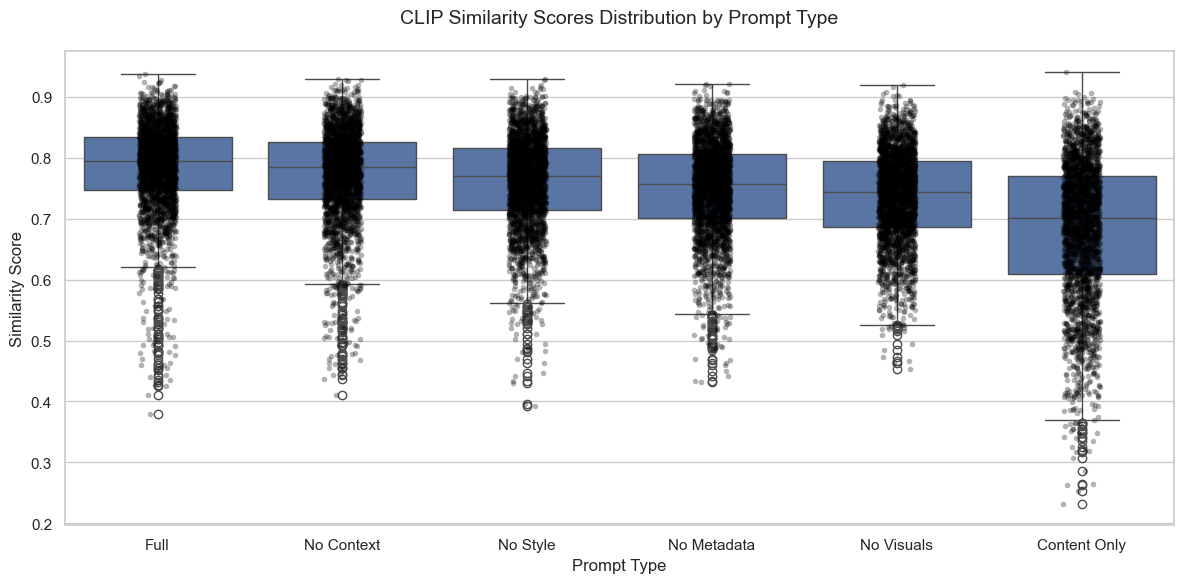

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import Tuple
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def plot_similarity_boxplot(csv_path: str) -> Tuple[pd.DataFrame, plt.Figure]:
    """
    Generate a boxplot of similarity scores and return the DataFrame and figure object.

    Args:
        csv_path (str): Path to the CSV file

    Returns:
        Tuple[pd.DataFrame, plt.Figure]: Tuple containing the DataFrame and figure object

    Raises:
        FileNotFoundError: If the CSV file does not exist
        pd.errors.EmptyDataError: If the CSV file is empty
        ValueError: If the CSV file format is incorrect
    """
    try:
        # Read the CSV file
        df = pd.read_csv(csv_path)

        # Validate required columns
        required_columns = ['prompt_type', 'similarity_score']
        if not all(col in df.columns for col in required_columns):
            raise ValueError(f"CSV file must contain the following columns: {required_columns}")

        # Calculate mean similarity for each prompt_type and get the order
        order = df.groupby('prompt_type')['similarity_score'].mean().sort_values(ascending=False).index.tolist()

        # Set plot style
        sns.set_theme(style="whitegrid")
        fig = plt.figure(figsize=(12, 6))

        # Create boxplot with sorted order
        ax = sns.boxplot(x='prompt_type', y='similarity_score', data=df, order=order)

        # Add data points
        sns.stripplot(x='prompt_type', y='similarity_score', data=df,
                      color='black', alpha=0.3, size=4, jitter=True, order=order)

        # Set title and labels
        plt.title('CLIP Similarity Scores Distribution by Prompt Type', fontsize=14, pad=20)
        plt.xlabel('Prompt Type', fontsize=12)
        plt.ylabel('Similarity Score', fontsize=12)

        # Optionally rotate x-axis labels to prevent overlap
        # plt.xticks(rotation=45, ha='right')

        # Adjust layout
        plt.tight_layout()

        # Save the plot
        output_dir = os.path.dirname(csv_path)
        if not output_dir:
            output_dir = '.'
        output_path = os.path.join(output_dir, 'similarity_boxplot_final.png')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        logger.info(f"Box plot saved to: {output_path}")

        # Print statistical summary
        logger.info("\nStatistical Summary by Prompt Type:")
        stats = df.groupby('prompt_type')['similarity_score'].describe()
        logger.info("\n" + str(stats))

        return df, fig

    except FileNotFoundError:
        logger.error(f"CSV file not found: {csv_path}")
        raise
    except pd.errors.EmptyDataError:
        logger.error(f"CSV file is empty: {csv_path}")
        raise
    except Exception as e:
        logger.error(f"Error processing data: {str(e)}")
        raise

def main():
    """Main function"""
    try:
        # Specify the CSV file path
        csv_path = "clip_similarity_results_final.csv"

        # Generate boxplot
        df, fig = plot_similarity_boxplot(csv_path)

        # Show the plot
        plt.show()

    except Exception as e:
        logger.error(f"Program execution failed: {str(e)}")
        raise

if __name__ == "__main__":
    main()

## Prompt vs. Ground Truth / Generated

In [62]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style at the beginning
plt.style.use('default')  # Use default style as base
sns.set_theme()  # Apply seaborn's default theme

def load_clip_model():
    """Load CLIP model and processor"""
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    return model, processor

def calculate_clip_similarity(model, processor, image, text):
    """Calculate similarity between image and text using CLIP"""
    # Process inputs
    inputs = processor(
        text=[text],
        images=image,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=77
    )
    
    # Move inputs to GPU if available
    if torch.cuda.is_available():
        inputs = {k: v.to("cuda") for k, v in inputs.items()}
    
    # Get image and text features
    with torch.no_grad():
        outputs = model(**inputs)
        image_features = outputs.image_embeds
        text_features = outputs.text_embeds
    
    # Normalize features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    
    # Calculate similarity
    similarity = torch.matmul(image_features, text_features.T).item()
    return similarity

def evaluate_prompt_image_similarity(original_images_dir, generated_images_dir, prompts_file, output_file="prompt_image_similarity_scores.csv"):
    """
    Evaluate similarity between prompts and both original and generated images using CLIP

    Args:
        original_images_dir: Directory containing original images
        generated_images_dir: Directory containing generated images
        prompts_file: CSV file containing prompts
        output_file: Output CSV file to save similarity scores
    """
    # Load CLIP model
    print("Loading CLIP model...")
    model, processor = load_clip_model()
    if torch.cuda.is_available():
        model = model.to("cuda")

    # Load prompts
    prompts_df = pd.read_csv(prompts_file)
    
    # Define prompt types and their corresponding image filename formats
    prompt_types = {
        'Full': 'Full',
        'No-Context': 'No-Context',
        'No-Style': 'No-Style',
        'No-Metadata': 'No-Metadata',
        'No-Visuals': 'No-Visuals',
        'Content-Only': 'Content-Only'
    }
    
    # Mapping from new prompt types to image filename formats
    prompt_to_filename = {
        'Full': 'full_prompt',
        'No-Context': 'no_context_prompt',
        'No-Style': 'no_style_prompt',
        'No-Metadata': 'no_metadata_prompt',
        'No-Visuals': 'extreme_control_prompt',
        'Content-Only': 'content_only_prompt'
    }

    results = []

    # Process each image and its prompts
    for _, row in tqdm(prompts_df.iterrows(), total=len(prompts_df), desc="Evaluating prompts"):
        image_name = row['IMAGE_FILE']
        original_image_path = os.path.join(original_images_dir, image_name)

        # Load original image
        try:
            original_image = Image.open(original_image_path).convert('RGB')
        except Exception as e:
            print(f"Error loading original image {original_image_path}: {str(e)}")
            continue

        # Get all prompt columns (excluding IMAGE_FILE)
        prompt_cols = [col for col in row.index if col != 'IMAGE_FILE']

        for prompt_col in prompt_cols:
            prompt = row[prompt_col]
            prompt_type = prompt_col  # Now the column name is already the prompt type

            if not isinstance(prompt, str) or not prompt.strip():
                continue

            # Find corresponding generated image
            base_name = os.path.splitext(image_name)[0]
            # Convert prompt type to the format used in image filenames
            prompt_type_raw = prompt_to_filename[prompt_type]
            generated_image_name = f"{base_name} {prompt_type_raw}.jpg"
            generated_image_path = os.path.join(generated_images_dir, generated_image_name)

            try:
                generated_image = Image.open(generated_image_path).convert('RGB')
            except Exception as e:
                print(f"Error loading generated image {generated_image_path}: {str(e)}")
                continue

            # Calculate similarities
            original_similarity = calculate_clip_similarity(model, processor, original_image, prompt)
            generated_similarity = calculate_clip_similarity(model, processor, generated_image, prompt)

            # Store results
            results.append({
                'image': image_name,
                'prompt_type': prompt_type,
                'prompt_description': prompt_types.get(prompt_type, ''),
                'prompt': prompt,
                'original_similarity': original_similarity,
                'generated_similarity': generated_similarity,
                'similarity_difference': generated_similarity - original_similarity
            })

    # Create DataFrame and save results
    df = pd.DataFrame(results)
    df.to_csv(output_file, index=False)

    # Print detailed summary statistics
    print("\nPrompt-Image Similarity Score Summary:")

    print("\nOriginal Image Similarity Scores by Prompt Type:")
    original_summary = df.groupby('prompt_type').agg({
        'original_similarity': ['mean', 'std', 'min', 'max', 'median'],
        'prompt': 'count'
    }).round(4)
    original_summary.columns = ['mean', 'std', 'min', 'max', 'median', 'count']
    original_summary = original_summary.sort_values('mean', ascending=False)
    print(original_summary)

    print("\nGenerated Image Similarity Scores by Prompt Type:")
    generated_summary = df.groupby('prompt_type').agg({
        'generated_similarity': ['mean', 'std', 'min', 'max', 'median'],
        'prompt': 'count'
    }).round(4)
    generated_summary.columns = ['mean', 'std', 'min', 'max', 'median', 'count']
    generated_summary = generated_summary.sort_values('mean', ascending=False)
    print(generated_summary)

    print("\nSimilarity Difference (Generated - Original) by Prompt Type:")
    diff_summary = df.groupby('prompt_type')['similarity_difference'].agg(['mean', 'std', 'min', 'max']).round(4)
    diff_summary = diff_summary.sort_values('mean', ascending=False)
    print(diff_summary)

    return df

def plot_similarity_scores(df, output_dir="prompt_image_similarity_plots"):
    """Plot similarity scores for different prompt types"""
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Box plot comparing original and generated similarities
    plt.figure(figsize=(15, 8), dpi=300)
    plot_data = pd.melt(df, 
                        id_vars=['prompt_type'],
                        value_vars=['original_similarity', 'generated_similarity'],
                        var_name='Image Type',
                        value_name='Similarity Score')
    sns.boxplot(data=plot_data, x='prompt_type', y='Similarity Score', hue='Image Type')
    plt.title('CLIP Similarity Scoress with Prompt Type: Original vs Generated Images', fontsize=14)
    plt.xlabel('Prompt Type', fontsize=12)
    plt.ylabel('Similarity Score', fontsize=12)
    # plt.xticks(rotation=45, ha='right')
    plt.legend(title='Image Type')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'similarity_comparison_boxplot.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. Average scores comparison
    plt.figure(figsize=(15, 8))
    avg_scores = df.groupby('prompt_type')[['original_similarity', 'generated_similarity']].mean()
    avg_scores.plot(kind='bar')
    plt.title('Average CLIP Similarity Scores: Original vs Generated Images', fontsize=14)
    plt.xlabel('Prompt Type', fontsize=12)
    plt.ylabel('Average Similarity Score', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(['Original Images', 'Generated Images'])
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'average_similarity_comparison.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. Scatter plot of original vs generated similarities
    plt.figure(figsize=(12, 10))
    sns.scatterplot(data=df, x='original_similarity', y='generated_similarity', hue='prompt_type', alpha=0.6)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)  # Diagonal line
    plt.title('Original vs Generated Image Similarities', fontsize=14)
    plt.xlabel('Original Image Similarity', fontsize=12)
    plt.ylabel('Generated Image Similarity', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'similarity_scatter.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # 4. Heatmap of similarity differences
    desired_order = ['Full', 'No-Context', 'No-Style', 'No-Metadata', 'No-Visuals', 'Content-Only']
    pivot_df = df.pivot_table(index='image', columns='prompt_type', values='similarity_difference')
    pivot_df = pivot_df[[col for col in desired_order if col in pivot_df.columns]]


    plt.figure(figsize=(12, 10), dpi=300)
    pivot_df = df.pivot_table(index='image', columns='prompt_type', values='similarity_difference')
    sns.heatmap(pivot_df, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Similarity Differences (Generated - Original) by Image and Prompt Type', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'similarity_differences_heatmap.png'), dpi=300, bbox_inches='tight')
    plt.close()

def analyze_best_prompts(df, top_n=5):
    """Analyze the best performing prompts for each type"""
    print("\nTop", top_n, "Prompts for Each Type (Based on Generated Image Similarity):")
    for prompt_type in df['prompt_type'].unique():
        type_df = df[df['prompt_type'] == prompt_type]
        top_prompts = type_df.nlargest(top_n, 'generated_similarity')
        
        print(f"\n{prompt_type.upper()} ({type_df['prompt_description'].iloc[0]}):")
        print("-" * 80)
        for _, row in top_prompts.iterrows():
            print(f"Generated Image Score: {row['generated_similarity']:.4f}")
            print(f"Original Image Score: {row['original_similarity']:.4f}")
            print(f"Difference: {row['similarity_difference']:.4f}")
            print(f"Image: {row['image']}")
            print(f"Prompt: {row['prompt']}")
            print("-" * 80)

def analyze_prompt_patterns(df):
    """Analyze patterns in successful prompts"""
    print("\nAnalyzing Patterns in Successful Prompts:")
    
    # Get top 20% prompts for each type based on generated image similarity
    top_prompts = []
    for prompt_type in df['prompt_type'].unique():
        type_df = df[df['prompt_type'] == prompt_type]
        threshold = type_df['generated_similarity'].quantile(0.8)
        top_prompts.extend(type_df[type_df['generated_similarity'] >= threshold]['prompt'].tolist())
    
    # Print some statistics
    print(f"\nTotal number of analyzed prompts: {len(top_prompts)}")
    print(f"Average prompt length: {np.mean([len(p.split()) for p in top_prompts]):.1f} words")
    print(f"Median prompt length: {np.median([len(p.split()) for p in top_prompts]):.1f} words")
    
    # Print some example patterns
    print("\nExample patterns in successful prompts:")
    for prompt in top_prompts[:5]:
        print(f"\n- {prompt}")

if __name__ == "__main__":
    # Example usage
    original_images_dir = "Ground Truth Images"  # Directory containing original images
    generated_images_dir = "generated_images_final_merge"  # Directory containing generated images
    prompts_file = "generated_prompts_final_merge.csv"  # CSV file containing prompts
    similarity_df = pd.read_csv("prompt_image_similarity_scores.csv")
    
    # Evaluate similarity
    # similarity_df = evaluate_prompt_image_similarity(original_images_dir, generated_images_dir, prompts_file)
    
    # Plot results
    plot_similarity_scores(similarity_df)
    
    # Analyze best prompts
    # analyze_best_prompts(similarity_df)
    
    # Analyze patterns in successful prompts
    # analyze_prompt_patterns(similarity_df)

<Figure size 1500x800 with 0 Axes>

# Other Metrics

## SSIM LPIPS

In [29]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
import pandas as pd
import lpips
from skimage.metrics import structural_similarity as ssim
import logging
from datetime import datetime

def setup_logging():
    """Journal"""
    log_dir = "logs"
    os.makedirs(log_dir, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_file = os.path.join(log_dir, f"evaluation_{timestamp}.log")
    
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)

class ImagePairLoader:
    def __init__(self, original_dir: str, generated_dir: str):
        self.logger = logging.getLogger(__name__)
        self.original_dir = original_dir
        self.generated_dir = generated_dir
        
        # Verify
        if not os.path.exists(original_dir):
            raise FileNotFoundError(f"Original images directory not found: {original_dir}")
        if not os.path.exists(generated_dir):
            raise FileNotFoundError(f"Generated images directory not found: {generated_dir}")
        
        # Get data
        self.original_images = [f for f in os.listdir(original_dir) 
                              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.generated_images = [f for f in os.listdir(generated_dir) 
                               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        self.logger.info(f"Found {len(self.original_images)} original images")
        self.logger.info(f"Found {len(self.generated_images)} generated images")
        
        # Record instances
        if self.original_images:
            self.logger.info(f"Sample original images: {self.original_images[:5]}")
        if self.generated_images:
            self.logger.info(f"Sample generated images: {self.generated_images[:5]}")
        
        # Create pair
        self.image_pairs = self._create_image_pairs()
        self.logger.info(f"Created {len(self.image_pairs)} image pairs")
        
        # Record if no record
        if not self.image_pairs:
            self.logger.warning("No image pairs were created. Checking naming patterns...")
            self._analyze_naming_patterns()
    
    def _analyze_naming_patterns(self):
        if not self.generated_images:
            return
            
        sample_gen = self.generated_images[0]
        self.logger.info(f"Analyzing naming pattern of generated image: {sample_gen}")
        
        # Space
        parts = sample_gen.split(' ')
        self.logger.info(f"Split by space: {parts}")
        
        # Check name
        for gen_img in self.generated_images[:5]:  
            found = False
            for orig_img in self.original_images:
                if orig_img.split('.')[0] in gen_img:
                    self.logger.info(f"Found match: {orig_img} -> {gen_img}")
                    found = True
                    break
            if not found:
                self.logger.info(f"No match found for generated image: {gen_img}")
    
    def _create_image_pairs(self):
        pairs = []
        for gen_img in self.generated_images:
            parts = gen_img.split(' ')
            if len(parts) >= 2: 
                original_name = parts[0] + os.path.splitext(self.original_images[0])[1] 
                if original_name in self.original_images:
                    pairs.append((original_name, gen_img))
                    self.logger.debug(f"Matched pair: {original_name} -> {gen_img}")
        
        if pairs:
            self.logger.info(f"First few pairs created: {pairs[:5]}")
            gen_images = [p[1] for p in pairs]
            if len(gen_images) != len(set(gen_images)):
                self.logger.warning("Found duplicate generated images in pairs!")
        
        return pairs
    
    def load_image_pair(self, original_name: str, generated_name: str):
        try:
            original_path = os.path.join(self.original_dir, original_name)
            generated_path = os.path.join(self.generated_dir, generated_name)
            
            original_img = Image.open(original_path).convert('RGB')
            generated_img = Image.open(generated_path).convert('RGB')
            
            self.logger.debug(f"Loaded image pair: {original_name} - {generated_name}")
            self.logger.debug(f"Original size: {original_img.size}, Generated size: {generated_img.size}")
            
            return original_img, generated_img
        except Exception as e:
            self.logger.error(f"Error loading image pair {original_name} - {generated_name}: {str(e)}")
            return None, None

class MetricsCalculator:
    def __init__(self, device='cuda'):
        self.logger = logging.getLogger(__name__)
        self.device = device if torch.cuda.is_available() else 'cpu'
        self.logger.info(f"Using device: {self.device}")
        
        self._init_models()
        
        self.transform = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
    
    def _init_models(self):
        try:
            self.lpips_model = lpips.LPIPS(net='alex').to(self.device)
            self.lpips_model.eval()
            
            self.logger.info("Models initialized successfully")
        except Exception as e:
            self.logger.error(f"Error initializing models: {str(e)}")
            raise
    
    def calculate_pair_metrics(self, original_img: Image.Image, generated_img: Image.Image):
        try:
            original_np = np.array(original_img)
            generated_np = np.array(generated_img)
            
            if original_np.shape != generated_np.shape:
                self.logger.debug(f"Resizing generated image from {generated_np.shape} to {original_np.shape}")
                generated_np = np.array(Image.fromarray(generated_np).resize(original_np.shape[:2][::-1]))
            
            ssim_score = ssim(original_np, generated_np, channel_axis=2)
            original_tensor = self.transform(original_img).unsqueeze(0).to(self.device)
            generated_tensor = self.transform(generated_img).unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                lpips_score = self.lpips_model(original_tensor, generated_tensor).item()
            
            del original_tensor, generated_tensor
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            
            return {
                'ssim_score': ssim_score,
                'lpips_score': lpips_score
            }
            
        except Exception as e:
            self.logger.error(f"Error calculating metrics: {str(e)}")
            return None

def evaluate_image_pairs(original_dir: str, generated_dir: str, output_file: str = "evaluation_results_test.csv"):
    logger = setup_logging()
    logger.info("Starting image evaluation pipeline")
    
    try:
        loader = ImagePairLoader(original_dir, generated_dir)
        calculator = MetricsCalculator()
        
        results = []
        for original_name, generated_name in tqdm(loader.image_pairs, desc="Evaluating image pairs"):
            original_img, generated_img = loader.load_image_pair(original_name, generated_name)
            if original_img is None or generated_img is None:
                continue
            
            metrics = calculator.calculate_pair_metrics(original_img, generated_img)
            if metrics is None:
                continue
            
            results.append({
                'original_image': original_name,
                'generated_image': generated_name,
                'prompt_type': generated_name.split(' ')[1].replace('.jpg', ''), 
                **metrics
            })
            
            logger.debug(f"Processed pair: {original_name} - {generated_name}")
        
        if not results:
            logger.error("No results were generated!")
            return None, None
        
        results_df = pd.DataFrame(results)
        
        results_df.to_csv(output_file, index=False)
        logger.info(f"Detailed results saved to {output_file}")
        
        summary = {
            'Average_SSIM': results_df['ssim_score'].mean(),
            'Average_LPIPS': results_df['lpips_score'].mean()
        }

        prompt_stats = results_df.groupby('prompt_type').agg({
            'ssim_score': 'mean',
            'lpips_score': 'mean'
        }).round(4)
        
        # Save
        summary_file = output_file.replace('.csv', '_summary.csv')
        pd.DataFrame([summary]).to_csv(summary_file, index=False)
        prompt_stats.to_csv(output_file.replace('.csv', '_prompt_stats.csv'))
        
        logger.info("\nEvaluation Summary:")
        logger.info(f"Total pairs evaluated: {len(results)}")
        logger.info(f"Average SSIM: {summary['Average_SSIM']:.4f}")
        logger.info(f"Average LPIPS: {summary['Average_LPIPS']:.4f}")
        
        return results_df, summary
        
    except Exception as e:
        logger.error(f"Error in evaluation pipeline: {str(e)}")
        return None, None

if __name__ == "__main__":
    original_dir = "Ground Truth Images"
    generated_dir = "generated_images_final_merge"
    output_file = "evaluation_results_test.csv"
    
    results_df, summary = evaluate_image_pairs(
        original_dir=original_dir,
        generated_dir=generated_dir,
        output_file=output_file
    )
    
    if results_df is not None:
        print("\nEvaluation completed successfully!")
    else:
        print("\nEvaluation failed!")

INFO:__main__:Starting image evaluation pipeline
INFO:__main__:Found 21374 original images
INFO:__main__:Found 16239 generated images
INFO:__main__:Sample original images: ['00000-allegory.jpg', '00002-j_couple.jpg', '00003-rudolf2.jpg', '00004-selfport.jpg', '00005-deerlake.jpg']
INFO:__main__:Sample generated images: ['00007-michael content_only_prompt.jpg', '00007-michael extreme_control_prompt.jpg', '00007-michael full_prompt.jpg', '00007-michael no_context_prompt.jpg', '00007-michael no_metadata_prompt.jpg']
INFO:__main__:First few pairs created: [('00007-michael.jpg', '00007-michael content_only_prompt.jpg'), ('00007-michael.jpg', '00007-michael extreme_control_prompt.jpg'), ('00007-michael.jpg', '00007-michael full_prompt.jpg'), ('00007-michael.jpg', '00007-michael no_context_prompt.jpg'), ('00007-michael.jpg', '00007-michael no_metadata_prompt.jpg')]
INFO:__main__:Created 16227 image pairs
INFO:__main__:Using device: cuda
e:\ImageThesis\AI-Image-Generator\sd-env\Lib\site-packag

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


INFO:__main__:Models initialized successfully


Loading model from: e:\ImageThesis\AI-Image-Generator\sd-env\Lib\site-packages\lpips\weights\v0.1\alex.pth


Evaluating image pairs: 100%|██████████| 16227/16227 [1:54:47<00:00,  2.36it/s]  
INFO:__main__:Detailed results saved to evaluation_results_test.csv
INFO:__main__:
Evaluation Summary:
INFO:__main__:Total pairs evaluated: 16227
INFO:__main__:Average SSIM: 0.1811
INFO:__main__:Average LPIPS: 0.6808



Evaluation completed successfully!


In [30]:
df = pd.read_csv('evaluation_results_test.csv')

PROMPT_TYPE_MAP = {
    'content_only_prompt': 'Content-Only',
    'extreme_control_prompt': 'No-Visuals',
    'full_prompt': 'Full',
    'no_context_prompt': 'No-Context',
    'no_metadata_prompt': 'No-Metadata',
    'no_style_prompt': 'No-Style'
}
df['prompt_type'] = df['prompt_type'].map(PROMPT_TYPE_MAP)

summary = df.groupby('prompt_type')[['ssim_score', 'lpips_score']].describe(percentiles=[.25, .5, .75])

pd.set_option('display.max_columns', None)

summary_sorted = summary.sort_values(('ssim_score', 'mean'), ascending=False)

print(summary_sorted)

summary_sorted.to_csv('prompt_type_similarity_stats.csv')

             ssim_score                                                    \
                  count      mean       std       min       25%       50%   
prompt_type                                                                 
No-Context       2706.0  0.185436  0.090230  0.000196  0.115985  0.173169   
No-Metadata      2705.0  0.183950  0.084569  0.030966  0.119196  0.172694   
Full             2706.0  0.182346  0.090599  0.000227  0.113076  0.168062   
No-Style         2706.0  0.179970  0.084655  0.029066  0.114026  0.168037   
No-Visuals       2702.0  0.179165  0.079450  0.033174  0.117738  0.168776   
Content-Only     2702.0  0.176017  0.083037  0.005174  0.113109  0.163103   

                                 lpips_score                                \
                   75%       max       count      mean       std       min   
prompt_type                                                                  
No-Context    0.241724  0.602255      2706.0  0.675958  0.061665  0.5031

# Data Analysis

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
from typing import List

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def plot_metrics_boxplots(csv_path: str, metrics: List[str]):
    """
    Generate box plots for specified metrics.

    Args:
        csv_path (str): Path to the CSV file
        metrics (List[str]): List of metric column names to plot
    """
    try:
        df = pd.read_csv(csv_path)
        if 'prompt_type' not in df.columns:
            raise ValueError("The CSV file must contain a 'prompt_type' column.")
        
        output_dir = os.path.dirname(csv_path) or '.'
        sns.set_theme(style="whitegrid")
        
        for metric in metrics:
            if metric not in df.columns:
                logger.warning(f"Metric not found: {metric}. Skipping.")
                continue
            
            fig = plt.figure(figsize=(12, 6))
            ax = sns.boxplot(x='prompt_type', y=metric, data=df)
            sns.stripplot(x='prompt_type', y=metric, data=df, color='black', alpha=0.3, size=4, jitter=True)
            plt.title(f'{metric} Distribution by Prompt Type', fontsize=14, pad=20)
            plt.xlabel('Prompt Type', fontsize=12)
            plt.ylabel(metric, fontsize=12)
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            output_path = os.path.join(output_dir, f'{metric}_boxplot.png')
            plt.savefig(output_path, dpi=300, bbox_inches='tight')
            logger.info(f"Box plot for {metric} saved to: {output_path}")
            plt.close(fig)
            
            # Print statistical summary
            logger.info(f"\nStatistical Summary for {metric} by Prompt Type:")
            stats = df.groupby('prompt_type')[metric].describe()
            logger.info("\n" + str(stats))
    except Exception as e:
        logger.error(f"An error occurred while processing data: {str(e)}")
        raise

def main():
    csv_path = "evaluation_results_test.csv"
    metrics = ['ssim_score', 'lpips_score']  # Adjust based on your actual column names
    plot_metrics_boxplots(csv_path, metrics)

if __name__ == "__main__":
    main()


INFO:__main__:Box plot for ssim_score saved to: .\ssim_score_boxplot.png
INFO:__main__:
Statistical Summary for ssim_score by Prompt Type:
INFO:__main__:
                         count      mean       std       min       25%  \
prompt_type                                                              
content_only_prompt     2702.0  0.176017  0.083037  0.005174  0.113109   
extreme_control_prompt  2702.0  0.179165  0.079450  0.033174  0.117738   
full_prompt             2706.0  0.182346  0.090599  0.000227  0.113076   
no_context_prompt       2706.0  0.185436  0.090230  0.000196  0.115985   
no_metadata_prompt      2705.0  0.183950  0.084569  0.030966  0.119196   
no_style_prompt         2706.0  0.179970  0.084655  0.029066  0.114026   

                             50%       75%       max  
prompt_type                                           
content_only_prompt     0.163103  0.222638  0.542511  
extreme_control_prompt  0.168776  0.228654  0.615239  
full_prompt             0.168062 

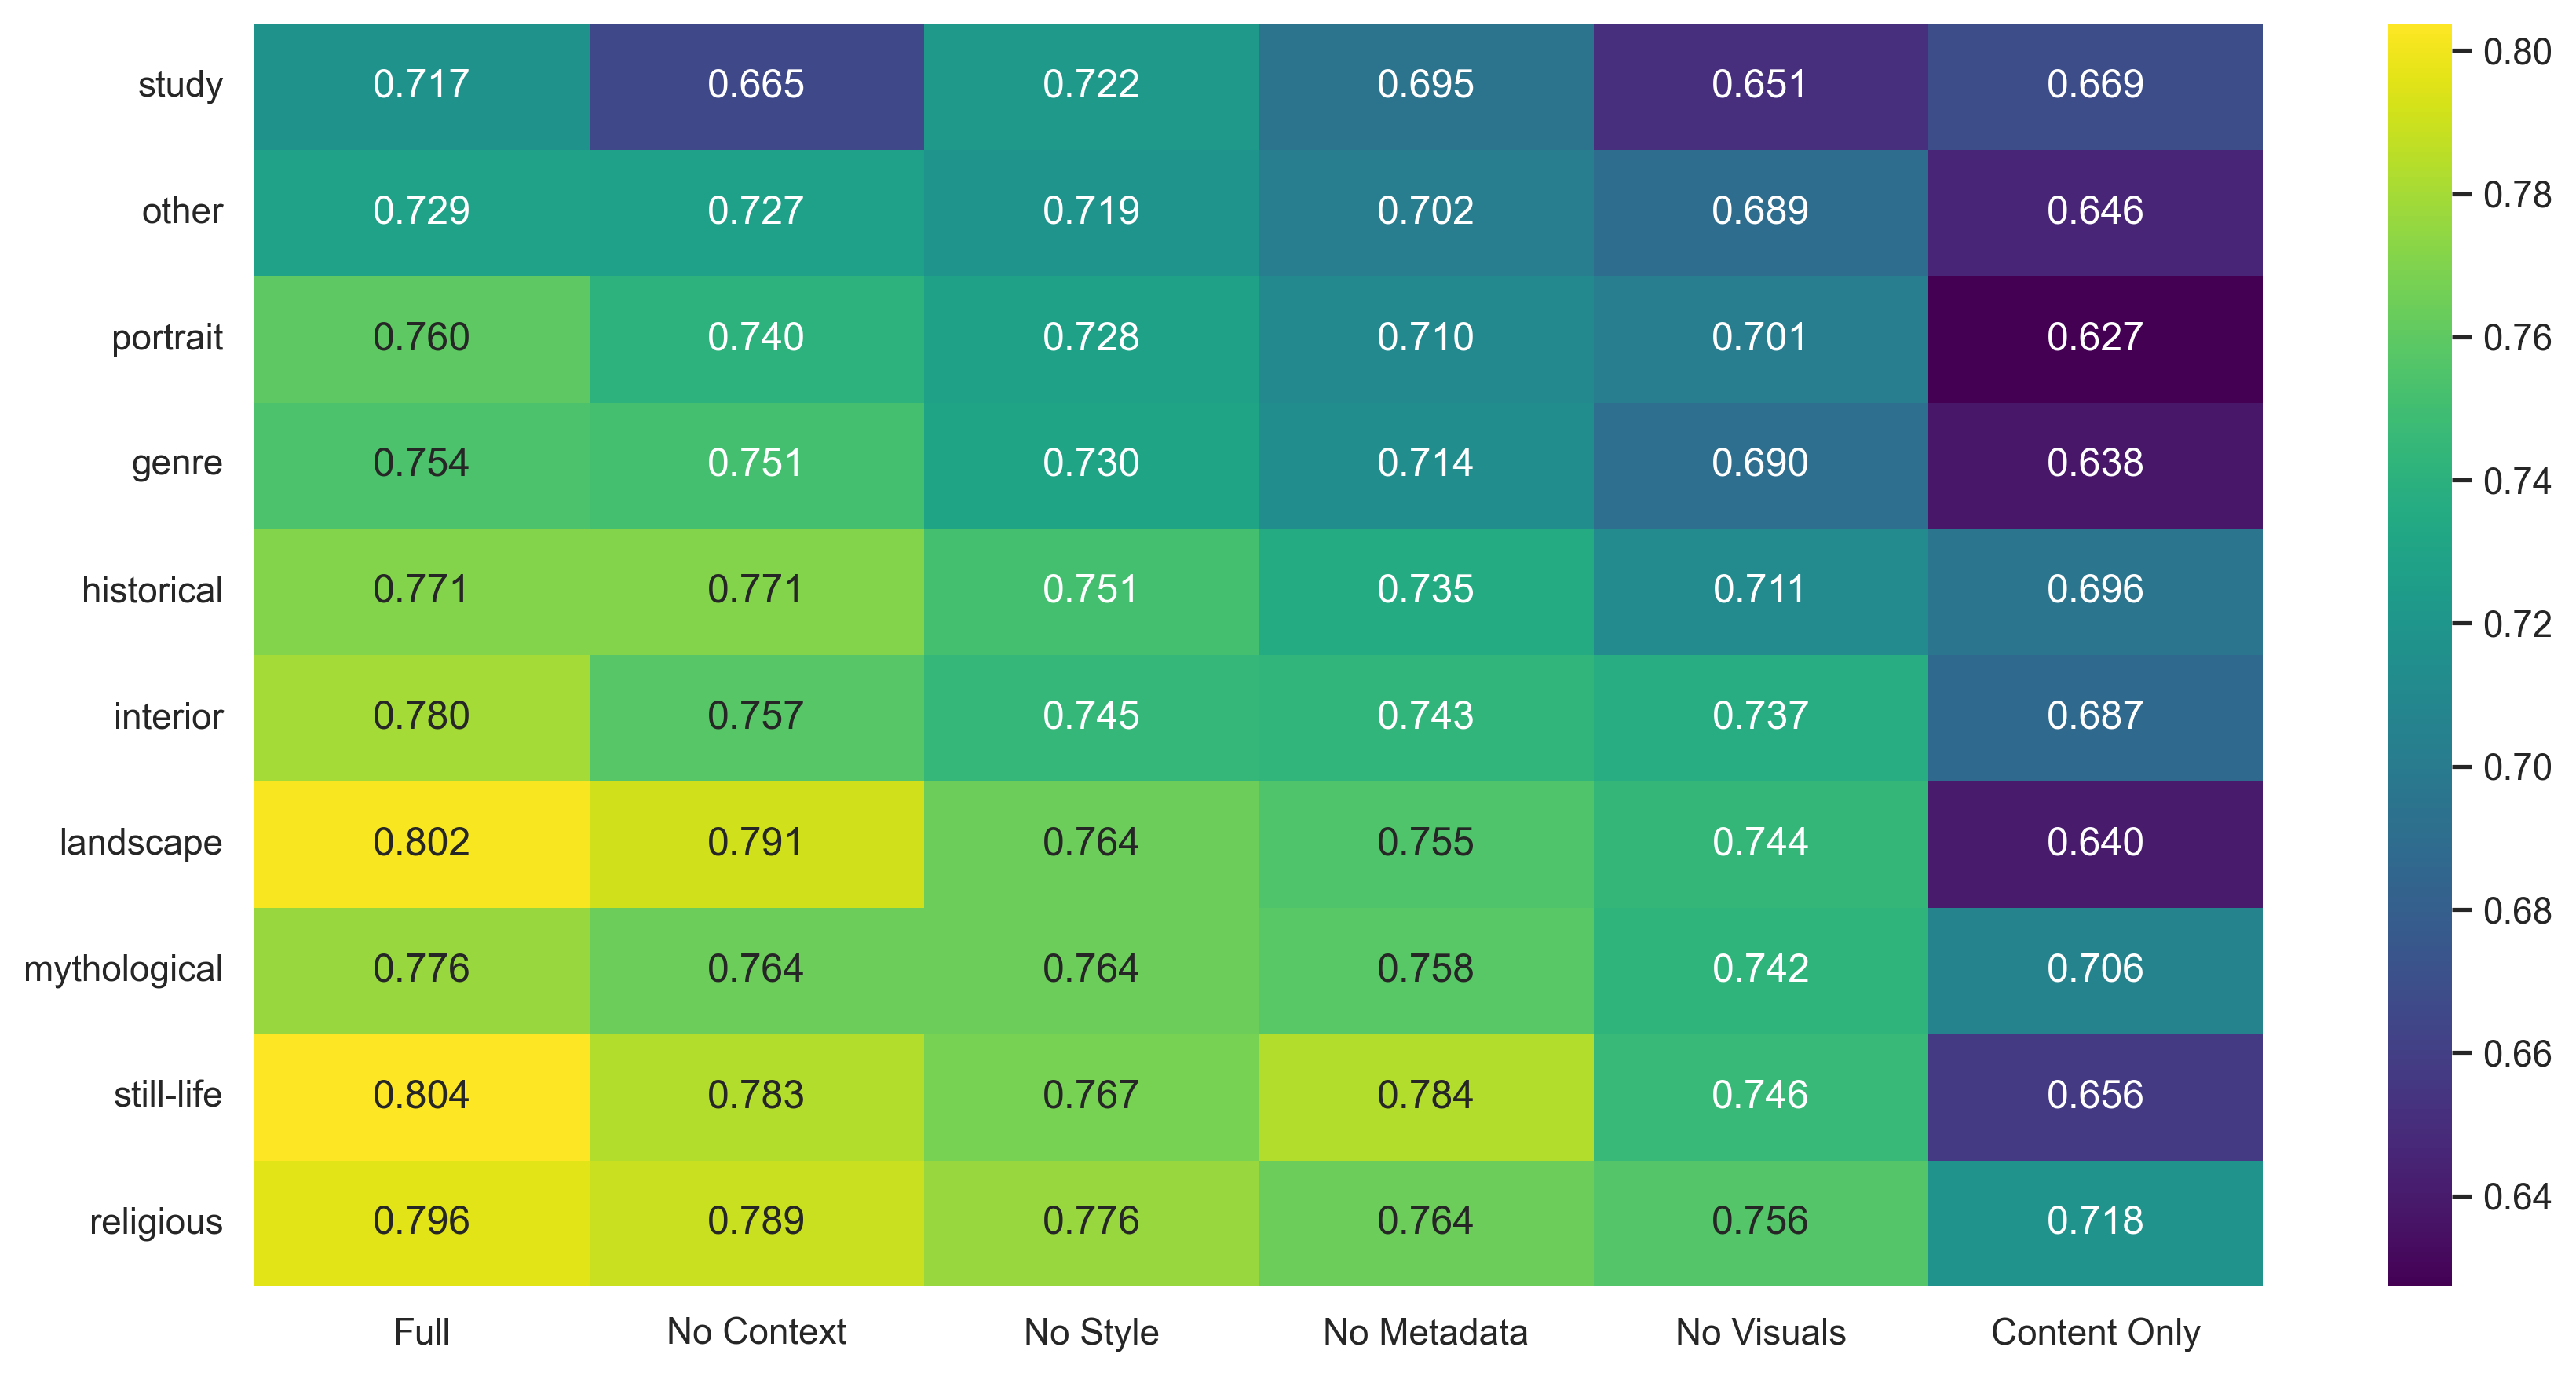

In [59]:
prompt = pd.read_csv("generated_prompts.csv", encoding="utf-8")
df = pd.merge(prompt, source, on="IMAGE_FILE", how="left")
clip_score = pd.read_csv("clip_similarity_results_final.csv")
clip_score = clip_score.pivot(index="original_image", columns="prompt_type", values="similarity_score")
df_all = pd.merge(df, clip_score, left_on="IMAGE_FILE", right_on="original_image", how="left")

# Assume df_all has a TYPE column and separate columns for each prompt_type
mean_matrix = df_all.groupby('TYPE').mean(numeric_only=True)

# Keep only the columns related to prompt_type
prompt_cols = [col for col in mean_matrix.columns]
mean_matrix = mean_matrix[prompt_cols]

# Assume mean_matrix is ready
# 1. Sort types (rows) by their mean values
type_means = mean_matrix.mean(axis=1)
sorted_types = type_means.sort_values().index.tolist()

# 2. Sort prompt types (columns) by their mean values
prompt_means = mean_matrix.mean(axis=0)
sorted_prompts = prompt_means.sort_values(ascending=False).index.tolist()

# 3. Reorder rows and columns of the mean_matrix
mean_matrix_sorted = mean_matrix.loc[sorted_types, sorted_prompts]

plt.figure(figsize=(12, 6), dpi=300)
sns.heatmap(mean_matrix_sorted, annot=True, cmap='viridis', fmt=".3f")
# plt.title("Mean CLIP Similarity by Type and Prompt Type")
# plt.xlabel("Prompt Type")
plt.ylabel("")
plt.tight_layout()
plt.show()


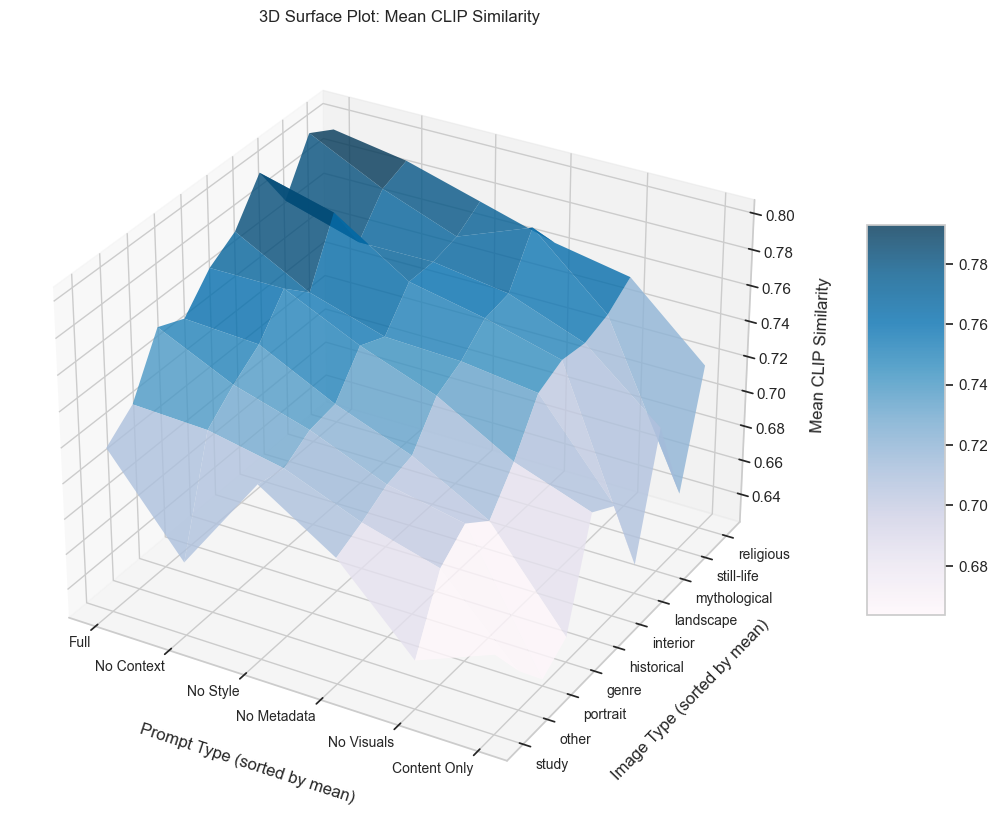

In [52]:
from mpl_toolkits.mplot3d import Axes3D

types = mean_matrix_sorted.index.tolist()
prompts = mean_matrix_sorted.columns.tolist()
X, Y = np.meshgrid(np.arange(len(prompts)), np.arange(len(types)))
Z = mean_matrix_sorted.values

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap='PuBu', edgecolor='none', alpha=0.8)

ax.tick_params(axis='x', pad=-3) 
ax.tick_params(axis='y', pad=0)

ax.set_xticks(np.arange(len(prompts)))
ax.set_xticklabels(prompts, rotation=0, ha='right', fontsize=10)
ax.set_yticks(np.arange(len(types)))
ax.set_yticklabels(types, ha='left', fontsize=10)
ax.set_zlabel('Mean CLIP Similarity', labelpad=12)
ax.set_xlabel('Prompt Type (sorted by mean)', labelpad=18)
ax.set_ylabel('Image Type (sorted by mean)', labelpad=20)
ax.set_title('3D Surface Plot: Mean CLIP Similarity')
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.view_init(elev=30, azim=-60) 
plt.subplots_adjust(left=0.18, right=0.95, bottom=0.25, top=0.9)
plt.show()